In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics

from sklearn.model_selection import GridSearchCV, KFold

import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline

In [2]:
!pip install lightgbm

In [3]:
# Configurations
N_SPLITS = 5
SEED = 42

train_df = pd.read_csv(r'C:\Users\abysm\Documents\Kaggle\02 Tabular Playground Series - Jan 2021\train.csv')
#print('Train data dimension: ', train_df.shape)

test_df = pd.read_csv(r'C:\Users\abysm\Documents\Kaggle\02 Tabular Playground Series - Jan 2021\test.csv')
#print('Test data dimension: ', test_df.shape)
#display(test_df.head())

sample_submission = pd.read_csv(r'C:\Users\abysm\Documents\Kaggle\02 Tabular Playground Series - Jan 2021\sample_submission.csv')
#print('Sample submission dimension: ', sample_submission.shape)
#display(sample_submission.head())

In [14]:
print(f"Missing data in the train data: {train_df.isna().sum(axis=0).any()}")
print(f"Missing data in the test data: {test_df.isna().sum(axis=0).any()}")

Missing data in the train data: False
Missing data in the test data: False


In [4]:
#display(test_df.head())
display(train_df.head())

id     cont1     cont2     cont3     cont4     cont5     cont6     cont7  \
0   1  0.670390  0.811300  0.643968  0.291791  0.284117  0.855953  0.890700   
1   3  0.388053  0.621104  0.686102  0.501149  0.643790  0.449805  0.510824   
2   4  0.834950  0.227436  0.301584  0.293408  0.606839  0.829175  0.506143   
3   5  0.820708  0.160155  0.546887  0.726104  0.282444  0.785108  0.752758   
4   8  0.935278  0.421235  0.303801  0.880214  0.665610  0.830131  0.487113   

      cont8     cont9    cont10    cont11    cont12    cont13    cont14  \
0  0.285542  0.558245  0.779418  0.921832  0.866772  0.878733  0.305411   
1  0.580748  0.418335  0.432632  0.439872  0.434971  0.369957  0.369484   
2  0.558771  0.587603  0.823312  0.567007  0.677708  0.882938  0.303047   
3  0.823267  0.574466  0.580843  0.769594  0.818143  0.914281  0.279528   
4  0.604157  0.874658  0.863427  0.983575  0.900464  0.935918  0.435772   

     target  
0  7.243043  
1  8.203331  
2  7.776091  
3  6.957716  
4  7.951046

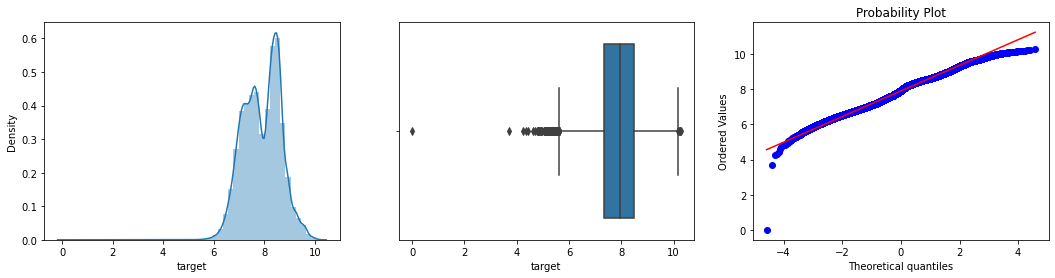

In [21]:
#display(train_df.target.describe())
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
sns.distplot(train_df.target, ax=ax[0])
sns.boxplot(train_df.target, ax=ax[1])
stats.probplot(train_df['target'], plot=ax[2])
plt.show()

In [4]:
# Drop one outlier
train_df = train_df[train_df.target != 0].reset_index(drop=True)

### Cont features

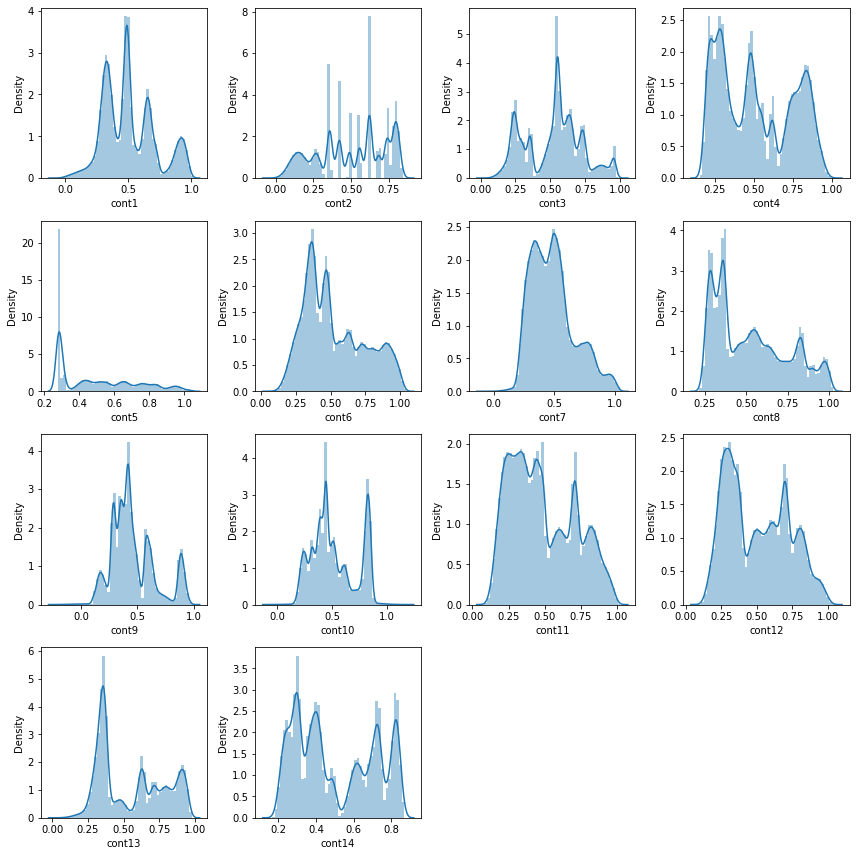

In [31]:
f, ax = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
#f.suptitle('Distribution of Features', fontsize=16)
sns.distplot(train_df['cont1'], ax=ax[0, 0])
sns.distplot(train_df['cont2'], ax=ax[0, 1])
sns.distplot(train_df['cont3'], ax=ax[0, 2])
sns.distplot(train_df['cont4'], ax=ax[0, 3])

sns.distplot(train_df['cont5'], ax=ax[1, 0])
sns.distplot(train_df['cont6'], ax=ax[1, 1])
sns.distplot(train_df['cont7'], ax=ax[1, 2])
sns.distplot(train_df['cont8'], ax=ax[1, 3])

sns.distplot(train_df['cont9'], ax=ax[2, 0])
sns.distplot(train_df['cont10'], ax=ax[2, 1])
sns.distplot(train_df['cont11'], ax=ax[2, 2])
sns.distplot(train_df['cont12'], ax=ax[2, 3])

sns.distplot(train_df['cont13'], ax=ax[3, 0])
sns.distplot(train_df['cont14'], ax=ax[3, 1])
f.delaxes(ax[3, 2])
f.delaxes(ax[3, 3])
plt.tight_layout()
plt.show()

<AxesSubplot:>

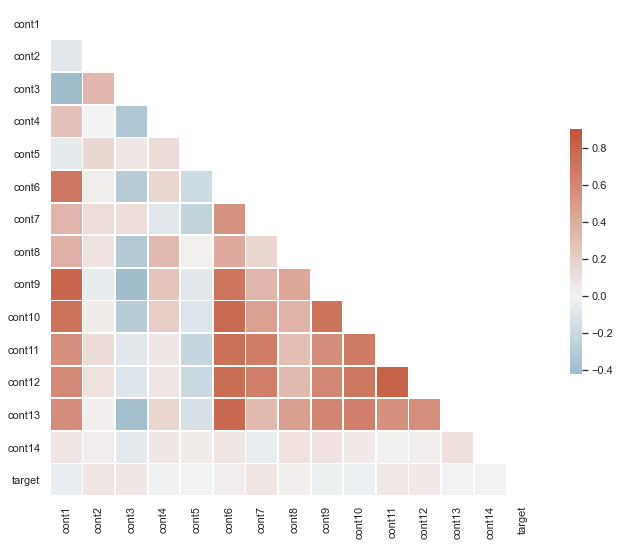

In [34]:
train_df_corr = train_df.drop(['id'], axis = 1)

sns.set_theme(style="white")

# Generate a large random dataset
#rs = np.random.RandomState(33)
#d = pd.DataFrame(data=rs.normal(size=(100, 26)), columns=list(ascii_letters[26:]))

# Compute the correlation matrix
corr = train_df_corr.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.9, center=0,
            square=True, linewidths=.8, cbar_kws={"shrink": .5})

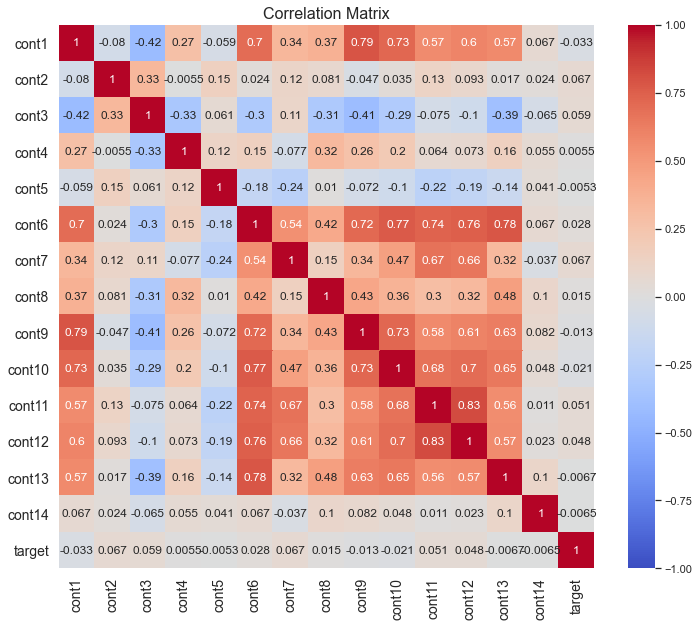

In [33]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 10))
ax.set_title("Correlation Matrix", fontsize=16)
sns.heatmap(train_df[train_df.columns[train_df.columns != 'id']].corr(), vmin=-1, vmax=1, cmap='coolwarm', annot=True)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
    tick.label.set_rotation(90) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    tick.label.set_rotation(0) 
plt.show()

### Train Test Split

In [13]:
X = train_df.drop(['id','target'], axis = 1)

In [14]:
y = train_df[["target"]]

In [8]:
X = X.apply(zscore)  # convert all attributes to Z scale 

In [15]:
test_size = 0.30
seed = 7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

### KNN Regression

In [5]:
from sklearn.neighbors import KNeighborsRegressor

In [10]:
from sklearn.neighbors import KNeighborsRegressor

knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(X_train, y_train)

KNeighborsRegressor()

In [11]:
predicted_labels = knn_reg.predict(X_test)

In [12]:
knn_reg.score(X_test, y_test)

-0.10786469231354401

In [13]:
score = np.sqrt(mean_squared_error(y_test, predicted_labels))
score

0.771727177018728

In [9]:
test_df2 = test_df.drop(['id'], axis = 1)

In [18]:
pred_test = knn_reg.predict(test_df)

### Submission

In [8]:
submission = test_df[['id']].copy()
submission['target'] = pred_test

submission.to_csv("submission.csv", index=False)

NameError: name 'pred_test' is not defined

In [45]:
train_df['target'].mean

<bound method Series.mean of 0         7.243043
1         8.203331
2         7.776091
3         6.957716
4         7.951046
            ...   
299995    7.385215
299996    7.242617
299997    9.592487
299998    8.207951
299999    8.890285
Name: target, Length: 300000, dtype: float64>

### Linear Regression

In [9]:
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import Ridge

In [10]:
linreg_model1 = LinearRegression()
linreg_model1.fit(X_train, y_train)

LinearRegression()

In [11]:
linreg_model1.score(X_train, y_train)

0.0195059377381821

In [12]:
predicted_labels = linreg_model1.predict(X_test)
linreg_model1.score(X_test, y_test)
score = np.sqrt(mean_squared_error(y_test, predicted_labels))
score

0.7273463512770206

In [14]:
#Predict test data 
pred_test = linreg_model1.predict(test_df2)

In [30]:
submission = test_df[['id']].copy()
submission['target'] = pred_test

submission.to_csv("submission.csv", index=False)

#### Regularized model

In [21]:
ridge01 = Ridge(alpha=5.0).fit(X_train, y_train)

In [20]:
predicted_labels = ridge01.predict(X_test)
ridge01.score(X_test, y_test)
score = np.sqrt(mean_squared_error(y_test, predicted_labels))
score

0.7273460873487434

In [35]:
#Predict test data 
pred_test = ridge01.predict(test_df)

### Decision Tree

In [22]:
from sklearn.tree import DecisionTreeRegressor

In [66]:
treeReg = DecisionTreeRegressor(max_depth=6).fit(X_train, y_train)
predicted_labels = treeReg.predict(X_test)

treeReg.score(X_test, y_test)
score = np.sqrt(mean_squared_error(y_test, predicted_labels))
score

0.7225993137256639

In [67]:
#Predict test data 
pred_test = treeReg.predict(test_df2)

In [88]:
submission = test_df[['id']].copy()
submission['target'] = pred_test

submission.to_csv("submission.csv", index=False)

In [83]:
# Define the parameters that you wish to use in your Grid Search along
# with the list of values that you wish to try out
max_depth = [5, 6, 7]
max_leaf_nodes = [45, 50, 55, 60, 65]
min_samples_leaf = [1, 3, 5, 7]

seed = 42

# Make a dictionary of the grid search parameters
param_grid = dict(max_depth=max_depth, max_leaf_nodes=max_leaf_nodes, min_samples_leaf=min_samples_leaf)

# Build and fit the GridSearchCV
grid = GridSearchCV(estimator=treeReg, param_grid=param_grid,
                    cv=KFold(random_state=seed), verbose=10)

grid_results = grid.fit(X_test, y_test)

# Summarize the results in a readable format
print("Best: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))

means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print('{0} ({1}) with: {2}'.format(mean, stdev, param))

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] max_depth=5, max_leaf_nodes=45, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=5, max_leaf_nodes=45, min_samples_leaf=1, score=0.019, total=   0.7s
[CV] max_depth=5, max_leaf_nodes=45, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  max_depth=5, max_leaf_nodes=45, min_samples_leaf=1, score=0.025, total=   0.8s
[CV] max_depth=5, max_leaf_nodes=45, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s


[CV]  max_depth=5, max_leaf_nodes=45, min_samples_leaf=1, score=0.026, total=   0.7s
[CV] max_depth=5, max_leaf_nodes=45, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.2s remaining:    0.0s


[CV]  max_depth=5, max_leaf_nodes=45, min_samples_leaf=1, score=0.025, total=   0.7s
[CV] max_depth=5, max_leaf_nodes=45, min_samples_leaf=1 ..............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.8s remaining:    0.0s


[CV]  max_depth=5, max_leaf_nodes=45, min_samples_leaf=1, score=0.020, total=   0.7s
[CV] max_depth=5, max_leaf_nodes=45, min_samples_leaf=3 ..............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.5s remaining:    0.0s


[CV]  max_depth=5, max_leaf_nodes=45, min_samples_leaf=3, score=0.019, total=   0.7s
[CV] max_depth=5, max_leaf_nodes=45, min_samples_leaf=3 ..............


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    4.2s remaining:    0.0s


[CV]  max_depth=5, max_leaf_nodes=45, min_samples_leaf=3, score=0.026, total=   0.7s
[CV] max_depth=5, max_leaf_nodes=45, min_samples_leaf=3 ..............


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    4.9s remaining:    0.0s


[CV]  max_depth=5, max_leaf_nodes=45, min_samples_leaf=3, score=0.026, total=   0.7s
[CV] max_depth=5, max_leaf_nodes=45, min_samples_leaf=3 ..............


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    5.6s remaining:    0.0s


[CV]  max_depth=5, max_leaf_nodes=45, min_samples_leaf=3, score=0.025, total=   0.7s
[CV] max_depth=5, max_leaf_nodes=45, min_samples_leaf=3 ..............


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    6.3s remaining:    0.0s


[CV]  max_depth=5, max_leaf_nodes=45, min_samples_leaf=3, score=0.019, total=   0.8s
[CV] max_depth=5, max_leaf_nodes=45, min_samples_leaf=5 ..............
[CV]  max_depth=5, max_leaf_nodes=45, min_samples_leaf=5, score=0.019, total=   0.8s
[CV] max_depth=5, max_leaf_nodes=45, min_samples_leaf=5 ..............
[CV]  max_depth=5, max_leaf_nodes=45, min_samples_leaf=5, score=0.026, total=   0.8s
[CV] max_depth=5, max_leaf_nodes=45, min_samples_leaf=5 ..............
[CV]  max_depth=5, max_leaf_nodes=45, min_samples_leaf=5, score=0.026, total=   0.8s
[CV] max_depth=5, max_leaf_nodes=45, min_samples_leaf=5 ..............
[CV]  max_depth=5, max_leaf_nodes=45, min_samples_leaf=5, score=0.025, total=   0.8s
[CV] max_depth=5, max_leaf_nodes=45, min_samples_leaf=5 ..............
[CV]  max_depth=5, max_leaf_nodes=45, min_samples_leaf=5, score=0.019, total=   0.8s
[CV] max_depth=5, max_leaf_nodes=45, min_samples_leaf=7 ..............
[CV]  max_depth=5, max_leaf_nodes=45, min_samples_leaf=7, score=

[CV]  max_depth=5, max_leaf_nodes=60, min_samples_leaf=1, score=0.026, total=   0.8s
[CV] max_depth=5, max_leaf_nodes=60, min_samples_leaf=1 ..............
[CV]  max_depth=5, max_leaf_nodes=60, min_samples_leaf=1, score=0.025, total=   0.8s
[CV] max_depth=5, max_leaf_nodes=60, min_samples_leaf=1 ..............
[CV]  max_depth=5, max_leaf_nodes=60, min_samples_leaf=1, score=0.020, total=   0.8s
[CV] max_depth=5, max_leaf_nodes=60, min_samples_leaf=3 ..............
[CV]  max_depth=5, max_leaf_nodes=60, min_samples_leaf=3, score=0.019, total=   0.7s
[CV] max_depth=5, max_leaf_nodes=60, min_samples_leaf=3 ..............
[CV]  max_depth=5, max_leaf_nodes=60, min_samples_leaf=3, score=0.026, total=   0.7s
[CV] max_depth=5, max_leaf_nodes=60, min_samples_leaf=3 ..............
[CV]  max_depth=5, max_leaf_nodes=60, min_samples_leaf=3, score=0.026, total=   0.7s
[CV] max_depth=5, max_leaf_nodes=60, min_samples_leaf=3 ..............
[CV]  max_depth=5, max_leaf_nodes=60, min_samples_leaf=3, score=

[CV]  max_depth=6, max_leaf_nodes=45, min_samples_leaf=7, score=0.023, total=   0.8s
[CV] max_depth=6, max_leaf_nodes=45, min_samples_leaf=7 ..............
[CV]  max_depth=6, max_leaf_nodes=45, min_samples_leaf=7, score=0.030, total=   0.8s
[CV] max_depth=6, max_leaf_nodes=45, min_samples_leaf=7 ..............
[CV]  max_depth=6, max_leaf_nodes=45, min_samples_leaf=7, score=0.028, total=   0.8s
[CV] max_depth=6, max_leaf_nodes=45, min_samples_leaf=7 ..............
[CV]  max_depth=6, max_leaf_nodes=45, min_samples_leaf=7, score=0.027, total=   0.8s
[CV] max_depth=6, max_leaf_nodes=45, min_samples_leaf=7 ..............
[CV]  max_depth=6, max_leaf_nodes=45, min_samples_leaf=7, score=0.024, total=   0.9s
[CV] max_depth=6, max_leaf_nodes=50, min_samples_leaf=1 ..............
[CV]  max_depth=6, max_leaf_nodes=50, min_samples_leaf=1, score=0.022, total=   0.8s
[CV] max_depth=6, max_leaf_nodes=50, min_samples_leaf=1 ..............
[CV]  max_depth=6, max_leaf_nodes=50, min_samples_leaf=1, score=

[CV]  max_depth=6, max_leaf_nodes=60, min_samples_leaf=3, score=0.026, total=   0.8s
[CV] max_depth=6, max_leaf_nodes=60, min_samples_leaf=3 ..............
[CV]  max_depth=6, max_leaf_nodes=60, min_samples_leaf=3, score=0.022, total=   0.8s
[CV] max_depth=6, max_leaf_nodes=60, min_samples_leaf=5 ..............
[CV]  max_depth=6, max_leaf_nodes=60, min_samples_leaf=5, score=0.022, total=   0.8s
[CV] max_depth=6, max_leaf_nodes=60, min_samples_leaf=5 ..............
[CV]  max_depth=6, max_leaf_nodes=60, min_samples_leaf=5, score=0.028, total=   0.8s
[CV] max_depth=6, max_leaf_nodes=60, min_samples_leaf=5 ..............
[CV]  max_depth=6, max_leaf_nodes=60, min_samples_leaf=5, score=0.027, total=   0.7s
[CV] max_depth=6, max_leaf_nodes=60, min_samples_leaf=5 ..............
[CV]  max_depth=6, max_leaf_nodes=60, min_samples_leaf=5, score=0.027, total=   0.7s
[CV] max_depth=6, max_leaf_nodes=60, min_samples_leaf=5 ..............
[CV]  max_depth=6, max_leaf_nodes=60, min_samples_leaf=5, score=

[CV]  max_depth=7, max_leaf_nodes=50, min_samples_leaf=1, score=0.031, total=   0.9s
[CV] max_depth=7, max_leaf_nodes=50, min_samples_leaf=1 ..............
[CV]  max_depth=7, max_leaf_nodes=50, min_samples_leaf=1, score=0.027, total=   0.8s
[CV] max_depth=7, max_leaf_nodes=50, min_samples_leaf=1 ..............
[CV]  max_depth=7, max_leaf_nodes=50, min_samples_leaf=1, score=0.030, total=   0.9s
[CV] max_depth=7, max_leaf_nodes=50, min_samples_leaf=1 ..............
[CV]  max_depth=7, max_leaf_nodes=50, min_samples_leaf=1, score=0.024, total=   0.9s
[CV] max_depth=7, max_leaf_nodes=50, min_samples_leaf=3 ..............
[CV]  max_depth=7, max_leaf_nodes=50, min_samples_leaf=3, score=0.026, total=   0.9s
[CV] max_depth=7, max_leaf_nodes=50, min_samples_leaf=3 ..............
[CV]  max_depth=7, max_leaf_nodes=50, min_samples_leaf=3, score=0.031, total=   0.9s
[CV] max_depth=7, max_leaf_nodes=50, min_samples_leaf=3 ..............
[CV]  max_depth=7, max_leaf_nodes=50, min_samples_leaf=3, score=

[CV]  max_depth=7, max_leaf_nodes=60, min_samples_leaf=5, score=0.024, total=   1.3s
[CV] max_depth=7, max_leaf_nodes=60, min_samples_leaf=7 ..............
[CV]  max_depth=7, max_leaf_nodes=60, min_samples_leaf=7, score=0.025, total=   1.3s
[CV] max_depth=7, max_leaf_nodes=60, min_samples_leaf=7 ..............
[CV]  max_depth=7, max_leaf_nodes=60, min_samples_leaf=7, score=0.032, total=   1.3s
[CV] max_depth=7, max_leaf_nodes=60, min_samples_leaf=7 ..............
[CV]  max_depth=7, max_leaf_nodes=60, min_samples_leaf=7, score=0.028, total=   1.3s
[CV] max_depth=7, max_leaf_nodes=60, min_samples_leaf=7 ..............
[CV]  max_depth=7, max_leaf_nodes=60, min_samples_leaf=7, score=0.029, total=   1.2s
[CV] max_depth=7, max_leaf_nodes=60, min_samples_leaf=7 ..............
[CV]  max_depth=7, max_leaf_nodes=60, min_samples_leaf=7, score=0.024, total=   1.3s
[CV] max_depth=7, max_leaf_nodes=65, min_samples_leaf=1 ..............
[CV]  max_depth=7, max_leaf_nodes=65, min_samples_leaf=1, score=

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 15.2min finished


Best: 0.027807813819311834, using {'max_depth': 7, 'max_leaf_nodes': 45, 'min_samples_leaf': 1}
0.023008003620703477 (0.0029255452303050856) with: {'max_depth': 5, 'max_leaf_nodes': 45, 'min_samples_leaf': 1}
0.022921644314646848 (0.003269861390156426) with: {'max_depth': 5, 'max_leaf_nodes': 45, 'min_samples_leaf': 3}
0.022970410534562856 (0.0032762169293469885) with: {'max_depth': 5, 'max_leaf_nodes': 45, 'min_samples_leaf': 5}
0.02309393872372112 (0.002972973845756317) with: {'max_depth': 5, 'max_leaf_nodes': 45, 'min_samples_leaf': 7}
0.022997183165489134 (0.002918225431232607) with: {'max_depth': 5, 'max_leaf_nodes': 50, 'min_samples_leaf': 1}
0.022973257077700503 (0.003202008041643053) with: {'max_depth': 5, 'max_leaf_nodes': 50, 'min_samples_leaf': 3}
0.022970410534562724 (0.003276216929347112) with: {'max_depth': 5, 'max_leaf_nodes': 50, 'min_samples_leaf': 5}
0.02309393872372083 (0.00297297384575676) with: {'max_depth': 5, 'max_leaf_nodes': 50, 'min_samples_leaf': 7}
0.0229971

In [69]:
treeReg.feature_importances_

array([0.09983128, 0.17435371, 0.19318223, 0.1207041 , 0.        ,
       0.01799367, 0.10868486, 0.01422334, 0.03925099, 0.05154262,
       0.02449738, 0.03180474, 0.12065418, 0.00327689])

In [82]:
treeReg.get_n_leaves()

64

In [81]:
treeReg.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 6,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [85]:
# DT model after grid search

treeReg_dt = DecisionTreeRegressor(max_depth=6, max_leaf_nodes = 45).fit(X_train, y_train)
predicted_labels = treeReg.predict(X_test)

treeReg.score(X_test, y_test)
score = np.sqrt(mean_squared_error(y_test, predicted_labels))
score

0.7225993137256639

In [86]:
# DT model after grid search

treeReg_dt = DecisionTreeRegressor(max_depth=7, max_leaf_nodes = 45).fit(X_train, y_train)
predicted_labels = treeReg.predict(X_test)

treeReg.score(X_test, y_test)
score = np.sqrt(mean_squared_error(y_test, predicted_labels))
score

0.7225993137256639

In [87]:
#Predict test data 
pred_test = treeReg_dt.predict(test_df2)

### Random forest

In [91]:
from sklearn.ensemble import RandomForestRegressor

In [93]:
%%time

forestReg = RandomForestRegressor(n_estimators=100, random_state=2, max_depth = 6)
forestReg.fit(X_train, y_train)

Wall time: 2min 58s


RandomForestRegressor(max_depth=6, random_state=2)

In [95]:
predicted_labels = forestReg.predict(X_test)
forestReg.score(X_test, y_test)
score = np.sqrt(mean_squared_error(y_test, predicted_labels))
score

0.7195144226816382

In [100]:
#Predict test data 
pred_test = forestReg.predict(test_df2)

In [101]:
submission = test_df[['id']].copy()
submission['target'] = pred_test

submission.to_csv("submission.csv", index=False)

In [99]:
%%time

forestReg = RandomForestRegressor(n_estimators=500, random_state=2, max_depth = 7)
forestReg.fit(X_train, y_train)

predicted_labels = forestReg.predict(X_test)
forestReg.score(X_test, y_test)
score = np.sqrt(mean_squared_error(y_test, predicted_labels))
score

Wall time: 18min 29s


0.7172348075353845

### XGBoost

In [1]:
!pip install xgboost

In [41]:
import xgboost as xgb

In [10]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [27]:
%%time

xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 300)

xg_reg.fit(X_train,y_train)

[19:25:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
Wall time: 48.5 s


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=8, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=10, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [46]:
train_pred = xg_reg.predict(X_train)
#xg_reg.score(X_train, y_train)
score1 = np.sqrt(mean_squared_error(y_train, train_pred))
print("Validation score:", round(score1,6))

predicted_labels = xg_reg.predict(X_test)
#xg_reg.score(X_test, y_test)
score2 = np.sqrt(mean_squared_error(y_test, predicted_labels))
print("Validation score:", round(score2,6))

Validation score: 0.698279
Validation score: 0.706501


In [102]:
#Predict test data 
pred_test = xg_reg.predict(test_df2)

In [103]:
submission = test_df[['id']].copy()
submission['target'] = pred_test

submission.to_csv("submission.csv", index=False)

In [100]:
%%time

xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.05,
                max_depth = 4, alpha = 10, n_estimators = 1500)

xg_reg.fit(X_train,y_train)

[23:36:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
Wall time: 3min 23s


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1500, n_jobs=8, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=10, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [101]:
train_pred = xg_reg.predict(X_train)
score1 = np.sqrt(mean_squared_error(y_train, train_pred))
print("Training score:", round(score1,6))

predicted_labels = xg_reg.predict(X_test)
score2 = np.sqrt(mean_squared_error(y_test, predicted_labels))
print("Validation score:", round(score2,6))

Training score: 0.684135
Validation score: 0.701745


In [99]:
%%time

# Define the parameters that you wish to use in your Grid Search along
# with the list of values that you wish to try out
#max_depth = [4, 5, 6, 7]
#learning_rate = [0.13, 0.15, 0.17]
n_estimators = [1500, 1750, 2000, 2250, 2500]

seed = 42

# Make a dictionary of the grid search parameters
param_grid = dict(n_estimators=n_estimators)

# Build and fit the GridSearchCV
grid = GridSearchCV(estimator=xg_reg, param_grid=param_grid,
                    cv=KFold(random_state=seed), verbose=10)

grid_results = grid.fit(X_test, y_test)

# Summarize the results in a readable format
print("Best: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))

means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print('{0} ({1}) with: {2}'.format(mean, stdev, param))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] n_estimators=1500 ...............................................
[22:17:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................... n_estimators=1500, score=0.082, total=  57.7s
[CV] n_estimators=1500 ...............................................
[22:18:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   57.6s remaining:    0.0s


[CV] ................... n_estimators=1500, score=0.079, total=  57.7s
[CV] n_estimators=1500 ...............................................
[22:19:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.9min remaining:    0.0s


[CV] ................... n_estimators=1500, score=0.081, total= 1.1min
[CV] n_estimators=1500 ...............................................
[22:20:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.0min remaining:    0.0s


[CV] ................... n_estimators=1500, score=0.079, total= 1.2min
[CV] n_estimators=1500 ...............................................
[22:21:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  4.2min remaining:    0.0s


[CV] ................... n_estimators=1500, score=0.078, total= 1.2min
[CV] n_estimators=1750 ...............................................
[22:22:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.3min remaining:    0.0s


[CV] ................... n_estimators=1750, score=0.082, total= 1.4min
[CV] n_estimators=1750 ...............................................
[22:24:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  6.7min remaining:    0.0s


[CV] ................... n_estimators=1750, score=0.078, total= 1.4min
[CV] n_estimators=1750 ...............................................
[22:25:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  8.1min remaining:    0.0s


[CV] ................... n_estimators=1750, score=0.080, total= 1.4min
[CV] n_estimators=1750 ...............................................
[22:27:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  9.5min remaining:    0.0s


[CV] ................... n_estimators=1750, score=0.079, total= 1.4min
[CV] n_estimators=1750 ...............................................
[22:28:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 10.8min remaining:    0.0s


[CV] ................... n_estimators=1750, score=0.078, total= 1.4min
[CV] n_estimators=2000 ...............................................
[22:29:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[CV] ................... n_estimators=2000, score=0.082, total= 1.6min
[CV] n_estimators=2000 ...............................................
[22:31:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[CV] ................... n_estimators=2000, score=0.078, total=39.7min
[CV] n_estimators=2000 ...............................................
[23:11:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[CV] ................... n_estimators=2000,

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 76.6min finished


Best: 0.07962752037706378, using {'n_estimators': 1500}
0.07962752037706378 (0.0014496830139609008) with: {'n_estimators': 1500}
0.07947700271021678 (0.001548786406117784) with: {'n_estimators': 1750}
0.07925009798938269 (0.001811690512851543) with: {'n_estimators': 2000}
0.0786310281126769 (0.0019914736571594286) with: {'n_estimators': 2250}
0.07807193659155812 (0.0019890019657332193) with: {'n_estimators': 2500}
Wall time: 1h 18min 6s


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

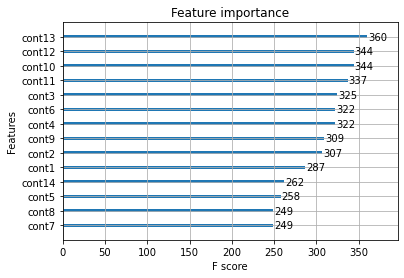

In [66]:
xgb.plot_importance(xg_reg)

### LightGBM

In [14]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l2', 'auc'],
    'learning_rate': 0.005,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 4,
    "num_leaves": 128,  
    "max_bin": 512,
    "num_iterations": 1000000,
    "n_estimators": 5000
}

In [19]:
#lightgbm = lgb.LGBMRegressor(**hyper_params)
lightgbm = lgb.LGBMRegressor(max_depth = 4, n_estimators = 40000, learning_rate = 0.001, sub_feature = 0.7, bagging_fraction = 0.7)

In [20]:
lightgbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l2',
        early_stopping_rounds=1000, verbose = 0)

[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.7. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


LGBMRegressor(bagging_fraction=0.7, learning_rate=0.001, max_depth=4,
              n_estimators=40000, sub_feature=0.7)

In [21]:
train_pred = lightgbm.predict(X_train)
score1 = np.sqrt(mean_squared_error(y_train, train_pred))
print("Training score:", round(score1,6))

predicted_labels = lightgbm.predict(X_test)
score2 = np.sqrt(mean_squared_error(y_test, predicted_labels))
print("Validation score:", round(score2,6))

Training score: 0.68954
Validation score: 0.703196


In [196]:
# (max_depth = 4, n_estimators = 2000) Training score: 0.674941 Validation score: 0.701612
# (max_depth = 2, n_estimators = 5000) Training score: 0.688713 Validation score: 0.702916
# (max_depth = 4, n_estimators = 2000, min_data_in_leaf = 15) Training score: 0.658775 Validation score: 0.702155
# (max_depth = 4, n_estimators = 2000, min_data_in_leaf = 10) Training score: 0.658282 Validation score: 0.702032
# (max_depth = 5, n_estimators = 4000, min_data_in_leaf = 10) Training score: 0.661665 Validation score: 0.701407
# (max_depth = 5, n_estimators = 2000, min_data_in_leaf = 10) Training score: 0.661665 Validation score: 0.701407
# (max_depth = 5, n_estimators = 2000, min_data_in_leaf = 10, learning_rate = 0.05) Training score: 0.645604 Validation score: 0.701873
# (max_depth = 5, n_estimators = 2000, min_data_in_leaf = 10, learning_rate = 0.15) Training score: 0.661923 Validation score: 0.701715
# (max_depth = 5, n_estimators = 2000, min_data_in_leaf = 10, learning_rate = 0.15, boosting_type = 'dart') Training score: 0.65169 Validation score: 0.702586
# (max_depth = 4, n_estimators = 2000, learning_rate = 0.05) Training score: 0.672641 Validation score: 0.701141
# (max_depth = 3, n_estimators = 3000, learning_rate = 0.05) Training score: 0.683807 Validation score: 0.702061
# (max_depth = 3, n_estimators = 4000, learning_rate = 0.05) Training score: 0.679393 Validation score: 0.701839
# (max_depth = 3, n_estimators = 3000, learning_rate = 0.01) Training score: 0.700938 Validation score: 0.707383
# (max_depth = 4, n_estimators = 3000, learning_rate = 0.01) Training score: 0.692911 Validation score: 0.704287
# (max_depth = 4, n_estimators = 6000, learning_rate = 0.01) Training score: 0.683128 Validation score: 0.701970
# (max_depth = 4, n_estimators = 2500, learning_rate = 0.03) Training score: 0.678743 Validation score: 0.701635
# (max_depth = 4, n_estimators = 2000, learning_rate = 0.03) Training score: 0.682843 Validation score: 0.702106
# (max_depth = 4, n_estimators = 2000, learning_rate = 0.05, bagging_fraction = 0.6) Training score: 0.672641 Validation score: 0.701141
# (max_depth = 4, n_estimators = 2000, learning_rate = 0.05, sub_feature = 0.8) Training score: 0.673014 Validation score: 0.700983
# (max_depth = 4, n_estimators = 2000, learning_rate = 0.04, sub_feature = 0.8) Training score: 0.677828 Validation score: 0.701408
# (max_depth = 4, n_estimators = 2000, learning_rate = 0.05, sub_feature = 0.7) Training score: 0.673315 Validation score: 0.701193
# (max_depth = 4, n_estimators = 2000, learning_rate = 0.05, sub_feature = 0.9) Training score: 0.672893 Validation score: 0.701249
# (max_depth = 4, n_estimators = 2000, learning_rate = 0.05, sub_feature = 0.85) Training score: 0.673051 Validation score: 0.701147
# (max_depth = 4, n_estimators = 2000, learning_rate = 0.05, sub_feature = 0.8, max_bin = 350) Training score: 0.672928 Validation score: 0.701111
# (max_depth = 4, n_estimators = 2000, learning_rate = 0.05, sub_feature = 0.8, max_bin = 200)Training score: 0.673701 Validation score: 0.701398
# (max_depth = 4, n_estimators = 5000, learning_rate = 0.01, sub_feature = 0.8) Training score: 0.686109 Validation score: 0.702405
# (max_depth = 4, n_estimators = 4000, learning_rate = 0.04, sub_feature = 0.8) Training score: 0.671437 Validation score: 0.701091
# (max_depth = 4, n_estimators = 10000, learning_rate = 0.03, sub_feature = 0.8) Training score: 0.669276 Validation score: 0.701109
# (max_depth = 4, n_estimators = 10000, learning_rate = 0.03, sub_feature = 0.7) Training score: 0.668806 Validation score: 0.700881
# (max_depth = 4, n_estimators = 10000, learning_rate = 0.03, sub_feature = 0.7, bagging_fraction = 0.7) Training score: 0.668806 Validation score: 0.700881
# (max_depth = 4, n_estimators = 12000, learning_rate = 0.01, sub_feature = 0.7, bagging_fraction = 0.7) Training score: 0.669312 Validation score: 0.700868
# (max_depth = 3, n_estimators = 12000, learning_rate = 0.01, sub_feature = 0.7, bagging_fraction = 0.7) Training score: 0.687229 Validation score: 0.702199
# (max_depth = 3, n_estimators = 20000, learning_rate = 0.01, sub_feature = 0.75, bagging_fraction = 0.75) Training score: 0.681215 Validation score: 0.70166
# (max_depth = 4, n_estimators = 25000, learning_rate = 0.02, sub_feature = 0.7, bagging_fraction = 0.7) Training score: 0.67009 Validation score: 0.700894
## (max_depth = 4, n_estimators = 25000, learning_rate = 0.005, sub_feature = 0.7, bagging_fraction = 0.7) Training score: 0.67104 Validation score: 0.700765
# (max_depth = 4, n_estimators = 25000, learning_rate = 0.005, sub_feature = 0.8, bagging_fraction = 0.8) Training score: 0.671406 Validation score: 0.700982
# (max_depth = 3, n_estimators = 25000, learning_rate = 0.005, sub_feature = 0.8, bagging_fraction = 0.8) Training score: 0.686694 Validation score: 0.702124
# (max_depth = 3, n_estimators = 50000, learning_rate = 0.005, sub_feature = 0.8, bagging_fraction = 0.8) Training score: 0.682211 Validation score: 0.701648
# (max_depth = 4, n_estimators = 25000, learning_rate = 0.005, num_leaves = 100) Training score: 0.66937 Validation score: 0.701048
# (max_depth = 4, n_estimators = 40000, learning_rate = 0.001, sub_feature = 0.7, bagging_fraction = 0.7) Training score: 0.68954 Validation score: 0.703196

In [11]:
#Predict test data 
pred_test = lightgbm.predict(test_df2)

In [12]:
submission = test_df[['id']].copy()
submission['target'] = pred_test

submission.to_csv("submission.csv", index=False)

### Catboost

In [24]:
!pip install catboost

In [6]:
from catboost import CatBoostRegressor

In [35]:
catboost = CatBoostRegressor(iterations=50000, depth=7, learning_rate=0.003, loss_function='RMSE', subsample = 0.7)

In [36]:
%%time

catboost.fit(X_train, y_train, eval_set=(X_test, y_test),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7328423	test: 0.7333739	best: 0.7333739 (0)	total: 30.2ms	remaining: 25m 11s
1:	learn: 0.7327769	test: 0.7333132	best: 0.7333132 (1)	total: 52.8ms	remaining: 21m 59s
2:	learn: 0.7327155	test: 0.7332556	best: 0.7332556 (2)	total: 75.4ms	remaining: 20m 55s
3:	learn: 0.7326506	test: 0.7331931	best: 0.7331931 (3)	total: 98.2ms	remaining: 20m 26s
4:	learn: 0.7325872	test: 0.7331319	best: 0.7331319 (4)	total: 121ms	remaining: 20m 12s
5:	learn: 0.7325234	test: 0.7330720	best: 0.7330720 (5)	total: 144ms	remaining: 19m 56s
6:	learn: 0.7324604	test: 0.7330127	best: 0.7330127 (6)	total: 166ms	remaining: 19m 44s
7:	learn: 0.7323973	test: 0.7329537	best: 0.7329537 (7)	total: 188ms	remaining: 19m 37s
8:	learn: 0.7323344	test: 0.7328947	best: 0.7328947 (8)	total: 211ms	remaining: 19m 33s
9:	learn: 0.7322737	test: 0.7328383	best: 0.7328383 (9)	total: 238ms	remaining: 19m 50s
10:	learn: 0.7322111	test: 0.7327789	best: 0.7327789 (10)	total: 263ms	remaining: 19m 52s
11:	learn: 0.7321485	test:

94:	learn: 0.7278706	test: 0.7286941	best: 0.7286941 (94)	total: 2.6s	remaining: 22m 47s
95:	learn: 0.7278327	test: 0.7286601	best: 0.7286601 (95)	total: 2.63s	remaining: 22m 46s
96:	learn: 0.7277913	test: 0.7286217	best: 0.7286217 (96)	total: 2.66s	remaining: 22m 47s
97:	learn: 0.7277485	test: 0.7285823	best: 0.7285823 (97)	total: 2.69s	remaining: 22m 48s
98:	learn: 0.7277066	test: 0.7285422	best: 0.7285422 (98)	total: 2.71s	remaining: 22m 46s
99:	learn: 0.7276648	test: 0.7285032	best: 0.7285032 (99)	total: 2.73s	remaining: 22m 44s
100:	learn: 0.7276227	test: 0.7284647	best: 0.7284647 (100)	total: 2.76s	remaining: 22m 42s
101:	learn: 0.7275820	test: 0.7284270	best: 0.7284270 (101)	total: 2.78s	remaining: 22m 40s
102:	learn: 0.7275430	test: 0.7283914	best: 0.7283914 (102)	total: 2.81s	remaining: 22m 41s
103:	learn: 0.7275007	test: 0.7283516	best: 0.7283516 (103)	total: 2.84s	remaining: 22m 41s
104:	learn: 0.7274600	test: 0.7283144	best: 0.7283144 (104)	total: 2.86s	remaining: 22m 41s
1

189:	learn: 0.7245360	test: 0.7256290	best: 0.7256290 (189)	total: 5.04s	remaining: 22m 1s
190:	learn: 0.7245097	test: 0.7256053	best: 0.7256053 (190)	total: 5.07s	remaining: 22m 1s
191:	learn: 0.7244797	test: 0.7255784	best: 0.7255784 (191)	total: 5.1s	remaining: 22m 2s
192:	learn: 0.7244485	test: 0.7255507	best: 0.7255507 (192)	total: 5.12s	remaining: 22m 1s
193:	learn: 0.7244203	test: 0.7255255	best: 0.7255255 (193)	total: 5.14s	remaining: 22m
194:	learn: 0.7243929	test: 0.7255014	best: 0.7255014 (194)	total: 5.17s	remaining: 21m 59s
195:	learn: 0.7243628	test: 0.7254740	best: 0.7254740 (195)	total: 5.19s	remaining: 21m 58s
196:	learn: 0.7243367	test: 0.7254492	best: 0.7254492 (196)	total: 5.21s	remaining: 21m 58s
197:	learn: 0.7243088	test: 0.7254241	best: 0.7254241 (197)	total: 5.24s	remaining: 21m 57s
198:	learn: 0.7242811	test: 0.7253986	best: 0.7253986 (198)	total: 5.26s	remaining: 21m 57s
199:	learn: 0.7242550	test: 0.7253749	best: 0.7253749 (199)	total: 5.3s	remaining: 21m 58

281:	learn: 0.7221775	test: 0.7235060	best: 0.7235060 (281)	total: 7.42s	remaining: 21m 49s
282:	learn: 0.7221546	test: 0.7234851	best: 0.7234851 (282)	total: 7.45s	remaining: 21m 49s
283:	learn: 0.7221328	test: 0.7234668	best: 0.7234668 (283)	total: 7.48s	remaining: 21m 49s
284:	learn: 0.7221103	test: 0.7234465	best: 0.7234465 (284)	total: 7.51s	remaining: 21m 49s
285:	learn: 0.7220864	test: 0.7234250	best: 0.7234250 (285)	total: 7.54s	remaining: 21m 50s
286:	learn: 0.7220669	test: 0.7234076	best: 0.7234076 (286)	total: 7.56s	remaining: 21m 50s
287:	learn: 0.7220469	test: 0.7233902	best: 0.7233902 (287)	total: 7.6s	remaining: 21m 51s
288:	learn: 0.7220256	test: 0.7233720	best: 0.7233720 (288)	total: 7.63s	remaining: 21m 52s
289:	learn: 0.7220033	test: 0.7233519	best: 0.7233519 (289)	total: 7.66s	remaining: 21m 52s
290:	learn: 0.7219828	test: 0.7233336	best: 0.7233336 (290)	total: 7.69s	remaining: 21m 53s
291:	learn: 0.7219627	test: 0.7233156	best: 0.7233156 (291)	total: 7.71s	remainin

372:	learn: 0.7203642	test: 0.7219097	best: 0.7219097 (372)	total: 9.84s	remaining: 21m 49s
373:	learn: 0.7203479	test: 0.7218956	best: 0.7218956 (373)	total: 9.87s	remaining: 21m 49s
374:	learn: 0.7203278	test: 0.7218769	best: 0.7218769 (374)	total: 9.9s	remaining: 21m 50s
375:	learn: 0.7203081	test: 0.7218589	best: 0.7218589 (375)	total: 9.93s	remaining: 21m 51s
376:	learn: 0.7202919	test: 0.7218442	best: 0.7218442 (376)	total: 9.96s	remaining: 21m 51s
377:	learn: 0.7202702	test: 0.7218253	best: 0.7218253 (377)	total: 9.99s	remaining: 21m 52s
378:	learn: 0.7202523	test: 0.7218099	best: 0.7218099 (378)	total: 10s	remaining: 21m 52s
379:	learn: 0.7202360	test: 0.7217942	best: 0.7217942 (379)	total: 10.1s	remaining: 21m 55s
380:	learn: 0.7202180	test: 0.7217796	best: 0.7217796 (380)	total: 10.1s	remaining: 21m 55s
381:	learn: 0.7202010	test: 0.7217648	best: 0.7217648 (381)	total: 10.1s	remaining: 21m 55s
382:	learn: 0.7201854	test: 0.7217514	best: 0.7217514 (382)	total: 10.2s	remaining:

467:	learn: 0.7188424	test: 0.7205899	best: 0.7205899 (467)	total: 13.2s	remaining: 23m 12s
468:	learn: 0.7188273	test: 0.7205772	best: 0.7205772 (468)	total: 13.2s	remaining: 23m 13s
469:	learn: 0.7188102	test: 0.7205616	best: 0.7205616 (469)	total: 13.2s	remaining: 23m 13s
470:	learn: 0.7187956	test: 0.7205495	best: 0.7205495 (470)	total: 13.3s	remaining: 23m 17s
471:	learn: 0.7187823	test: 0.7205389	best: 0.7205389 (471)	total: 13.3s	remaining: 23m 17s
472:	learn: 0.7187680	test: 0.7205271	best: 0.7205271 (472)	total: 13.3s	remaining: 23m 17s
473:	learn: 0.7187505	test: 0.7205118	best: 0.7205118 (473)	total: 13.4s	remaining: 23m 18s
474:	learn: 0.7187346	test: 0.7204982	best: 0.7204982 (474)	total: 13.4s	remaining: 23m 19s
475:	learn: 0.7187181	test: 0.7204826	best: 0.7204826 (475)	total: 13.5s	remaining: 23m 19s
476:	learn: 0.7187054	test: 0.7204715	best: 0.7204715 (476)	total: 13.5s	remaining: 23m 20s
477:	learn: 0.7186899	test: 0.7204573	best: 0.7204573 (477)	total: 13.5s	remaini

560:	learn: 0.7175771	test: 0.7195168	best: 0.7195168 (560)	total: 16.4s	remaining: 24m 1s
561:	learn: 0.7175630	test: 0.7195056	best: 0.7195056 (561)	total: 16.4s	remaining: 24m 2s
562:	learn: 0.7175495	test: 0.7194949	best: 0.7194949 (562)	total: 16.4s	remaining: 24m 3s
563:	learn: 0.7175384	test: 0.7194861	best: 0.7194861 (563)	total: 16.5s	remaining: 24m 6s
564:	learn: 0.7175232	test: 0.7194728	best: 0.7194728 (564)	total: 16.5s	remaining: 24m 6s
565:	learn: 0.7175106	test: 0.7194618	best: 0.7194618 (565)	total: 16.6s	remaining: 24m 6s
566:	learn: 0.7174986	test: 0.7194513	best: 0.7194513 (566)	total: 16.6s	remaining: 24m 7s
567:	learn: 0.7174879	test: 0.7194423	best: 0.7194423 (567)	total: 16.6s	remaining: 24m 8s
568:	learn: 0.7174753	test: 0.7194316	best: 0.7194316 (568)	total: 16.7s	remaining: 24m 8s
569:	learn: 0.7174635	test: 0.7194210	best: 0.7194210 (569)	total: 16.7s	remaining: 24m 8s
570:	learn: 0.7174509	test: 0.7194105	best: 0.7194105 (570)	total: 16.7s	remaining: 24m 8s

651:	learn: 0.7165209	test: 0.7186330	best: 0.7186330 (651)	total: 19.5s	remaining: 24m 37s
652:	learn: 0.7165086	test: 0.7186216	best: 0.7186216 (652)	total: 19.6s	remaining: 24m 38s
653:	learn: 0.7164958	test: 0.7186107	best: 0.7186107 (653)	total: 19.6s	remaining: 24m 38s
654:	learn: 0.7164847	test: 0.7186008	best: 0.7186008 (654)	total: 19.6s	remaining: 24m 38s
655:	learn: 0.7164727	test: 0.7185900	best: 0.7185900 (655)	total: 19.7s	remaining: 24m 38s
656:	learn: 0.7164627	test: 0.7185821	best: 0.7185821 (656)	total: 19.7s	remaining: 24m 38s
657:	learn: 0.7164513	test: 0.7185722	best: 0.7185722 (657)	total: 19.8s	remaining: 24m 41s
658:	learn: 0.7164419	test: 0.7185647	best: 0.7185647 (658)	total: 19.8s	remaining: 24m 41s
659:	learn: 0.7164323	test: 0.7185571	best: 0.7185571 (659)	total: 19.8s	remaining: 24m 42s
660:	learn: 0.7164224	test: 0.7185486	best: 0.7185486 (660)	total: 19.9s	remaining: 24m 42s
661:	learn: 0.7164117	test: 0.7185404	best: 0.7185404 (661)	total: 19.9s	remaini

747:	learn: 0.7155358	test: 0.7178085	best: 0.7178085 (747)	total: 22.8s	remaining: 25m 1s
748:	learn: 0.7155276	test: 0.7178023	best: 0.7178023 (748)	total: 22.8s	remaining: 25m 1s
749:	learn: 0.7155170	test: 0.7177928	best: 0.7177928 (749)	total: 22.9s	remaining: 25m 1s
750:	learn: 0.7155071	test: 0.7177848	best: 0.7177848 (750)	total: 22.9s	remaining: 25m 4s
751:	learn: 0.7154955	test: 0.7177755	best: 0.7177755 (751)	total: 23s	remaining: 25m 4s
752:	learn: 0.7154870	test: 0.7177684	best: 0.7177684 (752)	total: 23s	remaining: 25m 4s
753:	learn: 0.7154766	test: 0.7177597	best: 0.7177597 (753)	total: 23s	remaining: 25m 4s
754:	learn: 0.7154683	test: 0.7177529	best: 0.7177529 (754)	total: 23.1s	remaining: 25m 4s
755:	learn: 0.7154613	test: 0.7177470	best: 0.7177470 (755)	total: 23.1s	remaining: 25m 4s
756:	learn: 0.7154530	test: 0.7177395	best: 0.7177395 (756)	total: 23.1s	remaining: 25m 4s
757:	learn: 0.7154432	test: 0.7177314	best: 0.7177314 (757)	total: 23.2s	remaining: 25m 4s
758:	

841:	learn: 0.7146985	test: 0.7171244	best: 0.7171244 (841)	total: 26.1s	remaining: 25m 25s
842:	learn: 0.7146877	test: 0.7171163	best: 0.7171163 (842)	total: 26.2s	remaining: 25m 28s
843:	learn: 0.7146772	test: 0.7171077	best: 0.7171077 (843)	total: 26.2s	remaining: 25m 28s
844:	learn: 0.7146694	test: 0.7171022	best: 0.7171022 (844)	total: 26.3s	remaining: 25m 29s
845:	learn: 0.7146596	test: 0.7170942	best: 0.7170942 (845)	total: 26.3s	remaining: 25m 29s
846:	learn: 0.7146516	test: 0.7170880	best: 0.7170880 (846)	total: 26.3s	remaining: 25m 28s
847:	learn: 0.7146433	test: 0.7170816	best: 0.7170816 (847)	total: 26.4s	remaining: 25m 29s
848:	learn: 0.7146361	test: 0.7170765	best: 0.7170765 (848)	total: 26.4s	remaining: 25m 29s
849:	learn: 0.7146252	test: 0.7170668	best: 0.7170668 (849)	total: 26.4s	remaining: 25m 29s
850:	learn: 0.7146164	test: 0.7170585	best: 0.7170585 (850)	total: 26.5s	remaining: 25m 28s
851:	learn: 0.7146080	test: 0.7170529	best: 0.7170529 (851)	total: 26.5s	remaini

934:	learn: 0.7139352	test: 0.7165191	best: 0.7165191 (934)	total: 29.4s	remaining: 25m 44s
935:	learn: 0.7139276	test: 0.7165130	best: 0.7165130 (935)	total: 29.5s	remaining: 25m 45s
936:	learn: 0.7139181	test: 0.7165046	best: 0.7165046 (936)	total: 29.5s	remaining: 25m 45s
937:	learn: 0.7139111	test: 0.7164992	best: 0.7164992 (937)	total: 29.6s	remaining: 25m 48s
938:	learn: 0.7139029	test: 0.7164928	best: 0.7164928 (938)	total: 29.6s	remaining: 25m 48s
939:	learn: 0.7138953	test: 0.7164861	best: 0.7164861 (939)	total: 29.7s	remaining: 25m 48s
940:	learn: 0.7138879	test: 0.7164805	best: 0.7164805 (940)	total: 29.7s	remaining: 25m 49s
941:	learn: 0.7138778	test: 0.7164724	best: 0.7164724 (941)	total: 29.7s	remaining: 25m 49s
942:	learn: 0.7138710	test: 0.7164676	best: 0.7164676 (942)	total: 29.8s	remaining: 25m 48s
943:	learn: 0.7138636	test: 0.7164613	best: 0.7164613 (943)	total: 29.8s	remaining: 25m 48s
944:	learn: 0.7138567	test: 0.7164563	best: 0.7164563 (944)	total: 29.8s	remaini

1024:	learn: 0.7132582	test: 0.7159846	best: 0.7159846 (1024)	total: 32.5s	remaining: 25m 53s
1025:	learn: 0.7132519	test: 0.7159795	best: 0.7159795 (1025)	total: 32.5s	remaining: 25m 53s
1026:	learn: 0.7132453	test: 0.7159737	best: 0.7159737 (1026)	total: 32.6s	remaining: 25m 53s
1027:	learn: 0.7132381	test: 0.7159680	best: 0.7159680 (1027)	total: 32.6s	remaining: 25m 53s
1028:	learn: 0.7132305	test: 0.7159618	best: 0.7159618 (1028)	total: 32.6s	remaining: 25m 53s
1029:	learn: 0.7132240	test: 0.7159563	best: 0.7159563 (1029)	total: 32.7s	remaining: 25m 53s
1030:	learn: 0.7132177	test: 0.7159519	best: 0.7159519 (1030)	total: 32.7s	remaining: 25m 53s
1031:	learn: 0.7132116	test: 0.7159479	best: 0.7159479 (1031)	total: 32.7s	remaining: 25m 53s
1032:	learn: 0.7132058	test: 0.7159436	best: 0.7159436 (1032)	total: 32.8s	remaining: 25m 53s
1033:	learn: 0.7131998	test: 0.7159390	best: 0.7159390 (1033)	total: 32.9s	remaining: 25m 55s
1034:	learn: 0.7131938	test: 0.7159342	best: 0.7159342 (1034

1113:	learn: 0.7126622	test: 0.7155079	best: 0.7155079 (1113)	total: 35.5s	remaining: 25m 57s
1114:	learn: 0.7126564	test: 0.7155037	best: 0.7155037 (1114)	total: 35.5s	remaining: 25m 57s
1115:	learn: 0.7126491	test: 0.7154973	best: 0.7154973 (1115)	total: 35.6s	remaining: 25m 58s
1116:	learn: 0.7126443	test: 0.7154935	best: 0.7154935 (1116)	total: 35.6s	remaining: 25m 58s
1117:	learn: 0.7126363	test: 0.7154870	best: 0.7154870 (1117)	total: 35.6s	remaining: 25m 58s
1118:	learn: 0.7126303	test: 0.7154819	best: 0.7154819 (1118)	total: 35.7s	remaining: 25m 58s
1119:	learn: 0.7126232	test: 0.7154767	best: 0.7154767 (1119)	total: 35.7s	remaining: 25m 58s
1120:	learn: 0.7126150	test: 0.7154703	best: 0.7154703 (1120)	total: 35.8s	remaining: 25m 58s
1121:	learn: 0.7126094	test: 0.7154660	best: 0.7154660 (1121)	total: 35.8s	remaining: 25m 59s
1122:	learn: 0.7126037	test: 0.7154616	best: 0.7154616 (1122)	total: 35.8s	remaining: 25m 59s
1123:	learn: 0.7125984	test: 0.7154581	best: 0.7154581 (1123

1207:	learn: 0.7120613	test: 0.7150406	best: 0.7150406 (1207)	total: 38.7s	remaining: 26m 5s
1208:	learn: 0.7120552	test: 0.7150357	best: 0.7150357 (1208)	total: 38.8s	remaining: 26m 5s
1209:	learn: 0.7120498	test: 0.7150317	best: 0.7150317 (1209)	total: 38.8s	remaining: 26m 5s
1210:	learn: 0.7120426	test: 0.7150257	best: 0.7150257 (1210)	total: 38.9s	remaining: 26m 5s
1211:	learn: 0.7120364	test: 0.7150213	best: 0.7150213 (1211)	total: 38.9s	remaining: 26m 5s
1212:	learn: 0.7120308	test: 0.7150166	best: 0.7150166 (1212)	total: 38.9s	remaining: 26m 5s
1213:	learn: 0.7120256	test: 0.7150123	best: 0.7150123 (1213)	total: 39s	remaining: 26m 5s
1214:	learn: 0.7120176	test: 0.7150051	best: 0.7150051 (1214)	total: 39s	remaining: 26m 5s
1215:	learn: 0.7120116	test: 0.7150006	best: 0.7150006 (1215)	total: 39s	remaining: 26m 5s
1216:	learn: 0.7120046	test: 0.7149964	best: 0.7149964 (1216)	total: 39s	remaining: 26m 5s
1217:	learn: 0.7119975	test: 0.7149902	best: 0.7149902 (1217)	total: 39.1s	rem

1296:	learn: 0.7115369	test: 0.7146345	best: 0.7146345 (1296)	total: 41.8s	remaining: 26m 10s
1297:	learn: 0.7115328	test: 0.7146317	best: 0.7146317 (1297)	total: 41.8s	remaining: 26m 10s
1298:	learn: 0.7115292	test: 0.7146281	best: 0.7146281 (1298)	total: 41.9s	remaining: 26m 10s
1299:	learn: 0.7115228	test: 0.7146229	best: 0.7146229 (1299)	total: 41.9s	remaining: 26m 9s
1300:	learn: 0.7115168	test: 0.7146189	best: 0.7146189 (1300)	total: 41.9s	remaining: 26m 9s
1301:	learn: 0.7115116	test: 0.7146144	best: 0.7146144 (1301)	total: 42s	remaining: 26m 9s
1302:	learn: 0.7115046	test: 0.7146093	best: 0.7146093 (1302)	total: 42s	remaining: 26m 9s
1303:	learn: 0.7114975	test: 0.7146030	best: 0.7146030 (1303)	total: 42s	remaining: 26m 9s
1304:	learn: 0.7114916	test: 0.7145982	best: 0.7145982 (1304)	total: 42.1s	remaining: 26m 9s
1305:	learn: 0.7114854	test: 0.7145924	best: 0.7145924 (1305)	total: 42.1s	remaining: 26m 9s
1306:	learn: 0.7114784	test: 0.7145875	best: 0.7145875 (1306)	total: 42.1

1387:	learn: 0.7110237	test: 0.7142309	best: 0.7142309 (1387)	total: 44.9s	remaining: 26m 12s
1388:	learn: 0.7110175	test: 0.7142256	best: 0.7142256 (1388)	total: 44.9s	remaining: 26m 12s
1389:	learn: 0.7110139	test: 0.7142230	best: 0.7142230 (1389)	total: 45s	remaining: 26m 12s
1390:	learn: 0.7110089	test: 0.7142189	best: 0.7142189 (1390)	total: 45s	remaining: 26m 12s
1391:	learn: 0.7110042	test: 0.7142157	best: 0.7142157 (1391)	total: 45s	remaining: 26m 11s
1392:	learn: 0.7109994	test: 0.7142122	best: 0.7142122 (1392)	total: 45s	remaining: 26m 11s
1393:	learn: 0.7109929	test: 0.7142064	best: 0.7142064 (1393)	total: 45.1s	remaining: 26m 11s
1394:	learn: 0.7109889	test: 0.7142035	best: 0.7142035 (1394)	total: 45.1s	remaining: 26m 11s
1395:	learn: 0.7109837	test: 0.7141999	best: 0.7141999 (1395)	total: 45.1s	remaining: 26m 11s
1396:	learn: 0.7109778	test: 0.7141957	best: 0.7141957 (1396)	total: 45.2s	remaining: 26m 11s
1397:	learn: 0.7109723	test: 0.7141913	best: 0.7141913 (1397)	total:

1477:	learn: 0.7105522	test: 0.7138658	best: 0.7138658 (1477)	total: 48s	remaining: 26m 17s
1478:	learn: 0.7105459	test: 0.7138606	best: 0.7138606 (1478)	total: 48.2s	remaining: 26m 20s
1479:	learn: 0.7105399	test: 0.7138553	best: 0.7138553 (1479)	total: 48.2s	remaining: 26m 20s
1480:	learn: 0.7105346	test: 0.7138523	best: 0.7138523 (1480)	total: 48.2s	remaining: 26m 19s
1481:	learn: 0.7105290	test: 0.7138478	best: 0.7138478 (1481)	total: 48.3s	remaining: 26m 19s
1482:	learn: 0.7105241	test: 0.7138441	best: 0.7138441 (1482)	total: 48.3s	remaining: 26m 19s
1483:	learn: 0.7105199	test: 0.7138408	best: 0.7138408 (1483)	total: 48.3s	remaining: 26m 19s
1484:	learn: 0.7105158	test: 0.7138379	best: 0.7138379 (1484)	total: 48.3s	remaining: 26m 19s
1485:	learn: 0.7105107	test: 0.7138340	best: 0.7138340 (1485)	total: 48.4s	remaining: 26m 19s
1486:	learn: 0.7105058	test: 0.7138299	best: 0.7138299 (1486)	total: 48.4s	remaining: 26m 19s
1487:	learn: 0.7105009	test: 0.7138259	best: 0.7138259 (1487)	

1568:	learn: 0.7101031	test: 0.7135262	best: 0.7135262 (1568)	total: 51.2s	remaining: 26m 20s
1569:	learn: 0.7100981	test: 0.7135225	best: 0.7135225 (1569)	total: 51.2s	remaining: 26m 20s
1570:	learn: 0.7100939	test: 0.7135190	best: 0.7135190 (1570)	total: 51.3s	remaining: 26m 20s
1571:	learn: 0.7100899	test: 0.7135163	best: 0.7135163 (1571)	total: 51.3s	remaining: 26m 20s
1572:	learn: 0.7100838	test: 0.7135120	best: 0.7135120 (1572)	total: 51.3s	remaining: 26m 20s
1573:	learn: 0.7100794	test: 0.7135094	best: 0.7135094 (1573)	total: 51.4s	remaining: 26m 20s
1574:	learn: 0.7100756	test: 0.7135069	best: 0.7135069 (1574)	total: 51.4s	remaining: 26m 20s
1575:	learn: 0.7100715	test: 0.7135039	best: 0.7135039 (1575)	total: 51.5s	remaining: 26m 22s
1576:	learn: 0.7100669	test: 0.7135003	best: 0.7135003 (1576)	total: 51.5s	remaining: 26m 22s
1577:	learn: 0.7100608	test: 0.7134955	best: 0.7134955 (1577)	total: 51.6s	remaining: 26m 22s
1578:	learn: 0.7100557	test: 0.7134917	best: 0.7134917 (1578

1656:	learn: 0.7096886	test: 0.7132135	best: 0.7132135 (1656)	total: 54.3s	remaining: 26m 24s
1657:	learn: 0.7096845	test: 0.7132109	best: 0.7132109 (1657)	total: 54.4s	remaining: 26m 24s
1658:	learn: 0.7096807	test: 0.7132084	best: 0.7132084 (1658)	total: 54.4s	remaining: 26m 24s
1659:	learn: 0.7096765	test: 0.7132055	best: 0.7132055 (1659)	total: 54.4s	remaining: 26m 25s
1660:	learn: 0.7096732	test: 0.7132030	best: 0.7132030 (1660)	total: 54.5s	remaining: 26m 25s
1661:	learn: 0.7096674	test: 0.7131986	best: 0.7131986 (1661)	total: 54.5s	remaining: 26m 24s
1662:	learn: 0.7096636	test: 0.7131964	best: 0.7131964 (1662)	total: 54.5s	remaining: 26m 25s
1663:	learn: 0.7096562	test: 0.7131903	best: 0.7131903 (1663)	total: 54.6s	remaining: 26m 25s
1664:	learn: 0.7096495	test: 0.7131846	best: 0.7131846 (1664)	total: 54.6s	remaining: 26m 25s
1665:	learn: 0.7096449	test: 0.7131816	best: 0.7131816 (1665)	total: 54.6s	remaining: 26m 25s
1666:	learn: 0.7096407	test: 0.7131779	best: 0.7131779 (1666

1746:	learn: 0.7092908	test: 0.7129210	best: 0.7129210 (1746)	total: 57.5s	remaining: 26m 28s
1747:	learn: 0.7092857	test: 0.7129160	best: 0.7129160 (1747)	total: 57.5s	remaining: 26m 28s
1748:	learn: 0.7092829	test: 0.7129141	best: 0.7129141 (1748)	total: 57.6s	remaining: 26m 28s
1749:	learn: 0.7092781	test: 0.7129101	best: 0.7129101 (1749)	total: 57.6s	remaining: 26m 27s
1750:	learn: 0.7092736	test: 0.7129075	best: 0.7129075 (1750)	total: 57.6s	remaining: 26m 27s
1751:	learn: 0.7092694	test: 0.7129052	best: 0.7129052 (1751)	total: 57.6s	remaining: 26m 27s
1752:	learn: 0.7092647	test: 0.7129025	best: 0.7129025 (1752)	total: 57.7s	remaining: 26m 27s
1753:	learn: 0.7092606	test: 0.7128992	best: 0.7128992 (1753)	total: 57.7s	remaining: 26m 27s
1754:	learn: 0.7092564	test: 0.7128971	best: 0.7128971 (1754)	total: 57.7s	remaining: 26m 27s
1755:	learn: 0.7092514	test: 0.7128928	best: 0.7128928 (1755)	total: 57.8s	remaining: 26m 27s
1756:	learn: 0.7092475	test: 0.7128903	best: 0.7128903 (1756

1840:	learn: 0.7088763	test: 0.7126163	best: 0.7126163 (1840)	total: 1m	remaining: 26m 31s
1841:	learn: 0.7088721	test: 0.7126129	best: 0.7126129 (1841)	total: 1m	remaining: 26m 31s
1842:	learn: 0.7088676	test: 0.7126093	best: 0.7126093 (1842)	total: 1m	remaining: 26m 31s
1843:	learn: 0.7088646	test: 0.7126068	best: 0.7126068 (1843)	total: 1m	remaining: 26m 30s
1844:	learn: 0.7088607	test: 0.7126044	best: 0.7126044 (1844)	total: 1m	remaining: 26m 30s
1845:	learn: 0.7088557	test: 0.7126015	best: 0.7126015 (1845)	total: 1m	remaining: 26m 30s
1846:	learn: 0.7088517	test: 0.7125982	best: 0.7125982 (1846)	total: 1m 1s	remaining: 26m 30s
1847:	learn: 0.7088468	test: 0.7125945	best: 0.7125945 (1847)	total: 1m 1s	remaining: 26m 30s
1848:	learn: 0.7088442	test: 0.7125927	best: 0.7125927 (1848)	total: 1m 1s	remaining: 26m 30s
1849:	learn: 0.7088398	test: 0.7125891	best: 0.7125891 (1849)	total: 1m 1s	remaining: 26m 30s
1850:	learn: 0.7088358	test: 0.7125856	best: 0.7125856 (1850)	total: 1m 1s	rem

1934:	learn: 0.7084723	test: 0.7123179	best: 0.7123179 (1934)	total: 1m 4s	remaining: 26m 36s
1935:	learn: 0.7084675	test: 0.7123145	best: 0.7123145 (1935)	total: 1m 4s	remaining: 26m 36s
1936:	learn: 0.7084647	test: 0.7123127	best: 0.7123127 (1936)	total: 1m 4s	remaining: 26m 36s
1937:	learn: 0.7084613	test: 0.7123106	best: 0.7123106 (1937)	total: 1m 4s	remaining: 26m 36s
1938:	learn: 0.7084570	test: 0.7123077	best: 0.7123077 (1938)	total: 1m 4s	remaining: 26m 35s
1939:	learn: 0.7084531	test: 0.7123050	best: 0.7123050 (1939)	total: 1m 4s	remaining: 26m 35s
1940:	learn: 0.7084484	test: 0.7123017	best: 0.7123017 (1940)	total: 1m 4s	remaining: 26m 35s
1941:	learn: 0.7084435	test: 0.7122980	best: 0.7122980 (1941)	total: 1m 4s	remaining: 26m 35s
1942:	learn: 0.7084378	test: 0.7122940	best: 0.7122940 (1942)	total: 1m 4s	remaining: 26m 35s
1943:	learn: 0.7084344	test: 0.7122915	best: 0.7122915 (1943)	total: 1m 4s	remaining: 26m 35s
1944:	learn: 0.7084308	test: 0.7122886	best: 0.7122886 (1944

2023:	learn: 0.7081239	test: 0.7120707	best: 0.7120707 (2023)	total: 1m 7s	remaining: 26m 41s
2024:	learn: 0.7081202	test: 0.7120677	best: 0.7120677 (2024)	total: 1m 7s	remaining: 26m 41s
2025:	learn: 0.7081167	test: 0.7120649	best: 0.7120649 (2025)	total: 1m 7s	remaining: 26m 41s
2026:	learn: 0.7081132	test: 0.7120626	best: 0.7120626 (2026)	total: 1m 7s	remaining: 26m 41s
2027:	learn: 0.7081101	test: 0.7120612	best: 0.7120612 (2027)	total: 1m 7s	remaining: 26m 41s
2028:	learn: 0.7081062	test: 0.7120589	best: 0.7120589 (2028)	total: 1m 7s	remaining: 26m 40s
2029:	learn: 0.7081034	test: 0.7120567	best: 0.7120567 (2029)	total: 1m 7s	remaining: 26m 40s
2030:	learn: 0.7080997	test: 0.7120545	best: 0.7120545 (2030)	total: 1m 7s	remaining: 26m 40s
2031:	learn: 0.7080949	test: 0.7120514	best: 0.7120514 (2031)	total: 1m 7s	remaining: 26m 40s
2032:	learn: 0.7080907	test: 0.7120483	best: 0.7120483 (2032)	total: 1m 7s	remaining: 26m 40s
2033:	learn: 0.7080864	test: 0.7120454	best: 0.7120454 (2033

2115:	learn: 0.7077676	test: 0.7118160	best: 0.7118160 (2115)	total: 1m 10s	remaining: 26m 40s
2116:	learn: 0.7077646	test: 0.7118138	best: 0.7118138 (2116)	total: 1m 10s	remaining: 26m 40s
2117:	learn: 0.7077620	test: 0.7118123	best: 0.7118123 (2117)	total: 1m 10s	remaining: 26m 40s
2118:	learn: 0.7077576	test: 0.7118090	best: 0.7118090 (2118)	total: 1m 10s	remaining: 26m 40s
2119:	learn: 0.7077543	test: 0.7118067	best: 0.7118067 (2119)	total: 1m 10s	remaining: 26m 39s
2120:	learn: 0.7077517	test: 0.7118051	best: 0.7118051 (2120)	total: 1m 10s	remaining: 26m 42s
2121:	learn: 0.7077487	test: 0.7118023	best: 0.7118023 (2121)	total: 1m 11s	remaining: 26m 42s
2122:	learn: 0.7077445	test: 0.7117993	best: 0.7117993 (2122)	total: 1m 11s	remaining: 26m 42s
2123:	learn: 0.7077415	test: 0.7117969	best: 0.7117969 (2123)	total: 1m 11s	remaining: 26m 42s
2124:	learn: 0.7077379	test: 0.7117949	best: 0.7117949 (2124)	total: 1m 11s	remaining: 26m 41s
2125:	learn: 0.7077338	test: 0.7117918	best: 0.711

2202:	learn: 0.7074507	test: 0.7115975	best: 0.7115975 (2202)	total: 1m 13s	remaining: 26m 40s
2203:	learn: 0.7074466	test: 0.7115950	best: 0.7115950 (2203)	total: 1m 13s	remaining: 26m 40s
2204:	learn: 0.7074438	test: 0.7115926	best: 0.7115926 (2204)	total: 1m 13s	remaining: 26m 40s
2205:	learn: 0.7074406	test: 0.7115897	best: 0.7115897 (2205)	total: 1m 13s	remaining: 26m 39s
2206:	learn: 0.7074372	test: 0.7115868	best: 0.7115868 (2206)	total: 1m 13s	remaining: 26m 39s
2207:	learn: 0.7074330	test: 0.7115834	best: 0.7115834 (2207)	total: 1m 13s	remaining: 26m 39s
2208:	learn: 0.7074289	test: 0.7115802	best: 0.7115802 (2208)	total: 1m 13s	remaining: 26m 39s
2209:	learn: 0.7074260	test: 0.7115782	best: 0.7115782 (2209)	total: 1m 13s	remaining: 26m 39s
2210:	learn: 0.7074238	test: 0.7115767	best: 0.7115767 (2210)	total: 1m 14s	remaining: 26m 39s
2211:	learn: 0.7074178	test: 0.7115718	best: 0.7115718 (2211)	total: 1m 14s	remaining: 26m 39s
2212:	learn: 0.7074150	test: 0.7115698	best: 0.711

2294:	learn: 0.7071229	test: 0.7113616	best: 0.7113616 (2294)	total: 1m 17s	remaining: 26m 41s
2295:	learn: 0.7071188	test: 0.7113586	best: 0.7113586 (2295)	total: 1m 17s	remaining: 26m 41s
2296:	learn: 0.7071150	test: 0.7113556	best: 0.7113556 (2296)	total: 1m 17s	remaining: 26m 41s
2297:	learn: 0.7071116	test: 0.7113534	best: 0.7113534 (2297)	total: 1m 17s	remaining: 26m 41s
2298:	learn: 0.7071080	test: 0.7113513	best: 0.7113513 (2298)	total: 1m 17s	remaining: 26m 41s
2299:	learn: 0.7071050	test: 0.7113493	best: 0.7113493 (2299)	total: 1m 17s	remaining: 26m 41s
2300:	learn: 0.7071023	test: 0.7113473	best: 0.7113473 (2300)	total: 1m 17s	remaining: 26m 40s
2301:	learn: 0.7070990	test: 0.7113450	best: 0.7113450 (2301)	total: 1m 17s	remaining: 26m 40s
2302:	learn: 0.7070947	test: 0.7113419	best: 0.7113419 (2302)	total: 1m 17s	remaining: 26m 40s
2303:	learn: 0.7070924	test: 0.7113408	best: 0.7113408 (2303)	total: 1m 17s	remaining: 26m 40s
2304:	learn: 0.7070888	test: 0.7113388	best: 0.711

2382:	learn: 0.7068171	test: 0.7111437	best: 0.7111437 (2382)	total: 1m 20s	remaining: 26m 43s
2383:	learn: 0.7068135	test: 0.7111423	best: 0.7111423 (2383)	total: 1m 20s	remaining: 26m 43s
2384:	learn: 0.7068085	test: 0.7111384	best: 0.7111384 (2384)	total: 1m 20s	remaining: 26m 43s
2385:	learn: 0.7068045	test: 0.7111356	best: 0.7111356 (2385)	total: 1m 20s	remaining: 26m 43s
2386:	learn: 0.7068010	test: 0.7111332	best: 0.7111332 (2386)	total: 1m 20s	remaining: 26m 43s
2387:	learn: 0.7067982	test: 0.7111313	best: 0.7111313 (2387)	total: 1m 20s	remaining: 26m 43s
2388:	learn: 0.7067946	test: 0.7111286	best: 0.7111286 (2388)	total: 1m 20s	remaining: 26m 43s
2389:	learn: 0.7067914	test: 0.7111264	best: 0.7111264 (2389)	total: 1m 20s	remaining: 26m 43s
2390:	learn: 0.7067890	test: 0.7111248	best: 0.7111248 (2390)	total: 1m 20s	remaining: 26m 42s
2391:	learn: 0.7067849	test: 0.7111222	best: 0.7111222 (2391)	total: 1m 20s	remaining: 26m 42s
2392:	learn: 0.7067820	test: 0.7111202	best: 0.711

2469:	learn: 0.7065062	test: 0.7109283	best: 0.7109283 (2469)	total: 1m 23s	remaining: 26m 44s
2470:	learn: 0.7065038	test: 0.7109263	best: 0.7109263 (2470)	total: 1m 23s	remaining: 26m 44s
2471:	learn: 0.7064995	test: 0.7109241	best: 0.7109241 (2471)	total: 1m 23s	remaining: 26m 44s
2472:	learn: 0.7064961	test: 0.7109221	best: 0.7109221 (2472)	total: 1m 23s	remaining: 26m 44s
2473:	learn: 0.7064921	test: 0.7109194	best: 0.7109194 (2473)	total: 1m 23s	remaining: 26m 44s
2474:	learn: 0.7064887	test: 0.7109171	best: 0.7109171 (2474)	total: 1m 23s	remaining: 26m 46s
2475:	learn: 0.7064863	test: 0.7109158	best: 0.7109158 (2475)	total: 1m 23s	remaining: 26m 46s
2476:	learn: 0.7064834	test: 0.7109145	best: 0.7109145 (2476)	total: 1m 23s	remaining: 26m 46s
2477:	learn: 0.7064809	test: 0.7109131	best: 0.7109131 (2477)	total: 1m 23s	remaining: 26m 46s
2478:	learn: 0.7064779	test: 0.7109117	best: 0.7109117 (2478)	total: 1m 23s	remaining: 26m 46s
2479:	learn: 0.7064754	test: 0.7109098	best: 0.710

2561:	learn: 0.7062060	test: 0.7107258	best: 0.7107258 (2561)	total: 1m 26s	remaining: 26m 45s
2562:	learn: 0.7062029	test: 0.7107229	best: 0.7107229 (2562)	total: 1m 26s	remaining: 26m 45s
2563:	learn: 0.7061992	test: 0.7107213	best: 0.7107213 (2563)	total: 1m 26s	remaining: 26m 45s
2564:	learn: 0.7061966	test: 0.7107194	best: 0.7107194 (2564)	total: 1m 26s	remaining: 26m 45s
2565:	learn: 0.7061937	test: 0.7107173	best: 0.7107173 (2565)	total: 1m 26s	remaining: 26m 45s
2566:	learn: 0.7061908	test: 0.7107146	best: 0.7107146 (2566)	total: 1m 26s	remaining: 26m 45s
2567:	learn: 0.7061875	test: 0.7107127	best: 0.7107127 (2567)	total: 1m 26s	remaining: 26m 45s
2568:	learn: 0.7061843	test: 0.7107106	best: 0.7107106 (2568)	total: 1m 26s	remaining: 26m 45s
2569:	learn: 0.7061809	test: 0.7107085	best: 0.7107085 (2569)	total: 1m 26s	remaining: 26m 45s
2570:	learn: 0.7061787	test: 0.7107068	best: 0.7107068 (2570)	total: 1m 27s	remaining: 26m 45s
2571:	learn: 0.7061753	test: 0.7107045	best: 0.710

2653:	learn: 0.7059214	test: 0.7105368	best: 0.7105368 (2653)	total: 1m 30s	remaining: 26m 48s
2654:	learn: 0.7059189	test: 0.7105353	best: 0.7105353 (2654)	total: 1m 30s	remaining: 26m 48s
2655:	learn: 0.7059160	test: 0.7105336	best: 0.7105336 (2655)	total: 1m 30s	remaining: 26m 47s
2656:	learn: 0.7059133	test: 0.7105318	best: 0.7105318 (2656)	total: 1m 30s	remaining: 26m 47s
2657:	learn: 0.7059110	test: 0.7105299	best: 0.7105299 (2657)	total: 1m 30s	remaining: 26m 47s
2658:	learn: 0.7059087	test: 0.7105282	best: 0.7105282 (2658)	total: 1m 30s	remaining: 26m 47s
2659:	learn: 0.7059044	test: 0.7105255	best: 0.7105255 (2659)	total: 1m 30s	remaining: 26m 47s
2660:	learn: 0.7059011	test: 0.7105234	best: 0.7105234 (2660)	total: 1m 30s	remaining: 26m 47s
2661:	learn: 0.7058979	test: 0.7105216	best: 0.7105216 (2661)	total: 1m 30s	remaining: 26m 47s
2662:	learn: 0.7058933	test: 0.7105177	best: 0.7105177 (2662)	total: 1m 30s	remaining: 26m 47s
2663:	learn: 0.7058897	test: 0.7105153	best: 0.710

2744:	learn: 0.7056345	test: 0.7103407	best: 0.7103407 (2744)	total: 1m 33s	remaining: 26m 48s
2745:	learn: 0.7056314	test: 0.7103383	best: 0.7103383 (2745)	total: 1m 33s	remaining: 26m 48s
2746:	learn: 0.7056290	test: 0.7103365	best: 0.7103365 (2746)	total: 1m 33s	remaining: 26m 48s
2747:	learn: 0.7056253	test: 0.7103340	best: 0.7103340 (2747)	total: 1m 33s	remaining: 26m 48s
2748:	learn: 0.7056217	test: 0.7103314	best: 0.7103314 (2748)	total: 1m 33s	remaining: 26m 48s
2749:	learn: 0.7056182	test: 0.7103291	best: 0.7103291 (2749)	total: 1m 33s	remaining: 26m 47s
2750:	learn: 0.7056160	test: 0.7103275	best: 0.7103275 (2750)	total: 1m 33s	remaining: 26m 47s
2751:	learn: 0.7056131	test: 0.7103252	best: 0.7103252 (2751)	total: 1m 33s	remaining: 26m 47s
2752:	learn: 0.7056100	test: 0.7103225	best: 0.7103225 (2752)	total: 1m 33s	remaining: 26m 47s
2753:	learn: 0.7056070	test: 0.7103204	best: 0.7103204 (2753)	total: 1m 33s	remaining: 26m 47s
2754:	learn: 0.7056040	test: 0.7103179	best: 0.710

2834:	learn: 0.7053584	test: 0.7101516	best: 0.7101516 (2834)	total: 1m 36s	remaining: 26m 48s
2835:	learn: 0.7053556	test: 0.7101503	best: 0.7101503 (2835)	total: 1m 36s	remaining: 26m 50s
2836:	learn: 0.7053532	test: 0.7101493	best: 0.7101493 (2836)	total: 1m 36s	remaining: 26m 50s
2837:	learn: 0.7053505	test: 0.7101472	best: 0.7101472 (2837)	total: 1m 36s	remaining: 26m 49s
2838:	learn: 0.7053480	test: 0.7101449	best: 0.7101449 (2838)	total: 1m 36s	remaining: 26m 49s
2839:	learn: 0.7053455	test: 0.7101432	best: 0.7101432 (2839)	total: 1m 36s	remaining: 26m 49s
2840:	learn: 0.7053426	test: 0.7101411	best: 0.7101411 (2840)	total: 1m 36s	remaining: 26m 49s
2841:	learn: 0.7053394	test: 0.7101389	best: 0.7101389 (2841)	total: 1m 37s	remaining: 26m 49s
2842:	learn: 0.7053362	test: 0.7101370	best: 0.7101370 (2842)	total: 1m 37s	remaining: 26m 49s
2843:	learn: 0.7053339	test: 0.7101354	best: 0.7101354 (2843)	total: 1m 37s	remaining: 26m 49s
2844:	learn: 0.7053305	test: 0.7101318	best: 0.710

2922:	learn: 0.7050920	test: 0.7099709	best: 0.7099709 (2922)	total: 1m 39s	remaining: 26m 50s
2923:	learn: 0.7050878	test: 0.7099682	best: 0.7099682 (2923)	total: 1m 40s	remaining: 26m 50s
2924:	learn: 0.7050854	test: 0.7099671	best: 0.7099671 (2924)	total: 1m 40s	remaining: 26m 50s
2925:	learn: 0.7050822	test: 0.7099656	best: 0.7099656 (2925)	total: 1m 40s	remaining: 26m 50s
2926:	learn: 0.7050786	test: 0.7099630	best: 0.7099630 (2926)	total: 1m 40s	remaining: 26m 50s
2927:	learn: 0.7050749	test: 0.7099599	best: 0.7099599 (2927)	total: 1m 40s	remaining: 26m 50s
2928:	learn: 0.7050724	test: 0.7099585	best: 0.7099585 (2928)	total: 1m 40s	remaining: 26m 50s
2929:	learn: 0.7050693	test: 0.7099559	best: 0.7099559 (2929)	total: 1m 40s	remaining: 26m 52s
2930:	learn: 0.7050668	test: 0.7099542	best: 0.7099542 (2930)	total: 1m 40s	remaining: 26m 52s
2931:	learn: 0.7050646	test: 0.7099530	best: 0.7099530 (2931)	total: 1m 40s	remaining: 26m 52s
2932:	learn: 0.7050620	test: 0.7099514	best: 0.709

3009:	learn: 0.7048355	test: 0.7098044	best: 0.7098044 (3009)	total: 1m 43s	remaining: 26m 50s
3010:	learn: 0.7048329	test: 0.7098028	best: 0.7098028 (3010)	total: 1m 43s	remaining: 26m 50s
3011:	learn: 0.7048291	test: 0.7098006	best: 0.7098006 (3011)	total: 1m 43s	remaining: 26m 50s
3012:	learn: 0.7048270	test: 0.7097998	best: 0.7097998 (3012)	total: 1m 43s	remaining: 26m 49s
3013:	learn: 0.7048250	test: 0.7097981	best: 0.7097981 (3013)	total: 1m 43s	remaining: 26m 49s
3014:	learn: 0.7048216	test: 0.7097953	best: 0.7097953 (3014)	total: 1m 43s	remaining: 26m 49s
3015:	learn: 0.7048185	test: 0.7097936	best: 0.7097936 (3015)	total: 1m 43s	remaining: 26m 49s
3016:	learn: 0.7048165	test: 0.7097925	best: 0.7097925 (3016)	total: 1m 43s	remaining: 26m 49s
3017:	learn: 0.7048135	test: 0.7097904	best: 0.7097904 (3017)	total: 1m 43s	remaining: 26m 49s
3018:	learn: 0.7048106	test: 0.7097891	best: 0.7097891 (3018)	total: 1m 43s	remaining: 26m 49s
3019:	learn: 0.7048092	test: 0.7097881	best: 0.709

3096:	learn: 0.7045806	test: 0.7096410	best: 0.7096410 (3096)	total: 1m 46s	remaining: 26m 51s
3097:	learn: 0.7045775	test: 0.7096388	best: 0.7096388 (3097)	total: 1m 46s	remaining: 26m 51s
3098:	learn: 0.7045742	test: 0.7096363	best: 0.7096363 (3098)	total: 1m 46s	remaining: 26m 51s
3099:	learn: 0.7045718	test: 0.7096345	best: 0.7096345 (3099)	total: 1m 46s	remaining: 26m 51s
3100:	learn: 0.7045683	test: 0.7096327	best: 0.7096327 (3100)	total: 1m 46s	remaining: 26m 51s
3101:	learn: 0.7045657	test: 0.7096319	best: 0.7096319 (3101)	total: 1m 46s	remaining: 26m 51s
3102:	learn: 0.7045634	test: 0.7096307	best: 0.7096307 (3102)	total: 1m 46s	remaining: 26m 51s
3103:	learn: 0.7045601	test: 0.7096286	best: 0.7096286 (3103)	total: 1m 46s	remaining: 26m 51s
3104:	learn: 0.7045571	test: 0.7096268	best: 0.7096268 (3104)	total: 1m 46s	remaining: 26m 51s
3105:	learn: 0.7045551	test: 0.7096256	best: 0.7096256 (3105)	total: 1m 46s	remaining: 26m 51s
3106:	learn: 0.7045525	test: 0.7096239	best: 0.709

3183:	learn: 0.7043427	test: 0.7094890	best: 0.7094890 (3183)	total: 1m 49s	remaining: 26m 49s
3184:	learn: 0.7043400	test: 0.7094873	best: 0.7094873 (3184)	total: 1m 49s	remaining: 26m 49s
3185:	learn: 0.7043381	test: 0.7094863	best: 0.7094863 (3185)	total: 1m 49s	remaining: 26m 49s
3186:	learn: 0.7043351	test: 0.7094840	best: 0.7094840 (3186)	total: 1m 49s	remaining: 26m 49s
3187:	learn: 0.7043335	test: 0.7094830	best: 0.7094830 (3187)	total: 1m 49s	remaining: 26m 49s
3188:	learn: 0.7043298	test: 0.7094805	best: 0.7094805 (3188)	total: 1m 49s	remaining: 26m 49s
3189:	learn: 0.7043273	test: 0.7094789	best: 0.7094789 (3189)	total: 1m 49s	remaining: 26m 49s
3190:	learn: 0.7043248	test: 0.7094774	best: 0.7094774 (3190)	total: 1m 49s	remaining: 26m 49s
3191:	learn: 0.7043210	test: 0.7094745	best: 0.7094745 (3191)	total: 1m 49s	remaining: 26m 49s
3192:	learn: 0.7043182	test: 0.7094726	best: 0.7094726 (3192)	total: 1m 49s	remaining: 26m 49s
3193:	learn: 0.7043160	test: 0.7094712	best: 0.709

3275:	learn: 0.7040915	test: 0.7093272	best: 0.7093272 (3275)	total: 1m 53s	remaining: 26m 53s
3276:	learn: 0.7040889	test: 0.7093258	best: 0.7093258 (3276)	total: 1m 53s	remaining: 26m 53s
3277:	learn: 0.7040859	test: 0.7093244	best: 0.7093244 (3277)	total: 1m 53s	remaining: 26m 53s
3278:	learn: 0.7040838	test: 0.7093231	best: 0.7093231 (3278)	total: 1m 53s	remaining: 26m 52s
3279:	learn: 0.7040804	test: 0.7093212	best: 0.7093212 (3279)	total: 1m 53s	remaining: 26m 52s
3280:	learn: 0.7040773	test: 0.7093199	best: 0.7093199 (3280)	total: 1m 53s	remaining: 26m 52s
3281:	learn: 0.7040739	test: 0.7093173	best: 0.7093173 (3281)	total: 1m 53s	remaining: 26m 52s
3282:	learn: 0.7040700	test: 0.7093153	best: 0.7093153 (3282)	total: 1m 53s	remaining: 26m 52s
3283:	learn: 0.7040669	test: 0.7093133	best: 0.7093133 (3283)	total: 1m 53s	remaining: 26m 52s
3284:	learn: 0.7040641	test: 0.7093119	best: 0.7093119 (3284)	total: 1m 53s	remaining: 26m 52s
3285:	learn: 0.7040620	test: 0.7093101	best: 0.709

3364:	learn: 0.7038463	test: 0.7091734	best: 0.7091734 (3364)	total: 1m 56s	remaining: 26m 53s
3365:	learn: 0.7038434	test: 0.7091718	best: 0.7091718 (3365)	total: 1m 56s	remaining: 26m 53s
3366:	learn: 0.7038407	test: 0.7091703	best: 0.7091703 (3366)	total: 1m 56s	remaining: 26m 53s
3367:	learn: 0.7038390	test: 0.7091695	best: 0.7091695 (3367)	total: 1m 56s	remaining: 26m 53s
3368:	learn: 0.7038368	test: 0.7091685	best: 0.7091685 (3368)	total: 1m 56s	remaining: 26m 53s
3369:	learn: 0.7038344	test: 0.7091674	best: 0.7091674 (3369)	total: 1m 56s	remaining: 26m 53s
3370:	learn: 0.7038321	test: 0.7091664	best: 0.7091664 (3370)	total: 1m 56s	remaining: 26m 53s
3371:	learn: 0.7038295	test: 0.7091646	best: 0.7091646 (3371)	total: 1m 56s	remaining: 26m 52s
3372:	learn: 0.7038273	test: 0.7091629	best: 0.7091629 (3372)	total: 1m 56s	remaining: 26m 52s
3373:	learn: 0.7038247	test: 0.7091609	best: 0.7091609 (3373)	total: 1m 56s	remaining: 26m 52s
3374:	learn: 0.7038227	test: 0.7091600	best: 0.709

3451:	learn: 0.7036144	test: 0.7090325	best: 0.7090325 (3451)	total: 1m 59s	remaining: 26m 55s
3452:	learn: 0.7036111	test: 0.7090301	best: 0.7090301 (3452)	total: 1m 59s	remaining: 26m 56s
3453:	learn: 0.7036080	test: 0.7090285	best: 0.7090285 (3453)	total: 1m 59s	remaining: 26m 56s
3454:	learn: 0.7036056	test: 0.7090269	best: 0.7090269 (3454)	total: 1m 59s	remaining: 26m 56s
3455:	learn: 0.7036024	test: 0.7090258	best: 0.7090258 (3455)	total: 2m	remaining: 26m 56s
3456:	learn: 0.7035995	test: 0.7090236	best: 0.7090236 (3456)	total: 2m	remaining: 26m 56s
3457:	learn: 0.7035966	test: 0.7090214	best: 0.7090214 (3457)	total: 2m	remaining: 26m 56s
3458:	learn: 0.7035946	test: 0.7090209	best: 0.7090209 (3458)	total: 2m	remaining: 26m 55s
3459:	learn: 0.7035931	test: 0.7090202	best: 0.7090202 (3459)	total: 2m	remaining: 26m 55s
3460:	learn: 0.7035903	test: 0.7090184	best: 0.7090184 (3460)	total: 2m	remaining: 26m 55s
3461:	learn: 0.7035876	test: 0.7090166	best: 0.7090166 (3461)	total: 2m	re

3542:	learn: 0.7033765	test: 0.7088919	best: 0.7088919 (3542)	total: 2m 3s	remaining: 26m 53s
3543:	learn: 0.7033739	test: 0.7088902	best: 0.7088902 (3543)	total: 2m 3s	remaining: 26m 53s
3544:	learn: 0.7033717	test: 0.7088881	best: 0.7088881 (3544)	total: 2m 3s	remaining: 26m 52s
3545:	learn: 0.7033689	test: 0.7088865	best: 0.7088865 (3545)	total: 2m 3s	remaining: 26m 53s
3546:	learn: 0.7033672	test: 0.7088858	best: 0.7088858 (3546)	total: 2m 3s	remaining: 26m 52s
3547:	learn: 0.7033649	test: 0.7088848	best: 0.7088848 (3547)	total: 2m 3s	remaining: 26m 52s
3548:	learn: 0.7033615	test: 0.7088825	best: 0.7088825 (3548)	total: 2m 3s	remaining: 26m 52s
3549:	learn: 0.7033594	test: 0.7088815	best: 0.7088815 (3549)	total: 2m 3s	remaining: 26m 52s
3550:	learn: 0.7033573	test: 0.7088798	best: 0.7088798 (3550)	total: 2m 3s	remaining: 26m 52s
3551:	learn: 0.7033551	test: 0.7088776	best: 0.7088776 (3551)	total: 2m 3s	remaining: 26m 52s
3552:	learn: 0.7033522	test: 0.7088757	best: 0.7088757 (3552

3634:	learn: 0.7031315	test: 0.7087432	best: 0.7087432 (3634)	total: 2m 6s	remaining: 26m 51s
3635:	learn: 0.7031283	test: 0.7087417	best: 0.7087417 (3635)	total: 2m 6s	remaining: 26m 51s
3636:	learn: 0.7031258	test: 0.7087403	best: 0.7087403 (3636)	total: 2m 6s	remaining: 26m 51s
3637:	learn: 0.7031244	test: 0.7087397	best: 0.7087397 (3637)	total: 2m 6s	remaining: 26m 51s
3638:	learn: 0.7031207	test: 0.7087375	best: 0.7087375 (3638)	total: 2m 6s	remaining: 26m 51s
3639:	learn: 0.7031183	test: 0.7087359	best: 0.7087359 (3639)	total: 2m 6s	remaining: 26m 51s
3640:	learn: 0.7031156	test: 0.7087346	best: 0.7087346 (3640)	total: 2m 6s	remaining: 26m 51s
3641:	learn: 0.7031117	test: 0.7087318	best: 0.7087318 (3641)	total: 2m 6s	remaining: 26m 51s
3642:	learn: 0.7031086	test: 0.7087295	best: 0.7087295 (3642)	total: 2m 6s	remaining: 26m 51s
3643:	learn: 0.7031052	test: 0.7087270	best: 0.7087270 (3643)	total: 2m 6s	remaining: 26m 51s
3644:	learn: 0.7031031	test: 0.7087263	best: 0.7087263 (3644

3726:	learn: 0.7028950	test: 0.7086032	best: 0.7086032 (3726)	total: 2m 9s	remaining: 26m 53s
3727:	learn: 0.7028923	test: 0.7086013	best: 0.7086013 (3727)	total: 2m 10s	remaining: 26m 53s
3728:	learn: 0.7028895	test: 0.7085998	best: 0.7085998 (3728)	total: 2m 10s	remaining: 26m 53s
3729:	learn: 0.7028863	test: 0.7085973	best: 0.7085973 (3729)	total: 2m 10s	remaining: 26m 53s
3730:	learn: 0.7028844	test: 0.7085963	best: 0.7085963 (3730)	total: 2m 10s	remaining: 26m 53s
3731:	learn: 0.7028819	test: 0.7085952	best: 0.7085952 (3731)	total: 2m 10s	remaining: 26m 53s
3732:	learn: 0.7028799	test: 0.7085938	best: 0.7085938 (3732)	total: 2m 10s	remaining: 26m 53s
3733:	learn: 0.7028773	test: 0.7085920	best: 0.7085920 (3733)	total: 2m 10s	remaining: 26m 53s
3734:	learn: 0.7028755	test: 0.7085912	best: 0.7085912 (3734)	total: 2m 10s	remaining: 26m 53s
3735:	learn: 0.7028733	test: 0.7085897	best: 0.7085897 (3735)	total: 2m 10s	remaining: 26m 53s
3736:	learn: 0.7028708	test: 0.7085889	best: 0.7085

3814:	learn: 0.7026806	test: 0.7084764	best: 0.7084764 (3814)	total: 2m 13s	remaining: 26m 53s
3815:	learn: 0.7026790	test: 0.7084759	best: 0.7084759 (3815)	total: 2m 13s	remaining: 26m 54s
3816:	learn: 0.7026764	test: 0.7084747	best: 0.7084747 (3816)	total: 2m 13s	remaining: 26m 54s
3817:	learn: 0.7026736	test: 0.7084734	best: 0.7084734 (3817)	total: 2m 13s	remaining: 26m 54s
3818:	learn: 0.7026708	test: 0.7084714	best: 0.7084714 (3818)	total: 2m 13s	remaining: 26m 54s
3819:	learn: 0.7026684	test: 0.7084698	best: 0.7084698 (3819)	total: 2m 13s	remaining: 26m 54s
3820:	learn: 0.7026660	test: 0.7084682	best: 0.7084682 (3820)	total: 2m 13s	remaining: 26m 53s
3821:	learn: 0.7026633	test: 0.7084666	best: 0.7084666 (3821)	total: 2m 13s	remaining: 26m 53s
3822:	learn: 0.7026611	test: 0.7084650	best: 0.7084650 (3822)	total: 2m 13s	remaining: 26m 53s
3823:	learn: 0.7026580	test: 0.7084633	best: 0.7084633 (3823)	total: 2m 13s	remaining: 26m 53s
3824:	learn: 0.7026541	test: 0.7084607	best: 0.708

3902:	learn: 0.7024513	test: 0.7083302	best: 0.7083302 (3902)	total: 2m 16s	remaining: 26m 52s
3903:	learn: 0.7024481	test: 0.7083280	best: 0.7083280 (3903)	total: 2m 16s	remaining: 26m 52s
3904:	learn: 0.7024451	test: 0.7083264	best: 0.7083264 (3904)	total: 2m 16s	remaining: 26m 52s
3905:	learn: 0.7024415	test: 0.7083236	best: 0.7083236 (3905)	total: 2m 16s	remaining: 26m 52s
3906:	learn: 0.7024389	test: 0.7083217	best: 0.7083217 (3906)	total: 2m 16s	remaining: 26m 52s
3907:	learn: 0.7024363	test: 0.7083197	best: 0.7083197 (3907)	total: 2m 16s	remaining: 26m 52s
3908:	learn: 0.7024340	test: 0.7083178	best: 0.7083178 (3908)	total: 2m 16s	remaining: 26m 52s
3909:	learn: 0.7024318	test: 0.7083167	best: 0.7083167 (3909)	total: 2m 16s	remaining: 26m 52s
3910:	learn: 0.7024288	test: 0.7083156	best: 0.7083156 (3910)	total: 2m 16s	remaining: 26m 52s
3911:	learn: 0.7024264	test: 0.7083148	best: 0.7083148 (3911)	total: 2m 16s	remaining: 26m 52s
3912:	learn: 0.7024239	test: 0.7083130	best: 0.708

3989:	learn: 0.7022293	test: 0.7081945	best: 0.7081945 (3989)	total: 2m 19s	remaining: 26m 50s
3990:	learn: 0.7022273	test: 0.7081935	best: 0.7081935 (3990)	total: 2m 19s	remaining: 26m 50s
3991:	learn: 0.7022247	test: 0.7081924	best: 0.7081924 (3991)	total: 2m 19s	remaining: 26m 50s
3992:	learn: 0.7022224	test: 0.7081920	best: 0.7081920 (3992)	total: 2m 19s	remaining: 26m 50s
3993:	learn: 0.7022202	test: 0.7081901	best: 0.7081901 (3993)	total: 2m 19s	remaining: 26m 49s
3994:	learn: 0.7022170	test: 0.7081884	best: 0.7081884 (3994)	total: 2m 19s	remaining: 26m 49s
3995:	learn: 0.7022139	test: 0.7081861	best: 0.7081861 (3995)	total: 2m 19s	remaining: 26m 49s
3996:	learn: 0.7022109	test: 0.7081836	best: 0.7081836 (3996)	total: 2m 19s	remaining: 26m 49s
3997:	learn: 0.7022079	test: 0.7081817	best: 0.7081817 (3997)	total: 2m 19s	remaining: 26m 49s
3998:	learn: 0.7022051	test: 0.7081799	best: 0.7081799 (3998)	total: 2m 19s	remaining: 26m 49s
3999:	learn: 0.7022029	test: 0.7081785	best: 0.708

4079:	learn: 0.7019973	test: 0.7080589	best: 0.7080589 (4079)	total: 2m 23s	remaining: 26m 50s
4080:	learn: 0.7019943	test: 0.7080570	best: 0.7080570 (4080)	total: 2m 23s	remaining: 26m 50s
4081:	learn: 0.7019924	test: 0.7080563	best: 0.7080563 (4081)	total: 2m 23s	remaining: 26m 50s
4082:	learn: 0.7019907	test: 0.7080554	best: 0.7080554 (4082)	total: 2m 23s	remaining: 26m 50s
4083:	learn: 0.7019886	test: 0.7080538	best: 0.7080538 (4083)	total: 2m 23s	remaining: 26m 50s
4084:	learn: 0.7019866	test: 0.7080529	best: 0.7080529 (4084)	total: 2m 23s	remaining: 26m 50s
4085:	learn: 0.7019844	test: 0.7080517	best: 0.7080517 (4085)	total: 2m 23s	remaining: 26m 49s
4086:	learn: 0.7019818	test: 0.7080501	best: 0.7080501 (4086)	total: 2m 23s	remaining: 26m 49s
4087:	learn: 0.7019791	test: 0.7080483	best: 0.7080483 (4087)	total: 2m 23s	remaining: 26m 49s
4088:	learn: 0.7019762	test: 0.7080469	best: 0.7080469 (4088)	total: 2m 23s	remaining: 26m 50s
4089:	learn: 0.7019733	test: 0.7080447	best: 0.708

4169:	learn: 0.7017699	test: 0.7079266	best: 0.7079266 (4169)	total: 2m 26s	remaining: 26m 49s
4170:	learn: 0.7017674	test: 0.7079251	best: 0.7079251 (4170)	total: 2m 26s	remaining: 26m 49s
4171:	learn: 0.7017645	test: 0.7079237	best: 0.7079237 (4171)	total: 2m 26s	remaining: 26m 49s
4172:	learn: 0.7017622	test: 0.7079222	best: 0.7079222 (4172)	total: 2m 26s	remaining: 26m 49s
4173:	learn: 0.7017600	test: 0.7079215	best: 0.7079215 (4173)	total: 2m 26s	remaining: 26m 49s
4174:	learn: 0.7017564	test: 0.7079192	best: 0.7079192 (4174)	total: 2m 26s	remaining: 26m 49s
4175:	learn: 0.7017537	test: 0.7079177	best: 0.7079177 (4175)	total: 2m 26s	remaining: 26m 51s
4176:	learn: 0.7017513	test: 0.7079162	best: 0.7079162 (4176)	total: 2m 26s	remaining: 26m 51s
4177:	learn: 0.7017499	test: 0.7079158	best: 0.7079158 (4177)	total: 2m 26s	remaining: 26m 51s
4178:	learn: 0.7017479	test: 0.7079144	best: 0.7079144 (4178)	total: 2m 26s	remaining: 26m 51s
4179:	learn: 0.7017452	test: 0.7079126	best: 0.707

4258:	learn: 0.7015478	test: 0.7077965	best: 0.7077965 (4258)	total: 2m 29s	remaining: 26m 48s
4259:	learn: 0.7015459	test: 0.7077955	best: 0.7077955 (4259)	total: 2m 29s	remaining: 26m 48s
4260:	learn: 0.7015430	test: 0.7077941	best: 0.7077941 (4260)	total: 2m 29s	remaining: 26m 48s
4261:	learn: 0.7015403	test: 0.7077929	best: 0.7077929 (4261)	total: 2m 29s	remaining: 26m 48s
4262:	learn: 0.7015381	test: 0.7077916	best: 0.7077916 (4262)	total: 2m 29s	remaining: 26m 48s
4263:	learn: 0.7015353	test: 0.7077898	best: 0.7077898 (4263)	total: 2m 29s	remaining: 26m 48s
4264:	learn: 0.7015335	test: 0.7077891	best: 0.7077891 (4264)	total: 2m 30s	remaining: 26m 48s
4265:	learn: 0.7015314	test: 0.7077880	best: 0.7077880 (4265)	total: 2m 30s	remaining: 26m 48s
4266:	learn: 0.7015288	test: 0.7077862	best: 0.7077862 (4266)	total: 2m 30s	remaining: 26m 48s
4267:	learn: 0.7015266	test: 0.7077853	best: 0.7077853 (4267)	total: 2m 30s	remaining: 26m 48s
4268:	learn: 0.7015241	test: 0.7077835	best: 0.707

4349:	learn: 0.7013237	test: 0.7076721	best: 0.7076721 (4349)	total: 2m 33s	remaining: 26m 49s
4350:	learn: 0.7013214	test: 0.7076707	best: 0.7076707 (4350)	total: 2m 33s	remaining: 26m 49s
4351:	learn: 0.7013193	test: 0.7076697	best: 0.7076697 (4351)	total: 2m 33s	remaining: 26m 49s
4352:	learn: 0.7013169	test: 0.7076689	best: 0.7076689 (4352)	total: 2m 33s	remaining: 26m 49s
4353:	learn: 0.7013143	test: 0.7076676	best: 0.7076676 (4353)	total: 2m 33s	remaining: 26m 49s
4354:	learn: 0.7013115	test: 0.7076658	best: 0.7076658 (4354)	total: 2m 33s	remaining: 26m 49s
4355:	learn: 0.7013089	test: 0.7076639	best: 0.7076639 (4355)	total: 2m 33s	remaining: 26m 49s
4356:	learn: 0.7013059	test: 0.7076627	best: 0.7076627 (4356)	total: 2m 33s	remaining: 26m 48s
4357:	learn: 0.7013037	test: 0.7076613	best: 0.7076613 (4357)	total: 2m 33s	remaining: 26m 48s
4358:	learn: 0.7013018	test: 0.7076607	best: 0.7076607 (4358)	total: 2m 33s	remaining: 26m 48s
4359:	learn: 0.7012991	test: 0.7076600	best: 0.707

4437:	learn: 0.7011100	test: 0.7075505	best: 0.7075505 (4437)	total: 2m 36s	remaining: 26m 48s
4438:	learn: 0.7011078	test: 0.7075494	best: 0.7075494 (4438)	total: 2m 36s	remaining: 26m 48s
4439:	learn: 0.7011057	test: 0.7075484	best: 0.7075484 (4439)	total: 2m 36s	remaining: 26m 48s
4440:	learn: 0.7011034	test: 0.7075462	best: 0.7075462 (4440)	total: 2m 37s	remaining: 26m 50s
4441:	learn: 0.7011005	test: 0.7075450	best: 0.7075450 (4441)	total: 2m 37s	remaining: 26m 50s
4442:	learn: 0.7010980	test: 0.7075437	best: 0.7075437 (4442)	total: 2m 37s	remaining: 26m 50s
4443:	learn: 0.7010948	test: 0.7075428	best: 0.7075428 (4443)	total: 2m 37s	remaining: 26m 50s
4444:	learn: 0.7010914	test: 0.7075414	best: 0.7075414 (4444)	total: 2m 37s	remaining: 26m 50s
4445:	learn: 0.7010888	test: 0.7075397	best: 0.7075397 (4445)	total: 2m 37s	remaining: 26m 50s
4446:	learn: 0.7010863	test: 0.7075385	best: 0.7075385 (4446)	total: 2m 37s	remaining: 26m 50s
4447:	learn: 0.7010837	test: 0.7075370	best: 0.707

4529:	learn: 0.7008712	test: 0.7074130	best: 0.7074130 (4529)	total: 2m 40s	remaining: 26m 48s
4530:	learn: 0.7008686	test: 0.7074117	best: 0.7074117 (4530)	total: 2m 40s	remaining: 26m 48s
4531:	learn: 0.7008653	test: 0.7074095	best: 0.7074095 (4531)	total: 2m 40s	remaining: 26m 48s
4532:	learn: 0.7008636	test: 0.7074090	best: 0.7074090 (4532)	total: 2m 40s	remaining: 26m 48s
4533:	learn: 0.7008616	test: 0.7074077	best: 0.7074077 (4533)	total: 2m 40s	remaining: 26m 48s
4534:	learn: 0.7008597	test: 0.7074071	best: 0.7074071 (4534)	total: 2m 40s	remaining: 26m 48s
4535:	learn: 0.7008571	test: 0.7074051	best: 0.7074051 (4535)	total: 2m 40s	remaining: 26m 48s
4536:	learn: 0.7008544	test: 0.7074030	best: 0.7074030 (4536)	total: 2m 40s	remaining: 26m 48s
4537:	learn: 0.7008525	test: 0.7074021	best: 0.7074021 (4537)	total: 2m 40s	remaining: 26m 48s
4538:	learn: 0.7008493	test: 0.7074000	best: 0.7074000 (4538)	total: 2m 40s	remaining: 26m 48s
4539:	learn: 0.7008463	test: 0.7073979	best: 0.707

4621:	learn: 0.7006366	test: 0.7072839	best: 0.7072839 (4621)	total: 2m 43s	remaining: 26m 48s
4622:	learn: 0.7006344	test: 0.7072834	best: 0.7072834 (4622)	total: 2m 43s	remaining: 26m 48s
4623:	learn: 0.7006317	test: 0.7072819	best: 0.7072819 (4623)	total: 2m 43s	remaining: 26m 48s
4624:	learn: 0.7006291	test: 0.7072798	best: 0.7072798 (4624)	total: 2m 43s	remaining: 26m 48s
4625:	learn: 0.7006263	test: 0.7072780	best: 0.7072780 (4625)	total: 2m 43s	remaining: 26m 48s
4626:	learn: 0.7006239	test: 0.7072765	best: 0.7072765 (4626)	total: 2m 44s	remaining: 26m 48s
4627:	learn: 0.7006215	test: 0.7072754	best: 0.7072754 (4627)	total: 2m 44s	remaining: 26m 48s
4628:	learn: 0.7006186	test: 0.7072739	best: 0.7072739 (4628)	total: 2m 44s	remaining: 26m 48s
4629:	learn: 0.7006161	test: 0.7072719	best: 0.7072719 (4629)	total: 2m 44s	remaining: 26m 48s
4630:	learn: 0.7006137	test: 0.7072712	best: 0.7072712 (4630)	total: 2m 44s	remaining: 26m 48s
4631:	learn: 0.7006118	test: 0.7072701	best: 0.707

4715:	learn: 0.7004028	test: 0.7071574	best: 0.7071574 (4715)	total: 2m 47s	remaining: 26m 49s
4716:	learn: 0.7003999	test: 0.7071561	best: 0.7071561 (4716)	total: 2m 47s	remaining: 26m 49s
4717:	learn: 0.7003968	test: 0.7071546	best: 0.7071546 (4717)	total: 2m 47s	remaining: 26m 49s
4718:	learn: 0.7003943	test: 0.7071531	best: 0.7071531 (4718)	total: 2m 47s	remaining: 26m 48s
4719:	learn: 0.7003924	test: 0.7071520	best: 0.7071520 (4719)	total: 2m 47s	remaining: 26m 48s
4720:	learn: 0.7003901	test: 0.7071511	best: 0.7071511 (4720)	total: 2m 47s	remaining: 26m 48s
4721:	learn: 0.7003880	test: 0.7071496	best: 0.7071496 (4721)	total: 2m 47s	remaining: 26m 48s
4722:	learn: 0.7003860	test: 0.7071490	best: 0.7071490 (4722)	total: 2m 47s	remaining: 26m 48s
4723:	learn: 0.7003833	test: 0.7071473	best: 0.7071473 (4723)	total: 2m 47s	remaining: 26m 48s
4724:	learn: 0.7003798	test: 0.7071459	best: 0.7071459 (4724)	total: 2m 47s	remaining: 26m 48s
4725:	learn: 0.7003774	test: 0.7071445	best: 0.707

4808:	learn: 0.7001714	test: 0.7070295	best: 0.7070295 (4808)	total: 2m 51s	remaining: 26m 48s
4809:	learn: 0.7001685	test: 0.7070277	best: 0.7070277 (4809)	total: 2m 51s	remaining: 26m 48s
4810:	learn: 0.7001661	test: 0.7070265	best: 0.7070265 (4810)	total: 2m 51s	remaining: 26m 48s
4811:	learn: 0.7001636	test: 0.7070251	best: 0.7070251 (4811)	total: 2m 51s	remaining: 26m 48s
4812:	learn: 0.7001608	test: 0.7070234	best: 0.7070234 (4812)	total: 2m 51s	remaining: 26m 48s
4813:	learn: 0.7001580	test: 0.7070222	best: 0.7070222 (4813)	total: 2m 51s	remaining: 26m 48s
4814:	learn: 0.7001559	test: 0.7070207	best: 0.7070207 (4814)	total: 2m 51s	remaining: 26m 48s
4815:	learn: 0.7001524	test: 0.7070190	best: 0.7070190 (4815)	total: 2m 51s	remaining: 26m 48s
4816:	learn: 0.7001500	test: 0.7070183	best: 0.7070183 (4816)	total: 2m 51s	remaining: 26m 48s
4817:	learn: 0.7001476	test: 0.7070171	best: 0.7070171 (4817)	total: 2m 51s	remaining: 26m 48s
4818:	learn: 0.7001458	test: 0.7070164	best: 0.707

4898:	learn: 0.6999503	test: 0.7069160	best: 0.7069160 (4898)	total: 2m 54s	remaining: 26m 45s
4899:	learn: 0.6999471	test: 0.7069144	best: 0.7069144 (4899)	total: 2m 54s	remaining: 26m 45s
4900:	learn: 0.6999441	test: 0.7069133	best: 0.7069133 (4900)	total: 2m 54s	remaining: 26m 44s
4901:	learn: 0.6999422	test: 0.7069119	best: 0.7069119 (4901)	total: 2m 54s	remaining: 26m 47s
4902:	learn: 0.6999388	test: 0.7069096	best: 0.7069096 (4902)	total: 2m 54s	remaining: 26m 47s
4903:	learn: 0.6999365	test: 0.7069085	best: 0.7069085 (4903)	total: 2m 54s	remaining: 26m 47s
4904:	learn: 0.6999338	test: 0.7069065	best: 0.7069065 (4904)	total: 2m 54s	remaining: 26m 47s
4905:	learn: 0.6999310	test: 0.7069047	best: 0.7069047 (4905)	total: 2m 54s	remaining: 26m 47s
4906:	learn: 0.6999289	test: 0.7069027	best: 0.7069027 (4906)	total: 2m 54s	remaining: 26m 47s
4907:	learn: 0.6999263	test: 0.7069012	best: 0.7069012 (4907)	total: 2m 54s	remaining: 26m 47s
4908:	learn: 0.6999239	test: 0.7069003	best: 0.706

4988:	learn: 0.6997298	test: 0.7067989	best: 0.7067989 (4988)	total: 2m 57s	remaining: 26m 45s
4989:	learn: 0.6997276	test: 0.7067978	best: 0.7067978 (4989)	total: 2m 58s	remaining: 26m 45s
4990:	learn: 0.6997250	test: 0.7067965	best: 0.7067965 (4990)	total: 2m 58s	remaining: 26m 45s
4991:	learn: 0.6997223	test: 0.7067942	best: 0.7067942 (4991)	total: 2m 58s	remaining: 26m 45s
4992:	learn: 0.6997196	test: 0.7067929	best: 0.7067929 (4992)	total: 2m 58s	remaining: 26m 45s
4993:	learn: 0.6997173	test: 0.7067920	best: 0.7067920 (4993)	total: 2m 58s	remaining: 26m 45s
4994:	learn: 0.6997148	test: 0.7067901	best: 0.7067901 (4994)	total: 2m 58s	remaining: 26m 45s
4995:	learn: 0.6997128	test: 0.7067888	best: 0.7067888 (4995)	total: 2m 58s	remaining: 26m 45s
4996:	learn: 0.6997101	test: 0.7067876	best: 0.7067876 (4996)	total: 2m 58s	remaining: 26m 45s
4997:	learn: 0.6997076	test: 0.7067860	best: 0.7067860 (4997)	total: 2m 58s	remaining: 26m 45s
4998:	learn: 0.6997049	test: 0.7067848	best: 0.706

5082:	learn: 0.6994972	test: 0.7066766	best: 0.7066766 (5082)	total: 3m 1s	remaining: 26m 43s
5083:	learn: 0.6994949	test: 0.7066757	best: 0.7066757 (5083)	total: 3m 1s	remaining: 26m 43s
5084:	learn: 0.6994931	test: 0.7066754	best: 0.7066754 (5084)	total: 3m 1s	remaining: 26m 43s
5085:	learn: 0.6994903	test: 0.7066740	best: 0.7066740 (5085)	total: 3m 1s	remaining: 26m 43s
5086:	learn: 0.6994882	test: 0.7066724	best: 0.7066724 (5086)	total: 3m 1s	remaining: 26m 43s
5087:	learn: 0.6994861	test: 0.7066714	best: 0.7066714 (5087)	total: 3m 1s	remaining: 26m 42s
5088:	learn: 0.6994832	test: 0.7066692	best: 0.7066692 (5088)	total: 3m 1s	remaining: 26m 42s
5089:	learn: 0.6994810	test: 0.7066686	best: 0.7066686 (5089)	total: 3m 1s	remaining: 26m 42s
5090:	learn: 0.6994791	test: 0.7066675	best: 0.7066675 (5090)	total: 3m 1s	remaining: 26m 42s
5091:	learn: 0.6994767	test: 0.7066662	best: 0.7066662 (5091)	total: 3m 1s	remaining: 26m 42s
5092:	learn: 0.6994751	test: 0.7066657	best: 0.7066657 (5092

5172:	learn: 0.6992833	test: 0.7065676	best: 0.7065676 (5172)	total: 3m 5s	remaining: 26m 43s
5173:	learn: 0.6992807	test: 0.7065671	best: 0.7065671 (5173)	total: 3m 5s	remaining: 26m 43s
5174:	learn: 0.6992786	test: 0.7065666	best: 0.7065666 (5174)	total: 3m 5s	remaining: 26m 43s
5175:	learn: 0.6992763	test: 0.7065661	best: 0.7065661 (5175)	total: 3m 5s	remaining: 26m 43s
5176:	learn: 0.6992739	test: 0.7065646	best: 0.7065646 (5176)	total: 3m 5s	remaining: 26m 43s
5177:	learn: 0.6992718	test: 0.7065640	best: 0.7065640 (5177)	total: 3m 5s	remaining: 26m 42s
5178:	learn: 0.6992695	test: 0.7065623	best: 0.7065623 (5178)	total: 3m 5s	remaining: 26m 42s
5179:	learn: 0.6992679	test: 0.7065618	best: 0.7065618 (5179)	total: 3m 5s	remaining: 26m 42s
5180:	learn: 0.6992652	test: 0.7065611	best: 0.7065611 (5180)	total: 3m 5s	remaining: 26m 42s
5181:	learn: 0.6992625	test: 0.7065595	best: 0.7065595 (5181)	total: 3m 5s	remaining: 26m 42s
5182:	learn: 0.6992607	test: 0.7065587	best: 0.7065587 (5182

5264:	learn: 0.6990644	test: 0.7064620	best: 0.7064620 (5264)	total: 3m 8s	remaining: 26m 44s
5265:	learn: 0.6990621	test: 0.7064617	best: 0.7064617 (5265)	total: 3m 8s	remaining: 26m 44s
5266:	learn: 0.6990600	test: 0.7064607	best: 0.7064607 (5266)	total: 3m 8s	remaining: 26m 44s
5267:	learn: 0.6990579	test: 0.7064600	best: 0.7064600 (5267)	total: 3m 8s	remaining: 26m 44s
5268:	learn: 0.6990555	test: 0.7064583	best: 0.7064583 (5268)	total: 3m 8s	remaining: 26m 44s
5269:	learn: 0.6990528	test: 0.7064573	best: 0.7064573 (5269)	total: 3m 9s	remaining: 26m 44s
5270:	learn: 0.6990508	test: 0.7064560	best: 0.7064560 (5270)	total: 3m 9s	remaining: 26m 44s
5271:	learn: 0.6990485	test: 0.7064544	best: 0.7064544 (5271)	total: 3m 9s	remaining: 26m 44s
5272:	learn: 0.6990461	test: 0.7064534	best: 0.7064534 (5272)	total: 3m 9s	remaining: 26m 44s
5273:	learn: 0.6990434	test: 0.7064523	best: 0.7064523 (5273)	total: 3m 9s	remaining: 26m 44s
5274:	learn: 0.6990407	test: 0.7064504	best: 0.7064504 (5274

5354:	learn: 0.6988512	test: 0.7063554	best: 0.7063554 (5354)	total: 3m 12s	remaining: 26m 42s
5355:	learn: 0.6988492	test: 0.7063546	best: 0.7063546 (5355)	total: 3m 12s	remaining: 26m 41s
5356:	learn: 0.6988468	test: 0.7063534	best: 0.7063534 (5356)	total: 3m 12s	remaining: 26m 41s
5357:	learn: 0.6988448	test: 0.7063517	best: 0.7063517 (5357)	total: 3m 12s	remaining: 26m 41s
5358:	learn: 0.6988423	test: 0.7063501	best: 0.7063501 (5358)	total: 3m 12s	remaining: 26m 41s
5359:	learn: 0.6988399	test: 0.7063488	best: 0.7063488 (5359)	total: 3m 12s	remaining: 26m 41s
5360:	learn: 0.6988381	test: 0.7063475	best: 0.7063475 (5360)	total: 3m 12s	remaining: 26m 41s
5361:	learn: 0.6988355	test: 0.7063458	best: 0.7063458 (5361)	total: 3m 12s	remaining: 26m 41s
5362:	learn: 0.6988331	test: 0.7063444	best: 0.7063444 (5362)	total: 3m 12s	remaining: 26m 41s
5363:	learn: 0.6988308	test: 0.7063432	best: 0.7063432 (5363)	total: 3m 12s	remaining: 26m 41s
5364:	learn: 0.6988280	test: 0.7063411	best: 0.706

5447:	learn: 0.6986338	test: 0.7062553	best: 0.7062553 (5447)	total: 3m 15s	remaining: 26m 41s
5448:	learn: 0.6986321	test: 0.7062555	best: 0.7062553 (5447)	total: 3m 15s	remaining: 26m 41s
5449:	learn: 0.6986294	test: 0.7062546	best: 0.7062546 (5449)	total: 3m 15s	remaining: 26m 41s
5450:	learn: 0.6986273	test: 0.7062545	best: 0.7062545 (5450)	total: 3m 15s	remaining: 26m 41s
5451:	learn: 0.6986249	test: 0.7062530	best: 0.7062530 (5451)	total: 3m 15s	remaining: 26m 41s
5452:	learn: 0.6986228	test: 0.7062520	best: 0.7062520 (5452)	total: 3m 15s	remaining: 26m 40s
5453:	learn: 0.6986204	test: 0.7062500	best: 0.7062500 (5453)	total: 3m 16s	remaining: 26m 40s
5454:	learn: 0.6986177	test: 0.7062492	best: 0.7062492 (5454)	total: 3m 16s	remaining: 26m 40s
5455:	learn: 0.6986155	test: 0.7062475	best: 0.7062475 (5455)	total: 3m 16s	remaining: 26m 40s
5456:	learn: 0.6986135	test: 0.7062463	best: 0.7062463 (5456)	total: 3m 16s	remaining: 26m 40s
5457:	learn: 0.6986107	test: 0.7062445	best: 0.706

5539:	learn: 0.6984249	test: 0.7061520	best: 0.7061520 (5539)	total: 3m 19s	remaining: 26m 42s
5540:	learn: 0.6984228	test: 0.7061514	best: 0.7061514 (5540)	total: 3m 19s	remaining: 26m 42s
5541:	learn: 0.6984212	test: 0.7061507	best: 0.7061507 (5541)	total: 3m 19s	remaining: 26m 42s
5542:	learn: 0.6984184	test: 0.7061494	best: 0.7061494 (5542)	total: 3m 19s	remaining: 26m 42s
5543:	learn: 0.6984167	test: 0.7061489	best: 0.7061489 (5543)	total: 3m 19s	remaining: 26m 42s
5544:	learn: 0.6984147	test: 0.7061475	best: 0.7061475 (5544)	total: 3m 19s	remaining: 26m 42s
5545:	learn: 0.6984132	test: 0.7061469	best: 0.7061469 (5545)	total: 3m 19s	remaining: 26m 42s
5546:	learn: 0.6984110	test: 0.7061453	best: 0.7061453 (5546)	total: 3m 19s	remaining: 26m 41s
5547:	learn: 0.6984083	test: 0.7061442	best: 0.7061442 (5547)	total: 3m 19s	remaining: 26m 41s
5548:	learn: 0.6984050	test: 0.7061420	best: 0.7061420 (5548)	total: 3m 19s	remaining: 26m 41s
5549:	learn: 0.6984028	test: 0.7061411	best: 0.706

5630:	learn: 0.6982195	test: 0.7060567	best: 0.7060567 (5630)	total: 3m 22s	remaining: 26m 39s
5631:	learn: 0.6982176	test: 0.7060554	best: 0.7060554 (5631)	total: 3m 23s	remaining: 26m 39s
5632:	learn: 0.6982148	test: 0.7060550	best: 0.7060550 (5632)	total: 3m 23s	remaining: 26m 41s
5633:	learn: 0.6982126	test: 0.7060536	best: 0.7060536 (5633)	total: 3m 23s	remaining: 26m 41s
5634:	learn: 0.6982109	test: 0.7060528	best: 0.7060528 (5634)	total: 3m 23s	remaining: 26m 41s
5635:	learn: 0.6982082	test: 0.7060510	best: 0.7060510 (5635)	total: 3m 23s	remaining: 26m 41s
5636:	learn: 0.6982055	test: 0.7060502	best: 0.7060502 (5636)	total: 3m 23s	remaining: 26m 41s
5637:	learn: 0.6982034	test: 0.7060496	best: 0.7060496 (5637)	total: 3m 23s	remaining: 26m 41s
5638:	learn: 0.6982016	test: 0.7060486	best: 0.7060486 (5638)	total: 3m 23s	remaining: 26m 41s
5639:	learn: 0.6981981	test: 0.7060471	best: 0.7060471 (5639)	total: 3m 23s	remaining: 26m 41s
5640:	learn: 0.6981961	test: 0.7060462	best: 0.706

5721:	learn: 0.6980064	test: 0.7059542	best: 0.7059542 (5721)	total: 3m 26s	remaining: 26m 39s
5722:	learn: 0.6980043	test: 0.7059529	best: 0.7059529 (5722)	total: 3m 26s	remaining: 26m 39s
5723:	learn: 0.6980021	test: 0.7059516	best: 0.7059516 (5723)	total: 3m 26s	remaining: 26m 39s
5724:	learn: 0.6980007	test: 0.7059512	best: 0.7059512 (5724)	total: 3m 26s	remaining: 26m 39s
5725:	learn: 0.6979990	test: 0.7059506	best: 0.7059506 (5725)	total: 3m 26s	remaining: 26m 39s
5726:	learn: 0.6979961	test: 0.7059492	best: 0.7059492 (5726)	total: 3m 26s	remaining: 26m 39s
5727:	learn: 0.6979939	test: 0.7059480	best: 0.7059480 (5727)	total: 3m 26s	remaining: 26m 39s
5728:	learn: 0.6979911	test: 0.7059460	best: 0.7059460 (5728)	total: 3m 26s	remaining: 26m 39s
5729:	learn: 0.6979886	test: 0.7059455	best: 0.7059455 (5729)	total: 3m 27s	remaining: 26m 39s
5730:	learn: 0.6979863	test: 0.7059444	best: 0.7059444 (5730)	total: 3m 27s	remaining: 26m 39s
5731:	learn: 0.6979841	test: 0.7059432	best: 0.705

5814:	learn: 0.6977969	test: 0.7058546	best: 0.7058546 (5814)	total: 3m 30s	remaining: 26m 38s
5815:	learn: 0.6977943	test: 0.7058538	best: 0.7058538 (5815)	total: 3m 30s	remaining: 26m 38s
5816:	learn: 0.6977924	test: 0.7058528	best: 0.7058528 (5816)	total: 3m 30s	remaining: 26m 38s
5817:	learn: 0.6977896	test: 0.7058515	best: 0.7058515 (5817)	total: 3m 30s	remaining: 26m 38s
5818:	learn: 0.6977873	test: 0.7058502	best: 0.7058502 (5818)	total: 3m 30s	remaining: 26m 38s
5819:	learn: 0.6977849	test: 0.7058483	best: 0.7058483 (5819)	total: 3m 30s	remaining: 26m 38s
5820:	learn: 0.6977824	test: 0.7058471	best: 0.7058471 (5820)	total: 3m 30s	remaining: 26m 38s
5821:	learn: 0.6977801	test: 0.7058456	best: 0.7058456 (5821)	total: 3m 30s	remaining: 26m 38s
5822:	learn: 0.6977778	test: 0.7058445	best: 0.7058445 (5822)	total: 3m 30s	remaining: 26m 38s
5823:	learn: 0.6977758	test: 0.7058439	best: 0.7058439 (5823)	total: 3m 30s	remaining: 26m 38s
5824:	learn: 0.6977732	test: 0.7058428	best: 0.705

5906:	learn: 0.6975910	test: 0.7057595	best: 0.7057595 (5906)	total: 3m 34s	remaining: 26m 40s
5907:	learn: 0.6975884	test: 0.7057583	best: 0.7057583 (5907)	total: 3m 34s	remaining: 26m 40s
5908:	learn: 0.6975860	test: 0.7057571	best: 0.7057571 (5908)	total: 3m 34s	remaining: 26m 40s
5909:	learn: 0.6975839	test: 0.7057561	best: 0.7057561 (5909)	total: 3m 34s	remaining: 26m 40s
5910:	learn: 0.6975817	test: 0.7057557	best: 0.7057557 (5910)	total: 3m 34s	remaining: 26m 39s
5911:	learn: 0.6975798	test: 0.7057549	best: 0.7057549 (5911)	total: 3m 34s	remaining: 26m 39s
5912:	learn: 0.6975781	test: 0.7057545	best: 0.7057545 (5912)	total: 3m 34s	remaining: 26m 39s
5913:	learn: 0.6975755	test: 0.7057533	best: 0.7057533 (5913)	total: 3m 34s	remaining: 26m 39s
5914:	learn: 0.6975728	test: 0.7057527	best: 0.7057527 (5914)	total: 3m 34s	remaining: 26m 39s
5915:	learn: 0.6975711	test: 0.7057520	best: 0.7057520 (5915)	total: 3m 34s	remaining: 26m 39s
5916:	learn: 0.6975685	test: 0.7057509	best: 0.705

5995:	learn: 0.6973974	test: 0.7056771	best: 0.7056771 (5995)	total: 3m 37s	remaining: 26m 39s
5996:	learn: 0.6973949	test: 0.7056763	best: 0.7056763 (5996)	total: 3m 38s	remaining: 26m 40s
5997:	learn: 0.6973933	test: 0.7056756	best: 0.7056756 (5997)	total: 3m 38s	remaining: 26m 40s
5998:	learn: 0.6973908	test: 0.7056743	best: 0.7056743 (5998)	total: 3m 38s	remaining: 26m 40s
5999:	learn: 0.6973889	test: 0.7056732	best: 0.7056732 (5999)	total: 3m 38s	remaining: 26m 40s
6000:	learn: 0.6973865	test: 0.7056720	best: 0.7056720 (6000)	total: 3m 38s	remaining: 26m 40s
6001:	learn: 0.6973844	test: 0.7056714	best: 0.7056714 (6001)	total: 3m 38s	remaining: 26m 40s
6002:	learn: 0.6973819	test: 0.7056704	best: 0.7056704 (6002)	total: 3m 38s	remaining: 26m 39s
6003:	learn: 0.6973793	test: 0.7056689	best: 0.7056689 (6003)	total: 3m 38s	remaining: 26m 39s
6004:	learn: 0.6973771	test: 0.7056679	best: 0.7056679 (6004)	total: 3m 38s	remaining: 26m 39s
6005:	learn: 0.6973747	test: 0.7056662	best: 0.705

6082:	learn: 0.6972073	test: 0.7055880	best: 0.7055880 (6082)	total: 3m 41s	remaining: 26m 38s
6083:	learn: 0.6972048	test: 0.7055870	best: 0.7055870 (6083)	total: 3m 41s	remaining: 26m 38s
6084:	learn: 0.6972015	test: 0.7055858	best: 0.7055858 (6084)	total: 3m 41s	remaining: 26m 38s
6085:	learn: 0.6971996	test: 0.7055851	best: 0.7055851 (6085)	total: 3m 41s	remaining: 26m 38s
6086:	learn: 0.6971980	test: 0.7055845	best: 0.7055845 (6086)	total: 3m 41s	remaining: 26m 38s
6087:	learn: 0.6971954	test: 0.7055831	best: 0.7055831 (6087)	total: 3m 41s	remaining: 26m 38s
6088:	learn: 0.6971933	test: 0.7055820	best: 0.7055820 (6088)	total: 3m 41s	remaining: 26m 38s
6089:	learn: 0.6971909	test: 0.7055812	best: 0.7055812 (6089)	total: 3m 41s	remaining: 26m 38s
6090:	learn: 0.6971885	test: 0.7055805	best: 0.7055805 (6090)	total: 3m 41s	remaining: 26m 38s
6091:	learn: 0.6971864	test: 0.7055798	best: 0.7055798 (6091)	total: 3m 41s	remaining: 26m 38s
6092:	learn: 0.6971840	test: 0.7055785	best: 0.705

6174:	learn: 0.6970008	test: 0.7054911	best: 0.7054911 (6174)	total: 3m 45s	remaining: 26m 39s
6175:	learn: 0.6969988	test: 0.7054903	best: 0.7054903 (6175)	total: 3m 45s	remaining: 26m 39s
6176:	learn: 0.6969966	test: 0.7054898	best: 0.7054898 (6176)	total: 3m 45s	remaining: 26m 39s
6177:	learn: 0.6969945	test: 0.7054893	best: 0.7054893 (6177)	total: 3m 45s	remaining: 26m 39s
6178:	learn: 0.6969930	test: 0.7054887	best: 0.7054887 (6178)	total: 3m 45s	remaining: 26m 39s
6179:	learn: 0.6969908	test: 0.7054877	best: 0.7054877 (6179)	total: 3m 45s	remaining: 26m 39s
6180:	learn: 0.6969891	test: 0.7054872	best: 0.7054872 (6180)	total: 3m 45s	remaining: 26m 39s
6181:	learn: 0.6969866	test: 0.7054864	best: 0.7054864 (6181)	total: 3m 45s	remaining: 26m 39s
6182:	learn: 0.6969839	test: 0.7054853	best: 0.7054853 (6182)	total: 3m 45s	remaining: 26m 39s
6183:	learn: 0.6969817	test: 0.7054832	best: 0.7054832 (6183)	total: 3m 45s	remaining: 26m 39s
6184:	learn: 0.6969792	test: 0.7054821	best: 0.705

6267:	learn: 0.6968030	test: 0.7054078	best: 0.7054078 (6267)	total: 3m 49s	remaining: 26m 39s
6268:	learn: 0.6968006	test: 0.7054064	best: 0.7054064 (6268)	total: 3m 49s	remaining: 26m 39s
6269:	learn: 0.6967986	test: 0.7054056	best: 0.7054056 (6269)	total: 3m 49s	remaining: 26m 39s
6270:	learn: 0.6967974	test: 0.7054053	best: 0.7054053 (6270)	total: 3m 49s	remaining: 26m 39s
6271:	learn: 0.6967953	test: 0.7054042	best: 0.7054042 (6271)	total: 3m 49s	remaining: 26m 39s
6272:	learn: 0.6967927	test: 0.7054038	best: 0.7054038 (6272)	total: 3m 49s	remaining: 26m 39s
6273:	learn: 0.6967906	test: 0.7054023	best: 0.7054023 (6273)	total: 3m 49s	remaining: 26m 39s
6274:	learn: 0.6967879	test: 0.7054007	best: 0.7054007 (6274)	total: 3m 49s	remaining: 26m 39s
6275:	learn: 0.6967855	test: 0.7053998	best: 0.7053998 (6275)	total: 3m 49s	remaining: 26m 39s
6276:	learn: 0.6967840	test: 0.7053994	best: 0.7053994 (6276)	total: 3m 49s	remaining: 26m 39s
6277:	learn: 0.6967809	test: 0.7053978	best: 0.705

6356:	learn: 0.6966215	test: 0.7053312	best: 0.7053312 (6356)	total: 3m 53s	remaining: 26m 39s
6357:	learn: 0.6966190	test: 0.7053309	best: 0.7053309 (6357)	total: 3m 53s	remaining: 26m 40s
6358:	learn: 0.6966157	test: 0.7053294	best: 0.7053294 (6358)	total: 3m 53s	remaining: 26m 40s
6359:	learn: 0.6966139	test: 0.7053286	best: 0.7053286 (6359)	total: 3m 53s	remaining: 26m 40s
6360:	learn: 0.6966115	test: 0.7053274	best: 0.7053274 (6360)	total: 3m 53s	remaining: 26m 40s
6361:	learn: 0.6966096	test: 0.7053268	best: 0.7053268 (6361)	total: 3m 53s	remaining: 26m 39s
6362:	learn: 0.6966075	test: 0.7053255	best: 0.7053255 (6362)	total: 3m 53s	remaining: 26m 39s
6363:	learn: 0.6966052	test: 0.7053250	best: 0.7053250 (6363)	total: 3m 53s	remaining: 26m 39s
6364:	learn: 0.6966032	test: 0.7053244	best: 0.7053244 (6364)	total: 3m 53s	remaining: 26m 39s
6365:	learn: 0.6966009	test: 0.7053236	best: 0.7053236 (6365)	total: 3m 53s	remaining: 26m 39s
6366:	learn: 0.6965980	test: 0.7053224	best: 0.705

6449:	learn: 0.6964248	test: 0.7052534	best: 0.7052534 (6449)	total: 3m 56s	remaining: 26m 37s
6450:	learn: 0.6964218	test: 0.7052523	best: 0.7052523 (6450)	total: 3m 56s	remaining: 26m 36s
6451:	learn: 0.6964200	test: 0.7052516	best: 0.7052516 (6451)	total: 3m 56s	remaining: 26m 36s
6452:	learn: 0.6964182	test: 0.7052512	best: 0.7052512 (6452)	total: 3m 56s	remaining: 26m 36s
6453:	learn: 0.6964166	test: 0.7052506	best: 0.7052506 (6453)	total: 3m 56s	remaining: 26m 36s
6454:	learn: 0.6964145	test: 0.7052500	best: 0.7052500 (6454)	total: 3m 56s	remaining: 26m 36s
6455:	learn: 0.6964123	test: 0.7052489	best: 0.7052489 (6455)	total: 3m 56s	remaining: 26m 36s
6456:	learn: 0.6964103	test: 0.7052484	best: 0.7052484 (6456)	total: 3m 56s	remaining: 26m 36s
6457:	learn: 0.6964074	test: 0.7052463	best: 0.7052463 (6457)	total: 3m 56s	remaining: 26m 36s
6458:	learn: 0.6964051	test: 0.7052449	best: 0.7052449 (6458)	total: 3m 57s	remaining: 26m 37s
6459:	learn: 0.6964029	test: 0.7052443	best: 0.705

6536:	learn: 0.6962401	test: 0.7051771	best: 0.7051771 (6536)	total: 4m	remaining: 26m 37s
6537:	learn: 0.6962381	test: 0.7051764	best: 0.7051764 (6537)	total: 4m	remaining: 26m 37s
6538:	learn: 0.6962358	test: 0.7051756	best: 0.7051756 (6538)	total: 4m	remaining: 26m 37s
6539:	learn: 0.6962340	test: 0.7051747	best: 0.7051747 (6539)	total: 4m	remaining: 26m 37s
6540:	learn: 0.6962317	test: 0.7051738	best: 0.7051738 (6540)	total: 4m	remaining: 26m 37s
6541:	learn: 0.6962301	test: 0.7051735	best: 0.7051735 (6541)	total: 4m	remaining: 26m 37s
6542:	learn: 0.6962279	test: 0.7051723	best: 0.7051723 (6542)	total: 4m	remaining: 26m 37s
6543:	learn: 0.6962260	test: 0.7051710	best: 0.7051710 (6543)	total: 4m	remaining: 26m 37s
6544:	learn: 0.6962239	test: 0.7051696	best: 0.7051696 (6544)	total: 4m	remaining: 26m 37s
6545:	learn: 0.6962219	test: 0.7051690	best: 0.7051690 (6545)	total: 4m	remaining: 26m 37s
6546:	learn: 0.6962195	test: 0.7051681	best: 0.7051681 (6546)	total: 4m	remaining: 26m 37s

6626:	learn: 0.6960580	test: 0.7051064	best: 0.7051064 (6626)	total: 4m 4s	remaining: 26m 39s
6627:	learn: 0.6960554	test: 0.7051045	best: 0.7051045 (6627)	total: 4m 4s	remaining: 26m 39s
6628:	learn: 0.6960537	test: 0.7051038	best: 0.7051038 (6628)	total: 4m 4s	remaining: 26m 39s
6629:	learn: 0.6960521	test: 0.7051036	best: 0.7051036 (6629)	total: 4m 4s	remaining: 26m 38s
6630:	learn: 0.6960504	test: 0.7051029	best: 0.7051029 (6630)	total: 4m 4s	remaining: 26m 38s
6631:	learn: 0.6960474	test: 0.7051009	best: 0.7051009 (6631)	total: 4m 4s	remaining: 26m 38s
6632:	learn: 0.6960452	test: 0.7051002	best: 0.7051002 (6632)	total: 4m 4s	remaining: 26m 38s
6633:	learn: 0.6960429	test: 0.7050993	best: 0.7050993 (6633)	total: 4m 4s	remaining: 26m 38s
6634:	learn: 0.6960404	test: 0.7050980	best: 0.7050980 (6634)	total: 4m 4s	remaining: 26m 38s
6635:	learn: 0.6960384	test: 0.7050976	best: 0.7050976 (6635)	total: 4m 4s	remaining: 26m 38s
6636:	learn: 0.6960363	test: 0.7050966	best: 0.7050966 (6636

6720:	learn: 0.6958616	test: 0.7050244	best: 0.7050244 (6720)	total: 4m 7s	remaining: 26m 36s
6721:	learn: 0.6958603	test: 0.7050243	best: 0.7050243 (6721)	total: 4m 8s	remaining: 26m 36s
6722:	learn: 0.6958584	test: 0.7050233	best: 0.7050233 (6722)	total: 4m 8s	remaining: 26m 36s
6723:	learn: 0.6958563	test: 0.7050220	best: 0.7050220 (6723)	total: 4m 8s	remaining: 26m 36s
6724:	learn: 0.6958545	test: 0.7050213	best: 0.7050213 (6724)	total: 4m 8s	remaining: 26m 36s
6725:	learn: 0.6958523	test: 0.7050205	best: 0.7050205 (6725)	total: 4m 8s	remaining: 26m 36s
6726:	learn: 0.6958502	test: 0.7050200	best: 0.7050200 (6726)	total: 4m 8s	remaining: 26m 37s
6727:	learn: 0.6958487	test: 0.7050193	best: 0.7050193 (6727)	total: 4m 8s	remaining: 26m 38s
6728:	learn: 0.6958470	test: 0.7050181	best: 0.7050181 (6728)	total: 4m 8s	remaining: 26m 38s
6729:	learn: 0.6958447	test: 0.7050171	best: 0.7050171 (6729)	total: 4m 8s	remaining: 26m 38s
6730:	learn: 0.6958419	test: 0.7050154	best: 0.7050154 (6730

6811:	learn: 0.6956799	test: 0.7049543	best: 0.7049543 (6811)	total: 4m 11s	remaining: 26m 37s
6812:	learn: 0.6956782	test: 0.7049538	best: 0.7049538 (6812)	total: 4m 12s	remaining: 26m 37s
6813:	learn: 0.6956759	test: 0.7049530	best: 0.7049530 (6813)	total: 4m 12s	remaining: 26m 37s
6814:	learn: 0.6956742	test: 0.7049530	best: 0.7049530 (6814)	total: 4m 12s	remaining: 26m 37s
6815:	learn: 0.6956725	test: 0.7049521	best: 0.7049521 (6815)	total: 4m 12s	remaining: 26m 37s
6816:	learn: 0.6956699	test: 0.7049511	best: 0.7049511 (6816)	total: 4m 12s	remaining: 26m 37s
6817:	learn: 0.6956676	test: 0.7049504	best: 0.7049504 (6817)	total: 4m 12s	remaining: 26m 37s
6818:	learn: 0.6956656	test: 0.7049493	best: 0.7049493 (6818)	total: 4m 12s	remaining: 26m 37s
6819:	learn: 0.6956626	test: 0.7049483	best: 0.7049483 (6819)	total: 4m 12s	remaining: 26m 37s
6820:	learn: 0.6956604	test: 0.7049465	best: 0.7049465 (6820)	total: 4m 12s	remaining: 26m 36s
6821:	learn: 0.6956586	test: 0.7049464	best: 0.704

6902:	learn: 0.6954943	test: 0.7048778	best: 0.7048778 (6902)	total: 4m 16s	remaining: 26m 38s
6903:	learn: 0.6954923	test: 0.7048768	best: 0.7048768 (6903)	total: 4m 16s	remaining: 26m 38s
6904:	learn: 0.6954899	test: 0.7048757	best: 0.7048757 (6904)	total: 4m 16s	remaining: 26m 38s
6905:	learn: 0.6954876	test: 0.7048751	best: 0.7048751 (6905)	total: 4m 16s	remaining: 26m 38s
6906:	learn: 0.6954859	test: 0.7048742	best: 0.7048742 (6906)	total: 4m 16s	remaining: 26m 38s
6907:	learn: 0.6954837	test: 0.7048736	best: 0.7048736 (6907)	total: 4m 16s	remaining: 26m 38s
6908:	learn: 0.6954817	test: 0.7048732	best: 0.7048732 (6908)	total: 4m 16s	remaining: 26m 38s
6909:	learn: 0.6954789	test: 0.7048723	best: 0.7048723 (6909)	total: 4m 16s	remaining: 26m 38s
6910:	learn: 0.6954773	test: 0.7048720	best: 0.7048720 (6910)	total: 4m 16s	remaining: 26m 38s
6911:	learn: 0.6954757	test: 0.7048717	best: 0.7048717 (6911)	total: 4m 16s	remaining: 26m 38s
6912:	learn: 0.6954733	test: 0.7048706	best: 0.704

6989:	learn: 0.6953166	test: 0.7048110	best: 0.7048110 (6989)	total: 4m 19s	remaining: 26m 39s
6990:	learn: 0.6953149	test: 0.7048107	best: 0.7048107 (6990)	total: 4m 19s	remaining: 26m 39s
6991:	learn: 0.6953130	test: 0.7048100	best: 0.7048100 (6991)	total: 4m 19s	remaining: 26m 38s
6992:	learn: 0.6953112	test: 0.7048097	best: 0.7048097 (6992)	total: 4m 19s	remaining: 26m 38s
6993:	learn: 0.6953098	test: 0.7048091	best: 0.7048091 (6993)	total: 4m 20s	remaining: 26m 38s
6994:	learn: 0.6953079	test: 0.7048082	best: 0.7048082 (6994)	total: 4m 20s	remaining: 26m 38s
6995:	learn: 0.6953059	test: 0.7048076	best: 0.7048076 (6995)	total: 4m 20s	remaining: 26m 38s
6996:	learn: 0.6953043	test: 0.7048073	best: 0.7048073 (6996)	total: 4m 20s	remaining: 26m 38s
6997:	learn: 0.6953027	test: 0.7048068	best: 0.7048068 (6997)	total: 4m 20s	remaining: 26m 38s
6998:	learn: 0.6953008	test: 0.7048063	best: 0.7048063 (6998)	total: 4m 20s	remaining: 26m 38s
6999:	learn: 0.6952989	test: 0.7048062	best: 0.704

7079:	learn: 0.6951391	test: 0.7047442	best: 0.7047442 (7079)	total: 4m 23s	remaining: 26m 36s
7080:	learn: 0.6951368	test: 0.7047430	best: 0.7047430 (7080)	total: 4m 23s	remaining: 26m 36s
7081:	learn: 0.6951347	test: 0.7047421	best: 0.7047421 (7081)	total: 4m 23s	remaining: 26m 36s
7082:	learn: 0.6951322	test: 0.7047413	best: 0.7047413 (7082)	total: 4m 23s	remaining: 26m 36s
7083:	learn: 0.6951307	test: 0.7047406	best: 0.7047406 (7083)	total: 4m 23s	remaining: 26m 36s
7084:	learn: 0.6951282	test: 0.7047393	best: 0.7047393 (7084)	total: 4m 23s	remaining: 26m 36s
7085:	learn: 0.6951260	test: 0.7047379	best: 0.7047379 (7085)	total: 4m 23s	remaining: 26m 36s
7086:	learn: 0.6951241	test: 0.7047369	best: 0.7047369 (7086)	total: 4m 23s	remaining: 26m 36s
7087:	learn: 0.6951221	test: 0.7047360	best: 0.7047360 (7087)	total: 4m 23s	remaining: 26m 36s
7088:	learn: 0.6951200	test: 0.7047349	best: 0.7047349 (7088)	total: 4m 23s	remaining: 26m 38s
7089:	learn: 0.6951182	test: 0.7047343	best: 0.704

7169:	learn: 0.6949626	test: 0.7046798	best: 0.7046798 (7169)	total: 4m 27s	remaining: 26m 36s
7170:	learn: 0.6949604	test: 0.7046793	best: 0.7046793 (7170)	total: 4m 27s	remaining: 26m 36s
7171:	learn: 0.6949585	test: 0.7046785	best: 0.7046785 (7171)	total: 4m 27s	remaining: 26m 36s
7172:	learn: 0.6949565	test: 0.7046776	best: 0.7046776 (7172)	total: 4m 27s	remaining: 26m 36s
7173:	learn: 0.6949546	test: 0.7046769	best: 0.7046769 (7173)	total: 4m 27s	remaining: 26m 36s
7174:	learn: 0.6949532	test: 0.7046766	best: 0.7046766 (7174)	total: 4m 27s	remaining: 26m 36s
7175:	learn: 0.6949513	test: 0.7046757	best: 0.7046757 (7175)	total: 4m 27s	remaining: 26m 36s
7176:	learn: 0.6949498	test: 0.7046751	best: 0.7046751 (7176)	total: 4m 27s	remaining: 26m 36s
7177:	learn: 0.6949483	test: 0.7046745	best: 0.7046745 (7177)	total: 4m 27s	remaining: 26m 36s
7178:	learn: 0.6949463	test: 0.7046739	best: 0.7046739 (7178)	total: 4m 27s	remaining: 26m 35s
7179:	learn: 0.6949440	test: 0.7046731	best: 0.704

7256:	learn: 0.6947973	test: 0.7046176	best: 0.7046176 (7256)	total: 4m 30s	remaining: 26m 36s
7257:	learn: 0.6947954	test: 0.7046165	best: 0.7046165 (7257)	total: 4m 31s	remaining: 26m 36s
7258:	learn: 0.6947936	test: 0.7046155	best: 0.7046155 (7258)	total: 4m 31s	remaining: 26m 36s
7259:	learn: 0.6947916	test: 0.7046140	best: 0.7046140 (7259)	total: 4m 31s	remaining: 26m 36s
7260:	learn: 0.6947897	test: 0.7046128	best: 0.7046128 (7260)	total: 4m 31s	remaining: 26m 36s
7261:	learn: 0.6947869	test: 0.7046118	best: 0.7046118 (7261)	total: 4m 31s	remaining: 26m 35s
7262:	learn: 0.6947852	test: 0.7046115	best: 0.7046115 (7262)	total: 4m 31s	remaining: 26m 35s
7263:	learn: 0.6947830	test: 0.7046106	best: 0.7046106 (7263)	total: 4m 31s	remaining: 26m 35s
7264:	learn: 0.6947811	test: 0.7046097	best: 0.7046097 (7264)	total: 4m 31s	remaining: 26m 35s
7265:	learn: 0.6947791	test: 0.7046086	best: 0.7046086 (7265)	total: 4m 31s	remaining: 26m 35s
7266:	learn: 0.6947772	test: 0.7046075	best: 0.704

7346:	learn: 0.6946199	test: 0.7045530	best: 0.7045530 (7346)	total: 4m 34s	remaining: 26m 33s
7347:	learn: 0.6946181	test: 0.7045520	best: 0.7045520 (7347)	total: 4m 34s	remaining: 26m 33s
7348:	learn: 0.6946161	test: 0.7045513	best: 0.7045513 (7348)	total: 4m 34s	remaining: 26m 33s
7349:	learn: 0.6946140	test: 0.7045503	best: 0.7045503 (7349)	total: 4m 34s	remaining: 26m 33s
7350:	learn: 0.6946119	test: 0.7045496	best: 0.7045496 (7350)	total: 4m 34s	remaining: 26m 33s
7351:	learn: 0.6946098	test: 0.7045486	best: 0.7045486 (7351)	total: 4m 34s	remaining: 26m 33s
7352:	learn: 0.6946075	test: 0.7045479	best: 0.7045479 (7352)	total: 4m 34s	remaining: 26m 33s
7353:	learn: 0.6946058	test: 0.7045468	best: 0.7045468 (7353)	total: 4m 34s	remaining: 26m 33s
7354:	learn: 0.6946037	test: 0.7045455	best: 0.7045455 (7354)	total: 4m 34s	remaining: 26m 33s
7355:	learn: 0.6946015	test: 0.7045442	best: 0.7045442 (7355)	total: 4m 34s	remaining: 26m 33s
7356:	learn: 0.6945994	test: 0.7045437	best: 0.704

7438:	learn: 0.6944383	test: 0.7044873	best: 0.7044873 (7438)	total: 4m 38s	remaining: 26m 33s
7439:	learn: 0.6944362	test: 0.7044861	best: 0.7044861 (7439)	total: 4m 38s	remaining: 26m 33s
7440:	learn: 0.6944344	test: 0.7044855	best: 0.7044855 (7440)	total: 4m 38s	remaining: 26m 33s
7441:	learn: 0.6944325	test: 0.7044846	best: 0.7044846 (7441)	total: 4m 38s	remaining: 26m 33s
7442:	learn: 0.6944310	test: 0.7044839	best: 0.7044839 (7442)	total: 4m 38s	remaining: 26m 33s
7443:	learn: 0.6944291	test: 0.7044828	best: 0.7044828 (7443)	total: 4m 38s	remaining: 26m 33s
7444:	learn: 0.6944271	test: 0.7044825	best: 0.7044825 (7444)	total: 4m 38s	remaining: 26m 33s
7445:	learn: 0.6944257	test: 0.7044821	best: 0.7044821 (7445)	total: 4m 38s	remaining: 26m 33s
7446:	learn: 0.6944235	test: 0.7044813	best: 0.7044813 (7446)	total: 4m 38s	remaining: 26m 33s
7447:	learn: 0.6944217	test: 0.7044806	best: 0.7044806 (7447)	total: 4m 38s	remaining: 26m 32s
7448:	learn: 0.6944197	test: 0.7044799	best: 0.704

7526:	learn: 0.6942719	test: 0.7044292	best: 0.7044292 (7526)	total: 4m 42s	remaining: 26m 33s
7527:	learn: 0.6942699	test: 0.7044279	best: 0.7044279 (7527)	total: 4m 42s	remaining: 26m 33s
7528:	learn: 0.6942684	test: 0.7044275	best: 0.7044275 (7528)	total: 4m 42s	remaining: 26m 33s
7529:	learn: 0.6942657	test: 0.7044265	best: 0.7044265 (7529)	total: 4m 42s	remaining: 26m 33s
7530:	learn: 0.6942638	test: 0.7044260	best: 0.7044260 (7530)	total: 4m 42s	remaining: 26m 33s
7531:	learn: 0.6942624	test: 0.7044255	best: 0.7044255 (7531)	total: 4m 42s	remaining: 26m 32s
7532:	learn: 0.6942604	test: 0.7044249	best: 0.7044249 (7532)	total: 4m 42s	remaining: 26m 32s
7533:	learn: 0.6942583	test: 0.7044240	best: 0.7044240 (7533)	total: 4m 42s	remaining: 26m 32s
7534:	learn: 0.6942565	test: 0.7044230	best: 0.7044230 (7534)	total: 4m 42s	remaining: 26m 32s
7535:	learn: 0.6942548	test: 0.7044224	best: 0.7044224 (7535)	total: 4m 42s	remaining: 26m 32s
7536:	learn: 0.6942531	test: 0.7044222	best: 0.704

7618:	learn: 0.6940934	test: 0.7043679	best: 0.7043679 (7618)	total: 4m 46s	remaining: 26m 31s
7619:	learn: 0.6940915	test: 0.7043669	best: 0.7043669 (7619)	total: 4m 46s	remaining: 26m 31s
7620:	learn: 0.6940895	test: 0.7043663	best: 0.7043663 (7620)	total: 4m 46s	remaining: 26m 31s
7621:	learn: 0.6940875	test: 0.7043656	best: 0.7043656 (7621)	total: 4m 46s	remaining: 26m 31s
7622:	learn: 0.6940851	test: 0.7043645	best: 0.7043645 (7622)	total: 4m 46s	remaining: 26m 32s
7623:	learn: 0.6940828	test: 0.7043632	best: 0.7043632 (7623)	total: 4m 46s	remaining: 26m 33s
7624:	learn: 0.6940817	test: 0.7043628	best: 0.7043628 (7624)	total: 4m 46s	remaining: 26m 33s
7625:	learn: 0.6940795	test: 0.7043613	best: 0.7043613 (7625)	total: 4m 46s	remaining: 26m 33s
7626:	learn: 0.6940775	test: 0.7043609	best: 0.7043609 (7626)	total: 4m 46s	remaining: 26m 33s
7627:	learn: 0.6940758	test: 0.7043599	best: 0.7043599 (7627)	total: 4m 46s	remaining: 26m 33s
7628:	learn: 0.6940742	test: 0.7043594	best: 0.704

7707:	learn: 0.6939272	test: 0.7043109	best: 0.7043109 (7707)	total: 4m 49s	remaining: 26m 31s
7708:	learn: 0.6939251	test: 0.7043097	best: 0.7043097 (7708)	total: 4m 50s	remaining: 26m 31s
7709:	learn: 0.6939228	test: 0.7043093	best: 0.7043093 (7709)	total: 4m 50s	remaining: 26m 30s
7710:	learn: 0.6939210	test: 0.7043087	best: 0.7043087 (7710)	total: 4m 50s	remaining: 26m 30s
7711:	learn: 0.6939186	test: 0.7043075	best: 0.7043075 (7711)	total: 4m 50s	remaining: 26m 30s
7712:	learn: 0.6939170	test: 0.7043069	best: 0.7043069 (7712)	total: 4m 50s	remaining: 26m 30s
7713:	learn: 0.6939150	test: 0.7043060	best: 0.7043060 (7713)	total: 4m 50s	remaining: 26m 30s
7714:	learn: 0.6939131	test: 0.7043052	best: 0.7043052 (7714)	total: 4m 50s	remaining: 26m 30s
7715:	learn: 0.6939106	test: 0.7043043	best: 0.7043043 (7715)	total: 4m 50s	remaining: 26m 30s
7716:	learn: 0.6939084	test: 0.7043039	best: 0.7043039 (7716)	total: 4m 50s	remaining: 26m 30s
7717:	learn: 0.6939069	test: 0.7043035	best: 0.704

7795:	learn: 0.6937574	test: 0.7042499	best: 0.7042499 (7795)	total: 4m 53s	remaining: 26m 30s
7796:	learn: 0.6937550	test: 0.7042489	best: 0.7042489 (7796)	total: 4m 53s	remaining: 26m 30s
7797:	learn: 0.6937536	test: 0.7042484	best: 0.7042484 (7797)	total: 4m 53s	remaining: 26m 30s
7798:	learn: 0.6937519	test: 0.7042481	best: 0.7042481 (7798)	total: 4m 53s	remaining: 26m 30s
7799:	learn: 0.6937502	test: 0.7042476	best: 0.7042476 (7799)	total: 4m 53s	remaining: 26m 29s
7800:	learn: 0.6937481	test: 0.7042472	best: 0.7042472 (7800)	total: 4m 53s	remaining: 26m 29s
7801:	learn: 0.6937459	test: 0.7042465	best: 0.7042465 (7801)	total: 4m 53s	remaining: 26m 29s
7802:	learn: 0.6937441	test: 0.7042455	best: 0.7042455 (7802)	total: 4m 53s	remaining: 26m 29s
7803:	learn: 0.6937426	test: 0.7042457	best: 0.7042455 (7802)	total: 4m 54s	remaining: 26m 29s
7804:	learn: 0.6937407	test: 0.7042449	best: 0.7042449 (7804)	total: 4m 54s	remaining: 26m 29s
7805:	learn: 0.6937385	test: 0.7042440	best: 0.704

7885:	learn: 0.6935886	test: 0.7041924	best: 0.7041924 (7885)	total: 4m 57s	remaining: 26m 27s
7886:	learn: 0.6935869	test: 0.7041919	best: 0.7041919 (7886)	total: 4m 57s	remaining: 26m 27s
7887:	learn: 0.6935850	test: 0.7041909	best: 0.7041909 (7887)	total: 4m 57s	remaining: 26m 27s
7888:	learn: 0.6935839	test: 0.7041909	best: 0.7041909 (7888)	total: 4m 57s	remaining: 26m 27s
7889:	learn: 0.6935821	test: 0.7041900	best: 0.7041900 (7889)	total: 4m 57s	remaining: 26m 27s
7890:	learn: 0.6935801	test: 0.7041890	best: 0.7041890 (7890)	total: 4m 57s	remaining: 26m 27s
7891:	learn: 0.6935784	test: 0.7041881	best: 0.7041881 (7891)	total: 4m 57s	remaining: 26m 27s
7892:	learn: 0.6935768	test: 0.7041875	best: 0.7041875 (7892)	total: 4m 57s	remaining: 26m 27s
7893:	learn: 0.6935746	test: 0.7041869	best: 0.7041869 (7893)	total: 4m 57s	remaining: 26m 29s
7894:	learn: 0.6935729	test: 0.7041859	best: 0.7041859 (7894)	total: 4m 58s	remaining: 26m 29s
7895:	learn: 0.6935708	test: 0.7041855	best: 0.704

7974:	learn: 0.6934208	test: 0.7041336	best: 0.7041336 (7974)	total: 5m 1s	remaining: 26m 27s
7975:	learn: 0.6934189	test: 0.7041326	best: 0.7041326 (7975)	total: 5m 1s	remaining: 26m 27s
7976:	learn: 0.6934171	test: 0.7041317	best: 0.7041317 (7976)	total: 5m 1s	remaining: 26m 27s
7977:	learn: 0.6934148	test: 0.7041316	best: 0.7041316 (7977)	total: 5m 1s	remaining: 26m 27s
7978:	learn: 0.6934135	test: 0.7041315	best: 0.7041315 (7978)	total: 5m 1s	remaining: 26m 27s
7979:	learn: 0.6934117	test: 0.7041306	best: 0.7041306 (7979)	total: 5m 1s	remaining: 26m 27s
7980:	learn: 0.6934102	test: 0.7041303	best: 0.7041303 (7980)	total: 5m 1s	remaining: 26m 27s
7981:	learn: 0.6934082	test: 0.7041298	best: 0.7041298 (7981)	total: 5m 1s	remaining: 26m 27s
7982:	learn: 0.6934060	test: 0.7041284	best: 0.7041284 (7982)	total: 5m 1s	remaining: 26m 27s
7983:	learn: 0.6934039	test: 0.7041274	best: 0.7041274 (7983)	total: 5m 1s	remaining: 26m 27s
7984:	learn: 0.6934028	test: 0.7041274	best: 0.7041274 (7983

8068:	learn: 0.6932471	test: 0.7040753	best: 0.7040753 (8068)	total: 5m 5s	remaining: 26m 27s
8069:	learn: 0.6932452	test: 0.7040749	best: 0.7040749 (8069)	total: 5m 5s	remaining: 26m 27s
8070:	learn: 0.6932437	test: 0.7040745	best: 0.7040745 (8070)	total: 5m 5s	remaining: 26m 27s
8071:	learn: 0.6932417	test: 0.7040737	best: 0.7040737 (8071)	total: 5m 5s	remaining: 26m 27s
8072:	learn: 0.6932394	test: 0.7040725	best: 0.7040725 (8072)	total: 5m 5s	remaining: 26m 27s
8073:	learn: 0.6932375	test: 0.7040721	best: 0.7040721 (8073)	total: 5m 5s	remaining: 26m 27s
8074:	learn: 0.6932354	test: 0.7040716	best: 0.7040716 (8074)	total: 5m 5s	remaining: 26m 27s
8075:	learn: 0.6932337	test: 0.7040711	best: 0.7040711 (8075)	total: 5m 5s	remaining: 26m 26s
8076:	learn: 0.6932317	test: 0.7040704	best: 0.7040704 (8076)	total: 5m 5s	remaining: 26m 26s
8077:	learn: 0.6932299	test: 0.7040700	best: 0.7040700 (8077)	total: 5m 5s	remaining: 26m 26s
8078:	learn: 0.6932279	test: 0.7040691	best: 0.7040691 (8078

8158:	learn: 0.6930797	test: 0.7040178	best: 0.7040178 (8158)	total: 5m 9s	remaining: 26m 26s
8159:	learn: 0.6930778	test: 0.7040175	best: 0.7040175 (8159)	total: 5m 9s	remaining: 26m 27s
8160:	learn: 0.6930761	test: 0.7040172	best: 0.7040172 (8160)	total: 5m 9s	remaining: 26m 27s
8161:	learn: 0.6930745	test: 0.7040167	best: 0.7040167 (8161)	total: 5m 9s	remaining: 26m 27s
8162:	learn: 0.6930725	test: 0.7040159	best: 0.7040159 (8162)	total: 5m 9s	remaining: 26m 27s
8163:	learn: 0.6930704	test: 0.7040155	best: 0.7040155 (8163)	total: 5m 9s	remaining: 26m 27s
8164:	learn: 0.6930686	test: 0.7040146	best: 0.7040146 (8164)	total: 5m 9s	remaining: 26m 27s
8165:	learn: 0.6930672	test: 0.7040145	best: 0.7040145 (8165)	total: 5m 9s	remaining: 26m 26s
8166:	learn: 0.6930655	test: 0.7040144	best: 0.7040144 (8166)	total: 5m 9s	remaining: 26m 26s
8167:	learn: 0.6930638	test: 0.7040142	best: 0.7040142 (8167)	total: 5m 9s	remaining: 26m 26s
8168:	learn: 0.6930618	test: 0.7040137	best: 0.7040137 (8168

8251:	learn: 0.6929171	test: 0.7039696	best: 0.7039696 (8251)	total: 5m 13s	remaining: 26m 24s
8252:	learn: 0.6929146	test: 0.7039692	best: 0.7039692 (8252)	total: 5m 13s	remaining: 26m 24s
8253:	learn: 0.6929125	test: 0.7039682	best: 0.7039682 (8253)	total: 5m 13s	remaining: 26m 24s
8254:	learn: 0.6929105	test: 0.7039673	best: 0.7039673 (8254)	total: 5m 13s	remaining: 26m 24s
8255:	learn: 0.6929084	test: 0.7039663	best: 0.7039663 (8255)	total: 5m 13s	remaining: 26m 24s
8256:	learn: 0.6929060	test: 0.7039648	best: 0.7039648 (8256)	total: 5m 13s	remaining: 26m 24s
8257:	learn: 0.6929037	test: 0.7039643	best: 0.7039643 (8257)	total: 5m 13s	remaining: 26m 24s
8258:	learn: 0.6929018	test: 0.7039638	best: 0.7039638 (8258)	total: 5m 13s	remaining: 26m 24s
8259:	learn: 0.6929005	test: 0.7039632	best: 0.7039632 (8259)	total: 5m 13s	remaining: 26m 24s
8260:	learn: 0.6928991	test: 0.7039630	best: 0.7039630 (8260)	total: 5m 13s	remaining: 26m 24s
8261:	learn: 0.6928967	test: 0.7039622	best: 0.703

8341:	learn: 0.6927526	test: 0.7039158	best: 0.7039158 (8341)	total: 5m 17s	remaining: 26m 23s
8342:	learn: 0.6927498	test: 0.7039148	best: 0.7039148 (8342)	total: 5m 17s	remaining: 26m 23s
8343:	learn: 0.6927480	test: 0.7039139	best: 0.7039139 (8343)	total: 5m 17s	remaining: 26m 23s
8344:	learn: 0.6927459	test: 0.7039136	best: 0.7039136 (8344)	total: 5m 17s	remaining: 26m 23s
8345:	learn: 0.6927443	test: 0.7039126	best: 0.7039126 (8345)	total: 5m 17s	remaining: 26m 23s
8346:	learn: 0.6927423	test: 0.7039118	best: 0.7039118 (8346)	total: 5m 17s	remaining: 26m 23s
8347:	learn: 0.6927407	test: 0.7039111	best: 0.7039111 (8347)	total: 5m 17s	remaining: 26m 23s
8348:	learn: 0.6927390	test: 0.7039107	best: 0.7039107 (8348)	total: 5m 17s	remaining: 26m 23s
8349:	learn: 0.6927370	test: 0.7039098	best: 0.7039098 (8349)	total: 5m 17s	remaining: 26m 23s
8350:	learn: 0.6927353	test: 0.7039088	best: 0.7039088 (8350)	total: 5m 17s	remaining: 26m 23s
8351:	learn: 0.6927340	test: 0.7039085	best: 0.703

8429:	learn: 0.6925922	test: 0.7038622	best: 0.7038622 (8429)	total: 5m 20s	remaining: 26m 20s
8430:	learn: 0.6925908	test: 0.7038618	best: 0.7038618 (8430)	total: 5m 20s	remaining: 26m 20s
8431:	learn: 0.6925890	test: 0.7038607	best: 0.7038607 (8431)	total: 5m 20s	remaining: 26m 20s
8432:	learn: 0.6925874	test: 0.7038600	best: 0.7038600 (8432)	total: 5m 20s	remaining: 26m 20s
8433:	learn: 0.6925855	test: 0.7038597	best: 0.7038597 (8433)	total: 5m 20s	remaining: 26m 21s
8434:	learn: 0.6925839	test: 0.7038592	best: 0.7038592 (8434)	total: 5m 20s	remaining: 26m 21s
8435:	learn: 0.6925816	test: 0.7038589	best: 0.7038589 (8435)	total: 5m 20s	remaining: 26m 21s
8436:	learn: 0.6925800	test: 0.7038582	best: 0.7038582 (8436)	total: 5m 21s	remaining: 26m 21s
8437:	learn: 0.6925781	test: 0.7038579	best: 0.7038579 (8437)	total: 5m 21s	remaining: 26m 21s
8438:	learn: 0.6925765	test: 0.7038575	best: 0.7038575 (8438)	total: 5m 21s	remaining: 26m 21s
8439:	learn: 0.6925742	test: 0.7038561	best: 0.703

8521:	learn: 0.6924264	test: 0.7038093	best: 0.7038093 (8521)	total: 5m 24s	remaining: 26m 19s
8522:	learn: 0.6924251	test: 0.7038092	best: 0.7038092 (8522)	total: 5m 24s	remaining: 26m 19s
8523:	learn: 0.6924231	test: 0.7038083	best: 0.7038083 (8523)	total: 5m 24s	remaining: 26m 19s
8524:	learn: 0.6924205	test: 0.7038072	best: 0.7038072 (8524)	total: 5m 24s	remaining: 26m 19s
8525:	learn: 0.6924187	test: 0.7038067	best: 0.7038067 (8525)	total: 5m 24s	remaining: 26m 19s
8526:	learn: 0.6924162	test: 0.7038062	best: 0.7038062 (8526)	total: 5m 24s	remaining: 26m 19s
8527:	learn: 0.6924146	test: 0.7038062	best: 0.7038062 (8527)	total: 5m 24s	remaining: 26m 19s
8528:	learn: 0.6924134	test: 0.7038059	best: 0.7038059 (8528)	total: 5m 24s	remaining: 26m 19s
8529:	learn: 0.6924116	test: 0.7038053	best: 0.7038053 (8529)	total: 5m 24s	remaining: 26m 19s
8530:	learn: 0.6924097	test: 0.7038048	best: 0.7038048 (8530)	total: 5m 24s	remaining: 26m 19s
8531:	learn: 0.6924080	test: 0.7038038	best: 0.703

8608:	learn: 0.6922724	test: 0.7037636	best: 0.7037636 (8608)	total: 5m 28s	remaining: 26m 19s
8609:	learn: 0.6922704	test: 0.7037631	best: 0.7037631 (8609)	total: 5m 28s	remaining: 26m 19s
8610:	learn: 0.6922691	test: 0.7037621	best: 0.7037621 (8610)	total: 5m 28s	remaining: 26m 19s
8611:	learn: 0.6922671	test: 0.7037619	best: 0.7037619 (8611)	total: 5m 28s	remaining: 26m 19s
8612:	learn: 0.6922651	test: 0.7037611	best: 0.7037611 (8612)	total: 5m 28s	remaining: 26m 19s
8613:	learn: 0.6922629	test: 0.7037607	best: 0.7037607 (8613)	total: 5m 28s	remaining: 26m 19s
8614:	learn: 0.6922614	test: 0.7037599	best: 0.7037599 (8614)	total: 5m 28s	remaining: 26m 19s
8615:	learn: 0.6922599	test: 0.7037592	best: 0.7037592 (8615)	total: 5m 28s	remaining: 26m 19s
8616:	learn: 0.6922583	test: 0.7037584	best: 0.7037584 (8616)	total: 5m 28s	remaining: 26m 19s
8617:	learn: 0.6922564	test: 0.7037578	best: 0.7037578 (8617)	total: 5m 28s	remaining: 26m 18s
8618:	learn: 0.6922549	test: 0.7037574	best: 0.703

8699:	learn: 0.6921106	test: 0.7037134	best: 0.7037134 (8699)	total: 5m 32s	remaining: 26m 17s
8700:	learn: 0.6921088	test: 0.7037126	best: 0.7037126 (8700)	total: 5m 32s	remaining: 26m 17s
8701:	learn: 0.6921073	test: 0.7037118	best: 0.7037118 (8701)	total: 5m 32s	remaining: 26m 18s
8702:	learn: 0.6921058	test: 0.7037111	best: 0.7037111 (8702)	total: 5m 32s	remaining: 26m 19s
8703:	learn: 0.6921042	test: 0.7037110	best: 0.7037110 (8703)	total: 5m 32s	remaining: 26m 19s
8704:	learn: 0.6921022	test: 0.7037102	best: 0.7037102 (8704)	total: 5m 32s	remaining: 26m 19s
8705:	learn: 0.6921001	test: 0.7037099	best: 0.7037099 (8705)	total: 5m 32s	remaining: 26m 18s
8706:	learn: 0.6920986	test: 0.7037095	best: 0.7037095 (8706)	total: 5m 32s	remaining: 26m 18s
8707:	learn: 0.6920965	test: 0.7037089	best: 0.7037089 (8707)	total: 5m 32s	remaining: 26m 18s
8708:	learn: 0.6920951	test: 0.7037084	best: 0.7037084 (8708)	total: 5m 32s	remaining: 26m 18s
8709:	learn: 0.6920936	test: 0.7037079	best: 0.703

8787:	learn: 0.6919512	test: 0.7036591	best: 0.7036591 (8787)	total: 5m 36s	remaining: 26m 18s
8788:	learn: 0.6919495	test: 0.7036584	best: 0.7036584 (8788)	total: 5m 36s	remaining: 26m 17s
8789:	learn: 0.6919477	test: 0.7036576	best: 0.7036576 (8789)	total: 5m 36s	remaining: 26m 17s
8790:	learn: 0.6919460	test: 0.7036571	best: 0.7036571 (8790)	total: 5m 36s	remaining: 26m 17s
8791:	learn: 0.6919445	test: 0.7036564	best: 0.7036564 (8791)	total: 5m 36s	remaining: 26m 17s
8792:	learn: 0.6919429	test: 0.7036562	best: 0.7036562 (8792)	total: 5m 36s	remaining: 26m 17s
8793:	learn: 0.6919409	test: 0.7036555	best: 0.7036555 (8793)	total: 5m 36s	remaining: 26m 17s
8794:	learn: 0.6919390	test: 0.7036544	best: 0.7036544 (8794)	total: 5m 36s	remaining: 26m 17s
8795:	learn: 0.6919376	test: 0.7036541	best: 0.7036541 (8795)	total: 5m 36s	remaining: 26m 17s
8796:	learn: 0.6919359	test: 0.7036537	best: 0.7036537 (8796)	total: 5m 36s	remaining: 26m 17s
8797:	learn: 0.6919345	test: 0.7036533	best: 0.703

8876:	learn: 0.6918000	test: 0.7036112	best: 0.7036112 (8876)	total: 5m 40s	remaining: 26m 17s
8877:	learn: 0.6917985	test: 0.7036104	best: 0.7036104 (8877)	total: 5m 40s	remaining: 26m 17s
8878:	learn: 0.6917967	test: 0.7036101	best: 0.7036101 (8878)	total: 5m 40s	remaining: 26m 17s
8879:	learn: 0.6917949	test: 0.7036097	best: 0.7036097 (8879)	total: 5m 40s	remaining: 26m 17s
8880:	learn: 0.6917930	test: 0.7036093	best: 0.7036093 (8880)	total: 5m 40s	remaining: 26m 16s
8881:	learn: 0.6917916	test: 0.7036089	best: 0.7036089 (8881)	total: 5m 40s	remaining: 26m 16s
8882:	learn: 0.6917900	test: 0.7036087	best: 0.7036087 (8882)	total: 5m 40s	remaining: 26m 16s
8883:	learn: 0.6917883	test: 0.7036079	best: 0.7036079 (8883)	total: 5m 40s	remaining: 26m 16s
8884:	learn: 0.6917866	test: 0.7036073	best: 0.7036073 (8884)	total: 5m 40s	remaining: 26m 16s
8885:	learn: 0.6917846	test: 0.7036063	best: 0.7036063 (8885)	total: 5m 40s	remaining: 26m 16s
8886:	learn: 0.6917831	test: 0.7036057	best: 0.703

8963:	learn: 0.6916464	test: 0.7035594	best: 0.7035594 (8963)	total: 5m 44s	remaining: 26m 14s
8964:	learn: 0.6916444	test: 0.7035590	best: 0.7035590 (8964)	total: 5m 44s	remaining: 26m 14s
8965:	learn: 0.6916427	test: 0.7035584	best: 0.7035584 (8965)	total: 5m 44s	remaining: 26m 14s
8966:	learn: 0.6916414	test: 0.7035581	best: 0.7035581 (8966)	total: 5m 44s	remaining: 26m 14s
8967:	learn: 0.6916397	test: 0.7035578	best: 0.7035578 (8967)	total: 5m 44s	remaining: 26m 14s
8968:	learn: 0.6916377	test: 0.7035569	best: 0.7035569 (8968)	total: 5m 44s	remaining: 26m 14s
8969:	learn: 0.6916363	test: 0.7035564	best: 0.7035564 (8969)	total: 5m 44s	remaining: 26m 15s
8970:	learn: 0.6916349	test: 0.7035559	best: 0.7035559 (8970)	total: 5m 44s	remaining: 26m 16s
8971:	learn: 0.6916334	test: 0.7035554	best: 0.7035554 (8971)	total: 5m 44s	remaining: 26m 16s
8972:	learn: 0.6916314	test: 0.7035550	best: 0.7035550 (8972)	total: 5m 44s	remaining: 26m 16s
8973:	learn: 0.6916298	test: 0.7035544	best: 0.703

9051:	learn: 0.6914978	test: 0.7035167	best: 0.7035167 (9051)	total: 5m 48s	remaining: 26m 14s
9052:	learn: 0.6914959	test: 0.7035162	best: 0.7035162 (9052)	total: 5m 48s	remaining: 26m 14s
9053:	learn: 0.6914939	test: 0.7035158	best: 0.7035158 (9053)	total: 5m 48s	remaining: 26m 14s
9054:	learn: 0.6914918	test: 0.7035150	best: 0.7035150 (9054)	total: 5m 48s	remaining: 26m 14s
9055:	learn: 0.6914903	test: 0.7035145	best: 0.7035145 (9055)	total: 5m 48s	remaining: 26m 14s
9056:	learn: 0.6914887	test: 0.7035143	best: 0.7035143 (9056)	total: 5m 48s	remaining: 26m 14s
9057:	learn: 0.6914870	test: 0.7035140	best: 0.7035140 (9057)	total: 5m 48s	remaining: 26m 14s
9058:	learn: 0.6914854	test: 0.7035138	best: 0.7035138 (9058)	total: 5m 48s	remaining: 26m 14s
9059:	learn: 0.6914832	test: 0.7035135	best: 0.7035135 (9059)	total: 5m 48s	remaining: 26m 14s
9060:	learn: 0.6914816	test: 0.7035131	best: 0.7035131 (9060)	total: 5m 48s	remaining: 26m 13s
9061:	learn: 0.6914799	test: 0.7035126	best: 0.703

9138:	learn: 0.6913443	test: 0.7034723	best: 0.7034723 (9138)	total: 5m 52s	remaining: 26m 14s
9139:	learn: 0.6913425	test: 0.7034719	best: 0.7034719 (9139)	total: 5m 52s	remaining: 26m 14s
9140:	learn: 0.6913406	test: 0.7034715	best: 0.7034715 (9140)	total: 5m 52s	remaining: 26m 14s
9141:	learn: 0.6913391	test: 0.7034713	best: 0.7034713 (9141)	total: 5m 52s	remaining: 26m 14s
9142:	learn: 0.6913367	test: 0.7034701	best: 0.7034701 (9142)	total: 5m 52s	remaining: 26m 14s
9143:	learn: 0.6913354	test: 0.7034698	best: 0.7034698 (9143)	total: 5m 52s	remaining: 26m 14s
9144:	learn: 0.6913341	test: 0.7034694	best: 0.7034694 (9144)	total: 5m 52s	remaining: 26m 14s
9145:	learn: 0.6913323	test: 0.7034682	best: 0.7034682 (9145)	total: 5m 52s	remaining: 26m 14s
9146:	learn: 0.6913305	test: 0.7034679	best: 0.7034679 (9146)	total: 5m 52s	remaining: 26m 14s
9147:	learn: 0.6913289	test: 0.7034678	best: 0.7034678 (9147)	total: 5m 52s	remaining: 26m 14s
9148:	learn: 0.6913273	test: 0.7034674	best: 0.703

9227:	learn: 0.6911866	test: 0.7034214	best: 0.7034214 (9227)	total: 5m 55s	remaining: 26m 12s
9228:	learn: 0.6911849	test: 0.7034209	best: 0.7034209 (9228)	total: 5m 55s	remaining: 26m 12s
9229:	learn: 0.6911832	test: 0.7034205	best: 0.7034205 (9229)	total: 5m 55s	remaining: 26m 12s
9230:	learn: 0.6911813	test: 0.7034200	best: 0.7034200 (9230)	total: 5m 56s	remaining: 26m 12s
9231:	learn: 0.6911794	test: 0.7034190	best: 0.7034190 (9231)	total: 5m 56s	remaining: 26m 12s
9232:	learn: 0.6911775	test: 0.7034188	best: 0.7034188 (9232)	total: 5m 56s	remaining: 26m 12s
9233:	learn: 0.6911756	test: 0.7034184	best: 0.7034184 (9233)	total: 5m 56s	remaining: 26m 12s
9234:	learn: 0.6911739	test: 0.7034180	best: 0.7034180 (9234)	total: 5m 56s	remaining: 26m 12s
9235:	learn: 0.6911717	test: 0.7034169	best: 0.7034169 (9235)	total: 5m 56s	remaining: 26m 12s
9236:	learn: 0.6911699	test: 0.7034159	best: 0.7034159 (9236)	total: 5m 56s	remaining: 26m 12s
9237:	learn: 0.6911677	test: 0.7034156	best: 0.703

9317:	learn: 0.6910345	test: 0.7033797	best: 0.7033797 (9317)	total: 6m	remaining: 26m 12s
9318:	learn: 0.6910323	test: 0.7033790	best: 0.7033790 (9318)	total: 6m	remaining: 26m 12s
9319:	learn: 0.6910308	test: 0.7033780	best: 0.7033780 (9319)	total: 6m	remaining: 26m 12s
9320:	learn: 0.6910283	test: 0.7033764	best: 0.7033764 (9320)	total: 6m	remaining: 26m 11s
9321:	learn: 0.6910268	test: 0.7033761	best: 0.7033761 (9321)	total: 6m	remaining: 26m 11s
9322:	learn: 0.6910246	test: 0.7033754	best: 0.7033754 (9322)	total: 6m	remaining: 26m 11s
9323:	learn: 0.6910225	test: 0.7033746	best: 0.7033746 (9323)	total: 6m	remaining: 26m 11s
9324:	learn: 0.6910205	test: 0.7033743	best: 0.7033743 (9324)	total: 6m	remaining: 26m 11s
9325:	learn: 0.6910185	test: 0.7033730	best: 0.7033730 (9325)	total: 6m	remaining: 26m 11s
9326:	learn: 0.6910166	test: 0.7033719	best: 0.7033719 (9326)	total: 6m	remaining: 26m 11s
9327:	learn: 0.6910151	test: 0.7033715	best: 0.7033715 (9327)	total: 6m	remaining: 26m 11s

9406:	learn: 0.6908765	test: 0.7033345	best: 0.7033345 (9406)	total: 6m 3s	remaining: 26m 9s
9407:	learn: 0.6908751	test: 0.7033346	best: 0.7033345 (9406)	total: 6m 3s	remaining: 26m 9s
9408:	learn: 0.6908727	test: 0.7033338	best: 0.7033338 (9408)	total: 6m 3s	remaining: 26m 9s
9409:	learn: 0.6908712	test: 0.7033334	best: 0.7033334 (9409)	total: 6m 3s	remaining: 26m 9s
9410:	learn: 0.6908695	test: 0.7033330	best: 0.7033330 (9410)	total: 6m 3s	remaining: 26m 9s
9411:	learn: 0.6908674	test: 0.7033325	best: 0.7033325 (9411)	total: 6m 3s	remaining: 26m 9s
9412:	learn: 0.6908660	test: 0.7033319	best: 0.7033319 (9412)	total: 6m 4s	remaining: 26m 9s
9413:	learn: 0.6908637	test: 0.7033313	best: 0.7033313 (9413)	total: 6m 4s	remaining: 26m 11s
9414:	learn: 0.6908619	test: 0.7033305	best: 0.7033305 (9414)	total: 6m 4s	remaining: 26m 11s
9415:	learn: 0.6908607	test: 0.7033304	best: 0.7033304 (9415)	total: 6m 4s	remaining: 26m 11s
9416:	learn: 0.6908594	test: 0.7033300	best: 0.7033300 (9416)	total

9494:	learn: 0.6907291	test: 0.7032961	best: 0.7032961 (9494)	total: 6m 8s	remaining: 26m 9s
9495:	learn: 0.6907271	test: 0.7032953	best: 0.7032953 (9495)	total: 6m 8s	remaining: 26m 9s
9496:	learn: 0.6907256	test: 0.7032944	best: 0.7032944 (9496)	total: 6m 8s	remaining: 26m 9s
9497:	learn: 0.6907238	test: 0.7032941	best: 0.7032941 (9497)	total: 6m 8s	remaining: 26m 9s
9498:	learn: 0.6907219	test: 0.7032934	best: 0.7032934 (9498)	total: 6m 8s	remaining: 26m 9s
9499:	learn: 0.6907204	test: 0.7032932	best: 0.7032932 (9499)	total: 6m 8s	remaining: 26m 9s
9500:	learn: 0.6907187	test: 0.7032926	best: 0.7032926 (9500)	total: 6m 8s	remaining: 26m 9s
9501:	learn: 0.6907172	test: 0.7032921	best: 0.7032921 (9501)	total: 6m 8s	remaining: 26m 9s
9502:	learn: 0.6907155	test: 0.7032913	best: 0.7032913 (9502)	total: 6m 8s	remaining: 26m 9s
9503:	learn: 0.6907139	test: 0.7032909	best: 0.7032909 (9503)	total: 6m 8s	remaining: 26m 9s
9504:	learn: 0.6907122	test: 0.7032903	best: 0.7032903 (9504)	total: 6

9585:	learn: 0.6905765	test: 0.7032465	best: 0.7032465 (9585)	total: 6m 12s	remaining: 26m 8s
9586:	learn: 0.6905750	test: 0.7032460	best: 0.7032460 (9586)	total: 6m 12s	remaining: 26m 9s
9587:	learn: 0.6905737	test: 0.7032459	best: 0.7032459 (9587)	total: 6m 12s	remaining: 26m 9s
9588:	learn: 0.6905715	test: 0.7032452	best: 0.7032452 (9588)	total: 6m 12s	remaining: 26m 9s
9589:	learn: 0.6905701	test: 0.7032448	best: 0.7032448 (9589)	total: 6m 12s	remaining: 26m 9s
9590:	learn: 0.6905684	test: 0.7032450	best: 0.7032448 (9589)	total: 6m 12s	remaining: 26m 9s
9591:	learn: 0.6905664	test: 0.7032443	best: 0.7032443 (9591)	total: 6m 12s	remaining: 26m 9s
9592:	learn: 0.6905645	test: 0.7032439	best: 0.7032439 (9592)	total: 6m 12s	remaining: 26m 9s
9593:	learn: 0.6905624	test: 0.7032434	best: 0.7032434 (9593)	total: 6m 12s	remaining: 26m 9s
9594:	learn: 0.6905605	test: 0.7032429	best: 0.7032429 (9594)	total: 6m 12s	remaining: 26m 9s
9595:	learn: 0.6905588	test: 0.7032425	best: 0.7032425 (9595

9674:	learn: 0.6904271	test: 0.7032043	best: 0.7032043 (9674)	total: 6m 16s	remaining: 26m 7s
9675:	learn: 0.6904245	test: 0.7032035	best: 0.7032035 (9675)	total: 6m 16s	remaining: 26m 7s
9676:	learn: 0.6904232	test: 0.7032035	best: 0.7032035 (9675)	total: 6m 16s	remaining: 26m 7s
9677:	learn: 0.6904214	test: 0.7032028	best: 0.7032028 (9677)	total: 6m 16s	remaining: 26m 7s
9678:	learn: 0.6904200	test: 0.7032024	best: 0.7032024 (9678)	total: 6m 16s	remaining: 26m 7s
9679:	learn: 0.6904174	test: 0.7032007	best: 0.7032007 (9679)	total: 6m 16s	remaining: 26m 7s
9680:	learn: 0.6904155	test: 0.7032000	best: 0.7032000 (9680)	total: 6m 16s	remaining: 26m 7s
9681:	learn: 0.6904141	test: 0.7031998	best: 0.7031998 (9681)	total: 6m 16s	remaining: 26m 7s
9682:	learn: 0.6904127	test: 0.7031995	best: 0.7031995 (9682)	total: 6m 16s	remaining: 26m 6s
9683:	learn: 0.6904113	test: 0.7031993	best: 0.7031993 (9683)	total: 6m 16s	remaining: 26m 6s
9684:	learn: 0.6904092	test: 0.7031987	best: 0.7031987 (9684

9765:	learn: 0.6902707	test: 0.7031629	best: 0.7031629 (9765)	total: 6m 20s	remaining: 26m 7s
9766:	learn: 0.6902690	test: 0.7031625	best: 0.7031625 (9766)	total: 6m 20s	remaining: 26m 7s
9767:	learn: 0.6902669	test: 0.7031621	best: 0.7031621 (9767)	total: 6m 20s	remaining: 26m 7s
9768:	learn: 0.6902652	test: 0.7031616	best: 0.7031616 (9768)	total: 6m 20s	remaining: 26m 6s
9769:	learn: 0.6902639	test: 0.7031611	best: 0.7031611 (9769)	total: 6m 20s	remaining: 26m 6s
9770:	learn: 0.6902622	test: 0.7031607	best: 0.7031607 (9770)	total: 6m 20s	remaining: 26m 6s
9771:	learn: 0.6902599	test: 0.7031597	best: 0.7031597 (9771)	total: 6m 20s	remaining: 26m 6s
9772:	learn: 0.6902586	test: 0.7031595	best: 0.7031595 (9772)	total: 6m 20s	remaining: 26m 6s
9773:	learn: 0.6902563	test: 0.7031588	best: 0.7031588 (9773)	total: 6m 20s	remaining: 26m 6s
9774:	learn: 0.6902541	test: 0.7031580	best: 0.7031580 (9774)	total: 6m 20s	remaining: 26m 6s
9775:	learn: 0.6902527	test: 0.7031580	best: 0.7031580 (9775

9855:	learn: 0.6901212	test: 0.7031190	best: 0.7031190 (9855)	total: 6m 23s	remaining: 26m 3s
9856:	learn: 0.6901196	test: 0.7031185	best: 0.7031185 (9856)	total: 6m 24s	remaining: 26m 3s
9857:	learn: 0.6901176	test: 0.7031182	best: 0.7031182 (9857)	total: 6m 24s	remaining: 26m 3s
9858:	learn: 0.6901160	test: 0.7031177	best: 0.7031177 (9858)	total: 6m 24s	remaining: 26m 3s
9859:	learn: 0.6901141	test: 0.7031176	best: 0.7031176 (9859)	total: 6m 24s	remaining: 26m 3s
9860:	learn: 0.6901123	test: 0.7031172	best: 0.7031172 (9860)	total: 6m 24s	remaining: 26m 4s
9861:	learn: 0.6901108	test: 0.7031168	best: 0.7031168 (9861)	total: 6m 24s	remaining: 26m 5s
9862:	learn: 0.6901093	test: 0.7031164	best: 0.7031164 (9862)	total: 6m 24s	remaining: 26m 6s
9863:	learn: 0.6901076	test: 0.7031155	best: 0.7031155 (9863)	total: 6m 24s	remaining: 26m 6s
9864:	learn: 0.6901055	test: 0.7031146	best: 0.7031146 (9864)	total: 6m 24s	remaining: 26m 5s
9865:	learn: 0.6901041	test: 0.7031145	best: 0.7031145 (9865

9944:	learn: 0.6899714	test: 0.7030762	best: 0.7030762 (9944)	total: 6m 28s	remaining: 26m 4s
9945:	learn: 0.6899697	test: 0.7030759	best: 0.7030759 (9945)	total: 6m 28s	remaining: 26m 4s
9946:	learn: 0.6899683	test: 0.7030760	best: 0.7030759 (9945)	total: 6m 28s	remaining: 26m 4s
9947:	learn: 0.6899669	test: 0.7030756	best: 0.7030756 (9947)	total: 6m 28s	remaining: 26m 4s
9948:	learn: 0.6899654	test: 0.7030753	best: 0.7030753 (9948)	total: 6m 28s	remaining: 26m 4s
9949:	learn: 0.6899638	test: 0.7030747	best: 0.7030747 (9949)	total: 6m 28s	remaining: 26m 3s
9950:	learn: 0.6899616	test: 0.7030745	best: 0.7030745 (9950)	total: 6m 28s	remaining: 26m 3s
9951:	learn: 0.6899594	test: 0.7030741	best: 0.7030741 (9951)	total: 6m 28s	remaining: 26m 3s
9952:	learn: 0.6899579	test: 0.7030740	best: 0.7030740 (9952)	total: 6m 28s	remaining: 26m 3s
9953:	learn: 0.6899562	test: 0.7030736	best: 0.7030736 (9953)	total: 6m 28s	remaining: 26m 3s
9954:	learn: 0.6899549	test: 0.7030732	best: 0.7030732 (9954

10032:	learn: 0.6898261	test: 0.7030358	best: 0.7030358 (10032)	total: 6m 32s	remaining: 26m 2s
10033:	learn: 0.6898238	test: 0.7030354	best: 0.7030354 (10033)	total: 6m 32s	remaining: 26m 3s
10034:	learn: 0.6898219	test: 0.7030352	best: 0.7030352 (10034)	total: 6m 32s	remaining: 26m 4s
10035:	learn: 0.6898204	test: 0.7030348	best: 0.7030348 (10035)	total: 6m 32s	remaining: 26m 4s
10036:	learn: 0.6898187	test: 0.7030342	best: 0.7030342 (10036)	total: 6m 32s	remaining: 26m 4s
10037:	learn: 0.6898172	test: 0.7030340	best: 0.7030340 (10037)	total: 6m 32s	remaining: 26m 3s
10038:	learn: 0.6898157	test: 0.7030332	best: 0.7030332 (10038)	total: 6m 32s	remaining: 26m 3s
10039:	learn: 0.6898142	test: 0.7030330	best: 0.7030330 (10039)	total: 6m 32s	remaining: 26m 3s
10040:	learn: 0.6898127	test: 0.7030326	best: 0.7030326 (10040)	total: 6m 32s	remaining: 26m 3s
10041:	learn: 0.6898107	test: 0.7030326	best: 0.7030326 (10040)	total: 6m 32s	remaining: 26m 3s
10042:	learn: 0.6898098	test: 0.7030323	

10124:	learn: 0.6896723	test: 0.7029927	best: 0.7029926 (10123)	total: 6m 36s	remaining: 26m 1s
10125:	learn: 0.6896707	test: 0.7029921	best: 0.7029921 (10125)	total: 6m 36s	remaining: 26m 1s
10126:	learn: 0.6896686	test: 0.7029914	best: 0.7029914 (10126)	total: 6m 36s	remaining: 26m 1s
10127:	learn: 0.6896667	test: 0.7029901	best: 0.7029901 (10127)	total: 6m 36s	remaining: 26m 1s
10128:	learn: 0.6896654	test: 0.7029898	best: 0.7029898 (10128)	total: 6m 36s	remaining: 26m 1s
10129:	learn: 0.6896637	test: 0.7029894	best: 0.7029894 (10129)	total: 6m 36s	remaining: 26m 1s
10130:	learn: 0.6896616	test: 0.7029890	best: 0.7029890 (10130)	total: 6m 36s	remaining: 26m 1s
10131:	learn: 0.6896599	test: 0.7029886	best: 0.7029886 (10131)	total: 6m 36s	remaining: 26m 1s
10132:	learn: 0.6896576	test: 0.7029879	best: 0.7029879 (10132)	total: 6m 36s	remaining: 26m 1s
10133:	learn: 0.6896561	test: 0.7029874	best: 0.7029874 (10133)	total: 6m 36s	remaining: 26m
10134:	learn: 0.6896544	test: 0.7029870	bes

10213:	learn: 0.6895269	test: 0.7029525	best: 0.7029525 (10213)	total: 6m 40s	remaining: 26m 1s
10214:	learn: 0.6895253	test: 0.7029517	best: 0.7029517 (10214)	total: 6m 40s	remaining: 26m 1s
10215:	learn: 0.6895239	test: 0.7029516	best: 0.7029516 (10215)	total: 6m 40s	remaining: 26m 1s
10216:	learn: 0.6895222	test: 0.7029511	best: 0.7029511 (10216)	total: 6m 40s	remaining: 26m
10217:	learn: 0.6895203	test: 0.7029503	best: 0.7029503 (10217)	total: 6m 40s	remaining: 26m
10218:	learn: 0.6895187	test: 0.7029497	best: 0.7029497 (10218)	total: 6m 40s	remaining: 26m
10219:	learn: 0.6895167	test: 0.7029493	best: 0.7029493 (10219)	total: 6m 40s	remaining: 26m
10220:	learn: 0.6895151	test: 0.7029486	best: 0.7029486 (10220)	total: 6m 41s	remaining: 26m
10221:	learn: 0.6895128	test: 0.7029483	best: 0.7029483 (10221)	total: 6m 41s	remaining: 26m
10222:	learn: 0.6895105	test: 0.7029471	best: 0.7029471 (10222)	total: 6m 41s	remaining: 26m
10223:	learn: 0.6895090	test: 0.7029463	best: 0.7029463 (1022

10304:	learn: 0.6893726	test: 0.7029097	best: 0.7029097 (10304)	total: 6m 44s	remaining: 25m 59s
10305:	learn: 0.6893715	test: 0.7029094	best: 0.7029094 (10305)	total: 6m 44s	remaining: 25m 59s
10306:	learn: 0.6893697	test: 0.7029083	best: 0.7029083 (10306)	total: 6m 45s	remaining: 26m 1s
10307:	learn: 0.6893685	test: 0.7029078	best: 0.7029078 (10307)	total: 6m 45s	remaining: 26m 1s
10308:	learn: 0.6893672	test: 0.7029076	best: 0.7029076 (10308)	total: 6m 45s	remaining: 26m
10309:	learn: 0.6893653	test: 0.7029066	best: 0.7029066 (10309)	total: 6m 45s	remaining: 26m
10310:	learn: 0.6893632	test: 0.7029059	best: 0.7029059 (10310)	total: 6m 45s	remaining: 26m
10311:	learn: 0.6893615	test: 0.7029046	best: 0.7029046 (10311)	total: 6m 45s	remaining: 26m
10312:	learn: 0.6893600	test: 0.7029039	best: 0.7029039 (10312)	total: 6m 45s	remaining: 26m
10313:	learn: 0.6893578	test: 0.7029028	best: 0.7029028 (10313)	total: 6m 45s	remaining: 26m
10314:	learn: 0.6893562	test: 0.7029022	best: 0.7029022 

10390:	learn: 0.6892313	test: 0.7028662	best: 0.7028659 (10389)	total: 6m 48s	remaining: 25m 58s
10391:	learn: 0.6892297	test: 0.7028663	best: 0.7028659 (10389)	total: 6m 48s	remaining: 25m 58s
10392:	learn: 0.6892284	test: 0.7028664	best: 0.7028659 (10389)	total: 6m 49s	remaining: 25m 58s
10393:	learn: 0.6892270	test: 0.7028656	best: 0.7028656 (10393)	total: 6m 49s	remaining: 25m 58s
10394:	learn: 0.6892255	test: 0.7028653	best: 0.7028653 (10394)	total: 6m 49s	remaining: 25m 58s
10395:	learn: 0.6892240	test: 0.7028653	best: 0.7028653 (10395)	total: 6m 49s	remaining: 25m 58s
10396:	learn: 0.6892226	test: 0.7028650	best: 0.7028650 (10396)	total: 6m 49s	remaining: 25m 58s
10397:	learn: 0.6892209	test: 0.7028648	best: 0.7028648 (10397)	total: 6m 49s	remaining: 25m 58s
10398:	learn: 0.6892191	test: 0.7028636	best: 0.7028636 (10398)	total: 6m 49s	remaining: 25m 58s
10399:	learn: 0.6892174	test: 0.7028631	best: 0.7028631 (10399)	total: 6m 49s	remaining: 25m 58s
10400:	learn: 0.6892161	test: 

10478:	learn: 0.6890879	test: 0.7028295	best: 0.7028295 (10478)	total: 6m 52s	remaining: 25m 56s
10479:	learn: 0.6890856	test: 0.7028285	best: 0.7028285 (10479)	total: 6m 53s	remaining: 25m 57s
10480:	learn: 0.6890836	test: 0.7028277	best: 0.7028277 (10480)	total: 6m 53s	remaining: 25m 58s
10481:	learn: 0.6890818	test: 0.7028271	best: 0.7028271 (10481)	total: 6m 53s	remaining: 25m 58s
10482:	learn: 0.6890809	test: 0.7028271	best: 0.7028271 (10481)	total: 6m 53s	remaining: 25m 57s
10483:	learn: 0.6890796	test: 0.7028264	best: 0.7028264 (10483)	total: 6m 53s	remaining: 25m 57s
10484:	learn: 0.6890771	test: 0.7028256	best: 0.7028256 (10484)	total: 6m 53s	remaining: 25m 57s
10485:	learn: 0.6890756	test: 0.7028251	best: 0.7028251 (10485)	total: 6m 53s	remaining: 25m 57s
10486:	learn: 0.6890743	test: 0.7028247	best: 0.7028247 (10486)	total: 6m 53s	remaining: 25m 57s
10487:	learn: 0.6890725	test: 0.7028244	best: 0.7028244 (10487)	total: 6m 53s	remaining: 25m 57s
10488:	learn: 0.6890709	test: 

10563:	learn: 0.6889486	test: 0.7027896	best: 0.7027896 (10563)	total: 6m 56s	remaining: 25m 55s
10564:	learn: 0.6889471	test: 0.7027884	best: 0.7027884 (10564)	total: 6m 56s	remaining: 25m 55s
10565:	learn: 0.6889456	test: 0.7027884	best: 0.7027884 (10564)	total: 6m 56s	remaining: 25m 55s
10566:	learn: 0.6889443	test: 0.7027879	best: 0.7027879 (10566)	total: 6m 56s	remaining: 25m 55s
10567:	learn: 0.6889423	test: 0.7027876	best: 0.7027876 (10567)	total: 6m 56s	remaining: 25m 55s
10568:	learn: 0.6889405	test: 0.7027865	best: 0.7027865 (10568)	total: 6m 56s	remaining: 25m 55s
10569:	learn: 0.6889389	test: 0.7027862	best: 0.7027862 (10569)	total: 6m 56s	remaining: 25m 55s
10570:	learn: 0.6889375	test: 0.7027857	best: 0.7027857 (10570)	total: 6m 56s	remaining: 25m 55s
10571:	learn: 0.6889360	test: 0.7027854	best: 0.7027854 (10571)	total: 6m 56s	remaining: 25m 54s
10572:	learn: 0.6889344	test: 0.7027847	best: 0.7027847 (10572)	total: 6m 56s	remaining: 25m 54s
10573:	learn: 0.6889325	test: 

10651:	learn: 0.6888064	test: 0.7027542	best: 0.7027542 (10651)	total: 7m	remaining: 25m 54s
10652:	learn: 0.6888045	test: 0.7027534	best: 0.7027534 (10652)	total: 7m 1s	remaining: 25m 55s
10653:	learn: 0.6888029	test: 0.7027530	best: 0.7027530 (10653)	total: 7m 1s	remaining: 25m 55s
10654:	learn: 0.6888013	test: 0.7027524	best: 0.7027524 (10654)	total: 7m 1s	remaining: 25m 55s
10655:	learn: 0.6887999	test: 0.7027518	best: 0.7027518 (10655)	total: 7m 1s	remaining: 25m 55s
10656:	learn: 0.6887984	test: 0.7027515	best: 0.7027515 (10656)	total: 7m 1s	remaining: 25m 55s
10657:	learn: 0.6887971	test: 0.7027512	best: 0.7027512 (10657)	total: 7m 1s	remaining: 25m 54s
10658:	learn: 0.6887958	test: 0.7027505	best: 0.7027505 (10658)	total: 7m 1s	remaining: 25m 54s
10659:	learn: 0.6887945	test: 0.7027499	best: 0.7027499 (10659)	total: 7m 1s	remaining: 25m 54s
10660:	learn: 0.6887928	test: 0.7027493	best: 0.7027493 (10660)	total: 7m 1s	remaining: 25m 54s
10661:	learn: 0.6887913	test: 0.7027494	bes

10738:	learn: 0.6886672	test: 0.7027170	best: 0.7027170 (10738)	total: 7m 4s	remaining: 25m 53s
10739:	learn: 0.6886654	test: 0.7027167	best: 0.7027167 (10739)	total: 7m 4s	remaining: 25m 53s
10740:	learn: 0.6886637	test: 0.7027159	best: 0.7027159 (10740)	total: 7m 5s	remaining: 25m 53s
10741:	learn: 0.6886624	test: 0.7027155	best: 0.7027155 (10741)	total: 7m 5s	remaining: 25m 53s
10742:	learn: 0.6886606	test: 0.7027151	best: 0.7027151 (10742)	total: 7m 5s	remaining: 25m 53s
10743:	learn: 0.6886594	test: 0.7027144	best: 0.7027144 (10743)	total: 7m 5s	remaining: 25m 53s
10744:	learn: 0.6886577	test: 0.7027140	best: 0.7027140 (10744)	total: 7m 5s	remaining: 25m 53s
10745:	learn: 0.6886558	test: 0.7027141	best: 0.7027140 (10744)	total: 7m 5s	remaining: 25m 53s
10746:	learn: 0.6886540	test: 0.7027136	best: 0.7027136 (10746)	total: 7m 5s	remaining: 25m 53s
10747:	learn: 0.6886526	test: 0.7027134	best: 0.7027134 (10747)	total: 7m 5s	remaining: 25m 53s
10748:	learn: 0.6886505	test: 0.7027125	

10824:	learn: 0.6885296	test: 0.7026855	best: 0.7026855 (10824)	total: 7m 8s	remaining: 25m 51s
10825:	learn: 0.6885284	test: 0.7026853	best: 0.7026853 (10825)	total: 7m 8s	remaining: 25m 52s
10826:	learn: 0.6885265	test: 0.7026849	best: 0.7026849 (10826)	total: 7m 9s	remaining: 25m 52s
10827:	learn: 0.6885247	test: 0.7026848	best: 0.7026848 (10827)	total: 7m 9s	remaining: 25m 52s
10828:	learn: 0.6885229	test: 0.7026839	best: 0.7026839 (10828)	total: 7m 9s	remaining: 25m 52s
10829:	learn: 0.6885210	test: 0.7026835	best: 0.7026835 (10829)	total: 7m 9s	remaining: 25m 52s
10830:	learn: 0.6885192	test: 0.7026835	best: 0.7026835 (10830)	total: 7m 9s	remaining: 25m 52s
10831:	learn: 0.6885175	test: 0.7026828	best: 0.7026828 (10831)	total: 7m 9s	remaining: 25m 52s
10832:	learn: 0.6885153	test: 0.7026820	best: 0.7026820 (10832)	total: 7m 9s	remaining: 25m 52s
10833:	learn: 0.6885137	test: 0.7026819	best: 0.7026819 (10833)	total: 7m 9s	remaining: 25m 52s
10834:	learn: 0.6885124	test: 0.7026814	

10913:	learn: 0.6883900	test: 0.7026537	best: 0.7026537 (10912)	total: 7m 12s	remaining: 25m 50s
10914:	learn: 0.6883884	test: 0.7026537	best: 0.7026537 (10912)	total: 7m 12s	remaining: 25m 50s
10915:	learn: 0.6883860	test: 0.7026529	best: 0.7026529 (10915)	total: 7m 13s	remaining: 25m 50s
10916:	learn: 0.6883849	test: 0.7026532	best: 0.7026529 (10915)	total: 7m 13s	remaining: 25m 50s
10917:	learn: 0.6883832	test: 0.7026525	best: 0.7026525 (10917)	total: 7m 13s	remaining: 25m 50s
10918:	learn: 0.6883817	test: 0.7026521	best: 0.7026521 (10918)	total: 7m 13s	remaining: 25m 50s
10919:	learn: 0.6883804	test: 0.7026522	best: 0.7026521 (10918)	total: 7m 13s	remaining: 25m 50s
10920:	learn: 0.6883789	test: 0.7026520	best: 0.7026520 (10920)	total: 7m 13s	remaining: 25m 50s
10921:	learn: 0.6883774	test: 0.7026519	best: 0.7026519 (10921)	total: 7m 13s	remaining: 25m 49s
10922:	learn: 0.6883757	test: 0.7026512	best: 0.7026512 (10922)	total: 7m 13s	remaining: 25m 49s
10923:	learn: 0.6883740	test: 

10998:	learn: 0.6882525	test: 0.7026189	best: 0.7026189 (10998)	total: 7m 17s	remaining: 25m 49s
10999:	learn: 0.6882514	test: 0.7026186	best: 0.7026186 (10999)	total: 7m 17s	remaining: 25m 50s
11000:	learn: 0.6882496	test: 0.7026183	best: 0.7026183 (11000)	total: 7m 17s	remaining: 25m 50s
11001:	learn: 0.6882482	test: 0.7026178	best: 0.7026178 (11001)	total: 7m 17s	remaining: 25m 50s
11002:	learn: 0.6882467	test: 0.7026173	best: 0.7026173 (11002)	total: 7m 17s	remaining: 25m 50s
11003:	learn: 0.6882447	test: 0.7026165	best: 0.7026165 (11003)	total: 7m 17s	remaining: 25m 50s
11004:	learn: 0.6882431	test: 0.7026158	best: 0.7026158 (11004)	total: 7m 17s	remaining: 25m 49s
11005:	learn: 0.6882421	test: 0.7026159	best: 0.7026158 (11004)	total: 7m 17s	remaining: 25m 49s
11006:	learn: 0.6882399	test: 0.7026154	best: 0.7026154 (11006)	total: 7m 17s	remaining: 25m 49s
11007:	learn: 0.6882385	test: 0.7026152	best: 0.7026152 (11007)	total: 7m 17s	remaining: 25m 49s
11008:	learn: 0.6882370	test: 

11083:	learn: 0.6881197	test: 0.7025868	best: 0.7025868 (11083)	total: 7m 20s	remaining: 25m 47s
11084:	learn: 0.6881182	test: 0.7025866	best: 0.7025866 (11084)	total: 7m 20s	remaining: 25m 47s
11085:	learn: 0.6881165	test: 0.7025869	best: 0.7025866 (11084)	total: 7m 20s	remaining: 25m 47s
11086:	learn: 0.6881155	test: 0.7025868	best: 0.7025866 (11084)	total: 7m 20s	remaining: 25m 47s
11087:	learn: 0.6881135	test: 0.7025865	best: 0.7025865 (11087)	total: 7m 21s	remaining: 25m 47s
11088:	learn: 0.6881123	test: 0.7025862	best: 0.7025862 (11088)	total: 7m 21s	remaining: 25m 47s
11089:	learn: 0.6881102	test: 0.7025855	best: 0.7025855 (11089)	total: 7m 21s	remaining: 25m 47s
11090:	learn: 0.6881086	test: 0.7025851	best: 0.7025851 (11090)	total: 7m 21s	remaining: 25m 47s
11091:	learn: 0.6881072	test: 0.7025842	best: 0.7025842 (11091)	total: 7m 21s	remaining: 25m 47s
11092:	learn: 0.6881060	test: 0.7025839	best: 0.7025839 (11092)	total: 7m 21s	remaining: 25m 47s
11093:	learn: 0.6881041	test: 

11172:	learn: 0.6879803	test: 0.7025502	best: 0.7025502 (11171)	total: 7m 24s	remaining: 25m 45s
11173:	learn: 0.6879790	test: 0.7025499	best: 0.7025499 (11173)	total: 7m 25s	remaining: 25m 46s
11174:	learn: 0.6879768	test: 0.7025489	best: 0.7025489 (11174)	total: 7m 25s	remaining: 25m 47s
11175:	learn: 0.6879753	test: 0.7025484	best: 0.7025484 (11175)	total: 7m 25s	remaining: 25m 47s
11176:	learn: 0.6879737	test: 0.7025484	best: 0.7025484 (11176)	total: 7m 25s	remaining: 25m 47s
11177:	learn: 0.6879727	test: 0.7025481	best: 0.7025481 (11177)	total: 7m 25s	remaining: 25m 47s
11178:	learn: 0.6879715	test: 0.7025475	best: 0.7025475 (11178)	total: 7m 25s	remaining: 25m 47s
11179:	learn: 0.6879703	test: 0.7025472	best: 0.7025472 (11179)	total: 7m 25s	remaining: 25m 46s
11180:	learn: 0.6879691	test: 0.7025467	best: 0.7025467 (11180)	total: 7m 25s	remaining: 25m 46s
11181:	learn: 0.6879679	test: 0.7025466	best: 0.7025466 (11181)	total: 7m 25s	remaining: 25m 46s
11182:	learn: 0.6879658	test: 

11260:	learn: 0.6878432	test: 0.7025160	best: 0.7025160 (11260)	total: 7m 29s	remaining: 25m 45s
11261:	learn: 0.6878422	test: 0.7025157	best: 0.7025157 (11261)	total: 7m 29s	remaining: 25m 44s
11262:	learn: 0.6878410	test: 0.7025151	best: 0.7025151 (11262)	total: 7m 29s	remaining: 25m 44s
11263:	learn: 0.6878392	test: 0.7025144	best: 0.7025144 (11263)	total: 7m 29s	remaining: 25m 44s
11264:	learn: 0.6878379	test: 0.7025144	best: 0.7025144 (11264)	total: 7m 29s	remaining: 25m 44s
11265:	learn: 0.6878365	test: 0.7025142	best: 0.7025142 (11265)	total: 7m 29s	remaining: 25m 44s
11266:	learn: 0.6878352	test: 0.7025134	best: 0.7025134 (11266)	total: 7m 29s	remaining: 25m 44s
11267:	learn: 0.6878329	test: 0.7025127	best: 0.7025127 (11267)	total: 7m 29s	remaining: 25m 44s
11268:	learn: 0.6878314	test: 0.7025126	best: 0.7025126 (11268)	total: 7m 29s	remaining: 25m 44s
11269:	learn: 0.6878301	test: 0.7025123	best: 0.7025123 (11269)	total: 7m 29s	remaining: 25m 44s
11270:	learn: 0.6878288	test: 

11346:	learn: 0.6877083	test: 0.7024822	best: 0.7024822 (11346)	total: 7m 33s	remaining: 25m 43s
11347:	learn: 0.6877064	test: 0.7024814	best: 0.7024814 (11347)	total: 7m 33s	remaining: 25m 45s
11348:	learn: 0.6877046	test: 0.7024806	best: 0.7024806 (11348)	total: 7m 33s	remaining: 25m 45s
11349:	learn: 0.6877024	test: 0.7024805	best: 0.7024805 (11349)	total: 7m 33s	remaining: 25m 45s
11350:	learn: 0.6877008	test: 0.7024801	best: 0.7024801 (11350)	total: 7m 33s	remaining: 25m 45s
11351:	learn: 0.6876994	test: 0.7024797	best: 0.7024797 (11351)	total: 7m 33s	remaining: 25m 44s
11352:	learn: 0.6876974	test: 0.7024796	best: 0.7024796 (11352)	total: 7m 33s	remaining: 25m 44s
11353:	learn: 0.6876953	test: 0.7024788	best: 0.7024788 (11353)	total: 7m 33s	remaining: 25m 44s
11354:	learn: 0.6876940	test: 0.7024782	best: 0.7024782 (11354)	total: 7m 33s	remaining: 25m 44s
11355:	learn: 0.6876926	test: 0.7024782	best: 0.7024782 (11355)	total: 7m 33s	remaining: 25m 44s
11356:	learn: 0.6876912	test: 

11434:	learn: 0.6875669	test: 0.7024460	best: 0.7024460 (11434)	total: 7m 37s	remaining: 25m 42s
11435:	learn: 0.6875652	test: 0.7024456	best: 0.7024456 (11435)	total: 7m 37s	remaining: 25m 42s
11436:	learn: 0.6875636	test: 0.7024455	best: 0.7024455 (11436)	total: 7m 37s	remaining: 25m 42s
11437:	learn: 0.6875619	test: 0.7024453	best: 0.7024453 (11437)	total: 7m 37s	remaining: 25m 42s
11438:	learn: 0.6875601	test: 0.7024451	best: 0.7024451 (11438)	total: 7m 37s	remaining: 25m 42s
11439:	learn: 0.6875581	test: 0.7024444	best: 0.7024444 (11439)	total: 7m 37s	remaining: 25m 42s
11440:	learn: 0.6875567	test: 0.7024447	best: 0.7024444 (11439)	total: 7m 37s	remaining: 25m 42s
11441:	learn: 0.6875554	test: 0.7024447	best: 0.7024444 (11439)	total: 7m 37s	remaining: 25m 42s
11442:	learn: 0.6875537	test: 0.7024441	best: 0.7024441 (11442)	total: 7m 37s	remaining: 25m 42s
11443:	learn: 0.6875524	test: 0.7024436	best: 0.7024436 (11443)	total: 7m 37s	remaining: 25m 42s
11444:	learn: 0.6875512	test: 

11525:	learn: 0.6874186	test: 0.7024141	best: 0.7024141 (11525)	total: 7m 41s	remaining: 25m 42s
11526:	learn: 0.6874168	test: 0.7024139	best: 0.7024139 (11526)	total: 7m 41s	remaining: 25m 41s
11527:	learn: 0.6874155	test: 0.7024134	best: 0.7024134 (11527)	total: 7m 42s	remaining: 25m 41s
11528:	learn: 0.6874143	test: 0.7024128	best: 0.7024128 (11528)	total: 7m 42s	remaining: 25m 41s
11529:	learn: 0.6874133	test: 0.7024126	best: 0.7024126 (11529)	total: 7m 42s	remaining: 25m 41s
11530:	learn: 0.6874120	test: 0.7024127	best: 0.7024126 (11529)	total: 7m 42s	remaining: 25m 41s
11531:	learn: 0.6874104	test: 0.7024122	best: 0.7024122 (11531)	total: 7m 42s	remaining: 25m 41s
11532:	learn: 0.6874086	test: 0.7024120	best: 0.7024120 (11532)	total: 7m 42s	remaining: 25m 41s
11533:	learn: 0.6874069	test: 0.7024114	best: 0.7024114 (11533)	total: 7m 42s	remaining: 25m 41s
11534:	learn: 0.6874053	test: 0.7024109	best: 0.7024109 (11534)	total: 7m 42s	remaining: 25m 41s
11535:	learn: 0.6874033	test: 

11611:	learn: 0.6872851	test: 0.7023798	best: 0.7023798 (11611)	total: 7m 46s	remaining: 25m 40s
11612:	learn: 0.6872836	test: 0.7023793	best: 0.7023793 (11612)	total: 7m 46s	remaining: 25m 40s
11613:	learn: 0.6872823	test: 0.7023793	best: 0.7023793 (11613)	total: 7m 46s	remaining: 25m 40s
11614:	learn: 0.6872812	test: 0.7023791	best: 0.7023791 (11614)	total: 7m 46s	remaining: 25m 40s
11615:	learn: 0.6872797	test: 0.7023787	best: 0.7023787 (11615)	total: 7m 46s	remaining: 25m 40s
11616:	learn: 0.6872786	test: 0.7023785	best: 0.7023785 (11616)	total: 7m 46s	remaining: 25m 40s
11617:	learn: 0.6872768	test: 0.7023781	best: 0.7023781 (11617)	total: 7m 46s	remaining: 25m 40s
11618:	learn: 0.6872756	test: 0.7023774	best: 0.7023774 (11618)	total: 7m 46s	remaining: 25m 40s
11619:	learn: 0.6872737	test: 0.7023772	best: 0.7023772 (11619)	total: 7m 46s	remaining: 25m 40s
11620:	learn: 0.6872725	test: 0.7023774	best: 0.7023772 (11619)	total: 7m 46s	remaining: 25m 40s
11621:	learn: 0.6872710	test: 

11702:	learn: 0.6871441	test: 0.7023469	best: 0.7023469 (11702)	total: 7m 50s	remaining: 25m 38s
11703:	learn: 0.6871422	test: 0.7023467	best: 0.7023467 (11703)	total: 7m 50s	remaining: 25m 38s
11704:	learn: 0.6871407	test: 0.7023466	best: 0.7023466 (11704)	total: 7m 50s	remaining: 25m 38s
11705:	learn: 0.6871391	test: 0.7023462	best: 0.7023462 (11705)	total: 7m 50s	remaining: 25m 38s
11706:	learn: 0.6871375	test: 0.7023457	best: 0.7023457 (11706)	total: 7m 50s	remaining: 25m 38s
11707:	learn: 0.6871362	test: 0.7023457	best: 0.7023457 (11706)	total: 7m 50s	remaining: 25m 38s
11708:	learn: 0.6871347	test: 0.7023453	best: 0.7023453 (11708)	total: 7m 50s	remaining: 25m 38s
11709:	learn: 0.6871331	test: 0.7023449	best: 0.7023449 (11709)	total: 7m 50s	remaining: 25m 38s
11710:	learn: 0.6871321	test: 0.7023446	best: 0.7023446 (11710)	total: 7m 50s	remaining: 25m 38s
11711:	learn: 0.6871310	test: 0.7023441	best: 0.7023441 (11711)	total: 7m 50s	remaining: 25m 38s
11712:	learn: 0.6871295	test: 

11788:	learn: 0.6870166	test: 0.7023138	best: 0.7023138 (11788)	total: 7m 54s	remaining: 25m 36s
11789:	learn: 0.6870146	test: 0.7023130	best: 0.7023130 (11789)	total: 7m 54s	remaining: 25m 36s
11790:	learn: 0.6870128	test: 0.7023123	best: 0.7023123 (11790)	total: 7m 54s	remaining: 25m 36s
11791:	learn: 0.6870110	test: 0.7023119	best: 0.7023119 (11791)	total: 7m 54s	remaining: 25m 36s
11792:	learn: 0.6870095	test: 0.7023119	best: 0.7023119 (11792)	total: 7m 54s	remaining: 25m 36s
11793:	learn: 0.6870083	test: 0.7023119	best: 0.7023119 (11792)	total: 7m 54s	remaining: 25m 37s
11794:	learn: 0.6870075	test: 0.7023119	best: 0.7023119 (11792)	total: 7m 54s	remaining: 25m 37s
11795:	learn: 0.6870060	test: 0.7023115	best: 0.7023115 (11795)	total: 7m 54s	remaining: 25m 38s
11796:	learn: 0.6870040	test: 0.7023110	best: 0.7023110 (11796)	total: 7m 54s	remaining: 25m 38s
11797:	learn: 0.6870029	test: 0.7023109	best: 0.7023109 (11797)	total: 7m 54s	remaining: 25m 37s
11798:	learn: 0.6870015	test: 

11875:	learn: 0.6868823	test: 0.7022819	best: 0.7022819 (11875)	total: 7m 58s	remaining: 25m 36s
11876:	learn: 0.6868806	test: 0.7022814	best: 0.7022814 (11876)	total: 7m 58s	remaining: 25m 36s
11877:	learn: 0.6868793	test: 0.7022806	best: 0.7022806 (11877)	total: 7m 58s	remaining: 25m 35s
11878:	learn: 0.6868777	test: 0.7022802	best: 0.7022802 (11878)	total: 7m 58s	remaining: 25m 35s
11879:	learn: 0.6868759	test: 0.7022803	best: 0.7022802 (11878)	total: 7m 58s	remaining: 25m 35s
11880:	learn: 0.6868739	test: 0.7022797	best: 0.7022797 (11880)	total: 7m 58s	remaining: 25m 35s
11881:	learn: 0.6868715	test: 0.7022785	best: 0.7022785 (11881)	total: 7m 58s	remaining: 25m 35s
11882:	learn: 0.6868699	test: 0.7022780	best: 0.7022780 (11882)	total: 7m 58s	remaining: 25m 35s
11883:	learn: 0.6868687	test: 0.7022777	best: 0.7022777 (11883)	total: 7m 58s	remaining: 25m 35s
11884:	learn: 0.6868666	test: 0.7022771	best: 0.7022771 (11884)	total: 7m 58s	remaining: 25m 35s
11885:	learn: 0.6868649	test: 

11964:	learn: 0.6867440	test: 0.7022493	best: 0.7022493 (11964)	total: 8m 2s	remaining: 25m 33s
11965:	learn: 0.6867426	test: 0.7022491	best: 0.7022491 (11965)	total: 8m 2s	remaining: 25m 34s
11966:	learn: 0.6867412	test: 0.7022486	best: 0.7022486 (11966)	total: 8m 2s	remaining: 25m 34s
11967:	learn: 0.6867392	test: 0.7022477	best: 0.7022477 (11967)	total: 8m 2s	remaining: 25m 34s
11968:	learn: 0.6867378	test: 0.7022475	best: 0.7022475 (11968)	total: 8m 2s	remaining: 25m 34s
11969:	learn: 0.6867367	test: 0.7022469	best: 0.7022469 (11969)	total: 8m 2s	remaining: 25m 34s
11970:	learn: 0.6867352	test: 0.7022466	best: 0.7022466 (11970)	total: 8m 3s	remaining: 25m 34s
11971:	learn: 0.6867334	test: 0.7022464	best: 0.7022464 (11971)	total: 8m 3s	remaining: 25m 34s
11972:	learn: 0.6867321	test: 0.7022463	best: 0.7022463 (11972)	total: 8m 3s	remaining: 25m 34s
11973:	learn: 0.6867305	test: 0.7022460	best: 0.7022460 (11973)	total: 8m 3s	remaining: 25m 34s
11974:	learn: 0.6867289	test: 0.7022460	

12052:	learn: 0.6866120	test: 0.7022210	best: 0.7022210 (12052)	total: 8m 6s	remaining: 25m 31s
12053:	learn: 0.6866103	test: 0.7022209	best: 0.7022209 (12053)	total: 8m 6s	remaining: 25m 31s
12054:	learn: 0.6866089	test: 0.7022205	best: 0.7022205 (12054)	total: 8m 6s	remaining: 25m 31s
12055:	learn: 0.6866070	test: 0.7022198	best: 0.7022198 (12055)	total: 8m 6s	remaining: 25m 31s
12056:	learn: 0.6866054	test: 0.7022195	best: 0.7022195 (12056)	total: 8m 6s	remaining: 25m 31s
12057:	learn: 0.6866039	test: 0.7022195	best: 0.7022195 (12057)	total: 8m 6s	remaining: 25m 31s
12058:	learn: 0.6866024	test: 0.7022194	best: 0.7022194 (12058)	total: 8m 6s	remaining: 25m 31s
12059:	learn: 0.6866013	test: 0.7022192	best: 0.7022192 (12059)	total: 8m 6s	remaining: 25m 31s
12060:	learn: 0.6865999	test: 0.7022188	best: 0.7022188 (12060)	total: 8m 6s	remaining: 25m 31s
12061:	learn: 0.6865987	test: 0.7022187	best: 0.7022187 (12061)	total: 8m 6s	remaining: 25m 31s
12062:	learn: 0.6865973	test: 0.7022184	

12142:	learn: 0.6864798	test: 0.7021949	best: 0.7021949 (12142)	total: 8m 11s	remaining: 25m 31s
12143:	learn: 0.6864781	test: 0.7021950	best: 0.7021949 (12142)	total: 8m 11s	remaining: 25m 31s
12144:	learn: 0.6864762	test: 0.7021946	best: 0.7021946 (12144)	total: 8m 11s	remaining: 25m 31s
12145:	learn: 0.6864747	test: 0.7021944	best: 0.7021944 (12145)	total: 8m 11s	remaining: 25m 31s
12146:	learn: 0.6864733	test: 0.7021943	best: 0.7021943 (12146)	total: 8m 11s	remaining: 25m 31s
12147:	learn: 0.6864720	test: 0.7021941	best: 0.7021941 (12147)	total: 8m 11s	remaining: 25m 31s
12148:	learn: 0.6864708	test: 0.7021939	best: 0.7021939 (12148)	total: 8m 11s	remaining: 25m 31s
12149:	learn: 0.6864697	test: 0.7021937	best: 0.7021937 (12149)	total: 8m 11s	remaining: 25m 31s
12150:	learn: 0.6864683	test: 0.7021934	best: 0.7021934 (12150)	total: 8m 11s	remaining: 25m 30s
12151:	learn: 0.6864668	test: 0.7021927	best: 0.7021927 (12151)	total: 8m 11s	remaining: 25m 30s
12152:	learn: 0.6864654	test: 

12227:	learn: 0.6863500	test: 0.7021670	best: 0.7021670 (12227)	total: 8m 15s	remaining: 25m 29s
12228:	learn: 0.6863483	test: 0.7021663	best: 0.7021663 (12228)	total: 8m 15s	remaining: 25m 29s
12229:	learn: 0.6863469	test: 0.7021662	best: 0.7021662 (12229)	total: 8m 15s	remaining: 25m 29s
12230:	learn: 0.6863452	test: 0.7021655	best: 0.7021655 (12230)	total: 8m 15s	remaining: 25m 29s
12231:	learn: 0.6863439	test: 0.7021654	best: 0.7021654 (12231)	total: 8m 15s	remaining: 25m 29s
12232:	learn: 0.6863428	test: 0.7021651	best: 0.7021651 (12232)	total: 8m 15s	remaining: 25m 28s
12233:	learn: 0.6863411	test: 0.7021650	best: 0.7021650 (12233)	total: 8m 15s	remaining: 25m 28s
12234:	learn: 0.6863391	test: 0.7021641	best: 0.7021641 (12234)	total: 8m 15s	remaining: 25m 28s
12235:	learn: 0.6863375	test: 0.7021638	best: 0.7021638 (12235)	total: 8m 15s	remaining: 25m 28s
12236:	learn: 0.6863355	test: 0.7021633	best: 0.7021633 (12236)	total: 8m 15s	remaining: 25m 28s
12237:	learn: 0.6863338	test: 

12317:	learn: 0.6862100	test: 0.7021347	best: 0.7021347 (12317)	total: 8m 19s	remaining: 25m 28s
12318:	learn: 0.6862088	test: 0.7021341	best: 0.7021341 (12318)	total: 8m 19s	remaining: 25m 28s
12319:	learn: 0.6862076	test: 0.7021341	best: 0.7021341 (12318)	total: 8m 19s	remaining: 25m 28s
12320:	learn: 0.6862062	test: 0.7021341	best: 0.7021341 (12318)	total: 8m 19s	remaining: 25m 28s
12321:	learn: 0.6862049	test: 0.7021343	best: 0.7021341 (12318)	total: 8m 19s	remaining: 25m 28s
12322:	learn: 0.6862036	test: 0.7021339	best: 0.7021339 (12322)	total: 8m 19s	remaining: 25m 28s
12323:	learn: 0.6862019	test: 0.7021334	best: 0.7021334 (12323)	total: 8m 19s	remaining: 25m 28s
12324:	learn: 0.6862009	test: 0.7021332	best: 0.7021332 (12324)	total: 8m 19s	remaining: 25m 27s
12325:	learn: 0.6861991	test: 0.7021326	best: 0.7021326 (12325)	total: 8m 19s	remaining: 25m 27s
12326:	learn: 0.6861978	test: 0.7021324	best: 0.7021324 (12326)	total: 8m 19s	remaining: 25m 27s
12327:	learn: 0.6861965	test: 

12403:	learn: 0.6860835	test: 0.7021079	best: 0.7021079 (12403)	total: 8m 23s	remaining: 25m 25s
12404:	learn: 0.6860820	test: 0.7021073	best: 0.7021073 (12404)	total: 8m 23s	remaining: 25m 25s
12405:	learn: 0.6860810	test: 0.7021072	best: 0.7021072 (12405)	total: 8m 23s	remaining: 25m 25s
12406:	learn: 0.6860793	test: 0.7021064	best: 0.7021064 (12406)	total: 8m 23s	remaining: 25m 25s
12407:	learn: 0.6860783	test: 0.7021062	best: 0.7021062 (12407)	total: 8m 23s	remaining: 25m 25s
12408:	learn: 0.6860761	test: 0.7021059	best: 0.7021059 (12408)	total: 8m 23s	remaining: 25m 25s
12409:	learn: 0.6860744	test: 0.7021058	best: 0.7021058 (12409)	total: 8m 23s	remaining: 25m 25s
12410:	learn: 0.6860729	test: 0.7021054	best: 0.7021054 (12410)	total: 8m 23s	remaining: 25m 25s
12411:	learn: 0.6860712	test: 0.7021048	best: 0.7021048 (12411)	total: 8m 23s	remaining: 25m 25s
12412:	learn: 0.6860700	test: 0.7021046	best: 0.7021046 (12412)	total: 8m 24s	remaining: 25m 26s
12413:	learn: 0.6860689	test: 

12491:	learn: 0.6859490	test: 0.7020797	best: 0.7020797 (12491)	total: 8m 27s	remaining: 25m 24s
12492:	learn: 0.6859471	test: 0.7020791	best: 0.7020791 (12492)	total: 8m 27s	remaining: 25m 24s
12493:	learn: 0.6859457	test: 0.7020789	best: 0.7020789 (12493)	total: 8m 27s	remaining: 25m 24s
12494:	learn: 0.6859436	test: 0.7020780	best: 0.7020780 (12494)	total: 8m 27s	remaining: 25m 24s
12495:	learn: 0.6859423	test: 0.7020779	best: 0.7020779 (12495)	total: 8m 27s	remaining: 25m 24s
12496:	learn: 0.6859406	test: 0.7020774	best: 0.7020774 (12496)	total: 8m 28s	remaining: 25m 24s
12497:	learn: 0.6859394	test: 0.7020773	best: 0.7020773 (12497)	total: 8m 28s	remaining: 25m 24s
12498:	learn: 0.6859385	test: 0.7020773	best: 0.7020773 (12498)	total: 8m 28s	remaining: 25m 24s
12499:	learn: 0.6859370	test: 0.7020770	best: 0.7020770 (12499)	total: 8m 28s	remaining: 25m 24s
12500:	learn: 0.6859361	test: 0.7020767	best: 0.7020767 (12500)	total: 8m 28s	remaining: 25m 24s
12501:	learn: 0.6859346	test: 

12576:	learn: 0.6858178	test: 0.7020505	best: 0.7020505 (12576)	total: 8m 31s	remaining: 25m 22s
12577:	learn: 0.6858155	test: 0.7020500	best: 0.7020500 (12577)	total: 8m 31s	remaining: 25m 22s
12578:	learn: 0.6858140	test: 0.7020498	best: 0.7020498 (12578)	total: 8m 31s	remaining: 25m 22s
12579:	learn: 0.6858129	test: 0.7020495	best: 0.7020495 (12579)	total: 8m 31s	remaining: 25m 22s
12580:	learn: 0.6858115	test: 0.7020490	best: 0.7020490 (12580)	total: 8m 31s	remaining: 25m 22s
12581:	learn: 0.6858100	test: 0.7020491	best: 0.7020490 (12580)	total: 8m 31s	remaining: 25m 22s
12582:	learn: 0.6858088	test: 0.7020490	best: 0.7020490 (12580)	total: 8m 32s	remaining: 25m 23s
12583:	learn: 0.6858067	test: 0.7020486	best: 0.7020486 (12583)	total: 8m 32s	remaining: 25m 23s
12584:	learn: 0.6858055	test: 0.7020485	best: 0.7020485 (12584)	total: 8m 32s	remaining: 25m 24s
12585:	learn: 0.6858042	test: 0.7020486	best: 0.7020485 (12584)	total: 8m 32s	remaining: 25m 24s
12586:	learn: 0.6858032	test: 

12667:	learn: 0.6856799	test: 0.7020226	best: 0.7020225 (12666)	total: 8m 36s	remaining: 25m 21s
12668:	learn: 0.6856783	test: 0.7020225	best: 0.7020225 (12668)	total: 8m 36s	remaining: 25m 21s
12669:	learn: 0.6856774	test: 0.7020224	best: 0.7020224 (12669)	total: 8m 36s	remaining: 25m 21s
12670:	learn: 0.6856752	test: 0.7020221	best: 0.7020221 (12670)	total: 8m 36s	remaining: 25m 21s
12671:	learn: 0.6856733	test: 0.7020213	best: 0.7020213 (12671)	total: 8m 36s	remaining: 25m 21s
12672:	learn: 0.6856722	test: 0.7020212	best: 0.7020212 (12672)	total: 8m 36s	remaining: 25m 21s
12673:	learn: 0.6856706	test: 0.7020206	best: 0.7020206 (12673)	total: 8m 36s	remaining: 25m 21s
12674:	learn: 0.6856692	test: 0.7020206	best: 0.7020206 (12674)	total: 8m 36s	remaining: 25m 21s
12675:	learn: 0.6856678	test: 0.7020205	best: 0.7020205 (12675)	total: 8m 36s	remaining: 25m 21s
12676:	learn: 0.6856662	test: 0.7020203	best: 0.7020203 (12676)	total: 8m 36s	remaining: 25m 21s
12677:	learn: 0.6856648	test: 

12754:	learn: 0.6855487	test: 0.7019938	best: 0.7019938 (12754)	total: 8m 40s	remaining: 25m 21s
12755:	learn: 0.6855474	test: 0.7019939	best: 0.7019938 (12754)	total: 8m 41s	remaining: 25m 21s
12756:	learn: 0.6855462	test: 0.7019940	best: 0.7019938 (12754)	total: 8m 41s	remaining: 25m 21s
12757:	learn: 0.6855452	test: 0.7019938	best: 0.7019938 (12757)	total: 8m 41s	remaining: 25m 21s
12758:	learn: 0.6855440	test: 0.7019935	best: 0.7019935 (12758)	total: 8m 41s	remaining: 25m 21s
12759:	learn: 0.6855420	test: 0.7019931	best: 0.7019931 (12759)	total: 8m 41s	remaining: 25m 21s
12760:	learn: 0.6855404	test: 0.7019926	best: 0.7019926 (12760)	total: 8m 41s	remaining: 25m 21s
12761:	learn: 0.6855387	test: 0.7019917	best: 0.7019917 (12761)	total: 8m 41s	remaining: 25m 20s
12762:	learn: 0.6855376	test: 0.7019916	best: 0.7019916 (12762)	total: 8m 41s	remaining: 25m 20s
12763:	learn: 0.6855360	test: 0.7019914	best: 0.7019914 (12763)	total: 8m 41s	remaining: 25m 20s
12764:	learn: 0.6855344	test: 

12840:	learn: 0.6854181	test: 0.7019672	best: 0.7019672 (12840)	total: 8m 44s	remaining: 25m 18s
12841:	learn: 0.6854164	test: 0.7019667	best: 0.7019667 (12841)	total: 8m 44s	remaining: 25m 18s
12842:	learn: 0.6854150	test: 0.7019665	best: 0.7019665 (12842)	total: 8m 44s	remaining: 25m 18s
12843:	learn: 0.6854131	test: 0.7019657	best: 0.7019657 (12843)	total: 8m 44s	remaining: 25m 18s
12844:	learn: 0.6854120	test: 0.7019655	best: 0.7019655 (12844)	total: 8m 44s	remaining: 25m 18s
12845:	learn: 0.6854104	test: 0.7019652	best: 0.7019652 (12845)	total: 8m 44s	remaining: 25m 18s
12846:	learn: 0.6854089	test: 0.7019650	best: 0.7019650 (12846)	total: 8m 44s	remaining: 25m 18s
12847:	learn: 0.6854079	test: 0.7019648	best: 0.7019648 (12847)	total: 8m 44s	remaining: 25m 18s
12848:	learn: 0.6854069	test: 0.7019649	best: 0.7019648 (12847)	total: 8m 45s	remaining: 25m 17s
12849:	learn: 0.6854055	test: 0.7019648	best: 0.7019648 (12849)	total: 8m 45s	remaining: 25m 17s
12850:	learn: 0.6854043	test: 

12926:	learn: 0.6852902	test: 0.7019366	best: 0.7019366 (12926)	total: 8m 48s	remaining: 25m 17s
12927:	learn: 0.6852883	test: 0.7019363	best: 0.7019363 (12927)	total: 8m 49s	remaining: 25m 17s
12928:	learn: 0.6852868	test: 0.7019358	best: 0.7019358 (12928)	total: 8m 49s	remaining: 25m 17s
12929:	learn: 0.6852849	test: 0.7019353	best: 0.7019353 (12929)	total: 8m 49s	remaining: 25m 17s
12930:	learn: 0.6852831	test: 0.7019348	best: 0.7019348 (12930)	total: 8m 49s	remaining: 25m 17s
12931:	learn: 0.6852816	test: 0.7019345	best: 0.7019345 (12931)	total: 8m 49s	remaining: 25m 17s
12932:	learn: 0.6852798	test: 0.7019346	best: 0.7019345 (12931)	total: 8m 49s	remaining: 25m 17s
12933:	learn: 0.6852781	test: 0.7019345	best: 0.7019345 (12933)	total: 8m 49s	remaining: 25m 17s
12934:	learn: 0.6852768	test: 0.7019342	best: 0.7019342 (12934)	total: 8m 49s	remaining: 25m 17s
12935:	learn: 0.6852749	test: 0.7019340	best: 0.7019340 (12935)	total: 8m 49s	remaining: 25m 17s
12936:	learn: 0.6852730	test: 

13011:	learn: 0.6851600	test: 0.7019109	best: 0.7019109 (13011)	total: 8m 53s	remaining: 25m 15s
13012:	learn: 0.6851582	test: 0.7019106	best: 0.7019106 (13012)	total: 8m 53s	remaining: 25m 15s
13013:	learn: 0.6851563	test: 0.7019106	best: 0.7019106 (13013)	total: 8m 53s	remaining: 25m 15s
13014:	learn: 0.6851543	test: 0.7019103	best: 0.7019103 (13014)	total: 8m 53s	remaining: 25m 15s
13015:	learn: 0.6851531	test: 0.7019101	best: 0.7019101 (13015)	total: 8m 53s	remaining: 25m 15s
13016:	learn: 0.6851519	test: 0.7019098	best: 0.7019098 (13016)	total: 8m 53s	remaining: 25m 15s
13017:	learn: 0.6851506	test: 0.7019093	best: 0.7019093 (13017)	total: 8m 53s	remaining: 25m 15s
13018:	learn: 0.6851492	test: 0.7019091	best: 0.7019091 (13018)	total: 8m 53s	remaining: 25m 15s
13019:	learn: 0.6851478	test: 0.7019085	best: 0.7019085 (13019)	total: 8m 53s	remaining: 25m 15s
13020:	learn: 0.6851469	test: 0.7019087	best: 0.7019085 (13019)	total: 8m 53s	remaining: 25m 15s
13021:	learn: 0.6851450	test: 

13099:	learn: 0.6850289	test: 0.7018820	best: 0.7018820 (13099)	total: 8m 57s	remaining: 25m 13s
13100:	learn: 0.6850270	test: 0.7018820	best: 0.7018820 (13099)	total: 8m 57s	remaining: 25m 13s
13101:	learn: 0.6850259	test: 0.7018818	best: 0.7018818 (13101)	total: 8m 57s	remaining: 25m 14s
13102:	learn: 0.6850241	test: 0.7018814	best: 0.7018814 (13102)	total: 8m 57s	remaining: 25m 14s
13103:	learn: 0.6850223	test: 0.7018814	best: 0.7018814 (13103)	total: 8m 58s	remaining: 25m 14s
13104:	learn: 0.6850206	test: 0.7018810	best: 0.7018810 (13104)	total: 8m 58s	remaining: 25m 14s
13105:	learn: 0.6850192	test: 0.7018809	best: 0.7018809 (13105)	total: 8m 58s	remaining: 25m 14s
13106:	learn: 0.6850179	test: 0.7018806	best: 0.7018806 (13106)	total: 8m 58s	remaining: 25m 14s
13107:	learn: 0.6850167	test: 0.7018803	best: 0.7018803 (13107)	total: 8m 58s	remaining: 25m 14s
13108:	learn: 0.6850155	test: 0.7018802	best: 0.7018802 (13108)	total: 8m 58s	remaining: 25m 14s
13109:	learn: 0.6850140	test: 

13186:	learn: 0.6848995	test: 0.7018568	best: 0.7018568 (13186)	total: 9m 1s	remaining: 25m 12s
13187:	learn: 0.6848979	test: 0.7018565	best: 0.7018565 (13187)	total: 9m 1s	remaining: 25m 12s
13188:	learn: 0.6848961	test: 0.7018563	best: 0.7018563 (13188)	total: 9m 1s	remaining: 25m 12s
13189:	learn: 0.6848950	test: 0.7018564	best: 0.7018563 (13188)	total: 9m 1s	remaining: 25m 12s
13190:	learn: 0.6848936	test: 0.7018560	best: 0.7018560 (13190)	total: 9m 2s	remaining: 25m 12s
13191:	learn: 0.6848921	test: 0.7018559	best: 0.7018559 (13191)	total: 9m 2s	remaining: 25m 12s
13192:	learn: 0.6848902	test: 0.7018551	best: 0.7018551 (13192)	total: 9m 2s	remaining: 25m 12s
13193:	learn: 0.6848885	test: 0.7018549	best: 0.7018549 (13193)	total: 9m 2s	remaining: 25m 12s
13194:	learn: 0.6848870	test: 0.7018544	best: 0.7018544 (13194)	total: 9m 2s	remaining: 25m 12s
13195:	learn: 0.6848859	test: 0.7018541	best: 0.7018541 (13195)	total: 9m 2s	remaining: 25m 12s
13196:	learn: 0.6848845	test: 0.7018541	

13273:	learn: 0.6847701	test: 0.7018290	best: 0.7018290 (13273)	total: 9m 5s	remaining: 25m 10s
13274:	learn: 0.6847681	test: 0.7018283	best: 0.7018283 (13274)	total: 9m 6s	remaining: 25m 11s
13275:	learn: 0.6847666	test: 0.7018284	best: 0.7018283 (13274)	total: 9m 6s	remaining: 25m 12s
13276:	learn: 0.6847648	test: 0.7018278	best: 0.7018278 (13276)	total: 9m 6s	remaining: 25m 12s
13277:	learn: 0.6847634	test: 0.7018276	best: 0.7018276 (13277)	total: 9m 6s	remaining: 25m 11s
13278:	learn: 0.6847617	test: 0.7018271	best: 0.7018271 (13278)	total: 9m 6s	remaining: 25m 11s
13279:	learn: 0.6847608	test: 0.7018269	best: 0.7018269 (13279)	total: 9m 6s	remaining: 25m 11s
13280:	learn: 0.6847589	test: 0.7018264	best: 0.7018264 (13280)	total: 9m 6s	remaining: 25m 11s
13281:	learn: 0.6847578	test: 0.7018264	best: 0.7018264 (13281)	total: 9m 6s	remaining: 25m 11s
13282:	learn: 0.6847567	test: 0.7018262	best: 0.7018262 (13282)	total: 9m 6s	remaining: 25m 11s
13283:	learn: 0.6847555	test: 0.7018262	

13360:	learn: 0.6846383	test: 0.7018019	best: 0.7018019 (13360)	total: 9m 10s	remaining: 25m 10s
13361:	learn: 0.6846365	test: 0.7018019	best: 0.7018019 (13360)	total: 9m 10s	remaining: 25m 10s
13362:	learn: 0.6846355	test: 0.7018013	best: 0.7018013 (13362)	total: 9m 10s	remaining: 25m 10s
13363:	learn: 0.6846338	test: 0.7018010	best: 0.7018010 (13363)	total: 9m 10s	remaining: 25m 10s
13364:	learn: 0.6846317	test: 0.7018004	best: 0.7018004 (13364)	total: 9m 10s	remaining: 25m 10s
13365:	learn: 0.6846306	test: 0.7018002	best: 0.7018002 (13365)	total: 9m 11s	remaining: 25m 10s
13366:	learn: 0.6846286	test: 0.7017996	best: 0.7017996 (13366)	total: 9m 11s	remaining: 25m 10s
13367:	learn: 0.6846267	test: 0.7017997	best: 0.7017996 (13366)	total: 9m 11s	remaining: 25m 10s
13368:	learn: 0.6846247	test: 0.7017984	best: 0.7017984 (13368)	total: 9m 11s	remaining: 25m 10s
13369:	learn: 0.6846234	test: 0.7017978	best: 0.7017978 (13369)	total: 9m 11s	remaining: 25m 10s
13370:	learn: 0.6846220	test: 

13451:	learn: 0.6844993	test: 0.7017690	best: 0.7017690 (13451)	total: 9m 15s	remaining: 25m 9s
13452:	learn: 0.6844977	test: 0.7017683	best: 0.7017683 (13452)	total: 9m 15s	remaining: 25m 9s
13453:	learn: 0.6844963	test: 0.7017680	best: 0.7017680 (13453)	total: 9m 15s	remaining: 25m 9s
13454:	learn: 0.6844945	test: 0.7017679	best: 0.7017679 (13454)	total: 9m 15s	remaining: 25m 9s
13455:	learn: 0.6844926	test: 0.7017678	best: 0.7017678 (13455)	total: 9m 15s	remaining: 25m 9s
13456:	learn: 0.6844913	test: 0.7017677	best: 0.7017677 (13456)	total: 9m 15s	remaining: 25m 8s
13457:	learn: 0.6844902	test: 0.7017676	best: 0.7017676 (13457)	total: 9m 15s	remaining: 25m 8s
13458:	learn: 0.6844886	test: 0.7017668	best: 0.7017668 (13458)	total: 9m 15s	remaining: 25m 8s
13459:	learn: 0.6844875	test: 0.7017668	best: 0.7017668 (13459)	total: 9m 15s	remaining: 25m 8s
13460:	learn: 0.6844862	test: 0.7017666	best: 0.7017666 (13460)	total: 9m 15s	remaining: 25m 8s
13461:	learn: 0.6844850	test: 0.7017662	

13543:	learn: 0.6843659	test: 0.7017413	best: 0.7017413 (13543)	total: 9m 19s	remaining: 25m 6s
13544:	learn: 0.6843647	test: 0.7017411	best: 0.7017411 (13544)	total: 9m 19s	remaining: 25m 6s
13545:	learn: 0.6843637	test: 0.7017410	best: 0.7017410 (13545)	total: 9m 19s	remaining: 25m 6s
13546:	learn: 0.6843622	test: 0.7017406	best: 0.7017406 (13546)	total: 9m 20s	remaining: 25m 7s
13547:	learn: 0.6843605	test: 0.7017402	best: 0.7017402 (13547)	total: 9m 20s	remaining: 25m 7s
13548:	learn: 0.6843587	test: 0.7017392	best: 0.7017392 (13548)	total: 9m 20s	remaining: 25m 7s
13549:	learn: 0.6843570	test: 0.7017394	best: 0.7017392 (13548)	total: 9m 20s	remaining: 25m 7s
13550:	learn: 0.6843554	test: 0.7017392	best: 0.7017392 (13550)	total: 9m 20s	remaining: 25m 7s
13551:	learn: 0.6843540	test: 0.7017389	best: 0.7017389 (13551)	total: 9m 20s	remaining: 25m 7s
13552:	learn: 0.6843528	test: 0.7017385	best: 0.7017385 (13552)	total: 9m 20s	remaining: 25m 7s
13553:	learn: 0.6843512	test: 0.7017376	

13634:	learn: 0.6842329	test: 0.7017157	best: 0.7017157 (13634)	total: 9m 24s	remaining: 25m 5s
13635:	learn: 0.6842314	test: 0.7017155	best: 0.7017155 (13635)	total: 9m 24s	remaining: 25m 5s
13636:	learn: 0.6842298	test: 0.7017148	best: 0.7017148 (13636)	total: 9m 24s	remaining: 25m 5s
13637:	learn: 0.6842279	test: 0.7017144	best: 0.7017144 (13637)	total: 9m 24s	remaining: 25m 5s
13638:	learn: 0.6842265	test: 0.7017142	best: 0.7017142 (13638)	total: 9m 24s	remaining: 25m 4s
13639:	learn: 0.6842246	test: 0.7017143	best: 0.7017142 (13638)	total: 9m 24s	remaining: 25m 4s
13640:	learn: 0.6842228	test: 0.7017138	best: 0.7017138 (13640)	total: 9m 24s	remaining: 25m 4s
13641:	learn: 0.6842214	test: 0.7017131	best: 0.7017131 (13641)	total: 9m 24s	remaining: 25m 4s
13642:	learn: 0.6842196	test: 0.7017127	best: 0.7017127 (13642)	total: 9m 24s	remaining: 25m 4s
13643:	learn: 0.6842182	test: 0.7017119	best: 0.7017119 (13643)	total: 9m 24s	remaining: 25m 4s
13644:	learn: 0.6842166	test: 0.7017119	

13722:	learn: 0.6841027	test: 0.7016882	best: 0.7016882 (13722)	total: 9m 28s	remaining: 25m 2s
13723:	learn: 0.6841011	test: 0.7016874	best: 0.7016874 (13723)	total: 9m 28s	remaining: 25m 3s
13724:	learn: 0.6840999	test: 0.7016871	best: 0.7016871 (13724)	total: 9m 28s	remaining: 25m 3s
13725:	learn: 0.6840984	test: 0.7016871	best: 0.7016871 (13724)	total: 9m 29s	remaining: 25m 4s
13726:	learn: 0.6840967	test: 0.7016871	best: 0.7016871 (13724)	total: 9m 29s	remaining: 25m 3s
13727:	learn: 0.6840951	test: 0.7016866	best: 0.7016866 (13727)	total: 9m 29s	remaining: 25m 3s
13728:	learn: 0.6840937	test: 0.7016864	best: 0.7016864 (13728)	total: 9m 29s	remaining: 25m 3s
13729:	learn: 0.6840925	test: 0.7016858	best: 0.7016858 (13729)	total: 9m 29s	remaining: 25m 3s
13730:	learn: 0.6840907	test: 0.7016855	best: 0.7016855 (13730)	total: 9m 29s	remaining: 25m 3s
13731:	learn: 0.6840891	test: 0.7016851	best: 0.7016851 (13731)	total: 9m 29s	remaining: 25m 3s
13732:	learn: 0.6840879	test: 0.7016848	

13812:	learn: 0.6839694	test: 0.7016580	best: 0.7016580 (13812)	total: 9m 33s	remaining: 25m 1s
13813:	learn: 0.6839682	test: 0.7016577	best: 0.7016577 (13813)	total: 9m 33s	remaining: 25m 1s
13814:	learn: 0.6839668	test: 0.7016572	best: 0.7016572 (13814)	total: 9m 33s	remaining: 25m 1s
13815:	learn: 0.6839649	test: 0.7016564	best: 0.7016564 (13815)	total: 9m 33s	remaining: 25m 1s
13816:	learn: 0.6839634	test: 0.7016564	best: 0.7016564 (13816)	total: 9m 33s	remaining: 25m 1s
13817:	learn: 0.6839619	test: 0.7016564	best: 0.7016564 (13816)	total: 9m 33s	remaining: 25m 1s
13818:	learn: 0.6839601	test: 0.7016563	best: 0.7016563 (13818)	total: 9m 33s	remaining: 25m 1s
13819:	learn: 0.6839589	test: 0.7016559	best: 0.7016559 (13819)	total: 9m 33s	remaining: 25m 1s
13820:	learn: 0.6839570	test: 0.7016555	best: 0.7016555 (13820)	total: 9m 33s	remaining: 25m 1s
13821:	learn: 0.6839552	test: 0.7016554	best: 0.7016554 (13821)	total: 9m 33s	remaining: 25m 1s
13822:	learn: 0.6839531	test: 0.7016551	

13903:	learn: 0.6838323	test: 0.7016299	best: 0.7016299 (13903)	total: 9m 38s	remaining: 25m 1s
13904:	learn: 0.6838303	test: 0.7016291	best: 0.7016291 (13904)	total: 9m 38s	remaining: 25m 1s
13905:	learn: 0.6838294	test: 0.7016292	best: 0.7016291 (13904)	total: 9m 38s	remaining: 25m 1s
13906:	learn: 0.6838284	test: 0.7016293	best: 0.7016291 (13904)	total: 9m 38s	remaining: 25m
13907:	learn: 0.6838271	test: 0.7016295	best: 0.7016291 (13904)	total: 9m 38s	remaining: 25m
13908:	learn: 0.6838256	test: 0.7016289	best: 0.7016289 (13908)	total: 9m 38s	remaining: 25m
13909:	learn: 0.6838245	test: 0.7016290	best: 0.7016289 (13908)	total: 9m 38s	remaining: 25m
13910:	learn: 0.6838233	test: 0.7016287	best: 0.7016287 (13910)	total: 9m 38s	remaining: 25m
13911:	learn: 0.6838219	test: 0.7016286	best: 0.7016286 (13911)	total: 9m 38s	remaining: 25m
13912:	learn: 0.6838206	test: 0.7016287	best: 0.7016286 (13911)	total: 9m 38s	remaining: 25m
13913:	learn: 0.6838192	test: 0.7016286	best: 0.7016286 (1391

13992:	learn: 0.6837050	test: 0.7016061	best: 0.7016061 (13992)	total: 9m 42s	remaining: 24m 58s
13993:	learn: 0.6837033	test: 0.7016056	best: 0.7016056 (13993)	total: 9m 42s	remaining: 24m 58s
13994:	learn: 0.6837015	test: 0.7016052	best: 0.7016052 (13994)	total: 9m 42s	remaining: 24m 58s
13995:	learn: 0.6837001	test: 0.7016050	best: 0.7016050 (13995)	total: 9m 42s	remaining: 24m 58s
13996:	learn: 0.6836983	test: 0.7016046	best: 0.7016046 (13996)	total: 9m 42s	remaining: 24m 58s
13997:	learn: 0.6836971	test: 0.7016046	best: 0.7016046 (13996)	total: 9m 42s	remaining: 24m 58s
13998:	learn: 0.6836957	test: 0.7016038	best: 0.7016038 (13998)	total: 9m 42s	remaining: 24m 58s
13999:	learn: 0.6836943	test: 0.7016036	best: 0.7016036 (13999)	total: 9m 43s	remaining: 24m 59s
14000:	learn: 0.6836928	test: 0.7016034	best: 0.7016034 (14000)	total: 9m 43s	remaining: 24m 59s
14001:	learn: 0.6836912	test: 0.7016036	best: 0.7016034 (14000)	total: 9m 43s	remaining: 24m 59s
14002:	learn: 0.6836898	test: 

14082:	learn: 0.6835749	test: 0.7015826	best: 0.7015826 (14082)	total: 9m 47s	remaining: 24m 57s
14083:	learn: 0.6835731	test: 0.7015821	best: 0.7015821 (14083)	total: 9m 47s	remaining: 24m 57s
14084:	learn: 0.6835722	test: 0.7015819	best: 0.7015819 (14084)	total: 9m 47s	remaining: 24m 57s
14085:	learn: 0.6835706	test: 0.7015818	best: 0.7015818 (14085)	total: 9m 47s	remaining: 24m 57s
14086:	learn: 0.6835694	test: 0.7015815	best: 0.7015815 (14086)	total: 9m 47s	remaining: 24m 57s
14087:	learn: 0.6835683	test: 0.7015813	best: 0.7015813 (14087)	total: 9m 47s	remaining: 24m 56s
14088:	learn: 0.6835670	test: 0.7015812	best: 0.7015812 (14088)	total: 9m 47s	remaining: 24m 56s
14089:	learn: 0.6835658	test: 0.7015807	best: 0.7015807 (14089)	total: 9m 47s	remaining: 24m 56s
14090:	learn: 0.6835641	test: 0.7015803	best: 0.7015803 (14090)	total: 9m 47s	remaining: 24m 56s
14091:	learn: 0.6835630	test: 0.7015803	best: 0.7015803 (14091)	total: 9m 47s	remaining: 24m 56s
14092:	learn: 0.6835615	test: 

14170:	learn: 0.6834445	test: 0.7015574	best: 0.7015573 (14168)	total: 9m 51s	remaining: 24m 55s
14171:	learn: 0.6834425	test: 0.7015569	best: 0.7015569 (14171)	total: 9m 51s	remaining: 24m 54s
14172:	learn: 0.6834415	test: 0.7015567	best: 0.7015567 (14172)	total: 9m 51s	remaining: 24m 54s
14173:	learn: 0.6834404	test: 0.7015569	best: 0.7015567 (14172)	total: 9m 51s	remaining: 24m 54s
14174:	learn: 0.6834392	test: 0.7015566	best: 0.7015566 (14174)	total: 9m 51s	remaining: 24m 54s
14175:	learn: 0.6834381	test: 0.7015564	best: 0.7015564 (14175)	total: 9m 51s	remaining: 24m 55s
14176:	learn: 0.6834368	test: 0.7015556	best: 0.7015556 (14176)	total: 9m 51s	remaining: 24m 55s
14177:	learn: 0.6834353	test: 0.7015555	best: 0.7015555 (14177)	total: 9m 51s	remaining: 24m 55s
14178:	learn: 0.6834339	test: 0.7015550	best: 0.7015550 (14178)	total: 9m 52s	remaining: 24m 55s
14179:	learn: 0.6834320	test: 0.7015545	best: 0.7015545 (14179)	total: 9m 52s	remaining: 24m 55s
14180:	learn: 0.6834304	test: 

14256:	learn: 0.6833241	test: 0.7015355	best: 0.7015355 (14256)	total: 9m 55s	remaining: 24m 53s
14257:	learn: 0.6833226	test: 0.7015349	best: 0.7015349 (14257)	total: 9m 55s	remaining: 24m 53s
14258:	learn: 0.6833214	test: 0.7015348	best: 0.7015348 (14258)	total: 9m 55s	remaining: 24m 53s
14259:	learn: 0.6833196	test: 0.7015342	best: 0.7015342 (14259)	total: 9m 55s	remaining: 24m 53s
14260:	learn: 0.6833178	test: 0.7015339	best: 0.7015339 (14260)	total: 9m 55s	remaining: 24m 53s
14261:	learn: 0.6833162	test: 0.7015335	best: 0.7015335 (14261)	total: 9m 55s	remaining: 24m 53s
14262:	learn: 0.6833148	test: 0.7015334	best: 0.7015334 (14262)	total: 9m 56s	remaining: 24m 53s
14263:	learn: 0.6833129	test: 0.7015329	best: 0.7015329 (14263)	total: 9m 56s	remaining: 24m 53s
14264:	learn: 0.6833114	test: 0.7015331	best: 0.7015329 (14263)	total: 9m 56s	remaining: 24m 53s
14265:	learn: 0.6833100	test: 0.7015327	best: 0.7015327 (14265)	total: 9m 56s	remaining: 24m 53s
14266:	learn: 0.6833087	test: 

14342:	learn: 0.6831969	test: 0.7015148	best: 0.7015148 (14342)	total: 9m 59s	remaining: 24m 51s
14343:	learn: 0.6831954	test: 0.7015146	best: 0.7015146 (14343)	total: 10m	remaining: 24m 51s
14344:	learn: 0.6831941	test: 0.7015142	best: 0.7015142 (14344)	total: 10m	remaining: 24m 51s
14345:	learn: 0.6831925	test: 0.7015136	best: 0.7015136 (14345)	total: 10m	remaining: 24m 51s
14346:	learn: 0.6831912	test: 0.7015133	best: 0.7015133 (14346)	total: 10m	remaining: 24m 51s
14347:	learn: 0.6831900	test: 0.7015130	best: 0.7015130 (14347)	total: 10m	remaining: 24m 51s
14348:	learn: 0.6831889	test: 0.7015132	best: 0.7015130 (14347)	total: 10m	remaining: 24m 51s
14349:	learn: 0.6831879	test: 0.7015135	best: 0.7015130 (14347)	total: 10m	remaining: 24m 51s
14350:	learn: 0.6831862	test: 0.7015131	best: 0.7015130 (14347)	total: 10m	remaining: 24m 51s
14351:	learn: 0.6831843	test: 0.7015128	best: 0.7015128 (14351)	total: 10m	remaining: 24m 51s
14352:	learn: 0.6831828	test: 0.7015126	best: 0.7015126 (

14428:	learn: 0.6830715	test: 0.7014878	best: 0.7014878 (14428)	total: 10m 4s	remaining: 24m 50s
14429:	learn: 0.6830700	test: 0.7014875	best: 0.7014875 (14429)	total: 10m 4s	remaining: 24m 50s
14430:	learn: 0.6830688	test: 0.7014872	best: 0.7014872 (14430)	total: 10m 4s	remaining: 24m 50s
14431:	learn: 0.6830674	test: 0.7014866	best: 0.7014866 (14431)	total: 10m 4s	remaining: 24m 50s
14432:	learn: 0.6830656	test: 0.7014860	best: 0.7014860 (14432)	total: 10m 4s	remaining: 24m 50s
14433:	learn: 0.6830640	test: 0.7014858	best: 0.7014858 (14433)	total: 10m 4s	remaining: 24m 50s
14434:	learn: 0.6830629	test: 0.7014857	best: 0.7014857 (14434)	total: 10m 4s	remaining: 24m 50s
14435:	learn: 0.6830615	test: 0.7014851	best: 0.7014851 (14435)	total: 10m 4s	remaining: 24m 50s
14436:	learn: 0.6830601	test: 0.7014846	best: 0.7014846 (14436)	total: 10m 4s	remaining: 24m 50s
14437:	learn: 0.6830589	test: 0.7014846	best: 0.7014846 (14437)	total: 10m 4s	remaining: 24m 50s
14438:	learn: 0.6830573	test: 

14513:	learn: 0.6829476	test: 0.7014655	best: 0.7014655 (14513)	total: 10m 8s	remaining: 24m 48s
14514:	learn: 0.6829458	test: 0.7014651	best: 0.7014651 (14514)	total: 10m 8s	remaining: 24m 48s
14515:	learn: 0.6829446	test: 0.7014652	best: 0.7014651 (14514)	total: 10m 8s	remaining: 24m 47s
14516:	learn: 0.6829429	test: 0.7014647	best: 0.7014647 (14516)	total: 10m 8s	remaining: 24m 47s
14517:	learn: 0.6829416	test: 0.7014647	best: 0.7014647 (14517)	total: 10m 8s	remaining: 24m 47s
14518:	learn: 0.6829401	test: 0.7014643	best: 0.7014643 (14518)	total: 10m 8s	remaining: 24m 47s
14519:	learn: 0.6829389	test: 0.7014643	best: 0.7014643 (14519)	total: 10m 8s	remaining: 24m 47s
14520:	learn: 0.6829374	test: 0.7014642	best: 0.7014642 (14520)	total: 10m 8s	remaining: 24m 47s
14521:	learn: 0.6829359	test: 0.7014639	best: 0.7014639 (14521)	total: 10m 8s	remaining: 24m 47s
14522:	learn: 0.6829348	test: 0.7014638	best: 0.7014638 (14522)	total: 10m 8s	remaining: 24m 47s
14523:	learn: 0.6829337	test: 

14602:	learn: 0.6828224	test: 0.7014442	best: 0.7014442 (14602)	total: 10m 12s	remaining: 24m 45s
14603:	learn: 0.6828210	test: 0.7014440	best: 0.7014440 (14603)	total: 10m 13s	remaining: 24m 46s
14604:	learn: 0.6828194	test: 0.7014440	best: 0.7014440 (14604)	total: 10m 13s	remaining: 24m 46s
14605:	learn: 0.6828177	test: 0.7014440	best: 0.7014440 (14604)	total: 10m 13s	remaining: 24m 46s
14606:	learn: 0.6828161	test: 0.7014436	best: 0.7014436 (14606)	total: 10m 13s	remaining: 24m 46s
14607:	learn: 0.6828146	test: 0.7014433	best: 0.7014433 (14607)	total: 10m 13s	remaining: 24m 46s
14608:	learn: 0.6828130	test: 0.7014430	best: 0.7014430 (14608)	total: 10m 13s	remaining: 24m 46s
14609:	learn: 0.6828116	test: 0.7014428	best: 0.7014428 (14609)	total: 10m 13s	remaining: 24m 46s
14610:	learn: 0.6828095	test: 0.7014424	best: 0.7014424 (14610)	total: 10m 13s	remaining: 24m 46s
14611:	learn: 0.6828084	test: 0.7014424	best: 0.7014424 (14611)	total: 10m 13s	remaining: 24m 46s
14612:	learn: 0.6828

14689:	learn: 0.6826977	test: 0.7014201	best: 0.7014201 (14689)	total: 10m 17s	remaining: 24m 44s
14690:	learn: 0.6826961	test: 0.7014194	best: 0.7014194 (14690)	total: 10m 17s	remaining: 24m 44s
14691:	learn: 0.6826949	test: 0.7014189	best: 0.7014189 (14691)	total: 10m 17s	remaining: 24m 44s
14692:	learn: 0.6826940	test: 0.7014187	best: 0.7014187 (14692)	total: 10m 17s	remaining: 24m 44s
14693:	learn: 0.6826928	test: 0.7014186	best: 0.7014186 (14693)	total: 10m 17s	remaining: 24m 44s
14694:	learn: 0.6826920	test: 0.7014184	best: 0.7014184 (14694)	total: 10m 17s	remaining: 24m 44s
14695:	learn: 0.6826907	test: 0.7014180	best: 0.7014180 (14695)	total: 10m 17s	remaining: 24m 44s
14696:	learn: 0.6826891	test: 0.7014176	best: 0.7014176 (14696)	total: 10m 17s	remaining: 24m 43s
14697:	learn: 0.6826878	test: 0.7014171	best: 0.7014171 (14697)	total: 10m 17s	remaining: 24m 43s
14698:	learn: 0.6826866	test: 0.7014170	best: 0.7014170 (14698)	total: 10m 17s	remaining: 24m 43s
14699:	learn: 0.6826

14775:	learn: 0.6825765	test: 0.7013987	best: 0.7013987 (14775)	total: 10m 21s	remaining: 24m 41s
14776:	learn: 0.6825752	test: 0.7013986	best: 0.7013986 (14776)	total: 10m 21s	remaining: 24m 41s
14777:	learn: 0.6825742	test: 0.7013985	best: 0.7013985 (14777)	total: 10m 21s	remaining: 24m 41s
14778:	learn: 0.6825733	test: 0.7013979	best: 0.7013979 (14778)	total: 10m 21s	remaining: 24m 41s
14779:	learn: 0.6825723	test: 0.7013981	best: 0.7013979 (14778)	total: 10m 22s	remaining: 24m 42s
14780:	learn: 0.6825704	test: 0.7013979	best: 0.7013979 (14780)	total: 10m 22s	remaining: 24m 43s
14781:	learn: 0.6825688	test: 0.7013976	best: 0.7013976 (14781)	total: 10m 22s	remaining: 24m 43s
14782:	learn: 0.6825677	test: 0.7013971	best: 0.7013971 (14782)	total: 10m 22s	remaining: 24m 42s
14783:	learn: 0.6825660	test: 0.7013967	best: 0.7013967 (14783)	total: 10m 22s	remaining: 24m 42s
14784:	learn: 0.6825646	test: 0.7013964	best: 0.7013964 (14784)	total: 10m 22s	remaining: 24m 42s
14785:	learn: 0.6825

14859:	learn: 0.6824559	test: 0.7013793	best: 0.7013793 (14858)	total: 10m 26s	remaining: 24m 41s
14860:	learn: 0.6824548	test: 0.7013794	best: 0.7013793 (14858)	total: 10m 26s	remaining: 24m 40s
14861:	learn: 0.6824535	test: 0.7013791	best: 0.7013791 (14861)	total: 10m 26s	remaining: 24m 40s
14862:	learn: 0.6824523	test: 0.7013788	best: 0.7013788 (14862)	total: 10m 26s	remaining: 24m 40s
14863:	learn: 0.6824510	test: 0.7013788	best: 0.7013788 (14862)	total: 10m 26s	remaining: 24m 40s
14864:	learn: 0.6824492	test: 0.7013785	best: 0.7013785 (14864)	total: 10m 26s	remaining: 24m 40s
14865:	learn: 0.6824479	test: 0.7013782	best: 0.7013782 (14865)	total: 10m 26s	remaining: 24m 40s
14866:	learn: 0.6824462	test: 0.7013776	best: 0.7013776 (14866)	total: 10m 26s	remaining: 24m 40s
14867:	learn: 0.6824449	test: 0.7013776	best: 0.7013776 (14867)	total: 10m 26s	remaining: 24m 40s
14868:	learn: 0.6824433	test: 0.7013768	best: 0.7013768 (14868)	total: 10m 26s	remaining: 24m 40s
14869:	learn: 0.6824

14947:	learn: 0.6823273	test: 0.7013596	best: 0.7013596 (14947)	total: 10m 30s	remaining: 24m 38s
14948:	learn: 0.6823263	test: 0.7013598	best: 0.7013596 (14947)	total: 10m 30s	remaining: 24m 38s
14949:	learn: 0.6823245	test: 0.7013593	best: 0.7013593 (14949)	total: 10m 30s	remaining: 24m 38s
14950:	learn: 0.6823230	test: 0.7013592	best: 0.7013592 (14950)	total: 10m 30s	remaining: 24m 38s
14951:	learn: 0.6823218	test: 0.7013592	best: 0.7013592 (14950)	total: 10m 30s	remaining: 24m 38s
14952:	learn: 0.6823202	test: 0.7013584	best: 0.7013584 (14952)	total: 10m 31s	remaining: 24m 39s
14953:	learn: 0.6823187	test: 0.7013583	best: 0.7013583 (14953)	total: 10m 31s	remaining: 24m 40s
14954:	learn: 0.6823174	test: 0.7013580	best: 0.7013580 (14954)	total: 10m 31s	remaining: 24m 40s
14955:	learn: 0.6823160	test: 0.7013576	best: 0.7013576 (14955)	total: 10m 31s	remaining: 24m 40s
14956:	learn: 0.6823146	test: 0.7013573	best: 0.7013573 (14956)	total: 10m 31s	remaining: 24m 39s
14957:	learn: 0.6823

15034:	learn: 0.6822080	test: 0.7013409	best: 0.7013408 (15033)	total: 10m 35s	remaining: 24m 37s
15035:	learn: 0.6822064	test: 0.7013408	best: 0.7013408 (15035)	total: 10m 35s	remaining: 24m 37s
15036:	learn: 0.6822054	test: 0.7013407	best: 0.7013407 (15036)	total: 10m 35s	remaining: 24m 37s
15037:	learn: 0.6822047	test: 0.7013407	best: 0.7013407 (15037)	total: 10m 35s	remaining: 24m 37s
15038:	learn: 0.6822032	test: 0.7013398	best: 0.7013398 (15038)	total: 10m 35s	remaining: 24m 37s
15039:	learn: 0.6822025	test: 0.7013397	best: 0.7013397 (15039)	total: 10m 35s	remaining: 24m 37s
15040:	learn: 0.6822011	test: 0.7013394	best: 0.7013394 (15040)	total: 10m 35s	remaining: 24m 37s
15041:	learn: 0.6821998	test: 0.7013390	best: 0.7013390 (15041)	total: 10m 35s	remaining: 24m 37s
15042:	learn: 0.6821982	test: 0.7013389	best: 0.7013389 (15042)	total: 10m 35s	remaining: 24m 37s
15043:	learn: 0.6821968	test: 0.7013386	best: 0.7013386 (15043)	total: 10m 35s	remaining: 24m 37s
15044:	learn: 0.6821

15123:	learn: 0.6820828	test: 0.7013185	best: 0.7013185 (15122)	total: 10m 39s	remaining: 24m 34s
15124:	learn: 0.6820807	test: 0.7013185	best: 0.7013185 (15122)	total: 10m 39s	remaining: 24m 34s
15125:	learn: 0.6820795	test: 0.7013184	best: 0.7013184 (15125)	total: 10m 39s	remaining: 24m 34s
15126:	learn: 0.6820780	test: 0.7013182	best: 0.7013182 (15126)	total: 10m 39s	remaining: 24m 34s
15127:	learn: 0.6820766	test: 0.7013177	best: 0.7013177 (15127)	total: 10m 39s	remaining: 24m 34s
15128:	learn: 0.6820753	test: 0.7013171	best: 0.7013171 (15128)	total: 10m 39s	remaining: 24m 34s
15129:	learn: 0.6820744	test: 0.7013170	best: 0.7013170 (15129)	total: 10m 39s	remaining: 24m 34s
15130:	learn: 0.6820734	test: 0.7013168	best: 0.7013168 (15130)	total: 10m 40s	remaining: 24m 35s
15131:	learn: 0.6820719	test: 0.7013170	best: 0.7013168 (15130)	total: 10m 40s	remaining: 24m 35s
15132:	learn: 0.6820705	test: 0.7013167	best: 0.7013167 (15132)	total: 10m 40s	remaining: 24m 35s
15133:	learn: 0.6820

15213:	learn: 0.6819568	test: 0.7012956	best: 0.7012953 (15209)	total: 10m 44s	remaining: 24m 33s
15214:	learn: 0.6819556	test: 0.7012956	best: 0.7012953 (15209)	total: 10m 44s	remaining: 24m 33s
15215:	learn: 0.6819549	test: 0.7012955	best: 0.7012953 (15209)	total: 10m 44s	remaining: 24m 33s
15216:	learn: 0.6819534	test: 0.7012952	best: 0.7012952 (15216)	total: 10m 44s	remaining: 24m 33s
15217:	learn: 0.6819516	test: 0.7012948	best: 0.7012948 (15217)	total: 10m 44s	remaining: 24m 33s
15218:	learn: 0.6819502	test: 0.7012949	best: 0.7012948 (15217)	total: 10m 44s	remaining: 24m 32s
15219:	learn: 0.6819484	test: 0.7012951	best: 0.7012948 (15217)	total: 10m 44s	remaining: 24m 32s
15220:	learn: 0.6819469	test: 0.7012945	best: 0.7012945 (15220)	total: 10m 44s	remaining: 24m 32s
15221:	learn: 0.6819459	test: 0.7012947	best: 0.7012945 (15220)	total: 10m 44s	remaining: 24m 32s
15222:	learn: 0.6819443	test: 0.7012943	best: 0.7012943 (15222)	total: 10m 44s	remaining: 24m 32s
15223:	learn: 0.6819

15302:	learn: 0.6818298	test: 0.7012697	best: 0.7012696 (15301)	total: 10m 48s	remaining: 24m 29s
15303:	learn: 0.6818277	test: 0.7012689	best: 0.7012689 (15303)	total: 10m 48s	remaining: 24m 29s
15304:	learn: 0.6818266	test: 0.7012683	best: 0.7012683 (15304)	total: 10m 48s	remaining: 24m 29s
15305:	learn: 0.6818250	test: 0.7012677	best: 0.7012677 (15305)	total: 10m 48s	remaining: 24m 29s
15306:	learn: 0.6818237	test: 0.7012676	best: 0.7012676 (15306)	total: 10m 48s	remaining: 24m 29s
15307:	learn: 0.6818226	test: 0.7012675	best: 0.7012675 (15307)	total: 10m 48s	remaining: 24m 30s
15308:	learn: 0.6818211	test: 0.7012673	best: 0.7012673 (15308)	total: 10m 48s	remaining: 24m 30s
15309:	learn: 0.6818196	test: 0.7012673	best: 0.7012673 (15309)	total: 10m 49s	remaining: 24m 31s
15310:	learn: 0.6818180	test: 0.7012671	best: 0.7012671 (15310)	total: 10m 49s	remaining: 24m 31s
15311:	learn: 0.6818165	test: 0.7012668	best: 0.7012668 (15311)	total: 10m 49s	remaining: 24m 31s
15312:	learn: 0.6818

15388:	learn: 0.6817077	test: 0.7012470	best: 0.7012470 (15388)	total: 10m 53s	remaining: 24m 29s
15389:	learn: 0.6817064	test: 0.7012470	best: 0.7012470 (15389)	total: 10m 53s	remaining: 24m 29s
15390:	learn: 0.6817051	test: 0.7012469	best: 0.7012469 (15390)	total: 10m 53s	remaining: 24m 29s
15391:	learn: 0.6817039	test: 0.7012465	best: 0.7012465 (15391)	total: 10m 53s	remaining: 24m 29s
15392:	learn: 0.6817027	test: 0.7012462	best: 0.7012462 (15392)	total: 10m 53s	remaining: 24m 28s
15393:	learn: 0.6817013	test: 0.7012455	best: 0.7012455 (15393)	total: 10m 53s	remaining: 24m 28s
15394:	learn: 0.6816996	test: 0.7012455	best: 0.7012455 (15393)	total: 10m 53s	remaining: 24m 28s
15395:	learn: 0.6816985	test: 0.7012455	best: 0.7012455 (15395)	total: 10m 53s	remaining: 24m 28s
15396:	learn: 0.6816971	test: 0.7012451	best: 0.7012451 (15396)	total: 10m 53s	remaining: 24m 28s
15397:	learn: 0.6816958	test: 0.7012447	best: 0.7012447 (15397)	total: 10m 53s	remaining: 24m 28s
15398:	learn: 0.6816

15476:	learn: 0.6815866	test: 0.7012281	best: 0.7012281 (15476)	total: 10m 57s	remaining: 24m 26s
15477:	learn: 0.6815850	test: 0.7012274	best: 0.7012274 (15477)	total: 10m 57s	remaining: 24m 26s
15478:	learn: 0.6815838	test: 0.7012273	best: 0.7012273 (15478)	total: 10m 57s	remaining: 24m 26s
15479:	learn: 0.6815821	test: 0.7012268	best: 0.7012268 (15479)	total: 10m 57s	remaining: 24m 25s
15480:	learn: 0.6815806	test: 0.7012267	best: 0.7012267 (15480)	total: 10m 57s	remaining: 24m 25s
15481:	learn: 0.6815795	test: 0.7012268	best: 0.7012267 (15480)	total: 10m 57s	remaining: 24m 25s
15482:	learn: 0.6815784	test: 0.7012264	best: 0.7012264 (15482)	total: 10m 57s	remaining: 24m 25s
15483:	learn: 0.6815767	test: 0.7012261	best: 0.7012261 (15483)	total: 10m 57s	remaining: 24m 25s
15484:	learn: 0.6815756	test: 0.7012256	best: 0.7012256 (15484)	total: 10m 57s	remaining: 24m 25s
15485:	learn: 0.6815743	test: 0.7012253	best: 0.7012253 (15485)	total: 10m 57s	remaining: 24m 25s
15486:	learn: 0.6815

15561:	learn: 0.6814689	test: 0.7012080	best: 0.7012080 (15561)	total: 11m 1s	remaining: 24m 24s
15562:	learn: 0.6814680	test: 0.7012079	best: 0.7012079 (15562)	total: 11m 2s	remaining: 24m 25s
15563:	learn: 0.6814672	test: 0.7012081	best: 0.7012079 (15562)	total: 11m 2s	remaining: 24m 24s
15564:	learn: 0.6814658	test: 0.7012081	best: 0.7012079 (15562)	total: 11m 2s	remaining: 24m 24s
15565:	learn: 0.6814649	test: 0.7012082	best: 0.7012079 (15562)	total: 11m 2s	remaining: 24m 24s
15566:	learn: 0.6814634	test: 0.7012084	best: 0.7012079 (15562)	total: 11m 2s	remaining: 24m 24s
15567:	learn: 0.6814616	test: 0.7012079	best: 0.7012079 (15567)	total: 11m 2s	remaining: 24m 24s
15568:	learn: 0.6814601	test: 0.7012073	best: 0.7012073 (15568)	total: 11m 2s	remaining: 24m 24s
15569:	learn: 0.6814590	test: 0.7012074	best: 0.7012073 (15568)	total: 11m 2s	remaining: 24m 24s
15570:	learn: 0.6814579	test: 0.7012072	best: 0.7012072 (15570)	total: 11m 2s	remaining: 24m 24s
15571:	learn: 0.6814568	test: 

15648:	learn: 0.6813547	test: 0.7011908	best: 0.7011908 (15648)	total: 11m 6s	remaining: 24m 22s
15649:	learn: 0.6813532	test: 0.7011902	best: 0.7011902 (15649)	total: 11m 6s	remaining: 24m 22s
15650:	learn: 0.6813519	test: 0.7011903	best: 0.7011902 (15649)	total: 11m 6s	remaining: 24m 22s
15651:	learn: 0.6813506	test: 0.7011903	best: 0.7011902 (15649)	total: 11m 6s	remaining: 24m 22s
15652:	learn: 0.6813491	test: 0.7011900	best: 0.7011900 (15652)	total: 11m 6s	remaining: 24m 22s
15653:	learn: 0.6813470	test: 0.7011892	best: 0.7011892 (15653)	total: 11m 6s	remaining: 24m 22s
15654:	learn: 0.6813456	test: 0.7011889	best: 0.7011889 (15654)	total: 11m 6s	remaining: 24m 22s
15655:	learn: 0.6813442	test: 0.7011887	best: 0.7011887 (15655)	total: 11m 6s	remaining: 24m 22s
15656:	learn: 0.6813431	test: 0.7011884	best: 0.7011884 (15656)	total: 11m 6s	remaining: 24m 22s
15657:	learn: 0.6813415	test: 0.7011881	best: 0.7011881 (15657)	total: 11m 6s	remaining: 24m 22s
15658:	learn: 0.6813404	test: 

15737:	learn: 0.6812276	test: 0.7011708	best: 0.7011708 (15737)	total: 11m 10s	remaining: 24m 20s
15738:	learn: 0.6812261	test: 0.7011706	best: 0.7011706 (15738)	total: 11m 10s	remaining: 24m 20s
15739:	learn: 0.6812248	test: 0.7011704	best: 0.7011704 (15739)	total: 11m 11s	remaining: 24m 21s
15740:	learn: 0.6812234	test: 0.7011698	best: 0.7011698 (15740)	total: 11m 11s	remaining: 24m 21s
15741:	learn: 0.6812217	test: 0.7011694	best: 0.7011694 (15741)	total: 11m 11s	remaining: 24m 20s
15742:	learn: 0.6812202	test: 0.7011688	best: 0.7011688 (15742)	total: 11m 11s	remaining: 24m 20s
15743:	learn: 0.6812188	test: 0.7011690	best: 0.7011688 (15742)	total: 11m 11s	remaining: 24m 20s
15744:	learn: 0.6812171	test: 0.7011688	best: 0.7011688 (15744)	total: 11m 11s	remaining: 24m 20s
15745:	learn: 0.6812158	test: 0.7011690	best: 0.7011688 (15744)	total: 11m 11s	remaining: 24m 20s
15746:	learn: 0.6812140	test: 0.7011682	best: 0.7011682 (15746)	total: 11m 11s	remaining: 24m 20s
15747:	learn: 0.6812

15823:	learn: 0.6811078	test: 0.7011483	best: 0.7011483 (15823)	total: 11m 15s	remaining: 24m 18s
15824:	learn: 0.6811065	test: 0.7011484	best: 0.7011483 (15823)	total: 11m 15s	remaining: 24m 18s
15825:	learn: 0.6811054	test: 0.7011481	best: 0.7011481 (15825)	total: 11m 15s	remaining: 24m 18s
15826:	learn: 0.6811037	test: 0.7011479	best: 0.7011479 (15826)	total: 11m 15s	remaining: 24m 18s
15827:	learn: 0.6811025	test: 0.7011476	best: 0.7011476 (15827)	total: 11m 15s	remaining: 24m 18s
15828:	learn: 0.6811012	test: 0.7011476	best: 0.7011476 (15827)	total: 11m 15s	remaining: 24m 18s
15829:	learn: 0.6811003	test: 0.7011474	best: 0.7011474 (15829)	total: 11m 15s	remaining: 24m 18s
15830:	learn: 0.6810986	test: 0.7011469	best: 0.7011469 (15830)	total: 11m 15s	remaining: 24m 18s
15831:	learn: 0.6810974	test: 0.7011470	best: 0.7011469 (15830)	total: 11m 15s	remaining: 24m 18s
15832:	learn: 0.6810959	test: 0.7011465	best: 0.7011465 (15832)	total: 11m 15s	remaining: 24m 18s
15833:	learn: 0.6810

15907:	learn: 0.6809937	test: 0.7011318	best: 0.7011318 (15907)	total: 11m 19s	remaining: 24m 16s
15908:	learn: 0.6809922	test: 0.7011315	best: 0.7011315 (15908)	total: 11m 19s	remaining: 24m 16s
15909:	learn: 0.6809908	test: 0.7011309	best: 0.7011309 (15909)	total: 11m 19s	remaining: 24m 16s
15910:	learn: 0.6809897	test: 0.7011307	best: 0.7011307 (15910)	total: 11m 19s	remaining: 24m 15s
15911:	learn: 0.6809880	test: 0.7011303	best: 0.7011303 (15911)	total: 11m 19s	remaining: 24m 15s
15912:	learn: 0.6809861	test: 0.7011296	best: 0.7011296 (15912)	total: 11m 19s	remaining: 24m 15s
15913:	learn: 0.6809841	test: 0.7011291	best: 0.7011291 (15913)	total: 11m 19s	remaining: 24m 16s
15914:	learn: 0.6809831	test: 0.7011287	best: 0.7011287 (15914)	total: 11m 20s	remaining: 24m 16s
15915:	learn: 0.6809813	test: 0.7011283	best: 0.7011283 (15915)	total: 11m 20s	remaining: 24m 17s
15916:	learn: 0.6809801	test: 0.7011280	best: 0.7011280 (15916)	total: 11m 20s	remaining: 24m 17s
15917:	learn: 0.6809

15995:	learn: 0.6808723	test: 0.7011135	best: 0.7011135 (15995)	total: 11m 24s	remaining: 24m 14s
15996:	learn: 0.6808711	test: 0.7011131	best: 0.7011131 (15996)	total: 11m 24s	remaining: 24m 14s
15997:	learn: 0.6808698	test: 0.7011127	best: 0.7011127 (15997)	total: 11m 24s	remaining: 24m 14s
15998:	learn: 0.6808687	test: 0.7011126	best: 0.7011126 (15998)	total: 11m 24s	remaining: 24m 14s
15999:	learn: 0.6808674	test: 0.7011124	best: 0.7011124 (15999)	total: 11m 24s	remaining: 24m 14s
16000:	learn: 0.6808661	test: 0.7011123	best: 0.7011123 (16000)	total: 11m 24s	remaining: 24m 14s
16001:	learn: 0.6808645	test: 0.7011118	best: 0.7011118 (16001)	total: 11m 24s	remaining: 24m 14s
16002:	learn: 0.6808631	test: 0.7011116	best: 0.7011116 (16002)	total: 11m 24s	remaining: 24m 14s
16003:	learn: 0.6808620	test: 0.7011115	best: 0.7011115 (16003)	total: 11m 24s	remaining: 24m 14s
16004:	learn: 0.6808603	test: 0.7011111	best: 0.7011111 (16004)	total: 11m 24s	remaining: 24m 14s
16005:	learn: 0.6808

16083:	learn: 0.6807520	test: 0.7010970	best: 0.7010970 (16083)	total: 11m 28s	remaining: 24m 12s
16084:	learn: 0.6807507	test: 0.7010968	best: 0.7010968 (16084)	total: 11m 28s	remaining: 24m 12s
16085:	learn: 0.6807490	test: 0.7010962	best: 0.7010962 (16085)	total: 11m 28s	remaining: 24m 12s
16086:	learn: 0.6807478	test: 0.7010961	best: 0.7010961 (16086)	total: 11m 28s	remaining: 24m 12s
16087:	learn: 0.6807465	test: 0.7010959	best: 0.7010959 (16087)	total: 11m 28s	remaining: 24m 11s
16088:	learn: 0.6807455	test: 0.7010955	best: 0.7010955 (16088)	total: 11m 29s	remaining: 24m 12s
16089:	learn: 0.6807446	test: 0.7010955	best: 0.7010955 (16089)	total: 11m 29s	remaining: 24m 13s
16090:	learn: 0.6807432	test: 0.7010950	best: 0.7010950 (16090)	total: 11m 29s	remaining: 24m 13s
16091:	learn: 0.6807414	test: 0.7010953	best: 0.7010950 (16090)	total: 11m 29s	remaining: 24m 13s
16092:	learn: 0.6807400	test: 0.7010952	best: 0.7010950 (16090)	total: 11m 29s	remaining: 24m 13s
16093:	learn: 0.6807

16168:	learn: 0.6806330	test: 0.7010785	best: 0.7010785 (16168)	total: 11m 33s	remaining: 24m 11s
16169:	learn: 0.6806312	test: 0.7010779	best: 0.7010779 (16169)	total: 11m 33s	remaining: 24m 11s
16170:	learn: 0.6806300	test: 0.7010776	best: 0.7010776 (16170)	total: 11m 33s	remaining: 24m 11s
16171:	learn: 0.6806288	test: 0.7010776	best: 0.7010776 (16171)	total: 11m 33s	remaining: 24m 11s
16172:	learn: 0.6806273	test: 0.7010775	best: 0.7010775 (16172)	total: 11m 33s	remaining: 24m 11s
16173:	learn: 0.6806254	test: 0.7010771	best: 0.7010771 (16173)	total: 11m 33s	remaining: 24m 11s
16174:	learn: 0.6806234	test: 0.7010765	best: 0.7010765 (16174)	total: 11m 33s	remaining: 24m 11s
16175:	learn: 0.6806223	test: 0.7010765	best: 0.7010765 (16175)	total: 11m 33s	remaining: 24m 10s
16176:	learn: 0.6806215	test: 0.7010764	best: 0.7010764 (16176)	total: 11m 33s	remaining: 24m 10s
16177:	learn: 0.6806204	test: 0.7010765	best: 0.7010764 (16176)	total: 11m 33s	remaining: 24m 10s
16178:	learn: 0.6806

16258:	learn: 0.6805084	test: 0.7010568	best: 0.7010565 (16257)	total: 11m 37s	remaining: 24m 8s
16259:	learn: 0.6805069	test: 0.7010566	best: 0.7010565 (16257)	total: 11m 37s	remaining: 24m 8s
16260:	learn: 0.6805058	test: 0.7010563	best: 0.7010563 (16260)	total: 11m 38s	remaining: 24m 8s
16261:	learn: 0.6805044	test: 0.7010565	best: 0.7010563 (16260)	total: 11m 38s	remaining: 24m 8s
16262:	learn: 0.6805030	test: 0.7010566	best: 0.7010563 (16260)	total: 11m 38s	remaining: 24m 8s
16263:	learn: 0.6805013	test: 0.7010562	best: 0.7010562 (16263)	total: 11m 38s	remaining: 24m 8s
16264:	learn: 0.6805002	test: 0.7010558	best: 0.7010558 (16264)	total: 11m 38s	remaining: 24m 8s
16265:	learn: 0.6804989	test: 0.7010554	best: 0.7010554 (16265)	total: 11m 38s	remaining: 24m 7s
16266:	learn: 0.6804975	test: 0.7010552	best: 0.7010552 (16266)	total: 11m 38s	remaining: 24m 7s
16267:	learn: 0.6804959	test: 0.7010552	best: 0.7010552 (16266)	total: 11m 38s	remaining: 24m 8s
16268:	learn: 0.6804948	test: 

16347:	learn: 0.6803884	test: 0.7010405	best: 0.7010405 (16347)	total: 11m 43s	remaining: 24m 7s
16348:	learn: 0.6803872	test: 0.7010405	best: 0.7010405 (16348)	total: 11m 43s	remaining: 24m 7s
16349:	learn: 0.6803855	test: 0.7010402	best: 0.7010402 (16349)	total: 11m 43s	remaining: 24m 7s
16350:	learn: 0.6803840	test: 0.7010395	best: 0.7010395 (16350)	total: 11m 43s	remaining: 24m 7s
16351:	learn: 0.6803821	test: 0.7010390	best: 0.7010390 (16351)	total: 11m 43s	remaining: 24m 6s
16352:	learn: 0.6803807	test: 0.7010385	best: 0.7010385 (16352)	total: 11m 43s	remaining: 24m 6s
16353:	learn: 0.6803797	test: 0.7010385	best: 0.7010385 (16352)	total: 11m 43s	remaining: 24m 6s
16354:	learn: 0.6803782	test: 0.7010379	best: 0.7010379 (16354)	total: 11m 43s	remaining: 24m 6s
16355:	learn: 0.6803767	test: 0.7010377	best: 0.7010377 (16355)	total: 11m 43s	remaining: 24m 6s
16356:	learn: 0.6803754	test: 0.7010377	best: 0.7010377 (16356)	total: 11m 43s	remaining: 24m 6s
16357:	learn: 0.6803739	test: 

16434:	learn: 0.6802706	test: 0.7010222	best: 0.7010222 (16434)	total: 11m 47s	remaining: 24m 4s
16435:	learn: 0.6802687	test: 0.7010220	best: 0.7010220 (16435)	total: 11m 47s	remaining: 24m 4s
16436:	learn: 0.6802675	test: 0.7010221	best: 0.7010220 (16435)	total: 11m 47s	remaining: 24m 4s
16437:	learn: 0.6802657	test: 0.7010220	best: 0.7010220 (16437)	total: 11m 47s	remaining: 24m 4s
16438:	learn: 0.6802643	test: 0.7010219	best: 0.7010219 (16438)	total: 11m 47s	remaining: 24m 4s
16439:	learn: 0.6802626	test: 0.7010216	best: 0.7010216 (16439)	total: 11m 47s	remaining: 24m 4s
16440:	learn: 0.6802616	test: 0.7010213	best: 0.7010213 (16440)	total: 11m 47s	remaining: 24m 3s
16441:	learn: 0.6802605	test: 0.7010210	best: 0.7010210 (16441)	total: 11m 47s	remaining: 24m 3s
16442:	learn: 0.6802595	test: 0.7010211	best: 0.7010210 (16441)	total: 11m 47s	remaining: 24m 3s
16443:	learn: 0.6802583	test: 0.7010207	best: 0.7010207 (16443)	total: 11m 47s	remaining: 24m 3s
16444:	learn: 0.6802573	test: 

16519:	learn: 0.6801547	test: 0.7010059	best: 0.7010059 (16519)	total: 11m 51s	remaining: 24m 2s
16520:	learn: 0.6801536	test: 0.7010058	best: 0.7010058 (16520)	total: 11m 51s	remaining: 24m 2s
16521:	learn: 0.6801522	test: 0.7010053	best: 0.7010053 (16521)	total: 11m 52s	remaining: 24m 2s
16522:	learn: 0.6801509	test: 0.7010050	best: 0.7010050 (16522)	total: 11m 52s	remaining: 24m 2s
16523:	learn: 0.6801496	test: 0.7010047	best: 0.7010047 (16523)	total: 11m 52s	remaining: 24m 2s
16524:	learn: 0.6801482	test: 0.7010045	best: 0.7010045 (16524)	total: 11m 52s	remaining: 24m 2s
16525:	learn: 0.6801472	test: 0.7010044	best: 0.7010044 (16525)	total: 11m 52s	remaining: 24m 2s
16526:	learn: 0.6801455	test: 0.7010042	best: 0.7010042 (16526)	total: 11m 52s	remaining: 24m 2s
16527:	learn: 0.6801440	test: 0.7010034	best: 0.7010034 (16527)	total: 11m 52s	remaining: 24m 2s
16528:	learn: 0.6801428	test: 0.7010033	best: 0.7010033 (16528)	total: 11m 52s	remaining: 24m 2s
16529:	learn: 0.6801419	test: 

16609:	learn: 0.6800293	test: 0.7009835	best: 0.7009835 (16609)	total: 11m 56s	remaining: 23m 59s
16610:	learn: 0.6800276	test: 0.7009827	best: 0.7009827 (16610)	total: 11m 56s	remaining: 23m 59s
16611:	learn: 0.6800262	test: 0.7009827	best: 0.7009827 (16610)	total: 11m 56s	remaining: 23m 59s
16612:	learn: 0.6800246	test: 0.7009828	best: 0.7009827 (16610)	total: 11m 56s	remaining: 23m 59s
16613:	learn: 0.6800234	test: 0.7009824	best: 0.7009824 (16613)	total: 11m 56s	remaining: 23m 59s
16614:	learn: 0.6800219	test: 0.7009822	best: 0.7009822 (16614)	total: 11m 56s	remaining: 23m 59s
16615:	learn: 0.6800207	test: 0.7009822	best: 0.7009822 (16615)	total: 11m 56s	remaining: 23m 59s
16616:	learn: 0.6800192	test: 0.7009824	best: 0.7009822 (16615)	total: 11m 56s	remaining: 23m 59s
16617:	learn: 0.6800184	test: 0.7009824	best: 0.7009822 (16615)	total: 11m 56s	remaining: 23m 59s
16618:	learn: 0.6800173	test: 0.7009822	best: 0.7009822 (16615)	total: 11m 56s	remaining: 23m 59s
16619:	learn: 0.6800

16695:	learn: 0.6799122	test: 0.7009650	best: 0.7009650 (16695)	total: 12m	remaining: 23m 57s
16696:	learn: 0.6799110	test: 0.7009646	best: 0.7009646 (16696)	total: 12m	remaining: 23m 57s
16697:	learn: 0.6799099	test: 0.7009648	best: 0.7009646 (16696)	total: 12m	remaining: 23m 57s
16698:	learn: 0.6799084	test: 0.7009647	best: 0.7009646 (16696)	total: 12m 1s	remaining: 23m 58s
16699:	learn: 0.6799069	test: 0.7009645	best: 0.7009645 (16699)	total: 12m 1s	remaining: 23m 58s
16700:	learn: 0.6799049	test: 0.7009642	best: 0.7009642 (16700)	total: 12m 1s	remaining: 23m 58s
16701:	learn: 0.6799031	test: 0.7009638	best: 0.7009638 (16701)	total: 12m 1s	remaining: 23m 58s
16702:	learn: 0.6799018	test: 0.7009640	best: 0.7009638 (16701)	total: 12m 1s	remaining: 23m 58s
16703:	learn: 0.6799005	test: 0.7009634	best: 0.7009634 (16703)	total: 12m 1s	remaining: 23m 58s
16704:	learn: 0.6798990	test: 0.7009628	best: 0.7009628 (16704)	total: 12m 1s	remaining: 23m 58s
16705:	learn: 0.6798977	test: 0.7009629

16780:	learn: 0.6797984	test: 0.7009466	best: 0.7009466 (16780)	total: 12m 5s	remaining: 23m 56s
16781:	learn: 0.6797973	test: 0.7009460	best: 0.7009460 (16781)	total: 12m 5s	remaining: 23m 56s
16782:	learn: 0.6797961	test: 0.7009457	best: 0.7009457 (16782)	total: 12m 5s	remaining: 23m 56s
16783:	learn: 0.6797951	test: 0.7009457	best: 0.7009457 (16782)	total: 12m 5s	remaining: 23m 56s
16784:	learn: 0.6797932	test: 0.7009453	best: 0.7009453 (16784)	total: 12m 5s	remaining: 23m 55s
16785:	learn: 0.6797918	test: 0.7009448	best: 0.7009448 (16785)	total: 12m 5s	remaining: 23m 55s
16786:	learn: 0.6797901	test: 0.7009447	best: 0.7009447 (16786)	total: 12m 5s	remaining: 23m 55s
16787:	learn: 0.6797894	test: 0.7009447	best: 0.7009447 (16787)	total: 12m 5s	remaining: 23m 55s
16788:	learn: 0.6797880	test: 0.7009446	best: 0.7009446 (16788)	total: 12m 5s	remaining: 23m 55s
16789:	learn: 0.6797864	test: 0.7009445	best: 0.7009445 (16789)	total: 12m 5s	remaining: 23m 55s
16790:	learn: 0.6797847	test: 

16867:	learn: 0.6796790	test: 0.7009309	best: 0.7009309 (16867)	total: 12m 9s	remaining: 23m 53s
16868:	learn: 0.6796777	test: 0.7009304	best: 0.7009304 (16868)	total: 12m 9s	remaining: 23m 53s
16869:	learn: 0.6796761	test: 0.7009298	best: 0.7009298 (16869)	total: 12m 9s	remaining: 23m 53s
16870:	learn: 0.6796747	test: 0.7009297	best: 0.7009297 (16870)	total: 12m 9s	remaining: 23m 53s
16871:	learn: 0.6796733	test: 0.7009293	best: 0.7009293 (16871)	total: 12m 10s	remaining: 23m 53s
16872:	learn: 0.6796723	test: 0.7009291	best: 0.7009291 (16872)	total: 12m 10s	remaining: 23m 53s
16873:	learn: 0.6796712	test: 0.7009289	best: 0.7009289 (16873)	total: 12m 10s	remaining: 23m 53s
16874:	learn: 0.6796698	test: 0.7009287	best: 0.7009287 (16874)	total: 12m 10s	remaining: 23m 53s
16875:	learn: 0.6796687	test: 0.7009287	best: 0.7009287 (16875)	total: 12m 10s	remaining: 23m 53s
16876:	learn: 0.6796673	test: 0.7009288	best: 0.7009287 (16875)	total: 12m 10s	remaining: 23m 53s
16877:	learn: 0.6796656	

16951:	learn: 0.6795630	test: 0.7009104	best: 0.7009104 (16951)	total: 12m 14s	remaining: 23m 52s
16952:	learn: 0.6795622	test: 0.7009103	best: 0.7009103 (16952)	total: 12m 14s	remaining: 23m 52s
16953:	learn: 0.6795608	test: 0.7009105	best: 0.7009103 (16952)	total: 12m 14s	remaining: 23m 52s
16954:	learn: 0.6795597	test: 0.7009105	best: 0.7009103 (16952)	total: 12m 14s	remaining: 23m 52s
16955:	learn: 0.6795586	test: 0.7009102	best: 0.7009102 (16955)	total: 12m 14s	remaining: 23m 52s
16956:	learn: 0.6795571	test: 0.7009101	best: 0.7009101 (16956)	total: 12m 15s	remaining: 23m 52s
16957:	learn: 0.6795552	test: 0.7009097	best: 0.7009097 (16957)	total: 12m 15s	remaining: 23m 52s
16958:	learn: 0.6795540	test: 0.7009095	best: 0.7009095 (16958)	total: 12m 15s	remaining: 23m 52s
16959:	learn: 0.6795533	test: 0.7009094	best: 0.7009094 (16959)	total: 12m 15s	remaining: 23m 52s
16960:	learn: 0.6795519	test: 0.7009092	best: 0.7009092 (16960)	total: 12m 15s	remaining: 23m 51s
16961:	learn: 0.6795

17040:	learn: 0.6794376	test: 0.7008935	best: 0.7008935 (17040)	total: 12m 19s	remaining: 23m 49s
17041:	learn: 0.6794363	test: 0.7008935	best: 0.7008935 (17041)	total: 12m 19s	remaining: 23m 49s
17042:	learn: 0.6794346	test: 0.7008933	best: 0.7008933 (17042)	total: 12m 19s	remaining: 23m 49s
17043:	learn: 0.6794330	test: 0.7008930	best: 0.7008930 (17043)	total: 12m 19s	remaining: 23m 49s
17044:	learn: 0.6794320	test: 0.7008930	best: 0.7008930 (17044)	total: 12m 19s	remaining: 23m 49s
17045:	learn: 0.6794305	test: 0.7008928	best: 0.7008928 (17045)	total: 12m 19s	remaining: 23m 49s
17046:	learn: 0.6794290	test: 0.7008927	best: 0.7008927 (17046)	total: 12m 19s	remaining: 23m 49s
17047:	learn: 0.6794275	test: 0.7008928	best: 0.7008927 (17046)	total: 12m 19s	remaining: 23m 49s
17048:	learn: 0.6794263	test: 0.7008927	best: 0.7008927 (17048)	total: 12m 19s	remaining: 23m 49s
17049:	learn: 0.6794251	test: 0.7008922	best: 0.7008922 (17049)	total: 12m 19s	remaining: 23m 49s
17050:	learn: 0.6794

17128:	learn: 0.6793216	test: 0.7008782	best: 0.7008782 (17127)	total: 12m 23s	remaining: 23m 47s
17129:	learn: 0.6793204	test: 0.7008781	best: 0.7008781 (17129)	total: 12m 24s	remaining: 23m 47s
17130:	learn: 0.6793193	test: 0.7008779	best: 0.7008779 (17130)	total: 12m 24s	remaining: 23m 48s
17131:	learn: 0.6793175	test: 0.7008776	best: 0.7008776 (17131)	total: 12m 24s	remaining: 23m 48s
17132:	learn: 0.6793163	test: 0.7008776	best: 0.7008776 (17131)	total: 12m 24s	remaining: 23m 48s
17133:	learn: 0.6793154	test: 0.7008776	best: 0.7008776 (17133)	total: 12m 24s	remaining: 23m 48s
17134:	learn: 0.6793144	test: 0.7008773	best: 0.7008773 (17134)	total: 12m 24s	remaining: 23m 48s
17135:	learn: 0.6793131	test: 0.7008772	best: 0.7008772 (17135)	total: 12m 24s	remaining: 23m 48s
17136:	learn: 0.6793122	test: 0.7008771	best: 0.7008771 (17136)	total: 12m 24s	remaining: 23m 47s
17137:	learn: 0.6793113	test: 0.7008767	best: 0.7008767 (17137)	total: 12m 24s	remaining: 23m 47s
17138:	learn: 0.6793

17217:	learn: 0.6792009	test: 0.7008589	best: 0.7008589 (17217)	total: 12m 28s	remaining: 23m 45s
17218:	learn: 0.6791997	test: 0.7008588	best: 0.7008588 (17218)	total: 12m 28s	remaining: 23m 45s
17219:	learn: 0.6791986	test: 0.7008589	best: 0.7008588 (17218)	total: 12m 28s	remaining: 23m 45s
17220:	learn: 0.6791975	test: 0.7008587	best: 0.7008587 (17220)	total: 12m 28s	remaining: 23m 45s
17221:	learn: 0.6791959	test: 0.7008581	best: 0.7008581 (17221)	total: 12m 28s	remaining: 23m 45s
17222:	learn: 0.6791947	test: 0.7008578	best: 0.7008578 (17222)	total: 12m 28s	remaining: 23m 45s
17223:	learn: 0.6791934	test: 0.7008579	best: 0.7008578 (17222)	total: 12m 28s	remaining: 23m 45s
17224:	learn: 0.6791919	test: 0.7008578	best: 0.7008578 (17224)	total: 12m 29s	remaining: 23m 45s
17225:	learn: 0.6791907	test: 0.7008578	best: 0.7008578 (17225)	total: 12m 29s	remaining: 23m 45s
17226:	learn: 0.6791895	test: 0.7008578	best: 0.7008578 (17225)	total: 12m 29s	remaining: 23m 45s
17227:	learn: 0.6791

17304:	learn: 0.6790872	test: 0.7008430	best: 0.7008430 (17304)	total: 12m 33s	remaining: 23m 42s
17305:	learn: 0.6790860	test: 0.7008428	best: 0.7008428 (17305)	total: 12m 33s	remaining: 23m 42s
17306:	learn: 0.6790847	test: 0.7008421	best: 0.7008421 (17306)	total: 12m 33s	remaining: 23m 42s
17307:	learn: 0.6790833	test: 0.7008419	best: 0.7008419 (17307)	total: 12m 33s	remaining: 23m 42s
17308:	learn: 0.6790821	test: 0.7008418	best: 0.7008418 (17308)	total: 12m 33s	remaining: 23m 42s
17309:	learn: 0.6790809	test: 0.7008421	best: 0.7008418 (17308)	total: 12m 33s	remaining: 23m 42s
17310:	learn: 0.6790799	test: 0.7008421	best: 0.7008418 (17308)	total: 12m 33s	remaining: 23m 43s
17311:	learn: 0.6790790	test: 0.7008421	best: 0.7008418 (17308)	total: 12m 33s	remaining: 23m 43s
17312:	learn: 0.6790776	test: 0.7008419	best: 0.7008418 (17308)	total: 12m 33s	remaining: 23m 43s
17313:	learn: 0.6790759	test: 0.7008415	best: 0.7008415 (17313)	total: 12m 33s	remaining: 23m 43s
17314:	learn: 0.6790

17390:	learn: 0.6789708	test: 0.7008243	best: 0.7008242 (17389)	total: 12m 38s	remaining: 23m 41s
17391:	learn: 0.6789695	test: 0.7008241	best: 0.7008241 (17391)	total: 12m 38s	remaining: 23m 41s
17392:	learn: 0.6789685	test: 0.7008242	best: 0.7008241 (17391)	total: 12m 38s	remaining: 23m 41s
17393:	learn: 0.6789668	test: 0.7008239	best: 0.7008239 (17393)	total: 12m 38s	remaining: 23m 41s
17394:	learn: 0.6789653	test: 0.7008233	best: 0.7008233 (17394)	total: 12m 38s	remaining: 23m 41s
17395:	learn: 0.6789641	test: 0.7008234	best: 0.7008233 (17394)	total: 12m 38s	remaining: 23m 41s
17396:	learn: 0.6789629	test: 0.7008233	best: 0.7008233 (17396)	total: 12m 38s	remaining: 23m 41s
17397:	learn: 0.6789613	test: 0.7008229	best: 0.7008229 (17397)	total: 12m 38s	remaining: 23m 40s
17398:	learn: 0.6789604	test: 0.7008232	best: 0.7008229 (17397)	total: 12m 38s	remaining: 23m 40s
17399:	learn: 0.6789590	test: 0.7008229	best: 0.7008229 (17397)	total: 12m 38s	remaining: 23m 40s
17400:	learn: 0.6789

17478:	learn: 0.6788539	test: 0.7008052	best: 0.7008052 (17478)	total: 12m 42s	remaining: 23m 38s
17479:	learn: 0.6788526	test: 0.7008051	best: 0.7008051 (17479)	total: 12m 42s	remaining: 23m 38s
17480:	learn: 0.6788509	test: 0.7008046	best: 0.7008046 (17480)	total: 12m 42s	remaining: 23m 38s
17481:	learn: 0.6788502	test: 0.7008046	best: 0.7008046 (17481)	total: 12m 42s	remaining: 23m 38s
17482:	learn: 0.6788488	test: 0.7008040	best: 0.7008040 (17482)	total: 12m 42s	remaining: 23m 38s
17483:	learn: 0.6788475	test: 0.7008034	best: 0.7008034 (17483)	total: 12m 42s	remaining: 23m 38s
17484:	learn: 0.6788463	test: 0.7008034	best: 0.7008034 (17484)	total: 12m 42s	remaining: 23m 38s
17485:	learn: 0.6788453	test: 0.7008030	best: 0.7008030 (17485)	total: 12m 42s	remaining: 23m 38s
17486:	learn: 0.6788434	test: 0.7008030	best: 0.7008030 (17486)	total: 12m 42s	remaining: 23m 38s
17487:	learn: 0.6788417	test: 0.7008027	best: 0.7008027 (17487)	total: 12m 42s	remaining: 23m 38s
17488:	learn: 0.6788

17562:	learn: 0.6787408	test: 0.7007833	best: 0.7007833 (17562)	total: 12m 46s	remaining: 23m 36s
17563:	learn: 0.6787392	test: 0.7007828	best: 0.7007828 (17563)	total: 12m 46s	remaining: 23m 36s
17564:	learn: 0.6787376	test: 0.7007831	best: 0.7007828 (17563)	total: 12m 47s	remaining: 23m 36s
17565:	learn: 0.6787361	test: 0.7007833	best: 0.7007828 (17563)	total: 12m 47s	remaining: 23m 36s
17566:	learn: 0.6787344	test: 0.7007835	best: 0.7007828 (17563)	total: 12m 47s	remaining: 23m 36s
17567:	learn: 0.6787327	test: 0.7007830	best: 0.7007828 (17563)	total: 12m 47s	remaining: 23m 36s
17568:	learn: 0.6787317	test: 0.7007827	best: 0.7007827 (17568)	total: 12m 47s	remaining: 23m 36s
17569:	learn: 0.6787303	test: 0.7007825	best: 0.7007825 (17569)	total: 12m 47s	remaining: 23m 36s
17570:	learn: 0.6787288	test: 0.7007824	best: 0.7007824 (17570)	total: 12m 47s	remaining: 23m 36s
17571:	learn: 0.6787276	test: 0.7007820	best: 0.7007820 (17571)	total: 12m 47s	remaining: 23m 36s
17572:	learn: 0.6787

17650:	learn: 0.6786237	test: 0.7007632	best: 0.7007632 (17650)	total: 12m 51s	remaining: 23m 34s
17651:	learn: 0.6786221	test: 0.7007626	best: 0.7007626 (17651)	total: 12m 51s	remaining: 23m 34s
17652:	learn: 0.6786204	test: 0.7007624	best: 0.7007624 (17652)	total: 12m 51s	remaining: 23m 34s
17653:	learn: 0.6786185	test: 0.7007623	best: 0.7007623 (17653)	total: 12m 51s	remaining: 23m 34s
17654:	learn: 0.6786170	test: 0.7007621	best: 0.7007621 (17654)	total: 12m 51s	remaining: 23m 33s
17655:	learn: 0.6786160	test: 0.7007619	best: 0.7007619 (17655)	total: 12m 51s	remaining: 23m 33s
17656:	learn: 0.6786141	test: 0.7007613	best: 0.7007613 (17656)	total: 12m 51s	remaining: 23m 33s
17657:	learn: 0.6786129	test: 0.7007612	best: 0.7007612 (17657)	total: 12m 51s	remaining: 23m 33s
17658:	learn: 0.6786121	test: 0.7007613	best: 0.7007612 (17657)	total: 12m 51s	remaining: 23m 33s
17659:	learn: 0.6786107	test: 0.7007610	best: 0.7007610 (17659)	total: 12m 51s	remaining: 23m 33s
17660:	learn: 0.6786

17736:	learn: 0.6785087	test: 0.7007457	best: 0.7007457 (17736)	total: 12m 55s	remaining: 23m 31s
17737:	learn: 0.6785073	test: 0.7007454	best: 0.7007454 (17737)	total: 12m 55s	remaining: 23m 31s
17738:	learn: 0.6785062	test: 0.7007453	best: 0.7007453 (17738)	total: 12m 55s	remaining: 23m 30s
17739:	learn: 0.6785049	test: 0.7007450	best: 0.7007450 (17739)	total: 12m 55s	remaining: 23m 30s
17740:	learn: 0.6785040	test: 0.7007451	best: 0.7007450 (17739)	total: 12m 55s	remaining: 23m 30s
17741:	learn: 0.6785026	test: 0.7007447	best: 0.7007447 (17741)	total: 12m 55s	remaining: 23m 30s
17742:	learn: 0.6785013	test: 0.7007449	best: 0.7007447 (17741)	total: 12m 55s	remaining: 23m 30s
17743:	learn: 0.6785003	test: 0.7007444	best: 0.7007444 (17743)	total: 12m 56s	remaining: 23m 31s
17744:	learn: 0.6784985	test: 0.7007441	best: 0.7007441 (17744)	total: 12m 56s	remaining: 23m 31s
17745:	learn: 0.6784974	test: 0.7007444	best: 0.7007441 (17744)	total: 12m 56s	remaining: 23m 32s
17746:	learn: 0.6784

17825:	learn: 0.6783909	test: 0.7007288	best: 0.7007288 (17825)	total: 13m	remaining: 23m 29s
17826:	learn: 0.6783898	test: 0.7007286	best: 0.7007286 (17826)	total: 13m	remaining: 23m 29s
17827:	learn: 0.6783883	test: 0.7007281	best: 0.7007281 (17827)	total: 13m	remaining: 23m 29s
17828:	learn: 0.6783870	test: 0.7007281	best: 0.7007281 (17828)	total: 13m 1s	remaining: 23m 29s
17829:	learn: 0.6783859	test: 0.7007277	best: 0.7007277 (17829)	total: 13m 1s	remaining: 23m 29s
17830:	learn: 0.6783846	test: 0.7007272	best: 0.7007272 (17830)	total: 13m 1s	remaining: 23m 29s
17831:	learn: 0.6783832	test: 0.7007270	best: 0.7007270 (17831)	total: 13m 1s	remaining: 23m 29s
17832:	learn: 0.6783820	test: 0.7007271	best: 0.7007270 (17831)	total: 13m 1s	remaining: 23m 29s
17833:	learn: 0.6783810	test: 0.7007269	best: 0.7007269 (17833)	total: 13m 1s	remaining: 23m 28s
17834:	learn: 0.6783797	test: 0.7007266	best: 0.7007266 (17834)	total: 13m 1s	remaining: 23m 28s
17835:	learn: 0.6783785	test: 0.7007268

17916:	learn: 0.6782712	test: 0.7007126	best: 0.7007126 (17916)	total: 13m 5s	remaining: 23m 26s
17917:	learn: 0.6782696	test: 0.7007127	best: 0.7007126 (17916)	total: 13m 5s	remaining: 23m 26s
17918:	learn: 0.6782679	test: 0.7007124	best: 0.7007124 (17918)	total: 13m 5s	remaining: 23m 26s
17919:	learn: 0.6782667	test: 0.7007124	best: 0.7007124 (17918)	total: 13m 5s	remaining: 23m 25s
17920:	learn: 0.6782649	test: 0.7007118	best: 0.7007118 (17920)	total: 13m 5s	remaining: 23m 25s
17921:	learn: 0.6782634	test: 0.7007114	best: 0.7007114 (17921)	total: 13m 5s	remaining: 23m 25s
17922:	learn: 0.6782626	test: 0.7007112	best: 0.7007112 (17922)	total: 13m 5s	remaining: 23m 25s
17923:	learn: 0.6782611	test: 0.7007113	best: 0.7007112 (17922)	total: 13m 5s	remaining: 23m 25s
17924:	learn: 0.6782596	test: 0.7007108	best: 0.7007108 (17924)	total: 13m 5s	remaining: 23m 25s
17925:	learn: 0.6782579	test: 0.7007104	best: 0.7007104 (17925)	total: 13m 5s	remaining: 23m 25s
17926:	learn: 0.6782565	test: 

18002:	learn: 0.6781527	test: 0.7006925	best: 0.7006925 (18002)	total: 13m 10s	remaining: 23m 24s
18003:	learn: 0.6781510	test: 0.7006922	best: 0.7006922 (18003)	total: 13m 10s	remaining: 23m 24s
18004:	learn: 0.6781495	test: 0.7006920	best: 0.7006920 (18004)	total: 13m 10s	remaining: 23m 24s
18005:	learn: 0.6781482	test: 0.7006918	best: 0.7006918 (18005)	total: 13m 10s	remaining: 23m 24s
18006:	learn: 0.6781470	test: 0.7006914	best: 0.7006914 (18006)	total: 13m 10s	remaining: 23m 24s
18007:	learn: 0.6781459	test: 0.7006911	best: 0.7006911 (18007)	total: 13m 10s	remaining: 23m 24s
18008:	learn: 0.6781442	test: 0.7006909	best: 0.7006909 (18008)	total: 13m 10s	remaining: 23m 24s
18009:	learn: 0.6781432	test: 0.7006908	best: 0.7006908 (18009)	total: 13m 10s	remaining: 23m 24s
18010:	learn: 0.6781418	test: 0.7006903	best: 0.7006903 (18010)	total: 13m 10s	remaining: 23m 24s
18011:	learn: 0.6781403	test: 0.7006900	best: 0.7006900 (18011)	total: 13m 10s	remaining: 23m 24s
18012:	learn: 0.6781

18091:	learn: 0.6780357	test: 0.7006732	best: 0.7006732 (18091)	total: 13m 14s	remaining: 23m 21s
18092:	learn: 0.6780342	test: 0.7006730	best: 0.7006730 (18092)	total: 13m 14s	remaining: 23m 21s
18093:	learn: 0.6780323	test: 0.7006725	best: 0.7006725 (18093)	total: 13m 14s	remaining: 23m 21s
18094:	learn: 0.6780314	test: 0.7006721	best: 0.7006721 (18094)	total: 13m 14s	remaining: 23m 21s
18095:	learn: 0.6780299	test: 0.7006722	best: 0.7006721 (18094)	total: 13m 14s	remaining: 23m 21s
18096:	learn: 0.6780281	test: 0.7006715	best: 0.7006715 (18096)	total: 13m 14s	remaining: 23m 21s
18097:	learn: 0.6780269	test: 0.7006712	best: 0.7006712 (18097)	total: 13m 14s	remaining: 23m 21s
18098:	learn: 0.6780253	test: 0.7006710	best: 0.7006710 (18098)	total: 13m 14s	remaining: 23m 21s
18099:	learn: 0.6780238	test: 0.7006714	best: 0.7006710 (18098)	total: 13m 14s	remaining: 23m 21s
18100:	learn: 0.6780220	test: 0.7006708	best: 0.7006708 (18100)	total: 13m 14s	remaining: 23m 20s
18101:	learn: 0.6780

18176:	learn: 0.6779223	test: 0.7006609	best: 0.7006609 (18176)	total: 13m 18s	remaining: 23m 18s
18177:	learn: 0.6779210	test: 0.7006606	best: 0.7006606 (18177)	total: 13m 19s	remaining: 23m 18s
18178:	learn: 0.6779197	test: 0.7006603	best: 0.7006603 (18178)	total: 13m 19s	remaining: 23m 18s
18179:	learn: 0.6779184	test: 0.7006598	best: 0.7006598 (18179)	total: 13m 19s	remaining: 23m 18s
18180:	learn: 0.6779173	test: 0.7006595	best: 0.7006595 (18180)	total: 13m 19s	remaining: 23m 19s
18181:	learn: 0.6779156	test: 0.7006592	best: 0.7006592 (18181)	total: 13m 19s	remaining: 23m 19s
18182:	learn: 0.6779142	test: 0.7006596	best: 0.7006592 (18181)	total: 13m 20s	remaining: 23m 19s
18183:	learn: 0.6779131	test: 0.7006595	best: 0.7006592 (18181)	total: 13m 20s	remaining: 23m 19s
18184:	learn: 0.6779122	test: 0.7006596	best: 0.7006592 (18181)	total: 13m 20s	remaining: 23m 19s
18185:	learn: 0.6779112	test: 0.7006595	best: 0.7006592 (18181)	total: 13m 20s	remaining: 23m 19s
18186:	learn: 0.6779

18266:	learn: 0.6778043	test: 0.7006466	best: 0.7006466 (18266)	total: 13m 24s	remaining: 23m 17s
18267:	learn: 0.6778031	test: 0.7006466	best: 0.7006466 (18267)	total: 13m 24s	remaining: 23m 17s
18268:	learn: 0.6778019	test: 0.7006462	best: 0.7006462 (18268)	total: 13m 24s	remaining: 23m 17s
18269:	learn: 0.6778005	test: 0.7006461	best: 0.7006461 (18269)	total: 13m 24s	remaining: 23m 17s
18270:	learn: 0.6777994	test: 0.7006458	best: 0.7006458 (18270)	total: 13m 24s	remaining: 23m 17s
18271:	learn: 0.6777980	test: 0.7006456	best: 0.7006456 (18271)	total: 13m 24s	remaining: 23m 17s
18272:	learn: 0.6777969	test: 0.7006456	best: 0.7006456 (18271)	total: 13m 24s	remaining: 23m 16s
18273:	learn: 0.6777955	test: 0.7006455	best: 0.7006455 (18273)	total: 13m 24s	remaining: 23m 16s
18274:	learn: 0.6777942	test: 0.7006454	best: 0.7006454 (18274)	total: 13m 24s	remaining: 23m 16s
18275:	learn: 0.6777930	test: 0.7006453	best: 0.7006453 (18275)	total: 13m 24s	remaining: 23m 16s
18276:	learn: 0.6777

18356:	learn: 0.6776873	test: 0.7006301	best: 0.7006301 (18356)	total: 13m 28s	remaining: 23m 14s
18357:	learn: 0.6776861	test: 0.7006298	best: 0.7006298 (18357)	total: 13m 28s	remaining: 23m 14s
18358:	learn: 0.6776852	test: 0.7006299	best: 0.7006298 (18357)	total: 13m 28s	remaining: 23m 14s
18359:	learn: 0.6776835	test: 0.7006296	best: 0.7006296 (18359)	total: 13m 28s	remaining: 23m 14s
18360:	learn: 0.6776821	test: 0.7006291	best: 0.7006291 (18360)	total: 13m 28s	remaining: 23m 14s
18361:	learn: 0.6776809	test: 0.7006292	best: 0.7006291 (18360)	total: 13m 29s	remaining: 23m 14s
18362:	learn: 0.6776794	test: 0.7006288	best: 0.7006288 (18362)	total: 13m 29s	remaining: 23m 14s
18363:	learn: 0.6776781	test: 0.7006287	best: 0.7006287 (18363)	total: 13m 29s	remaining: 23m 14s
18364:	learn: 0.6776765	test: 0.7006287	best: 0.7006287 (18363)	total: 13m 29s	remaining: 23m 15s
18365:	learn: 0.6776753	test: 0.7006286	best: 0.7006286 (18365)	total: 13m 29s	remaining: 23m 15s
18366:	learn: 0.6776

18443:	learn: 0.6775744	test: 0.7006134	best: 0.7006134 (18443)	total: 13m 34s	remaining: 23m 12s
18444:	learn: 0.6775734	test: 0.7006134	best: 0.7006134 (18444)	total: 13m 34s	remaining: 23m 12s
18445:	learn: 0.6775722	test: 0.7006132	best: 0.7006132 (18445)	total: 13m 34s	remaining: 23m 12s
18446:	learn: 0.6775705	test: 0.7006130	best: 0.7006130 (18446)	total: 13m 34s	remaining: 23m 12s
18447:	learn: 0.6775696	test: 0.7006130	best: 0.7006130 (18447)	total: 13m 34s	remaining: 23m 12s
18448:	learn: 0.6775685	test: 0.7006131	best: 0.7006130 (18447)	total: 13m 34s	remaining: 23m 12s
18449:	learn: 0.6775670	test: 0.7006133	best: 0.7006130 (18447)	total: 13m 34s	remaining: 23m 12s
18450:	learn: 0.6775661	test: 0.7006133	best: 0.7006130 (18447)	total: 13m 34s	remaining: 23m 12s
18451:	learn: 0.6775646	test: 0.7006128	best: 0.7006128 (18451)	total: 13m 34s	remaining: 23m 12s
18452:	learn: 0.6775632	test: 0.7006127	best: 0.7006127 (18452)	total: 13m 34s	remaining: 23m 12s
18453:	learn: 0.6775

18529:	learn: 0.6774608	test: 0.7005985	best: 0.7005982 (18524)	total: 13m 38s	remaining: 23m 10s
18530:	learn: 0.6774591	test: 0.7005981	best: 0.7005981 (18530)	total: 13m 38s	remaining: 23m 10s
18531:	learn: 0.6774575	test: 0.7005981	best: 0.7005981 (18530)	total: 13m 38s	remaining: 23m 10s
18532:	learn: 0.6774567	test: 0.7005981	best: 0.7005981 (18532)	total: 13m 38s	remaining: 23m 10s
18533:	learn: 0.6774558	test: 0.7005980	best: 0.7005980 (18533)	total: 13m 38s	remaining: 23m 10s
18534:	learn: 0.6774541	test: 0.7005976	best: 0.7005976 (18534)	total: 13m 38s	remaining: 23m 9s
18535:	learn: 0.6774527	test: 0.7005978	best: 0.7005976 (18534)	total: 13m 38s	remaining: 23m 9s
18536:	learn: 0.6774513	test: 0.7005977	best: 0.7005976 (18534)	total: 13m 38s	remaining: 23m 9s
18537:	learn: 0.6774501	test: 0.7005976	best: 0.7005976 (18537)	total: 13m 38s	remaining: 23m 9s
18538:	learn: 0.6774483	test: 0.7005972	best: 0.7005972 (18538)	total: 13m 38s	remaining: 23m 9s
18539:	learn: 0.6774466	t

18614:	learn: 0.6773493	test: 0.7005836	best: 0.7005836 (18614)	total: 13m 43s	remaining: 23m 8s
18615:	learn: 0.6773482	test: 0.7005835	best: 0.7005835 (18615)	total: 13m 43s	remaining: 23m 8s
18616:	learn: 0.6773464	test: 0.7005838	best: 0.7005835 (18615)	total: 13m 43s	remaining: 23m 8s
18617:	learn: 0.6773454	test: 0.7005833	best: 0.7005833 (18617)	total: 13m 43s	remaining: 23m 8s
18618:	learn: 0.6773439	test: 0.7005833	best: 0.7005833 (18617)	total: 13m 43s	remaining: 23m 8s
18619:	learn: 0.6773423	test: 0.7005832	best: 0.7005832 (18619)	total: 13m 43s	remaining: 23m 8s
18620:	learn: 0.6773412	test: 0.7005833	best: 0.7005832 (18619)	total: 13m 43s	remaining: 23m 8s
18621:	learn: 0.6773400	test: 0.7005832	best: 0.7005832 (18621)	total: 13m 43s	remaining: 23m 8s
18622:	learn: 0.6773388	test: 0.7005829	best: 0.7005829 (18622)	total: 13m 43s	remaining: 23m 8s
18623:	learn: 0.6773380	test: 0.7005828	best: 0.7005828 (18623)	total: 13m 43s	remaining: 23m 8s
18624:	learn: 0.6773363	test: 

18702:	learn: 0.6772377	test: 0.7005747	best: 0.7005744 (18701)	total: 13m 48s	remaining: 23m 5s
18703:	learn: 0.6772367	test: 0.7005747	best: 0.7005744 (18701)	total: 13m 48s	remaining: 23m 5s
18704:	learn: 0.6772354	test: 0.7005743	best: 0.7005743 (18704)	total: 13m 48s	remaining: 23m 5s
18705:	learn: 0.6772343	test: 0.7005741	best: 0.7005741 (18705)	total: 13m 48s	remaining: 23m 5s
18706:	learn: 0.6772328	test: 0.7005741	best: 0.7005741 (18705)	total: 13m 48s	remaining: 23m 5s
18707:	learn: 0.6772314	test: 0.7005738	best: 0.7005738 (18707)	total: 13m 48s	remaining: 23m 5s
18708:	learn: 0.6772294	test: 0.7005731	best: 0.7005731 (18708)	total: 13m 48s	remaining: 23m 5s
18709:	learn: 0.6772280	test: 0.7005728	best: 0.7005728 (18709)	total: 13m 48s	remaining: 23m 5s
18710:	learn: 0.6772263	test: 0.7005729	best: 0.7005728 (18709)	total: 13m 48s	remaining: 23m 5s
18711:	learn: 0.6772246	test: 0.7005720	best: 0.7005720 (18711)	total: 13m 48s	remaining: 23m 5s
18712:	learn: 0.6772234	test: 

18787:	learn: 0.6771226	test: 0.7005608	best: 0.7005606 (18786)	total: 13m 52s	remaining: 23m 2s
18788:	learn: 0.6771211	test: 0.7005607	best: 0.7005606 (18786)	total: 13m 52s	remaining: 23m 2s
18789:	learn: 0.6771195	test: 0.7005605	best: 0.7005605 (18789)	total: 13m 52s	remaining: 23m 2s
18790:	learn: 0.6771180	test: 0.7005600	best: 0.7005600 (18790)	total: 13m 52s	remaining: 23m 2s
18791:	learn: 0.6771168	test: 0.7005601	best: 0.7005600 (18790)	total: 13m 52s	remaining: 23m 2s
18792:	learn: 0.6771153	test: 0.7005600	best: 0.7005600 (18790)	total: 13m 52s	remaining: 23m 2s
18793:	learn: 0.6771140	test: 0.7005595	best: 0.7005595 (18793)	total: 13m 53s	remaining: 23m 3s
18794:	learn: 0.6771131	test: 0.7005592	best: 0.7005592 (18794)	total: 13m 53s	remaining: 23m 3s
18795:	learn: 0.6771123	test: 0.7005591	best: 0.7005591 (18795)	total: 13m 53s	remaining: 23m 3s
18796:	learn: 0.6771110	test: 0.7005592	best: 0.7005591 (18795)	total: 13m 53s	remaining: 23m 3s
18797:	learn: 0.6771094	test: 

18874:	learn: 0.6770095	test: 0.7005460	best: 0.7005460 (18874)	total: 13m 57s	remaining: 23m 1s
18875:	learn: 0.6770080	test: 0.7005455	best: 0.7005455 (18875)	total: 13m 57s	remaining: 23m 1s
18876:	learn: 0.6770068	test: 0.7005452	best: 0.7005452 (18876)	total: 13m 57s	remaining: 23m 1s
18877:	learn: 0.6770058	test: 0.7005452	best: 0.7005452 (18877)	total: 13m 57s	remaining: 23m 1s
18878:	learn: 0.6770044	test: 0.7005451	best: 0.7005451 (18878)	total: 13m 57s	remaining: 23m
18879:	learn: 0.6770033	test: 0.7005448	best: 0.7005448 (18879)	total: 13m 57s	remaining: 23m
18880:	learn: 0.6770023	test: 0.7005446	best: 0.7005446 (18880)	total: 13m 57s	remaining: 23m
18881:	learn: 0.6770014	test: 0.7005444	best: 0.7005444 (18881)	total: 13m 57s	remaining: 23m
18882:	learn: 0.6770003	test: 0.7005442	best: 0.7005442 (18882)	total: 13m 57s	remaining: 23m
18883:	learn: 0.6769992	test: 0.7005442	best: 0.7005442 (18883)	total: 13m 57s	remaining: 23m
18884:	learn: 0.6769983	test: 0.7005443	best: 0.

18964:	learn: 0.6768923	test: 0.7005282	best: 0.7005281 (18963)	total: 14m 2s	remaining: 22m 58s
18965:	learn: 0.6768908	test: 0.7005283	best: 0.7005281 (18963)	total: 14m 2s	remaining: 22m 58s
18966:	learn: 0.6768895	test: 0.7005278	best: 0.7005278 (18966)	total: 14m 2s	remaining: 22m 57s
18967:	learn: 0.6768887	test: 0.7005277	best: 0.7005277 (18967)	total: 14m 2s	remaining: 22m 57s
18968:	learn: 0.6768875	test: 0.7005276	best: 0.7005276 (18968)	total: 14m 2s	remaining: 22m 57s
18969:	learn: 0.6768867	test: 0.7005273	best: 0.7005273 (18969)	total: 14m 2s	remaining: 22m 57s
18970:	learn: 0.6768856	test: 0.7005270	best: 0.7005270 (18970)	total: 14m 2s	remaining: 22m 57s
18971:	learn: 0.6768845	test: 0.7005270	best: 0.7005270 (18971)	total: 14m 2s	remaining: 22m 57s
18972:	learn: 0.6768830	test: 0.7005269	best: 0.7005269 (18972)	total: 14m 2s	remaining: 22m 57s
18973:	learn: 0.6768816	test: 0.7005267	best: 0.7005267 (18973)	total: 14m 2s	remaining: 22m 57s
18974:	learn: 0.6768804	test: 

19051:	learn: 0.6767824	test: 0.7005162	best: 0.7005162 (19051)	total: 14m 6s	remaining: 22m 55s
19052:	learn: 0.6767814	test: 0.7005160	best: 0.7005160 (19052)	total: 14m 6s	remaining: 22m 55s
19053:	learn: 0.6767802	test: 0.7005158	best: 0.7005158 (19053)	total: 14m 7s	remaining: 22m 56s
19054:	learn: 0.6767788	test: 0.7005158	best: 0.7005158 (19054)	total: 14m 7s	remaining: 22m 56s
19055:	learn: 0.6767776	test: 0.7005158	best: 0.7005158 (19054)	total: 14m 7s	remaining: 22m 56s
19056:	learn: 0.6767763	test: 0.7005157	best: 0.7005157 (19056)	total: 14m 7s	remaining: 22m 56s
19057:	learn: 0.6767753	test: 0.7005156	best: 0.7005156 (19057)	total: 14m 7s	remaining: 22m 56s
19058:	learn: 0.6767743	test: 0.7005153	best: 0.7005153 (19058)	total: 14m 7s	remaining: 22m 56s
19059:	learn: 0.6767728	test: 0.7005150	best: 0.7005150 (19059)	total: 14m 7s	remaining: 22m 55s
19060:	learn: 0.6767716	test: 0.7005149	best: 0.7005149 (19060)	total: 14m 7s	remaining: 22m 55s
19061:	learn: 0.6767702	test: 

19138:	learn: 0.6766689	test: 0.7005054	best: 0.7005054 (19138)	total: 14m 11s	remaining: 22m 53s
19139:	learn: 0.6766677	test: 0.7005059	best: 0.7005054 (19138)	total: 14m 11s	remaining: 22m 53s
19140:	learn: 0.6766663	test: 0.7005061	best: 0.7005054 (19138)	total: 14m 11s	remaining: 22m 53s
19141:	learn: 0.6766650	test: 0.7005060	best: 0.7005054 (19138)	total: 14m 11s	remaining: 22m 53s
19142:	learn: 0.6766638	test: 0.7005058	best: 0.7005054 (19138)	total: 14m 11s	remaining: 22m 53s
19143:	learn: 0.6766624	test: 0.7005057	best: 0.7005054 (19138)	total: 14m 11s	remaining: 22m 53s
19144:	learn: 0.6766609	test: 0.7005056	best: 0.7005054 (19138)	total: 14m 11s	remaining: 22m 53s
19145:	learn: 0.6766593	test: 0.7005058	best: 0.7005054 (19138)	total: 14m 12s	remaining: 22m 53s
19146:	learn: 0.6766580	test: 0.7005058	best: 0.7005054 (19138)	total: 14m 12s	remaining: 22m 52s
19147:	learn: 0.6766568	test: 0.7005053	best: 0.7005053 (19147)	total: 14m 12s	remaining: 22m 52s
19148:	learn: 0.6766

19227:	learn: 0.6765559	test: 0.7004928	best: 0.7004928 (19227)	total: 14m 16s	remaining: 22m 50s
19228:	learn: 0.6765545	test: 0.7004928	best: 0.7004928 (19227)	total: 14m 16s	remaining: 22m 50s
19229:	learn: 0.6765538	test: 0.7004929	best: 0.7004928 (19227)	total: 14m 16s	remaining: 22m 50s
19230:	learn: 0.6765527	test: 0.7004928	best: 0.7004928 (19230)	total: 14m 16s	remaining: 22m 50s
19231:	learn: 0.6765518	test: 0.7004930	best: 0.7004928 (19230)	total: 14m 16s	remaining: 22m 50s
19232:	learn: 0.6765508	test: 0.7004928	best: 0.7004928 (19230)	total: 14m 16s	remaining: 22m 50s
19233:	learn: 0.6765493	test: 0.7004922	best: 0.7004922 (19233)	total: 14m 16s	remaining: 22m 50s
19234:	learn: 0.6765479	test: 0.7004919	best: 0.7004919 (19234)	total: 14m 16s	remaining: 22m 50s
19235:	learn: 0.6765469	test: 0.7004916	best: 0.7004916 (19235)	total: 14m 17s	remaining: 22m 50s
19236:	learn: 0.6765454	test: 0.7004914	best: 0.7004914 (19236)	total: 14m 17s	remaining: 22m 51s
19237:	learn: 0.6765

19315:	learn: 0.6764450	test: 0.7004772	best: 0.7004772 (19315)	total: 14m 21s	remaining: 22m 48s
19316:	learn: 0.6764436	test: 0.7004767	best: 0.7004767 (19316)	total: 14m 21s	remaining: 22m 48s
19317:	learn: 0.6764428	test: 0.7004764	best: 0.7004764 (19317)	total: 14m 21s	remaining: 22m 48s
19318:	learn: 0.6764416	test: 0.7004763	best: 0.7004763 (19318)	total: 14m 21s	remaining: 22m 48s
19319:	learn: 0.6764402	test: 0.7004759	best: 0.7004759 (19319)	total: 14m 21s	remaining: 22m 48s
19320:	learn: 0.6764388	test: 0.7004759	best: 0.7004759 (19320)	total: 14m 21s	remaining: 22m 48s
19321:	learn: 0.6764375	test: 0.7004756	best: 0.7004756 (19321)	total: 14m 21s	remaining: 22m 48s
19322:	learn: 0.6764362	test: 0.7004755	best: 0.7004755 (19322)	total: 14m 21s	remaining: 22m 48s
19323:	learn: 0.6764345	test: 0.7004748	best: 0.7004748 (19323)	total: 14m 21s	remaining: 22m 48s
19324:	learn: 0.6764334	test: 0.7004748	best: 0.7004748 (19323)	total: 14m 21s	remaining: 22m 48s
19325:	learn: 0.6764

19400:	learn: 0.6763325	test: 0.7004619	best: 0.7004617 (19397)	total: 14m 25s	remaining: 22m 45s
19401:	learn: 0.6763305	test: 0.7004619	best: 0.7004617 (19397)	total: 14m 26s	remaining: 22m 45s
19402:	learn: 0.6763289	test: 0.7004619	best: 0.7004617 (19397)	total: 14m 26s	remaining: 22m 45s
19403:	learn: 0.6763278	test: 0.7004615	best: 0.7004615 (19403)	total: 14m 26s	remaining: 22m 45s
19404:	learn: 0.6763266	test: 0.7004610	best: 0.7004610 (19404)	total: 14m 26s	remaining: 22m 45s
19405:	learn: 0.6763257	test: 0.7004611	best: 0.7004610 (19404)	total: 14m 26s	remaining: 22m 45s
19406:	learn: 0.6763244	test: 0.7004609	best: 0.7004609 (19406)	total: 14m 26s	remaining: 22m 45s
19407:	learn: 0.6763229	test: 0.7004607	best: 0.7004607 (19407)	total: 14m 26s	remaining: 22m 45s
19408:	learn: 0.6763212	test: 0.7004602	best: 0.7004602 (19408)	total: 14m 26s	remaining: 22m 45s
19409:	learn: 0.6763203	test: 0.7004602	best: 0.7004602 (19409)	total: 14m 26s	remaining: 22m 45s
19410:	learn: 0.6763

19484:	learn: 0.6762259	test: 0.7004493	best: 0.7004493 (19484)	total: 14m 30s	remaining: 22m 42s
19485:	learn: 0.6762244	test: 0.7004489	best: 0.7004489 (19485)	total: 14m 30s	remaining: 22m 42s
19486:	learn: 0.6762231	test: 0.7004486	best: 0.7004486 (19486)	total: 14m 30s	remaining: 22m 42s
19487:	learn: 0.6762214	test: 0.7004485	best: 0.7004485 (19487)	total: 14m 30s	remaining: 22m 42s
19488:	learn: 0.6762201	test: 0.7004487	best: 0.7004485 (19487)	total: 14m 30s	remaining: 22m 42s
19489:	learn: 0.6762192	test: 0.7004488	best: 0.7004485 (19487)	total: 14m 30s	remaining: 22m 42s
19490:	learn: 0.6762181	test: 0.7004489	best: 0.7004485 (19487)	total: 14m 30s	remaining: 22m 42s
19491:	learn: 0.6762172	test: 0.7004487	best: 0.7004485 (19487)	total: 14m 30s	remaining: 22m 42s
19492:	learn: 0.6762156	test: 0.7004489	best: 0.7004485 (19487)	total: 14m 30s	remaining: 22m 42s
19493:	learn: 0.6762147	test: 0.7004489	best: 0.7004485 (19487)	total: 14m 31s	remaining: 22m 43s
19494:	learn: 0.6762

19572:	learn: 0.6761125	test: 0.7004376	best: 0.7004376 (19572)	total: 14m 35s	remaining: 22m 40s
19573:	learn: 0.6761112	test: 0.7004377	best: 0.7004376 (19572)	total: 14m 35s	remaining: 22m 40s
19574:	learn: 0.6761097	test: 0.7004377	best: 0.7004376 (19572)	total: 14m 35s	remaining: 22m 40s
19575:	learn: 0.6761086	test: 0.7004373	best: 0.7004373 (19575)	total: 14m 35s	remaining: 22m 40s
19576:	learn: 0.6761070	test: 0.7004371	best: 0.7004371 (19576)	total: 14m 35s	remaining: 22m 40s
19577:	learn: 0.6761055	test: 0.7004370	best: 0.7004370 (19577)	total: 14m 35s	remaining: 22m 40s
19578:	learn: 0.6761044	test: 0.7004365	best: 0.7004365 (19578)	total: 14m 35s	remaining: 22m 40s
19579:	learn: 0.6761033	test: 0.7004364	best: 0.7004364 (19579)	total: 14m 35s	remaining: 22m 40s
19580:	learn: 0.6761023	test: 0.7004364	best: 0.7004364 (19579)	total: 14m 35s	remaining: 22m 40s
19581:	learn: 0.6761013	test: 0.7004360	best: 0.7004360 (19581)	total: 14m 35s	remaining: 22m 40s
19582:	learn: 0.6760

19658:	learn: 0.6760020	test: 0.7004243	best: 0.7004243 (19658)	total: 14m 40s	remaining: 22m 38s
19659:	learn: 0.6760007	test: 0.7004239	best: 0.7004239 (19659)	total: 14m 40s	remaining: 22m 38s
19660:	learn: 0.6759996	test: 0.7004235	best: 0.7004235 (19660)	total: 14m 40s	remaining: 22m 38s
19661:	learn: 0.6759984	test: 0.7004233	best: 0.7004233 (19661)	total: 14m 40s	remaining: 22m 38s
19662:	learn: 0.6759968	test: 0.7004230	best: 0.7004230 (19662)	total: 14m 40s	remaining: 22m 38s
19663:	learn: 0.6759957	test: 0.7004233	best: 0.7004230 (19662)	total: 14m 40s	remaining: 22m 38s
19664:	learn: 0.6759945	test: 0.7004232	best: 0.7004230 (19662)	total: 14m 40s	remaining: 22m 37s
19665:	learn: 0.6759935	test: 0.7004230	best: 0.7004230 (19662)	total: 14m 40s	remaining: 22m 37s
19666:	learn: 0.6759920	test: 0.7004226	best: 0.7004226 (19666)	total: 14m 40s	remaining: 22m 37s
19667:	learn: 0.6759907	test: 0.7004224	best: 0.7004224 (19667)	total: 14m 40s	remaining: 22m 37s
19668:	learn: 0.6759

19745:	learn: 0.6758910	test: 0.7004087	best: 0.7004087 (19745)	total: 14m 47s	remaining: 22m 39s
19746:	learn: 0.6758898	test: 0.7004087	best: 0.7004087 (19746)	total: 14m 47s	remaining: 22m 39s
19747:	learn: 0.6758886	test: 0.7004085	best: 0.7004085 (19747)	total: 14m 47s	remaining: 22m 39s
19748:	learn: 0.6758875	test: 0.7004086	best: 0.7004085 (19747)	total: 14m 47s	remaining: 22m 39s
19749:	learn: 0.6758864	test: 0.7004086	best: 0.7004085 (19747)	total: 14m 47s	remaining: 22m 38s
19750:	learn: 0.6758852	test: 0.7004087	best: 0.7004085 (19747)	total: 14m 47s	remaining: 22m 38s
19751:	learn: 0.6758838	test: 0.7004087	best: 0.7004085 (19747)	total: 14m 47s	remaining: 22m 38s
19752:	learn: 0.6758828	test: 0.7004082	best: 0.7004082 (19752)	total: 14m 47s	remaining: 22m 38s
19753:	learn: 0.6758819	test: 0.7004082	best: 0.7004082 (19752)	total: 14m 47s	remaining: 22m 38s
19754:	learn: 0.6758804	test: 0.7004079	best: 0.7004079 (19754)	total: 14m 47s	remaining: 22m 38s
19755:	learn: 0.6758

19830:	learn: 0.6757807	test: 0.7003987	best: 0.7003987 (19830)	total: 14m 51s	remaining: 22m 35s
19831:	learn: 0.6757796	test: 0.7003985	best: 0.7003985 (19831)	total: 14m 51s	remaining: 22m 35s
19832:	learn: 0.6757781	test: 0.7003982	best: 0.7003982 (19832)	total: 14m 51s	remaining: 22m 35s
19833:	learn: 0.6757769	test: 0.7003985	best: 0.7003982 (19832)	total: 14m 51s	remaining: 22m 35s
19834:	learn: 0.6757759	test: 0.7003984	best: 0.7003982 (19832)	total: 14m 51s	remaining: 22m 35s
19835:	learn: 0.6757743	test: 0.7003975	best: 0.7003975 (19835)	total: 14m 51s	remaining: 22m 35s
19836:	learn: 0.6757735	test: 0.7003973	best: 0.7003973 (19836)	total: 14m 51s	remaining: 22m 35s
19837:	learn: 0.6757726	test: 0.7003973	best: 0.7003973 (19836)	total: 14m 51s	remaining: 22m 35s
19838:	learn: 0.6757715	test: 0.7003972	best: 0.7003972 (19838)	total: 14m 51s	remaining: 22m 35s
19839:	learn: 0.6757697	test: 0.7003970	best: 0.7003970 (19839)	total: 14m 51s	remaining: 22m 34s
19840:	learn: 0.6757

19917:	learn: 0.6756738	test: 0.7003849	best: 0.7003847 (19916)	total: 14m 55s	remaining: 22m 31s
19918:	learn: 0.6756725	test: 0.7003844	best: 0.7003844 (19918)	total: 14m 55s	remaining: 22m 31s
19919:	learn: 0.6756707	test: 0.7003841	best: 0.7003841 (19919)	total: 14m 55s	remaining: 22m 31s
19920:	learn: 0.6756694	test: 0.7003843	best: 0.7003841 (19919)	total: 14m 55s	remaining: 22m 31s
19921:	learn: 0.6756684	test: 0.7003843	best: 0.7003841 (19919)	total: 14m 55s	remaining: 22m 31s
19922:	learn: 0.6756675	test: 0.7003840	best: 0.7003840 (19922)	total: 14m 55s	remaining: 22m 31s
19923:	learn: 0.6756664	test: 0.7003840	best: 0.7003840 (19923)	total: 14m 55s	remaining: 22m 31s
19924:	learn: 0.6756651	test: 0.7003838	best: 0.7003838 (19924)	total: 14m 55s	remaining: 22m 31s
19925:	learn: 0.6756637	test: 0.7003839	best: 0.7003838 (19924)	total: 14m 55s	remaining: 22m 31s
19926:	learn: 0.6756626	test: 0.7003837	best: 0.7003837 (19926)	total: 14m 55s	remaining: 22m 31s
19927:	learn: 0.6756

20006:	learn: 0.6755643	test: 0.7003718	best: 0.7003718 (20005)	total: 14m 59s	remaining: 22m 28s
20007:	learn: 0.6755632	test: 0.7003721	best: 0.7003718 (20005)	total: 14m 59s	remaining: 22m 28s
20008:	learn: 0.6755623	test: 0.7003722	best: 0.7003718 (20005)	total: 14m 59s	remaining: 22m 27s
20009:	learn: 0.6755608	test: 0.7003717	best: 0.7003717 (20009)	total: 14m 59s	remaining: 22m 27s
20010:	learn: 0.6755595	test: 0.7003718	best: 0.7003717 (20009)	total: 14m 59s	remaining: 22m 27s
20011:	learn: 0.6755584	test: 0.7003717	best: 0.7003717 (20011)	total: 14m 59s	remaining: 22m 27s
20012:	learn: 0.6755575	test: 0.7003716	best: 0.7003716 (20012)	total: 14m 59s	remaining: 22m 27s
20013:	learn: 0.6755564	test: 0.7003715	best: 0.7003715 (20013)	total: 14m 59s	remaining: 22m 27s
20014:	learn: 0.6755555	test: 0.7003715	best: 0.7003715 (20014)	total: 14m 59s	remaining: 22m 27s
20015:	learn: 0.6755543	test: 0.7003715	best: 0.7003715 (20014)	total: 14m 59s	remaining: 22m 27s
20016:	learn: 0.6755

20095:	learn: 0.6754535	test: 0.7003572	best: 0.7003572 (20095)	total: 15m 3s	remaining: 22m 23s
20096:	learn: 0.6754523	test: 0.7003572	best: 0.7003572 (20096)	total: 15m 3s	remaining: 22m 23s
20097:	learn: 0.6754508	test: 0.7003570	best: 0.7003570 (20097)	total: 15m 3s	remaining: 22m 23s
20098:	learn: 0.6754497	test: 0.7003570	best: 0.7003570 (20098)	total: 15m 3s	remaining: 22m 23s
20099:	learn: 0.6754483	test: 0.7003569	best: 0.7003569 (20099)	total: 15m 3s	remaining: 22m 23s
20100:	learn: 0.6754469	test: 0.7003568	best: 0.7003568 (20100)	total: 15m 3s	remaining: 22m 23s
20101:	learn: 0.6754461	test: 0.7003566	best: 0.7003566 (20101)	total: 15m 3s	remaining: 22m 23s
20102:	learn: 0.6754449	test: 0.7003565	best: 0.7003565 (20102)	total: 15m 3s	remaining: 22m 23s
20103:	learn: 0.6754439	test: 0.7003565	best: 0.7003565 (20103)	total: 15m 3s	remaining: 22m 23s
20104:	learn: 0.6754426	test: 0.7003564	best: 0.7003564 (20104)	total: 15m 3s	remaining: 22m 23s
20105:	learn: 0.6754416	test: 

20184:	learn: 0.6753422	test: 0.7003434	best: 0.7003434 (20184)	total: 15m 6s	remaining: 22m 19s
20185:	learn: 0.6753408	test: 0.7003433	best: 0.7003433 (20185)	total: 15m 6s	remaining: 22m 19s
20186:	learn: 0.6753397	test: 0.7003435	best: 0.7003433 (20185)	total: 15m 6s	remaining: 22m 19s
20187:	learn: 0.6753384	test: 0.7003431	best: 0.7003431 (20187)	total: 15m 6s	remaining: 22m 19s
20188:	learn: 0.6753376	test: 0.7003432	best: 0.7003431 (20187)	total: 15m 6s	remaining: 22m 19s
20189:	learn: 0.6753358	test: 0.7003436	best: 0.7003431 (20187)	total: 15m 6s	remaining: 22m 19s
20190:	learn: 0.6753347	test: 0.7003430	best: 0.7003430 (20190)	total: 15m 6s	remaining: 22m 19s
20191:	learn: 0.6753335	test: 0.7003429	best: 0.7003429 (20191)	total: 15m 6s	remaining: 22m 18s
20192:	learn: 0.6753322	test: 0.7003428	best: 0.7003428 (20192)	total: 15m 7s	remaining: 22m 18s
20193:	learn: 0.6753304	test: 0.7003430	best: 0.7003428 (20192)	total: 15m 7s	remaining: 22m 18s
20194:	learn: 0.6753293	test: 

20272:	learn: 0.6752280	test: 0.7003330	best: 0.7003330 (20272)	total: 15m 10s	remaining: 22m 15s
20273:	learn: 0.6752264	test: 0.7003329	best: 0.7003329 (20273)	total: 15m 10s	remaining: 22m 15s
20274:	learn: 0.6752249	test: 0.7003329	best: 0.7003329 (20273)	total: 15m 10s	remaining: 22m 15s
20275:	learn: 0.6752240	test: 0.7003329	best: 0.7003329 (20273)	total: 15m 10s	remaining: 22m 15s
20276:	learn: 0.6752225	test: 0.7003324	best: 0.7003324 (20276)	total: 15m 10s	remaining: 22m 15s
20277:	learn: 0.6752211	test: 0.7003321	best: 0.7003321 (20277)	total: 15m 10s	remaining: 22m 14s
20278:	learn: 0.6752201	test: 0.7003320	best: 0.7003320 (20278)	total: 15m 10s	remaining: 22m 14s
20279:	learn: 0.6752184	test: 0.7003313	best: 0.7003313 (20279)	total: 15m 10s	remaining: 22m 14s
20280:	learn: 0.6752171	test: 0.7003314	best: 0.7003313 (20279)	total: 15m 10s	remaining: 22m 14s
20281:	learn: 0.6752156	test: 0.7003313	best: 0.7003313 (20281)	total: 15m 10s	remaining: 22m 14s
20282:	learn: 0.6752

20356:	learn: 0.6751199	test: 0.7003174	best: 0.7003174 (20356)	total: 15m 14s	remaining: 22m 11s
20357:	learn: 0.6751189	test: 0.7003173	best: 0.7003173 (20357)	total: 15m 14s	remaining: 22m 11s
20358:	learn: 0.6751180	test: 0.7003170	best: 0.7003170 (20358)	total: 15m 14s	remaining: 22m 11s
20359:	learn: 0.6751170	test: 0.7003169	best: 0.7003169 (20359)	total: 15m 14s	remaining: 22m 11s
20360:	learn: 0.6751156	test: 0.7003165	best: 0.7003165 (20360)	total: 15m 14s	remaining: 22m 11s
20361:	learn: 0.6751141	test: 0.7003165	best: 0.7003165 (20361)	total: 15m 14s	remaining: 22m 11s
20362:	learn: 0.6751132	test: 0.7003162	best: 0.7003162 (20362)	total: 15m 14s	remaining: 22m 11s
20363:	learn: 0.6751118	test: 0.7003159	best: 0.7003159 (20363)	total: 15m 14s	remaining: 22m 11s
20364:	learn: 0.6751105	test: 0.7003157	best: 0.7003157 (20364)	total: 15m 14s	remaining: 22m 11s
20365:	learn: 0.6751097	test: 0.7003155	best: 0.7003155 (20365)	total: 15m 14s	remaining: 22m 11s
20366:	learn: 0.6751

20447:	learn: 0.6750081	test: 0.7003056	best: 0.7003056 (20447)	total: 15m 18s	remaining: 22m 7s
20448:	learn: 0.6750070	test: 0.7003053	best: 0.7003053 (20448)	total: 15m 18s	remaining: 22m 7s
20449:	learn: 0.6750056	test: 0.7003052	best: 0.7003052 (20449)	total: 15m 18s	remaining: 22m 7s
20450:	learn: 0.6750041	test: 0.7003051	best: 0.7003051 (20450)	total: 15m 18s	remaining: 22m 7s
20451:	learn: 0.6750032	test: 0.7003050	best: 0.7003050 (20451)	total: 15m 18s	remaining: 22m 7s
20452:	learn: 0.6750020	test: 0.7003049	best: 0.7003049 (20452)	total: 15m 18s	remaining: 22m 7s
20453:	learn: 0.6750011	test: 0.7003050	best: 0.7003049 (20452)	total: 15m 18s	remaining: 22m 7s
20454:	learn: 0.6749998	test: 0.7003051	best: 0.7003049 (20452)	total: 15m 18s	remaining: 22m 7s
20455:	learn: 0.6749986	test: 0.7003050	best: 0.7003049 (20452)	total: 15m 18s	remaining: 22m 7s
20456:	learn: 0.6749976	test: 0.7003048	best: 0.7003048 (20456)	total: 15m 19s	remaining: 22m 7s
20457:	learn: 0.6749962	test: 

20536:	learn: 0.6748996	test: 0.7002950	best: 0.7002950 (20535)	total: 15m 22s	remaining: 22m 3s
20537:	learn: 0.6748988	test: 0.7002949	best: 0.7002949 (20537)	total: 15m 22s	remaining: 22m 3s
20538:	learn: 0.6748978	test: 0.7002946	best: 0.7002946 (20538)	total: 15m 22s	remaining: 22m 3s
20539:	learn: 0.6748964	test: 0.7002945	best: 0.7002945 (20539)	total: 15m 22s	remaining: 22m 3s
20540:	learn: 0.6748950	test: 0.7002946	best: 0.7002945 (20539)	total: 15m 22s	remaining: 22m 3s
20541:	learn: 0.6748932	test: 0.7002946	best: 0.7002945 (20539)	total: 15m 22s	remaining: 22m 3s
20542:	learn: 0.6748926	test: 0.7002947	best: 0.7002945 (20539)	total: 15m 22s	remaining: 22m 2s
20543:	learn: 0.6748914	test: 0.7002947	best: 0.7002945 (20539)	total: 15m 22s	remaining: 22m 2s
20544:	learn: 0.6748903	test: 0.7002947	best: 0.7002945 (20539)	total: 15m 22s	remaining: 22m 3s
20545:	learn: 0.6748890	test: 0.7002942	best: 0.7002942 (20545)	total: 15m 23s	remaining: 22m 3s
20546:	learn: 0.6748880	test: 

20623:	learn: 0.6747909	test: 0.7002842	best: 0.7002842 (20623)	total: 15m 26s	remaining: 21m 59s
20624:	learn: 0.6747893	test: 0.7002842	best: 0.7002842 (20624)	total: 15m 26s	remaining: 21m 59s
20625:	learn: 0.6747876	test: 0.7002839	best: 0.7002839 (20625)	total: 15m 26s	remaining: 21m 59s
20626:	learn: 0.6747867	test: 0.7002840	best: 0.7002839 (20625)	total: 15m 26s	remaining: 21m 59s
20627:	learn: 0.6747849	test: 0.7002834	best: 0.7002834 (20627)	total: 15m 26s	remaining: 21m 59s
20628:	learn: 0.6747837	test: 0.7002832	best: 0.7002832 (20628)	total: 15m 26s	remaining: 21m 59s
20629:	learn: 0.6747824	test: 0.7002827	best: 0.7002827 (20629)	total: 15m 26s	remaining: 21m 59s
20630:	learn: 0.6747811	test: 0.7002828	best: 0.7002827 (20629)	total: 15m 26s	remaining: 21m 59s
20631:	learn: 0.6747799	test: 0.7002825	best: 0.7002825 (20631)	total: 15m 27s	remaining: 21m 59s
20632:	learn: 0.6747783	test: 0.7002824	best: 0.7002824 (20632)	total: 15m 27s	remaining: 21m 59s
20633:	learn: 0.6747

20707:	learn: 0.6746851	test: 0.7002692	best: 0.7002691 (20706)	total: 15m 30s	remaining: 21m 55s
20708:	learn: 0.6746836	test: 0.7002689	best: 0.7002689 (20708)	total: 15m 30s	remaining: 21m 55s
20709:	learn: 0.6746824	test: 0.7002684	best: 0.7002684 (20709)	total: 15m 30s	remaining: 21m 55s
20710:	learn: 0.6746809	test: 0.7002683	best: 0.7002683 (20710)	total: 15m 30s	remaining: 21m 55s
20711:	learn: 0.6746794	test: 0.7002680	best: 0.7002680 (20711)	total: 15m 30s	remaining: 21m 55s
20712:	learn: 0.6746779	test: 0.7002676	best: 0.7002676 (20712)	total: 15m 30s	remaining: 21m 55s
20713:	learn: 0.6746765	test: 0.7002677	best: 0.7002676 (20712)	total: 15m 30s	remaining: 21m 55s
20714:	learn: 0.6746749	test: 0.7002671	best: 0.7002671 (20714)	total: 15m 30s	remaining: 21m 55s
20715:	learn: 0.6746735	test: 0.7002668	best: 0.7002668 (20715)	total: 15m 30s	remaining: 21m 55s
20716:	learn: 0.6746721	test: 0.7002667	best: 0.7002667 (20716)	total: 15m 30s	remaining: 21m 55s
20717:	learn: 0.6746

20797:	learn: 0.6745710	test: 0.7002567	best: 0.7002563 (20793)	total: 15m 34s	remaining: 21m 51s
20798:	learn: 0.6745701	test: 0.7002564	best: 0.7002563 (20793)	total: 15m 34s	remaining: 21m 51s
20799:	learn: 0.6745690	test: 0.7002563	best: 0.7002563 (20799)	total: 15m 34s	remaining: 21m 51s
20800:	learn: 0.6745676	test: 0.7002562	best: 0.7002562 (20800)	total: 15m 34s	remaining: 21m 51s
20801:	learn: 0.6745664	test: 0.7002559	best: 0.7002559 (20801)	total: 15m 34s	remaining: 21m 51s
20802:	learn: 0.6745648	test: 0.7002556	best: 0.7002556 (20802)	total: 15m 34s	remaining: 21m 51s
20803:	learn: 0.6745635	test: 0.7002556	best: 0.7002556 (20803)	total: 15m 34s	remaining: 21m 51s
20804:	learn: 0.6745622	test: 0.7002557	best: 0.7002556 (20803)	total: 15m 34s	remaining: 21m 51s
20805:	learn: 0.6745614	test: 0.7002558	best: 0.7002556 (20803)	total: 15m 34s	remaining: 21m 51s
20806:	learn: 0.6745603	test: 0.7002556	best: 0.7002556 (20803)	total: 15m 35s	remaining: 21m 52s
20807:	learn: 0.6745

20883:	learn: 0.6744695	test: 0.7002472	best: 0.7002472 (20883)	total: 15m 37s	remaining: 21m 47s
20884:	learn: 0.6744680	test: 0.7002468	best: 0.7002468 (20884)	total: 15m 38s	remaining: 21m 47s
20885:	learn: 0.6744666	test: 0.7002464	best: 0.7002464 (20885)	total: 15m 38s	remaining: 21m 47s
20886:	learn: 0.6744649	test: 0.7002463	best: 0.7002463 (20886)	total: 15m 38s	remaining: 21m 47s
20887:	learn: 0.6744640	test: 0.7002464	best: 0.7002463 (20886)	total: 15m 38s	remaining: 21m 48s
20888:	learn: 0.6744624	test: 0.7002460	best: 0.7002460 (20888)	total: 15m 38s	remaining: 21m 48s
20889:	learn: 0.6744614	test: 0.7002459	best: 0.7002459 (20889)	total: 15m 39s	remaining: 21m 48s
20890:	learn: 0.6744598	test: 0.7002453	best: 0.7002453 (20890)	total: 15m 39s	remaining: 21m 48s
20891:	learn: 0.6744584	test: 0.7002448	best: 0.7002448 (20891)	total: 15m 39s	remaining: 21m 48s
20892:	learn: 0.6744573	test: 0.7002450	best: 0.7002448 (20891)	total: 15m 39s	remaining: 21m 48s
20893:	learn: 0.6744

20972:	learn: 0.6743559	test: 0.7002348	best: 0.7002348 (20972)	total: 15m 42s	remaining: 21m 44s
20973:	learn: 0.6743545	test: 0.7002345	best: 0.7002345 (20973)	total: 15m 42s	remaining: 21m 44s
20974:	learn: 0.6743537	test: 0.7002346	best: 0.7002345 (20973)	total: 15m 43s	remaining: 21m 45s
20975:	learn: 0.6743526	test: 0.7002346	best: 0.7002345 (20973)	total: 15m 43s	remaining: 21m 44s
20976:	learn: 0.6743511	test: 0.7002346	best: 0.7002345 (20973)	total: 15m 43s	remaining: 21m 44s
20977:	learn: 0.6743498	test: 0.7002341	best: 0.7002341 (20977)	total: 15m 43s	remaining: 21m 44s
20978:	learn: 0.6743485	test: 0.7002335	best: 0.7002335 (20978)	total: 15m 43s	remaining: 21m 44s
20979:	learn: 0.6743471	test: 0.7002335	best: 0.7002335 (20979)	total: 15m 43s	remaining: 21m 44s
20980:	learn: 0.6743456	test: 0.7002333	best: 0.7002333 (20980)	total: 15m 43s	remaining: 21m 44s
20981:	learn: 0.6743450	test: 0.7002333	best: 0.7002333 (20981)	total: 15m 43s	remaining: 21m 44s
20982:	learn: 0.6743

21057:	learn: 0.6742488	test: 0.7002205	best: 0.7002205 (21057)	total: 15m 46s	remaining: 21m 40s
21058:	learn: 0.6742480	test: 0.7002205	best: 0.7002205 (21058)	total: 15m 46s	remaining: 21m 40s
21059:	learn: 0.6742470	test: 0.7002203	best: 0.7002203 (21059)	total: 15m 46s	remaining: 21m 40s
21060:	learn: 0.6742460	test: 0.7002204	best: 0.7002203 (21059)	total: 15m 46s	remaining: 21m 41s
21061:	learn: 0.6742445	test: 0.7002201	best: 0.7002201 (21061)	total: 15m 46s	remaining: 21m 40s
21062:	learn: 0.6742429	test: 0.7002201	best: 0.7002201 (21062)	total: 15m 46s	remaining: 21m 40s
21063:	learn: 0.6742418	test: 0.7002201	best: 0.7002201 (21062)	total: 15m 46s	remaining: 21m 40s
21064:	learn: 0.6742402	test: 0.7002203	best: 0.7002201 (21062)	total: 15m 46s	remaining: 21m 40s
21065:	learn: 0.6742391	test: 0.7002202	best: 0.7002201 (21062)	total: 15m 46s	remaining: 21m 40s
21066:	learn: 0.6742377	test: 0.7002196	best: 0.7002196 (21066)	total: 15m 46s	remaining: 21m 40s
21067:	learn: 0.6742

21143:	learn: 0.6741461	test: 0.7002114	best: 0.7002114 (21143)	total: 15m 49s	remaining: 21m 36s
21144:	learn: 0.6741452	test: 0.7002112	best: 0.7002112 (21144)	total: 15m 50s	remaining: 21m 36s
21145:	learn: 0.6741436	test: 0.7002109	best: 0.7002109 (21145)	total: 15m 50s	remaining: 21m 37s
21146:	learn: 0.6741420	test: 0.7002106	best: 0.7002106 (21146)	total: 15m 50s	remaining: 21m 37s
21147:	learn: 0.6741410	test: 0.7002105	best: 0.7002105 (21147)	total: 15m 50s	remaining: 21m 36s
21148:	learn: 0.6741395	test: 0.7002102	best: 0.7002102 (21148)	total: 15m 50s	remaining: 21m 36s
21149:	learn: 0.6741380	test: 0.7002100	best: 0.7002100 (21149)	total: 15m 50s	remaining: 21m 36s
21150:	learn: 0.6741366	test: 0.7002101	best: 0.7002100 (21149)	total: 15m 50s	remaining: 21m 36s
21151:	learn: 0.6741352	test: 0.7002101	best: 0.7002100 (21149)	total: 15m 50s	remaining: 21m 36s
21152:	learn: 0.6741337	test: 0.7002101	best: 0.7002100 (21149)	total: 15m 50s	remaining: 21m 36s
21153:	learn: 0.6741

21227:	learn: 0.6740422	test: 0.7002006	best: 0.7002006 (21227)	total: 15m 53s	remaining: 21m 32s
21228:	learn: 0.6740411	test: 0.7002005	best: 0.7002005 (21228)	total: 15m 53s	remaining: 21m 32s
21229:	learn: 0.6740399	test: 0.7002002	best: 0.7002002 (21229)	total: 15m 53s	remaining: 21m 32s
21230:	learn: 0.6740384	test: 0.7002001	best: 0.7002001 (21230)	total: 15m 54s	remaining: 21m 32s
21231:	learn: 0.6740372	test: 0.7002000	best: 0.7002000 (21231)	total: 15m 54s	remaining: 21m 32s
21232:	learn: 0.6740359	test: 0.7002000	best: 0.7002000 (21232)	total: 15m 54s	remaining: 21m 32s
21233:	learn: 0.6740346	test: 0.7001995	best: 0.7001995 (21233)	total: 15m 54s	remaining: 21m 32s
21234:	learn: 0.6740337	test: 0.7001990	best: 0.7001990 (21234)	total: 15m 54s	remaining: 21m 32s
21235:	learn: 0.6740323	test: 0.7001985	best: 0.7001985 (21235)	total: 15m 54s	remaining: 21m 32s
21236:	learn: 0.6740315	test: 0.7001985	best: 0.7001985 (21235)	total: 15m 54s	remaining: 21m 32s
21237:	learn: 0.6740

21311:	learn: 0.6739408	test: 0.7001887	best: 0.7001887 (21309)	total: 15m 57s	remaining: 21m 28s
21312:	learn: 0.6739396	test: 0.7001883	best: 0.7001883 (21312)	total: 15m 57s	remaining: 21m 28s
21313:	learn: 0.6739381	test: 0.7001882	best: 0.7001882 (21313)	total: 15m 57s	remaining: 21m 29s
21314:	learn: 0.6739365	test: 0.7001880	best: 0.7001880 (21314)	total: 15m 57s	remaining: 21m 29s
21315:	learn: 0.6739350	test: 0.7001881	best: 0.7001880 (21314)	total: 15m 58s	remaining: 21m 29s
21316:	learn: 0.6739335	test: 0.7001884	best: 0.7001880 (21314)	total: 15m 58s	remaining: 21m 29s
21317:	learn: 0.6739322	test: 0.7001883	best: 0.7001880 (21314)	total: 15m 58s	remaining: 21m 29s
21318:	learn: 0.6739307	test: 0.7001887	best: 0.7001880 (21314)	total: 15m 58s	remaining: 21m 29s
21319:	learn: 0.6739294	test: 0.7001884	best: 0.7001880 (21314)	total: 15m 58s	remaining: 21m 29s
21320:	learn: 0.6739287	test: 0.7001886	best: 0.7001880 (21314)	total: 15m 58s	remaining: 21m 28s
21321:	learn: 0.6739

21398:	learn: 0.6738330	test: 0.7001785	best: 0.7001785 (21398)	total: 16m 1s	remaining: 21m 24s
21399:	learn: 0.6738314	test: 0.7001778	best: 0.7001778 (21399)	total: 16m 1s	remaining: 21m 25s
21400:	learn: 0.6738301	test: 0.7001774	best: 0.7001774 (21400)	total: 16m 1s	remaining: 21m 25s
21401:	learn: 0.6738288	test: 0.7001776	best: 0.7001774 (21400)	total: 16m 1s	remaining: 21m 25s
21402:	learn: 0.6738279	test: 0.7001777	best: 0.7001774 (21400)	total: 16m 1s	remaining: 21m 25s
21403:	learn: 0.6738268	test: 0.7001772	best: 0.7001772 (21403)	total: 16m 1s	remaining: 21m 25s
21404:	learn: 0.6738256	test: 0.7001773	best: 0.7001772 (21403)	total: 16m 1s	remaining: 21m 25s
21405:	learn: 0.6738247	test: 0.7001769	best: 0.7001769 (21405)	total: 16m 1s	remaining: 21m 25s
21406:	learn: 0.6738230	test: 0.7001768	best: 0.7001768 (21406)	total: 16m 2s	remaining: 21m 25s
21407:	learn: 0.6738219	test: 0.7001767	best: 0.7001767 (21407)	total: 16m 2s	remaining: 21m 24s
21408:	learn: 0.6738200	test: 

21490:	learn: 0.6737211	test: 0.7001642	best: 0.7001642 (21490)	total: 16m 6s	remaining: 21m 21s
21491:	learn: 0.6737198	test: 0.7001637	best: 0.7001637 (21491)	total: 16m 6s	remaining: 21m 21s
21492:	learn: 0.6737188	test: 0.7001636	best: 0.7001636 (21492)	total: 16m 6s	remaining: 21m 21s
21493:	learn: 0.6737179	test: 0.7001634	best: 0.7001634 (21493)	total: 16m 6s	remaining: 21m 21s
21494:	learn: 0.6737164	test: 0.7001634	best: 0.7001634 (21494)	total: 16m 6s	remaining: 21m 21s
21495:	learn: 0.6737149	test: 0.7001634	best: 0.7001634 (21495)	total: 16m 6s	remaining: 21m 21s
21496:	learn: 0.6737133	test: 0.7001630	best: 0.7001630 (21496)	total: 16m 6s	remaining: 21m 21s
21497:	learn: 0.6737115	test: 0.7001627	best: 0.7001627 (21497)	total: 16m 6s	remaining: 21m 21s
21498:	learn: 0.6737098	test: 0.7001628	best: 0.7001627 (21497)	total: 16m 6s	remaining: 21m 21s
21499:	learn: 0.6737080	test: 0.7001628	best: 0.7001627 (21497)	total: 16m 6s	remaining: 21m 21s
21500:	learn: 0.6737074	test: 

21576:	learn: 0.6736126	test: 0.7001521	best: 0.7001521 (21576)	total: 16m 9s	remaining: 21m 17s
21577:	learn: 0.6736118	test: 0.7001520	best: 0.7001520 (21577)	total: 16m 9s	remaining: 21m 17s
21578:	learn: 0.6736101	test: 0.7001518	best: 0.7001518 (21578)	total: 16m 10s	remaining: 21m 17s
21579:	learn: 0.6736086	test: 0.7001512	best: 0.7001512 (21579)	total: 16m 10s	remaining: 21m 17s
21580:	learn: 0.6736076	test: 0.7001512	best: 0.7001512 (21579)	total: 16m 10s	remaining: 21m 17s
21581:	learn: 0.6736066	test: 0.7001510	best: 0.7001510 (21581)	total: 16m 10s	remaining: 21m 17s
21582:	learn: 0.6736053	test: 0.7001509	best: 0.7001509 (21582)	total: 16m 10s	remaining: 21m 17s
21583:	learn: 0.6736040	test: 0.7001509	best: 0.7001509 (21583)	total: 16m 10s	remaining: 21m 17s
21584:	learn: 0.6736028	test: 0.7001505	best: 0.7001505 (21584)	total: 16m 10s	remaining: 21m 17s
21585:	learn: 0.6736017	test: 0.7001501	best: 0.7001501 (21585)	total: 16m 10s	remaining: 21m 17s
21586:	learn: 0.673600

21660:	learn: 0.6735058	test: 0.7001393	best: 0.7001393 (21660)	total: 16m 14s	remaining: 21m 14s
21661:	learn: 0.6735049	test: 0.7001392	best: 0.7001392 (21661)	total: 16m 14s	remaining: 21m 14s
21662:	learn: 0.6735034	test: 0.7001385	best: 0.7001385 (21662)	total: 16m 14s	remaining: 21m 14s
21663:	learn: 0.6735021	test: 0.7001381	best: 0.7001381 (21663)	total: 16m 14s	remaining: 21m 14s
21664:	learn: 0.6735003	test: 0.7001380	best: 0.7001380 (21664)	total: 16m 14s	remaining: 21m 14s
21665:	learn: 0.6734991	test: 0.7001380	best: 0.7001380 (21664)	total: 16m 14s	remaining: 21m 14s
21666:	learn: 0.6734981	test: 0.7001382	best: 0.7001380 (21664)	total: 16m 14s	remaining: 21m 14s
21667:	learn: 0.6734970	test: 0.7001383	best: 0.7001380 (21664)	total: 16m 14s	remaining: 21m 14s
21668:	learn: 0.6734958	test: 0.7001384	best: 0.7001380 (21664)	total: 16m 14s	remaining: 21m 13s
21669:	learn: 0.6734946	test: 0.7001383	best: 0.7001380 (21664)	total: 16m 14s	remaining: 21m 13s
21670:	learn: 0.6734

21747:	learn: 0.6733965	test: 0.7001266	best: 0.7001266 (21747)	total: 16m 18s	remaining: 21m 10s
21748:	learn: 0.6733946	test: 0.7001261	best: 0.7001261 (21748)	total: 16m 18s	remaining: 21m 10s
21749:	learn: 0.6733934	test: 0.7001260	best: 0.7001260 (21749)	total: 16m 18s	remaining: 21m 10s
21750:	learn: 0.6733925	test: 0.7001257	best: 0.7001257 (21750)	total: 16m 18s	remaining: 21m 10s
21751:	learn: 0.6733912	test: 0.7001258	best: 0.7001257 (21750)	total: 16m 18s	remaining: 21m 10s
21752:	learn: 0.6733896	test: 0.7001255	best: 0.7001255 (21752)	total: 16m 18s	remaining: 21m 10s
21753:	learn: 0.6733883	test: 0.7001257	best: 0.7001255 (21752)	total: 16m 18s	remaining: 21m 10s
21754:	learn: 0.6733875	test: 0.7001255	best: 0.7001255 (21752)	total: 16m 18s	remaining: 21m 10s
21755:	learn: 0.6733864	test: 0.7001255	best: 0.7001255 (21752)	total: 16m 18s	remaining: 21m 10s
21756:	learn: 0.6733848	test: 0.7001253	best: 0.7001253 (21756)	total: 16m 18s	remaining: 21m 10s
21757:	learn: 0.6733

21833:	learn: 0.6732902	test: 0.7001184	best: 0.7001183 (21830)	total: 16m 21s	remaining: 21m 6s
21834:	learn: 0.6732893	test: 0.7001181	best: 0.7001181 (21834)	total: 16m 21s	remaining: 21m 6s
21835:	learn: 0.6732885	test: 0.7001180	best: 0.7001180 (21835)	total: 16m 21s	remaining: 21m 6s
21836:	learn: 0.6732870	test: 0.7001179	best: 0.7001179 (21836)	total: 16m 21s	remaining: 21m 6s
21837:	learn: 0.6732859	test: 0.7001181	best: 0.7001179 (21836)	total: 16m 21s	remaining: 21m 6s
21838:	learn: 0.6732842	test: 0.7001181	best: 0.7001179 (21836)	total: 16m 21s	remaining: 21m 6s
21839:	learn: 0.6732826	test: 0.7001177	best: 0.7001177 (21839)	total: 16m 21s	remaining: 21m 6s
21840:	learn: 0.6732816	test: 0.7001177	best: 0.7001177 (21840)	total: 16m 21s	remaining: 21m 6s
21841:	learn: 0.6732802	test: 0.7001179	best: 0.7001177 (21840)	total: 16m 21s	remaining: 21m 5s
21842:	learn: 0.6732794	test: 0.7001179	best: 0.7001177 (21840)	total: 16m 21s	remaining: 21m 5s
21843:	learn: 0.6732785	test: 

21918:	learn: 0.6731848	test: 0.7001074	best: 0.7001071 (21915)	total: 16m 25s	remaining: 21m 3s
21919:	learn: 0.6731838	test: 0.7001073	best: 0.7001071 (21915)	total: 16m 26s	remaining: 21m 3s
21920:	learn: 0.6731825	test: 0.7001071	best: 0.7001071 (21915)	total: 16m 26s	remaining: 21m 3s
21921:	learn: 0.6731815	test: 0.7001071	best: 0.7001071 (21915)	total: 16m 26s	remaining: 21m 3s
21922:	learn: 0.6731804	test: 0.7001071	best: 0.7001071 (21915)	total: 16m 26s	remaining: 21m 2s
21923:	learn: 0.6731791	test: 0.7001069	best: 0.7001069 (21923)	total: 16m 26s	remaining: 21m 2s
21924:	learn: 0.6731779	test: 0.7001070	best: 0.7001069 (21923)	total: 16m 26s	remaining: 21m 2s
21925:	learn: 0.6731766	test: 0.7001067	best: 0.7001067 (21925)	total: 16m 26s	remaining: 21m 2s
21926:	learn: 0.6731756	test: 0.7001069	best: 0.7001067 (21925)	total: 16m 26s	remaining: 21m 2s
21927:	learn: 0.6731744	test: 0.7001069	best: 0.7001067 (21925)	total: 16m 26s	remaining: 21m 2s
21928:	learn: 0.6731735	test: 

22009:	learn: 0.6730720	test: 0.7000958	best: 0.7000958 (22009)	total: 16m 30s	remaining: 20m 59s
22010:	learn: 0.6730709	test: 0.7000956	best: 0.7000956 (22010)	total: 16m 30s	remaining: 20m 59s
22011:	learn: 0.6730694	test: 0.7000953	best: 0.7000953 (22011)	total: 16m 30s	remaining: 20m 59s
22012:	learn: 0.6730683	test: 0.7000952	best: 0.7000952 (22012)	total: 16m 30s	remaining: 20m 59s
22013:	learn: 0.6730673	test: 0.7000953	best: 0.7000952 (22012)	total: 16m 30s	remaining: 20m 59s
22014:	learn: 0.6730659	test: 0.7000948	best: 0.7000948 (22014)	total: 16m 30s	remaining: 20m 59s
22015:	learn: 0.6730644	test: 0.7000945	best: 0.7000945 (22015)	total: 16m 30s	remaining: 20m 58s
22016:	learn: 0.6730629	test: 0.7000940	best: 0.7000940 (22016)	total: 16m 30s	remaining: 20m 58s
22017:	learn: 0.6730619	test: 0.7000941	best: 0.7000940 (22016)	total: 16m 30s	remaining: 20m 58s
22018:	learn: 0.6730605	test: 0.7000942	best: 0.7000940 (22016)	total: 16m 30s	remaining: 20m 58s
22019:	learn: 0.6730

22096:	learn: 0.6729595	test: 0.7000856	best: 0.7000856 (22096)	total: 16m 34s	remaining: 20m 55s
22097:	learn: 0.6729586	test: 0.7000855	best: 0.7000855 (22097)	total: 16m 34s	remaining: 20m 55s
22098:	learn: 0.6729572	test: 0.7000851	best: 0.7000851 (22098)	total: 16m 34s	remaining: 20m 55s
22099:	learn: 0.6729561	test: 0.7000848	best: 0.7000848 (22099)	total: 16m 34s	remaining: 20m 55s
22100:	learn: 0.6729547	test: 0.7000841	best: 0.7000841 (22100)	total: 16m 34s	remaining: 20m 55s
22101:	learn: 0.6729537	test: 0.7000846	best: 0.7000841 (22100)	total: 16m 34s	remaining: 20m 55s
22102:	learn: 0.6729527	test: 0.7000843	best: 0.7000841 (22100)	total: 16m 34s	remaining: 20m 55s
22103:	learn: 0.6729516	test: 0.7000842	best: 0.7000841 (22100)	total: 16m 34s	remaining: 20m 55s
22104:	learn: 0.6729503	test: 0.7000842	best: 0.7000841 (22100)	total: 16m 34s	remaining: 20m 55s
22105:	learn: 0.6729494	test: 0.7000842	best: 0.7000841 (22100)	total: 16m 34s	remaining: 20m 55s
22106:	learn: 0.6729

22182:	learn: 0.6728582	test: 0.7000759	best: 0.7000758 (22181)	total: 16m 38s	remaining: 20m 52s
22183:	learn: 0.6728570	test: 0.7000759	best: 0.7000758 (22181)	total: 16m 38s	remaining: 20m 52s
22184:	learn: 0.6728557	test: 0.7000758	best: 0.7000758 (22181)	total: 16m 38s	remaining: 20m 52s
22185:	learn: 0.6728546	test: 0.7000761	best: 0.7000758 (22181)	total: 16m 38s	remaining: 20m 52s
22186:	learn: 0.6728534	test: 0.7000759	best: 0.7000758 (22181)	total: 16m 38s	remaining: 20m 52s
22187:	learn: 0.6728525	test: 0.7000757	best: 0.7000757 (22187)	total: 16m 38s	remaining: 20m 52s
22188:	learn: 0.6728516	test: 0.7000757	best: 0.7000757 (22187)	total: 16m 38s	remaining: 20m 52s
22189:	learn: 0.6728503	test: 0.7000753	best: 0.7000753 (22189)	total: 16m 38s	remaining: 20m 51s
22190:	learn: 0.6728489	test: 0.7000754	best: 0.7000753 (22189)	total: 16m 38s	remaining: 20m 51s
22191:	learn: 0.6728475	test: 0.7000753	best: 0.7000753 (22191)	total: 16m 38s	remaining: 20m 51s
22192:	learn: 0.6728

22267:	learn: 0.6727553	test: 0.7000640	best: 0.7000640 (22267)	total: 16m 43s	remaining: 20m 49s
22268:	learn: 0.6727536	test: 0.7000639	best: 0.7000639 (22268)	total: 16m 43s	remaining: 20m 49s
22269:	learn: 0.6727524	test: 0.7000637	best: 0.7000637 (22269)	total: 16m 43s	remaining: 20m 49s
22270:	learn: 0.6727505	test: 0.7000633	best: 0.7000633 (22270)	total: 16m 43s	remaining: 20m 49s
22271:	learn: 0.6727489	test: 0.7000635	best: 0.7000633 (22270)	total: 16m 43s	remaining: 20m 49s
22272:	learn: 0.6727477	test: 0.7000633	best: 0.7000633 (22270)	total: 16m 43s	remaining: 20m 48s
22273:	learn: 0.6727465	test: 0.7000631	best: 0.7000631 (22273)	total: 16m 43s	remaining: 20m 49s
22274:	learn: 0.6727450	test: 0.7000629	best: 0.7000629 (22274)	total: 16m 43s	remaining: 20m 49s
22275:	learn: 0.6727441	test: 0.7000629	best: 0.7000629 (22275)	total: 16m 43s	remaining: 20m 49s
22276:	learn: 0.6727431	test: 0.7000629	best: 0.7000629 (22275)	total: 16m 43s	remaining: 20m 49s
22277:	learn: 0.6727

22353:	learn: 0.6726544	test: 0.7000557	best: 0.7000557 (22353)	total: 16m 47s	remaining: 20m 45s
22354:	learn: 0.6726532	test: 0.7000555	best: 0.7000555 (22354)	total: 16m 47s	remaining: 20m 45s
22355:	learn: 0.6726524	test: 0.7000555	best: 0.7000555 (22354)	total: 16m 47s	remaining: 20m 45s
22356:	learn: 0.6726515	test: 0.7000556	best: 0.7000555 (22354)	total: 16m 47s	remaining: 20m 45s
22357:	learn: 0.6726503	test: 0.7000553	best: 0.7000553 (22357)	total: 16m 47s	remaining: 20m 45s
22358:	learn: 0.6726490	test: 0.7000553	best: 0.7000553 (22358)	total: 16m 47s	remaining: 20m 45s
22359:	learn: 0.6726474	test: 0.7000546	best: 0.7000546 (22359)	total: 16m 47s	remaining: 20m 45s
22360:	learn: 0.6726462	test: 0.7000546	best: 0.7000546 (22360)	total: 16m 48s	remaining: 20m 45s
22361:	learn: 0.6726447	test: 0.7000547	best: 0.7000546 (22360)	total: 16m 48s	remaining: 20m 46s
22362:	learn: 0.6726436	test: 0.7000544	best: 0.7000544 (22362)	total: 16m 48s	remaining: 20m 46s
22363:	learn: 0.6726

22437:	learn: 0.6725534	test: 0.7000501	best: 0.7000498 (22434)	total: 16m 52s	remaining: 20m 43s
22438:	learn: 0.6725521	test: 0.7000501	best: 0.7000498 (22434)	total: 16m 52s	remaining: 20m 44s
22439:	learn: 0.6725511	test: 0.7000501	best: 0.7000498 (22434)	total: 16m 52s	remaining: 20m 43s
22440:	learn: 0.6725497	test: 0.7000498	best: 0.7000498 (22440)	total: 16m 52s	remaining: 20m 43s
22441:	learn: 0.6725482	test: 0.7000500	best: 0.7000498 (22440)	total: 16m 52s	remaining: 20m 43s
22442:	learn: 0.6725471	test: 0.7000496	best: 0.7000496 (22442)	total: 16m 52s	remaining: 20m 43s
22443:	learn: 0.6725461	test: 0.7000494	best: 0.7000494 (22443)	total: 16m 52s	remaining: 20m 43s
22444:	learn: 0.6725450	test: 0.7000495	best: 0.7000494 (22443)	total: 16m 52s	remaining: 20m 43s
22445:	learn: 0.6725439	test: 0.7000494	best: 0.7000494 (22443)	total: 16m 52s	remaining: 20m 43s
22446:	learn: 0.6725427	test: 0.7000491	best: 0.7000491 (22446)	total: 16m 53s	remaining: 20m 43s
22447:	learn: 0.6725

22525:	learn: 0.6724471	test: 0.7000402	best: 0.7000402 (22525)	total: 16m 57s	remaining: 20m 40s
22526:	learn: 0.6724458	test: 0.7000400	best: 0.7000400 (22526)	total: 16m 57s	remaining: 20m 40s
22527:	learn: 0.6724452	test: 0.7000402	best: 0.7000400 (22526)	total: 16m 57s	remaining: 20m 40s
22528:	learn: 0.6724433	test: 0.7000400	best: 0.7000400 (22526)	total: 16m 57s	remaining: 20m 40s
22529:	learn: 0.6724424	test: 0.7000399	best: 0.7000399 (22529)	total: 16m 57s	remaining: 20m 40s
22530:	learn: 0.6724413	test: 0.7000398	best: 0.7000398 (22530)	total: 16m 57s	remaining: 20m 40s
22531:	learn: 0.6724400	test: 0.7000398	best: 0.7000398 (22531)	total: 16m 57s	remaining: 20m 40s
22532:	learn: 0.6724386	test: 0.7000396	best: 0.7000396 (22532)	total: 16m 57s	remaining: 20m 40s
22533:	learn: 0.6724372	test: 0.7000393	best: 0.7000393 (22533)	total: 16m 57s	remaining: 20m 40s
22534:	learn: 0.6724360	test: 0.7000389	best: 0.7000389 (22534)	total: 16m 57s	remaining: 20m 40s
22535:	learn: 0.6724

22610:	learn: 0.6723414	test: 0.7000291	best: 0.7000291 (22610)	total: 17m 2s	remaining: 20m 38s
22611:	learn: 0.6723397	test: 0.7000289	best: 0.7000289 (22611)	total: 17m 2s	remaining: 20m 38s
22612:	learn: 0.6723387	test: 0.7000287	best: 0.7000287 (22612)	total: 17m 2s	remaining: 20m 38s
22613:	learn: 0.6723377	test: 0.7000287	best: 0.7000287 (22613)	total: 17m 2s	remaining: 20m 38s
22614:	learn: 0.6723362	test: 0.7000287	best: 0.7000287 (22614)	total: 17m 2s	remaining: 20m 38s
22615:	learn: 0.6723355	test: 0.7000288	best: 0.7000287 (22614)	total: 17m 2s	remaining: 20m 38s
22616:	learn: 0.6723345	test: 0.7000288	best: 0.7000287 (22614)	total: 17m 2s	remaining: 20m 37s
22617:	learn: 0.6723330	test: 0.7000287	best: 0.7000287 (22614)	total: 17m 2s	remaining: 20m 37s
22618:	learn: 0.6723317	test: 0.7000285	best: 0.7000285 (22618)	total: 17m 2s	remaining: 20m 37s
22619:	learn: 0.6723306	test: 0.7000284	best: 0.7000284 (22619)	total: 17m 2s	remaining: 20m 37s
22620:	learn: 0.6723292	test: 

22695:	learn: 0.6722398	test: 0.7000159	best: 0.7000159 (22695)	total: 17m 6s	remaining: 20m 35s
22696:	learn: 0.6722390	test: 0.7000159	best: 0.7000159 (22695)	total: 17m 6s	remaining: 20m 35s
22697:	learn: 0.6722376	test: 0.7000155	best: 0.7000155 (22697)	total: 17m 6s	remaining: 20m 35s
22698:	learn: 0.6722362	test: 0.7000153	best: 0.7000153 (22698)	total: 17m 7s	remaining: 20m 35s
22699:	learn: 0.6722348	test: 0.7000150	best: 0.7000150 (22699)	total: 17m 7s	remaining: 20m 35s
22700:	learn: 0.6722337	test: 0.7000152	best: 0.7000150 (22699)	total: 17m 7s	remaining: 20m 35s
22701:	learn: 0.6722322	test: 0.7000150	best: 0.7000150 (22699)	total: 17m 7s	remaining: 20m 35s
22702:	learn: 0.6722307	test: 0.7000145	best: 0.7000145 (22702)	total: 17m 7s	remaining: 20m 35s
22703:	learn: 0.6722298	test: 0.7000143	best: 0.7000143 (22703)	total: 17m 7s	remaining: 20m 35s
22704:	learn: 0.6722286	test: 0.7000143	best: 0.7000143 (22703)	total: 17m 8s	remaining: 20m 36s
22705:	learn: 0.6722272	test: 

22781:	learn: 0.6721339	test: 0.7000057	best: 0.7000057 (22781)	total: 17m 12s	remaining: 20m 33s
22782:	learn: 0.6721329	test: 0.7000058	best: 0.7000057 (22781)	total: 17m 12s	remaining: 20m 33s
22783:	learn: 0.6721319	test: 0.7000056	best: 0.7000056 (22783)	total: 17m 12s	remaining: 20m 33s
22784:	learn: 0.6721310	test: 0.7000052	best: 0.7000052 (22784)	total: 17m 12s	remaining: 20m 33s
22785:	learn: 0.6721298	test: 0.7000050	best: 0.7000050 (22785)	total: 17m 12s	remaining: 20m 33s
22786:	learn: 0.6721286	test: 0.7000045	best: 0.7000045 (22786)	total: 17m 13s	remaining: 20m 33s
22787:	learn: 0.6721274	test: 0.7000044	best: 0.7000044 (22787)	total: 17m 13s	remaining: 20m 33s
22788:	learn: 0.6721267	test: 0.7000045	best: 0.7000044 (22787)	total: 17m 13s	remaining: 20m 33s
22789:	learn: 0.6721255	test: 0.7000045	best: 0.7000044 (22787)	total: 17m 13s	remaining: 20m 33s
22790:	learn: 0.6721242	test: 0.7000041	best: 0.7000041 (22790)	total: 17m 13s	remaining: 20m 33s
22791:	learn: 0.6721

22869:	learn: 0.6720264	test: 0.6999936	best: 0.6999936 (22869)	total: 17m 17s	remaining: 20m 30s
22870:	learn: 0.6720249	test: 0.6999937	best: 0.6999936 (22869)	total: 17m 17s	remaining: 20m 30s
22871:	learn: 0.6720236	test: 0.6999936	best: 0.6999936 (22869)	total: 17m 17s	remaining: 20m 30s
22872:	learn: 0.6720223	test: 0.6999933	best: 0.6999933 (22872)	total: 17m 17s	remaining: 20m 30s
22873:	learn: 0.6720212	test: 0.6999933	best: 0.6999933 (22872)	total: 17m 17s	remaining: 20m 30s
22874:	learn: 0.6720196	test: 0.6999928	best: 0.6999928 (22874)	total: 17m 17s	remaining: 20m 30s
22875:	learn: 0.6720178	test: 0.6999924	best: 0.6999924 (22875)	total: 17m 17s	remaining: 20m 30s
22876:	learn: 0.6720163	test: 0.6999924	best: 0.6999924 (22876)	total: 17m 17s	remaining: 20m 30s
22877:	learn: 0.6720148	test: 0.6999920	best: 0.6999920 (22877)	total: 17m 17s	remaining: 20m 30s
22878:	learn: 0.6720129	test: 0.6999914	best: 0.6999914 (22878)	total: 17m 17s	remaining: 20m 30s
22879:	learn: 0.6720

22956:	learn: 0.6719230	test: 0.6999839	best: 0.6999836 (22955)	total: 17m 22s	remaining: 20m 28s
22957:	learn: 0.6719216	test: 0.6999837	best: 0.6999836 (22955)	total: 17m 23s	remaining: 20m 28s
22958:	learn: 0.6719204	test: 0.6999836	best: 0.6999836 (22955)	total: 17m 23s	remaining: 20m 28s
22959:	learn: 0.6719188	test: 0.6999831	best: 0.6999831 (22959)	total: 17m 23s	remaining: 20m 28s
22960:	learn: 0.6719173	test: 0.6999831	best: 0.6999831 (22960)	total: 17m 23s	remaining: 20m 28s
22961:	learn: 0.6719160	test: 0.6999830	best: 0.6999830 (22961)	total: 17m 23s	remaining: 20m 28s
22962:	learn: 0.6719151	test: 0.6999826	best: 0.6999826 (22962)	total: 17m 23s	remaining: 20m 28s
22963:	learn: 0.6719138	test: 0.6999821	best: 0.6999821 (22963)	total: 17m 23s	remaining: 20m 28s
22964:	learn: 0.6719128	test: 0.6999817	best: 0.6999817 (22964)	total: 17m 23s	remaining: 20m 28s
22965:	learn: 0.6719116	test: 0.6999818	best: 0.6999817 (22964)	total: 17m 23s	remaining: 20m 28s
22966:	learn: 0.6719

23045:	learn: 0.6718134	test: 0.6999730	best: 0.6999729 (23043)	total: 17m 27s	remaining: 20m 25s
23046:	learn: 0.6718125	test: 0.6999729	best: 0.6999729 (23046)	total: 17m 27s	remaining: 20m 25s
23047:	learn: 0.6718112	test: 0.6999726	best: 0.6999726 (23047)	total: 17m 27s	remaining: 20m 25s
23048:	learn: 0.6718100	test: 0.6999724	best: 0.6999724 (23048)	total: 17m 27s	remaining: 20m 25s
23049:	learn: 0.6718091	test: 0.6999724	best: 0.6999724 (23048)	total: 17m 27s	remaining: 20m 25s
23050:	learn: 0.6718079	test: 0.6999722	best: 0.6999722 (23050)	total: 17m 28s	remaining: 20m 25s
23051:	learn: 0.6718068	test: 0.6999722	best: 0.6999722 (23051)	total: 17m 28s	remaining: 20m 25s
23052:	learn: 0.6718052	test: 0.6999722	best: 0.6999722 (23051)	total: 17m 28s	remaining: 20m 25s
23053:	learn: 0.6718039	test: 0.6999720	best: 0.6999720 (23053)	total: 17m 28s	remaining: 20m 25s
23054:	learn: 0.6718026	test: 0.6999718	best: 0.6999718 (23054)	total: 17m 28s	remaining: 20m 25s
23055:	learn: 0.6718

23129:	learn: 0.6717105	test: 0.6999635	best: 0.6999635 (23129)	total: 17m 33s	remaining: 20m 23s
23130:	learn: 0.6717095	test: 0.6999634	best: 0.6999634 (23130)	total: 17m 33s	remaining: 20m 23s
23131:	learn: 0.6717086	test: 0.6999635	best: 0.6999634 (23130)	total: 17m 33s	remaining: 20m 24s
23132:	learn: 0.6717078	test: 0.6999634	best: 0.6999634 (23130)	total: 17m 33s	remaining: 20m 24s
23133:	learn: 0.6717063	test: 0.6999632	best: 0.6999632 (23133)	total: 17m 33s	remaining: 20m 23s
23134:	learn: 0.6717053	test: 0.6999630	best: 0.6999630 (23134)	total: 17m 33s	remaining: 20m 23s
23135:	learn: 0.6717045	test: 0.6999628	best: 0.6999628 (23135)	total: 17m 33s	remaining: 20m 23s
23136:	learn: 0.6717031	test: 0.6999626	best: 0.6999626 (23136)	total: 17m 34s	remaining: 20m 23s
23137:	learn: 0.6717021	test: 0.6999625	best: 0.6999625 (23137)	total: 17m 34s	remaining: 20m 23s
23138:	learn: 0.6717008	test: 0.6999625	best: 0.6999625 (23138)	total: 17m 34s	remaining: 20m 23s
23139:	learn: 0.6716

23218:	learn: 0.6716060	test: 0.6999531	best: 0.6999529 (23215)	total: 17m 38s	remaining: 20m 20s
23219:	learn: 0.6716052	test: 0.6999530	best: 0.6999529 (23215)	total: 17m 38s	remaining: 20m 20s
23220:	learn: 0.6716040	test: 0.6999527	best: 0.6999527 (23220)	total: 17m 38s	remaining: 20m 20s
23221:	learn: 0.6716027	test: 0.6999523	best: 0.6999523 (23221)	total: 17m 38s	remaining: 20m 20s
23222:	learn: 0.6716015	test: 0.6999524	best: 0.6999523 (23221)	total: 17m 38s	remaining: 20m 20s
23223:	learn: 0.6716003	test: 0.6999521	best: 0.6999521 (23223)	total: 17m 38s	remaining: 20m 20s
23224:	learn: 0.6715987	test: 0.6999520	best: 0.6999520 (23224)	total: 17m 38s	remaining: 20m 20s
23225:	learn: 0.6715971	test: 0.6999520	best: 0.6999520 (23225)	total: 17m 38s	remaining: 20m 20s
23226:	learn: 0.6715964	test: 0.6999520	best: 0.6999520 (23225)	total: 17m 38s	remaining: 20m 20s
23227:	learn: 0.6715953	test: 0.6999519	best: 0.6999519 (23227)	total: 17m 38s	remaining: 20m 20s
23228:	learn: 0.6715

23306:	learn: 0.6714996	test: 0.6999401	best: 0.6999401 (23304)	total: 17m 43s	remaining: 20m 18s
23307:	learn: 0.6714986	test: 0.6999399	best: 0.6999399 (23307)	total: 17m 43s	remaining: 20m 18s
23308:	learn: 0.6714974	test: 0.6999398	best: 0.6999398 (23308)	total: 17m 43s	remaining: 20m 18s
23309:	learn: 0.6714963	test: 0.6999397	best: 0.6999397 (23309)	total: 17m 43s	remaining: 20m 18s
23310:	learn: 0.6714950	test: 0.6999392	best: 0.6999392 (23310)	total: 17m 43s	remaining: 20m 18s
23311:	learn: 0.6714936	test: 0.6999389	best: 0.6999389 (23311)	total: 17m 43s	remaining: 20m 18s
23312:	learn: 0.6714920	test: 0.6999385	best: 0.6999385 (23312)	total: 17m 44s	remaining: 20m 18s
23313:	learn: 0.6714910	test: 0.6999384	best: 0.6999384 (23313)	total: 17m 44s	remaining: 20m 18s
23314:	learn: 0.6714896	test: 0.6999382	best: 0.6999382 (23314)	total: 17m 44s	remaining: 20m 18s
23315:	learn: 0.6714884	test: 0.6999380	best: 0.6999380 (23315)	total: 17m 44s	remaining: 20m 18s
23316:	learn: 0.6714

23390:	learn: 0.6713988	test: 0.6999303	best: 0.6999302 (23385)	total: 17m 48s	remaining: 20m 16s
23391:	learn: 0.6713976	test: 0.6999305	best: 0.6999302 (23385)	total: 17m 49s	remaining: 20m 16s
23392:	learn: 0.6713966	test: 0.6999304	best: 0.6999302 (23385)	total: 17m 49s	remaining: 20m 16s
23393:	learn: 0.6713951	test: 0.6999302	best: 0.6999302 (23385)	total: 17m 49s	remaining: 20m 16s
23394:	learn: 0.6713941	test: 0.6999302	best: 0.6999302 (23385)	total: 17m 49s	remaining: 20m 16s
23395:	learn: 0.6713929	test: 0.6999302	best: 0.6999302 (23395)	total: 17m 49s	remaining: 20m 16s
23396:	learn: 0.6713919	test: 0.6999303	best: 0.6999302 (23395)	total: 17m 49s	remaining: 20m 16s
23397:	learn: 0.6713905	test: 0.6999302	best: 0.6999302 (23395)	total: 17m 50s	remaining: 20m 16s
23398:	learn: 0.6713891	test: 0.6999301	best: 0.6999301 (23398)	total: 17m 50s	remaining: 20m 16s
23399:	learn: 0.6713879	test: 0.6999300	best: 0.6999300 (23399)	total: 17m 50s	remaining: 20m 16s
23400:	learn: 0.6713

23475:	learn: 0.6712982	test: 0.6999212	best: 0.6999212 (23472)	total: 17m 54s	remaining: 20m 14s
23476:	learn: 0.6712970	test: 0.6999211	best: 0.6999211 (23476)	total: 17m 54s	remaining: 20m 14s
23477:	learn: 0.6712955	test: 0.6999208	best: 0.6999208 (23477)	total: 17m 54s	remaining: 20m 14s
23478:	learn: 0.6712945	test: 0.6999210	best: 0.6999208 (23477)	total: 17m 54s	remaining: 20m 14s
23479:	learn: 0.6712936	test: 0.6999209	best: 0.6999208 (23477)	total: 17m 54s	remaining: 20m 13s
23480:	learn: 0.6712922	test: 0.6999206	best: 0.6999206 (23480)	total: 17m 54s	remaining: 20m 13s
23481:	learn: 0.6712909	test: 0.6999204	best: 0.6999204 (23481)	total: 17m 54s	remaining: 20m 13s
23482:	learn: 0.6712894	test: 0.6999203	best: 0.6999203 (23482)	total: 17m 54s	remaining: 20m 13s
23483:	learn: 0.6712883	test: 0.6999203	best: 0.6999203 (23482)	total: 17m 54s	remaining: 20m 13s
23484:	learn: 0.6712873	test: 0.6999204	best: 0.6999203 (23482)	total: 17m 54s	remaining: 20m 13s
23485:	learn: 0.6712

23565:	learn: 0.6711929	test: 0.6999120	best: 0.6999120 (23564)	total: 17m 59s	remaining: 20m 11s
23566:	learn: 0.6711918	test: 0.6999119	best: 0.6999119 (23566)	total: 17m 59s	remaining: 20m 11s
23567:	learn: 0.6711902	test: 0.6999119	best: 0.6999119 (23566)	total: 17m 59s	remaining: 20m 11s
23568:	learn: 0.6711892	test: 0.6999118	best: 0.6999118 (23568)	total: 17m 59s	remaining: 20m 11s
23569:	learn: 0.6711884	test: 0.6999119	best: 0.6999118 (23568)	total: 17m 59s	remaining: 20m 10s
23570:	learn: 0.6711874	test: 0.6999122	best: 0.6999118 (23568)	total: 17m 59s	remaining: 20m 10s
23571:	learn: 0.6711864	test: 0.6999123	best: 0.6999118 (23568)	total: 17m 59s	remaining: 20m 10s
23572:	learn: 0.6711853	test: 0.6999121	best: 0.6999118 (23568)	total: 17m 59s	remaining: 20m 10s
23573:	learn: 0.6711838	test: 0.6999121	best: 0.6999118 (23568)	total: 17m 59s	remaining: 20m 10s
23574:	learn: 0.6711822	test: 0.6999119	best: 0.6999118 (23568)	total: 18m	remaining: 20m 10s
23575:	learn: 0.6711812	

23651:	learn: 0.6710927	test: 0.6999039	best: 0.6999039 (23651)	total: 18m 4s	remaining: 20m 8s
23652:	learn: 0.6710915	test: 0.6999037	best: 0.6999037 (23652)	total: 18m 4s	remaining: 20m 8s
23653:	learn: 0.6710904	test: 0.6999033	best: 0.6999033 (23653)	total: 18m 4s	remaining: 20m 8s
23654:	learn: 0.6710894	test: 0.6999034	best: 0.6999033 (23653)	total: 18m 4s	remaining: 20m 8s
23655:	learn: 0.6710884	test: 0.6999034	best: 0.6999033 (23653)	total: 18m 4s	remaining: 20m 8s
23656:	learn: 0.6710876	test: 0.6999033	best: 0.6999033 (23656)	total: 18m 4s	remaining: 20m 7s
23657:	learn: 0.6710864	test: 0.6999025	best: 0.6999025 (23657)	total: 18m 4s	remaining: 20m 7s
23658:	learn: 0.6710851	test: 0.6999021	best: 0.6999021 (23658)	total: 18m 4s	remaining: 20m 7s
23659:	learn: 0.6710843	test: 0.6999021	best: 0.6999021 (23658)	total: 18m 4s	remaining: 20m 7s
23660:	learn: 0.6710827	test: 0.6999018	best: 0.6999018 (23660)	total: 18m 4s	remaining: 20m 7s
23661:	learn: 0.6710814	test: 0.6999023	

23738:	learn: 0.6709902	test: 0.6998923	best: 0.6998923 (23738)	total: 18m 11s	remaining: 20m 7s
23739:	learn: 0.6709892	test: 0.6998920	best: 0.6998920 (23739)	total: 18m 11s	remaining: 20m 7s
23740:	learn: 0.6709881	test: 0.6998918	best: 0.6998918 (23740)	total: 18m 11s	remaining: 20m 7s
23741:	learn: 0.6709867	test: 0.6998916	best: 0.6998916 (23741)	total: 18m 11s	remaining: 20m 7s
23742:	learn: 0.6709857	test: 0.6998916	best: 0.6998916 (23742)	total: 18m 11s	remaining: 20m 7s
23743:	learn: 0.6709844	test: 0.6998914	best: 0.6998914 (23743)	total: 18m 11s	remaining: 20m 7s
23744:	learn: 0.6709831	test: 0.6998913	best: 0.6998913 (23744)	total: 18m 11s	remaining: 20m 7s
23745:	learn: 0.6709816	test: 0.6998916	best: 0.6998913 (23744)	total: 18m 11s	remaining: 20m 7s
23746:	learn: 0.6709800	test: 0.6998916	best: 0.6998913 (23744)	total: 18m 11s	remaining: 20m 7s
23747:	learn: 0.6709790	test: 0.6998912	best: 0.6998912 (23747)	total: 18m 11s	remaining: 20m 7s
23748:	learn: 0.6709775	test: 

23827:	learn: 0.6708856	test: 0.6998797	best: 0.6998794 (23823)	total: 18m 16s	remaining: 20m 4s
23828:	learn: 0.6708848	test: 0.6998797	best: 0.6998794 (23823)	total: 18m 16s	remaining: 20m 4s
23829:	learn: 0.6708835	test: 0.6998797	best: 0.6998794 (23823)	total: 18m 16s	remaining: 20m 4s
23830:	learn: 0.6708823	test: 0.6998797	best: 0.6998794 (23823)	total: 18m 16s	remaining: 20m 4s
23831:	learn: 0.6708810	test: 0.6998797	best: 0.6998794 (23823)	total: 18m 16s	remaining: 20m 4s
23832:	learn: 0.6708798	test: 0.6998796	best: 0.6998794 (23823)	total: 18m 16s	remaining: 20m 4s
23833:	learn: 0.6708786	test: 0.6998794	best: 0.6998794 (23823)	total: 18m 16s	remaining: 20m 4s
23834:	learn: 0.6708776	test: 0.6998794	best: 0.6998794 (23823)	total: 18m 16s	remaining: 20m 4s
23835:	learn: 0.6708766	test: 0.6998793	best: 0.6998793 (23835)	total: 18m 16s	remaining: 20m 4s
23836:	learn: 0.6708759	test: 0.6998793	best: 0.6998793 (23835)	total: 18m 16s	remaining: 20m 3s
23837:	learn: 0.6708750	test: 

23918:	learn: 0.6707791	test: 0.6998699	best: 0.6998698 (23916)	total: 18m 21s	remaining: 20m 1s
23919:	learn: 0.6707780	test: 0.6998700	best: 0.6998698 (23916)	total: 18m 21s	remaining: 20m 1s
23920:	learn: 0.6707770	test: 0.6998699	best: 0.6998698 (23916)	total: 18m 21s	remaining: 20m 1s
23921:	learn: 0.6707759	test: 0.6998698	best: 0.6998698 (23916)	total: 18m 22s	remaining: 20m 1s
23922:	learn: 0.6707745	test: 0.6998701	best: 0.6998698 (23916)	total: 18m 22s	remaining: 20m 1s
23923:	learn: 0.6707735	test: 0.6998701	best: 0.6998698 (23916)	total: 18m 22s	remaining: 20m 1s
23924:	learn: 0.6707727	test: 0.6998701	best: 0.6998698 (23916)	total: 18m 22s	remaining: 20m 1s
23925:	learn: 0.6707715	test: 0.6998700	best: 0.6998698 (23916)	total: 18m 22s	remaining: 20m 1s
23926:	learn: 0.6707705	test: 0.6998702	best: 0.6998698 (23916)	total: 18m 22s	remaining: 20m 1s
23927:	learn: 0.6707692	test: 0.6998703	best: 0.6998698 (23916)	total: 18m 22s	remaining: 20m 1s
23928:	learn: 0.6707678	test: 

24005:	learn: 0.6706760	test: 0.6998602	best: 0.6998602 (24005)	total: 18m 28s	remaining: 20m
24006:	learn: 0.6706747	test: 0.6998602	best: 0.6998602 (24005)	total: 18m 29s	remaining: 20m
24007:	learn: 0.6706736	test: 0.6998601	best: 0.6998601 (24007)	total: 18m 29s	remaining: 20m
24008:	learn: 0.6706720	test: 0.6998596	best: 0.6998596 (24008)	total: 18m 29s	remaining: 20m
24009:	learn: 0.6706712	test: 0.6998595	best: 0.6998595 (24009)	total: 18m 29s	remaining: 20m
24010:	learn: 0.6706697	test: 0.6998593	best: 0.6998593 (24010)	total: 18m 29s	remaining: 20m
24011:	learn: 0.6706687	test: 0.6998592	best: 0.6998592 (24011)	total: 18m 29s	remaining: 20m
24012:	learn: 0.6706679	test: 0.6998592	best: 0.6998592 (24011)	total: 18m 29s	remaining: 20m
24013:	learn: 0.6706667	test: 0.6998589	best: 0.6998589 (24013)	total: 18m 29s	remaining: 20m
24014:	learn: 0.6706658	test: 0.6998589	best: 0.6998589 (24014)	total: 18m 29s	remaining: 20m
24015:	learn: 0.6706647	test: 0.6998590	best: 0.6998589 (240

24096:	learn: 0.6705677	test: 0.6998522	best: 0.6998520 (24095)	total: 18m 34s	remaining: 19m 58s
24097:	learn: 0.6705665	test: 0.6998523	best: 0.6998520 (24095)	total: 18m 35s	remaining: 19m 58s
24098:	learn: 0.6705652	test: 0.6998524	best: 0.6998520 (24095)	total: 18m 35s	remaining: 19m 58s
24099:	learn: 0.6705643	test: 0.6998524	best: 0.6998520 (24095)	total: 18m 35s	remaining: 19m 58s
24100:	learn: 0.6705630	test: 0.6998521	best: 0.6998520 (24095)	total: 18m 35s	remaining: 19m 58s
24101:	learn: 0.6705617	test: 0.6998521	best: 0.6998520 (24095)	total: 18m 35s	remaining: 19m 58s
24102:	learn: 0.6705606	test: 0.6998524	best: 0.6998520 (24095)	total: 18m 35s	remaining: 19m 58s
24103:	learn: 0.6705592	test: 0.6998524	best: 0.6998520 (24095)	total: 18m 35s	remaining: 19m 58s
24104:	learn: 0.6705582	test: 0.6998524	best: 0.6998520 (24095)	total: 18m 35s	remaining: 19m 58s
24105:	learn: 0.6705574	test: 0.6998521	best: 0.6998520 (24095)	total: 18m 35s	remaining: 19m 58s
24106:	learn: 0.6705

24186:	learn: 0.6704598	test: 0.6998441	best: 0.6998439 (24185)	total: 18m 40s	remaining: 19m 55s
24187:	learn: 0.6704586	test: 0.6998442	best: 0.6998439 (24185)	total: 18m 40s	remaining: 19m 55s
24188:	learn: 0.6704570	test: 0.6998440	best: 0.6998439 (24185)	total: 18m 40s	remaining: 19m 55s
24189:	learn: 0.6704558	test: 0.6998442	best: 0.6998439 (24185)	total: 18m 40s	remaining: 19m 55s
24190:	learn: 0.6704546	test: 0.6998439	best: 0.6998439 (24185)	total: 18m 40s	remaining: 19m 55s
24191:	learn: 0.6704535	test: 0.6998436	best: 0.6998436 (24191)	total: 18m 40s	remaining: 19m 55s
24192:	learn: 0.6704522	test: 0.6998432	best: 0.6998432 (24192)	total: 18m 40s	remaining: 19m 55s
24193:	learn: 0.6704507	test: 0.6998431	best: 0.6998431 (24193)	total: 18m 40s	remaining: 19m 55s
24194:	learn: 0.6704499	test: 0.6998432	best: 0.6998431 (24193)	total: 18m 41s	remaining: 19m 55s
24195:	learn: 0.6704485	test: 0.6998434	best: 0.6998431 (24193)	total: 18m 41s	remaining: 19m 55s
24196:	learn: 0.6704

24274:	learn: 0.6703550	test: 0.6998355	best: 0.6998355 (24274)	total: 18m 47s	remaining: 19m 54s
24275:	learn: 0.6703535	test: 0.6998353	best: 0.6998353 (24275)	total: 18m 47s	remaining: 19m 54s
24276:	learn: 0.6703522	test: 0.6998351	best: 0.6998351 (24276)	total: 18m 47s	remaining: 19m 54s
24277:	learn: 0.6703508	test: 0.6998348	best: 0.6998348 (24277)	total: 18m 47s	remaining: 19m 54s
24278:	learn: 0.6703494	test: 0.6998346	best: 0.6998346 (24278)	total: 18m 47s	remaining: 19m 54s
24279:	learn: 0.6703485	test: 0.6998345	best: 0.6998345 (24279)	total: 18m 47s	remaining: 19m 54s
24280:	learn: 0.6703474	test: 0.6998342	best: 0.6998342 (24280)	total: 18m 47s	remaining: 19m 54s
24281:	learn: 0.6703459	test: 0.6998342	best: 0.6998342 (24280)	total: 18m 47s	remaining: 19m 54s
24282:	learn: 0.6703447	test: 0.6998339	best: 0.6998339 (24282)	total: 18m 47s	remaining: 19m 54s
24283:	learn: 0.6703430	test: 0.6998339	best: 0.6998339 (24283)	total: 18m 47s	remaining: 19m 54s
24284:	learn: 0.6703

24362:	learn: 0.6702516	test: 0.6998269	best: 0.6998269 (24362)	total: 18m 52s	remaining: 19m 51s
24363:	learn: 0.6702500	test: 0.6998268	best: 0.6998268 (24363)	total: 18m 52s	remaining: 19m 51s
24364:	learn: 0.6702486	test: 0.6998268	best: 0.6998268 (24363)	total: 18m 52s	remaining: 19m 51s
24365:	learn: 0.6702479	test: 0.6998268	best: 0.6998268 (24363)	total: 18m 52s	remaining: 19m 51s
24366:	learn: 0.6702469	test: 0.6998270	best: 0.6998268 (24363)	total: 18m 52s	remaining: 19m 51s
24367:	learn: 0.6702456	test: 0.6998269	best: 0.6998268 (24363)	total: 18m 52s	remaining: 19m 51s
24368:	learn: 0.6702444	test: 0.6998266	best: 0.6998266 (24368)	total: 18m 52s	remaining: 19m 51s
24369:	learn: 0.6702431	test: 0.6998264	best: 0.6998264 (24369)	total: 18m 52s	remaining: 19m 51s
24370:	learn: 0.6702419	test: 0.6998262	best: 0.6998262 (24370)	total: 18m 52s	remaining: 19m 51s
24371:	learn: 0.6702407	test: 0.6998258	best: 0.6998258 (24371)	total: 18m 52s	remaining: 19m 51s
24372:	learn: 0.6702

24448:	learn: 0.6701504	test: 0.6998213	best: 0.6998213 (24448)	total: 18m 58s	remaining: 19m 49s
24449:	learn: 0.6701495	test: 0.6998213	best: 0.6998213 (24449)	total: 18m 58s	remaining: 19m 50s
24450:	learn: 0.6701481	test: 0.6998209	best: 0.6998209 (24450)	total: 18m 58s	remaining: 19m 50s
24451:	learn: 0.6701468	test: 0.6998203	best: 0.6998203 (24451)	total: 18m 59s	remaining: 19m 50s
24452:	learn: 0.6701456	test: 0.6998199	best: 0.6998199 (24452)	total: 18m 59s	remaining: 19m 50s
24453:	learn: 0.6701446	test: 0.6998198	best: 0.6998198 (24453)	total: 18m 59s	remaining: 19m 50s
24454:	learn: 0.6701437	test: 0.6998198	best: 0.6998198 (24454)	total: 18m 59s	remaining: 19m 50s
24455:	learn: 0.6701424	test: 0.6998198	best: 0.6998198 (24455)	total: 18m 59s	remaining: 19m 50s
24456:	learn: 0.6701414	test: 0.6998193	best: 0.6998193 (24456)	total: 18m 59s	remaining: 19m 50s
24457:	learn: 0.6701401	test: 0.6998188	best: 0.6998188 (24457)	total: 18m 59s	remaining: 19m 50s
24458:	learn: 0.6701

24535:	learn: 0.6700468	test: 0.6998091	best: 0.6998091 (24528)	total: 19m 5s	remaining: 19m 48s
24536:	learn: 0.6700459	test: 0.6998093	best: 0.6998091 (24528)	total: 19m 5s	remaining: 19m 48s
24537:	learn: 0.6700445	test: 0.6998089	best: 0.6998089 (24537)	total: 19m 5s	remaining: 19m 48s
24538:	learn: 0.6700431	test: 0.6998086	best: 0.6998086 (24538)	total: 19m 5s	remaining: 19m 48s
24539:	learn: 0.6700417	test: 0.6998085	best: 0.6998085 (24539)	total: 19m 5s	remaining: 19m 48s
24540:	learn: 0.6700406	test: 0.6998083	best: 0.6998083 (24540)	total: 19m 5s	remaining: 19m 48s
24541:	learn: 0.6700393	test: 0.6998080	best: 0.6998080 (24541)	total: 19m 5s	remaining: 19m 48s
24542:	learn: 0.6700383	test: 0.6998079	best: 0.6998079 (24542)	total: 19m 5s	remaining: 19m 48s
24543:	learn: 0.6700369	test: 0.6998078	best: 0.6998078 (24543)	total: 19m 5s	remaining: 19m 48s
24544:	learn: 0.6700359	test: 0.6998076	best: 0.6998076 (24544)	total: 19m 5s	remaining: 19m 48s
24545:	learn: 0.6700345	test: 

24621:	learn: 0.6699456	test: 0.6998016	best: 0.6998016 (24621)	total: 19m 10s	remaining: 19m 46s
24622:	learn: 0.6699444	test: 0.6998015	best: 0.6998015 (24622)	total: 19m 10s	remaining: 19m 45s
24623:	learn: 0.6699429	test: 0.6998016	best: 0.6998015 (24622)	total: 19m 10s	remaining: 19m 45s
24624:	learn: 0.6699413	test: 0.6998014	best: 0.6998014 (24624)	total: 19m 10s	remaining: 19m 45s
24625:	learn: 0.6699406	test: 0.6998013	best: 0.6998013 (24625)	total: 19m 10s	remaining: 19m 45s
24626:	learn: 0.6699398	test: 0.6998015	best: 0.6998013 (24625)	total: 19m 10s	remaining: 19m 45s
24627:	learn: 0.6699387	test: 0.6998013	best: 0.6998013 (24627)	total: 19m 10s	remaining: 19m 45s
24628:	learn: 0.6699375	test: 0.6998014	best: 0.6998013 (24627)	total: 19m 10s	remaining: 19m 45s
24629:	learn: 0.6699361	test: 0.6998015	best: 0.6998013 (24627)	total: 19m 10s	remaining: 19m 45s
24630:	learn: 0.6699350	test: 0.6998011	best: 0.6998011 (24630)	total: 19m 10s	remaining: 19m 45s
24631:	learn: 0.6699

24709:	learn: 0.6698433	test: 0.6997949	best: 0.6997947 (24706)	total: 19m 16s	remaining: 19m 43s
24710:	learn: 0.6698422	test: 0.6997950	best: 0.6997947 (24706)	total: 19m 16s	remaining: 19m 43s
24711:	learn: 0.6698411	test: 0.6997945	best: 0.6997945 (24711)	total: 19m 16s	remaining: 19m 43s
24712:	learn: 0.6698400	test: 0.6997944	best: 0.6997944 (24712)	total: 19m 16s	remaining: 19m 43s
24713:	learn: 0.6698386	test: 0.6997937	best: 0.6997937 (24713)	total: 19m 16s	remaining: 19m 43s
24714:	learn: 0.6698375	test: 0.6997937	best: 0.6997937 (24714)	total: 19m 16s	remaining: 19m 43s
24715:	learn: 0.6698366	test: 0.6997936	best: 0.6997936 (24715)	total: 19m 16s	remaining: 19m 43s
24716:	learn: 0.6698353	test: 0.6997932	best: 0.6997932 (24716)	total: 19m 17s	remaining: 19m 43s
24717:	learn: 0.6698341	test: 0.6997930	best: 0.6997930 (24717)	total: 19m 17s	remaining: 19m 43s
24718:	learn: 0.6698324	test: 0.6997928	best: 0.6997928 (24718)	total: 19m 17s	remaining: 19m 44s
24719:	learn: 0.6698

24793:	learn: 0.6697448	test: 0.6997854	best: 0.6997854 (24793)	total: 19m 22s	remaining: 19m 42s
24794:	learn: 0.6697432	test: 0.6997855	best: 0.6997854 (24793)	total: 19m 23s	remaining: 19m 42s
24795:	learn: 0.6697421	test: 0.6997856	best: 0.6997854 (24793)	total: 19m 23s	remaining: 19m 42s
24796:	learn: 0.6697408	test: 0.6997853	best: 0.6997853 (24796)	total: 19m 23s	remaining: 19m 42s
24797:	learn: 0.6697394	test: 0.6997849	best: 0.6997849 (24797)	total: 19m 23s	remaining: 19m 42s
24798:	learn: 0.6697380	test: 0.6997847	best: 0.6997847 (24798)	total: 19m 23s	remaining: 19m 42s
24799:	learn: 0.6697364	test: 0.6997848	best: 0.6997847 (24798)	total: 19m 23s	remaining: 19m 42s
24800:	learn: 0.6697347	test: 0.6997847	best: 0.6997847 (24798)	total: 19m 23s	remaining: 19m 42s
24801:	learn: 0.6697335	test: 0.6997846	best: 0.6997846 (24801)	total: 19m 23s	remaining: 19m 42s
24802:	learn: 0.6697325	test: 0.6997844	best: 0.6997844 (24802)	total: 19m 23s	remaining: 19m 42s
24803:	learn: 0.6697

24878:	learn: 0.6696470	test: 0.6997768	best: 0.6997764 (24876)	total: 19m 29s	remaining: 19m 40s
24879:	learn: 0.6696456	test: 0.6997765	best: 0.6997764 (24876)	total: 19m 29s	remaining: 19m 40s
24880:	learn: 0.6696446	test: 0.6997764	best: 0.6997764 (24880)	total: 19m 29s	remaining: 19m 40s
24881:	learn: 0.6696435	test: 0.6997760	best: 0.6997760 (24881)	total: 19m 29s	remaining: 19m 40s
24882:	learn: 0.6696422	test: 0.6997759	best: 0.6997759 (24882)	total: 19m 29s	remaining: 19m 40s
24883:	learn: 0.6696414	test: 0.6997759	best: 0.6997759 (24882)	total: 19m 29s	remaining: 19m 40s
24884:	learn: 0.6696399	test: 0.6997755	best: 0.6997755 (24884)	total: 19m 29s	remaining: 19m 40s
24885:	learn: 0.6696388	test: 0.6997756	best: 0.6997755 (24884)	total: 19m 29s	remaining: 19m 40s
24886:	learn: 0.6696380	test: 0.6997755	best: 0.6997755 (24884)	total: 19m 29s	remaining: 19m 40s
24887:	learn: 0.6696369	test: 0.6997759	best: 0.6997755 (24884)	total: 19m 29s	remaining: 19m 40s
24888:	learn: 0.6696

24963:	learn: 0.6695511	test: 0.6997715	best: 0.6997712 (24960)	total: 19m 35s	remaining: 19m 38s
24964:	learn: 0.6695499	test: 0.6997715	best: 0.6997712 (24960)	total: 19m 35s	remaining: 19m 38s
24965:	learn: 0.6695493	test: 0.6997716	best: 0.6997712 (24960)	total: 19m 35s	remaining: 19m 38s
24966:	learn: 0.6695480	test: 0.6997717	best: 0.6997712 (24960)	total: 19m 35s	remaining: 19m 38s
24967:	learn: 0.6695468	test: 0.6997717	best: 0.6997712 (24960)	total: 19m 35s	remaining: 19m 39s
24968:	learn: 0.6695455	test: 0.6997718	best: 0.6997712 (24960)	total: 19m 36s	remaining: 19m 39s
24969:	learn: 0.6695446	test: 0.6997717	best: 0.6997712 (24960)	total: 19m 36s	remaining: 19m 39s
24970:	learn: 0.6695436	test: 0.6997716	best: 0.6997712 (24960)	total: 19m 36s	remaining: 19m 39s
24971:	learn: 0.6695424	test: 0.6997715	best: 0.6997712 (24960)	total: 19m 36s	remaining: 19m 39s
24972:	learn: 0.6695414	test: 0.6997713	best: 0.6997712 (24960)	total: 19m 36s	remaining: 19m 39s
24973:	learn: 0.6695

25049:	learn: 0.6694504	test: 0.6997645	best: 0.6997645 (25049)	total: 19m 41s	remaining: 19m 37s
25050:	learn: 0.6694494	test: 0.6997643	best: 0.6997643 (25050)	total: 19m 42s	remaining: 19m 37s
25051:	learn: 0.6694482	test: 0.6997641	best: 0.6997641 (25051)	total: 19m 42s	remaining: 19m 37s
25052:	learn: 0.6694467	test: 0.6997643	best: 0.6997641 (25051)	total: 19m 42s	remaining: 19m 37s
25053:	learn: 0.6694454	test: 0.6997641	best: 0.6997641 (25053)	total: 19m 42s	remaining: 19m 37s
25054:	learn: 0.6694442	test: 0.6997642	best: 0.6997641 (25053)	total: 19m 42s	remaining: 19m 37s
25055:	learn: 0.6694430	test: 0.6997642	best: 0.6997641 (25053)	total: 19m 42s	remaining: 19m 36s
25056:	learn: 0.6694420	test: 0.6997640	best: 0.6997640 (25056)	total: 19m 42s	remaining: 19m 36s
25057:	learn: 0.6694407	test: 0.6997644	best: 0.6997640 (25056)	total: 19m 42s	remaining: 19m 36s
25058:	learn: 0.6694397	test: 0.6997641	best: 0.6997640 (25056)	total: 19m 42s	remaining: 19m 36s
25059:	learn: 0.6694

25137:	learn: 0.6693469	test: 0.6997572	best: 0.6997572 (25137)	total: 19m 47s	remaining: 19m 34s
25138:	learn: 0.6693454	test: 0.6997569	best: 0.6997569 (25138)	total: 19m 47s	remaining: 19m 34s
25139:	learn: 0.6693449	test: 0.6997569	best: 0.6997569 (25138)	total: 19m 47s	remaining: 19m 34s
25140:	learn: 0.6693439	test: 0.6997567	best: 0.6997567 (25140)	total: 19m 47s	remaining: 19m 34s
25141:	learn: 0.6693430	test: 0.6997564	best: 0.6997564 (25141)	total: 19m 47s	remaining: 19m 34s
25142:	learn: 0.6693421	test: 0.6997565	best: 0.6997564 (25141)	total: 19m 47s	remaining: 19m 34s
25143:	learn: 0.6693411	test: 0.6997562	best: 0.6997562 (25143)	total: 19m 47s	remaining: 19m 34s
25144:	learn: 0.6693398	test: 0.6997560	best: 0.6997560 (25144)	total: 19m 47s	remaining: 19m 34s
25145:	learn: 0.6693390	test: 0.6997558	best: 0.6997558 (25145)	total: 19m 47s	remaining: 19m 34s
25146:	learn: 0.6693380	test: 0.6997559	best: 0.6997558 (25145)	total: 19m 47s	remaining: 19m 33s
25147:	learn: 0.6693

25226:	learn: 0.6692465	test: 0.6997513	best: 0.6997513 (25226)	total: 19m 52s	remaining: 19m 31s
25227:	learn: 0.6692452	test: 0.6997512	best: 0.6997512 (25227)	total: 19m 52s	remaining: 19m 31s
25228:	learn: 0.6692441	test: 0.6997512	best: 0.6997512 (25228)	total: 19m 52s	remaining: 19m 30s
25229:	learn: 0.6692434	test: 0.6997514	best: 0.6997512 (25228)	total: 19m 52s	remaining: 19m 30s
25230:	learn: 0.6692425	test: 0.6997515	best: 0.6997512 (25228)	total: 19m 52s	remaining: 19m 30s
25231:	learn: 0.6692416	test: 0.6997515	best: 0.6997512 (25228)	total: 19m 52s	remaining: 19m 30s
25232:	learn: 0.6692409	test: 0.6997514	best: 0.6997512 (25228)	total: 19m 52s	remaining: 19m 30s
25233:	learn: 0.6692398	test: 0.6997514	best: 0.6997512 (25228)	total: 19m 52s	remaining: 19m 30s
25234:	learn: 0.6692385	test: 0.6997515	best: 0.6997512 (25228)	total: 19m 53s	remaining: 19m 30s
25235:	learn: 0.6692374	test: 0.6997517	best: 0.6997512 (25228)	total: 19m 53s	remaining: 19m 30s
25236:	learn: 0.6692

25310:	learn: 0.6691504	test: 0.6997470	best: 0.6997469 (25309)	total: 19m 57s	remaining: 19m 28s
25311:	learn: 0.6691493	test: 0.6997470	best: 0.6997469 (25309)	total: 19m 57s	remaining: 19m 28s
25312:	learn: 0.6691477	test: 0.6997468	best: 0.6997468 (25312)	total: 19m 58s	remaining: 19m 28s
25313:	learn: 0.6691465	test: 0.6997469	best: 0.6997468 (25312)	total: 19m 58s	remaining: 19m 28s
25314:	learn: 0.6691456	test: 0.6997469	best: 0.6997468 (25312)	total: 19m 58s	remaining: 19m 28s
25315:	learn: 0.6691442	test: 0.6997463	best: 0.6997463 (25315)	total: 19m 58s	remaining: 19m 28s
25316:	learn: 0.6691429	test: 0.6997461	best: 0.6997461 (25316)	total: 19m 58s	remaining: 19m 28s
25317:	learn: 0.6691415	test: 0.6997457	best: 0.6997457 (25317)	total: 19m 58s	remaining: 19m 28s
25318:	learn: 0.6691405	test: 0.6997457	best: 0.6997457 (25317)	total: 19m 59s	remaining: 19m 28s
25319:	learn: 0.6691397	test: 0.6997458	best: 0.6997457 (25317)	total: 19m 59s	remaining: 19m 28s
25320:	learn: 0.6691

25401:	learn: 0.6690437	test: 0.6997369	best: 0.6997369 (25400)	total: 20m 3s	remaining: 19m 25s
25402:	learn: 0.6690428	test: 0.6997370	best: 0.6997369 (25400)	total: 20m 3s	remaining: 19m 25s
25403:	learn: 0.6690414	test: 0.6997371	best: 0.6997369 (25400)	total: 20m 4s	remaining: 19m 25s
25404:	learn: 0.6690401	test: 0.6997372	best: 0.6997369 (25400)	total: 20m 4s	remaining: 19m 25s
25405:	learn: 0.6690390	test: 0.6997374	best: 0.6997369 (25400)	total: 20m 4s	remaining: 19m 25s
25406:	learn: 0.6690379	test: 0.6997374	best: 0.6997369 (25400)	total: 20m 4s	remaining: 19m 25s
25407:	learn: 0.6690364	test: 0.6997374	best: 0.6997369 (25400)	total: 20m 4s	remaining: 19m 25s
25408:	learn: 0.6690350	test: 0.6997375	best: 0.6997369 (25400)	total: 20m 4s	remaining: 19m 25s
25409:	learn: 0.6690339	test: 0.6997375	best: 0.6997369 (25400)	total: 20m 4s	remaining: 19m 25s
25410:	learn: 0.6690327	test: 0.6997373	best: 0.6997369 (25400)	total: 20m 4s	remaining: 19m 25s
25411:	learn: 0.6690316	test: 

25489:	learn: 0.6689438	test: 0.6997296	best: 0.6997295 (25488)	total: 20m 9s	remaining: 19m 22s
25490:	learn: 0.6689424	test: 0.6997288	best: 0.6997288 (25490)	total: 20m 9s	remaining: 19m 22s
25491:	learn: 0.6689415	test: 0.6997285	best: 0.6997285 (25491)	total: 20m 9s	remaining: 19m 22s
25492:	learn: 0.6689404	test: 0.6997284	best: 0.6997284 (25492)	total: 20m 9s	remaining: 19m 22s
25493:	learn: 0.6689389	test: 0.6997285	best: 0.6997284 (25492)	total: 20m 9s	remaining: 19m 22s
25494:	learn: 0.6689381	test: 0.6997283	best: 0.6997283 (25494)	total: 20m 9s	remaining: 19m 22s
25495:	learn: 0.6689365	test: 0.6997278	best: 0.6997278 (25495)	total: 20m 9s	remaining: 19m 22s
25496:	learn: 0.6689354	test: 0.6997277	best: 0.6997277 (25496)	total: 20m 9s	remaining: 19m 22s
25497:	learn: 0.6689339	test: 0.6997276	best: 0.6997276 (25497)	total: 20m 9s	remaining: 19m 22s
25498:	learn: 0.6689327	test: 0.6997274	best: 0.6997274 (25498)	total: 20m 9s	remaining: 19m 22s
25499:	learn: 0.6689316	test: 

25577:	learn: 0.6688369	test: 0.6997187	best: 0.6997187 (25577)	total: 20m 15s	remaining: 19m 20s
25578:	learn: 0.6688359	test: 0.6997185	best: 0.6997185 (25578)	total: 20m 15s	remaining: 19m 20s
25579:	learn: 0.6688348	test: 0.6997188	best: 0.6997185 (25578)	total: 20m 15s	remaining: 19m 20s
25580:	learn: 0.6688333	test: 0.6997188	best: 0.6997185 (25578)	total: 20m 15s	remaining: 19m 20s
25581:	learn: 0.6688321	test: 0.6997184	best: 0.6997184 (25581)	total: 20m 16s	remaining: 19m 20s
25582:	learn: 0.6688312	test: 0.6997185	best: 0.6997184 (25581)	total: 20m 16s	remaining: 19m 20s
25583:	learn: 0.6688299	test: 0.6997180	best: 0.6997180 (25583)	total: 20m 16s	remaining: 19m 20s
25584:	learn: 0.6688290	test: 0.6997179	best: 0.6997179 (25584)	total: 20m 16s	remaining: 19m 20s
25585:	learn: 0.6688278	test: 0.6997180	best: 0.6997179 (25584)	total: 20m 16s	remaining: 19m 20s
25586:	learn: 0.6688263	test: 0.6997180	best: 0.6997179 (25584)	total: 20m 16s	remaining: 19m 20s
25587:	learn: 0.6688

25667:	learn: 0.6687309	test: 0.6997136	best: 0.6997136 (25662)	total: 20m 21s	remaining: 19m 18s
25668:	learn: 0.6687296	test: 0.6997137	best: 0.6997136 (25662)	total: 20m 21s	remaining: 19m 18s
25669:	learn: 0.6687284	test: 0.6997140	best: 0.6997136 (25662)	total: 20m 21s	remaining: 19m 18s
25670:	learn: 0.6687272	test: 0.6997138	best: 0.6997136 (25662)	total: 20m 21s	remaining: 19m 18s
25671:	learn: 0.6687260	test: 0.6997133	best: 0.6997133 (25671)	total: 20m 21s	remaining: 19m 17s
25672:	learn: 0.6687246	test: 0.6997134	best: 0.6997133 (25671)	total: 20m 21s	remaining: 19m 17s
25673:	learn: 0.6687232	test: 0.6997134	best: 0.6997133 (25671)	total: 20m 21s	remaining: 19m 17s
25674:	learn: 0.6687222	test: 0.6997133	best: 0.6997133 (25671)	total: 20m 21s	remaining: 19m 17s
25675:	learn: 0.6687213	test: 0.6997132	best: 0.6997132 (25675)	total: 20m 22s	remaining: 19m 17s
25676:	learn: 0.6687207	test: 0.6997132	best: 0.6997132 (25676)	total: 20m 22s	remaining: 19m 17s
25677:	learn: 0.6687

25756:	learn: 0.6686301	test: 0.6997069	best: 0.6997068 (25754)	total: 20m 26s	remaining: 19m 14s
25757:	learn: 0.6686288	test: 0.6997066	best: 0.6997066 (25757)	total: 20m 26s	remaining: 19m 14s
25758:	learn: 0.6686277	test: 0.6997064	best: 0.6997064 (25758)	total: 20m 26s	remaining: 19m 14s
25759:	learn: 0.6686265	test: 0.6997063	best: 0.6997063 (25759)	total: 20m 27s	remaining: 19m 14s
25760:	learn: 0.6686255	test: 0.6997061	best: 0.6997061 (25760)	total: 20m 27s	remaining: 19m 14s
25761:	learn: 0.6686245	test: 0.6997060	best: 0.6997060 (25761)	total: 20m 27s	remaining: 19m 14s
25762:	learn: 0.6686233	test: 0.6997060	best: 0.6997060 (25761)	total: 20m 27s	remaining: 19m 14s
25763:	learn: 0.6686221	test: 0.6997058	best: 0.6997058 (25763)	total: 20m 27s	remaining: 19m 14s
25764:	learn: 0.6686210	test: 0.6997056	best: 0.6997056 (25764)	total: 20m 27s	remaining: 19m 14s
25765:	learn: 0.6686198	test: 0.6997058	best: 0.6997056 (25764)	total: 20m 27s	remaining: 19m 14s
25766:	learn: 0.6686

25843:	learn: 0.6685317	test: 0.6996985	best: 0.6996985 (25830)	total: 20m 32s	remaining: 19m 11s
25844:	learn: 0.6685307	test: 0.6996986	best: 0.6996985 (25830)	total: 20m 32s	remaining: 19m 11s
25845:	learn: 0.6685296	test: 0.6996986	best: 0.6996985 (25830)	total: 20m 32s	remaining: 19m 11s
25846:	learn: 0.6685283	test: 0.6996986	best: 0.6996985 (25830)	total: 20m 32s	remaining: 19m 11s
25847:	learn: 0.6685269	test: 0.6996989	best: 0.6996985 (25830)	total: 20m 32s	remaining: 19m 11s
25848:	learn: 0.6685255	test: 0.6996986	best: 0.6996985 (25830)	total: 20m 32s	remaining: 19m 12s
25849:	learn: 0.6685244	test: 0.6996984	best: 0.6996984 (25849)	total: 20m 33s	remaining: 19m 12s
25850:	learn: 0.6685234	test: 0.6996984	best: 0.6996984 (25849)	total: 20m 33s	remaining: 19m 12s
25851:	learn: 0.6685226	test: 0.6996982	best: 0.6996982 (25851)	total: 20m 33s	remaining: 19m 12s
25852:	learn: 0.6685215	test: 0.6996981	best: 0.6996981 (25852)	total: 20m 33s	remaining: 19m 12s
25853:	learn: 0.6685

25934:	learn: 0.6684258	test: 0.6996917	best: 0.6996916 (25928)	total: 20m 39s	remaining: 19m 10s
25935:	learn: 0.6684251	test: 0.6996916	best: 0.6996916 (25935)	total: 20m 39s	remaining: 19m 10s
25936:	learn: 0.6684238	test: 0.6996912	best: 0.6996912 (25936)	total: 20m 39s	remaining: 19m 10s
25937:	learn: 0.6684227	test: 0.6996911	best: 0.6996911 (25937)	total: 20m 39s	remaining: 19m 10s
25938:	learn: 0.6684215	test: 0.6996909	best: 0.6996909 (25938)	total: 20m 39s	remaining: 19m 10s
25939:	learn: 0.6684203	test: 0.6996912	best: 0.6996909 (25938)	total: 20m 39s	remaining: 19m 10s
25940:	learn: 0.6684192	test: 0.6996914	best: 0.6996909 (25938)	total: 20m 39s	remaining: 19m 10s
25941:	learn: 0.6684182	test: 0.6996918	best: 0.6996909 (25938)	total: 20m 39s	remaining: 19m 9s
25942:	learn: 0.6684172	test: 0.6996918	best: 0.6996909 (25938)	total: 20m 40s	remaining: 19m 9s
25943:	learn: 0.6684161	test: 0.6996916	best: 0.6996909 (25938)	total: 20m 40s	remaining: 19m 9s
25944:	learn: 0.6684149

26020:	learn: 0.6683273	test: 0.6996843	best: 0.6996843 (26020)	total: 20m 44s	remaining: 19m 7s
26021:	learn: 0.6683264	test: 0.6996845	best: 0.6996843 (26020)	total: 20m 44s	remaining: 19m 7s
26022:	learn: 0.6683251	test: 0.6996844	best: 0.6996843 (26020)	total: 20m 44s	remaining: 19m 7s
26023:	learn: 0.6683236	test: 0.6996843	best: 0.6996843 (26020)	total: 20m 44s	remaining: 19m 7s
26024:	learn: 0.6683225	test: 0.6996842	best: 0.6996842 (26024)	total: 20m 44s	remaining: 19m 6s
26025:	learn: 0.6683214	test: 0.6996840	best: 0.6996840 (26025)	total: 20m 45s	remaining: 19m 6s
26026:	learn: 0.6683203	test: 0.6996838	best: 0.6996838 (26026)	total: 20m 45s	remaining: 19m 6s
26027:	learn: 0.6683187	test: 0.6996833	best: 0.6996833 (26027)	total: 20m 45s	remaining: 19m 6s
26028:	learn: 0.6683175	test: 0.6996831	best: 0.6996831 (26028)	total: 20m 45s	remaining: 19m 6s
26029:	learn: 0.6683163	test: 0.6996831	best: 0.6996831 (26029)	total: 20m 45s	remaining: 19m 6s
26030:	learn: 0.6683151	test: 

26107:	learn: 0.6682292	test: 0.6996782	best: 0.6996779 (26100)	total: 20m 50s	remaining: 19m 4s
26108:	learn: 0.6682278	test: 0.6996778	best: 0.6996778 (26108)	total: 20m 50s	remaining: 19m 4s
26109:	learn: 0.6682265	test: 0.6996778	best: 0.6996778 (26109)	total: 20m 50s	remaining: 19m 4s
26110:	learn: 0.6682253	test: 0.6996779	best: 0.6996778 (26109)	total: 20m 50s	remaining: 19m 3s
26111:	learn: 0.6682241	test: 0.6996776	best: 0.6996776 (26111)	total: 20m 50s	remaining: 19m 3s
26112:	learn: 0.6682230	test: 0.6996779	best: 0.6996776 (26111)	total: 20m 50s	remaining: 19m 3s
26113:	learn: 0.6682221	test: 0.6996781	best: 0.6996776 (26111)	total: 20m 50s	remaining: 19m 3s
26114:	learn: 0.6682212	test: 0.6996782	best: 0.6996776 (26111)	total: 20m 50s	remaining: 19m 4s
26115:	learn: 0.6682203	test: 0.6996782	best: 0.6996776 (26111)	total: 20m 50s	remaining: 19m 4s
26116:	learn: 0.6682187	test: 0.6996780	best: 0.6996776 (26111)	total: 20m 51s	remaining: 19m 4s
26117:	learn: 0.6682177	test: 

26193:	learn: 0.6681281	test: 0.6996711	best: 0.6996711 (26193)	total: 20m 56s	remaining: 19m 1s
26194:	learn: 0.6681272	test: 0.6996713	best: 0.6996711 (26193)	total: 20m 56s	remaining: 19m 1s
26195:	learn: 0.6681261	test: 0.6996712	best: 0.6996711 (26193)	total: 20m 56s	remaining: 19m 1s
26196:	learn: 0.6681251	test: 0.6996713	best: 0.6996711 (26193)	total: 20m 56s	remaining: 19m 1s
26197:	learn: 0.6681239	test: 0.6996710	best: 0.6996710 (26197)	total: 20m 56s	remaining: 19m 2s
26198:	learn: 0.6681229	test: 0.6996708	best: 0.6996708 (26198)	total: 20m 56s	remaining: 19m 1s
26199:	learn: 0.6681220	test: 0.6996708	best: 0.6996708 (26199)	total: 20m 56s	remaining: 19m 1s
26200:	learn: 0.6681202	test: 0.6996709	best: 0.6996708 (26199)	total: 20m 57s	remaining: 19m 1s
26201:	learn: 0.6681192	test: 0.6996711	best: 0.6996708 (26199)	total: 20m 57s	remaining: 19m 1s
26202:	learn: 0.6681183	test: 0.6996713	best: 0.6996708 (26199)	total: 20m 57s	remaining: 19m 1s
26203:	learn: 0.6681175	test: 

26283:	learn: 0.6680254	test: 0.6996661	best: 0.6996661 (26282)	total: 21m 1s	remaining: 18m 58s
26284:	learn: 0.6680245	test: 0.6996657	best: 0.6996657 (26284)	total: 21m 1s	remaining: 18m 58s
26285:	learn: 0.6680233	test: 0.6996657	best: 0.6996657 (26285)	total: 21m 2s	remaining: 18m 58s
26286:	learn: 0.6680222	test: 0.6996656	best: 0.6996656 (26286)	total: 21m 2s	remaining: 18m 58s
26287:	learn: 0.6680211	test: 0.6996657	best: 0.6996656 (26286)	total: 21m 2s	remaining: 18m 58s
26288:	learn: 0.6680200	test: 0.6996656	best: 0.6996656 (26288)	total: 21m 2s	remaining: 18m 58s
26289:	learn: 0.6680188	test: 0.6996654	best: 0.6996654 (26289)	total: 21m 2s	remaining: 18m 58s
26290:	learn: 0.6680180	test: 0.6996652	best: 0.6996652 (26290)	total: 21m 2s	remaining: 18m 58s
26291:	learn: 0.6680168	test: 0.6996651	best: 0.6996651 (26291)	total: 21m 2s	remaining: 18m 58s
26292:	learn: 0.6680156	test: 0.6996650	best: 0.6996650 (26292)	total: 21m 2s	remaining: 18m 58s
26293:	learn: 0.6680142	test: 

26369:	learn: 0.6679282	test: 0.6996594	best: 0.6996593 (26368)	total: 21m 7s	remaining: 18m 55s
26370:	learn: 0.6679270	test: 0.6996593	best: 0.6996593 (26370)	total: 21m 7s	remaining: 18m 55s
26371:	learn: 0.6679258	test: 0.6996591	best: 0.6996591 (26371)	total: 21m 7s	remaining: 18m 55s
26372:	learn: 0.6679246	test: 0.6996591	best: 0.6996591 (26372)	total: 21m 7s	remaining: 18m 55s
26373:	learn: 0.6679237	test: 0.6996588	best: 0.6996588 (26373)	total: 21m 7s	remaining: 18m 55s
26374:	learn: 0.6679228	test: 0.6996589	best: 0.6996588 (26373)	total: 21m 7s	remaining: 18m 55s
26375:	learn: 0.6679214	test: 0.6996591	best: 0.6996588 (26373)	total: 21m 7s	remaining: 18m 55s
26376:	learn: 0.6679197	test: 0.6996592	best: 0.6996588 (26373)	total: 21m 7s	remaining: 18m 55s
26377:	learn: 0.6679189	test: 0.6996593	best: 0.6996588 (26373)	total: 21m 7s	remaining: 18m 54s
26378:	learn: 0.6679180	test: 0.6996593	best: 0.6996588 (26373)	total: 21m 7s	remaining: 18m 54s
26379:	learn: 0.6679170	test: 

26454:	learn: 0.6678307	test: 0.6996540	best: 0.6996535 (26450)	total: 21m 13s	remaining: 18m 53s
26455:	learn: 0.6678291	test: 0.6996543	best: 0.6996535 (26450)	total: 21m 13s	remaining: 18m 53s
26456:	learn: 0.6678277	test: 0.6996537	best: 0.6996535 (26450)	total: 21m 13s	remaining: 18m 53s
26457:	learn: 0.6678265	test: 0.6996537	best: 0.6996535 (26450)	total: 21m 13s	remaining: 18m 52s
26458:	learn: 0.6678252	test: 0.6996535	best: 0.6996535 (26450)	total: 21m 13s	remaining: 18m 52s
26459:	learn: 0.6678240	test: 0.6996535	best: 0.6996535 (26459)	total: 21m 13s	remaining: 18m 52s
26460:	learn: 0.6678231	test: 0.6996536	best: 0.6996535 (26459)	total: 21m 13s	remaining: 18m 52s
26461:	learn: 0.6678217	test: 0.6996536	best: 0.6996535 (26459)	total: 21m 13s	remaining: 18m 52s
26462:	learn: 0.6678206	test: 0.6996537	best: 0.6996535 (26459)	total: 21m 13s	remaining: 18m 52s
26463:	learn: 0.6678191	test: 0.6996539	best: 0.6996535 (26459)	total: 21m 13s	remaining: 18m 52s
26464:	learn: 0.6678

26539:	learn: 0.6677297	test: 0.6996522	best: 0.6996510 (26528)	total: 21m 21s	remaining: 18m 52s
26540:	learn: 0.6677287	test: 0.6996520	best: 0.6996510 (26528)	total: 21m 21s	remaining: 18m 52s
26541:	learn: 0.6677279	test: 0.6996520	best: 0.6996510 (26528)	total: 21m 21s	remaining: 18m 52s
26542:	learn: 0.6677265	test: 0.6996522	best: 0.6996510 (26528)	total: 21m 21s	remaining: 18m 52s
26543:	learn: 0.6677257	test: 0.6996522	best: 0.6996510 (26528)	total: 21m 21s	remaining: 18m 52s
26544:	learn: 0.6677243	test: 0.6996522	best: 0.6996510 (26528)	total: 21m 21s	remaining: 18m 52s
26545:	learn: 0.6677230	test: 0.6996520	best: 0.6996510 (26528)	total: 21m 21s	remaining: 18m 52s
26546:	learn: 0.6677221	test: 0.6996520	best: 0.6996510 (26528)	total: 21m 21s	remaining: 18m 52s
26547:	learn: 0.6677214	test: 0.6996519	best: 0.6996510 (26528)	total: 21m 21s	remaining: 18m 52s
26548:	learn: 0.6677204	test: 0.6996520	best: 0.6996510 (26528)	total: 21m 21s	remaining: 18m 52s
26549:	learn: 0.6677

26628:	learn: 0.6676299	test: 0.6996443	best: 0.6996440 (26627)	total: 21m 27s	remaining: 18m 50s
26629:	learn: 0.6676285	test: 0.6996441	best: 0.6996440 (26627)	total: 21m 28s	remaining: 18m 50s
26630:	learn: 0.6676275	test: 0.6996442	best: 0.6996440 (26627)	total: 21m 28s	remaining: 18m 50s
26631:	learn: 0.6676266	test: 0.6996442	best: 0.6996440 (26627)	total: 21m 28s	remaining: 18m 50s
26632:	learn: 0.6676259	test: 0.6996441	best: 0.6996440 (26627)	total: 21m 28s	remaining: 18m 50s
26633:	learn: 0.6676248	test: 0.6996444	best: 0.6996440 (26627)	total: 21m 28s	remaining: 18m 50s
26634:	learn: 0.6676238	test: 0.6996442	best: 0.6996440 (26627)	total: 21m 28s	remaining: 18m 50s
26635:	learn: 0.6676229	test: 0.6996443	best: 0.6996440 (26627)	total: 21m 28s	remaining: 18m 50s
26636:	learn: 0.6676216	test: 0.6996439	best: 0.6996439 (26636)	total: 21m 28s	remaining: 18m 49s
26637:	learn: 0.6676203	test: 0.6996439	best: 0.6996439 (26637)	total: 21m 28s	remaining: 18m 49s
26638:	learn: 0.6676

26715:	learn: 0.6675302	test: 0.6996353	best: 0.6996353 (26715)	total: 21m 33s	remaining: 18m 47s
26716:	learn: 0.6675296	test: 0.6996356	best: 0.6996353 (26715)	total: 21m 34s	remaining: 18m 47s
26717:	learn: 0.6675285	test: 0.6996356	best: 0.6996353 (26715)	total: 21m 34s	remaining: 18m 47s
26718:	learn: 0.6675274	test: 0.6996354	best: 0.6996353 (26715)	total: 21m 34s	remaining: 18m 47s
26719:	learn: 0.6675265	test: 0.6996354	best: 0.6996353 (26715)	total: 21m 34s	remaining: 18m 47s
26720:	learn: 0.6675249	test: 0.6996350	best: 0.6996350 (26720)	total: 21m 34s	remaining: 18m 48s
26721:	learn: 0.6675234	test: 0.6996349	best: 0.6996349 (26721)	total: 21m 35s	remaining: 18m 48s
26722:	learn: 0.6675224	test: 0.6996348	best: 0.6996348 (26722)	total: 21m 35s	remaining: 18m 48s
26723:	learn: 0.6675213	test: 0.6996347	best: 0.6996347 (26723)	total: 21m 35s	remaining: 18m 48s
26724:	learn: 0.6675198	test: 0.6996342	best: 0.6996342 (26724)	total: 21m 35s	remaining: 18m 48s
26725:	learn: 0.6675

26802:	learn: 0.6674307	test: 0.6996259	best: 0.6996259 (26802)	total: 21m 40s	remaining: 18m 45s
26803:	learn: 0.6674294	test: 0.6996259	best: 0.6996259 (26802)	total: 21m 40s	remaining: 18m 45s
26804:	learn: 0.6674288	test: 0.6996256	best: 0.6996256 (26804)	total: 21m 40s	remaining: 18m 45s
26805:	learn: 0.6674281	test: 0.6996257	best: 0.6996256 (26804)	total: 21m 40s	remaining: 18m 45s
26806:	learn: 0.6674270	test: 0.6996255	best: 0.6996255 (26806)	total: 21m 40s	remaining: 18m 45s
26807:	learn: 0.6674253	test: 0.6996256	best: 0.6996255 (26806)	total: 21m 40s	remaining: 18m 45s
26808:	learn: 0.6674245	test: 0.6996255	best: 0.6996255 (26806)	total: 21m 40s	remaining: 18m 45s
26809:	learn: 0.6674233	test: 0.6996258	best: 0.6996255 (26806)	total: 21m 41s	remaining: 18m 45s
26810:	learn: 0.6674221	test: 0.6996255	best: 0.6996255 (26806)	total: 21m 41s	remaining: 18m 45s
26811:	learn: 0.6674210	test: 0.6996254	best: 0.6996254 (26811)	total: 21m 41s	remaining: 18m 45s
26812:	learn: 0.6674

26891:	learn: 0.6673295	test: 0.6996175	best: 0.6996175 (26891)	total: 21m 46s	remaining: 18m 42s
26892:	learn: 0.6673287	test: 0.6996176	best: 0.6996175 (26891)	total: 21m 46s	remaining: 18m 42s
26893:	learn: 0.6673275	test: 0.6996176	best: 0.6996175 (26891)	total: 21m 46s	remaining: 18m 42s
26894:	learn: 0.6673267	test: 0.6996174	best: 0.6996174 (26894)	total: 21m 46s	remaining: 18m 42s
26895:	learn: 0.6673255	test: 0.6996173	best: 0.6996173 (26895)	total: 21m 46s	remaining: 18m 42s
26896:	learn: 0.6673241	test: 0.6996175	best: 0.6996173 (26895)	total: 21m 46s	remaining: 18m 42s
26897:	learn: 0.6673232	test: 0.6996176	best: 0.6996173 (26895)	total: 21m 46s	remaining: 18m 42s
26898:	learn: 0.6673219	test: 0.6996177	best: 0.6996173 (26895)	total: 21m 46s	remaining: 18m 41s
26899:	learn: 0.6673206	test: 0.6996180	best: 0.6996173 (26895)	total: 21m 46s	remaining: 18m 41s
26900:	learn: 0.6673196	test: 0.6996179	best: 0.6996173 (26895)	total: 21m 46s	remaining: 18m 41s
26901:	learn: 0.6673

26977:	learn: 0.6672291	test: 0.6996102	best: 0.6996102 (26977)	total: 21m 51s	remaining: 18m 38s
26978:	learn: 0.6672282	test: 0.6996101	best: 0.6996101 (26978)	total: 21m 51s	remaining: 18m 38s
26979:	learn: 0.6672273	test: 0.6996102	best: 0.6996101 (26978)	total: 21m 51s	remaining: 18m 38s
26980:	learn: 0.6672258	test: 0.6996102	best: 0.6996101 (26978)	total: 21m 51s	remaining: 18m 38s
26981:	learn: 0.6672250	test: 0.6996102	best: 0.6996101 (26978)	total: 21m 51s	remaining: 18m 38s
26982:	learn: 0.6672240	test: 0.6996102	best: 0.6996101 (26978)	total: 21m 51s	remaining: 18m 38s
26983:	learn: 0.6672230	test: 0.6996103	best: 0.6996101 (26978)	total: 21m 51s	remaining: 18m 38s
26984:	learn: 0.6672221	test: 0.6996103	best: 0.6996101 (26978)	total: 21m 51s	remaining: 18m 38s
26985:	learn: 0.6672207	test: 0.6996102	best: 0.6996101 (26978)	total: 21m 51s	remaining: 18m 38s
26986:	learn: 0.6672194	test: 0.6996103	best: 0.6996101 (26978)	total: 21m 51s	remaining: 18m 38s
26987:	learn: 0.6672

27066:	learn: 0.6671312	test: 0.6996083	best: 0.6996080 (27047)	total: 21m 56s	remaining: 18m 35s
27067:	learn: 0.6671298	test: 0.6996084	best: 0.6996080 (27047)	total: 21m 57s	remaining: 18m 35s
27068:	learn: 0.6671288	test: 0.6996081	best: 0.6996080 (27047)	total: 21m 57s	remaining: 18m 35s
27069:	learn: 0.6671275	test: 0.6996081	best: 0.6996080 (27047)	total: 21m 57s	remaining: 18m 36s
27070:	learn: 0.6671264	test: 0.6996081	best: 0.6996080 (27047)	total: 21m 57s	remaining: 18m 36s
27071:	learn: 0.6671256	test: 0.6996080	best: 0.6996080 (27071)	total: 21m 58s	remaining: 18m 36s
27072:	learn: 0.6671245	test: 0.6996080	best: 0.6996080 (27071)	total: 21m 58s	remaining: 18m 36s
27073:	learn: 0.6671236	test: 0.6996080	best: 0.6996080 (27073)	total: 21m 58s	remaining: 18m 36s
27074:	learn: 0.6671227	test: 0.6996077	best: 0.6996077 (27074)	total: 21m 58s	remaining: 18m 36s
27075:	learn: 0.6671216	test: 0.6996073	best: 0.6996073 (27075)	total: 21m 58s	remaining: 18m 36s
27076:	learn: 0.6671

27154:	learn: 0.6670329	test: 0.6995989	best: 0.6995988 (27153)	total: 22m 3s	remaining: 18m 33s
27155:	learn: 0.6670317	test: 0.6995987	best: 0.6995987 (27155)	total: 22m 3s	remaining: 18m 33s
27156:	learn: 0.6670306	test: 0.6995987	best: 0.6995987 (27156)	total: 22m 3s	remaining: 18m 33s
27157:	learn: 0.6670291	test: 0.6995987	best: 0.6995987 (27156)	total: 22m 3s	remaining: 18m 33s
27158:	learn: 0.6670284	test: 0.6995986	best: 0.6995986 (27158)	total: 22m 3s	remaining: 18m 32s
27159:	learn: 0.6670272	test: 0.6995982	best: 0.6995982 (27159)	total: 22m 3s	remaining: 18m 32s
27160:	learn: 0.6670261	test: 0.6995980	best: 0.6995980 (27160)	total: 22m 3s	remaining: 18m 32s
27161:	learn: 0.6670252	test: 0.6995976	best: 0.6995976 (27161)	total: 22m 3s	remaining: 18m 32s
27162:	learn: 0.6670239	test: 0.6995973	best: 0.6995973 (27162)	total: 22m 3s	remaining: 18m 32s
27163:	learn: 0.6670226	test: 0.6995970	best: 0.6995970 (27163)	total: 22m 3s	remaining: 18m 32s
27164:	learn: 0.6670215	test: 

27244:	learn: 0.6669288	test: 0.6995923	best: 0.6995923 (27244)	total: 22m 8s	remaining: 18m 29s
27245:	learn: 0.6669273	test: 0.6995925	best: 0.6995923 (27244)	total: 22m 8s	remaining: 18m 29s
27246:	learn: 0.6669261	test: 0.6995920	best: 0.6995920 (27246)	total: 22m 8s	remaining: 18m 29s
27247:	learn: 0.6669249	test: 0.6995919	best: 0.6995919 (27247)	total: 22m 8s	remaining: 18m 29s
27248:	learn: 0.6669240	test: 0.6995919	best: 0.6995919 (27248)	total: 22m 8s	remaining: 18m 29s
27249:	learn: 0.6669226	test: 0.6995917	best: 0.6995917 (27249)	total: 22m 8s	remaining: 18m 29s
27250:	learn: 0.6669216	test: 0.6995916	best: 0.6995916 (27250)	total: 22m 8s	remaining: 18m 29s
27251:	learn: 0.6669207	test: 0.6995915	best: 0.6995915 (27251)	total: 22m 8s	remaining: 18m 29s
27252:	learn: 0.6669198	test: 0.6995916	best: 0.6995915 (27251)	total: 22m 8s	remaining: 18m 28s
27253:	learn: 0.6669190	test: 0.6995916	best: 0.6995915 (27251)	total: 22m 8s	remaining: 18m 28s
27254:	learn: 0.6669179	test: 

27328:	learn: 0.6668359	test: 0.6995857	best: 0.6995857 (27328)	total: 22m 13s	remaining: 18m 26s
27329:	learn: 0.6668342	test: 0.6995856	best: 0.6995856 (27329)	total: 22m 13s	remaining: 18m 26s
27330:	learn: 0.6668328	test: 0.6995854	best: 0.6995854 (27330)	total: 22m 13s	remaining: 18m 26s
27331:	learn: 0.6668314	test: 0.6995851	best: 0.6995851 (27331)	total: 22m 13s	remaining: 18m 26s
27332:	learn: 0.6668306	test: 0.6995851	best: 0.6995851 (27331)	total: 22m 13s	remaining: 18m 26s
27333:	learn: 0.6668295	test: 0.6995849	best: 0.6995849 (27333)	total: 22m 14s	remaining: 18m 26s
27334:	learn: 0.6668286	test: 0.6995850	best: 0.6995849 (27333)	total: 22m 14s	remaining: 18m 26s
27335:	learn: 0.6668273	test: 0.6995851	best: 0.6995849 (27333)	total: 22m 14s	remaining: 18m 26s
27336:	learn: 0.6668262	test: 0.6995853	best: 0.6995849 (27333)	total: 22m 15s	remaining: 18m 26s
27337:	learn: 0.6668251	test: 0.6995851	best: 0.6995849 (27333)	total: 22m 15s	remaining: 18m 26s
27338:	learn: 0.6668

27412:	learn: 0.6667382	test: 0.6995775	best: 0.6995773 (27410)	total: 22m 19s	remaining: 18m 23s
27413:	learn: 0.6667375	test: 0.6995775	best: 0.6995773 (27410)	total: 22m 19s	remaining: 18m 23s
27414:	learn: 0.6667360	test: 0.6995773	best: 0.6995773 (27410)	total: 22m 20s	remaining: 18m 24s
27415:	learn: 0.6667346	test: 0.6995772	best: 0.6995772 (27415)	total: 22m 20s	remaining: 18m 24s
27416:	learn: 0.6667336	test: 0.6995768	best: 0.6995768 (27416)	total: 22m 20s	remaining: 18m 24s
27417:	learn: 0.6667318	test: 0.6995764	best: 0.6995764 (27417)	total: 22m 20s	remaining: 18m 24s
27418:	learn: 0.6667306	test: 0.6995764	best: 0.6995764 (27417)	total: 22m 20s	remaining: 18m 24s
27419:	learn: 0.6667295	test: 0.6995764	best: 0.6995764 (27417)	total: 22m 20s	remaining: 18m 24s
27420:	learn: 0.6667286	test: 0.6995767	best: 0.6995764 (27417)	total: 22m 20s	remaining: 18m 24s
27421:	learn: 0.6667276	test: 0.6995766	best: 0.6995764 (27417)	total: 22m 20s	remaining: 18m 24s
27422:	learn: 0.6667

27503:	learn: 0.6666343	test: 0.6995693	best: 0.6995692 (27502)	total: 22m 25s	remaining: 18m 20s
27504:	learn: 0.6666327	test: 0.6995688	best: 0.6995688 (27504)	total: 22m 25s	remaining: 18m 20s
27505:	learn: 0.6666317	test: 0.6995688	best: 0.6995688 (27504)	total: 22m 25s	remaining: 18m 20s
27506:	learn: 0.6666304	test: 0.6995687	best: 0.6995687 (27506)	total: 22m 26s	remaining: 18m 20s
27507:	learn: 0.6666289	test: 0.6995685	best: 0.6995685 (27507)	total: 22m 26s	remaining: 18m 20s
27508:	learn: 0.6666278	test: 0.6995684	best: 0.6995684 (27508)	total: 22m 26s	remaining: 18m 20s
27509:	learn: 0.6666268	test: 0.6995687	best: 0.6995684 (27508)	total: 22m 26s	remaining: 18m 20s
27510:	learn: 0.6666259	test: 0.6995685	best: 0.6995684 (27508)	total: 22m 26s	remaining: 18m 20s
27511:	learn: 0.6666246	test: 0.6995681	best: 0.6995681 (27511)	total: 22m 26s	remaining: 18m 20s
27512:	learn: 0.6666239	test: 0.6995680	best: 0.6995680 (27512)	total: 22m 26s	remaining: 18m 20s
27513:	learn: 0.6666

27589:	learn: 0.6665345	test: 0.6995638	best: 0.6995638 (27589)	total: 22m 31s	remaining: 18m 17s
27590:	learn: 0.6665337	test: 0.6995638	best: 0.6995638 (27589)	total: 22m 31s	remaining: 18m 17s
27591:	learn: 0.6665325	test: 0.6995636	best: 0.6995636 (27591)	total: 22m 31s	remaining: 18m 17s
27592:	learn: 0.6665315	test: 0.6995639	best: 0.6995636 (27591)	total: 22m 31s	remaining: 18m 17s
27593:	learn: 0.6665305	test: 0.6995638	best: 0.6995636 (27591)	total: 22m 31s	remaining: 18m 17s
27594:	learn: 0.6665293	test: 0.6995638	best: 0.6995636 (27591)	total: 22m 31s	remaining: 18m 17s
27595:	learn: 0.6665281	test: 0.6995637	best: 0.6995636 (27591)	total: 22m 31s	remaining: 18m 17s
27596:	learn: 0.6665267	test: 0.6995634	best: 0.6995634 (27596)	total: 22m 31s	remaining: 18m 17s
27597:	learn: 0.6665254	test: 0.6995631	best: 0.6995631 (27597)	total: 22m 31s	remaining: 18m 16s
27598:	learn: 0.6665242	test: 0.6995632	best: 0.6995631 (27597)	total: 22m 31s	remaining: 18m 16s
27599:	learn: 0.6665

27675:	learn: 0.6664378	test: 0.6995593	best: 0.6995591 (27674)	total: 22m 36s	remaining: 18m 14s
27676:	learn: 0.6664368	test: 0.6995594	best: 0.6995591 (27674)	total: 22m 36s	remaining: 18m 14s
27677:	learn: 0.6664360	test: 0.6995593	best: 0.6995591 (27674)	total: 22m 36s	remaining: 18m 13s
27678:	learn: 0.6664351	test: 0.6995594	best: 0.6995591 (27674)	total: 22m 36s	remaining: 18m 13s
27679:	learn: 0.6664340	test: 0.6995592	best: 0.6995591 (27674)	total: 22m 36s	remaining: 18m 13s
27680:	learn: 0.6664330	test: 0.6995590	best: 0.6995590 (27680)	total: 22m 36s	remaining: 18m 13s
27681:	learn: 0.6664317	test: 0.6995588	best: 0.6995588 (27681)	total: 22m 36s	remaining: 18m 13s
27682:	learn: 0.6664305	test: 0.6995586	best: 0.6995586 (27682)	total: 22m 36s	remaining: 18m 13s
27683:	learn: 0.6664296	test: 0.6995586	best: 0.6995586 (27682)	total: 22m 36s	remaining: 18m 13s
27684:	learn: 0.6664285	test: 0.6995584	best: 0.6995584 (27684)	total: 22m 36s	remaining: 18m 13s
27685:	learn: 0.6664

27760:	learn: 0.6663373	test: 0.6995541	best: 0.6995539 (27753)	total: 22m 41s	remaining: 18m 10s
27761:	learn: 0.6663365	test: 0.6995539	best: 0.6995539 (27753)	total: 22m 41s	remaining: 18m 10s
27762:	learn: 0.6663356	test: 0.6995541	best: 0.6995539 (27753)	total: 22m 41s	remaining: 18m 10s
27763:	learn: 0.6663346	test: 0.6995540	best: 0.6995539 (27753)	total: 22m 41s	remaining: 18m 10s
27764:	learn: 0.6663336	test: 0.6995542	best: 0.6995539 (27753)	total: 22m 41s	remaining: 18m 10s
27765:	learn: 0.6663328	test: 0.6995542	best: 0.6995539 (27753)	total: 22m 41s	remaining: 18m 10s
27766:	learn: 0.6663316	test: 0.6995539	best: 0.6995539 (27753)	total: 22m 41s	remaining: 18m 10s
27767:	learn: 0.6663302	test: 0.6995539	best: 0.6995539 (27753)	total: 22m 41s	remaining: 18m 10s
27768:	learn: 0.6663292	test: 0.6995537	best: 0.6995537 (27768)	total: 22m 41s	remaining: 18m 10s
27769:	learn: 0.6663279	test: 0.6995537	best: 0.6995537 (27769)	total: 22m 42s	remaining: 18m 10s
27770:	learn: 0.6663

27846:	learn: 0.6662423	test: 0.6995482	best: 0.6995482 (27846)	total: 22m 46s	remaining: 18m 7s
27847:	learn: 0.6662414	test: 0.6995482	best: 0.6995482 (27847)	total: 22m 47s	remaining: 18m 7s
27848:	learn: 0.6662400	test: 0.6995478	best: 0.6995478 (27848)	total: 22m 47s	remaining: 18m 7s
27849:	learn: 0.6662388	test: 0.6995474	best: 0.6995474 (27849)	total: 22m 47s	remaining: 18m 7s
27850:	learn: 0.6662380	test: 0.6995472	best: 0.6995472 (27850)	total: 22m 47s	remaining: 18m 7s
27851:	learn: 0.6662369	test: 0.6995468	best: 0.6995468 (27851)	total: 22m 48s	remaining: 18m 8s
27852:	learn: 0.6662356	test: 0.6995464	best: 0.6995464 (27852)	total: 22m 48s	remaining: 18m 7s
27853:	learn: 0.6662344	test: 0.6995464	best: 0.6995464 (27853)	total: 22m 48s	remaining: 18m 7s
27854:	learn: 0.6662332	test: 0.6995458	best: 0.6995458 (27854)	total: 22m 48s	remaining: 18m 7s
27855:	learn: 0.6662323	test: 0.6995460	best: 0.6995458 (27854)	total: 22m 48s	remaining: 18m 7s
27856:	learn: 0.6662313	test: 

27931:	learn: 0.6661474	test: 0.6995417	best: 0.6995407 (27920)	total: 22m 53s	remaining: 18m 4s
27932:	learn: 0.6661463	test: 0.6995417	best: 0.6995407 (27920)	total: 22m 53s	remaining: 18m 4s
27933:	learn: 0.6661448	test: 0.6995413	best: 0.6995407 (27920)	total: 22m 53s	remaining: 18m 4s
27934:	learn: 0.6661439	test: 0.6995412	best: 0.6995407 (27920)	total: 22m 53s	remaining: 18m 4s
27935:	learn: 0.6661428	test: 0.6995412	best: 0.6995407 (27920)	total: 22m 53s	remaining: 18m 4s
27936:	learn: 0.6661414	test: 0.6995413	best: 0.6995407 (27920)	total: 22m 53s	remaining: 18m 4s
27937:	learn: 0.6661406	test: 0.6995413	best: 0.6995407 (27920)	total: 22m 53s	remaining: 18m 4s
27938:	learn: 0.6661393	test: 0.6995411	best: 0.6995407 (27920)	total: 22m 53s	remaining: 18m 4s
27939:	learn: 0.6661383	test: 0.6995410	best: 0.6995407 (27920)	total: 22m 53s	remaining: 18m 4s
27940:	learn: 0.6661372	test: 0.6995409	best: 0.6995407 (27920)	total: 22m 53s	remaining: 18m 4s
27941:	learn: 0.6661357	test: 

28020:	learn: 0.6660519	test: 0.6995365	best: 0.6995362 (28017)	total: 22m 58s	remaining: 18m 1s
28021:	learn: 0.6660508	test: 0.6995366	best: 0.6995362 (28017)	total: 22m 58s	remaining: 18m 1s
28022:	learn: 0.6660493	test: 0.6995364	best: 0.6995362 (28017)	total: 22m 58s	remaining: 18m 1s
28023:	learn: 0.6660480	test: 0.6995363	best: 0.6995362 (28017)	total: 22m 58s	remaining: 18m
28024:	learn: 0.6660472	test: 0.6995363	best: 0.6995362 (28017)	total: 22m 58s	remaining: 18m
28025:	learn: 0.6660466	test: 0.6995363	best: 0.6995362 (28017)	total: 22m 58s	remaining: 18m
28026:	learn: 0.6660457	test: 0.6995363	best: 0.6995362 (28017)	total: 22m 58s	remaining: 18m
28027:	learn: 0.6660446	test: 0.6995362	best: 0.6995362 (28027)	total: 22m 58s	remaining: 18m
28028:	learn: 0.6660434	test: 0.6995361	best: 0.6995361 (28028)	total: 22m 58s	remaining: 18m
28029:	learn: 0.6660421	test: 0.6995362	best: 0.6995361 (28028)	total: 22m 58s	remaining: 18m
28030:	learn: 0.6660407	test: 0.6995363	best: 0.699

28107:	learn: 0.6659514	test: 0.6995332	best: 0.6995332 (28107)	total: 23m 3s	remaining: 17m 57s
28108:	learn: 0.6659499	test: 0.6995332	best: 0.6995332 (28108)	total: 23m 3s	remaining: 17m 57s
28109:	learn: 0.6659490	test: 0.6995331	best: 0.6995331 (28109)	total: 23m 3s	remaining: 17m 57s
28110:	learn: 0.6659482	test: 0.6995332	best: 0.6995331 (28109)	total: 23m 3s	remaining: 17m 57s
28111:	learn: 0.6659472	test: 0.6995331	best: 0.6995331 (28111)	total: 23m 3s	remaining: 17m 57s
28112:	learn: 0.6659463	test: 0.6995332	best: 0.6995331 (28111)	total: 23m 4s	remaining: 17m 57s
28113:	learn: 0.6659451	test: 0.6995328	best: 0.6995328 (28113)	total: 23m 4s	remaining: 17m 57s
28114:	learn: 0.6659444	test: 0.6995329	best: 0.6995328 (28113)	total: 23m 4s	remaining: 17m 57s
28115:	learn: 0.6659433	test: 0.6995331	best: 0.6995328 (28113)	total: 23m 4s	remaining: 17m 57s
28116:	learn: 0.6659421	test: 0.6995330	best: 0.6995328 (28113)	total: 23m 4s	remaining: 17m 57s
28117:	learn: 0.6659408	test: 

28193:	learn: 0.6658542	test: 0.6995280	best: 0.6995280 (28193)	total: 23m 9s	remaining: 17m 54s
28194:	learn: 0.6658530	test: 0.6995279	best: 0.6995279 (28194)	total: 23m 9s	remaining: 17m 54s
28195:	learn: 0.6658519	test: 0.6995281	best: 0.6995279 (28194)	total: 23m 9s	remaining: 17m 54s
28196:	learn: 0.6658507	test: 0.6995281	best: 0.6995279 (28194)	total: 23m 9s	remaining: 17m 54s
28197:	learn: 0.6658494	test: 0.6995280	best: 0.6995279 (28194)	total: 23m 9s	remaining: 17m 54s
28198:	learn: 0.6658484	test: 0.6995279	best: 0.6995279 (28194)	total: 23m 9s	remaining: 17m 54s
28199:	learn: 0.6658474	test: 0.6995277	best: 0.6995277 (28199)	total: 23m 9s	remaining: 17m 54s
28200:	learn: 0.6658460	test: 0.6995278	best: 0.6995277 (28199)	total: 23m 9s	remaining: 17m 54s
28201:	learn: 0.6658450	test: 0.6995277	best: 0.6995277 (28199)	total: 23m 9s	remaining: 17m 54s
28202:	learn: 0.6658441	test: 0.6995277	best: 0.6995277 (28202)	total: 23m 9s	remaining: 17m 54s
28203:	learn: 0.6658430	test: 

28283:	learn: 0.6657565	test: 0.6995245	best: 0.6995238 (28269)	total: 23m 15s	remaining: 17m 51s
28284:	learn: 0.6657551	test: 0.6995241	best: 0.6995238 (28269)	total: 23m 15s	remaining: 17m 51s
28285:	learn: 0.6657543	test: 0.6995243	best: 0.6995238 (28269)	total: 23m 15s	remaining: 17m 51s
28286:	learn: 0.6657533	test: 0.6995243	best: 0.6995238 (28269)	total: 23m 15s	remaining: 17m 51s
28287:	learn: 0.6657520	test: 0.6995246	best: 0.6995238 (28269)	total: 23m 16s	remaining: 17m 51s
28288:	learn: 0.6657512	test: 0.6995245	best: 0.6995238 (28269)	total: 23m 16s	remaining: 17m 51s
28289:	learn: 0.6657504	test: 0.6995246	best: 0.6995238 (28269)	total: 23m 16s	remaining: 17m 51s
28290:	learn: 0.6657489	test: 0.6995244	best: 0.6995238 (28269)	total: 23m 16s	remaining: 17m 51s
28291:	learn: 0.6657481	test: 0.6995245	best: 0.6995238 (28269)	total: 23m 16s	remaining: 17m 51s
28292:	learn: 0.6657469	test: 0.6995245	best: 0.6995238 (28269)	total: 23m 16s	remaining: 17m 51s
28293:	learn: 0.6657

28373:	learn: 0.6656558	test: 0.6995198	best: 0.6995198 (28373)	total: 23m 21s	remaining: 17m 48s
28374:	learn: 0.6656544	test: 0.6995196	best: 0.6995196 (28374)	total: 23m 21s	remaining: 17m 48s
28375:	learn: 0.6656532	test: 0.6995195	best: 0.6995195 (28375)	total: 23m 21s	remaining: 17m 48s
28376:	learn: 0.6656518	test: 0.6995194	best: 0.6995194 (28376)	total: 23m 21s	remaining: 17m 48s
28377:	learn: 0.6656509	test: 0.6995195	best: 0.6995194 (28376)	total: 23m 21s	remaining: 17m 48s
28378:	learn: 0.6656497	test: 0.6995193	best: 0.6995193 (28378)	total: 23m 21s	remaining: 17m 48s
28379:	learn: 0.6656481	test: 0.6995191	best: 0.6995191 (28379)	total: 23m 21s	remaining: 17m 48s
28380:	learn: 0.6656471	test: 0.6995192	best: 0.6995191 (28379)	total: 23m 22s	remaining: 17m 48s
28381:	learn: 0.6656459	test: 0.6995188	best: 0.6995188 (28381)	total: 23m 22s	remaining: 17m 47s
28382:	learn: 0.6656448	test: 0.6995188	best: 0.6995188 (28381)	total: 23m 22s	remaining: 17m 47s
28383:	learn: 0.6656

28461:	learn: 0.6655538	test: 0.6995132	best: 0.6995128 (28439)	total: 23m 26s	remaining: 17m 44s
28462:	learn: 0.6655530	test: 0.6995133	best: 0.6995128 (28439)	total: 23m 26s	remaining: 17m 44s
28463:	learn: 0.6655515	test: 0.6995134	best: 0.6995128 (28439)	total: 23m 27s	remaining: 17m 44s
28464:	learn: 0.6655507	test: 0.6995133	best: 0.6995128 (28439)	total: 23m 27s	remaining: 17m 44s
28465:	learn: 0.6655495	test: 0.6995134	best: 0.6995128 (28439)	total: 23m 27s	remaining: 17m 44s
28466:	learn: 0.6655486	test: 0.6995134	best: 0.6995128 (28439)	total: 23m 27s	remaining: 17m 44s
28467:	learn: 0.6655475	test: 0.6995131	best: 0.6995128 (28439)	total: 23m 27s	remaining: 17m 44s
28468:	learn: 0.6655462	test: 0.6995132	best: 0.6995128 (28439)	total: 23m 27s	remaining: 17m 44s
28469:	learn: 0.6655449	test: 0.6995130	best: 0.6995128 (28439)	total: 23m 27s	remaining: 17m 44s
28470:	learn: 0.6655437	test: 0.6995131	best: 0.6995128 (28439)	total: 23m 27s	remaining: 17m 44s
28471:	learn: 0.6655

28550:	learn: 0.6654567	test: 0.6995098	best: 0.6995098 (28550)	total: 23m 33s	remaining: 17m 41s
28551:	learn: 0.6654557	test: 0.6995097	best: 0.6995097 (28551)	total: 23m 33s	remaining: 17m 41s
28552:	learn: 0.6654546	test: 0.6995096	best: 0.6995096 (28552)	total: 23m 33s	remaining: 17m 41s
28553:	learn: 0.6654535	test: 0.6995095	best: 0.6995095 (28553)	total: 23m 33s	remaining: 17m 41s
28554:	learn: 0.6654525	test: 0.6995096	best: 0.6995095 (28553)	total: 23m 33s	remaining: 17m 41s
28555:	learn: 0.6654513	test: 0.6995096	best: 0.6995095 (28553)	total: 23m 33s	remaining: 17m 41s
28556:	learn: 0.6654504	test: 0.6995095	best: 0.6995095 (28553)	total: 23m 33s	remaining: 17m 41s
28557:	learn: 0.6654490	test: 0.6995097	best: 0.6995095 (28553)	total: 23m 33s	remaining: 17m 41s
28558:	learn: 0.6654482	test: 0.6995098	best: 0.6995095 (28553)	total: 23m 33s	remaining: 17m 41s
28559:	learn: 0.6654470	test: 0.6995098	best: 0.6995095 (28553)	total: 23m 33s	remaining: 17m 41s
28560:	learn: 0.6654

28634:	learn: 0.6653650	test: 0.6995064	best: 0.6995061 (28616)	total: 23m 38s	remaining: 17m 38s
28635:	learn: 0.6653633	test: 0.6995064	best: 0.6995061 (28616)	total: 23m 38s	remaining: 17m 38s
28636:	learn: 0.6653617	test: 0.6995066	best: 0.6995061 (28616)	total: 23m 38s	remaining: 17m 38s
28637:	learn: 0.6653609	test: 0.6995065	best: 0.6995061 (28616)	total: 23m 38s	remaining: 17m 38s
28638:	learn: 0.6653597	test: 0.6995061	best: 0.6995061 (28638)	total: 23m 38s	remaining: 17m 38s
28639:	learn: 0.6653583	test: 0.6995060	best: 0.6995060 (28639)	total: 23m 38s	remaining: 17m 38s
28640:	learn: 0.6653574	test: 0.6995059	best: 0.6995059 (28640)	total: 23m 39s	remaining: 17m 38s
28641:	learn: 0.6653565	test: 0.6995058	best: 0.6995058 (28641)	total: 23m 39s	remaining: 17m 38s
28642:	learn: 0.6653555	test: 0.6995058	best: 0.6995058 (28641)	total: 23m 39s	remaining: 17m 38s
28643:	learn: 0.6653543	test: 0.6995058	best: 0.6995058 (28643)	total: 23m 39s	remaining: 17m 38s
28644:	learn: 0.6653

28718:	learn: 0.6652730	test: 0.6995014	best: 0.6995013 (28716)	total: 23m 45s	remaining: 17m 36s
28719:	learn: 0.6652720	test: 0.6995014	best: 0.6995013 (28716)	total: 23m 45s	remaining: 17m 36s
28720:	learn: 0.6652711	test: 0.6995013	best: 0.6995013 (28716)	total: 23m 45s	remaining: 17m 36s
28721:	learn: 0.6652700	test: 0.6995010	best: 0.6995010 (28721)	total: 23m 45s	remaining: 17m 36s
28722:	learn: 0.6652688	test: 0.6995009	best: 0.6995009 (28722)	total: 23m 45s	remaining: 17m 36s
28723:	learn: 0.6652680	test: 0.6995010	best: 0.6995009 (28722)	total: 23m 46s	remaining: 17m 36s
28724:	learn: 0.6652669	test: 0.6995008	best: 0.6995008 (28724)	total: 23m 46s	remaining: 17m 36s
28725:	learn: 0.6652659	test: 0.6995010	best: 0.6995008 (28724)	total: 23m 46s	remaining: 17m 36s
28726:	learn: 0.6652648	test: 0.6995010	best: 0.6995008 (28724)	total: 23m 46s	remaining: 17m 36s
28727:	learn: 0.6652632	test: 0.6995010	best: 0.6995008 (28724)	total: 23m 46s	remaining: 17m 36s
28728:	learn: 0.6652

28804:	learn: 0.6651769	test: 0.6994958	best: 0.6994953 (28797)	total: 23m 52s	remaining: 17m 33s
28805:	learn: 0.6651757	test: 0.6994955	best: 0.6994953 (28797)	total: 23m 52s	remaining: 17m 33s
28806:	learn: 0.6651741	test: 0.6994961	best: 0.6994953 (28797)	total: 23m 52s	remaining: 17m 33s
28807:	learn: 0.6651731	test: 0.6994959	best: 0.6994953 (28797)	total: 23m 52s	remaining: 17m 33s
28808:	learn: 0.6651716	test: 0.6994956	best: 0.6994953 (28797)	total: 23m 52s	remaining: 17m 33s
28809:	learn: 0.6651703	test: 0.6994957	best: 0.6994953 (28797)	total: 23m 52s	remaining: 17m 33s
28810:	learn: 0.6651692	test: 0.6994956	best: 0.6994953 (28797)	total: 23m 52s	remaining: 17m 33s
28811:	learn: 0.6651680	test: 0.6994956	best: 0.6994953 (28797)	total: 23m 52s	remaining: 17m 33s
28812:	learn: 0.6651671	test: 0.6994957	best: 0.6994953 (28797)	total: 23m 52s	remaining: 17m 33s
28813:	learn: 0.6651663	test: 0.6994954	best: 0.6994953 (28797)	total: 23m 52s	remaining: 17m 33s
28814:	learn: 0.6651

28894:	learn: 0.6650747	test: 0.6994894	best: 0.6994892 (28893)	total: 23m 57s	remaining: 17m 30s
28895:	learn: 0.6650736	test: 0.6994893	best: 0.6994892 (28893)	total: 23m 57s	remaining: 17m 30s
28896:	learn: 0.6650728	test: 0.6994892	best: 0.6994892 (28896)	total: 23m 57s	remaining: 17m 30s
28897:	learn: 0.6650716	test: 0.6994889	best: 0.6994889 (28897)	total: 23m 57s	remaining: 17m 30s
28898:	learn: 0.6650707	test: 0.6994889	best: 0.6994889 (28897)	total: 23m 57s	remaining: 17m 30s
28899:	learn: 0.6650694	test: 0.6994894	best: 0.6994889 (28897)	total: 23m 58s	remaining: 17m 29s
28900:	learn: 0.6650683	test: 0.6994893	best: 0.6994889 (28897)	total: 23m 58s	remaining: 17m 29s
28901:	learn: 0.6650672	test: 0.6994894	best: 0.6994889 (28897)	total: 23m 58s	remaining: 17m 29s
28902:	learn: 0.6650661	test: 0.6994896	best: 0.6994889 (28897)	total: 23m 58s	remaining: 17m 29s
28903:	learn: 0.6650645	test: 0.6994892	best: 0.6994889 (28897)	total: 23m 58s	remaining: 17m 29s
28904:	learn: 0.6650

28986:	learn: 0.6649720	test: 0.6994809	best: 0.6994809 (28986)	total: 24m 3s	remaining: 17m 26s
28987:	learn: 0.6649710	test: 0.6994802	best: 0.6994802 (28987)	total: 24m 3s	remaining: 17m 26s
28988:	learn: 0.6649699	test: 0.6994802	best: 0.6994802 (28988)	total: 24m 3s	remaining: 17m 26s
28989:	learn: 0.6649688	test: 0.6994799	best: 0.6994799 (28989)	total: 24m 3s	remaining: 17m 26s
28990:	learn: 0.6649680	test: 0.6994797	best: 0.6994797 (28990)	total: 24m 3s	remaining: 17m 26s
28991:	learn: 0.6649668	test: 0.6994796	best: 0.6994796 (28991)	total: 24m 3s	remaining: 17m 26s
28992:	learn: 0.6649653	test: 0.6994797	best: 0.6994796 (28991)	total: 24m 4s	remaining: 17m 26s
28993:	learn: 0.6649638	test: 0.6994797	best: 0.6994796 (28991)	total: 24m 4s	remaining: 17m 26s
28994:	learn: 0.6649627	test: 0.6994795	best: 0.6994795 (28994)	total: 24m 4s	remaining: 17m 26s
28995:	learn: 0.6649615	test: 0.6994793	best: 0.6994793 (28995)	total: 24m 5s	remaining: 17m 26s
28996:	learn: 0.6649605	test: 

29071:	learn: 0.6648775	test: 0.6994755	best: 0.6994748 (29063)	total: 24m 11s	remaining: 17m 24s
29072:	learn: 0.6648764	test: 0.6994753	best: 0.6994748 (29063)	total: 24m 11s	remaining: 17m 24s
29073:	learn: 0.6648752	test: 0.6994751	best: 0.6994748 (29063)	total: 24m 11s	remaining: 17m 24s
29074:	learn: 0.6648736	test: 0.6994752	best: 0.6994748 (29063)	total: 24m 11s	remaining: 17m 24s
29075:	learn: 0.6648726	test: 0.6994753	best: 0.6994748 (29063)	total: 24m 11s	remaining: 17m 24s
29076:	learn: 0.6648716	test: 0.6994751	best: 0.6994748 (29063)	total: 24m 11s	remaining: 17m 24s
29077:	learn: 0.6648704	test: 0.6994753	best: 0.6994748 (29063)	total: 24m 11s	remaining: 17m 24s
29078:	learn: 0.6648694	test: 0.6994751	best: 0.6994748 (29063)	total: 24m 11s	remaining: 17m 24s
29079:	learn: 0.6648683	test: 0.6994748	best: 0.6994748 (29063)	total: 24m 11s	remaining: 17m 24s
29080:	learn: 0.6648669	test: 0.6994745	best: 0.6994745 (29080)	total: 24m 11s	remaining: 17m 24s
29081:	learn: 0.6648

29160:	learn: 0.6647774	test: 0.6994703	best: 0.6994698 (29147)	total: 24m 17s	remaining: 17m 21s
29161:	learn: 0.6647759	test: 0.6994703	best: 0.6994698 (29147)	total: 24m 17s	remaining: 17m 21s
29162:	learn: 0.6647750	test: 0.6994701	best: 0.6994698 (29147)	total: 24m 17s	remaining: 17m 21s
29163:	learn: 0.6647738	test: 0.6994702	best: 0.6994698 (29147)	total: 24m 17s	remaining: 17m 21s
29164:	learn: 0.6647730	test: 0.6994700	best: 0.6994698 (29147)	total: 24m 17s	remaining: 17m 21s
29165:	learn: 0.6647721	test: 0.6994698	best: 0.6994698 (29165)	total: 24m 17s	remaining: 17m 20s
29166:	learn: 0.6647711	test: 0.6994700	best: 0.6994698 (29165)	total: 24m 17s	remaining: 17m 20s
29167:	learn: 0.6647698	test: 0.6994701	best: 0.6994698 (29165)	total: 24m 17s	remaining: 17m 20s
29168:	learn: 0.6647683	test: 0.6994702	best: 0.6994698 (29165)	total: 24m 17s	remaining: 17m 20s
29169:	learn: 0.6647669	test: 0.6994699	best: 0.6994698 (29165)	total: 24m 17s	remaining: 17m 20s
29170:	learn: 0.6647

29248:	learn: 0.6646785	test: 0.6994644	best: 0.6994644 (29248)	total: 24m 23s	remaining: 17m 18s
29249:	learn: 0.6646773	test: 0.6994643	best: 0.6994643 (29249)	total: 24m 23s	remaining: 17m 18s
29250:	learn: 0.6646756	test: 0.6994644	best: 0.6994643 (29249)	total: 24m 23s	remaining: 17m 18s
29251:	learn: 0.6646744	test: 0.6994642	best: 0.6994642 (29251)	total: 24m 23s	remaining: 17m 18s
29252:	learn: 0.6646731	test: 0.6994639	best: 0.6994639 (29252)	total: 24m 23s	remaining: 17m 17s
29253:	learn: 0.6646718	test: 0.6994635	best: 0.6994635 (29253)	total: 24m 23s	remaining: 17m 17s
29254:	learn: 0.6646704	test: 0.6994634	best: 0.6994634 (29254)	total: 24m 23s	remaining: 17m 18s
29255:	learn: 0.6646694	test: 0.6994633	best: 0.6994633 (29255)	total: 24m 24s	remaining: 17m 18s
29256:	learn: 0.6646681	test: 0.6994631	best: 0.6994631 (29256)	total: 24m 24s	remaining: 17m 18s
29257:	learn: 0.6646671	test: 0.6994631	best: 0.6994631 (29257)	total: 24m 24s	remaining: 17m 18s
29258:	learn: 0.6646

29334:	learn: 0.6645790	test: 0.6994568	best: 0.6994566 (29321)	total: 24m 29s	remaining: 17m 14s
29335:	learn: 0.6645775	test: 0.6994571	best: 0.6994566 (29321)	total: 24m 29s	remaining: 17m 15s
29336:	learn: 0.6645760	test: 0.6994572	best: 0.6994566 (29321)	total: 24m 29s	remaining: 17m 15s
29337:	learn: 0.6645749	test: 0.6994571	best: 0.6994566 (29321)	total: 24m 29s	remaining: 17m 15s
29338:	learn: 0.6645740	test: 0.6994569	best: 0.6994566 (29321)	total: 24m 30s	remaining: 17m 15s
29339:	learn: 0.6645728	test: 0.6994567	best: 0.6994566 (29321)	total: 24m 30s	remaining: 17m 15s
29340:	learn: 0.6645720	test: 0.6994566	best: 0.6994566 (29321)	total: 24m 30s	remaining: 17m 15s
29341:	learn: 0.6645711	test: 0.6994566	best: 0.6994566 (29321)	total: 24m 30s	remaining: 17m 15s
29342:	learn: 0.6645699	test: 0.6994566	best: 0.6994566 (29342)	total: 24m 30s	remaining: 17m 15s
29343:	learn: 0.6645691	test: 0.6994568	best: 0.6994566 (29342)	total: 24m 30s	remaining: 17m 15s
29344:	learn: 0.6645

29418:	learn: 0.6644817	test: 0.6994534	best: 0.6994534 (29418)	total: 24m 34s	remaining: 17m 11s
29419:	learn: 0.6644806	test: 0.6994535	best: 0.6994534 (29418)	total: 24m 35s	remaining: 17m 12s
29420:	learn: 0.6644797	test: 0.6994534	best: 0.6994534 (29418)	total: 24m 35s	remaining: 17m 12s
29421:	learn: 0.6644781	test: 0.6994535	best: 0.6994534 (29418)	total: 24m 35s	remaining: 17m 12s
29422:	learn: 0.6644774	test: 0.6994535	best: 0.6994534 (29418)	total: 24m 35s	remaining: 17m 12s
29423:	learn: 0.6644762	test: 0.6994532	best: 0.6994532 (29423)	total: 24m 35s	remaining: 17m 12s
29424:	learn: 0.6644751	test: 0.6994531	best: 0.6994531 (29424)	total: 24m 35s	remaining: 17m 11s
29425:	learn: 0.6644737	test: 0.6994533	best: 0.6994531 (29424)	total: 24m 35s	remaining: 17m 11s
29426:	learn: 0.6644723	test: 0.6994535	best: 0.6994531 (29424)	total: 24m 35s	remaining: 17m 11s
29427:	learn: 0.6644718	test: 0.6994534	best: 0.6994531 (29424)	total: 24m 35s	remaining: 17m 11s
29428:	learn: 0.6644

29502:	learn: 0.6643864	test: 0.6994511	best: 0.6994511 (29502)	total: 24m 41s	remaining: 17m 8s
29503:	learn: 0.6643855	test: 0.6994513	best: 0.6994511 (29502)	total: 24m 41s	remaining: 17m 8s
29504:	learn: 0.6643845	test: 0.6994510	best: 0.6994510 (29504)	total: 24m 41s	remaining: 17m 8s
29505:	learn: 0.6643832	test: 0.6994509	best: 0.6994509 (29505)	total: 24m 41s	remaining: 17m 9s
29506:	learn: 0.6643821	test: 0.6994511	best: 0.6994509 (29505)	total: 24m 41s	remaining: 17m 9s
29507:	learn: 0.6643813	test: 0.6994511	best: 0.6994509 (29505)	total: 24m 41s	remaining: 17m 8s
29508:	learn: 0.6643803	test: 0.6994507	best: 0.6994507 (29508)	total: 24m 41s	remaining: 17m 8s
29509:	learn: 0.6643790	test: 0.6994510	best: 0.6994507 (29508)	total: 24m 41s	remaining: 17m 8s
29510:	learn: 0.6643776	test: 0.6994510	best: 0.6994507 (29508)	total: 24m 41s	remaining: 17m 8s
29511:	learn: 0.6643763	test: 0.6994511	best: 0.6994507 (29508)	total: 24m 41s	remaining: 17m 8s
29512:	learn: 0.6643751	test: 

29587:	learn: 0.6642921	test: 0.6994472	best: 0.6994470 (29576)	total: 24m 46s	remaining: 17m 5s
29588:	learn: 0.6642908	test: 0.6994473	best: 0.6994470 (29576)	total: 24m 47s	remaining: 17m 5s
29589:	learn: 0.6642895	test: 0.6994470	best: 0.6994470 (29576)	total: 24m 47s	remaining: 17m 5s
29590:	learn: 0.6642879	test: 0.6994469	best: 0.6994469 (29590)	total: 24m 47s	remaining: 17m 5s
29591:	learn: 0.6642864	test: 0.6994464	best: 0.6994464 (29591)	total: 24m 47s	remaining: 17m 5s
29592:	learn: 0.6642849	test: 0.6994464	best: 0.6994464 (29591)	total: 24m 47s	remaining: 17m 5s
29593:	learn: 0.6642836	test: 0.6994461	best: 0.6994461 (29593)	total: 24m 47s	remaining: 17m 5s
29594:	learn: 0.6642819	test: 0.6994460	best: 0.6994460 (29594)	total: 24m 47s	remaining: 17m 5s
29595:	learn: 0.6642808	test: 0.6994460	best: 0.6994460 (29595)	total: 24m 47s	remaining: 17m 5s
29596:	learn: 0.6642796	test: 0.6994457	best: 0.6994457 (29596)	total: 24m 47s	remaining: 17m 5s
29597:	learn: 0.6642786	test: 

29673:	learn: 0.6641954	test: 0.6994406	best: 0.6994398 (29662)	total: 24m 53s	remaining: 17m 3s
29674:	learn: 0.6641945	test: 0.6994406	best: 0.6994398 (29662)	total: 24m 53s	remaining: 17m 3s
29675:	learn: 0.6641931	test: 0.6994404	best: 0.6994398 (29662)	total: 24m 53s	remaining: 17m 3s
29676:	learn: 0.6641920	test: 0.6994405	best: 0.6994398 (29662)	total: 24m 53s	remaining: 17m 3s
29677:	learn: 0.6641911	test: 0.6994402	best: 0.6994398 (29662)	total: 24m 53s	remaining: 17m 3s
29678:	learn: 0.6641903	test: 0.6994405	best: 0.6994398 (29662)	total: 24m 54s	remaining: 17m 2s
29679:	learn: 0.6641896	test: 0.6994406	best: 0.6994398 (29662)	total: 24m 54s	remaining: 17m 2s
29680:	learn: 0.6641883	test: 0.6994404	best: 0.6994398 (29662)	total: 24m 54s	remaining: 17m 2s
29681:	learn: 0.6641873	test: 0.6994403	best: 0.6994398 (29662)	total: 24m 54s	remaining: 17m 2s
29682:	learn: 0.6641864	test: 0.6994401	best: 0.6994398 (29662)	total: 24m 54s	remaining: 17m 2s
29683:	learn: 0.6641852	test: 

29759:	learn: 0.6641026	test: 0.6994342	best: 0.6994341 (29753)	total: 24m 59s	remaining: 16m 59s
29760:	learn: 0.6641015	test: 0.6994340	best: 0.6994340 (29760)	total: 24m 59s	remaining: 16m 59s
29761:	learn: 0.6641000	test: 0.6994338	best: 0.6994338 (29761)	total: 24m 59s	remaining: 16m 59s
29762:	learn: 0.6640991	test: 0.6994337	best: 0.6994337 (29762)	total: 24m 59s	remaining: 16m 59s
29763:	learn: 0.6640983	test: 0.6994337	best: 0.6994337 (29762)	total: 24m 59s	remaining: 16m 59s
29764:	learn: 0.6640974	test: 0.6994336	best: 0.6994336 (29764)	total: 24m 59s	remaining: 16m 59s
29765:	learn: 0.6640966	test: 0.6994337	best: 0.6994336 (29764)	total: 24m 59s	remaining: 16m 59s
29766:	learn: 0.6640956	test: 0.6994336	best: 0.6994336 (29766)	total: 24m 59s	remaining: 16m 59s
29767:	learn: 0.6640949	test: 0.6994336	best: 0.6994336 (29767)	total: 24m 59s	remaining: 16m 59s
29768:	learn: 0.6640939	test: 0.6994336	best: 0.6994336 (29767)	total: 24m 59s	remaining: 16m 59s
29769:	learn: 0.6640

29844:	learn: 0.6640105	test: 0.6994314	best: 0.6994314 (29842)	total: 25m 5s	remaining: 16m 56s
29845:	learn: 0.6640095	test: 0.6994313	best: 0.6994313 (29845)	total: 25m 5s	remaining: 16m 56s
29846:	learn: 0.6640083	test: 0.6994314	best: 0.6994313 (29845)	total: 25m 5s	remaining: 16m 56s
29847:	learn: 0.6640074	test: 0.6994310	best: 0.6994310 (29847)	total: 25m 5s	remaining: 16m 56s
29848:	learn: 0.6640063	test: 0.6994310	best: 0.6994310 (29848)	total: 25m 5s	remaining: 16m 56s
29849:	learn: 0.6640054	test: 0.6994309	best: 0.6994309 (29849)	total: 25m 5s	remaining: 16m 56s
29850:	learn: 0.6640045	test: 0.6994307	best: 0.6994307 (29850)	total: 25m 5s	remaining: 16m 56s
29851:	learn: 0.6640033	test: 0.6994307	best: 0.6994307 (29851)	total: 25m 5s	remaining: 16m 56s
29852:	learn: 0.6640022	test: 0.6994307	best: 0.6994307 (29852)	total: 25m 5s	remaining: 16m 55s
29853:	learn: 0.6640011	test: 0.6994307	best: 0.6994307 (29852)	total: 25m 5s	remaining: 16m 55s
29854:	learn: 0.6640000	test: 

29935:	learn: 0.6639136	test: 0.6994273	best: 0.6994273 (29935)	total: 25m 11s	remaining: 16m 53s
29936:	learn: 0.6639123	test: 0.6994273	best: 0.6994273 (29936)	total: 25m 11s	remaining: 16m 53s
29937:	learn: 0.6639110	test: 0.6994273	best: 0.6994273 (29937)	total: 25m 11s	remaining: 16m 53s
29938:	learn: 0.6639099	test: 0.6994269	best: 0.6994269 (29938)	total: 25m 12s	remaining: 16m 53s
29939:	learn: 0.6639091	test: 0.6994271	best: 0.6994269 (29938)	total: 25m 12s	remaining: 16m 53s
29940:	learn: 0.6639079	test: 0.6994269	best: 0.6994269 (29940)	total: 25m 12s	remaining: 16m 53s
29941:	learn: 0.6639072	test: 0.6994271	best: 0.6994269 (29940)	total: 25m 12s	remaining: 16m 53s
29942:	learn: 0.6639063	test: 0.6994268	best: 0.6994268 (29942)	total: 25m 12s	remaining: 16m 53s
29943:	learn: 0.6639054	test: 0.6994271	best: 0.6994268 (29942)	total: 25m 12s	remaining: 16m 53s
29944:	learn: 0.6639040	test: 0.6994273	best: 0.6994268 (29942)	total: 25m 12s	remaining: 16m 53s
29945:	learn: 0.6639

30019:	learn: 0.6638214	test: 0.6994219	best: 0.6994219 (30019)	total: 25m 18s	remaining: 16m 50s
30020:	learn: 0.6638201	test: 0.6994220	best: 0.6994219 (30019)	total: 25m 18s	remaining: 16m 50s
30021:	learn: 0.6638186	test: 0.6994220	best: 0.6994219 (30019)	total: 25m 18s	remaining: 16m 50s
30022:	learn: 0.6638171	test: 0.6994219	best: 0.6994219 (30019)	total: 25m 18s	remaining: 16m 50s
30023:	learn: 0.6638159	test: 0.6994219	best: 0.6994219 (30019)	total: 25m 18s	remaining: 16m 50s
30024:	learn: 0.6638147	test: 0.6994220	best: 0.6994219 (30019)	total: 25m 18s	remaining: 16m 50s
30025:	learn: 0.6638135	test: 0.6994219	best: 0.6994219 (30019)	total: 25m 18s	remaining: 16m 50s
30026:	learn: 0.6638126	test: 0.6994221	best: 0.6994219 (30019)	total: 25m 18s	remaining: 16m 49s
30027:	learn: 0.6638117	test: 0.6994221	best: 0.6994219 (30019)	total: 25m 18s	remaining: 16m 49s
30028:	learn: 0.6638107	test: 0.6994220	best: 0.6994219 (30019)	total: 25m 18s	remaining: 16m 49s
30029:	learn: 0.6638

30104:	learn: 0.6637251	test: 0.6994156	best: 0.6994154 (30101)	total: 25m 23s	remaining: 16m 46s
30105:	learn: 0.6637240	test: 0.6994157	best: 0.6994154 (30101)	total: 25m 23s	remaining: 16m 46s
30106:	learn: 0.6637233	test: 0.6994157	best: 0.6994154 (30101)	total: 25m 23s	remaining: 16m 46s
30107:	learn: 0.6637224	test: 0.6994159	best: 0.6994154 (30101)	total: 25m 23s	remaining: 16m 46s
30108:	learn: 0.6637212	test: 0.6994155	best: 0.6994154 (30101)	total: 25m 23s	remaining: 16m 46s
30109:	learn: 0.6637201	test: 0.6994157	best: 0.6994154 (30101)	total: 25m 23s	remaining: 16m 46s
30110:	learn: 0.6637191	test: 0.6994153	best: 0.6994153 (30110)	total: 25m 23s	remaining: 16m 46s
30111:	learn: 0.6637179	test: 0.6994150	best: 0.6994150 (30111)	total: 25m 23s	remaining: 16m 46s
30112:	learn: 0.6637170	test: 0.6994150	best: 0.6994150 (30111)	total: 25m 23s	remaining: 16m 46s
30113:	learn: 0.6637158	test: 0.6994150	best: 0.6994150 (30111)	total: 25m 23s	remaining: 16m 46s
30114:	learn: 0.6637

30194:	learn: 0.6636308	test: 0.6994105	best: 0.6994101 (30186)	total: 25m 28s	remaining: 16m 42s
30195:	learn: 0.6636295	test: 0.6994104	best: 0.6994101 (30186)	total: 25m 28s	remaining: 16m 42s
30196:	learn: 0.6636285	test: 0.6994106	best: 0.6994101 (30186)	total: 25m 29s	remaining: 16m 42s
30197:	learn: 0.6636278	test: 0.6994105	best: 0.6994101 (30186)	total: 25m 29s	remaining: 16m 42s
30198:	learn: 0.6636262	test: 0.6994107	best: 0.6994101 (30186)	total: 25m 29s	remaining: 16m 42s
30199:	learn: 0.6636253	test: 0.6994109	best: 0.6994101 (30186)	total: 25m 29s	remaining: 16m 42s
30200:	learn: 0.6636243	test: 0.6994109	best: 0.6994101 (30186)	total: 25m 29s	remaining: 16m 42s
30201:	learn: 0.6636228	test: 0.6994104	best: 0.6994101 (30186)	total: 25m 29s	remaining: 16m 42s
30202:	learn: 0.6636213	test: 0.6994104	best: 0.6994101 (30186)	total: 25m 29s	remaining: 16m 42s
30203:	learn: 0.6636202	test: 0.6994104	best: 0.6994101 (30186)	total: 25m 29s	remaining: 16m 42s
30204:	learn: 0.6636

30280:	learn: 0.6635346	test: 0.6994072	best: 0.6994071 (30272)	total: 25m 34s	remaining: 16m 39s
30281:	learn: 0.6635334	test: 0.6994072	best: 0.6994071 (30272)	total: 25m 34s	remaining: 16m 39s
30282:	learn: 0.6635318	test: 0.6994070	best: 0.6994070 (30282)	total: 25m 34s	remaining: 16m 39s
30283:	learn: 0.6635305	test: 0.6994069	best: 0.6994069 (30283)	total: 25m 34s	remaining: 16m 38s
30284:	learn: 0.6635294	test: 0.6994069	best: 0.6994069 (30283)	total: 25m 34s	remaining: 16m 38s
30285:	learn: 0.6635284	test: 0.6994070	best: 0.6994069 (30283)	total: 25m 34s	remaining: 16m 38s
30286:	learn: 0.6635274	test: 0.6994070	best: 0.6994069 (30283)	total: 25m 34s	remaining: 16m 38s
30287:	learn: 0.6635258	test: 0.6994069	best: 0.6994069 (30283)	total: 25m 34s	remaining: 16m 38s
30288:	learn: 0.6635249	test: 0.6994070	best: 0.6994069 (30283)	total: 25m 34s	remaining: 16m 38s
30289:	learn: 0.6635239	test: 0.6994070	best: 0.6994069 (30283)	total: 25m 34s	remaining: 16m 38s
30290:	learn: 0.6635

30369:	learn: 0.6634370	test: 0.6994013	best: 0.6994012 (30363)	total: 25m 39s	remaining: 16m 35s
30370:	learn: 0.6634357	test: 0.6994011	best: 0.6994011 (30370)	total: 25m 39s	remaining: 16m 35s
30371:	learn: 0.6634350	test: 0.6994010	best: 0.6994010 (30371)	total: 25m 39s	remaining: 16m 35s
30372:	learn: 0.6634341	test: 0.6994012	best: 0.6994010 (30371)	total: 25m 39s	remaining: 16m 34s
30373:	learn: 0.6634331	test: 0.6994009	best: 0.6994009 (30373)	total: 25m 39s	remaining: 16m 34s
30374:	learn: 0.6634322	test: 0.6994011	best: 0.6994009 (30373)	total: 25m 39s	remaining: 16m 34s
30375:	learn: 0.6634309	test: 0.6994011	best: 0.6994009 (30373)	total: 25m 40s	remaining: 16m 35s
30376:	learn: 0.6634300	test: 0.6994010	best: 0.6994009 (30373)	total: 25m 40s	remaining: 16m 35s
30377:	learn: 0.6634286	test: 0.6994011	best: 0.6994009 (30373)	total: 25m 40s	remaining: 16m 35s
30378:	learn: 0.6634271	test: 0.6994012	best: 0.6994009 (30373)	total: 25m 40s	remaining: 16m 35s
30379:	learn: 0.6634

30453:	learn: 0.6633428	test: 0.6993963	best: 0.6993963 (30453)	total: 25m 45s	remaining: 16m 32s
30454:	learn: 0.6633419	test: 0.6993962	best: 0.6993962 (30454)	total: 25m 45s	remaining: 16m 32s
30455:	learn: 0.6633410	test: 0.6993963	best: 0.6993962 (30454)	total: 25m 45s	remaining: 16m 31s
30456:	learn: 0.6633397	test: 0.6993962	best: 0.6993962 (30456)	total: 25m 45s	remaining: 16m 31s
30457:	learn: 0.6633388	test: 0.6993962	best: 0.6993962 (30456)	total: 25m 45s	remaining: 16m 31s
30458:	learn: 0.6633380	test: 0.6993963	best: 0.6993962 (30456)	total: 25m 45s	remaining: 16m 31s
30459:	learn: 0.6633374	test: 0.6993964	best: 0.6993962 (30456)	total: 25m 45s	remaining: 16m 31s
30460:	learn: 0.6633364	test: 0.6993966	best: 0.6993962 (30456)	total: 25m 46s	remaining: 16m 31s
30461:	learn: 0.6633350	test: 0.6993967	best: 0.6993962 (30456)	total: 25m 46s	remaining: 16m 31s
30462:	learn: 0.6633338	test: 0.6993967	best: 0.6993962 (30456)	total: 25m 46s	remaining: 16m 31s
30463:	learn: 0.6633

30540:	learn: 0.6632489	test: 0.6993897	best: 0.6993895 (30538)	total: 25m 51s	remaining: 16m 28s
30541:	learn: 0.6632477	test: 0.6993892	best: 0.6993892 (30541)	total: 25m 52s	remaining: 16m 28s
30542:	learn: 0.6632470	test: 0.6993893	best: 0.6993892 (30541)	total: 25m 52s	remaining: 16m 28s
30543:	learn: 0.6632460	test: 0.6993895	best: 0.6993892 (30541)	total: 25m 52s	remaining: 16m 29s
30544:	learn: 0.6632451	test: 0.6993893	best: 0.6993892 (30541)	total: 25m 52s	remaining: 16m 29s
30545:	learn: 0.6632444	test: 0.6993892	best: 0.6993892 (30541)	total: 25m 52s	remaining: 16m 29s
30546:	learn: 0.6632429	test: 0.6993896	best: 0.6993892 (30541)	total: 25m 53s	remaining: 16m 29s
30547:	learn: 0.6632418	test: 0.6993894	best: 0.6993892 (30541)	total: 25m 53s	remaining: 16m 29s
30548:	learn: 0.6632410	test: 0.6993894	best: 0.6993892 (30541)	total: 25m 53s	remaining: 16m 28s
30549:	learn: 0.6632400	test: 0.6993892	best: 0.6993892 (30541)	total: 25m 53s	remaining: 16m 28s
30550:	learn: 0.6632

30624:	learn: 0.6631569	test: 0.6993839	best: 0.6993839 (30624)	total: 25m 58s	remaining: 16m 25s
30625:	learn: 0.6631552	test: 0.6993837	best: 0.6993837 (30625)	total: 25m 58s	remaining: 16m 25s
30626:	learn: 0.6631546	test: 0.6993838	best: 0.6993837 (30625)	total: 25m 58s	remaining: 16m 25s
30627:	learn: 0.6631535	test: 0.6993838	best: 0.6993837 (30625)	total: 25m 58s	remaining: 16m 25s
30628:	learn: 0.6631526	test: 0.6993835	best: 0.6993835 (30628)	total: 25m 58s	remaining: 16m 25s
30629:	learn: 0.6631512	test: 0.6993831	best: 0.6993831 (30629)	total: 25m 58s	remaining: 16m 25s
30630:	learn: 0.6631503	test: 0.6993830	best: 0.6993830 (30630)	total: 25m 58s	remaining: 16m 25s
30631:	learn: 0.6631497	test: 0.6993830	best: 0.6993830 (30630)	total: 25m 58s	remaining: 16m 25s
30632:	learn: 0.6631481	test: 0.6993828	best: 0.6993828 (30632)	total: 25m 58s	remaining: 16m 25s
30633:	learn: 0.6631470	test: 0.6993828	best: 0.6993828 (30632)	total: 25m 58s	remaining: 16m 25s
30634:	learn: 0.6631

30710:	learn: 0.6630631	test: 0.6993786	best: 0.6993786 (30710)	total: 26m 3s	remaining: 16m 22s
30711:	learn: 0.6630621	test: 0.6993786	best: 0.6993786 (30710)	total: 26m 4s	remaining: 16m 22s
30712:	learn: 0.6630613	test: 0.6993784	best: 0.6993784 (30712)	total: 26m 4s	remaining: 16m 22s
30713:	learn: 0.6630603	test: 0.6993783	best: 0.6993783 (30713)	total: 26m 4s	remaining: 16m 22s
30714:	learn: 0.6630591	test: 0.6993781	best: 0.6993781 (30714)	total: 26m 4s	remaining: 16m 22s
30715:	learn: 0.6630583	test: 0.6993782	best: 0.6993781 (30714)	total: 26m 4s	remaining: 16m 22s
30716:	learn: 0.6630565	test: 0.6993778	best: 0.6993778 (30716)	total: 26m 4s	remaining: 16m 21s
30717:	learn: 0.6630556	test: 0.6993776	best: 0.6993776 (30717)	total: 26m 4s	remaining: 16m 21s
30718:	learn: 0.6630545	test: 0.6993776	best: 0.6993776 (30718)	total: 26m 4s	remaining: 16m 21s
30719:	learn: 0.6630533	test: 0.6993779	best: 0.6993776 (30718)	total: 26m 4s	remaining: 16m 21s
30720:	learn: 0.6630525	test: 

30800:	learn: 0.6629656	test: 0.6993777	best: 0.6993768 (30727)	total: 26m 9s	remaining: 16m 18s
30801:	learn: 0.6629647	test: 0.6993776	best: 0.6993768 (30727)	total: 26m 9s	remaining: 16m 18s
30802:	learn: 0.6629635	test: 0.6993778	best: 0.6993768 (30727)	total: 26m 9s	remaining: 16m 18s
30803:	learn: 0.6629624	test: 0.6993779	best: 0.6993768 (30727)	total: 26m 9s	remaining: 16m 18s
30804:	learn: 0.6629614	test: 0.6993780	best: 0.6993768 (30727)	total: 26m 10s	remaining: 16m 18s
30805:	learn: 0.6629605	test: 0.6993777	best: 0.6993768 (30727)	total: 26m 10s	remaining: 16m 18s
30806:	learn: 0.6629594	test: 0.6993777	best: 0.6993768 (30727)	total: 26m 10s	remaining: 16m 18s
30807:	learn: 0.6629583	test: 0.6993775	best: 0.6993768 (30727)	total: 26m 10s	remaining: 16m 18s
30808:	learn: 0.6629569	test: 0.6993772	best: 0.6993768 (30727)	total: 26m 10s	remaining: 16m 18s
30809:	learn: 0.6629560	test: 0.6993770	best: 0.6993768 (30727)	total: 26m 10s	remaining: 16m 18s
30810:	learn: 0.6629550	

30887:	learn: 0.6628677	test: 0.6993735	best: 0.6993733 (30881)	total: 26m 15s	remaining: 16m 14s
30888:	learn: 0.6628662	test: 0.6993733	best: 0.6993733 (30888)	total: 26m 15s	remaining: 16m 14s
30889:	learn: 0.6628652	test: 0.6993732	best: 0.6993732 (30889)	total: 26m 15s	remaining: 16m 14s
30890:	learn: 0.6628641	test: 0.6993732	best: 0.6993732 (30890)	total: 26m 15s	remaining: 16m 14s
30891:	learn: 0.6628631	test: 0.6993728	best: 0.6993728 (30891)	total: 26m 15s	remaining: 16m 14s
30892:	learn: 0.6628624	test: 0.6993730	best: 0.6993728 (30891)	total: 26m 15s	remaining: 16m 14s
30893:	learn: 0.6628611	test: 0.6993730	best: 0.6993728 (30891)	total: 26m 15s	remaining: 16m 14s
30894:	learn: 0.6628597	test: 0.6993730	best: 0.6993728 (30891)	total: 26m 15s	remaining: 16m 14s
30895:	learn: 0.6628586	test: 0.6993730	best: 0.6993728 (30891)	total: 26m 15s	remaining: 16m 14s
30896:	learn: 0.6628577	test: 0.6993730	best: 0.6993728 (30891)	total: 26m 15s	remaining: 16m 14s
30897:	learn: 0.6628

30971:	learn: 0.6627788	test: 0.6993658	best: 0.6993657 (30970)	total: 26m 20s	remaining: 16m 11s
30972:	learn: 0.6627776	test: 0.6993657	best: 0.6993657 (30972)	total: 26m 20s	remaining: 16m 11s
30973:	learn: 0.6627763	test: 0.6993658	best: 0.6993657 (30972)	total: 26m 20s	remaining: 16m 11s
30974:	learn: 0.6627750	test: 0.6993661	best: 0.6993657 (30972)	total: 26m 21s	remaining: 16m 11s
30975:	learn: 0.6627735	test: 0.6993658	best: 0.6993657 (30972)	total: 26m 21s	remaining: 16m 11s
30976:	learn: 0.6627719	test: 0.6993660	best: 0.6993657 (30972)	total: 26m 21s	remaining: 16m 10s
30977:	learn: 0.6627709	test: 0.6993659	best: 0.6993657 (30972)	total: 26m 21s	remaining: 16m 10s
30978:	learn: 0.6627696	test: 0.6993660	best: 0.6993657 (30972)	total: 26m 21s	remaining: 16m 11s
30979:	learn: 0.6627688	test: 0.6993659	best: 0.6993657 (30972)	total: 26m 21s	remaining: 16m 11s
30980:	learn: 0.6627677	test: 0.6993656	best: 0.6993656 (30980)	total: 26m 21s	remaining: 16m 11s
30981:	learn: 0.6627

31057:	learn: 0.6626852	test: 0.6993640	best: 0.6993637 (31053)	total: 26m 26s	remaining: 16m 7s
31058:	learn: 0.6626841	test: 0.6993639	best: 0.6993637 (31053)	total: 26m 26s	remaining: 16m 7s
31059:	learn: 0.6626831	test: 0.6993638	best: 0.6993637 (31053)	total: 26m 26s	remaining: 16m 7s
31060:	learn: 0.6626823	test: 0.6993636	best: 0.6993636 (31060)	total: 26m 26s	remaining: 16m 7s
31061:	learn: 0.6626810	test: 0.6993636	best: 0.6993636 (31060)	total: 26m 27s	remaining: 16m 7s
31062:	learn: 0.6626802	test: 0.6993637	best: 0.6993636 (31060)	total: 26m 27s	remaining: 16m 7s
31063:	learn: 0.6626789	test: 0.6993638	best: 0.6993636 (31060)	total: 26m 27s	remaining: 16m 7s
31064:	learn: 0.6626781	test: 0.6993638	best: 0.6993636 (31060)	total: 26m 27s	remaining: 16m 7s
31065:	learn: 0.6626773	test: 0.6993638	best: 0.6993636 (31060)	total: 26m 27s	remaining: 16m 7s
31066:	learn: 0.6626759	test: 0.6993637	best: 0.6993636 (31060)	total: 26m 27s	remaining: 16m 7s
31067:	learn: 0.6626746	test: 

31143:	learn: 0.6625932	test: 0.6993610	best: 0.6993610 (31143)	total: 26m 32s	remaining: 16m 4s
31144:	learn: 0.6625924	test: 0.6993609	best: 0.6993609 (31144)	total: 26m 32s	remaining: 16m 4s
31145:	learn: 0.6625916	test: 0.6993608	best: 0.6993608 (31145)	total: 26m 33s	remaining: 16m 4s
31146:	learn: 0.6625910	test: 0.6993610	best: 0.6993608 (31145)	total: 26m 33s	remaining: 16m 4s
31147:	learn: 0.6625898	test: 0.6993609	best: 0.6993608 (31145)	total: 26m 33s	remaining: 16m 4s
31148:	learn: 0.6625890	test: 0.6993610	best: 0.6993608 (31145)	total: 26m 33s	remaining: 16m 4s
31149:	learn: 0.6625879	test: 0.6993609	best: 0.6993608 (31145)	total: 26m 33s	remaining: 16m 4s
31150:	learn: 0.6625863	test: 0.6993608	best: 0.6993608 (31150)	total: 26m 33s	remaining: 16m 4s
31151:	learn: 0.6625857	test: 0.6993607	best: 0.6993607 (31151)	total: 26m 33s	remaining: 16m 4s
31152:	learn: 0.6625845	test: 0.6993607	best: 0.6993607 (31151)	total: 26m 33s	remaining: 16m 4s
31153:	learn: 0.6625835	test: 

31234:	learn: 0.6624915	test: 0.6993570	best: 0.6993570 (31234)	total: 26m 38s	remaining: 16m
31235:	learn: 0.6624902	test: 0.6993569	best: 0.6993569 (31235)	total: 26m 38s	remaining: 16m
31236:	learn: 0.6624890	test: 0.6993568	best: 0.6993568 (31236)	total: 26m 38s	remaining: 16m
31237:	learn: 0.6624882	test: 0.6993571	best: 0.6993568 (31236)	total: 26m 38s	remaining: 16m
31238:	learn: 0.6624871	test: 0.6993569	best: 0.6993568 (31236)	total: 26m 38s	remaining: 16m
31239:	learn: 0.6624861	test: 0.6993569	best: 0.6993568 (31236)	total: 26m 39s	remaining: 16m
31240:	learn: 0.6624850	test: 0.6993570	best: 0.6993568 (31236)	total: 26m 39s	remaining: 16m
31241:	learn: 0.6624840	test: 0.6993569	best: 0.6993568 (31236)	total: 26m 39s	remaining: 16m
31242:	learn: 0.6624830	test: 0.6993568	best: 0.6993568 (31242)	total: 26m 39s	remaining: 16m
31243:	learn: 0.6624822	test: 0.6993568	best: 0.6993568 (31242)	total: 26m 39s	remaining: 16m
31244:	learn: 0.6624811	test: 0.6993566	best: 0.6993566 (312

31320:	learn: 0.6623988	test: 0.6993543	best: 0.6993543 (31320)	total: 26m 43s	remaining: 15m 56s
31321:	learn: 0.6623979	test: 0.6993545	best: 0.6993543 (31320)	total: 26m 43s	remaining: 15m 56s
31322:	learn: 0.6623971	test: 0.6993544	best: 0.6993543 (31320)	total: 26m 43s	remaining: 15m 56s
31323:	learn: 0.6623962	test: 0.6993542	best: 0.6993542 (31323)	total: 26m 43s	remaining: 15m 55s
31324:	learn: 0.6623951	test: 0.6993542	best: 0.6993542 (31324)	total: 26m 43s	remaining: 15m 55s
31325:	learn: 0.6623939	test: 0.6993543	best: 0.6993542 (31324)	total: 26m 43s	remaining: 15m 55s
31326:	learn: 0.6623929	test: 0.6993545	best: 0.6993542 (31324)	total: 26m 43s	remaining: 15m 55s
31327:	learn: 0.6623918	test: 0.6993542	best: 0.6993542 (31324)	total: 26m 43s	remaining: 15m 55s
31328:	learn: 0.6623909	test: 0.6993540	best: 0.6993540 (31328)	total: 26m 43s	remaining: 15m 55s
31329:	learn: 0.6623898	test: 0.6993542	best: 0.6993540 (31328)	total: 26m 43s	remaining: 15m 55s
31330:	learn: 0.6623

31410:	learn: 0.6623027	test: 0.6993511	best: 0.6993510 (31405)	total: 26m 49s	remaining: 15m 52s
31411:	learn: 0.6623016	test: 0.6993511	best: 0.6993510 (31405)	total: 26m 49s	remaining: 15m 52s
31412:	learn: 0.6623004	test: 0.6993511	best: 0.6993510 (31405)	total: 26m 49s	remaining: 15m 52s
31413:	learn: 0.6622995	test: 0.6993509	best: 0.6993509 (31413)	total: 26m 49s	remaining: 15m 52s
31414:	learn: 0.6622983	test: 0.6993510	best: 0.6993509 (31413)	total: 26m 49s	remaining: 15m 52s
31415:	learn: 0.6622972	test: 0.6993509	best: 0.6993509 (31415)	total: 26m 49s	remaining: 15m 52s
31416:	learn: 0.6622962	test: 0.6993507	best: 0.6993507 (31416)	total: 26m 49s	remaining: 15m 51s
31417:	learn: 0.6622953	test: 0.6993507	best: 0.6993507 (31417)	total: 26m 49s	remaining: 15m 51s
31418:	learn: 0.6622944	test: 0.6993506	best: 0.6993506 (31418)	total: 26m 49s	remaining: 15m 52s
31419:	learn: 0.6622931	test: 0.6993506	best: 0.6993506 (31419)	total: 26m 50s	remaining: 15m 52s
31420:	learn: 0.6622

31496:	learn: 0.6622100	test: 0.6993460	best: 0.6993460 (31496)	total: 26m 54s	remaining: 15m 48s
31497:	learn: 0.6622090	test: 0.6993459	best: 0.6993459 (31497)	total: 26m 54s	remaining: 15m 48s
31498:	learn: 0.6622080	test: 0.6993460	best: 0.6993459 (31497)	total: 26m 54s	remaining: 15m 48s
31499:	learn: 0.6622071	test: 0.6993463	best: 0.6993459 (31497)	total: 26m 54s	remaining: 15m 48s
31500:	learn: 0.6622061	test: 0.6993461	best: 0.6993459 (31497)	total: 26m 54s	remaining: 15m 48s
31501:	learn: 0.6622053	test: 0.6993462	best: 0.6993459 (31497)	total: 26m 54s	remaining: 15m 48s
31502:	learn: 0.6622039	test: 0.6993460	best: 0.6993459 (31497)	total: 26m 55s	remaining: 15m 48s
31503:	learn: 0.6622027	test: 0.6993461	best: 0.6993459 (31497)	total: 26m 55s	remaining: 15m 48s
31504:	learn: 0.6622017	test: 0.6993459	best: 0.6993459 (31497)	total: 26m 55s	remaining: 15m 48s
31505:	learn: 0.6622007	test: 0.6993459	best: 0.6993459 (31505)	total: 26m 55s	remaining: 15m 48s
31506:	learn: 0.6622

31581:	learn: 0.6621166	test: 0.6993429	best: 0.6993425 (31569)	total: 27m	remaining: 15m 44s
31582:	learn: 0.6621158	test: 0.6993430	best: 0.6993425 (31569)	total: 27m	remaining: 15m 44s
31583:	learn: 0.6621147	test: 0.6993431	best: 0.6993425 (31569)	total: 27m	remaining: 15m 44s
31584:	learn: 0.6621136	test: 0.6993431	best: 0.6993425 (31569)	total: 27m	remaining: 15m 44s
31585:	learn: 0.6621125	test: 0.6993431	best: 0.6993425 (31569)	total: 27m	remaining: 15m 44s
31586:	learn: 0.6621112	test: 0.6993429	best: 0.6993425 (31569)	total: 27m	remaining: 15m 44s
31587:	learn: 0.6621104	test: 0.6993430	best: 0.6993425 (31569)	total: 27m	remaining: 15m 44s
31588:	learn: 0.6621094	test: 0.6993430	best: 0.6993425 (31569)	total: 27m	remaining: 15m 44s
31589:	learn: 0.6621083	test: 0.6993427	best: 0.6993425 (31569)	total: 27m 1s	remaining: 15m 44s
31590:	learn: 0.6621071	test: 0.6993429	best: 0.6993425 (31569)	total: 27m 1s	remaining: 15m 44s
31591:	learn: 0.6621061	test: 0.6993431	best: 0.699342

31668:	learn: 0.6620245	test: 0.6993424	best: 0.6993418 (31660)	total: 27m 6s	remaining: 15m 41s
31669:	learn: 0.6620232	test: 0.6993423	best: 0.6993418 (31660)	total: 27m 6s	remaining: 15m 41s
31670:	learn: 0.6620224	test: 0.6993422	best: 0.6993418 (31660)	total: 27m 6s	remaining: 15m 41s
31671:	learn: 0.6620213	test: 0.6993422	best: 0.6993418 (31660)	total: 27m 6s	remaining: 15m 41s
31672:	learn: 0.6620203	test: 0.6993423	best: 0.6993418 (31660)	total: 27m 6s	remaining: 15m 41s
31673:	learn: 0.6620195	test: 0.6993423	best: 0.6993418 (31660)	total: 27m 6s	remaining: 15m 41s
31674:	learn: 0.6620184	test: 0.6993421	best: 0.6993418 (31660)	total: 27m 7s	remaining: 15m 41s
31675:	learn: 0.6620174	test: 0.6993422	best: 0.6993418 (31660)	total: 27m 7s	remaining: 15m 41s
31676:	learn: 0.6620162	test: 0.6993420	best: 0.6993418 (31660)	total: 27m 7s	remaining: 15m 41s
31677:	learn: 0.6620151	test: 0.6993422	best: 0.6993418 (31660)	total: 27m 7s	remaining: 15m 41s
31678:	learn: 0.6620141	test: 

31754:	learn: 0.6619327	test: 0.6993371	best: 0.6993370 (31752)	total: 27m 11s	remaining: 15m 37s
31755:	learn: 0.6619319	test: 0.6993371	best: 0.6993370 (31752)	total: 27m 11s	remaining: 15m 37s
31756:	learn: 0.6619307	test: 0.6993372	best: 0.6993370 (31752)	total: 27m 11s	remaining: 15m 37s
31757:	learn: 0.6619295	test: 0.6993374	best: 0.6993370 (31752)	total: 27m 11s	remaining: 15m 37s
31758:	learn: 0.6619282	test: 0.6993374	best: 0.6993370 (31752)	total: 27m 12s	remaining: 15m 37s
31759:	learn: 0.6619273	test: 0.6993373	best: 0.6993370 (31752)	total: 27m 12s	remaining: 15m 37s
31760:	learn: 0.6619260	test: 0.6993372	best: 0.6993370 (31752)	total: 27m 12s	remaining: 15m 37s
31761:	learn: 0.6619247	test: 0.6993370	best: 0.6993370 (31761)	total: 27m 12s	remaining: 15m 37s
31762:	learn: 0.6619230	test: 0.6993369	best: 0.6993369 (31762)	total: 27m 12s	remaining: 15m 37s
31763:	learn: 0.6619217	test: 0.6993369	best: 0.6993369 (31762)	total: 27m 12s	remaining: 15m 37s
31764:	learn: 0.6619

31838:	learn: 0.6618397	test: 0.6993343	best: 0.6993337 (31807)	total: 27m 16s	remaining: 15m 33s
31839:	learn: 0.6618390	test: 0.6993341	best: 0.6993337 (31807)	total: 27m 17s	remaining: 15m 33s
31840:	learn: 0.6618377	test: 0.6993340	best: 0.6993337 (31807)	total: 27m 17s	remaining: 15m 33s
31841:	learn: 0.6618369	test: 0.6993341	best: 0.6993337 (31807)	total: 27m 17s	remaining: 15m 33s
31842:	learn: 0.6618358	test: 0.6993342	best: 0.6993337 (31807)	total: 27m 17s	remaining: 15m 33s
31843:	learn: 0.6618349	test: 0.6993341	best: 0.6993337 (31807)	total: 27m 17s	remaining: 15m 33s
31844:	learn: 0.6618339	test: 0.6993340	best: 0.6993337 (31807)	total: 27m 17s	remaining: 15m 33s
31845:	learn: 0.6618325	test: 0.6993338	best: 0.6993337 (31807)	total: 27m 17s	remaining: 15m 33s
31846:	learn: 0.6618314	test: 0.6993343	best: 0.6993337 (31807)	total: 27m 18s	remaining: 15m 33s
31847:	learn: 0.6618306	test: 0.6993345	best: 0.6993337 (31807)	total: 27m 18s	remaining: 15m 33s
31848:	learn: 0.6618

31922:	learn: 0.6617530	test: 0.6993320	best: 0.6993320 (31922)	total: 27m 22s	remaining: 15m 30s
31923:	learn: 0.6617520	test: 0.6993320	best: 0.6993320 (31922)	total: 27m 22s	remaining: 15m 30s
31924:	learn: 0.6617510	test: 0.6993318	best: 0.6993318 (31924)	total: 27m 22s	remaining: 15m 30s
31925:	learn: 0.6617499	test: 0.6993317	best: 0.6993317 (31925)	total: 27m 23s	remaining: 15m 30s
31926:	learn: 0.6617493	test: 0.6993317	best: 0.6993317 (31925)	total: 27m 23s	remaining: 15m 30s
31927:	learn: 0.6617485	test: 0.6993318	best: 0.6993317 (31925)	total: 27m 23s	remaining: 15m 30s
31928:	learn: 0.6617475	test: 0.6993316	best: 0.6993316 (31928)	total: 27m 23s	remaining: 15m 30s
31929:	learn: 0.6617462	test: 0.6993318	best: 0.6993316 (31928)	total: 27m 23s	remaining: 15m 30s
31930:	learn: 0.6617450	test: 0.6993317	best: 0.6993316 (31928)	total: 27m 23s	remaining: 15m 30s
31931:	learn: 0.6617439	test: 0.6993318	best: 0.6993316 (31928)	total: 27m 23s	remaining: 15m 30s
31932:	learn: 0.6617

32006:	learn: 0.6616643	test: 0.6993294	best: 0.6993294 (32006)	total: 27m 29s	remaining: 15m 27s
32007:	learn: 0.6616634	test: 0.6993293	best: 0.6993293 (32007)	total: 27m 29s	remaining: 15m 27s
32008:	learn: 0.6616623	test: 0.6993291	best: 0.6993291 (32008)	total: 27m 29s	remaining: 15m 27s
32009:	learn: 0.6616614	test: 0.6993288	best: 0.6993288 (32009)	total: 27m 30s	remaining: 15m 27s
32010:	learn: 0.6616600	test: 0.6993289	best: 0.6993288 (32009)	total: 27m 30s	remaining: 15m 27s
32011:	learn: 0.6616590	test: 0.6993288	best: 0.6993288 (32009)	total: 27m 30s	remaining: 15m 27s
32012:	learn: 0.6616580	test: 0.6993285	best: 0.6993285 (32012)	total: 27m 30s	remaining: 15m 27s
32013:	learn: 0.6616567	test: 0.6993290	best: 0.6993285 (32012)	total: 27m 30s	remaining: 15m 27s
32014:	learn: 0.6616556	test: 0.6993290	best: 0.6993285 (32012)	total: 27m 30s	remaining: 15m 27s
32015:	learn: 0.6616542	test: 0.6993289	best: 0.6993285 (32012)	total: 27m 30s	remaining: 15m 26s
32016:	learn: 0.6616

32095:	learn: 0.6615665	test: 0.6993244	best: 0.6993244 (32095)	total: 27m 36s	remaining: 15m 23s
32096:	learn: 0.6615656	test: 0.6993244	best: 0.6993244 (32095)	total: 27m 36s	remaining: 15m 23s
32097:	learn: 0.6615644	test: 0.6993245	best: 0.6993244 (32095)	total: 27m 36s	remaining: 15m 23s
32098:	learn: 0.6615629	test: 0.6993248	best: 0.6993244 (32095)	total: 27m 36s	remaining: 15m 23s
32099:	learn: 0.6615617	test: 0.6993249	best: 0.6993244 (32095)	total: 27m 36s	remaining: 15m 23s
32100:	learn: 0.6615605	test: 0.6993247	best: 0.6993244 (32095)	total: 27m 36s	remaining: 15m 23s
32101:	learn: 0.6615596	test: 0.6993248	best: 0.6993244 (32095)	total: 27m 36s	remaining: 15m 23s
32102:	learn: 0.6615584	test: 0.6993245	best: 0.6993244 (32095)	total: 27m 36s	remaining: 15m 23s
32103:	learn: 0.6615573	test: 0.6993241	best: 0.6993241 (32103)	total: 27m 36s	remaining: 15m 23s
32104:	learn: 0.6615561	test: 0.6993243	best: 0.6993241 (32103)	total: 27m 36s	remaining: 15m 23s
32105:	learn: 0.6615

32185:	learn: 0.6614661	test: 0.6993199	best: 0.6993198 (32184)	total: 27m 41s	remaining: 15m 19s
32186:	learn: 0.6614648	test: 0.6993200	best: 0.6993198 (32184)	total: 27m 41s	remaining: 15m 19s
32187:	learn: 0.6614640	test: 0.6993202	best: 0.6993198 (32184)	total: 27m 42s	remaining: 15m 19s
32188:	learn: 0.6614631	test: 0.6993202	best: 0.6993198 (32184)	total: 27m 42s	remaining: 15m 19s
32189:	learn: 0.6614616	test: 0.6993203	best: 0.6993198 (32184)	total: 27m 42s	remaining: 15m 19s
32190:	learn: 0.6614607	test: 0.6993205	best: 0.6993198 (32184)	total: 27m 42s	remaining: 15m 19s
32191:	learn: 0.6614595	test: 0.6993203	best: 0.6993198 (32184)	total: 27m 42s	remaining: 15m 19s
32192:	learn: 0.6614586	test: 0.6993202	best: 0.6993198 (32184)	total: 27m 42s	remaining: 15m 19s
32193:	learn: 0.6614573	test: 0.6993199	best: 0.6993198 (32184)	total: 27m 42s	remaining: 15m 19s
32194:	learn: 0.6614563	test: 0.6993199	best: 0.6993198 (32184)	total: 27m 42s	remaining: 15m 19s
32195:	learn: 0.6614

32271:	learn: 0.6613729	test: 0.6993149	best: 0.6993149 (32270)	total: 27m 47s	remaining: 15m 16s
32272:	learn: 0.6613720	test: 0.6993149	best: 0.6993149 (32270)	total: 27m 47s	remaining: 15m 15s
32273:	learn: 0.6613710	test: 0.6993148	best: 0.6993148 (32273)	total: 27m 47s	remaining: 15m 15s
32274:	learn: 0.6613696	test: 0.6993146	best: 0.6993146 (32274)	total: 27m 47s	remaining: 15m 15s
32275:	learn: 0.6613686	test: 0.6993147	best: 0.6993146 (32274)	total: 27m 47s	remaining: 15m 15s
32276:	learn: 0.6613676	test: 0.6993149	best: 0.6993146 (32274)	total: 27m 47s	remaining: 15m 15s
32277:	learn: 0.6613665	test: 0.6993151	best: 0.6993146 (32274)	total: 27m 47s	remaining: 15m 15s
32278:	learn: 0.6613657	test: 0.6993149	best: 0.6993146 (32274)	total: 27m 47s	remaining: 15m 15s
32279:	learn: 0.6613647	test: 0.6993149	best: 0.6993146 (32274)	total: 27m 47s	remaining: 15m 15s
32280:	learn: 0.6613636	test: 0.6993149	best: 0.6993146 (32274)	total: 27m 47s	remaining: 15m 15s
32281:	learn: 0.6613

32355:	learn: 0.6612853	test: 0.6993117	best: 0.6993117 (32355)	total: 27m 53s	remaining: 15m 12s
32356:	learn: 0.6612840	test: 0.6993119	best: 0.6993117 (32355)	total: 27m 53s	remaining: 15m 12s
32357:	learn: 0.6612828	test: 0.6993117	best: 0.6993117 (32357)	total: 27m 53s	remaining: 15m 12s
32358:	learn: 0.6612821	test: 0.6993117	best: 0.6993117 (32357)	total: 27m 53s	remaining: 15m 12s
32359:	learn: 0.6612810	test: 0.6993116	best: 0.6993116 (32359)	total: 27m 53s	remaining: 15m 12s
32360:	learn: 0.6612799	test: 0.6993116	best: 0.6993116 (32359)	total: 27m 53s	remaining: 15m 12s
32361:	learn: 0.6612783	test: 0.6993116	best: 0.6993116 (32361)	total: 27m 53s	remaining: 15m 12s
32362:	learn: 0.6612774	test: 0.6993115	best: 0.6993115 (32362)	total: 27m 53s	remaining: 15m 12s
32363:	learn: 0.6612767	test: 0.6993114	best: 0.6993114 (32363)	total: 27m 54s	remaining: 15m 12s
32364:	learn: 0.6612759	test: 0.6993113	best: 0.6993113 (32364)	total: 27m 54s	remaining: 15m 12s
32365:	learn: 0.6612

32444:	learn: 0.6611868	test: 0.6993123	best: 0.6993105 (32369)	total: 28m	remaining: 15m 9s
32445:	learn: 0.6611857	test: 0.6993119	best: 0.6993105 (32369)	total: 28m	remaining: 15m 9s
32446:	learn: 0.6611847	test: 0.6993122	best: 0.6993105 (32369)	total: 28m	remaining: 15m 8s
32447:	learn: 0.6611834	test: 0.6993123	best: 0.6993105 (32369)	total: 28m	remaining: 15m 8s
32448:	learn: 0.6611824	test: 0.6993125	best: 0.6993105 (32369)	total: 28m	remaining: 15m 8s
32449:	learn: 0.6611810	test: 0.6993125	best: 0.6993105 (32369)	total: 28m	remaining: 15m 8s
32450:	learn: 0.6611797	test: 0.6993124	best: 0.6993105 (32369)	total: 28m	remaining: 15m 8s
32451:	learn: 0.6611786	test: 0.6993126	best: 0.6993105 (32369)	total: 28m	remaining: 15m 8s
32452:	learn: 0.6611773	test: 0.6993125	best: 0.6993105 (32369)	total: 28m	remaining: 15m 8s
32453:	learn: 0.6611761	test: 0.6993120	best: 0.6993105 (32369)	total: 28m 1s	remaining: 15m 8s
32454:	learn: 0.6611747	test: 0.6993117	best: 0.6993105 (32369)	tot

32535:	learn: 0.6610863	test: 0.6993095	best: 0.6993095 (32535)	total: 28m 6s	remaining: 15m 5s
32536:	learn: 0.6610853	test: 0.6993094	best: 0.6993094 (32536)	total: 28m 6s	remaining: 15m 5s
32537:	learn: 0.6610842	test: 0.6993095	best: 0.6993094 (32536)	total: 28m 6s	remaining: 15m 5s
32538:	learn: 0.6610828	test: 0.6993095	best: 0.6993094 (32536)	total: 28m 6s	remaining: 15m 5s
32539:	learn: 0.6610813	test: 0.6993092	best: 0.6993092 (32539)	total: 28m 6s	remaining: 15m 5s
32540:	learn: 0.6610802	test: 0.6993091	best: 0.6993091 (32540)	total: 28m 7s	remaining: 15m 5s
32541:	learn: 0.6610792	test: 0.6993090	best: 0.6993090 (32541)	total: 28m 7s	remaining: 15m 5s
32542:	learn: 0.6610783	test: 0.6993090	best: 0.6993090 (32541)	total: 28m 7s	remaining: 15m 5s
32543:	learn: 0.6610774	test: 0.6993088	best: 0.6993088 (32543)	total: 28m 7s	remaining: 15m 5s
32544:	learn: 0.6610765	test: 0.6993090	best: 0.6993088 (32543)	total: 28m 7s	remaining: 15m 5s
32545:	learn: 0.6610750	test: 0.6993092	

32620:	learn: 0.6609976	test: 0.6993067	best: 0.6993063 (32597)	total: 28m 11s	remaining: 15m 1s
32621:	learn: 0.6609964	test: 0.6993065	best: 0.6993063 (32597)	total: 28m 11s	remaining: 15m 1s
32622:	learn: 0.6609954	test: 0.6993066	best: 0.6993063 (32597)	total: 28m 12s	remaining: 15m 1s
32623:	learn: 0.6609947	test: 0.6993067	best: 0.6993063 (32597)	total: 28m 12s	remaining: 15m 1s
32624:	learn: 0.6609933	test: 0.6993068	best: 0.6993063 (32597)	total: 28m 12s	remaining: 15m 1s
32625:	learn: 0.6609922	test: 0.6993069	best: 0.6993063 (32597)	total: 28m 12s	remaining: 15m 1s
32626:	learn: 0.6609908	test: 0.6993067	best: 0.6993063 (32597)	total: 28m 12s	remaining: 15m 1s
32627:	learn: 0.6609898	test: 0.6993068	best: 0.6993063 (32597)	total: 28m 13s	remaining: 15m 1s
32628:	learn: 0.6609883	test: 0.6993062	best: 0.6993062 (32628)	total: 28m 13s	remaining: 15m 1s
32629:	learn: 0.6609875	test: 0.6993064	best: 0.6993062 (32628)	total: 28m 13s	remaining: 15m 1s
32630:	learn: 0.6609862	test: 

32705:	learn: 0.6609066	test: 0.6993020	best: 0.6993020 (32704)	total: 28m 18s	remaining: 14m 58s
32706:	learn: 0.6609056	test: 0.6993023	best: 0.6993020 (32704)	total: 28m 18s	remaining: 14m 58s
32707:	learn: 0.6609044	test: 0.6993022	best: 0.6993020 (32704)	total: 28m 18s	remaining: 14m 58s
32708:	learn: 0.6609030	test: 0.6993023	best: 0.6993020 (32704)	total: 28m 18s	remaining: 14m 58s
32709:	learn: 0.6609018	test: 0.6993020	best: 0.6993020 (32709)	total: 28m 18s	remaining: 14m 58s
32710:	learn: 0.6609009	test: 0.6993022	best: 0.6993020 (32709)	total: 28m 18s	remaining: 14m 57s
32711:	learn: 0.6609000	test: 0.6993022	best: 0.6993020 (32709)	total: 28m 18s	remaining: 14m 57s
32712:	learn: 0.6608988	test: 0.6993022	best: 0.6993020 (32709)	total: 28m 18s	remaining: 14m 57s
32713:	learn: 0.6608975	test: 0.6993025	best: 0.6993020 (32709)	total: 28m 19s	remaining: 14m 57s
32714:	learn: 0.6608962	test: 0.6993025	best: 0.6993020 (32709)	total: 28m 19s	remaining: 14m 57s
32715:	learn: 0.6608

32789:	learn: 0.6608130	test: 0.6992987	best: 0.6992986 (32788)	total: 28m 24s	remaining: 14m 54s
32790:	learn: 0.6608123	test: 0.6992988	best: 0.6992986 (32788)	total: 28m 24s	remaining: 14m 54s
32791:	learn: 0.6608111	test: 0.6992987	best: 0.6992986 (32788)	total: 28m 24s	remaining: 14m 54s
32792:	learn: 0.6608100	test: 0.6992987	best: 0.6992986 (32788)	total: 28m 24s	remaining: 14m 54s
32793:	learn: 0.6608090	test: 0.6992989	best: 0.6992986 (32788)	total: 28m 24s	remaining: 14m 54s
32794:	learn: 0.6608084	test: 0.6992989	best: 0.6992986 (32788)	total: 28m 24s	remaining: 14m 54s
32795:	learn: 0.6608072	test: 0.6992988	best: 0.6992986 (32788)	total: 28m 24s	remaining: 14m 54s
32796:	learn: 0.6608059	test: 0.6992989	best: 0.6992986 (32788)	total: 28m 24s	remaining: 14m 54s
32797:	learn: 0.6608047	test: 0.6992987	best: 0.6992986 (32788)	total: 28m 24s	remaining: 14m 54s
32798:	learn: 0.6608037	test: 0.6992989	best: 0.6992986 (32788)	total: 28m 24s	remaining: 14m 54s
32799:	learn: 0.6608

32873:	learn: 0.6607227	test: 0.6992960	best: 0.6992960 (32873)	total: 28m 29s	remaining: 14m 50s
32874:	learn: 0.6607219	test: 0.6992961	best: 0.6992960 (32873)	total: 28m 29s	remaining: 14m 50s
32875:	learn: 0.6607206	test: 0.6992960	best: 0.6992960 (32875)	total: 28m 29s	remaining: 14m 50s
32876:	learn: 0.6607195	test: 0.6992958	best: 0.6992958 (32876)	total: 28m 30s	remaining: 14m 50s
32877:	learn: 0.6607186	test: 0.6992957	best: 0.6992957 (32877)	total: 28m 30s	remaining: 14m 50s
32878:	learn: 0.6607177	test: 0.6992955	best: 0.6992955 (32878)	total: 28m 30s	remaining: 14m 50s
32879:	learn: 0.6607169	test: 0.6992954	best: 0.6992954 (32879)	total: 28m 30s	remaining: 14m 50s
32880:	learn: 0.6607162	test: 0.6992956	best: 0.6992954 (32879)	total: 28m 30s	remaining: 14m 50s
32881:	learn: 0.6607148	test: 0.6992957	best: 0.6992954 (32879)	total: 28m 30s	remaining: 14m 50s
32882:	learn: 0.6607138	test: 0.6992956	best: 0.6992954 (32879)	total: 28m 30s	remaining: 14m 50s
32883:	learn: 0.6607

32957:	learn: 0.6606377	test: 0.6992932	best: 0.6992932 (32957)	total: 28m 34s	remaining: 14m 46s
32958:	learn: 0.6606367	test: 0.6992926	best: 0.6992926 (32958)	total: 28m 35s	remaining: 14m 46s
32959:	learn: 0.6606355	test: 0.6992924	best: 0.6992924 (32959)	total: 28m 35s	remaining: 14m 46s
32960:	learn: 0.6606348	test: 0.6992922	best: 0.6992922 (32960)	total: 28m 35s	remaining: 14m 46s
32961:	learn: 0.6606338	test: 0.6992923	best: 0.6992922 (32960)	total: 28m 35s	remaining: 14m 46s
32962:	learn: 0.6606323	test: 0.6992919	best: 0.6992919 (32962)	total: 28m 35s	remaining: 14m 46s
32963:	learn: 0.6606315	test: 0.6992921	best: 0.6992919 (32962)	total: 28m 35s	remaining: 14m 46s
32964:	learn: 0.6606305	test: 0.6992919	best: 0.6992919 (32962)	total: 28m 35s	remaining: 14m 46s
32965:	learn: 0.6606294	test: 0.6992920	best: 0.6992919 (32962)	total: 28m 35s	remaining: 14m 46s
32966:	learn: 0.6606284	test: 0.6992917	best: 0.6992917 (32966)	total: 28m 35s	remaining: 14m 46s
32967:	learn: 0.6606

33041:	learn: 0.6605479	test: 0.6992865	best: 0.6992862 (33036)	total: 28m 40s	remaining: 14m 42s
33042:	learn: 0.6605468	test: 0.6992863	best: 0.6992862 (33036)	total: 28m 40s	remaining: 14m 42s
33043:	learn: 0.6605458	test: 0.6992863	best: 0.6992862 (33036)	total: 28m 40s	remaining: 14m 42s
33044:	learn: 0.6605444	test: 0.6992861	best: 0.6992861 (33044)	total: 28m 40s	remaining: 14m 42s
33045:	learn: 0.6605431	test: 0.6992861	best: 0.6992861 (33045)	total: 28m 41s	remaining: 14m 43s
33046:	learn: 0.6605423	test: 0.6992863	best: 0.6992861 (33045)	total: 28m 41s	remaining: 14m 43s
33047:	learn: 0.6605413	test: 0.6992864	best: 0.6992861 (33045)	total: 28m 41s	remaining: 14m 43s
33048:	learn: 0.6605404	test: 0.6992863	best: 0.6992861 (33045)	total: 28m 41s	remaining: 14m 43s
33049:	learn: 0.6605395	test: 0.6992863	best: 0.6992861 (33045)	total: 28m 41s	remaining: 14m 43s
33050:	learn: 0.6605381	test: 0.6992859	best: 0.6992859 (33050)	total: 28m 41s	remaining: 14m 42s
33051:	learn: 0.6605

33125:	learn: 0.6604561	test: 0.6992806	best: 0.6992806 (33125)	total: 28m 46s	remaining: 14m 39s
33126:	learn: 0.6604551	test: 0.6992806	best: 0.6992806 (33126)	total: 28m 46s	remaining: 14m 39s
33127:	learn: 0.6604537	test: 0.6992803	best: 0.6992803 (33127)	total: 28m 46s	remaining: 14m 39s
33128:	learn: 0.6604525	test: 0.6992800	best: 0.6992800 (33128)	total: 28m 47s	remaining: 14m 39s
33129:	learn: 0.6604515	test: 0.6992801	best: 0.6992800 (33128)	total: 28m 47s	remaining: 14m 39s
33130:	learn: 0.6604502	test: 0.6992801	best: 0.6992800 (33128)	total: 28m 47s	remaining: 14m 39s
33131:	learn: 0.6604491	test: 0.6992801	best: 0.6992800 (33128)	total: 28m 47s	remaining: 14m 39s
33132:	learn: 0.6604481	test: 0.6992801	best: 0.6992800 (33128)	total: 28m 47s	remaining: 14m 39s
33133:	learn: 0.6604468	test: 0.6992802	best: 0.6992800 (33128)	total: 28m 47s	remaining: 14m 39s
33134:	learn: 0.6604460	test: 0.6992803	best: 0.6992800 (33128)	total: 28m 47s	remaining: 14m 39s
33135:	learn: 0.6604

33210:	learn: 0.6603648	test: 0.6992742	best: 0.6992740 (33209)	total: 28m 51s	remaining: 14m 35s
33211:	learn: 0.6603642	test: 0.6992741	best: 0.6992740 (33209)	total: 28m 52s	remaining: 14m 35s
33212:	learn: 0.6603634	test: 0.6992741	best: 0.6992740 (33209)	total: 28m 52s	remaining: 14m 35s
33213:	learn: 0.6603624	test: 0.6992742	best: 0.6992740 (33209)	total: 28m 52s	remaining: 14m 35s
33214:	learn: 0.6603614	test: 0.6992742	best: 0.6992740 (33209)	total: 28m 52s	remaining: 14m 35s
33215:	learn: 0.6603603	test: 0.6992744	best: 0.6992740 (33209)	total: 28m 52s	remaining: 14m 35s
33216:	learn: 0.6603591	test: 0.6992740	best: 0.6992740 (33216)	total: 28m 52s	remaining: 14m 35s
33217:	learn: 0.6603583	test: 0.6992741	best: 0.6992740 (33216)	total: 28m 52s	remaining: 14m 35s
33218:	learn: 0.6603574	test: 0.6992740	best: 0.6992740 (33218)	total: 28m 52s	remaining: 14m 35s
33219:	learn: 0.6603567	test: 0.6992738	best: 0.6992738 (33219)	total: 28m 52s	remaining: 14m 35s
33220:	learn: 0.6603

33294:	learn: 0.6602797	test: 0.6992713	best: 0.6992713 (33294)	total: 28m 57s	remaining: 14m 31s
33295:	learn: 0.6602783	test: 0.6992716	best: 0.6992713 (33294)	total: 28m 57s	remaining: 14m 31s
33296:	learn: 0.6602774	test: 0.6992715	best: 0.6992713 (33294)	total: 28m 57s	remaining: 14m 31s
33297:	learn: 0.6602758	test: 0.6992713	best: 0.6992713 (33297)	total: 28m 58s	remaining: 14m 31s
33298:	learn: 0.6602752	test: 0.6992712	best: 0.6992712 (33298)	total: 28m 58s	remaining: 14m 31s
33299:	learn: 0.6602742	test: 0.6992712	best: 0.6992712 (33299)	total: 28m 58s	remaining: 14m 31s
33300:	learn: 0.6602732	test: 0.6992714	best: 0.6992712 (33299)	total: 28m 58s	remaining: 14m 31s
33301:	learn: 0.6602724	test: 0.6992711	best: 0.6992711 (33301)	total: 28m 58s	remaining: 14m 31s
33302:	learn: 0.6602712	test: 0.6992705	best: 0.6992705 (33302)	total: 28m 58s	remaining: 14m 31s
33303:	learn: 0.6602697	test: 0.6992699	best: 0.6992699 (33303)	total: 28m 58s	remaining: 14m 31s
33304:	learn: 0.6602

33380:	learn: 0.6601873	test: 0.6992698	best: 0.6992695 (33316)	total: 29m 3s	remaining: 14m 27s
33381:	learn: 0.6601862	test: 0.6992698	best: 0.6992695 (33316)	total: 29m 3s	remaining: 14m 27s
33382:	learn: 0.6601853	test: 0.6992697	best: 0.6992695 (33316)	total: 29m 3s	remaining: 14m 27s
33383:	learn: 0.6601843	test: 0.6992698	best: 0.6992695 (33316)	total: 29m 3s	remaining: 14m 27s
33384:	learn: 0.6601835	test: 0.6992699	best: 0.6992695 (33316)	total: 29m 3s	remaining: 14m 27s
33385:	learn: 0.6601825	test: 0.6992699	best: 0.6992695 (33316)	total: 29m 3s	remaining: 14m 27s
33386:	learn: 0.6601813	test: 0.6992701	best: 0.6992695 (33316)	total: 29m 3s	remaining: 14m 27s
33387:	learn: 0.6601801	test: 0.6992698	best: 0.6992695 (33316)	total: 29m 4s	remaining: 14m 27s
33388:	learn: 0.6601789	test: 0.6992699	best: 0.6992695 (33316)	total: 29m 4s	remaining: 14m 27s
33389:	learn: 0.6601779	test: 0.6992701	best: 0.6992695 (33316)	total: 29m 4s	remaining: 14m 27s
33390:	learn: 0.6601769	test: 

33465:	learn: 0.6600998	test: 0.6992693	best: 0.6992682 (33446)	total: 29m 8s	remaining: 14m 23s
33466:	learn: 0.6600985	test: 0.6992692	best: 0.6992682 (33446)	total: 29m 8s	remaining: 14m 23s
33467:	learn: 0.6600975	test: 0.6992693	best: 0.6992682 (33446)	total: 29m 8s	remaining: 14m 23s
33468:	learn: 0.6600964	test: 0.6992694	best: 0.6992682 (33446)	total: 29m 8s	remaining: 14m 23s
33469:	learn: 0.6600950	test: 0.6992692	best: 0.6992682 (33446)	total: 29m 8s	remaining: 14m 23s
33470:	learn: 0.6600938	test: 0.6992690	best: 0.6992682 (33446)	total: 29m 9s	remaining: 14m 23s
33471:	learn: 0.6600926	test: 0.6992691	best: 0.6992682 (33446)	total: 29m 9s	remaining: 14m 23s
33472:	learn: 0.6600916	test: 0.6992691	best: 0.6992682 (33446)	total: 29m 9s	remaining: 14m 23s
33473:	learn: 0.6600909	test: 0.6992692	best: 0.6992682 (33446)	total: 29m 9s	remaining: 14m 23s
33474:	learn: 0.6600896	test: 0.6992688	best: 0.6992682 (33446)	total: 29m 9s	remaining: 14m 23s
33475:	learn: 0.6600889	test: 

33551:	learn: 0.6600124	test: 0.6992634	best: 0.6992633 (33548)	total: 29m 13s	remaining: 14m 19s
33552:	learn: 0.6600113	test: 0.6992634	best: 0.6992633 (33548)	total: 29m 14s	remaining: 14m 19s
33553:	learn: 0.6600103	test: 0.6992633	best: 0.6992633 (33548)	total: 29m 14s	remaining: 14m 19s
33554:	learn: 0.6600093	test: 0.6992629	best: 0.6992629 (33554)	total: 29m 14s	remaining: 14m 19s
33555:	learn: 0.6600086	test: 0.6992628	best: 0.6992628 (33555)	total: 29m 14s	remaining: 14m 19s
33556:	learn: 0.6600073	test: 0.6992627	best: 0.6992627 (33556)	total: 29m 14s	remaining: 14m 19s
33557:	learn: 0.6600063	test: 0.6992626	best: 0.6992626 (33557)	total: 29m 14s	remaining: 14m 19s
33558:	learn: 0.6600051	test: 0.6992622	best: 0.6992622 (33558)	total: 29m 14s	remaining: 14m 19s
33559:	learn: 0.6600035	test: 0.6992622	best: 0.6992622 (33558)	total: 29m 15s	remaining: 14m 19s
33560:	learn: 0.6600026	test: 0.6992621	best: 0.6992621 (33560)	total: 29m 15s	remaining: 14m 19s
33561:	learn: 0.6600

33638:	learn: 0.6599223	test: 0.6992589	best: 0.6992586 (33635)	total: 29m 19s	remaining: 14m 15s
33639:	learn: 0.6599208	test: 0.6992592	best: 0.6992586 (33635)	total: 29m 19s	remaining: 14m 15s
33640:	learn: 0.6599201	test: 0.6992590	best: 0.6992586 (33635)	total: 29m 19s	remaining: 14m 15s
33641:	learn: 0.6599190	test: 0.6992589	best: 0.6992586 (33635)	total: 29m 20s	remaining: 14m 15s
33642:	learn: 0.6599178	test: 0.6992591	best: 0.6992586 (33635)	total: 29m 20s	remaining: 14m 15s
33643:	learn: 0.6599167	test: 0.6992588	best: 0.6992586 (33635)	total: 29m 20s	remaining: 14m 15s
33644:	learn: 0.6599158	test: 0.6992590	best: 0.6992586 (33635)	total: 29m 20s	remaining: 14m 15s
33645:	learn: 0.6599146	test: 0.6992588	best: 0.6992586 (33635)	total: 29m 20s	remaining: 14m 15s
33646:	learn: 0.6599136	test: 0.6992587	best: 0.6992586 (33635)	total: 29m 20s	remaining: 14m 15s
33647:	learn: 0.6599122	test: 0.6992588	best: 0.6992586 (33635)	total: 29m 20s	remaining: 14m 15s
33648:	learn: 0.6599

33723:	learn: 0.6598284	test: 0.6992557	best: 0.6992551 (33706)	total: 29m 25s	remaining: 14m 12s
33724:	learn: 0.6598271	test: 0.6992560	best: 0.6992551 (33706)	total: 29m 25s	remaining: 14m 12s
33725:	learn: 0.6598261	test: 0.6992560	best: 0.6992551 (33706)	total: 29m 25s	remaining: 14m 12s
33726:	learn: 0.6598253	test: 0.6992562	best: 0.6992551 (33706)	total: 29m 25s	remaining: 14m 12s
33727:	learn: 0.6598241	test: 0.6992558	best: 0.6992551 (33706)	total: 29m 26s	remaining: 14m 12s
33728:	learn: 0.6598228	test: 0.6992556	best: 0.6992551 (33706)	total: 29m 26s	remaining: 14m 12s
33729:	learn: 0.6598219	test: 0.6992556	best: 0.6992551 (33706)	total: 29m 26s	remaining: 14m 12s
33730:	learn: 0.6598205	test: 0.6992558	best: 0.6992551 (33706)	total: 29m 26s	remaining: 14m 12s
33731:	learn: 0.6598192	test: 0.6992560	best: 0.6992551 (33706)	total: 29m 26s	remaining: 14m 12s
33732:	learn: 0.6598185	test: 0.6992558	best: 0.6992551 (33706)	total: 29m 26s	remaining: 14m 12s
33733:	learn: 0.6598

33808:	learn: 0.6597352	test: 0.6992537	best: 0.6992535 (33801)	total: 29m 31s	remaining: 14m 8s
33809:	learn: 0.6597340	test: 0.6992538	best: 0.6992535 (33801)	total: 29m 31s	remaining: 14m 8s
33810:	learn: 0.6597331	test: 0.6992540	best: 0.6992535 (33801)	total: 29m 32s	remaining: 14m 8s
33811:	learn: 0.6597321	test: 0.6992539	best: 0.6992535 (33801)	total: 29m 32s	remaining: 14m 8s
33812:	learn: 0.6597311	test: 0.6992538	best: 0.6992535 (33801)	total: 29m 32s	remaining: 14m 8s
33813:	learn: 0.6597300	test: 0.6992541	best: 0.6992535 (33801)	total: 29m 32s	remaining: 14m 8s
33814:	learn: 0.6597287	test: 0.6992540	best: 0.6992535 (33801)	total: 29m 32s	remaining: 14m 8s
33815:	learn: 0.6597278	test: 0.6992539	best: 0.6992535 (33801)	total: 29m 32s	remaining: 14m 8s
33816:	learn: 0.6597266	test: 0.6992538	best: 0.6992535 (33801)	total: 29m 32s	remaining: 14m 8s
33817:	learn: 0.6597255	test: 0.6992537	best: 0.6992535 (33801)	total: 29m 32s	remaining: 14m 8s
33818:	learn: 0.6597246	test: 

33894:	learn: 0.6596420	test: 0.6992488	best: 0.6992486 (33881)	total: 29m 36s	remaining: 14m 4s
33895:	learn: 0.6596408	test: 0.6992484	best: 0.6992484 (33895)	total: 29m 37s	remaining: 14m 4s
33896:	learn: 0.6596395	test: 0.6992485	best: 0.6992484 (33895)	total: 29m 37s	remaining: 14m 4s
33897:	learn: 0.6596386	test: 0.6992484	best: 0.6992484 (33897)	total: 29m 37s	remaining: 14m 4s
33898:	learn: 0.6596376	test: 0.6992484	best: 0.6992484 (33898)	total: 29m 37s	remaining: 14m 4s
33899:	learn: 0.6596367	test: 0.6992482	best: 0.6992482 (33899)	total: 29m 37s	remaining: 14m 4s
33900:	learn: 0.6596357	test: 0.6992481	best: 0.6992481 (33900)	total: 29m 37s	remaining: 14m 4s
33901:	learn: 0.6596347	test: 0.6992482	best: 0.6992481 (33900)	total: 29m 38s	remaining: 14m 4s
33902:	learn: 0.6596340	test: 0.6992481	best: 0.6992481 (33902)	total: 29m 38s	remaining: 14m 4s
33903:	learn: 0.6596330	test: 0.6992483	best: 0.6992481 (33902)	total: 29m 38s	remaining: 14m 4s
33904:	learn: 0.6596323	test: 

33979:	learn: 0.6595548	test: 0.6992473	best: 0.6992472 (33978)	total: 29m 43s	remaining: 14m
33980:	learn: 0.6595535	test: 0.6992473	best: 0.6992472 (33978)	total: 29m 43s	remaining: 14m
33981:	learn: 0.6595526	test: 0.6992475	best: 0.6992472 (33978)	total: 29m 43s	remaining: 14m
33982:	learn: 0.6595515	test: 0.6992472	best: 0.6992472 (33982)	total: 29m 43s	remaining: 14m
33983:	learn: 0.6595505	test: 0.6992473	best: 0.6992472 (33982)	total: 29m 43s	remaining: 14m
33984:	learn: 0.6595498	test: 0.6992472	best: 0.6992472 (33984)	total: 29m 43s	remaining: 14m
33985:	learn: 0.6595489	test: 0.6992470	best: 0.6992470 (33985)	total: 29m 43s	remaining: 14m
33986:	learn: 0.6595477	test: 0.6992470	best: 0.6992470 (33986)	total: 29m 43s	remaining: 14m
33987:	learn: 0.6595465	test: 0.6992467	best: 0.6992467 (33987)	total: 29m 44s	remaining: 14m
33988:	learn: 0.6595455	test: 0.6992465	best: 0.6992465 (33988)	total: 29m 44s	remaining: 14m
33989:	learn: 0.6595438	test: 0.6992463	best: 0.6992463 (339

34065:	learn: 0.6594644	test: 0.6992441	best: 0.6992437 (34051)	total: 29m 48s	remaining: 13m 56s
34066:	learn: 0.6594633	test: 0.6992441	best: 0.6992437 (34051)	total: 29m 49s	remaining: 13m 56s
34067:	learn: 0.6594626	test: 0.6992440	best: 0.6992437 (34051)	total: 29m 49s	remaining: 13m 56s
34068:	learn: 0.6594611	test: 0.6992444	best: 0.6992437 (34051)	total: 29m 49s	remaining: 13m 56s
34069:	learn: 0.6594602	test: 0.6992443	best: 0.6992437 (34051)	total: 29m 49s	remaining: 13m 56s
34070:	learn: 0.6594591	test: 0.6992442	best: 0.6992437 (34051)	total: 29m 49s	remaining: 13m 56s
34071:	learn: 0.6594578	test: 0.6992441	best: 0.6992437 (34051)	total: 29m 49s	remaining: 13m 56s
34072:	learn: 0.6594566	test: 0.6992440	best: 0.6992437 (34051)	total: 29m 49s	remaining: 13m 56s
34073:	learn: 0.6594553	test: 0.6992441	best: 0.6992437 (34051)	total: 29m 49s	remaining: 13m 56s
34074:	learn: 0.6594541	test: 0.6992438	best: 0.6992437 (34051)	total: 29m 49s	remaining: 13m 56s
34075:	learn: 0.6594

34149:	learn: 0.6593781	test: 0.6992426	best: 0.6992423 (34095)	total: 29m 54s	remaining: 13m 53s
34150:	learn: 0.6593771	test: 0.6992423	best: 0.6992423 (34095)	total: 29m 55s	remaining: 13m 53s
34151:	learn: 0.6593765	test: 0.6992423	best: 0.6992423 (34095)	total: 29m 55s	remaining: 13m 53s
34152:	learn: 0.6593751	test: 0.6992421	best: 0.6992421 (34152)	total: 29m 55s	remaining: 13m 53s
34153:	learn: 0.6593740	test: 0.6992422	best: 0.6992421 (34152)	total: 29m 55s	remaining: 13m 52s
34154:	learn: 0.6593725	test: 0.6992418	best: 0.6992418 (34154)	total: 29m 55s	remaining: 13m 52s
34155:	learn: 0.6593718	test: 0.6992419	best: 0.6992418 (34154)	total: 29m 55s	remaining: 13m 52s
34156:	learn: 0.6593708	test: 0.6992419	best: 0.6992418 (34154)	total: 29m 55s	remaining: 13m 52s
34157:	learn: 0.6593698	test: 0.6992421	best: 0.6992418 (34154)	total: 29m 55s	remaining: 13m 52s
34158:	learn: 0.6593687	test: 0.6992421	best: 0.6992418 (34154)	total: 29m 55s	remaining: 13m 52s
34159:	learn: 0.6593

34233:	learn: 0.6592882	test: 0.6992365	best: 0.6992365 (34233)	total: 30m	remaining: 13m 49s
34234:	learn: 0.6592869	test: 0.6992362	best: 0.6992362 (34234)	total: 30m 1s	remaining: 13m 49s
34235:	learn: 0.6592858	test: 0.6992361	best: 0.6992361 (34235)	total: 30m 1s	remaining: 13m 49s
34236:	learn: 0.6592849	test: 0.6992361	best: 0.6992361 (34235)	total: 30m 1s	remaining: 13m 49s
34237:	learn: 0.6592839	test: 0.6992358	best: 0.6992358 (34237)	total: 30m 1s	remaining: 13m 49s
34238:	learn: 0.6592830	test: 0.6992359	best: 0.6992358 (34237)	total: 30m 1s	remaining: 13m 49s
34239:	learn: 0.6592822	test: 0.6992361	best: 0.6992358 (34237)	total: 30m 1s	remaining: 13m 49s
34240:	learn: 0.6592810	test: 0.6992362	best: 0.6992358 (34237)	total: 30m 1s	remaining: 13m 49s
34241:	learn: 0.6592802	test: 0.6992362	best: 0.6992358 (34237)	total: 30m 1s	remaining: 13m 48s
34242:	learn: 0.6592790	test: 0.6992360	best: 0.6992358 (34237)	total: 30m 1s	remaining: 13m 48s
34243:	learn: 0.6592778	test: 0.6

34318:	learn: 0.6592016	test: 0.6992347	best: 0.6992337 (34278)	total: 30m 7s	remaining: 13m 45s
34319:	learn: 0.6592002	test: 0.6992347	best: 0.6992337 (34278)	total: 30m 7s	remaining: 13m 45s
34320:	learn: 0.6591991	test: 0.6992346	best: 0.6992337 (34278)	total: 30m 7s	remaining: 13m 45s
34321:	learn: 0.6591979	test: 0.6992344	best: 0.6992337 (34278)	total: 30m 7s	remaining: 13m 45s
34322:	learn: 0.6591968	test: 0.6992345	best: 0.6992337 (34278)	total: 30m 7s	remaining: 13m 45s
34323:	learn: 0.6591959	test: 0.6992344	best: 0.6992337 (34278)	total: 30m 7s	remaining: 13m 45s
34324:	learn: 0.6591947	test: 0.6992343	best: 0.6992337 (34278)	total: 30m 7s	remaining: 13m 45s
34325:	learn: 0.6591938	test: 0.6992341	best: 0.6992337 (34278)	total: 30m 7s	remaining: 13m 45s
34326:	learn: 0.6591926	test: 0.6992341	best: 0.6992337 (34278)	total: 30m 7s	remaining: 13m 45s
34327:	learn: 0.6591916	test: 0.6992345	best: 0.6992337 (34278)	total: 30m 7s	remaining: 13m 45s
34328:	learn: 0.6591904	test: 

34407:	learn: 0.6591073	test: 0.6992343	best: 0.6992337 (34278)	total: 30m 13s	remaining: 13m 41s
34408:	learn: 0.6591063	test: 0.6992346	best: 0.6992337 (34278)	total: 30m 13s	remaining: 13m 41s
34409:	learn: 0.6591049	test: 0.6992341	best: 0.6992337 (34278)	total: 30m 13s	remaining: 13m 41s
34410:	learn: 0.6591039	test: 0.6992340	best: 0.6992337 (34278)	total: 30m 13s	remaining: 13m 41s
34411:	learn: 0.6591028	test: 0.6992336	best: 0.6992336 (34411)	total: 30m 13s	remaining: 13m 41s
34412:	learn: 0.6591013	test: 0.6992335	best: 0.6992335 (34412)	total: 30m 13s	remaining: 13m 41s
34413:	learn: 0.6591007	test: 0.6992334	best: 0.6992334 (34413)	total: 30m 13s	remaining: 13m 41s
34414:	learn: 0.6590997	test: 0.6992335	best: 0.6992334 (34413)	total: 30m 13s	remaining: 13m 41s
34415:	learn: 0.6590989	test: 0.6992335	best: 0.6992334 (34413)	total: 30m 13s	remaining: 13m 41s
34416:	learn: 0.6590977	test: 0.6992337	best: 0.6992334 (34413)	total: 30m 13s	remaining: 13m 41s
34417:	learn: 0.6590

34494:	learn: 0.6590170	test: 0.6992315	best: 0.6992311 (34487)	total: 30m 19s	remaining: 13m 37s
34495:	learn: 0.6590160	test: 0.6992316	best: 0.6992311 (34487)	total: 30m 19s	remaining: 13m 37s
34496:	learn: 0.6590144	test: 0.6992317	best: 0.6992311 (34487)	total: 30m 19s	remaining: 13m 37s
34497:	learn: 0.6590135	test: 0.6992316	best: 0.6992311 (34487)	total: 30m 19s	remaining: 13m 37s
34498:	learn: 0.6590124	test: 0.6992318	best: 0.6992311 (34487)	total: 30m 19s	remaining: 13m 37s
34499:	learn: 0.6590115	test: 0.6992315	best: 0.6992311 (34487)	total: 30m 19s	remaining: 13m 37s
34500:	learn: 0.6590105	test: 0.6992314	best: 0.6992311 (34487)	total: 30m 19s	remaining: 13m 37s
34501:	learn: 0.6590095	test: 0.6992318	best: 0.6992311 (34487)	total: 30m 19s	remaining: 13m 37s
34502:	learn: 0.6590085	test: 0.6992318	best: 0.6992311 (34487)	total: 30m 19s	remaining: 13m 37s
34503:	learn: 0.6590075	test: 0.6992318	best: 0.6992311 (34487)	total: 30m 19s	remaining: 13m 37s
34504:	learn: 0.6590

34579:	learn: 0.6589256	test: 0.6992268	best: 0.6992268 (34579)	total: 30m 25s	remaining: 13m 33s
34580:	learn: 0.6589245	test: 0.6992265	best: 0.6992265 (34580)	total: 30m 25s	remaining: 13m 33s
34581:	learn: 0.6589230	test: 0.6992265	best: 0.6992265 (34581)	total: 30m 25s	remaining: 13m 33s
34582:	learn: 0.6589222	test: 0.6992264	best: 0.6992264 (34582)	total: 30m 25s	remaining: 13m 33s
34583:	learn: 0.6589214	test: 0.6992264	best: 0.6992264 (34583)	total: 30m 25s	remaining: 13m 33s
34584:	learn: 0.6589206	test: 0.6992265	best: 0.6992264 (34583)	total: 30m 25s	remaining: 13m 33s
34585:	learn: 0.6589193	test: 0.6992263	best: 0.6992263 (34585)	total: 30m 25s	remaining: 13m 33s
34586:	learn: 0.6589183	test: 0.6992265	best: 0.6992263 (34585)	total: 30m 25s	remaining: 13m 33s
34587:	learn: 0.6589171	test: 0.6992268	best: 0.6992263 (34585)	total: 30m 25s	remaining: 13m 33s
34588:	learn: 0.6589159	test: 0.6992267	best: 0.6992263 (34585)	total: 30m 25s	remaining: 13m 33s
34589:	learn: 0.6589

34664:	learn: 0.6588355	test: 0.6992237	best: 0.6992237 (34664)	total: 30m 31s	remaining: 13m 30s
34665:	learn: 0.6588344	test: 0.6992237	best: 0.6992237 (34664)	total: 30m 31s	remaining: 13m 30s
34666:	learn: 0.6588334	test: 0.6992240	best: 0.6992237 (34664)	total: 30m 31s	remaining: 13m 29s
34667:	learn: 0.6588326	test: 0.6992238	best: 0.6992237 (34664)	total: 30m 31s	remaining: 13m 29s
34668:	learn: 0.6588314	test: 0.6992236	best: 0.6992236 (34668)	total: 30m 31s	remaining: 13m 29s
34669:	learn: 0.6588302	test: 0.6992236	best: 0.6992236 (34668)	total: 30m 31s	remaining: 13m 29s
34670:	learn: 0.6588287	test: 0.6992238	best: 0.6992236 (34668)	total: 30m 31s	remaining: 13m 29s
34671:	learn: 0.6588273	test: 0.6992236	best: 0.6992236 (34671)	total: 30m 31s	remaining: 13m 29s
34672:	learn: 0.6588265	test: 0.6992236	best: 0.6992236 (34672)	total: 30m 31s	remaining: 13m 29s
34673:	learn: 0.6588254	test: 0.6992234	best: 0.6992234 (34673)	total: 30m 31s	remaining: 13m 29s
34674:	learn: 0.6588

34752:	learn: 0.6587460	test: 0.6992185	best: 0.6992180 (34743)	total: 30m 37s	remaining: 13m 26s
34753:	learn: 0.6587442	test: 0.6992185	best: 0.6992180 (34743)	total: 30m 37s	remaining: 13m 26s
34754:	learn: 0.6587427	test: 0.6992183	best: 0.6992180 (34743)	total: 30m 37s	remaining: 13m 26s
34755:	learn: 0.6587419	test: 0.6992187	best: 0.6992180 (34743)	total: 30m 37s	remaining: 13m 26s
34756:	learn: 0.6587408	test: 0.6992189	best: 0.6992180 (34743)	total: 30m 37s	remaining: 13m 25s
34757:	learn: 0.6587393	test: 0.6992191	best: 0.6992180 (34743)	total: 30m 37s	remaining: 13m 25s
34758:	learn: 0.6587383	test: 0.6992191	best: 0.6992180 (34743)	total: 30m 37s	remaining: 13m 25s
34759:	learn: 0.6587372	test: 0.6992191	best: 0.6992180 (34743)	total: 30m 37s	remaining: 13m 25s
34760:	learn: 0.6587359	test: 0.6992191	best: 0.6992180 (34743)	total: 30m 37s	remaining: 13m 25s
34761:	learn: 0.6587351	test: 0.6992191	best: 0.6992180 (34743)	total: 30m 37s	remaining: 13m 25s
34762:	learn: 0.6587

34842:	learn: 0.6586456	test: 0.6992175	best: 0.6992173 (34841)	total: 30m 43s	remaining: 13m 22s
34843:	learn: 0.6586445	test: 0.6992172	best: 0.6992172 (34843)	total: 30m 43s	remaining: 13m 22s
34844:	learn: 0.6586440	test: 0.6992171	best: 0.6992171 (34844)	total: 30m 43s	remaining: 13m 21s
34845:	learn: 0.6586429	test: 0.6992173	best: 0.6992171 (34844)	total: 30m 43s	remaining: 13m 21s
34846:	learn: 0.6586422	test: 0.6992175	best: 0.6992171 (34844)	total: 30m 43s	remaining: 13m 21s
34847:	learn: 0.6586410	test: 0.6992174	best: 0.6992171 (34844)	total: 30m 43s	remaining: 13m 21s
34848:	learn: 0.6586403	test: 0.6992173	best: 0.6992171 (34844)	total: 30m 43s	remaining: 13m 21s
34849:	learn: 0.6586391	test: 0.6992175	best: 0.6992171 (34844)	total: 30m 44s	remaining: 13m 21s
34850:	learn: 0.6586377	test: 0.6992174	best: 0.6992171 (34844)	total: 30m 44s	remaining: 13m 21s
34851:	learn: 0.6586370	test: 0.6992176	best: 0.6992171 (34844)	total: 30m 44s	remaining: 13m 21s
34852:	learn: 0.6586

34927:	learn: 0.6585582	test: 0.6992132	best: 0.6992128 (34925)	total: 30m 49s	remaining: 13m 18s
34928:	learn: 0.6585572	test: 0.6992134	best: 0.6992128 (34925)	total: 30m 49s	remaining: 13m 18s
34929:	learn: 0.6585556	test: 0.6992134	best: 0.6992128 (34925)	total: 30m 49s	remaining: 13m 18s
34930:	learn: 0.6585550	test: 0.6992135	best: 0.6992128 (34925)	total: 30m 49s	remaining: 13m 17s
34931:	learn: 0.6585535	test: 0.6992134	best: 0.6992128 (34925)	total: 30m 49s	remaining: 13m 17s
34932:	learn: 0.6585527	test: 0.6992135	best: 0.6992128 (34925)	total: 30m 49s	remaining: 13m 17s
34933:	learn: 0.6585519	test: 0.6992134	best: 0.6992128 (34925)	total: 30m 49s	remaining: 13m 17s
34934:	learn: 0.6585510	test: 0.6992134	best: 0.6992128 (34925)	total: 30m 49s	remaining: 13m 17s
34935:	learn: 0.6585499	test: 0.6992130	best: 0.6992128 (34925)	total: 30m 49s	remaining: 13m 17s
34936:	learn: 0.6585489	test: 0.6992131	best: 0.6992128 (34925)	total: 30m 49s	remaining: 13m 17s
34937:	learn: 0.6585

35014:	learn: 0.6584660	test: 0.6992110	best: 0.6992106 (35008)	total: 30m 55s	remaining: 13m 14s
35015:	learn: 0.6584650	test: 0.6992107	best: 0.6992106 (35008)	total: 30m 55s	remaining: 13m 14s
35016:	learn: 0.6584638	test: 0.6992108	best: 0.6992106 (35008)	total: 30m 55s	remaining: 13m 14s
35017:	learn: 0.6584628	test: 0.6992107	best: 0.6992106 (35008)	total: 30m 55s	remaining: 13m 13s
35018:	learn: 0.6584613	test: 0.6992107	best: 0.6992106 (35008)	total: 30m 55s	remaining: 13m 13s
35019:	learn: 0.6584598	test: 0.6992104	best: 0.6992104 (35019)	total: 30m 55s	remaining: 13m 13s
35020:	learn: 0.6584591	test: 0.6992103	best: 0.6992103 (35020)	total: 30m 55s	remaining: 13m 13s
35021:	learn: 0.6584579	test: 0.6992100	best: 0.6992100 (35021)	total: 30m 55s	remaining: 13m 13s
35022:	learn: 0.6584571	test: 0.6992101	best: 0.6992100 (35021)	total: 30m 55s	remaining: 13m 13s
35023:	learn: 0.6584560	test: 0.6992104	best: 0.6992100 (35021)	total: 30m 55s	remaining: 13m 13s
35024:	learn: 0.6584

35103:	learn: 0.6583727	test: 0.6992047	best: 0.6992047 (35103)	total: 31m 1s	remaining: 13m 9s
35104:	learn: 0.6583720	test: 0.6992048	best: 0.6992047 (35103)	total: 31m 1s	remaining: 13m 9s
35105:	learn: 0.6583708	test: 0.6992045	best: 0.6992045 (35105)	total: 31m 1s	remaining: 13m 9s
35106:	learn: 0.6583701	test: 0.6992044	best: 0.6992044 (35106)	total: 31m 1s	remaining: 13m 9s
35107:	learn: 0.6583691	test: 0.6992044	best: 0.6992044 (35106)	total: 31m 1s	remaining: 13m 9s
35108:	learn: 0.6583681	test: 0.6992044	best: 0.6992044 (35106)	total: 31m 1s	remaining: 13m 9s
35109:	learn: 0.6583666	test: 0.6992042	best: 0.6992042 (35109)	total: 31m 1s	remaining: 13m 9s
35110:	learn: 0.6583655	test: 0.6992041	best: 0.6992041 (35110)	total: 31m 1s	remaining: 13m 9s
35111:	learn: 0.6583644	test: 0.6992041	best: 0.6992041 (35110)	total: 31m 1s	remaining: 13m 9s
35112:	learn: 0.6583636	test: 0.6992042	best: 0.6992041 (35110)	total: 31m 1s	remaining: 13m 9s
35113:	learn: 0.6583631	test: 0.6992043	

35190:	learn: 0.6582827	test: 0.6992014	best: 0.6992004 (35171)	total: 31m 7s	remaining: 13m 5s
35191:	learn: 0.6582816	test: 0.6992014	best: 0.6992004 (35171)	total: 31m 7s	remaining: 13m 5s
35192:	learn: 0.6582804	test: 0.6992017	best: 0.6992004 (35171)	total: 31m 7s	remaining: 13m 5s
35193:	learn: 0.6582792	test: 0.6992016	best: 0.6992004 (35171)	total: 31m 7s	remaining: 13m 5s
35194:	learn: 0.6582784	test: 0.6992014	best: 0.6992004 (35171)	total: 31m 7s	remaining: 13m 5s
35195:	learn: 0.6582774	test: 0.6992015	best: 0.6992004 (35171)	total: 31m 7s	remaining: 13m 5s
35196:	learn: 0.6582766	test: 0.6992017	best: 0.6992004 (35171)	total: 31m 7s	remaining: 13m 5s
35197:	learn: 0.6582752	test: 0.6992019	best: 0.6992004 (35171)	total: 31m 7s	remaining: 13m 5s
35198:	learn: 0.6582737	test: 0.6992021	best: 0.6992004 (35171)	total: 31m 7s	remaining: 13m 5s
35199:	learn: 0.6582728	test: 0.6992018	best: 0.6992004 (35171)	total: 31m 7s	remaining: 13m 5s
35200:	learn: 0.6582721	test: 0.6992017	

35277:	learn: 0.6581905	test: 0.6991977	best: 0.6991975 (35268)	total: 31m 13s	remaining: 13m 1s
35278:	learn: 0.6581900	test: 0.6991980	best: 0.6991975 (35268)	total: 31m 13s	remaining: 13m 1s
35279:	learn: 0.6581890	test: 0.6991976	best: 0.6991975 (35268)	total: 31m 13s	remaining: 13m 1s
35280:	learn: 0.6581881	test: 0.6991979	best: 0.6991975 (35268)	total: 31m 13s	remaining: 13m 1s
35281:	learn: 0.6581871	test: 0.6991979	best: 0.6991975 (35268)	total: 31m 13s	remaining: 13m 1s
35282:	learn: 0.6581862	test: 0.6991977	best: 0.6991975 (35268)	total: 31m 13s	remaining: 13m 1s
35283:	learn: 0.6581853	test: 0.6991975	best: 0.6991975 (35268)	total: 31m 13s	remaining: 13m 1s
35284:	learn: 0.6581841	test: 0.6991977	best: 0.6991975 (35268)	total: 31m 13s	remaining: 13m 1s
35285:	learn: 0.6581829	test: 0.6991976	best: 0.6991975 (35268)	total: 31m 13s	remaining: 13m 1s
35286:	learn: 0.6581818	test: 0.6991974	best: 0.6991974 (35286)	total: 31m 13s	remaining: 13m 1s
35287:	learn: 0.6581805	test: 

35367:	learn: 0.6580970	test: 0.6991927	best: 0.6991927 (35367)	total: 31m 19s	remaining: 12m 57s
35368:	learn: 0.6580958	test: 0.6991926	best: 0.6991926 (35368)	total: 31m 19s	remaining: 12m 57s
35369:	learn: 0.6580950	test: 0.6991927	best: 0.6991926 (35368)	total: 31m 19s	remaining: 12m 57s
35370:	learn: 0.6580939	test: 0.6991928	best: 0.6991926 (35368)	total: 31m 19s	remaining: 12m 57s
35371:	learn: 0.6580928	test: 0.6991928	best: 0.6991926 (35368)	total: 31m 19s	remaining: 12m 57s
35372:	learn: 0.6580919	test: 0.6991929	best: 0.6991926 (35368)	total: 31m 19s	remaining: 12m 57s
35373:	learn: 0.6580909	test: 0.6991929	best: 0.6991926 (35368)	total: 31m 20s	remaining: 12m 57s
35374:	learn: 0.6580901	test: 0.6991928	best: 0.6991926 (35368)	total: 31m 20s	remaining: 12m 57s
35375:	learn: 0.6580891	test: 0.6991927	best: 0.6991926 (35368)	total: 31m 20s	remaining: 12m 57s
35376:	learn: 0.6580882	test: 0.6991928	best: 0.6991926 (35368)	total: 31m 20s	remaining: 12m 57s
35377:	learn: 0.6580

35451:	learn: 0.6580084	test: 0.6991885	best: 0.6991882 (35448)	total: 31m 26s	remaining: 12m 53s
35452:	learn: 0.6580075	test: 0.6991884	best: 0.6991882 (35448)	total: 31m 26s	remaining: 12m 53s
35453:	learn: 0.6580064	test: 0.6991883	best: 0.6991882 (35448)	total: 31m 26s	remaining: 12m 53s
35454:	learn: 0.6580056	test: 0.6991881	best: 0.6991881 (35454)	total: 31m 26s	remaining: 12m 53s
35455:	learn: 0.6580043	test: 0.6991882	best: 0.6991881 (35454)	total: 31m 26s	remaining: 12m 53s
35456:	learn: 0.6580031	test: 0.6991886	best: 0.6991881 (35454)	total: 31m 26s	remaining: 12m 53s
35457:	learn: 0.6580024	test: 0.6991886	best: 0.6991881 (35454)	total: 31m 26s	remaining: 12m 53s
35458:	learn: 0.6580015	test: 0.6991886	best: 0.6991881 (35454)	total: 31m 26s	remaining: 12m 53s
35459:	learn: 0.6580007	test: 0.6991887	best: 0.6991881 (35454)	total: 31m 26s	remaining: 12m 53s
35460:	learn: 0.6579993	test: 0.6991886	best: 0.6991881 (35454)	total: 31m 26s	remaining: 12m 53s
35461:	learn: 0.6579

35541:	learn: 0.6579148	test: 0.6991849	best: 0.6991849 (35541)	total: 31m 31s	remaining: 12m 49s
35542:	learn: 0.6579136	test: 0.6991847	best: 0.6991847 (35542)	total: 31m 31s	remaining: 12m 49s
35543:	learn: 0.6579123	test: 0.6991845	best: 0.6991845 (35543)	total: 31m 31s	remaining: 12m 49s
35544:	learn: 0.6579116	test: 0.6991844	best: 0.6991844 (35544)	total: 31m 31s	remaining: 12m 49s
35545:	learn: 0.6579110	test: 0.6991846	best: 0.6991844 (35544)	total: 31m 31s	remaining: 12m 49s
35546:	learn: 0.6579102	test: 0.6991845	best: 0.6991844 (35544)	total: 31m 32s	remaining: 12m 49s
35547:	learn: 0.6579088	test: 0.6991847	best: 0.6991844 (35544)	total: 31m 32s	remaining: 12m 49s
35548:	learn: 0.6579080	test: 0.6991848	best: 0.6991844 (35544)	total: 31m 32s	remaining: 12m 49s
35549:	learn: 0.6579071	test: 0.6991846	best: 0.6991844 (35544)	total: 31m 32s	remaining: 12m 49s
35550:	learn: 0.6579064	test: 0.6991846	best: 0.6991844 (35544)	total: 31m 32s	remaining: 12m 49s
35551:	learn: 0.6579

35628:	learn: 0.6578259	test: 0.6991828	best: 0.6991826 (35627)	total: 31m 37s	remaining: 12m 45s
35629:	learn: 0.6578252	test: 0.6991826	best: 0.6991826 (35629)	total: 31m 37s	remaining: 12m 45s
35630:	learn: 0.6578239	test: 0.6991826	best: 0.6991826 (35629)	total: 31m 37s	remaining: 12m 45s
35631:	learn: 0.6578229	test: 0.6991825	best: 0.6991825 (35631)	total: 31m 37s	remaining: 12m 45s
35632:	learn: 0.6578223	test: 0.6991828	best: 0.6991825 (35631)	total: 31m 37s	remaining: 12m 45s
35633:	learn: 0.6578213	test: 0.6991826	best: 0.6991825 (35631)	total: 31m 37s	remaining: 12m 45s
35634:	learn: 0.6578201	test: 0.6991826	best: 0.6991825 (35631)	total: 31m 37s	remaining: 12m 45s
35635:	learn: 0.6578191	test: 0.6991827	best: 0.6991825 (35631)	total: 31m 37s	remaining: 12m 44s
35636:	learn: 0.6578177	test: 0.6991825	best: 0.6991825 (35636)	total: 31m 37s	remaining: 12m 44s
35637:	learn: 0.6578169	test: 0.6991824	best: 0.6991824 (35637)	total: 31m 37s	remaining: 12m 44s
35638:	learn: 0.6578

35716:	learn: 0.6577384	test: 0.6991819	best: 0.6991811 (35704)	total: 31m 43s	remaining: 12m 41s
35717:	learn: 0.6577371	test: 0.6991818	best: 0.6991811 (35704)	total: 31m 43s	remaining: 12m 41s
35718:	learn: 0.6577361	test: 0.6991818	best: 0.6991811 (35704)	total: 31m 43s	remaining: 12m 41s
35719:	learn: 0.6577351	test: 0.6991818	best: 0.6991811 (35704)	total: 31m 43s	remaining: 12m 40s
35720:	learn: 0.6577338	test: 0.6991818	best: 0.6991811 (35704)	total: 31m 43s	remaining: 12m 40s
35721:	learn: 0.6577328	test: 0.6991819	best: 0.6991811 (35704)	total: 31m 43s	remaining: 12m 40s
35722:	learn: 0.6577320	test: 0.6991820	best: 0.6991811 (35704)	total: 31m 43s	remaining: 12m 40s
35723:	learn: 0.6577311	test: 0.6991820	best: 0.6991811 (35704)	total: 31m 43s	remaining: 12m 40s
35724:	learn: 0.6577300	test: 0.6991821	best: 0.6991811 (35704)	total: 31m 43s	remaining: 12m 40s
35725:	learn: 0.6577290	test: 0.6991823	best: 0.6991811 (35704)	total: 31m 43s	remaining: 12m 40s
35726:	learn: 0.6577

35803:	learn: 0.6576456	test: 0.6991779	best: 0.6991779 (35803)	total: 31m 49s	remaining: 12m 37s
35804:	learn: 0.6576447	test: 0.6991780	best: 0.6991779 (35803)	total: 31m 49s	remaining: 12m 36s
35805:	learn: 0.6576436	test: 0.6991778	best: 0.6991778 (35805)	total: 31m 49s	remaining: 12m 36s
35806:	learn: 0.6576423	test: 0.6991778	best: 0.6991778 (35806)	total: 31m 49s	remaining: 12m 36s
35807:	learn: 0.6576415	test: 0.6991777	best: 0.6991777 (35807)	total: 31m 49s	remaining: 12m 36s
35808:	learn: 0.6576405	test: 0.6991779	best: 0.6991777 (35807)	total: 31m 49s	remaining: 12m 36s
35809:	learn: 0.6576394	test: 0.6991779	best: 0.6991777 (35807)	total: 31m 49s	remaining: 12m 36s
35810:	learn: 0.6576384	test: 0.6991777	best: 0.6991777 (35810)	total: 31m 49s	remaining: 12m 36s
35811:	learn: 0.6576377	test: 0.6991777	best: 0.6991777 (35810)	total: 31m 49s	remaining: 12m 36s
35812:	learn: 0.6576368	test: 0.6991776	best: 0.6991776 (35812)	total: 31m 49s	remaining: 12m 36s
35813:	learn: 0.6576

35889:	learn: 0.6575606	test: 0.6991746	best: 0.6991741 (35870)	total: 31m 54s	remaining: 12m 32s
35890:	learn: 0.6575597	test: 0.6991747	best: 0.6991741 (35870)	total: 31m 54s	remaining: 12m 32s
35891:	learn: 0.6575586	test: 0.6991747	best: 0.6991741 (35870)	total: 31m 54s	remaining: 12m 32s
35892:	learn: 0.6575577	test: 0.6991747	best: 0.6991741 (35870)	total: 31m 54s	remaining: 12m 32s
35893:	learn: 0.6575564	test: 0.6991746	best: 0.6991741 (35870)	total: 31m 54s	remaining: 12m 32s
35894:	learn: 0.6575552	test: 0.6991746	best: 0.6991741 (35870)	total: 31m 54s	remaining: 12m 32s
35895:	learn: 0.6575542	test: 0.6991746	best: 0.6991741 (35870)	total: 31m 54s	remaining: 12m 32s
35896:	learn: 0.6575530	test: 0.6991745	best: 0.6991741 (35870)	total: 31m 55s	remaining: 12m 32s
35897:	learn: 0.6575516	test: 0.6991743	best: 0.6991741 (35870)	total: 31m 55s	remaining: 12m 32s
35898:	learn: 0.6575507	test: 0.6991743	best: 0.6991741 (35870)	total: 31m 55s	remaining: 12m 32s
35899:	learn: 0.6575

35976:	learn: 0.6574680	test: 0.6991716	best: 0.6991710 (35967)	total: 31m 59s	remaining: 12m 28s
35977:	learn: 0.6574666	test: 0.6991716	best: 0.6991710 (35967)	total: 32m	remaining: 12m 28s
35978:	learn: 0.6574657	test: 0.6991715	best: 0.6991710 (35967)	total: 32m	remaining: 12m 28s
35979:	learn: 0.6574646	test: 0.6991712	best: 0.6991710 (35967)	total: 32m	remaining: 12m 28s
35980:	learn: 0.6574638	test: 0.6991712	best: 0.6991710 (35967)	total: 32m	remaining: 12m 28s
35981:	learn: 0.6574627	test: 0.6991710	best: 0.6991710 (35967)	total: 32m	remaining: 12m 28s
35982:	learn: 0.6574616	test: 0.6991714	best: 0.6991710 (35967)	total: 32m	remaining: 12m 28s
35983:	learn: 0.6574601	test: 0.6991716	best: 0.6991710 (35967)	total: 32m	remaining: 12m 28s
35984:	learn: 0.6574594	test: 0.6991716	best: 0.6991710 (35967)	total: 32m 1s	remaining: 12m 28s
35985:	learn: 0.6574583	test: 0.6991714	best: 0.6991710 (35967)	total: 32m 1s	remaining: 12m 28s
35986:	learn: 0.6574575	test: 0.6991715	best: 0.69

36062:	learn: 0.6573786	test: 0.6991694	best: 0.6991693 (36047)	total: 32m 6s	remaining: 12m 24s
36063:	learn: 0.6573775	test: 0.6991697	best: 0.6991693 (36047)	total: 32m 6s	remaining: 12m 24s
36064:	learn: 0.6573760	test: 0.6991700	best: 0.6991693 (36047)	total: 32m 6s	remaining: 12m 24s
36065:	learn: 0.6573750	test: 0.6991697	best: 0.6991693 (36047)	total: 32m 6s	remaining: 12m 24s
36066:	learn: 0.6573741	test: 0.6991697	best: 0.6991693 (36047)	total: 32m 6s	remaining: 12m 24s
36067:	learn: 0.6573733	test: 0.6991696	best: 0.6991693 (36047)	total: 32m 7s	remaining: 12m 24s
36068:	learn: 0.6573722	test: 0.6991695	best: 0.6991693 (36047)	total: 32m 7s	remaining: 12m 24s
36069:	learn: 0.6573713	test: 0.6991697	best: 0.6991693 (36047)	total: 32m 7s	remaining: 12m 24s
36070:	learn: 0.6573700	test: 0.6991694	best: 0.6991693 (36047)	total: 32m 7s	remaining: 12m 24s
36071:	learn: 0.6573694	test: 0.6991693	best: 0.6991693 (36071)	total: 32m 7s	remaining: 12m 24s
36072:	learn: 0.6573683	test: 

36147:	learn: 0.6572940	test: 0.6991676	best: 0.6991665 (36140)	total: 32m 12s	remaining: 12m 20s
36148:	learn: 0.6572932	test: 0.6991674	best: 0.6991665 (36140)	total: 32m 12s	remaining: 12m 20s
36149:	learn: 0.6572921	test: 0.6991674	best: 0.6991665 (36140)	total: 32m 12s	remaining: 12m 20s
36150:	learn: 0.6572912	test: 0.6991674	best: 0.6991665 (36140)	total: 32m 12s	remaining: 12m 20s
36151:	learn: 0.6572902	test: 0.6991675	best: 0.6991665 (36140)	total: 32m 13s	remaining: 12m 20s
36152:	learn: 0.6572891	test: 0.6991677	best: 0.6991665 (36140)	total: 32m 13s	remaining: 12m 20s
36153:	learn: 0.6572884	test: 0.6991677	best: 0.6991665 (36140)	total: 32m 13s	remaining: 12m 20s
36154:	learn: 0.6572873	test: 0.6991678	best: 0.6991665 (36140)	total: 32m 13s	remaining: 12m 20s
36155:	learn: 0.6572865	test: 0.6991677	best: 0.6991665 (36140)	total: 32m 13s	remaining: 12m 20s
36156:	learn: 0.6572855	test: 0.6991675	best: 0.6991665 (36140)	total: 32m 13s	remaining: 12m 20s
36157:	learn: 0.6572

36231:	learn: 0.6572091	test: 0.6991645	best: 0.6991644 (36226)	total: 32m 18s	remaining: 12m 16s
36232:	learn: 0.6572083	test: 0.6991648	best: 0.6991644 (36226)	total: 32m 18s	remaining: 12m 16s
36233:	learn: 0.6572071	test: 0.6991648	best: 0.6991644 (36226)	total: 32m 18s	remaining: 12m 16s
36234:	learn: 0.6572063	test: 0.6991650	best: 0.6991644 (36226)	total: 32m 18s	remaining: 12m 16s
36235:	learn: 0.6572054	test: 0.6991649	best: 0.6991644 (36226)	total: 32m 18s	remaining: 12m 16s
36236:	learn: 0.6572046	test: 0.6991650	best: 0.6991644 (36226)	total: 32m 18s	remaining: 12m 16s
36237:	learn: 0.6572035	test: 0.6991650	best: 0.6991644 (36226)	total: 32m 18s	remaining: 12m 16s
36238:	learn: 0.6572024	test: 0.6991649	best: 0.6991644 (36226)	total: 32m 19s	remaining: 12m 16s
36239:	learn: 0.6572013	test: 0.6991648	best: 0.6991644 (36226)	total: 32m 19s	remaining: 12m 16s
36240:	learn: 0.6572002	test: 0.6991646	best: 0.6991644 (36226)	total: 32m 19s	remaining: 12m 16s
36241:	learn: 0.6571

36318:	learn: 0.6571181	test: 0.6991616	best: 0.6991616 (36318)	total: 32m 23s	remaining: 12m 12s
36319:	learn: 0.6571173	test: 0.6991615	best: 0.6991615 (36319)	total: 32m 23s	remaining: 12m 12s
36320:	learn: 0.6571157	test: 0.6991614	best: 0.6991614 (36320)	total: 32m 24s	remaining: 12m 12s
36321:	learn: 0.6571140	test: 0.6991615	best: 0.6991614 (36320)	total: 32m 24s	remaining: 12m 12s
36322:	learn: 0.6571133	test: 0.6991611	best: 0.6991611 (36322)	total: 32m 24s	remaining: 12m 12s
36323:	learn: 0.6571125	test: 0.6991612	best: 0.6991611 (36322)	total: 32m 24s	remaining: 12m 12s
36324:	learn: 0.6571116	test: 0.6991611	best: 0.6991611 (36324)	total: 32m 24s	remaining: 12m 12s
36325:	learn: 0.6571108	test: 0.6991612	best: 0.6991611 (36324)	total: 32m 24s	remaining: 12m 12s
36326:	learn: 0.6571098	test: 0.6991614	best: 0.6991611 (36324)	total: 32m 24s	remaining: 12m 12s
36327:	learn: 0.6571087	test: 0.6991615	best: 0.6991611 (36324)	total: 32m 25s	remaining: 12m 12s
36328:	learn: 0.6571

36405:	learn: 0.6570292	test: 0.6991589	best: 0.6991588 (36402)	total: 32m 29s	remaining: 12m 7s
36406:	learn: 0.6570281	test: 0.6991588	best: 0.6991588 (36402)	total: 32m 29s	remaining: 12m 7s
36407:	learn: 0.6570269	test: 0.6991589	best: 0.6991588 (36402)	total: 32m 29s	remaining: 12m 7s
36408:	learn: 0.6570257	test: 0.6991589	best: 0.6991588 (36402)	total: 32m 29s	remaining: 12m 7s
36409:	learn: 0.6570248	test: 0.6991589	best: 0.6991588 (36402)	total: 32m 30s	remaining: 12m 7s
36410:	learn: 0.6570238	test: 0.6991588	best: 0.6991588 (36402)	total: 32m 30s	remaining: 12m 7s
36411:	learn: 0.6570229	test: 0.6991586	best: 0.6991586 (36411)	total: 32m 30s	remaining: 12m 7s
36412:	learn: 0.6570219	test: 0.6991584	best: 0.6991584 (36412)	total: 32m 30s	remaining: 12m 7s
36413:	learn: 0.6570209	test: 0.6991586	best: 0.6991584 (36412)	total: 32m 30s	remaining: 12m 7s
36414:	learn: 0.6570198	test: 0.6991583	best: 0.6991583 (36414)	total: 32m 30s	remaining: 12m 7s
36415:	learn: 0.6570188	test: 

36491:	learn: 0.6569403	test: 0.6991564	best: 0.6991564 (36491)	total: 32m 35s	remaining: 12m 3s
36492:	learn: 0.6569395	test: 0.6991564	best: 0.6991564 (36491)	total: 32m 35s	remaining: 12m 3s
36493:	learn: 0.6569385	test: 0.6991565	best: 0.6991564 (36491)	total: 32m 35s	remaining: 12m 3s
36494:	learn: 0.6569373	test: 0.6991565	best: 0.6991564 (36491)	total: 32m 35s	remaining: 12m 3s
36495:	learn: 0.6569358	test: 0.6991569	best: 0.6991564 (36491)	total: 32m 35s	remaining: 12m 3s
36496:	learn: 0.6569349	test: 0.6991570	best: 0.6991564 (36491)	total: 32m 35s	remaining: 12m 3s
36497:	learn: 0.6569340	test: 0.6991572	best: 0.6991564 (36491)	total: 32m 35s	remaining: 12m 3s
36498:	learn: 0.6569327	test: 0.6991569	best: 0.6991564 (36491)	total: 32m 36s	remaining: 12m 3s
36499:	learn: 0.6569316	test: 0.6991569	best: 0.6991564 (36491)	total: 32m 36s	remaining: 12m 3s
36500:	learn: 0.6569308	test: 0.6991571	best: 0.6991564 (36491)	total: 32m 36s	remaining: 12m 3s
36501:	learn: 0.6569297	test: 

36579:	learn: 0.6568492	test: 0.6991554	best: 0.6991554 (36520)	total: 32m 41s	remaining: 11m 59s
36580:	learn: 0.6568483	test: 0.6991551	best: 0.6991551 (36580)	total: 32m 41s	remaining: 11m 59s
36581:	learn: 0.6568475	test: 0.6991551	best: 0.6991551 (36580)	total: 32m 41s	remaining: 11m 59s
36582:	learn: 0.6568461	test: 0.6991550	best: 0.6991550 (36582)	total: 32m 41s	remaining: 11m 59s
36583:	learn: 0.6568445	test: 0.6991550	best: 0.6991550 (36582)	total: 32m 41s	remaining: 11m 59s
36584:	learn: 0.6568438	test: 0.6991550	best: 0.6991550 (36582)	total: 32m 41s	remaining: 11m 59s
36585:	learn: 0.6568427	test: 0.6991553	best: 0.6991550 (36582)	total: 32m 42s	remaining: 11m 59s
36586:	learn: 0.6568419	test: 0.6991553	best: 0.6991550 (36582)	total: 32m 42s	remaining: 11m 59s
36587:	learn: 0.6568412	test: 0.6991552	best: 0.6991550 (36582)	total: 32m 42s	remaining: 11m 59s
36588:	learn: 0.6568400	test: 0.6991555	best: 0.6991550 (36582)	total: 32m 42s	remaining: 11m 59s
36589:	learn: 0.6568

36664:	learn: 0.6567608	test: 0.6991515	best: 0.6991514 (36652)	total: 32m 47s	remaining: 11m 55s
36665:	learn: 0.6567598	test: 0.6991516	best: 0.6991514 (36652)	total: 32m 47s	remaining: 11m 55s
36666:	learn: 0.6567592	test: 0.6991514	best: 0.6991514 (36652)	total: 32m 47s	remaining: 11m 55s
36667:	learn: 0.6567583	test: 0.6991515	best: 0.6991514 (36652)	total: 32m 47s	remaining: 11m 55s
36668:	learn: 0.6567572	test: 0.6991512	best: 0.6991512 (36668)	total: 32m 47s	remaining: 11m 55s
36669:	learn: 0.6567561	test: 0.6991510	best: 0.6991510 (36669)	total: 32m 47s	remaining: 11m 55s
36670:	learn: 0.6567550	test: 0.6991511	best: 0.6991510 (36669)	total: 32m 47s	remaining: 11m 55s
36671:	learn: 0.6567541	test: 0.6991511	best: 0.6991510 (36669)	total: 32m 47s	remaining: 11m 55s
36672:	learn: 0.6567530	test: 0.6991511	best: 0.6991510 (36669)	total: 32m 47s	remaining: 11m 55s
36673:	learn: 0.6567521	test: 0.6991510	best: 0.6991510 (36673)	total: 32m 47s	remaining: 11m 55s
36674:	learn: 0.6567

36751:	learn: 0.6566716	test: 0.6991495	best: 0.6991491 (36745)	total: 32m 53s	remaining: 11m 51s
36752:	learn: 0.6566705	test: 0.6991496	best: 0.6991491 (36745)	total: 32m 53s	remaining: 11m 51s
36753:	learn: 0.6566692	test: 0.6991496	best: 0.6991491 (36745)	total: 32m 53s	remaining: 11m 51s
36754:	learn: 0.6566682	test: 0.6991497	best: 0.6991491 (36745)	total: 32m 53s	remaining: 11m 51s
36755:	learn: 0.6566674	test: 0.6991497	best: 0.6991491 (36745)	total: 32m 53s	remaining: 11m 51s
36756:	learn: 0.6566664	test: 0.6991498	best: 0.6991491 (36745)	total: 32m 54s	remaining: 11m 51s
36757:	learn: 0.6566656	test: 0.6991498	best: 0.6991491 (36745)	total: 32m 54s	remaining: 11m 51s
36758:	learn: 0.6566645	test: 0.6991495	best: 0.6991491 (36745)	total: 32m 54s	remaining: 11m 51s
36759:	learn: 0.6566635	test: 0.6991498	best: 0.6991491 (36745)	total: 32m 54s	remaining: 11m 51s
36760:	learn: 0.6566624	test: 0.6991499	best: 0.6991491 (36745)	total: 32m 55s	remaining: 11m 51s
36761:	learn: 0.6566

36838:	learn: 0.6565795	test: 0.6991464	best: 0.6991462 (36832)	total: 33m	remaining: 11m 47s
36839:	learn: 0.6565782	test: 0.6991461	best: 0.6991461 (36839)	total: 33m	remaining: 11m 47s
36840:	learn: 0.6565773	test: 0.6991459	best: 0.6991459 (36840)	total: 33m	remaining: 11m 47s
36841:	learn: 0.6565762	test: 0.6991460	best: 0.6991459 (36840)	total: 33m	remaining: 11m 47s
36842:	learn: 0.6565756	test: 0.6991461	best: 0.6991459 (36840)	total: 33m	remaining: 11m 47s
36843:	learn: 0.6565745	test: 0.6991460	best: 0.6991459 (36840)	total: 33m	remaining: 11m 47s
36844:	learn: 0.6565735	test: 0.6991462	best: 0.6991459 (36840)	total: 33m	remaining: 11m 47s
36845:	learn: 0.6565728	test: 0.6991462	best: 0.6991459 (36840)	total: 33m 1s	remaining: 11m 47s
36846:	learn: 0.6565716	test: 0.6991463	best: 0.6991459 (36840)	total: 33m 1s	remaining: 11m 47s
36847:	learn: 0.6565703	test: 0.6991463	best: 0.6991459 (36840)	total: 33m 1s	remaining: 11m 47s
36848:	learn: 0.6565696	test: 0.6991463	best: 0.699

36924:	learn: 0.6564899	test: 0.6991463	best: 0.6991458 (36916)	total: 33m 7s	remaining: 11m 43s
36925:	learn: 0.6564889	test: 0.6991460	best: 0.6991458 (36916)	total: 33m 7s	remaining: 11m 43s
36926:	learn: 0.6564881	test: 0.6991460	best: 0.6991458 (36916)	total: 33m 7s	remaining: 11m 43s
36927:	learn: 0.6564873	test: 0.6991458	best: 0.6991458 (36927)	total: 33m 7s	remaining: 11m 43s
36928:	learn: 0.6564863	test: 0.6991455	best: 0.6991455 (36928)	total: 33m 7s	remaining: 11m 43s
36929:	learn: 0.6564857	test: 0.6991455	best: 0.6991455 (36929)	total: 33m 7s	remaining: 11m 43s
36930:	learn: 0.6564846	test: 0.6991455	best: 0.6991455 (36929)	total: 33m 7s	remaining: 11m 43s
36931:	learn: 0.6564833	test: 0.6991455	best: 0.6991455 (36929)	total: 33m 7s	remaining: 11m 43s
36932:	learn: 0.6564826	test: 0.6991453	best: 0.6991453 (36932)	total: 33m 7s	remaining: 11m 43s
36933:	learn: 0.6564818	test: 0.6991454	best: 0.6991453 (36932)	total: 33m 8s	remaining: 11m 43s
36934:	learn: 0.6564808	test: 

37010:	learn: 0.6564043	test: 0.6991415	best: 0.6991411 (37006)	total: 33m 13s	remaining: 11m 39s
37011:	learn: 0.6564035	test: 0.6991412	best: 0.6991411 (37006)	total: 33m 13s	remaining: 11m 39s
37012:	learn: 0.6564025	test: 0.6991411	best: 0.6991411 (37006)	total: 33m 14s	remaining: 11m 39s
37013:	learn: 0.6564018	test: 0.6991411	best: 0.6991411 (37006)	total: 33m 14s	remaining: 11m 39s
37014:	learn: 0.6564011	test: 0.6991412	best: 0.6991411 (37006)	total: 33m 14s	remaining: 11m 39s
37015:	learn: 0.6564000	test: 0.6991408	best: 0.6991408 (37015)	total: 33m 14s	remaining: 11m 39s
37016:	learn: 0.6563985	test: 0.6991404	best: 0.6991404 (37016)	total: 33m 14s	remaining: 11m 39s
37017:	learn: 0.6563977	test: 0.6991405	best: 0.6991404 (37016)	total: 33m 14s	remaining: 11m 39s
37018:	learn: 0.6563965	test: 0.6991405	best: 0.6991404 (37016)	total: 33m 14s	remaining: 11m 39s
37019:	learn: 0.6563953	test: 0.6991407	best: 0.6991404 (37016)	total: 33m 14s	remaining: 11m 39s
37020:	learn: 0.6563

37095:	learn: 0.6563212	test: 0.6991403	best: 0.6991392 (37074)	total: 33m 19s	remaining: 11m 35s
37096:	learn: 0.6563199	test: 0.6991404	best: 0.6991392 (37074)	total: 33m 19s	remaining: 11m 35s
37097:	learn: 0.6563187	test: 0.6991403	best: 0.6991392 (37074)	total: 33m 19s	remaining: 11m 35s
37098:	learn: 0.6563177	test: 0.6991402	best: 0.6991392 (37074)	total: 33m 20s	remaining: 11m 35s
37099:	learn: 0.6563166	test: 0.6991402	best: 0.6991392 (37074)	total: 33m 20s	remaining: 11m 35s
37100:	learn: 0.6563154	test: 0.6991403	best: 0.6991392 (37074)	total: 33m 20s	remaining: 11m 35s
37101:	learn: 0.6563144	test: 0.6991401	best: 0.6991392 (37074)	total: 33m 20s	remaining: 11m 35s
37102:	learn: 0.6563138	test: 0.6991402	best: 0.6991392 (37074)	total: 33m 21s	remaining: 11m 35s
37103:	learn: 0.6563120	test: 0.6991398	best: 0.6991392 (37074)	total: 33m 21s	remaining: 11m 35s
37104:	learn: 0.6563109	test: 0.6991397	best: 0.6991392 (37074)	total: 33m 21s	remaining: 11m 35s
37105:	learn: 0.6563

37179:	learn: 0.6562350	test: 0.6991380	best: 0.6991367 (37167)	total: 33m 29s	remaining: 11m 32s
37180:	learn: 0.6562340	test: 0.6991379	best: 0.6991367 (37167)	total: 33m 29s	remaining: 11m 32s
37181:	learn: 0.6562332	test: 0.6991380	best: 0.6991367 (37167)	total: 33m 29s	remaining: 11m 32s
37182:	learn: 0.6562327	test: 0.6991383	best: 0.6991367 (37167)	total: 33m 29s	remaining: 11m 32s
37183:	learn: 0.6562316	test: 0.6991383	best: 0.6991367 (37167)	total: 33m 29s	remaining: 11m 32s
37184:	learn: 0.6562307	test: 0.6991382	best: 0.6991367 (37167)	total: 33m 29s	remaining: 11m 32s
37185:	learn: 0.6562298	test: 0.6991381	best: 0.6991367 (37167)	total: 33m 29s	remaining: 11m 32s
37186:	learn: 0.6562292	test: 0.6991380	best: 0.6991367 (37167)	total: 33m 29s	remaining: 11m 32s
37187:	learn: 0.6562282	test: 0.6991382	best: 0.6991367 (37167)	total: 33m 29s	remaining: 11m 32s
37188:	learn: 0.6562273	test: 0.6991380	best: 0.6991367 (37167)	total: 33m 29s	remaining: 11m 32s
37189:	learn: 0.6562

37263:	learn: 0.6561518	test: 0.6991365	best: 0.6991361 (37229)	total: 33m 35s	remaining: 11m 28s
37264:	learn: 0.6561510	test: 0.6991364	best: 0.6991361 (37229)	total: 33m 36s	remaining: 11m 28s
37265:	learn: 0.6561502	test: 0.6991364	best: 0.6991361 (37229)	total: 33m 36s	remaining: 11m 28s
37266:	learn: 0.6561493	test: 0.6991363	best: 0.6991361 (37229)	total: 33m 36s	remaining: 11m 28s
37267:	learn: 0.6561485	test: 0.6991362	best: 0.6991361 (37229)	total: 33m 36s	remaining: 11m 28s
37268:	learn: 0.6561474	test: 0.6991362	best: 0.6991361 (37229)	total: 33m 36s	remaining: 11m 28s
37269:	learn: 0.6561467	test: 0.6991360	best: 0.6991360 (37269)	total: 33m 36s	remaining: 11m 28s
37270:	learn: 0.6561456	test: 0.6991359	best: 0.6991359 (37270)	total: 33m 36s	remaining: 11m 28s
37271:	learn: 0.6561440	test: 0.6991365	best: 0.6991359 (37270)	total: 33m 36s	remaining: 11m 28s
37272:	learn: 0.6561426	test: 0.6991367	best: 0.6991359 (37270)	total: 33m 36s	remaining: 11m 28s
37273:	learn: 0.6561

37348:	learn: 0.6560642	test: 0.6991332	best: 0.6991330 (37346)	total: 33m 42s	remaining: 11m 25s
37349:	learn: 0.6560632	test: 0.6991331	best: 0.6991330 (37346)	total: 33m 42s	remaining: 11m 25s
37350:	learn: 0.6560621	test: 0.6991329	best: 0.6991329 (37350)	total: 33m 43s	remaining: 11m 25s
37351:	learn: 0.6560607	test: 0.6991326	best: 0.6991326 (37351)	total: 33m 43s	remaining: 11m 25s
37352:	learn: 0.6560595	test: 0.6991325	best: 0.6991325 (37352)	total: 33m 43s	remaining: 11m 25s
37353:	learn: 0.6560582	test: 0.6991324	best: 0.6991324 (37353)	total: 33m 43s	remaining: 11m 25s
37354:	learn: 0.6560570	test: 0.6991324	best: 0.6991324 (37353)	total: 33m 43s	remaining: 11m 25s
37355:	learn: 0.6560561	test: 0.6991322	best: 0.6991322 (37355)	total: 33m 43s	remaining: 11m 24s
37356:	learn: 0.6560552	test: 0.6991321	best: 0.6991321 (37356)	total: 33m 43s	remaining: 11m 24s
37357:	learn: 0.6560543	test: 0.6991321	best: 0.6991321 (37356)	total: 33m 43s	remaining: 11m 24s
37358:	learn: 0.6560

37433:	learn: 0.6559799	test: 0.6991278	best: 0.6991274 (37428)	total: 33m 49s	remaining: 11m 21s
37434:	learn: 0.6559787	test: 0.6991276	best: 0.6991274 (37428)	total: 33m 49s	remaining: 11m 21s
37435:	learn: 0.6559774	test: 0.6991272	best: 0.6991272 (37435)	total: 33m 49s	remaining: 11m 21s
37436:	learn: 0.6559762	test: 0.6991273	best: 0.6991272 (37435)	total: 33m 49s	remaining: 11m 21s
37437:	learn: 0.6559754	test: 0.6991269	best: 0.6991269 (37437)	total: 33m 49s	remaining: 11m 21s
37438:	learn: 0.6559743	test: 0.6991270	best: 0.6991269 (37437)	total: 33m 50s	remaining: 11m 21s
37439:	learn: 0.6559735	test: 0.6991267	best: 0.6991267 (37439)	total: 33m 50s	remaining: 11m 21s
37440:	learn: 0.6559729	test: 0.6991267	best: 0.6991267 (37440)	total: 33m 50s	remaining: 11m 20s
37441:	learn: 0.6559718	test: 0.6991268	best: 0.6991267 (37440)	total: 33m 50s	remaining: 11m 20s
37442:	learn: 0.6559709	test: 0.6991267	best: 0.6991267 (37440)	total: 33m 50s	remaining: 11m 20s
37443:	learn: 0.6559

37518:	learn: 0.6558933	test: 0.6991250	best: 0.6991248 (37507)	total: 33m 55s	remaining: 11m 17s
37519:	learn: 0.6558919	test: 0.6991248	best: 0.6991248 (37519)	total: 33m 55s	remaining: 11m 17s
37520:	learn: 0.6558905	test: 0.6991248	best: 0.6991248 (37520)	total: 33m 56s	remaining: 11m 17s
37521:	learn: 0.6558898	test: 0.6991248	best: 0.6991248 (37520)	total: 33m 56s	remaining: 11m 17s
37522:	learn: 0.6558885	test: 0.6991246	best: 0.6991246 (37522)	total: 33m 56s	remaining: 11m 17s
37523:	learn: 0.6558873	test: 0.6991243	best: 0.6991243 (37523)	total: 33m 56s	remaining: 11m 17s
37524:	learn: 0.6558867	test: 0.6991244	best: 0.6991243 (37523)	total: 33m 56s	remaining: 11m 17s
37525:	learn: 0.6558860	test: 0.6991243	best: 0.6991243 (37523)	total: 33m 56s	remaining: 11m 17s
37526:	learn: 0.6558849	test: 0.6991243	best: 0.6991243 (37523)	total: 33m 57s	remaining: 11m 17s
37527:	learn: 0.6558838	test: 0.6991244	best: 0.6991243 (37523)	total: 33m 57s	remaining: 11m 17s
37528:	learn: 0.6558

37604:	learn: 0.6558059	test: 0.6991239	best: 0.6991238 (37584)	total: 34m 1s	remaining: 11m 12s
37605:	learn: 0.6558052	test: 0.6991237	best: 0.6991237 (37605)	total: 34m 1s	remaining: 11m 12s
37606:	learn: 0.6558040	test: 0.6991237	best: 0.6991237 (37606)	total: 34m 1s	remaining: 11m 12s
37607:	learn: 0.6558031	test: 0.6991238	best: 0.6991237 (37606)	total: 34m 1s	remaining: 11m 12s
37608:	learn: 0.6558017	test: 0.6991239	best: 0.6991237 (37606)	total: 34m 2s	remaining: 11m 12s
37609:	learn: 0.6558005	test: 0.6991239	best: 0.6991237 (37606)	total: 34m 2s	remaining: 11m 12s
37610:	learn: 0.6557991	test: 0.6991236	best: 0.6991236 (37610)	total: 34m 2s	remaining: 11m 12s
37611:	learn: 0.6557979	test: 0.6991238	best: 0.6991236 (37610)	total: 34m 2s	remaining: 11m 12s
37612:	learn: 0.6557966	test: 0.6991237	best: 0.6991236 (37610)	total: 34m 2s	remaining: 11m 12s
37613:	learn: 0.6557958	test: 0.6991238	best: 0.6991236 (37610)	total: 34m 2s	remaining: 11m 12s
37614:	learn: 0.6557946	test: 

37690:	learn: 0.6557174	test: 0.6991213	best: 0.6991213 (37689)	total: 34m 8s	remaining: 11m 8s
37691:	learn: 0.6557163	test: 0.6991213	best: 0.6991213 (37691)	total: 34m 8s	remaining: 11m 8s
37692:	learn: 0.6557156	test: 0.6991213	best: 0.6991213 (37692)	total: 34m 8s	remaining: 11m 8s
37693:	learn: 0.6557145	test: 0.6991212	best: 0.6991212 (37693)	total: 34m 8s	remaining: 11m 8s
37694:	learn: 0.6557135	test: 0.6991213	best: 0.6991212 (37693)	total: 34m 8s	remaining: 11m 8s
37695:	learn: 0.6557123	test: 0.6991216	best: 0.6991212 (37693)	total: 34m 8s	remaining: 11m 8s
37696:	learn: 0.6557113	test: 0.6991215	best: 0.6991212 (37693)	total: 34m 9s	remaining: 11m 8s
37697:	learn: 0.6557106	test: 0.6991215	best: 0.6991212 (37693)	total: 34m 9s	remaining: 11m 8s
37698:	learn: 0.6557096	test: 0.6991215	best: 0.6991212 (37693)	total: 34m 9s	remaining: 11m 8s
37699:	learn: 0.6557082	test: 0.6991211	best: 0.6991211 (37699)	total: 34m 9s	remaining: 11m 8s
37700:	learn: 0.6557073	test: 0.6991212	

37776:	learn: 0.6556304	test: 0.6991220	best: 0.6991208 (37750)	total: 34m 14s	remaining: 11m 4s
37777:	learn: 0.6556297	test: 0.6991220	best: 0.6991208 (37750)	total: 34m 14s	remaining: 11m 4s
37778:	learn: 0.6556288	test: 0.6991220	best: 0.6991208 (37750)	total: 34m 14s	remaining: 11m 4s
37779:	learn: 0.6556276	test: 0.6991221	best: 0.6991208 (37750)	total: 34m 14s	remaining: 11m 4s
37780:	learn: 0.6556264	test: 0.6991225	best: 0.6991208 (37750)	total: 34m 15s	remaining: 11m 4s
37781:	learn: 0.6556252	test: 0.6991223	best: 0.6991208 (37750)	total: 34m 15s	remaining: 11m 4s
37782:	learn: 0.6556240	test: 0.6991220	best: 0.6991208 (37750)	total: 34m 15s	remaining: 11m 4s
37783:	learn: 0.6556231	test: 0.6991216	best: 0.6991208 (37750)	total: 34m 15s	remaining: 11m 4s
37784:	learn: 0.6556220	test: 0.6991216	best: 0.6991208 (37750)	total: 34m 15s	remaining: 11m 4s
37785:	learn: 0.6556207	test: 0.6991218	best: 0.6991208 (37750)	total: 34m 15s	remaining: 11m 4s
37786:	learn: 0.6556194	test: 

37862:	learn: 0.6555427	test: 0.6991181	best: 0.6991179 (37858)	total: 34m 20s	remaining: 11m
37863:	learn: 0.6555421	test: 0.6991180	best: 0.6991179 (37858)	total: 34m 20s	remaining: 11m
37864:	learn: 0.6555413	test: 0.6991180	best: 0.6991179 (37858)	total: 34m 20s	remaining: 11m
37865:	learn: 0.6555406	test: 0.6991179	best: 0.6991179 (37858)	total: 34m 21s	remaining: 11m
37866:	learn: 0.6555394	test: 0.6991179	best: 0.6991179 (37858)	total: 34m 21s	remaining: 11m
37867:	learn: 0.6555382	test: 0.6991179	best: 0.6991179 (37867)	total: 34m 21s	remaining: 11m
37868:	learn: 0.6555373	test: 0.6991176	best: 0.6991176 (37868)	total: 34m 21s	remaining: 11m
37869:	learn: 0.6555367	test: 0.6991175	best: 0.6991175 (37869)	total: 34m 21s	remaining: 11m
37870:	learn: 0.6555359	test: 0.6991175	best: 0.6991175 (37870)	total: 34m 21s	remaining: 11m
37871:	learn: 0.6555348	test: 0.6991179	best: 0.6991175 (37870)	total: 34m 21s	remaining: 11m
37872:	learn: 0.6555341	test: 0.6991177	best: 0.6991175 (378

37948:	learn: 0.6554562	test: 0.6991151	best: 0.6991147 (37946)	total: 34m 26s	remaining: 10m 56s
37949:	learn: 0.6554550	test: 0.6991152	best: 0.6991147 (37946)	total: 34m 26s	remaining: 10m 56s
37950:	learn: 0.6554539	test: 0.6991152	best: 0.6991147 (37946)	total: 34m 26s	remaining: 10m 56s
37951:	learn: 0.6554527	test: 0.6991150	best: 0.6991147 (37946)	total: 34m 26s	remaining: 10m 56s
37952:	learn: 0.6554518	test: 0.6991151	best: 0.6991147 (37946)	total: 34m 26s	remaining: 10m 56s
37953:	learn: 0.6554507	test: 0.6991149	best: 0.6991147 (37946)	total: 34m 26s	remaining: 10m 56s
37954:	learn: 0.6554498	test: 0.6991149	best: 0.6991147 (37946)	total: 34m 27s	remaining: 10m 56s
37955:	learn: 0.6554490	test: 0.6991147	best: 0.6991147 (37955)	total: 34m 27s	remaining: 10m 55s
37956:	learn: 0.6554480	test: 0.6991142	best: 0.6991142 (37956)	total: 34m 27s	remaining: 10m 55s
37957:	learn: 0.6554473	test: 0.6991143	best: 0.6991142 (37956)	total: 34m 27s	remaining: 10m 55s
37958:	learn: 0.6554

38037:	learn: 0.6553700	test: 0.6991139	best: 0.6991127 (38018)	total: 34m 32s	remaining: 10m 51s
38038:	learn: 0.6553689	test: 0.6991137	best: 0.6991127 (38018)	total: 34m 32s	remaining: 10m 51s
38039:	learn: 0.6553679	test: 0.6991138	best: 0.6991127 (38018)	total: 34m 32s	remaining: 10m 51s
38040:	learn: 0.6553671	test: 0.6991137	best: 0.6991127 (38018)	total: 34m 32s	remaining: 10m 51s
38041:	learn: 0.6553657	test: 0.6991137	best: 0.6991127 (38018)	total: 34m 32s	remaining: 10m 51s
38042:	learn: 0.6553648	test: 0.6991136	best: 0.6991127 (38018)	total: 34m 33s	remaining: 10m 51s
38043:	learn: 0.6553635	test: 0.6991136	best: 0.6991127 (38018)	total: 34m 33s	remaining: 10m 51s
38044:	learn: 0.6553625	test: 0.6991133	best: 0.6991127 (38018)	total: 34m 33s	remaining: 10m 51s
38045:	learn: 0.6553613	test: 0.6991133	best: 0.6991127 (38018)	total: 34m 33s	remaining: 10m 51s
38046:	learn: 0.6553605	test: 0.6991131	best: 0.6991127 (38018)	total: 34m 33s	remaining: 10m 51s
38047:	learn: 0.6553

38122:	learn: 0.6552859	test: 0.6991107	best: 0.6991105 (38120)	total: 34m 39s	remaining: 10m 47s
38123:	learn: 0.6552851	test: 0.6991109	best: 0.6991105 (38120)	total: 34m 39s	remaining: 10m 47s
38124:	learn: 0.6552846	test: 0.6991109	best: 0.6991105 (38120)	total: 34m 39s	remaining: 10m 47s
38125:	learn: 0.6552839	test: 0.6991111	best: 0.6991105 (38120)	total: 34m 39s	remaining: 10m 47s
38126:	learn: 0.6552831	test: 0.6991112	best: 0.6991105 (38120)	total: 34m 39s	remaining: 10m 47s
38127:	learn: 0.6552818	test: 0.6991112	best: 0.6991105 (38120)	total: 34m 39s	remaining: 10m 47s
38128:	learn: 0.6552809	test: 0.6991113	best: 0.6991105 (38120)	total: 34m 40s	remaining: 10m 47s
38129:	learn: 0.6552800	test: 0.6991111	best: 0.6991105 (38120)	total: 34m 40s	remaining: 10m 47s
38130:	learn: 0.6552790	test: 0.6991109	best: 0.6991105 (38120)	total: 34m 40s	remaining: 10m 47s
38131:	learn: 0.6552780	test: 0.6991109	best: 0.6991105 (38120)	total: 34m 40s	remaining: 10m 47s
38132:	learn: 0.6552

38207:	learn: 0.6552026	test: 0.6991086	best: 0.6991076 (38192)	total: 34m 45s	remaining: 10m 43s
38208:	learn: 0.6552014	test: 0.6991084	best: 0.6991076 (38192)	total: 34m 45s	remaining: 10m 43s
38209:	learn: 0.6552007	test: 0.6991082	best: 0.6991076 (38192)	total: 34m 45s	remaining: 10m 43s
38210:	learn: 0.6551997	test: 0.6991083	best: 0.6991076 (38192)	total: 34m 45s	remaining: 10m 43s
38211:	learn: 0.6551986	test: 0.6991084	best: 0.6991076 (38192)	total: 34m 45s	remaining: 10m 43s
38212:	learn: 0.6551976	test: 0.6991084	best: 0.6991076 (38192)	total: 34m 45s	remaining: 10m 43s
38213:	learn: 0.6551968	test: 0.6991084	best: 0.6991076 (38192)	total: 34m 46s	remaining: 10m 43s
38214:	learn: 0.6551961	test: 0.6991084	best: 0.6991076 (38192)	total: 34m 46s	remaining: 10m 43s
38215:	learn: 0.6551950	test: 0.6991083	best: 0.6991076 (38192)	total: 34m 46s	remaining: 10m 43s
38216:	learn: 0.6551939	test: 0.6991080	best: 0.6991076 (38192)	total: 34m 46s	remaining: 10m 43s
38217:	learn: 0.6551

38292:	learn: 0.6551200	test: 0.6991057	best: 0.6991047 (38281)	total: 34m 52s	remaining: 10m 39s
38293:	learn: 0.6551189	test: 0.6991056	best: 0.6991047 (38281)	total: 34m 52s	remaining: 10m 39s
38294:	learn: 0.6551180	test: 0.6991057	best: 0.6991047 (38281)	total: 34m 52s	remaining: 10m 39s
38295:	learn: 0.6551172	test: 0.6991055	best: 0.6991047 (38281)	total: 34m 52s	remaining: 10m 39s
38296:	learn: 0.6551161	test: 0.6991056	best: 0.6991047 (38281)	total: 34m 53s	remaining: 10m 39s
38297:	learn: 0.6551155	test: 0.6991055	best: 0.6991047 (38281)	total: 34m 53s	remaining: 10m 39s
38298:	learn: 0.6551147	test: 0.6991054	best: 0.6991047 (38281)	total: 34m 53s	remaining: 10m 39s
38299:	learn: 0.6551135	test: 0.6991054	best: 0.6991047 (38281)	total: 34m 53s	remaining: 10m 39s
38300:	learn: 0.6551126	test: 0.6991053	best: 0.6991047 (38281)	total: 34m 53s	remaining: 10m 39s
38301:	learn: 0.6551116	test: 0.6991054	best: 0.6991047 (38281)	total: 34m 54s	remaining: 10m 39s
38302:	learn: 0.6551

38378:	learn: 0.6550310	test: 0.6991046	best: 0.6991046 (38378)	total: 34m 59s	remaining: 10m 35s
38379:	learn: 0.6550299	test: 0.6991049	best: 0.6991046 (38378)	total: 35m	remaining: 10m 35s
38380:	learn: 0.6550287	test: 0.6991049	best: 0.6991046 (38378)	total: 35m	remaining: 10m 35s
38381:	learn: 0.6550280	test: 0.6991049	best: 0.6991046 (38378)	total: 35m	remaining: 10m 35s
38382:	learn: 0.6550272	test: 0.6991050	best: 0.6991046 (38378)	total: 35m	remaining: 10m 35s
38383:	learn: 0.6550260	test: 0.6991047	best: 0.6991046 (38378)	total: 35m 1s	remaining: 10m 35s
38384:	learn: 0.6550252	test: 0.6991046	best: 0.6991046 (38378)	total: 35m 1s	remaining: 10m 35s
38385:	learn: 0.6550242	test: 0.6991045	best: 0.6991045 (38385)	total: 35m 1s	remaining: 10m 35s
38386:	learn: 0.6550233	test: 0.6991044	best: 0.6991044 (38386)	total: 35m 1s	remaining: 10m 35s
38387:	learn: 0.6550222	test: 0.6991043	best: 0.6991043 (38387)	total: 35m 1s	remaining: 10m 35s
38388:	learn: 0.6550208	test: 0.6991043	b

38463:	learn: 0.6549432	test: 0.6991029	best: 0.6991024 (38444)	total: 35m 6s	remaining: 10m 31s
38464:	learn: 0.6549423	test: 0.6991027	best: 0.6991024 (38444)	total: 35m 6s	remaining: 10m 31s
38465:	learn: 0.6549415	test: 0.6991028	best: 0.6991024 (38444)	total: 35m 6s	remaining: 10m 31s
38466:	learn: 0.6549406	test: 0.6991029	best: 0.6991024 (38444)	total: 35m 6s	remaining: 10m 31s
38467:	learn: 0.6549399	test: 0.6991030	best: 0.6991024 (38444)	total: 35m 6s	remaining: 10m 31s
38468:	learn: 0.6549388	test: 0.6991031	best: 0.6991024 (38444)	total: 35m 7s	remaining: 10m 31s
38469:	learn: 0.6549374	test: 0.6991032	best: 0.6991024 (38444)	total: 35m 7s	remaining: 10m 31s
38470:	learn: 0.6549367	test: 0.6991034	best: 0.6991024 (38444)	total: 35m 7s	remaining: 10m 31s
38471:	learn: 0.6549357	test: 0.6991035	best: 0.6991024 (38444)	total: 35m 7s	remaining: 10m 31s
38472:	learn: 0.6549345	test: 0.6991036	best: 0.6991024 (38444)	total: 35m 7s	remaining: 10m 31s
38473:	learn: 0.6549335	test: 

38549:	learn: 0.6548555	test: 0.6991025	best: 0.6991018 (38516)	total: 35m 12s	remaining: 10m 27s
38550:	learn: 0.6548543	test: 0.6991029	best: 0.6991018 (38516)	total: 35m 12s	remaining: 10m 27s
38551:	learn: 0.6548534	test: 0.6991029	best: 0.6991018 (38516)	total: 35m 12s	remaining: 10m 27s
38552:	learn: 0.6548525	test: 0.6991027	best: 0.6991018 (38516)	total: 35m 12s	remaining: 10m 27s
38553:	learn: 0.6548516	test: 0.6991026	best: 0.6991018 (38516)	total: 35m 12s	remaining: 10m 27s
38554:	learn: 0.6548501	test: 0.6991027	best: 0.6991018 (38516)	total: 35m 12s	remaining: 10m 27s
38555:	learn: 0.6548489	test: 0.6991030	best: 0.6991018 (38516)	total: 35m 13s	remaining: 10m 27s
38556:	learn: 0.6548481	test: 0.6991031	best: 0.6991018 (38516)	total: 35m 13s	remaining: 10m 27s
38557:	learn: 0.6548467	test: 0.6991031	best: 0.6991018 (38516)	total: 35m 13s	remaining: 10m 27s
38558:	learn: 0.6548458	test: 0.6991030	best: 0.6991018 (38516)	total: 35m 13s	remaining: 10m 27s
38559:	learn: 0.6548

38637:	learn: 0.6547675	test: 0.6991022	best: 0.6991018 (38627)	total: 35m 18s	remaining: 10m 22s
38638:	learn: 0.6547661	test: 0.6991023	best: 0.6991018 (38627)	total: 35m 18s	remaining: 10m 22s
38639:	learn: 0.6547650	test: 0.6991023	best: 0.6991018 (38627)	total: 35m 18s	remaining: 10m 22s
38640:	learn: 0.6547642	test: 0.6991024	best: 0.6991018 (38627)	total: 35m 18s	remaining: 10m 22s
38641:	learn: 0.6547630	test: 0.6991022	best: 0.6991018 (38627)	total: 35m 19s	remaining: 10m 22s
38642:	learn: 0.6547618	test: 0.6991021	best: 0.6991018 (38627)	total: 35m 19s	remaining: 10m 22s
38643:	learn: 0.6547607	test: 0.6991022	best: 0.6991018 (38627)	total: 35m 19s	remaining: 10m 22s
38644:	learn: 0.6547600	test: 0.6991023	best: 0.6991018 (38627)	total: 35m 19s	remaining: 10m 22s
38645:	learn: 0.6547592	test: 0.6991023	best: 0.6991018 (38627)	total: 35m 19s	remaining: 10m 22s
38646:	learn: 0.6547583	test: 0.6991023	best: 0.6991018 (38627)	total: 35m 19s	remaining: 10m 22s
38647:	learn: 0.6547

38725:	learn: 0.6546793	test: 0.6990999	best: 0.6990999 (38725)	total: 35m 24s	remaining: 10m 18s
38726:	learn: 0.6546782	test: 0.6990998	best: 0.6990998 (38726)	total: 35m 24s	remaining: 10m 18s
38727:	learn: 0.6546772	test: 0.6990997	best: 0.6990997 (38727)	total: 35m 24s	remaining: 10m 18s
38728:	learn: 0.6546760	test: 0.6990995	best: 0.6990995 (38728)	total: 35m 24s	remaining: 10m 18s
38729:	learn: 0.6546749	test: 0.6990996	best: 0.6990995 (38728)	total: 35m 25s	remaining: 10m 18s
38730:	learn: 0.6546738	test: 0.6990999	best: 0.6990995 (38728)	total: 35m 25s	remaining: 10m 18s
38731:	learn: 0.6546722	test: 0.6990998	best: 0.6990995 (38728)	total: 35m 25s	remaining: 10m 18s
38732:	learn: 0.6546711	test: 0.6990997	best: 0.6990995 (38728)	total: 35m 25s	remaining: 10m 18s
38733:	learn: 0.6546701	test: 0.6990998	best: 0.6990995 (38728)	total: 35m 25s	remaining: 10m 18s
38734:	learn: 0.6546689	test: 0.6991000	best: 0.6990995 (38728)	total: 35m 25s	remaining: 10m 18s
38735:	learn: 0.6546

38814:	learn: 0.6545896	test: 0.6990986	best: 0.6990986 (38814)	total: 35m 30s	remaining: 10m 14s
38815:	learn: 0.6545882	test: 0.6990987	best: 0.6990986 (38814)	total: 35m 31s	remaining: 10m 14s
38816:	learn: 0.6545870	test: 0.6990985	best: 0.6990985 (38816)	total: 35m 31s	remaining: 10m 14s
38817:	learn: 0.6545858	test: 0.6990983	best: 0.6990983 (38817)	total: 35m 31s	remaining: 10m 13s
38818:	learn: 0.6545849	test: 0.6990985	best: 0.6990983 (38817)	total: 35m 31s	remaining: 10m 14s
38819:	learn: 0.6545840	test: 0.6990983	best: 0.6990983 (38819)	total: 35m 31s	remaining: 10m 13s
38820:	learn: 0.6545828	test: 0.6990986	best: 0.6990983 (38819)	total: 35m 31s	remaining: 10m 13s
38821:	learn: 0.6545818	test: 0.6990987	best: 0.6990983 (38819)	total: 35m 32s	remaining: 10m 13s
38822:	learn: 0.6545806	test: 0.6990987	best: 0.6990983 (38819)	total: 35m 32s	remaining: 10m 13s
38823:	learn: 0.6545799	test: 0.6990990	best: 0.6990983 (38819)	total: 35m 32s	remaining: 10m 13s
38824:	learn: 0.6545

38899:	learn: 0.6545072	test: 0.6990976	best: 0.6990972 (38884)	total: 35m 36s	remaining: 10m 9s
38900:	learn: 0.6545065	test: 0.6990975	best: 0.6990972 (38884)	total: 35m 36s	remaining: 10m 9s
38901:	learn: 0.6545055	test: 0.6990976	best: 0.6990972 (38884)	total: 35m 36s	remaining: 10m 9s
38902:	learn: 0.6545042	test: 0.6990973	best: 0.6990972 (38884)	total: 35m 36s	remaining: 10m 9s
38903:	learn: 0.6545035	test: 0.6990972	best: 0.6990972 (38903)	total: 35m 36s	remaining: 10m 9s
38904:	learn: 0.6545024	test: 0.6990974	best: 0.6990972 (38903)	total: 35m 36s	remaining: 10m 9s
38905:	learn: 0.6545014	test: 0.6990975	best: 0.6990972 (38903)	total: 35m 36s	remaining: 10m 9s
38906:	learn: 0.6545006	test: 0.6990976	best: 0.6990972 (38903)	total: 35m 36s	remaining: 10m 9s
38907:	learn: 0.6544999	test: 0.6990976	best: 0.6990972 (38903)	total: 35m 36s	remaining: 10m 9s
38908:	learn: 0.6544991	test: 0.6990976	best: 0.6990972 (38903)	total: 35m 37s	remaining: 10m 9s
38909:	learn: 0.6544982	test: 

38987:	learn: 0.6544214	test: 0.6990965	best: 0.6990963 (38979)	total: 35m 42s	remaining: 10m 5s
38988:	learn: 0.6544207	test: 0.6990965	best: 0.6990963 (38979)	total: 35m 42s	remaining: 10m 5s
38989:	learn: 0.6544195	test: 0.6990961	best: 0.6990961 (38989)	total: 35m 42s	remaining: 10m 5s
38990:	learn: 0.6544188	test: 0.6990962	best: 0.6990961 (38989)	total: 35m 42s	remaining: 10m 4s
38991:	learn: 0.6544179	test: 0.6990963	best: 0.6990961 (38989)	total: 35m 42s	remaining: 10m 4s
38992:	learn: 0.6544172	test: 0.6990964	best: 0.6990961 (38989)	total: 35m 42s	remaining: 10m 4s
38993:	learn: 0.6544161	test: 0.6990961	best: 0.6990961 (38989)	total: 35m 42s	remaining: 10m 4s
38994:	learn: 0.6544153	test: 0.6990961	best: 0.6990961 (38989)	total: 35m 43s	remaining: 10m 4s
38995:	learn: 0.6544144	test: 0.6990962	best: 0.6990961 (38989)	total: 35m 43s	remaining: 10m 4s
38996:	learn: 0.6544135	test: 0.6990961	best: 0.6990961 (38996)	total: 35m 43s	remaining: 10m 4s
38997:	learn: 0.6544127	test: 

39073:	learn: 0.6543369	test: 0.6990946	best: 0.6990945 (39067)	total: 35m 48s	remaining: 10m
39074:	learn: 0.6543357	test: 0.6990948	best: 0.6990945 (39067)	total: 35m 48s	remaining: 10m
39075:	learn: 0.6543347	test: 0.6990947	best: 0.6990945 (39067)	total: 35m 48s	remaining: 10m
39076:	learn: 0.6543335	test: 0.6990948	best: 0.6990945 (39067)	total: 35m 48s	remaining: 10m
39077:	learn: 0.6543326	test: 0.6990946	best: 0.6990945 (39067)	total: 35m 48s	remaining: 10m
39078:	learn: 0.6543317	test: 0.6990947	best: 0.6990945 (39067)	total: 35m 48s	remaining: 10m
39079:	learn: 0.6543307	test: 0.6990949	best: 0.6990945 (39067)	total: 35m 48s	remaining: 10m
39080:	learn: 0.6543300	test: 0.6990950	best: 0.6990945 (39067)	total: 35m 48s	remaining: 10m
39081:	learn: 0.6543290	test: 0.6990948	best: 0.6990945 (39067)	total: 35m 49s	remaining: 10m
39082:	learn: 0.6543282	test: 0.6990950	best: 0.6990945 (39067)	total: 35m 49s	remaining: 10m
39083:	learn: 0.6543270	test: 0.6990949	best: 0.6990945 (390

39162:	learn: 0.6542499	test: 0.6990931	best: 0.6990930 (39161)	total: 35m 54s	remaining: 9m 56s
39163:	learn: 0.6542491	test: 0.6990931	best: 0.6990930 (39161)	total: 35m 54s	remaining: 9m 56s
39164:	learn: 0.6542480	test: 0.6990930	best: 0.6990930 (39164)	total: 35m 54s	remaining: 9m 56s
39165:	learn: 0.6542467	test: 0.6990930	best: 0.6990930 (39165)	total: 35m 54s	remaining: 9m 56s
39166:	learn: 0.6542455	test: 0.6990930	best: 0.6990930 (39165)	total: 35m 54s	remaining: 9m 55s
39167:	learn: 0.6542447	test: 0.6990929	best: 0.6990929 (39167)	total: 35m 54s	remaining: 9m 55s
39168:	learn: 0.6542434	test: 0.6990922	best: 0.6990922 (39168)	total: 35m 54s	remaining: 9m 55s
39169:	learn: 0.6542426	test: 0.6990924	best: 0.6990922 (39168)	total: 35m 55s	remaining: 9m 55s
39170:	learn: 0.6542417	test: 0.6990922	best: 0.6990922 (39168)	total: 35m 55s	remaining: 9m 55s
39171:	learn: 0.6542405	test: 0.6990922	best: 0.6990922 (39168)	total: 35m 55s	remaining: 9m 55s
39172:	learn: 0.6542395	test: 

39247:	learn: 0.6541658	test: 0.6990924	best: 0.6990918 (39189)	total: 36m	remaining: 9m 51s
39248:	learn: 0.6541646	test: 0.6990923	best: 0.6990918 (39189)	total: 36m	remaining: 9m 51s
39249:	learn: 0.6541637	test: 0.6990923	best: 0.6990918 (39189)	total: 36m	remaining: 9m 51s
39250:	learn: 0.6541624	test: 0.6990922	best: 0.6990918 (39189)	total: 36m	remaining: 9m 51s
39251:	learn: 0.6541614	test: 0.6990922	best: 0.6990918 (39189)	total: 36m	remaining: 9m 51s
39252:	learn: 0.6541604	test: 0.6990921	best: 0.6990918 (39189)	total: 36m	remaining: 9m 51s
39253:	learn: 0.6541592	test: 0.6990919	best: 0.6990918 (39189)	total: 36m	remaining: 9m 51s
39254:	learn: 0.6541581	test: 0.6990920	best: 0.6990918 (39189)	total: 36m	remaining: 9m 51s
39255:	learn: 0.6541569	test: 0.6990921	best: 0.6990918 (39189)	total: 36m	remaining: 9m 51s
39256:	learn: 0.6541559	test: 0.6990921	best: 0.6990918 (39189)	total: 36m	remaining: 9m 51s
39257:	learn: 0.6541548	test: 0.6990919	best: 0.6990918 (39189)	total:

39333:	learn: 0.6540804	test: 0.6990914	best: 0.6990895 (39300)	total: 36m 6s	remaining: 9m 47s
39334:	learn: 0.6540796	test: 0.6990914	best: 0.6990895 (39300)	total: 36m 6s	remaining: 9m 47s
39335:	learn: 0.6540784	test: 0.6990912	best: 0.6990895 (39300)	total: 36m 6s	remaining: 9m 47s
39336:	learn: 0.6540775	test: 0.6990914	best: 0.6990895 (39300)	total: 36m 6s	remaining: 9m 47s
39337:	learn: 0.6540766	test: 0.6990915	best: 0.6990895 (39300)	total: 36m 6s	remaining: 9m 47s
39338:	learn: 0.6540757	test: 0.6990915	best: 0.6990895 (39300)	total: 36m 6s	remaining: 9m 47s
39339:	learn: 0.6540749	test: 0.6990914	best: 0.6990895 (39300)	total: 36m 6s	remaining: 9m 47s
39340:	learn: 0.6540739	test: 0.6990913	best: 0.6990895 (39300)	total: 36m 6s	remaining: 9m 47s
39341:	learn: 0.6540733	test: 0.6990913	best: 0.6990895 (39300)	total: 36m 6s	remaining: 9m 47s
39342:	learn: 0.6540725	test: 0.6990911	best: 0.6990895 (39300)	total: 36m 6s	remaining: 9m 46s
39343:	learn: 0.6540716	test: 0.6990913	

39419:	learn: 0.6539985	test: 0.6990926	best: 0.6990895 (39300)	total: 36m 12s	remaining: 9m 43s
39420:	learn: 0.6539978	test: 0.6990926	best: 0.6990895 (39300)	total: 36m 12s	remaining: 9m 43s
39421:	learn: 0.6539968	test: 0.6990925	best: 0.6990895 (39300)	total: 36m 12s	remaining: 9m 43s
39422:	learn: 0.6539956	test: 0.6990926	best: 0.6990895 (39300)	total: 36m 12s	remaining: 9m 42s
39423:	learn: 0.6539947	test: 0.6990926	best: 0.6990895 (39300)	total: 36m 12s	remaining: 9m 42s
39424:	learn: 0.6539935	test: 0.6990927	best: 0.6990895 (39300)	total: 36m 12s	remaining: 9m 42s
39425:	learn: 0.6539928	test: 0.6990931	best: 0.6990895 (39300)	total: 36m 12s	remaining: 9m 42s
39426:	learn: 0.6539914	test: 0.6990933	best: 0.6990895 (39300)	total: 36m 12s	remaining: 9m 42s
39427:	learn: 0.6539907	test: 0.6990934	best: 0.6990895 (39300)	total: 36m 12s	remaining: 9m 42s
39428:	learn: 0.6539891	test: 0.6990933	best: 0.6990895 (39300)	total: 36m 12s	remaining: 9m 42s
39429:	learn: 0.6539883	test: 

39507:	learn: 0.6539092	test: 0.6990911	best: 0.6990895 (39300)	total: 36m 18s	remaining: 9m 38s
39508:	learn: 0.6539080	test: 0.6990912	best: 0.6990895 (39300)	total: 36m 18s	remaining: 9m 38s
39509:	learn: 0.6539068	test: 0.6990914	best: 0.6990895 (39300)	total: 36m 18s	remaining: 9m 38s
39510:	learn: 0.6539057	test: 0.6990914	best: 0.6990895 (39300)	total: 36m 18s	remaining: 9m 38s
39511:	learn: 0.6539043	test: 0.6990913	best: 0.6990895 (39300)	total: 36m 19s	remaining: 9m 38s
39512:	learn: 0.6539031	test: 0.6990912	best: 0.6990895 (39300)	total: 36m 19s	remaining: 9m 38s
39513:	learn: 0.6539023	test: 0.6990912	best: 0.6990895 (39300)	total: 36m 19s	remaining: 9m 38s
39514:	learn: 0.6539013	test: 0.6990913	best: 0.6990895 (39300)	total: 36m 19s	remaining: 9m 38s
39515:	learn: 0.6539002	test: 0.6990914	best: 0.6990895 (39300)	total: 36m 19s	remaining: 9m 38s
39516:	learn: 0.6538997	test: 0.6990914	best: 0.6990895 (39300)	total: 36m 19s	remaining: 9m 38s
39517:	learn: 0.6538988	test: 

39596:	learn: 0.6538167	test: 0.6990891	best: 0.6990889 (39593)	total: 36m 25s	remaining: 9m 34s
39597:	learn: 0.6538155	test: 0.6990891	best: 0.6990889 (39593)	total: 36m 25s	remaining: 9m 34s
39598:	learn: 0.6538145	test: 0.6990890	best: 0.6990889 (39593)	total: 36m 25s	remaining: 9m 33s
39599:	learn: 0.6538136	test: 0.6990891	best: 0.6990889 (39593)	total: 36m 25s	remaining: 9m 33s
39600:	learn: 0.6538127	test: 0.6990895	best: 0.6990889 (39593)	total: 36m 25s	remaining: 9m 33s
39601:	learn: 0.6538115	test: 0.6990895	best: 0.6990889 (39593)	total: 36m 25s	remaining: 9m 33s
39602:	learn: 0.6538108	test: 0.6990895	best: 0.6990889 (39593)	total: 36m 25s	remaining: 9m 33s
39603:	learn: 0.6538101	test: 0.6990897	best: 0.6990889 (39593)	total: 36m 25s	remaining: 9m 33s
39604:	learn: 0.6538090	test: 0.6990897	best: 0.6990889 (39593)	total: 36m 25s	remaining: 9m 33s
39605:	learn: 0.6538081	test: 0.6990898	best: 0.6990889 (39593)	total: 36m 25s	remaining: 9m 33s
39606:	learn: 0.6538072	test: 

39687:	learn: 0.6537292	test: 0.6990878	best: 0.6990878 (39687)	total: 36m 31s	remaining: 9m 29s
39688:	learn: 0.6537278	test: 0.6990876	best: 0.6990876 (39688)	total: 36m 31s	remaining: 9m 29s
39689:	learn: 0.6537272	test: 0.6990876	best: 0.6990876 (39689)	total: 36m 31s	remaining: 9m 29s
39690:	learn: 0.6537262	test: 0.6990876	best: 0.6990876 (39690)	total: 36m 31s	remaining: 9m 29s
39691:	learn: 0.6537247	test: 0.6990874	best: 0.6990874 (39691)	total: 36m 31s	remaining: 9m 29s
39692:	learn: 0.6537239	test: 0.6990874	best: 0.6990874 (39691)	total: 36m 31s	remaining: 9m 29s
39693:	learn: 0.6537229	test: 0.6990874	best: 0.6990874 (39693)	total: 36m 31s	remaining: 9m 29s
39694:	learn: 0.6537214	test: 0.6990873	best: 0.6990873 (39694)	total: 36m 31s	remaining: 9m 28s
39695:	learn: 0.6537208	test: 0.6990874	best: 0.6990873 (39694)	total: 36m 31s	remaining: 9m 28s
39696:	learn: 0.6537195	test: 0.6990871	best: 0.6990871 (39696)	total: 36m 31s	remaining: 9m 28s
39697:	learn: 0.6537188	test: 

39778:	learn: 0.6536349	test: 0.6990876	best: 0.6990863 (39710)	total: 36m 38s	remaining: 9m 24s
39779:	learn: 0.6536337	test: 0.6990876	best: 0.6990863 (39710)	total: 36m 38s	remaining: 9m 24s
39780:	learn: 0.6536330	test: 0.6990875	best: 0.6990863 (39710)	total: 36m 38s	remaining: 9m 24s
39781:	learn: 0.6536322	test: 0.6990875	best: 0.6990863 (39710)	total: 36m 38s	remaining: 9m 24s
39782:	learn: 0.6536314	test: 0.6990876	best: 0.6990863 (39710)	total: 36m 38s	remaining: 9m 24s
39783:	learn: 0.6536302	test: 0.6990876	best: 0.6990863 (39710)	total: 36m 38s	remaining: 9m 24s
39784:	learn: 0.6536291	test: 0.6990874	best: 0.6990863 (39710)	total: 36m 38s	remaining: 9m 24s
39785:	learn: 0.6536282	test: 0.6990876	best: 0.6990863 (39710)	total: 36m 38s	remaining: 9m 24s
39786:	learn: 0.6536274	test: 0.6990875	best: 0.6990863 (39710)	total: 36m 38s	remaining: 9m 24s
39787:	learn: 0.6536269	test: 0.6990874	best: 0.6990863 (39710)	total: 36m 38s	remaining: 9m 24s
39788:	learn: 0.6536258	test: 

39868:	learn: 0.6535453	test: 0.6990864	best: 0.6990854 (39846)	total: 36m 44s	remaining: 9m 20s
39869:	learn: 0.6535443	test: 0.6990865	best: 0.6990854 (39846)	total: 36m 44s	remaining: 9m 20s
39870:	learn: 0.6535434	test: 0.6990866	best: 0.6990854 (39846)	total: 36m 44s	remaining: 9m 20s
39871:	learn: 0.6535428	test: 0.6990867	best: 0.6990854 (39846)	total: 36m 44s	remaining: 9m 19s
39872:	learn: 0.6535419	test: 0.6990866	best: 0.6990854 (39846)	total: 36m 44s	remaining: 9m 19s
39873:	learn: 0.6535407	test: 0.6990866	best: 0.6990854 (39846)	total: 36m 44s	remaining: 9m 19s
39874:	learn: 0.6535398	test: 0.6990864	best: 0.6990854 (39846)	total: 36m 44s	remaining: 9m 19s
39875:	learn: 0.6535386	test: 0.6990863	best: 0.6990854 (39846)	total: 36m 44s	remaining: 9m 19s
39876:	learn: 0.6535372	test: 0.6990861	best: 0.6990854 (39846)	total: 36m 44s	remaining: 9m 19s
39877:	learn: 0.6535362	test: 0.6990860	best: 0.6990854 (39846)	total: 36m 44s	remaining: 9m 19s
39878:	learn: 0.6535355	test: 

39953:	learn: 0.6534605	test: 0.6990839	best: 0.6990836 (39945)	total: 36m 50s	remaining: 9m 15s
39954:	learn: 0.6534597	test: 0.6990838	best: 0.6990836 (39945)	total: 36m 50s	remaining: 9m 15s
39955:	learn: 0.6534584	test: 0.6990839	best: 0.6990836 (39945)	total: 36m 50s	remaining: 9m 15s
39956:	learn: 0.6534578	test: 0.6990838	best: 0.6990836 (39945)	total: 36m 50s	remaining: 9m 15s
39957:	learn: 0.6534568	test: 0.6990841	best: 0.6990836 (39945)	total: 36m 50s	remaining: 9m 15s
39958:	learn: 0.6534557	test: 0.6990841	best: 0.6990836 (39945)	total: 36m 50s	remaining: 9m 15s
39959:	learn: 0.6534546	test: 0.6990841	best: 0.6990836 (39945)	total: 36m 50s	remaining: 9m 15s
39960:	learn: 0.6534539	test: 0.6990841	best: 0.6990836 (39945)	total: 36m 50s	remaining: 9m 15s
39961:	learn: 0.6534529	test: 0.6990841	best: 0.6990836 (39945)	total: 36m 50s	remaining: 9m 15s
39962:	learn: 0.6534520	test: 0.6990839	best: 0.6990836 (39945)	total: 36m 50s	remaining: 9m 15s
39963:	learn: 0.6534512	test: 

40042:	learn: 0.6533763	test: 0.6990845	best: 0.6990835 (40006)	total: 36m 56s	remaining: 9m 11s
40043:	learn: 0.6533754	test: 0.6990844	best: 0.6990835 (40006)	total: 36m 56s	remaining: 9m 11s
40044:	learn: 0.6533743	test: 0.6990842	best: 0.6990835 (40006)	total: 36m 56s	remaining: 9m 11s
40045:	learn: 0.6533731	test: 0.6990844	best: 0.6990835 (40006)	total: 36m 56s	remaining: 9m 11s
40046:	learn: 0.6533720	test: 0.6990843	best: 0.6990835 (40006)	total: 36m 56s	remaining: 9m 10s
40047:	learn: 0.6533713	test: 0.6990845	best: 0.6990835 (40006)	total: 36m 56s	remaining: 9m 10s
40048:	learn: 0.6533699	test: 0.6990848	best: 0.6990835 (40006)	total: 36m 56s	remaining: 9m 10s
40049:	learn: 0.6533688	test: 0.6990846	best: 0.6990835 (40006)	total: 36m 56s	remaining: 9m 10s
40050:	learn: 0.6533679	test: 0.6990845	best: 0.6990835 (40006)	total: 36m 56s	remaining: 9m 10s
40051:	learn: 0.6533669	test: 0.6990847	best: 0.6990835 (40006)	total: 36m 56s	remaining: 9m 10s
40052:	learn: 0.6533661	test: 

40132:	learn: 0.6532848	test: 0.6990858	best: 0.6990835 (40006)	total: 37m 2s	remaining: 9m 6s
40133:	learn: 0.6532835	test: 0.6990857	best: 0.6990835 (40006)	total: 37m 2s	remaining: 9m 6s
40134:	learn: 0.6532821	test: 0.6990855	best: 0.6990835 (40006)	total: 37m 2s	remaining: 9m 6s
40135:	learn: 0.6532811	test: 0.6990853	best: 0.6990835 (40006)	total: 37m 2s	remaining: 9m 6s
40136:	learn: 0.6532801	test: 0.6990853	best: 0.6990835 (40006)	total: 37m 2s	remaining: 9m 6s
40137:	learn: 0.6532788	test: 0.6990850	best: 0.6990835 (40006)	total: 37m 3s	remaining: 9m 6s
40138:	learn: 0.6532780	test: 0.6990850	best: 0.6990835 (40006)	total: 37m 3s	remaining: 9m 6s
40139:	learn: 0.6532770	test: 0.6990854	best: 0.6990835 (40006)	total: 37m 3s	remaining: 9m 6s
40140:	learn: 0.6532760	test: 0.6990850	best: 0.6990835 (40006)	total: 37m 3s	remaining: 9m 6s
40141:	learn: 0.6532746	test: 0.6990851	best: 0.6990835 (40006)	total: 37m 3s	remaining: 9m 5s
40142:	learn: 0.6532736	test: 0.6990850	best: 0.69

40219:	learn: 0.6531973	test: 0.6990854	best: 0.6990835 (40006)	total: 37m 9s	remaining: 9m 2s
40220:	learn: 0.6531960	test: 0.6990854	best: 0.6990835 (40006)	total: 37m 9s	remaining: 9m 1s
40221:	learn: 0.6531953	test: 0.6990854	best: 0.6990835 (40006)	total: 37m 9s	remaining: 9m 1s
40222:	learn: 0.6531940	test: 0.6990855	best: 0.6990835 (40006)	total: 37m 9s	remaining: 9m 1s
40223:	learn: 0.6531934	test: 0.6990856	best: 0.6990835 (40006)	total: 37m 9s	remaining: 9m 1s
40224:	learn: 0.6531922	test: 0.6990855	best: 0.6990835 (40006)	total: 37m 9s	remaining: 9m 1s
40225:	learn: 0.6531911	test: 0.6990855	best: 0.6990835 (40006)	total: 37m 9s	remaining: 9m 1s
40226:	learn: 0.6531897	test: 0.6990855	best: 0.6990835 (40006)	total: 37m 9s	remaining: 9m 1s
40227:	learn: 0.6531891	test: 0.6990857	best: 0.6990835 (40006)	total: 37m 9s	remaining: 9m 1s
40228:	learn: 0.6531882	test: 0.6990854	best: 0.6990835 (40006)	total: 37m 9s	remaining: 9m 1s
40229:	learn: 0.6531871	test: 0.6990854	best: 0.69

40312:	learn: 0.6531042	test: 0.6990844	best: 0.6990835 (40006)	total: 37m 15s	remaining: 8m 57s
40313:	learn: 0.6531033	test: 0.6990844	best: 0.6990835 (40006)	total: 37m 15s	remaining: 8m 57s
40314:	learn: 0.6531025	test: 0.6990847	best: 0.6990835 (40006)	total: 37m 15s	remaining: 8m 57s
40315:	learn: 0.6531017	test: 0.6990847	best: 0.6990835 (40006)	total: 37m 15s	remaining: 8m 57s
40316:	learn: 0.6531006	test: 0.6990848	best: 0.6990835 (40006)	total: 37m 15s	remaining: 8m 56s
40317:	learn: 0.6530993	test: 0.6990842	best: 0.6990835 (40006)	total: 37m 15s	remaining: 8m 56s
40318:	learn: 0.6530985	test: 0.6990845	best: 0.6990835 (40006)	total: 37m 15s	remaining: 8m 56s
40319:	learn: 0.6530975	test: 0.6990842	best: 0.6990835 (40006)	total: 37m 15s	remaining: 8m 56s
40320:	learn: 0.6530966	test: 0.6990845	best: 0.6990835 (40006)	total: 37m 15s	remaining: 8m 56s
40321:	learn: 0.6530955	test: 0.6990846	best: 0.6990835 (40006)	total: 37m 15s	remaining: 8m 56s
40322:	learn: 0.6530946	test: 

40403:	learn: 0.6530126	test: 0.6990832	best: 0.6990828 (40388)	total: 37m 21s	remaining: 8m 52s
40404:	learn: 0.6530118	test: 0.6990831	best: 0.6990828 (40388)	total: 37m 21s	remaining: 8m 52s
40405:	learn: 0.6530111	test: 0.6990831	best: 0.6990828 (40388)	total: 37m 21s	remaining: 8m 52s
40406:	learn: 0.6530105	test: 0.6990829	best: 0.6990828 (40388)	total: 37m 21s	remaining: 8m 52s
40407:	learn: 0.6530096	test: 0.6990830	best: 0.6990828 (40388)	total: 37m 21s	remaining: 8m 52s
40408:	learn: 0.6530084	test: 0.6990831	best: 0.6990828 (40388)	total: 37m 21s	remaining: 8m 52s
40409:	learn: 0.6530074	test: 0.6990833	best: 0.6990828 (40388)	total: 37m 21s	remaining: 8m 52s
40410:	learn: 0.6530066	test: 0.6990836	best: 0.6990828 (40388)	total: 37m 21s	remaining: 8m 51s
40411:	learn: 0.6530056	test: 0.6990838	best: 0.6990828 (40388)	total: 37m 21s	remaining: 8m 51s
40412:	learn: 0.6530047	test: 0.6990838	best: 0.6990828 (40388)	total: 37m 22s	remaining: 8m 51s
40413:	learn: 0.6530038	test: 

40494:	learn: 0.6529241	test: 0.6990823	best: 0.6990812 (40435)	total: 37m 27s	remaining: 8m 47s
40495:	learn: 0.6529233	test: 0.6990822	best: 0.6990812 (40435)	total: 37m 27s	remaining: 8m 47s
40496:	learn: 0.6529218	test: 0.6990825	best: 0.6990812 (40435)	total: 37m 27s	remaining: 8m 47s
40497:	learn: 0.6529206	test: 0.6990824	best: 0.6990812 (40435)	total: 37m 27s	remaining: 8m 47s
40498:	learn: 0.6529198	test: 0.6990826	best: 0.6990812 (40435)	total: 37m 27s	remaining: 8m 47s
40499:	learn: 0.6529193	test: 0.6990826	best: 0.6990812 (40435)	total: 37m 27s	remaining: 8m 47s
40500:	learn: 0.6529181	test: 0.6990825	best: 0.6990812 (40435)	total: 37m 28s	remaining: 8m 47s
40501:	learn: 0.6529176	test: 0.6990829	best: 0.6990812 (40435)	total: 37m 28s	remaining: 8m 47s
40502:	learn: 0.6529168	test: 0.6990828	best: 0.6990812 (40435)	total: 37m 28s	remaining: 8m 47s
40503:	learn: 0.6529157	test: 0.6990830	best: 0.6990812 (40435)	total: 37m 28s	remaining: 8m 47s
40504:	learn: 0.6529146	test: 

40585:	learn: 0.6528381	test: 0.6990838	best: 0.6990812 (40435)	total: 37m 34s	remaining: 8m 42s
40586:	learn: 0.6528373	test: 0.6990837	best: 0.6990812 (40435)	total: 37m 34s	remaining: 8m 42s
40587:	learn: 0.6528360	test: 0.6990838	best: 0.6990812 (40435)	total: 37m 34s	remaining: 8m 42s
40588:	learn: 0.6528350	test: 0.6990837	best: 0.6990812 (40435)	total: 37m 34s	remaining: 8m 42s
40589:	learn: 0.6528337	test: 0.6990836	best: 0.6990812 (40435)	total: 37m 34s	remaining: 8m 42s
40590:	learn: 0.6528329	test: 0.6990836	best: 0.6990812 (40435)	total: 37m 34s	remaining: 8m 42s
40591:	learn: 0.6528318	test: 0.6990834	best: 0.6990812 (40435)	total: 37m 34s	remaining: 8m 42s
40592:	learn: 0.6528308	test: 0.6990837	best: 0.6990812 (40435)	total: 37m 34s	remaining: 8m 42s
40593:	learn: 0.6528299	test: 0.6990840	best: 0.6990812 (40435)	total: 37m 34s	remaining: 8m 42s
40594:	learn: 0.6528292	test: 0.6990842	best: 0.6990812 (40435)	total: 37m 34s	remaining: 8m 42s
40595:	learn: 0.6528283	test: 

40675:	learn: 0.6527522	test: 0.6990827	best: 0.6990812 (40435)	total: 37m 40s	remaining: 8m 38s
40676:	learn: 0.6527509	test: 0.6990828	best: 0.6990812 (40435)	total: 37m 40s	remaining: 8m 38s
40677:	learn: 0.6527493	test: 0.6990826	best: 0.6990812 (40435)	total: 37m 40s	remaining: 8m 38s
40678:	learn: 0.6527483	test: 0.6990826	best: 0.6990812 (40435)	total: 37m 40s	remaining: 8m 38s
40679:	learn: 0.6527470	test: 0.6990827	best: 0.6990812 (40435)	total: 37m 40s	remaining: 8m 37s
40680:	learn: 0.6527459	test: 0.6990827	best: 0.6990812 (40435)	total: 37m 40s	remaining: 8m 37s
40681:	learn: 0.6527446	test: 0.6990828	best: 0.6990812 (40435)	total: 37m 40s	remaining: 8m 37s
40682:	learn: 0.6527433	test: 0.6990829	best: 0.6990812 (40435)	total: 37m 40s	remaining: 8m 37s
40683:	learn: 0.6527420	test: 0.6990828	best: 0.6990812 (40435)	total: 37m 40s	remaining: 8m 37s
40684:	learn: 0.6527411	test: 0.6990829	best: 0.6990812 (40435)	total: 37m 40s	remaining: 8m 37s
40685:	learn: 0.6527403	test: 

40764:	learn: 0.6526646	test: 0.6990844	best: 0.6990812 (40435)	total: 37m 46s	remaining: 8m 33s
40765:	learn: 0.6526636	test: 0.6990843	best: 0.6990812 (40435)	total: 37m 46s	remaining: 8m 33s
40766:	learn: 0.6526631	test: 0.6990842	best: 0.6990812 (40435)	total: 37m 47s	remaining: 8m 33s
40767:	learn: 0.6526625	test: 0.6990842	best: 0.6990812 (40435)	total: 37m 47s	remaining: 8m 33s
40768:	learn: 0.6526614	test: 0.6990844	best: 0.6990812 (40435)	total: 37m 47s	remaining: 8m 33s
40769:	learn: 0.6526603	test: 0.6990843	best: 0.6990812 (40435)	total: 37m 47s	remaining: 8m 33s
40770:	learn: 0.6526593	test: 0.6990841	best: 0.6990812 (40435)	total: 37m 47s	remaining: 8m 33s
40771:	learn: 0.6526579	test: 0.6990842	best: 0.6990812 (40435)	total: 37m 47s	remaining: 8m 33s
40772:	learn: 0.6526570	test: 0.6990842	best: 0.6990812 (40435)	total: 37m 47s	remaining: 8m 33s
40773:	learn: 0.6526555	test: 0.6990839	best: 0.6990812 (40435)	total: 37m 47s	remaining: 8m 33s
40774:	learn: 0.6526543	test: 

40853:	learn: 0.6525757	test: 0.6990826	best: 0.6990812 (40435)	total: 37m 52s	remaining: 8m 28s
40854:	learn: 0.6525748	test: 0.6990827	best: 0.6990812 (40435)	total: 37m 52s	remaining: 8m 28s
40855:	learn: 0.6525738	test: 0.6990831	best: 0.6990812 (40435)	total: 37m 52s	remaining: 8m 28s
40856:	learn: 0.6525733	test: 0.6990830	best: 0.6990812 (40435)	total: 37m 52s	remaining: 8m 28s
40857:	learn: 0.6525727	test: 0.6990829	best: 0.6990812 (40435)	total: 37m 52s	remaining: 8m 28s
40858:	learn: 0.6525717	test: 0.6990827	best: 0.6990812 (40435)	total: 37m 52s	remaining: 8m 28s
40859:	learn: 0.6525709	test: 0.6990826	best: 0.6990812 (40435)	total: 37m 53s	remaining: 8m 28s
40860:	learn: 0.6525701	test: 0.6990825	best: 0.6990812 (40435)	total: 37m 53s	remaining: 8m 28s
40861:	learn: 0.6525694	test: 0.6990826	best: 0.6990812 (40435)	total: 37m 53s	remaining: 8m 28s
40862:	learn: 0.6525684	test: 0.6990825	best: 0.6990812 (40435)	total: 37m 53s	remaining: 8m 28s
40863:	learn: 0.6525674	test: 

40944:	learn: 0.6524888	test: 0.6990838	best: 0.6990812 (40435)	total: 37m 59s	remaining: 8m 24s
40945:	learn: 0.6524882	test: 0.6990838	best: 0.6990812 (40435)	total: 37m 59s	remaining: 8m 23s
40946:	learn: 0.6524869	test: 0.6990838	best: 0.6990812 (40435)	total: 37m 59s	remaining: 8m 23s
40947:	learn: 0.6524855	test: 0.6990835	best: 0.6990812 (40435)	total: 37m 59s	remaining: 8m 23s
40948:	learn: 0.6524848	test: 0.6990834	best: 0.6990812 (40435)	total: 37m 59s	remaining: 8m 23s
40949:	learn: 0.6524838	test: 0.6990837	best: 0.6990812 (40435)	total: 37m 59s	remaining: 8m 23s
40950:	learn: 0.6524823	test: 0.6990836	best: 0.6990812 (40435)	total: 37m 59s	remaining: 8m 23s
40951:	learn: 0.6524817	test: 0.6990836	best: 0.6990812 (40435)	total: 37m 59s	remaining: 8m 23s
40952:	learn: 0.6524800	test: 0.6990838	best: 0.6990812 (40435)	total: 37m 59s	remaining: 8m 23s
40953:	learn: 0.6524790	test: 0.6990839	best: 0.6990812 (40435)	total: 37m 59s	remaining: 8m 23s
40954:	learn: 0.6524777	test: 

41035:	learn: 0.6523961	test: 0.6990855	best: 0.6990812 (40435)	total: 38m 5s	remaining: 8m 19s
41036:	learn: 0.6523952	test: 0.6990857	best: 0.6990812 (40435)	total: 38m 5s	remaining: 8m 19s
41037:	learn: 0.6523942	test: 0.6990860	best: 0.6990812 (40435)	total: 38m 5s	remaining: 8m 19s
41038:	learn: 0.6523934	test: 0.6990860	best: 0.6990812 (40435)	total: 38m 5s	remaining: 8m 19s
41039:	learn: 0.6523922	test: 0.6990861	best: 0.6990812 (40435)	total: 38m 5s	remaining: 8m 18s
41040:	learn: 0.6523913	test: 0.6990864	best: 0.6990812 (40435)	total: 38m 5s	remaining: 8m 18s
41041:	learn: 0.6523901	test: 0.6990862	best: 0.6990812 (40435)	total: 38m 5s	remaining: 8m 18s
41042:	learn: 0.6523894	test: 0.6990863	best: 0.6990812 (40435)	total: 38m 5s	remaining: 8m 18s
41043:	learn: 0.6523886	test: 0.6990864	best: 0.6990812 (40435)	total: 38m 5s	remaining: 8m 18s
41044:	learn: 0.6523879	test: 0.6990865	best: 0.6990812 (40435)	total: 38m 5s	remaining: 8m 18s
41045:	learn: 0.6523867	test: 0.6990867	

41121:	learn: 0.6523124	test: 0.6990850	best: 0.6990812 (40435)	total: 38m 12s	remaining: 8m 14s
41122:	learn: 0.6523115	test: 0.6990849	best: 0.6990812 (40435)	total: 38m 12s	remaining: 8m 14s
41123:	learn: 0.6523106	test: 0.6990851	best: 0.6990812 (40435)	total: 38m 12s	remaining: 8m 14s
41124:	learn: 0.6523095	test: 0.6990848	best: 0.6990812 (40435)	total: 38m 12s	remaining: 8m 14s
41125:	learn: 0.6523085	test: 0.6990846	best: 0.6990812 (40435)	total: 38m 12s	remaining: 8m 14s
41126:	learn: 0.6523076	test: 0.6990845	best: 0.6990812 (40435)	total: 38m 12s	remaining: 8m 14s
41127:	learn: 0.6523066	test: 0.6990845	best: 0.6990812 (40435)	total: 38m 12s	remaining: 8m 14s
41128:	learn: 0.6523056	test: 0.6990844	best: 0.6990812 (40435)	total: 38m 12s	remaining: 8m 14s
41129:	learn: 0.6523053	test: 0.6990844	best: 0.6990812 (40435)	total: 38m 12s	remaining: 8m 14s
41130:	learn: 0.6523043	test: 0.6990843	best: 0.6990812 (40435)	total: 38m 12s	remaining: 8m 14s
41131:	learn: 0.6523035	test: 

41210:	learn: 0.6522266	test: 0.6990841	best: 0.6990812 (40435)	total: 38m 18s	remaining: 8m 10s
41211:	learn: 0.6522260	test: 0.6990842	best: 0.6990812 (40435)	total: 38m 18s	remaining: 8m 10s
41212:	learn: 0.6522251	test: 0.6990841	best: 0.6990812 (40435)	total: 38m 18s	remaining: 8m 10s
41213:	learn: 0.6522238	test: 0.6990840	best: 0.6990812 (40435)	total: 38m 18s	remaining: 8m 9s
41214:	learn: 0.6522229	test: 0.6990840	best: 0.6990812 (40435)	total: 38m 18s	remaining: 8m 9s
41215:	learn: 0.6522218	test: 0.6990843	best: 0.6990812 (40435)	total: 38m 18s	remaining: 8m 9s
41216:	learn: 0.6522208	test: 0.6990844	best: 0.6990812 (40435)	total: 38m 18s	remaining: 8m 9s
41217:	learn: 0.6522198	test: 0.6990845	best: 0.6990812 (40435)	total: 38m 18s	remaining: 8m 9s
41218:	learn: 0.6522188	test: 0.6990843	best: 0.6990812 (40435)	total: 38m 18s	remaining: 8m 9s
41219:	learn: 0.6522182	test: 0.6990843	best: 0.6990812 (40435)	total: 38m 18s	remaining: 8m 9s
41220:	learn: 0.6522170	test: 0.69908

41301:	learn: 0.6521376	test: 0.6990858	best: 0.6990812 (40435)	total: 38m 24s	remaining: 8m 5s
41302:	learn: 0.6521366	test: 0.6990856	best: 0.6990812 (40435)	total: 38m 24s	remaining: 8m 5s
41303:	learn: 0.6521353	test: 0.6990856	best: 0.6990812 (40435)	total: 38m 24s	remaining: 8m 5s
41304:	learn: 0.6521344	test: 0.6990857	best: 0.6990812 (40435)	total: 38m 24s	remaining: 8m 5s
41305:	learn: 0.6521332	test: 0.6990855	best: 0.6990812 (40435)	total: 38m 24s	remaining: 8m 5s
41306:	learn: 0.6521320	test: 0.6990856	best: 0.6990812 (40435)	total: 38m 24s	remaining: 8m 5s
41307:	learn: 0.6521311	test: 0.6990856	best: 0.6990812 (40435)	total: 38m 24s	remaining: 8m 4s
41308:	learn: 0.6521297	test: 0.6990856	best: 0.6990812 (40435)	total: 38m 24s	remaining: 8m 4s
41309:	learn: 0.6521282	test: 0.6990855	best: 0.6990812 (40435)	total: 38m 24s	remaining: 8m 4s
41310:	learn: 0.6521273	test: 0.6990856	best: 0.6990812 (40435)	total: 38m 24s	remaining: 8m 4s
41311:	learn: 0.6521263	test: 0.6990854	

41389:	learn: 0.6520516	test: 0.6990847	best: 0.6990812 (40435)	total: 38m 30s	remaining: 8m
41390:	learn: 0.6520509	test: 0.6990847	best: 0.6990812 (40435)	total: 38m 30s	remaining: 8m
41391:	learn: 0.6520503	test: 0.6990846	best: 0.6990812 (40435)	total: 38m 30s	remaining: 8m
41392:	learn: 0.6520496	test: 0.6990845	best: 0.6990812 (40435)	total: 38m 30s	remaining: 8m
41393:	learn: 0.6520485	test: 0.6990846	best: 0.6990812 (40435)	total: 38m 30s	remaining: 8m
41394:	learn: 0.6520476	test: 0.6990845	best: 0.6990812 (40435)	total: 38m 30s	remaining: 8m
41395:	learn: 0.6520467	test: 0.6990848	best: 0.6990812 (40435)	total: 38m 31s	remaining: 8m
41396:	learn: 0.6520453	test: 0.6990847	best: 0.6990812 (40435)	total: 38m 31s	remaining: 8m
41397:	learn: 0.6520446	test: 0.6990848	best: 0.6990812 (40435)	total: 38m 31s	remaining: 8m
41398:	learn: 0.6520439	test: 0.6990848	best: 0.6990812 (40435)	total: 38m 31s	remaining: 8m
41399:	learn: 0.6520431	test: 0.6990847	best: 0.6990812 (40435)	total:

41480:	learn: 0.6519626	test: 0.6990835	best: 0.6990812 (40435)	total: 38m 37s	remaining: 7m 55s
41481:	learn: 0.6519617	test: 0.6990835	best: 0.6990812 (40435)	total: 38m 37s	remaining: 7m 55s
41482:	learn: 0.6519611	test: 0.6990834	best: 0.6990812 (40435)	total: 38m 37s	remaining: 7m 55s
41483:	learn: 0.6519599	test: 0.6990835	best: 0.6990812 (40435)	total: 38m 37s	remaining: 7m 55s
41484:	learn: 0.6519593	test: 0.6990834	best: 0.6990812 (40435)	total: 38m 37s	remaining: 7m 55s
41485:	learn: 0.6519584	test: 0.6990833	best: 0.6990812 (40435)	total: 38m 37s	remaining: 7m 55s
41486:	learn: 0.6519572	test: 0.6990832	best: 0.6990812 (40435)	total: 38m 37s	remaining: 7m 55s
41487:	learn: 0.6519566	test: 0.6990834	best: 0.6990812 (40435)	total: 38m 37s	remaining: 7m 55s
41488:	learn: 0.6519561	test: 0.6990837	best: 0.6990812 (40435)	total: 38m 37s	remaining: 7m 55s
41489:	learn: 0.6519556	test: 0.6990837	best: 0.6990812 (40435)	total: 38m 37s	remaining: 7m 55s
41490:	learn: 0.6519545	test: 

41567:	learn: 0.6518831	test: 0.6990793	best: 0.6990793 (41567)	total: 38m 43s	remaining: 7m 51s
41568:	learn: 0.6518820	test: 0.6990790	best: 0.6990790 (41568)	total: 38m 43s	remaining: 7m 51s
41569:	learn: 0.6518812	test: 0.6990790	best: 0.6990790 (41569)	total: 38m 43s	remaining: 7m 51s
41570:	learn: 0.6518803	test: 0.6990791	best: 0.6990790 (41569)	total: 38m 43s	remaining: 7m 51s
41571:	learn: 0.6518793	test: 0.6990793	best: 0.6990790 (41569)	total: 38m 43s	remaining: 7m 51s
41572:	learn: 0.6518786	test: 0.6990793	best: 0.6990790 (41569)	total: 38m 43s	remaining: 7m 51s
41573:	learn: 0.6518775	test: 0.6990791	best: 0.6990790 (41569)	total: 38m 43s	remaining: 7m 50s
41574:	learn: 0.6518768	test: 0.6990792	best: 0.6990790 (41569)	total: 38m 43s	remaining: 7m 50s
41575:	learn: 0.6518756	test: 0.6990794	best: 0.6990790 (41569)	total: 38m 43s	remaining: 7m 50s
41576:	learn: 0.6518742	test: 0.6990793	best: 0.6990790 (41569)	total: 38m 43s	remaining: 7m 50s
41577:	learn: 0.6518731	test: 

41652:	learn: 0.6517971	test: 0.6990774	best: 0.6990769 (41649)	total: 38m 49s	remaining: 7m 46s
41653:	learn: 0.6517961	test: 0.6990774	best: 0.6990769 (41649)	total: 38m 49s	remaining: 7m 46s
41654:	learn: 0.6517953	test: 0.6990775	best: 0.6990769 (41649)	total: 38m 49s	remaining: 7m 46s
41655:	learn: 0.6517942	test: 0.6990777	best: 0.6990769 (41649)	total: 38m 49s	remaining: 7m 46s
41656:	learn: 0.6517929	test: 0.6990774	best: 0.6990769 (41649)	total: 38m 49s	remaining: 7m 46s
41657:	learn: 0.6517922	test: 0.6990774	best: 0.6990769 (41649)	total: 38m 49s	remaining: 7m 46s
41658:	learn: 0.6517910	test: 0.6990774	best: 0.6990769 (41649)	total: 38m 49s	remaining: 7m 46s
41659:	learn: 0.6517901	test: 0.6990774	best: 0.6990769 (41649)	total: 38m 49s	remaining: 7m 46s
41660:	learn: 0.6517892	test: 0.6990775	best: 0.6990769 (41649)	total: 38m 49s	remaining: 7m 46s
41661:	learn: 0.6517882	test: 0.6990773	best: 0.6990769 (41649)	total: 38m 49s	remaining: 7m 46s
41662:	learn: 0.6517872	test: 

41737:	learn: 0.6517116	test: 0.6990766	best: 0.6990759 (41714)	total: 38m 54s	remaining: 7m 42s
41738:	learn: 0.6517107	test: 0.6990766	best: 0.6990759 (41714)	total: 38m 54s	remaining: 7m 42s
41739:	learn: 0.6517097	test: 0.6990766	best: 0.6990759 (41714)	total: 38m 54s	remaining: 7m 42s
41740:	learn: 0.6517087	test: 0.6990763	best: 0.6990759 (41714)	total: 38m 55s	remaining: 7m 42s
41741:	learn: 0.6517080	test: 0.6990765	best: 0.6990759 (41714)	total: 38m 55s	remaining: 7m 42s
41742:	learn: 0.6517066	test: 0.6990765	best: 0.6990759 (41714)	total: 38m 55s	remaining: 7m 41s
41743:	learn: 0.6517058	test: 0.6990764	best: 0.6990759 (41714)	total: 38m 55s	remaining: 7m 41s
41744:	learn: 0.6517046	test: 0.6990760	best: 0.6990759 (41714)	total: 38m 55s	remaining: 7m 41s
41745:	learn: 0.6517039	test: 0.6990760	best: 0.6990759 (41714)	total: 38m 55s	remaining: 7m 41s
41746:	learn: 0.6517028	test: 0.6990761	best: 0.6990759 (41714)	total: 38m 55s	remaining: 7m 41s
41747:	learn: 0.6517021	test: 

41824:	learn: 0.6516288	test: 0.6990766	best: 0.6990755 (41776)	total: 39m	remaining: 7m 37s
41825:	learn: 0.6516278	test: 0.6990767	best: 0.6990755 (41776)	total: 39m	remaining: 7m 37s
41826:	learn: 0.6516267	test: 0.6990764	best: 0.6990755 (41776)	total: 39m	remaining: 7m 37s
41827:	learn: 0.6516256	test: 0.6990761	best: 0.6990755 (41776)	total: 39m	remaining: 7m 37s
41828:	learn: 0.6516247	test: 0.6990763	best: 0.6990755 (41776)	total: 39m 1s	remaining: 7m 37s
41829:	learn: 0.6516240	test: 0.6990762	best: 0.6990755 (41776)	total: 39m 1s	remaining: 7m 37s
41830:	learn: 0.6516227	test: 0.6990764	best: 0.6990755 (41776)	total: 39m 1s	remaining: 7m 37s
41831:	learn: 0.6516215	test: 0.6990763	best: 0.6990755 (41776)	total: 39m 1s	remaining: 7m 37s
41832:	learn: 0.6516202	test: 0.6990760	best: 0.6990755 (41776)	total: 39m 1s	remaining: 7m 37s
41833:	learn: 0.6516191	test: 0.6990760	best: 0.6990755 (41776)	total: 39m 1s	remaining: 7m 37s
41834:	learn: 0.6516185	test: 0.6990761	best: 0.6990

41910:	learn: 0.6515456	test: 0.6990755	best: 0.6990755 (41902)	total: 39m 6s	remaining: 7m 32s
41911:	learn: 0.6515451	test: 0.6990754	best: 0.6990754 (41911)	total: 39m 6s	remaining: 7m 32s
41912:	learn: 0.6515442	test: 0.6990754	best: 0.6990754 (41912)	total: 39m 6s	remaining: 7m 32s
41913:	learn: 0.6515434	test: 0.6990757	best: 0.6990754 (41912)	total: 39m 6s	remaining: 7m 32s
41914:	learn: 0.6515425	test: 0.6990757	best: 0.6990754 (41912)	total: 39m 6s	remaining: 7m 32s
41915:	learn: 0.6515414	test: 0.6990756	best: 0.6990754 (41912)	total: 39m 6s	remaining: 7m 32s
41916:	learn: 0.6515406	test: 0.6990755	best: 0.6990754 (41912)	total: 39m 6s	remaining: 7m 32s
41917:	learn: 0.6515393	test: 0.6990752	best: 0.6990752 (41917)	total: 39m 6s	remaining: 7m 32s
41918:	learn: 0.6515384	test: 0.6990751	best: 0.6990751 (41918)	total: 39m 7s	remaining: 7m 32s
41919:	learn: 0.6515371	test: 0.6990753	best: 0.6990751 (41918)	total: 39m 7s	remaining: 7m 32s
41920:	learn: 0.6515365	test: 0.6990753	

42001:	learn: 0.6514569	test: 0.6990765	best: 0.6990740 (41953)	total: 39m 12s	remaining: 7m 28s
42002:	learn: 0.6514556	test: 0.6990762	best: 0.6990740 (41953)	total: 39m 12s	remaining: 7m 27s
42003:	learn: 0.6514543	test: 0.6990764	best: 0.6990740 (41953)	total: 39m 12s	remaining: 7m 27s
42004:	learn: 0.6514533	test: 0.6990764	best: 0.6990740 (41953)	total: 39m 12s	remaining: 7m 27s
42005:	learn: 0.6514522	test: 0.6990766	best: 0.6990740 (41953)	total: 39m 12s	remaining: 7m 27s
42006:	learn: 0.6514515	test: 0.6990766	best: 0.6990740 (41953)	total: 39m 13s	remaining: 7m 27s
42007:	learn: 0.6514504	test: 0.6990766	best: 0.6990740 (41953)	total: 39m 13s	remaining: 7m 27s
42008:	learn: 0.6514492	test: 0.6990764	best: 0.6990740 (41953)	total: 39m 13s	remaining: 7m 27s
42009:	learn: 0.6514482	test: 0.6990766	best: 0.6990740 (41953)	total: 39m 13s	remaining: 7m 27s
42010:	learn: 0.6514467	test: 0.6990766	best: 0.6990740 (41953)	total: 39m 13s	remaining: 7m 27s
42011:	learn: 0.6514454	test: 

42091:	learn: 0.6513688	test: 0.6990747	best: 0.6990740 (41953)	total: 39m 19s	remaining: 7m 23s
42092:	learn: 0.6513672	test: 0.6990747	best: 0.6990740 (41953)	total: 39m 19s	remaining: 7m 23s
42093:	learn: 0.6513661	test: 0.6990748	best: 0.6990740 (41953)	total: 39m 19s	remaining: 7m 23s
42094:	learn: 0.6513653	test: 0.6990748	best: 0.6990740 (41953)	total: 39m 19s	remaining: 7m 23s
42095:	learn: 0.6513642	test: 0.6990748	best: 0.6990740 (41953)	total: 39m 19s	remaining: 7m 22s
42096:	learn: 0.6513636	test: 0.6990749	best: 0.6990740 (41953)	total: 39m 19s	remaining: 7m 22s
42097:	learn: 0.6513625	test: 0.6990751	best: 0.6990740 (41953)	total: 39m 19s	remaining: 7m 22s
42098:	learn: 0.6513613	test: 0.6990756	best: 0.6990740 (41953)	total: 39m 19s	remaining: 7m 22s
42099:	learn: 0.6513602	test: 0.6990754	best: 0.6990740 (41953)	total: 39m 19s	remaining: 7m 22s
42100:	learn: 0.6513593	test: 0.6990753	best: 0.6990740 (41953)	total: 39m 19s	remaining: 7m 22s
42101:	learn: 0.6513585	test: 

42176:	learn: 0.6512842	test: 0.6990723	best: 0.6990723 (42176)	total: 39m 25s	remaining: 7m 18s
42177:	learn: 0.6512833	test: 0.6990723	best: 0.6990723 (42176)	total: 39m 25s	remaining: 7m 18s
42178:	learn: 0.6512822	test: 0.6990723	best: 0.6990723 (42178)	total: 39m 25s	remaining: 7m 18s
42179:	learn: 0.6512807	test: 0.6990725	best: 0.6990723 (42178)	total: 39m 25s	remaining: 7m 18s
42180:	learn: 0.6512796	test: 0.6990725	best: 0.6990723 (42178)	total: 39m 25s	remaining: 7m 18s
42181:	learn: 0.6512787	test: 0.6990724	best: 0.6990723 (42178)	total: 39m 25s	remaining: 7m 18s
42182:	learn: 0.6512777	test: 0.6990725	best: 0.6990723 (42178)	total: 39m 25s	remaining: 7m 18s
42183:	learn: 0.6512763	test: 0.6990725	best: 0.6990723 (42178)	total: 39m 25s	remaining: 7m 18s
42184:	learn: 0.6512751	test: 0.6990727	best: 0.6990723 (42178)	total: 39m 25s	remaining: 7m 18s
42185:	learn: 0.6512736	test: 0.6990723	best: 0.6990723 (42178)	total: 39m 25s	remaining: 7m 18s
42186:	learn: 0.6512727	test: 

42266:	learn: 0.6511963	test: 0.6990731	best: 0.6990720 (42243)	total: 39m 31s	remaining: 7m 13s
42267:	learn: 0.6511954	test: 0.6990734	best: 0.6990720 (42243)	total: 39m 31s	remaining: 7m 13s
42268:	learn: 0.6511946	test: 0.6990733	best: 0.6990720 (42243)	total: 39m 31s	remaining: 7m 13s
42269:	learn: 0.6511936	test: 0.6990732	best: 0.6990720 (42243)	total: 39m 31s	remaining: 7m 13s
42270:	learn: 0.6511931	test: 0.6990731	best: 0.6990720 (42243)	total: 39m 31s	remaining: 7m 13s
42271:	learn: 0.6511920	test: 0.6990730	best: 0.6990720 (42243)	total: 39m 31s	remaining: 7m 13s
42272:	learn: 0.6511911	test: 0.6990730	best: 0.6990720 (42243)	total: 39m 31s	remaining: 7m 13s
42273:	learn: 0.6511900	test: 0.6990732	best: 0.6990720 (42243)	total: 39m 31s	remaining: 7m 13s
42274:	learn: 0.6511883	test: 0.6990732	best: 0.6990720 (42243)	total: 39m 31s	remaining: 7m 13s
42275:	learn: 0.6511874	test: 0.6990733	best: 0.6990720 (42243)	total: 39m 31s	remaining: 7m 13s
42276:	learn: 0.6511864	test: 

42351:	learn: 0.6511135	test: 0.6990718	best: 0.6990718 (42351)	total: 39m 37s	remaining: 7m 9s
42352:	learn: 0.6511125	test: 0.6990717	best: 0.6990717 (42352)	total: 39m 37s	remaining: 7m 9s
42353:	learn: 0.6511115	test: 0.6990716	best: 0.6990716 (42353)	total: 39m 37s	remaining: 7m 9s
42354:	learn: 0.6511105	test: 0.6990715	best: 0.6990715 (42354)	total: 39m 37s	remaining: 7m 9s
42355:	learn: 0.6511097	test: 0.6990717	best: 0.6990715 (42354)	total: 39m 37s	remaining: 7m 9s
42356:	learn: 0.6511087	test: 0.6990717	best: 0.6990715 (42354)	total: 39m 37s	remaining: 7m 9s
42357:	learn: 0.6511074	test: 0.6990714	best: 0.6990714 (42357)	total: 39m 37s	remaining: 7m 9s
42358:	learn: 0.6511060	test: 0.6990711	best: 0.6990711 (42358)	total: 39m 37s	remaining: 7m 8s
42359:	learn: 0.6511051	test: 0.6990709	best: 0.6990709 (42359)	total: 39m 37s	remaining: 7m 8s
42360:	learn: 0.6511042	test: 0.6990709	best: 0.6990709 (42359)	total: 39m 37s	remaining: 7m 8s
42361:	learn: 0.6511033	test: 0.6990709	

42437:	learn: 0.6510332	test: 0.6990715	best: 0.6990703 (42376)	total: 39m 44s	remaining: 7m 4s
42438:	learn: 0.6510323	test: 0.6990714	best: 0.6990703 (42376)	total: 39m 44s	remaining: 7m 4s
42439:	learn: 0.6510311	test: 0.6990712	best: 0.6990703 (42376)	total: 39m 44s	remaining: 7m 4s
42440:	learn: 0.6510301	test: 0.6990710	best: 0.6990703 (42376)	total: 39m 44s	remaining: 7m 4s
42441:	learn: 0.6510290	test: 0.6990707	best: 0.6990703 (42376)	total: 39m 44s	remaining: 7m 4s
42442:	learn: 0.6510281	test: 0.6990704	best: 0.6990703 (42376)	total: 39m 44s	remaining: 7m 4s
42443:	learn: 0.6510272	test: 0.6990706	best: 0.6990703 (42376)	total: 39m 44s	remaining: 7m 4s
42444:	learn: 0.6510263	test: 0.6990706	best: 0.6990703 (42376)	total: 39m 44s	remaining: 7m 4s
42445:	learn: 0.6510250	test: 0.6990707	best: 0.6990703 (42376)	total: 39m 44s	remaining: 7m 4s
42446:	learn: 0.6510240	test: 0.6990704	best: 0.6990703 (42376)	total: 39m 44s	remaining: 7m 4s
42447:	learn: 0.6510231	test: 0.6990704	

42523:	learn: 0.6509483	test: 0.6990703	best: 0.6990699 (42515)	total: 39m 50s	remaining: 7m
42524:	learn: 0.6509473	test: 0.6990704	best: 0.6990699 (42515)	total: 39m 50s	remaining: 7m
42525:	learn: 0.6509466	test: 0.6990705	best: 0.6990699 (42515)	total: 39m 50s	remaining: 7m
42526:	learn: 0.6509454	test: 0.6990709	best: 0.6990699 (42515)	total: 39m 50s	remaining: 7m
42527:	learn: 0.6509444	test: 0.6990707	best: 0.6990699 (42515)	total: 39m 50s	remaining: 6m 59s
42528:	learn: 0.6509436	test: 0.6990708	best: 0.6990699 (42515)	total: 39m 50s	remaining: 6m 59s
42529:	learn: 0.6509428	test: 0.6990708	best: 0.6990699 (42515)	total: 39m 50s	remaining: 6m 59s
42530:	learn: 0.6509417	test: 0.6990704	best: 0.6990699 (42515)	total: 39m 50s	remaining: 6m 59s
42531:	learn: 0.6509406	test: 0.6990704	best: 0.6990699 (42515)	total: 39m 50s	remaining: 6m 59s
42532:	learn: 0.6509397	test: 0.6990706	best: 0.6990699 (42515)	total: 39m 50s	remaining: 6m 59s
42533:	learn: 0.6509391	test: 0.6990707	best: 

42609:	learn: 0.6508703	test: 0.6990699	best: 0.6990699 (42515)	total: 39m 55s	remaining: 6m 55s
42610:	learn: 0.6508697	test: 0.6990699	best: 0.6990699 (42515)	total: 39m 55s	remaining: 6m 55s
42611:	learn: 0.6508683	test: 0.6990697	best: 0.6990697 (42611)	total: 39m 55s	remaining: 6m 55s
42612:	learn: 0.6508668	test: 0.6990696	best: 0.6990696 (42612)	total: 39m 56s	remaining: 6m 55s
42613:	learn: 0.6508661	test: 0.6990696	best: 0.6990696 (42613)	total: 39m 56s	remaining: 6m 55s
42614:	learn: 0.6508654	test: 0.6990696	best: 0.6990696 (42614)	total: 39m 56s	remaining: 6m 55s
42615:	learn: 0.6508648	test: 0.6990693	best: 0.6990693 (42615)	total: 39m 56s	remaining: 6m 55s
42616:	learn: 0.6508637	test: 0.6990689	best: 0.6990689 (42616)	total: 39m 56s	remaining: 6m 55s
42617:	learn: 0.6508630	test: 0.6990688	best: 0.6990688 (42617)	total: 39m 56s	remaining: 6m 55s
42618:	learn: 0.6508621	test: 0.6990686	best: 0.6990686 (42618)	total: 39m 56s	remaining: 6m 55s
42619:	learn: 0.6508612	test: 

42695:	learn: 0.6507851	test: 0.6990689	best: 0.6990677 (42655)	total: 40m 1s	remaining: 6m 50s
42696:	learn: 0.6507842	test: 0.6990687	best: 0.6990677 (42655)	total: 40m 1s	remaining: 6m 50s
42697:	learn: 0.6507834	test: 0.6990686	best: 0.6990677 (42655)	total: 40m 1s	remaining: 6m 50s
42698:	learn: 0.6507824	test: 0.6990690	best: 0.6990677 (42655)	total: 40m 1s	remaining: 6m 50s
42699:	learn: 0.6507814	test: 0.6990690	best: 0.6990677 (42655)	total: 40m 1s	remaining: 6m 50s
42700:	learn: 0.6507806	test: 0.6990691	best: 0.6990677 (42655)	total: 40m 2s	remaining: 6m 50s
42701:	learn: 0.6507795	test: 0.6990691	best: 0.6990677 (42655)	total: 40m 2s	remaining: 6m 50s
42702:	learn: 0.6507787	test: 0.6990693	best: 0.6990677 (42655)	total: 40m 2s	remaining: 6m 50s
42703:	learn: 0.6507776	test: 0.6990690	best: 0.6990677 (42655)	total: 40m 3s	remaining: 6m 50s
42704:	learn: 0.6507765	test: 0.6990690	best: 0.6990677 (42655)	total: 40m 3s	remaining: 6m 50s
42705:	learn: 0.6507756	test: 0.6990693	

42783:	learn: 0.6506990	test: 0.6990687	best: 0.6990674 (42739)	total: 40m 7s	remaining: 6m 46s
42784:	learn: 0.6506980	test: 0.6990686	best: 0.6990674 (42739)	total: 40m 7s	remaining: 6m 46s
42785:	learn: 0.6506971	test: 0.6990685	best: 0.6990674 (42739)	total: 40m 7s	remaining: 6m 45s
42786:	learn: 0.6506959	test: 0.6990683	best: 0.6990674 (42739)	total: 40m 7s	remaining: 6m 45s
42787:	learn: 0.6506949	test: 0.6990683	best: 0.6990674 (42739)	total: 40m 8s	remaining: 6m 45s
42788:	learn: 0.6506936	test: 0.6990682	best: 0.6990674 (42739)	total: 40m 8s	remaining: 6m 45s
42789:	learn: 0.6506927	test: 0.6990684	best: 0.6990674 (42739)	total: 40m 8s	remaining: 6m 45s
42790:	learn: 0.6506917	test: 0.6990683	best: 0.6990674 (42739)	total: 40m 8s	remaining: 6m 45s
42791:	learn: 0.6506905	test: 0.6990682	best: 0.6990674 (42739)	total: 40m 8s	remaining: 6m 45s
42792:	learn: 0.6506892	test: 0.6990682	best: 0.6990674 (42739)	total: 40m 8s	remaining: 6m 45s
42793:	learn: 0.6506878	test: 0.6990680	

42868:	learn: 0.6506179	test: 0.6990698	best: 0.6990674 (42739)	total: 40m 13s	remaining: 6m 41s
42869:	learn: 0.6506170	test: 0.6990698	best: 0.6990674 (42739)	total: 40m 13s	remaining: 6m 41s
42870:	learn: 0.6506162	test: 0.6990697	best: 0.6990674 (42739)	total: 40m 13s	remaining: 6m 41s
42871:	learn: 0.6506150	test: 0.6990697	best: 0.6990674 (42739)	total: 40m 13s	remaining: 6m 41s
42872:	learn: 0.6506145	test: 0.6990698	best: 0.6990674 (42739)	total: 40m 13s	remaining: 6m 41s
42873:	learn: 0.6506137	test: 0.6990697	best: 0.6990674 (42739)	total: 40m 13s	remaining: 6m 41s
42874:	learn: 0.6506131	test: 0.6990697	best: 0.6990674 (42739)	total: 40m 13s	remaining: 6m 41s
42875:	learn: 0.6506121	test: 0.6990697	best: 0.6990674 (42739)	total: 40m 13s	remaining: 6m 41s
42876:	learn: 0.6506110	test: 0.6990695	best: 0.6990674 (42739)	total: 40m 14s	remaining: 6m 41s
42877:	learn: 0.6506100	test: 0.6990696	best: 0.6990674 (42739)	total: 40m 14s	remaining: 6m 41s
42878:	learn: 0.6506092	test: 

42954:	learn: 0.6505379	test: 0.6990688	best: 0.6990674 (42739)	total: 40m 19s	remaining: 6m 36s
42955:	learn: 0.6505364	test: 0.6990691	best: 0.6990674 (42739)	total: 40m 19s	remaining: 6m 36s
42956:	learn: 0.6505356	test: 0.6990692	best: 0.6990674 (42739)	total: 40m 19s	remaining: 6m 36s
42957:	learn: 0.6505347	test: 0.6990691	best: 0.6990674 (42739)	total: 40m 19s	remaining: 6m 36s
42958:	learn: 0.6505336	test: 0.6990691	best: 0.6990674 (42739)	total: 40m 20s	remaining: 6m 36s
42959:	learn: 0.6505330	test: 0.6990692	best: 0.6990674 (42739)	total: 40m 20s	remaining: 6m 36s
42960:	learn: 0.6505320	test: 0.6990691	best: 0.6990674 (42739)	total: 40m 20s	remaining: 6m 36s
42961:	learn: 0.6505311	test: 0.6990694	best: 0.6990674 (42739)	total: 40m 20s	remaining: 6m 36s
42962:	learn: 0.6505304	test: 0.6990693	best: 0.6990674 (42739)	total: 40m 20s	remaining: 6m 36s
42963:	learn: 0.6505293	test: 0.6990694	best: 0.6990674 (42739)	total: 40m 20s	remaining: 6m 36s
42964:	learn: 0.6505285	test: 

43042:	learn: 0.6504525	test: 0.6990710	best: 0.6990674 (42739)	total: 40m 26s	remaining: 6m 32s
43043:	learn: 0.6504515	test: 0.6990706	best: 0.6990674 (42739)	total: 40m 26s	remaining: 6m 32s
43044:	learn: 0.6504506	test: 0.6990706	best: 0.6990674 (42739)	total: 40m 26s	remaining: 6m 32s
43045:	learn: 0.6504499	test: 0.6990705	best: 0.6990674 (42739)	total: 40m 26s	remaining: 6m 32s
43046:	learn: 0.6504488	test: 0.6990707	best: 0.6990674 (42739)	total: 40m 26s	remaining: 6m 31s
43047:	learn: 0.6504477	test: 0.6990707	best: 0.6990674 (42739)	total: 40m 26s	remaining: 6m 31s
43048:	learn: 0.6504468	test: 0.6990707	best: 0.6990674 (42739)	total: 40m 26s	remaining: 6m 31s
43049:	learn: 0.6504460	test: 0.6990707	best: 0.6990674 (42739)	total: 40m 26s	remaining: 6m 31s
43050:	learn: 0.6504450	test: 0.6990708	best: 0.6990674 (42739)	total: 40m 26s	remaining: 6m 31s
43051:	learn: 0.6504441	test: 0.6990706	best: 0.6990674 (42739)	total: 40m 26s	remaining: 6m 31s
43052:	learn: 0.6504427	test: 

43132:	learn: 0.6503638	test: 0.6990705	best: 0.6990674 (42739)	total: 40m 32s	remaining: 6m 27s
43133:	learn: 0.6503628	test: 0.6990707	best: 0.6990674 (42739)	total: 40m 32s	remaining: 6m 27s
43134:	learn: 0.6503620	test: 0.6990709	best: 0.6990674 (42739)	total: 40m 32s	remaining: 6m 27s
43135:	learn: 0.6503612	test: 0.6990708	best: 0.6990674 (42739)	total: 40m 32s	remaining: 6m 27s
43136:	learn: 0.6503603	test: 0.6990709	best: 0.6990674 (42739)	total: 40m 32s	remaining: 6m 27s
43137:	learn: 0.6503595	test: 0.6990711	best: 0.6990674 (42739)	total: 40m 32s	remaining: 6m 27s
43138:	learn: 0.6503587	test: 0.6990710	best: 0.6990674 (42739)	total: 40m 32s	remaining: 6m 26s
43139:	learn: 0.6503579	test: 0.6990709	best: 0.6990674 (42739)	total: 40m 32s	remaining: 6m 26s
43140:	learn: 0.6503568	test: 0.6990708	best: 0.6990674 (42739)	total: 40m 32s	remaining: 6m 26s
43141:	learn: 0.6503557	test: 0.6990708	best: 0.6990674 (42739)	total: 40m 32s	remaining: 6m 26s
43142:	learn: 0.6503546	test: 

43217:	learn: 0.6502826	test: 0.6990692	best: 0.6990674 (42739)	total: 40m 38s	remaining: 6m 22s
43218:	learn: 0.6502822	test: 0.6990693	best: 0.6990674 (42739)	total: 40m 38s	remaining: 6m 22s
43219:	learn: 0.6502813	test: 0.6990692	best: 0.6990674 (42739)	total: 40m 38s	remaining: 6m 22s
43220:	learn: 0.6502803	test: 0.6990694	best: 0.6990674 (42739)	total: 40m 38s	remaining: 6m 22s
43221:	learn: 0.6502791	test: 0.6990694	best: 0.6990674 (42739)	total: 40m 39s	remaining: 6m 22s
43222:	learn: 0.6502782	test: 0.6990692	best: 0.6990674 (42739)	total: 40m 39s	remaining: 6m 22s
43223:	learn: 0.6502771	test: 0.6990691	best: 0.6990674 (42739)	total: 40m 39s	remaining: 6m 22s
43224:	learn: 0.6502763	test: 0.6990691	best: 0.6990674 (42739)	total: 40m 39s	remaining: 6m 22s
43225:	learn: 0.6502753	test: 0.6990692	best: 0.6990674 (42739)	total: 40m 39s	remaining: 6m 22s
43226:	learn: 0.6502743	test: 0.6990694	best: 0.6990674 (42739)	total: 40m 39s	remaining: 6m 22s
43227:	learn: 0.6502736	test: 

43303:	learn: 0.6502029	test: 0.6990683	best: 0.6990674 (42739)	total: 40m 45s	remaining: 6m 18s
43304:	learn: 0.6502022	test: 0.6990683	best: 0.6990674 (42739)	total: 40m 45s	remaining: 6m 18s
43305:	learn: 0.6502011	test: 0.6990688	best: 0.6990674 (42739)	total: 40m 45s	remaining: 6m 17s
43306:	learn: 0.6502002	test: 0.6990686	best: 0.6990674 (42739)	total: 40m 45s	remaining: 6m 17s
43307:	learn: 0.6501992	test: 0.6990686	best: 0.6990674 (42739)	total: 40m 45s	remaining: 6m 17s
43308:	learn: 0.6501981	test: 0.6990688	best: 0.6990674 (42739)	total: 40m 45s	remaining: 6m 17s
43309:	learn: 0.6501966	test: 0.6990687	best: 0.6990674 (42739)	total: 40m 45s	remaining: 6m 17s
43310:	learn: 0.6501955	test: 0.6990686	best: 0.6990674 (42739)	total: 40m 45s	remaining: 6m 17s
43311:	learn: 0.6501946	test: 0.6990686	best: 0.6990674 (42739)	total: 40m 45s	remaining: 6m 17s
43312:	learn: 0.6501938	test: 0.6990687	best: 0.6990674 (42739)	total: 40m 45s	remaining: 6m 17s
43313:	learn: 0.6501924	test: 

43389:	learn: 0.6501178	test: 0.6990671	best: 0.6990664 (43353)	total: 40m 51s	remaining: 6m 13s
43390:	learn: 0.6501169	test: 0.6990670	best: 0.6990664 (43353)	total: 40m 51s	remaining: 6m 13s
43391:	learn: 0.6501160	test: 0.6990670	best: 0.6990664 (43353)	total: 40m 51s	remaining: 6m 13s
43392:	learn: 0.6501154	test: 0.6990671	best: 0.6990664 (43353)	total: 40m 51s	remaining: 6m 13s
43393:	learn: 0.6501145	test: 0.6990672	best: 0.6990664 (43353)	total: 40m 51s	remaining: 6m 13s
43394:	learn: 0.6501132	test: 0.6990669	best: 0.6990664 (43353)	total: 40m 51s	remaining: 6m 13s
43395:	learn: 0.6501122	test: 0.6990669	best: 0.6990664 (43353)	total: 40m 51s	remaining: 6m 13s
43396:	learn: 0.6501112	test: 0.6990668	best: 0.6990664 (43353)	total: 40m 51s	remaining: 6m 13s
43397:	learn: 0.6501102	test: 0.6990670	best: 0.6990664 (43353)	total: 40m 51s	remaining: 6m 12s
43398:	learn: 0.6501088	test: 0.6990669	best: 0.6990664 (43353)	total: 40m 51s	remaining: 6m 12s
43399:	learn: 0.6501078	test: 

43474:	learn: 0.6500360	test: 0.6990681	best: 0.6990664 (43353)	total: 40m 57s	remaining: 6m 8s
43475:	learn: 0.6500348	test: 0.6990682	best: 0.6990664 (43353)	total: 40m 57s	remaining: 6m 8s
43476:	learn: 0.6500342	test: 0.6990681	best: 0.6990664 (43353)	total: 40m 57s	remaining: 6m 8s
43477:	learn: 0.6500330	test: 0.6990681	best: 0.6990664 (43353)	total: 40m 57s	remaining: 6m 8s
43478:	learn: 0.6500321	test: 0.6990684	best: 0.6990664 (43353)	total: 40m 57s	remaining: 6m 8s
43479:	learn: 0.6500311	test: 0.6990686	best: 0.6990664 (43353)	total: 40m 57s	remaining: 6m 8s
43480:	learn: 0.6500302	test: 0.6990686	best: 0.6990664 (43353)	total: 40m 57s	remaining: 6m 8s
43481:	learn: 0.6500294	test: 0.6990686	best: 0.6990664 (43353)	total: 40m 57s	remaining: 6m 8s
43482:	learn: 0.6500284	test: 0.6990685	best: 0.6990664 (43353)	total: 40m 57s	remaining: 6m 8s
43483:	learn: 0.6500275	test: 0.6990686	best: 0.6990664 (43353)	total: 40m 57s	remaining: 6m 8s
43484:	learn: 0.6500266	test: 0.6990685	

43561:	learn: 0.6499566	test: 0.6990684	best: 0.6990664 (43353)	total: 41m 3s	remaining: 6m 4s
43562:	learn: 0.6499555	test: 0.6990684	best: 0.6990664 (43353)	total: 41m 3s	remaining: 6m 3s
43563:	learn: 0.6499544	test: 0.6990686	best: 0.6990664 (43353)	total: 41m 3s	remaining: 6m 3s
43564:	learn: 0.6499538	test: 0.6990685	best: 0.6990664 (43353)	total: 41m 3s	remaining: 6m 3s
43565:	learn: 0.6499528	test: 0.6990686	best: 0.6990664 (43353)	total: 41m 3s	remaining: 6m 3s
43566:	learn: 0.6499517	test: 0.6990684	best: 0.6990664 (43353)	total: 41m 3s	remaining: 6m 3s
43567:	learn: 0.6499509	test: 0.6990684	best: 0.6990664 (43353)	total: 41m 4s	remaining: 6m 3s
43568:	learn: 0.6499502	test: 0.6990683	best: 0.6990664 (43353)	total: 41m 4s	remaining: 6m 3s
43569:	learn: 0.6499491	test: 0.6990686	best: 0.6990664 (43353)	total: 41m 4s	remaining: 6m 3s
43570:	learn: 0.6499483	test: 0.6990687	best: 0.6990664 (43353)	total: 41m 4s	remaining: 6m 3s
43571:	learn: 0.6499473	test: 0.6990688	best: 0.69

43649:	learn: 0.6498750	test: 0.6990684	best: 0.6990664 (43353)	total: 41m 8s	remaining: 5m 59s
43650:	learn: 0.6498744	test: 0.6990685	best: 0.6990664 (43353)	total: 41m 9s	remaining: 5m 59s
43651:	learn: 0.6498735	test: 0.6990683	best: 0.6990664 (43353)	total: 41m 9s	remaining: 5m 59s
43652:	learn: 0.6498728	test: 0.6990682	best: 0.6990664 (43353)	total: 41m 9s	remaining: 5m 59s
43653:	learn: 0.6498716	test: 0.6990687	best: 0.6990664 (43353)	total: 41m 9s	remaining: 5m 58s
43654:	learn: 0.6498708	test: 0.6990689	best: 0.6990664 (43353)	total: 41m 9s	remaining: 5m 58s
43655:	learn: 0.6498701	test: 0.6990689	best: 0.6990664 (43353)	total: 41m 9s	remaining: 5m 58s
43656:	learn: 0.6498693	test: 0.6990689	best: 0.6990664 (43353)	total: 41m 9s	remaining: 5m 58s
43657:	learn: 0.6498682	test: 0.6990688	best: 0.6990664 (43353)	total: 41m 9s	remaining: 5m 58s
43658:	learn: 0.6498675	test: 0.6990687	best: 0.6990664 (43353)	total: 41m 10s	remaining: 5m 58s
43659:	learn: 0.6498667	test: 0.6990683

43740:	learn: 0.6497910	test: 0.6990671	best: 0.6990664 (43353)	total: 41m 14s	remaining: 5m 54s
43741:	learn: 0.6497901	test: 0.6990671	best: 0.6990664 (43353)	total: 41m 14s	remaining: 5m 54s
43742:	learn: 0.6497894	test: 0.6990670	best: 0.6990664 (43353)	total: 41m 15s	remaining: 5m 54s
43743:	learn: 0.6497884	test: 0.6990670	best: 0.6990664 (43353)	total: 41m 15s	remaining: 5m 54s
43744:	learn: 0.6497877	test: 0.6990670	best: 0.6990664 (43353)	total: 41m 15s	remaining: 5m 54s
43745:	learn: 0.6497867	test: 0.6990670	best: 0.6990664 (43353)	total: 41m 15s	remaining: 5m 53s
43746:	learn: 0.6497859	test: 0.6990669	best: 0.6990664 (43353)	total: 41m 16s	remaining: 5m 53s
43747:	learn: 0.6497849	test: 0.6990666	best: 0.6990664 (43353)	total: 41m 16s	remaining: 5m 53s
43748:	learn: 0.6497843	test: 0.6990666	best: 0.6990664 (43353)	total: 41m 16s	remaining: 5m 53s
43749:	learn: 0.6497834	test: 0.6990667	best: 0.6990664 (43353)	total: 41m 16s	remaining: 5m 53s
43750:	learn: 0.6497823	test: 

43826:	learn: 0.6497087	test: 0.6990646	best: 0.6990641 (43821)	total: 41m 21s	remaining: 5m 49s
43827:	learn: 0.6497079	test: 0.6990647	best: 0.6990641 (43821)	total: 41m 21s	remaining: 5m 49s
43828:	learn: 0.6497068	test: 0.6990650	best: 0.6990641 (43821)	total: 41m 21s	remaining: 5m 49s
43829:	learn: 0.6497062	test: 0.6990648	best: 0.6990641 (43821)	total: 41m 21s	remaining: 5m 49s
43830:	learn: 0.6497054	test: 0.6990649	best: 0.6990641 (43821)	total: 41m 21s	remaining: 5m 49s
43831:	learn: 0.6497046	test: 0.6990647	best: 0.6990641 (43821)	total: 41m 21s	remaining: 5m 49s
43832:	learn: 0.6497035	test: 0.6990649	best: 0.6990641 (43821)	total: 41m 21s	remaining: 5m 49s
43833:	learn: 0.6497028	test: 0.6990650	best: 0.6990641 (43821)	total: 41m 21s	remaining: 5m 49s
43834:	learn: 0.6497018	test: 0.6990650	best: 0.6990641 (43821)	total: 41m 21s	remaining: 5m 49s
43835:	learn: 0.6497009	test: 0.6990651	best: 0.6990641 (43821)	total: 41m 21s	remaining: 5m 48s
43836:	learn: 0.6496996	test: 

43914:	learn: 0.6496277	test: 0.6990638	best: 0.6990635 (43910)	total: 41m 27s	remaining: 5m 44s
43915:	learn: 0.6496267	test: 0.6990639	best: 0.6990635 (43910)	total: 41m 27s	remaining: 5m 44s
43916:	learn: 0.6496254	test: 0.6990638	best: 0.6990635 (43910)	total: 41m 27s	remaining: 5m 44s
43917:	learn: 0.6496247	test: 0.6990636	best: 0.6990635 (43910)	total: 41m 27s	remaining: 5m 44s
43918:	learn: 0.6496239	test: 0.6990636	best: 0.6990635 (43910)	total: 41m 27s	remaining: 5m 44s
43919:	learn: 0.6496230	test: 0.6990636	best: 0.6990635 (43910)	total: 41m 27s	remaining: 5m 44s
43920:	learn: 0.6496221	test: 0.6990638	best: 0.6990635 (43910)	total: 41m 27s	remaining: 5m 44s
43921:	learn: 0.6496213	test: 0.6990635	best: 0.6990635 (43910)	total: 41m 27s	remaining: 5m 44s
43922:	learn: 0.6496203	test: 0.6990633	best: 0.6990633 (43922)	total: 41m 27s	remaining: 5m 44s
43923:	learn: 0.6496193	test: 0.6990631	best: 0.6990631 (43923)	total: 41m 27s	remaining: 5m 44s
43924:	learn: 0.6496184	test: 

43999:	learn: 0.6495459	test: 0.6990632	best: 0.6990630 (43981)	total: 41m 33s	remaining: 5m 40s
44000:	learn: 0.6495452	test: 0.6990631	best: 0.6990630 (43981)	total: 41m 33s	remaining: 5m 40s
44001:	learn: 0.6495441	test: 0.6990632	best: 0.6990630 (43981)	total: 41m 33s	remaining: 5m 39s
44002:	learn: 0.6495431	test: 0.6990632	best: 0.6990630 (43981)	total: 41m 34s	remaining: 5m 39s
44003:	learn: 0.6495420	test: 0.6990633	best: 0.6990630 (43981)	total: 41m 34s	remaining: 5m 39s
44004:	learn: 0.6495411	test: 0.6990633	best: 0.6990630 (43981)	total: 41m 34s	remaining: 5m 39s
44005:	learn: 0.6495401	test: 0.6990630	best: 0.6990630 (43981)	total: 41m 34s	remaining: 5m 39s
44006:	learn: 0.6495388	test: 0.6990631	best: 0.6990630 (43981)	total: 41m 34s	remaining: 5m 39s
44007:	learn: 0.6495382	test: 0.6990632	best: 0.6990630 (43981)	total: 41m 34s	remaining: 5m 39s
44008:	learn: 0.6495372	test: 0.6990632	best: 0.6990630 (43981)	total: 41m 34s	remaining: 5m 39s
44009:	learn: 0.6495358	test: 

44086:	learn: 0.6494623	test: 0.6990641	best: 0.6990622 (44060)	total: 41m 40s	remaining: 5m 35s
44087:	learn: 0.6494614	test: 0.6990641	best: 0.6990622 (44060)	total: 41m 40s	remaining: 5m 35s
44088:	learn: 0.6494605	test: 0.6990641	best: 0.6990622 (44060)	total: 41m 40s	remaining: 5m 35s
44089:	learn: 0.6494600	test: 0.6990640	best: 0.6990622 (44060)	total: 41m 40s	remaining: 5m 35s
44090:	learn: 0.6494591	test: 0.6990640	best: 0.6990622 (44060)	total: 41m 40s	remaining: 5m 35s
44091:	learn: 0.6494583	test: 0.6990640	best: 0.6990622 (44060)	total: 41m 40s	remaining: 5m 35s
44092:	learn: 0.6494575	test: 0.6990639	best: 0.6990622 (44060)	total: 41m 40s	remaining: 5m 35s
44093:	learn: 0.6494566	test: 0.6990640	best: 0.6990622 (44060)	total: 41m 40s	remaining: 5m 34s
44094:	learn: 0.6494555	test: 0.6990639	best: 0.6990622 (44060)	total: 41m 40s	remaining: 5m 34s
44095:	learn: 0.6494543	test: 0.6990639	best: 0.6990622 (44060)	total: 41m 40s	remaining: 5m 34s
44096:	learn: 0.6494534	test: 

44172:	learn: 0.6493824	test: 0.6990634	best: 0.6990622 (44060)	total: 41m 46s	remaining: 5m 30s
44173:	learn: 0.6493811	test: 0.6990636	best: 0.6990622 (44060)	total: 41m 46s	remaining: 5m 30s
44174:	learn: 0.6493799	test: 0.6990639	best: 0.6990622 (44060)	total: 41m 46s	remaining: 5m 30s
44175:	learn: 0.6493791	test: 0.6990636	best: 0.6990622 (44060)	total: 41m 46s	remaining: 5m 30s
44176:	learn: 0.6493781	test: 0.6990637	best: 0.6990622 (44060)	total: 41m 46s	remaining: 5m 30s
44177:	learn: 0.6493772	test: 0.6990638	best: 0.6990622 (44060)	total: 41m 46s	remaining: 5m 30s
44178:	learn: 0.6493764	test: 0.6990641	best: 0.6990622 (44060)	total: 41m 46s	remaining: 5m 30s
44179:	learn: 0.6493755	test: 0.6990643	best: 0.6990622 (44060)	total: 41m 46s	remaining: 5m 30s
44180:	learn: 0.6493745	test: 0.6990641	best: 0.6990622 (44060)	total: 41m 46s	remaining: 5m 30s
44181:	learn: 0.6493730	test: 0.6990643	best: 0.6990622 (44060)	total: 41m 46s	remaining: 5m 30s
44182:	learn: 0.6493717	test: 

44258:	learn: 0.6492978	test: 0.6990634	best: 0.6990622 (44060)	total: 41m 52s	remaining: 5m 25s
44259:	learn: 0.6492970	test: 0.6990634	best: 0.6990622 (44060)	total: 41m 52s	remaining: 5m 25s
44260:	learn: 0.6492960	test: 0.6990631	best: 0.6990622 (44060)	total: 41m 52s	remaining: 5m 25s
44261:	learn: 0.6492949	test: 0.6990626	best: 0.6990622 (44060)	total: 41m 52s	remaining: 5m 25s
44262:	learn: 0.6492938	test: 0.6990628	best: 0.6990622 (44060)	total: 41m 52s	remaining: 5m 25s
44263:	learn: 0.6492928	test: 0.6990629	best: 0.6990622 (44060)	total: 41m 52s	remaining: 5m 25s
44264:	learn: 0.6492916	test: 0.6990628	best: 0.6990622 (44060)	total: 41m 52s	remaining: 5m 25s
44265:	learn: 0.6492907	test: 0.6990630	best: 0.6990622 (44060)	total: 41m 53s	remaining: 5m 25s
44266:	learn: 0.6492901	test: 0.6990630	best: 0.6990622 (44060)	total: 41m 53s	remaining: 5m 25s
44267:	learn: 0.6492893	test: 0.6990631	best: 0.6990622 (44060)	total: 41m 53s	remaining: 5m 25s
44268:	learn: 0.6492879	test: 

44347:	learn: 0.6492109	test: 0.6990629	best: 0.6990616 (44307)	total: 41m 57s	remaining: 5m 20s
44348:	learn: 0.6492102	test: 0.6990626	best: 0.6990616 (44307)	total: 41m 57s	remaining: 5m 20s
44349:	learn: 0.6492094	test: 0.6990625	best: 0.6990616 (44307)	total: 41m 58s	remaining: 5m 20s
44350:	learn: 0.6492085	test: 0.6990630	best: 0.6990616 (44307)	total: 41m 58s	remaining: 5m 20s
44351:	learn: 0.6492076	test: 0.6990631	best: 0.6990616 (44307)	total: 41m 58s	remaining: 5m 20s
44352:	learn: 0.6492061	test: 0.6990632	best: 0.6990616 (44307)	total: 41m 58s	remaining: 5m 20s
44353:	learn: 0.6492051	test: 0.6990632	best: 0.6990616 (44307)	total: 41m 58s	remaining: 5m 20s
44354:	learn: 0.6492041	test: 0.6990632	best: 0.6990616 (44307)	total: 41m 58s	remaining: 5m 20s
44355:	learn: 0.6492030	test: 0.6990632	best: 0.6990616 (44307)	total: 41m 58s	remaining: 5m 20s
44356:	learn: 0.6492021	test: 0.6990633	best: 0.6990616 (44307)	total: 41m 59s	remaining: 5m 20s
44357:	learn: 0.6492011	test: 

44438:	learn: 0.6491216	test: 0.6990638	best: 0.6990616 (44307)	total: 42m 4s	remaining: 5m 15s
44439:	learn: 0.6491205	test: 0.6990638	best: 0.6990616 (44307)	total: 42m 4s	remaining: 5m 15s
44440:	learn: 0.6491192	test: 0.6990638	best: 0.6990616 (44307)	total: 42m 4s	remaining: 5m 15s
44441:	learn: 0.6491183	test: 0.6990639	best: 0.6990616 (44307)	total: 42m 4s	remaining: 5m 15s
44442:	learn: 0.6491177	test: 0.6990641	best: 0.6990616 (44307)	total: 42m 4s	remaining: 5m 15s
44443:	learn: 0.6491163	test: 0.6990642	best: 0.6990616 (44307)	total: 42m 4s	remaining: 5m 15s
44444:	learn: 0.6491147	test: 0.6990639	best: 0.6990616 (44307)	total: 42m 4s	remaining: 5m 15s
44445:	learn: 0.6491139	test: 0.6990637	best: 0.6990616 (44307)	total: 42m 4s	remaining: 5m 15s
44446:	learn: 0.6491130	test: 0.6990638	best: 0.6990616 (44307)	total: 42m 5s	remaining: 5m 15s
44447:	learn: 0.6491119	test: 0.6990639	best: 0.6990616 (44307)	total: 42m 5s	remaining: 5m 15s
44448:	learn: 0.6491107	test: 0.6990639	

44527:	learn: 0.6490357	test: 0.6990656	best: 0.6990616 (44307)	total: 42m 11s	remaining: 5m 11s
44528:	learn: 0.6490350	test: 0.6990656	best: 0.6990616 (44307)	total: 42m 11s	remaining: 5m 10s
44529:	learn: 0.6490340	test: 0.6990654	best: 0.6990616 (44307)	total: 42m 11s	remaining: 5m 10s
44530:	learn: 0.6490332	test: 0.6990652	best: 0.6990616 (44307)	total: 42m 11s	remaining: 5m 10s
44531:	learn: 0.6490323	test: 0.6990652	best: 0.6990616 (44307)	total: 42m 11s	remaining: 5m 10s
44532:	learn: 0.6490311	test: 0.6990654	best: 0.6990616 (44307)	total: 42m 11s	remaining: 5m 10s
44533:	learn: 0.6490302	test: 0.6990654	best: 0.6990616 (44307)	total: 42m 11s	remaining: 5m 10s
44534:	learn: 0.6490296	test: 0.6990654	best: 0.6990616 (44307)	total: 42m 11s	remaining: 5m 10s
44535:	learn: 0.6490288	test: 0.6990652	best: 0.6990616 (44307)	total: 42m 11s	remaining: 5m 10s
44536:	learn: 0.6490278	test: 0.6990651	best: 0.6990616 (44307)	total: 42m 11s	remaining: 5m 10s
44537:	learn: 0.6490271	test: 

44615:	learn: 0.6489546	test: 0.6990666	best: 0.6990616 (44307)	total: 42m 17s	remaining: 5m 6s
44616:	learn: 0.6489537	test: 0.6990667	best: 0.6990616 (44307)	total: 42m 17s	remaining: 5m 6s
44617:	learn: 0.6489530	test: 0.6990669	best: 0.6990616 (44307)	total: 42m 17s	remaining: 5m 6s
44618:	learn: 0.6489518	test: 0.6990668	best: 0.6990616 (44307)	total: 42m 17s	remaining: 5m 6s
44619:	learn: 0.6489510	test: 0.6990670	best: 0.6990616 (44307)	total: 42m 17s	remaining: 5m 5s
44620:	learn: 0.6489500	test: 0.6990668	best: 0.6990616 (44307)	total: 42m 17s	remaining: 5m 5s
44621:	learn: 0.6489490	test: 0.6990668	best: 0.6990616 (44307)	total: 42m 17s	remaining: 5m 5s
44622:	learn: 0.6489481	test: 0.6990667	best: 0.6990616 (44307)	total: 42m 17s	remaining: 5m 5s
44623:	learn: 0.6489472	test: 0.6990668	best: 0.6990616 (44307)	total: 42m 17s	remaining: 5m 5s
44624:	learn: 0.6489464	test: 0.6990669	best: 0.6990616 (44307)	total: 42m 17s	remaining: 5m 5s
44625:	learn: 0.6489452	test: 0.6990669	

44703:	learn: 0.6488720	test: 0.6990679	best: 0.6990616 (44307)	total: 42m 24s	remaining: 5m 1s
44704:	learn: 0.6488714	test: 0.6990678	best: 0.6990616 (44307)	total: 42m 24s	remaining: 5m 1s
44705:	learn: 0.6488707	test: 0.6990677	best: 0.6990616 (44307)	total: 42m 24s	remaining: 5m 1s
44706:	learn: 0.6488697	test: 0.6990677	best: 0.6990616 (44307)	total: 42m 24s	remaining: 5m 1s
44707:	learn: 0.6488686	test: 0.6990676	best: 0.6990616 (44307)	total: 42m 24s	remaining: 5m 1s
44708:	learn: 0.6488676	test: 0.6990677	best: 0.6990616 (44307)	total: 42m 24s	remaining: 5m 1s
44709:	learn: 0.6488663	test: 0.6990677	best: 0.6990616 (44307)	total: 42m 24s	remaining: 5m 1s
44710:	learn: 0.6488655	test: 0.6990679	best: 0.6990616 (44307)	total: 42m 24s	remaining: 5m 1s
44711:	learn: 0.6488649	test: 0.6990678	best: 0.6990616 (44307)	total: 42m 24s	remaining: 5m
44712:	learn: 0.6488638	test: 0.6990680	best: 0.6990616 (44307)	total: 42m 24s	remaining: 5m
44713:	learn: 0.6488629	test: 0.6990679	best: 

44793:	learn: 0.6487876	test: 0.6990690	best: 0.6990616 (44307)	total: 42m 31s	remaining: 4m 56s
44794:	learn: 0.6487868	test: 0.6990689	best: 0.6990616 (44307)	total: 42m 31s	remaining: 4m 56s
44795:	learn: 0.6487860	test: 0.6990689	best: 0.6990616 (44307)	total: 42m 31s	remaining: 4m 56s
44796:	learn: 0.6487855	test: 0.6990689	best: 0.6990616 (44307)	total: 42m 31s	remaining: 4m 56s
44797:	learn: 0.6487844	test: 0.6990688	best: 0.6990616 (44307)	total: 42m 31s	remaining: 4m 56s
44798:	learn: 0.6487834	test: 0.6990688	best: 0.6990616 (44307)	total: 42m 31s	remaining: 4m 56s
44799:	learn: 0.6487820	test: 0.6990687	best: 0.6990616 (44307)	total: 42m 31s	remaining: 4m 56s
44800:	learn: 0.6487811	test: 0.6990688	best: 0.6990616 (44307)	total: 42m 31s	remaining: 4m 56s
44801:	learn: 0.6487798	test: 0.6990683	best: 0.6990616 (44307)	total: 42m 31s	remaining: 4m 56s
44802:	learn: 0.6487791	test: 0.6990682	best: 0.6990616 (44307)	total: 42m 31s	remaining: 4m 55s
44803:	learn: 0.6487782	test: 

44882:	learn: 0.6487070	test: 0.6990684	best: 0.6990616 (44307)	total: 42m 38s	remaining: 4m 51s
44883:	learn: 0.6487059	test: 0.6990685	best: 0.6990616 (44307)	total: 42m 38s	remaining: 4m 51s
44884:	learn: 0.6487052	test: 0.6990686	best: 0.6990616 (44307)	total: 42m 38s	remaining: 4m 51s
44885:	learn: 0.6487041	test: 0.6990685	best: 0.6990616 (44307)	total: 42m 38s	remaining: 4m 51s
44886:	learn: 0.6487029	test: 0.6990687	best: 0.6990616 (44307)	total: 42m 38s	remaining: 4m 51s
44887:	learn: 0.6487014	test: 0.6990690	best: 0.6990616 (44307)	total: 42m 38s	remaining: 4m 51s
44888:	learn: 0.6487004	test: 0.6990688	best: 0.6990616 (44307)	total: 42m 38s	remaining: 4m 51s
44889:	learn: 0.6486993	test: 0.6990690	best: 0.6990616 (44307)	total: 42m 38s	remaining: 4m 51s
44890:	learn: 0.6486982	test: 0.6990689	best: 0.6990616 (44307)	total: 42m 38s	remaining: 4m 51s
44891:	learn: 0.6486974	test: 0.6990689	best: 0.6990616 (44307)	total: 42m 38s	remaining: 4m 51s
44892:	learn: 0.6486961	test: 

44967:	learn: 0.6486264	test: 0.6990683	best: 0.6990616 (44307)	total: 42m 45s	remaining: 4m 47s
44968:	learn: 0.6486251	test: 0.6990685	best: 0.6990616 (44307)	total: 42m 45s	remaining: 4m 46s
44969:	learn: 0.6486245	test: 0.6990684	best: 0.6990616 (44307)	total: 42m 45s	remaining: 4m 46s
44970:	learn: 0.6486238	test: 0.6990684	best: 0.6990616 (44307)	total: 42m 45s	remaining: 4m 46s
44971:	learn: 0.6486230	test: 0.6990684	best: 0.6990616 (44307)	total: 42m 45s	remaining: 4m 46s
44972:	learn: 0.6486222	test: 0.6990683	best: 0.6990616 (44307)	total: 42m 45s	remaining: 4m 46s
44973:	learn: 0.6486213	test: 0.6990683	best: 0.6990616 (44307)	total: 42m 45s	remaining: 4m 46s
44974:	learn: 0.6486202	test: 0.6990684	best: 0.6990616 (44307)	total: 42m 45s	remaining: 4m 46s
44975:	learn: 0.6486191	test: 0.6990686	best: 0.6990616 (44307)	total: 42m 45s	remaining: 4m 46s
44976:	learn: 0.6486183	test: 0.6990689	best: 0.6990616 (44307)	total: 42m 45s	remaining: 4m 46s
44977:	learn: 0.6486173	test: 

45053:	learn: 0.6485447	test: 0.6990673	best: 0.6990616 (44307)	total: 42m 51s	remaining: 4m 42s
45054:	learn: 0.6485439	test: 0.6990672	best: 0.6990616 (44307)	total: 42m 51s	remaining: 4m 42s
45055:	learn: 0.6485432	test: 0.6990672	best: 0.6990616 (44307)	total: 42m 51s	remaining: 4m 42s
45056:	learn: 0.6485423	test: 0.6990673	best: 0.6990616 (44307)	total: 42m 51s	remaining: 4m 42s
45057:	learn: 0.6485413	test: 0.6990671	best: 0.6990616 (44307)	total: 42m 51s	remaining: 4m 42s
45058:	learn: 0.6485402	test: 0.6990670	best: 0.6990616 (44307)	total: 42m 51s	remaining: 4m 42s
45059:	learn: 0.6485391	test: 0.6990669	best: 0.6990616 (44307)	total: 42m 51s	remaining: 4m 41s
45060:	learn: 0.6485381	test: 0.6990672	best: 0.6990616 (44307)	total: 42m 51s	remaining: 4m 41s
45061:	learn: 0.6485373	test: 0.6990672	best: 0.6990616 (44307)	total: 42m 52s	remaining: 4m 41s
45062:	learn: 0.6485365	test: 0.6990674	best: 0.6990616 (44307)	total: 42m 52s	remaining: 4m 41s
45063:	learn: 0.6485357	test: 

45138:	learn: 0.6484627	test: 0.6990670	best: 0.6990616 (44307)	total: 42m 57s	remaining: 4m 37s
45139:	learn: 0.6484618	test: 0.6990671	best: 0.6990616 (44307)	total: 42m 57s	remaining: 4m 37s
45140:	learn: 0.6484611	test: 0.6990670	best: 0.6990616 (44307)	total: 42m 57s	remaining: 4m 37s
45141:	learn: 0.6484604	test: 0.6990670	best: 0.6990616 (44307)	total: 42m 57s	remaining: 4m 37s
45142:	learn: 0.6484595	test: 0.6990671	best: 0.6990616 (44307)	total: 42m 57s	remaining: 4m 37s
45143:	learn: 0.6484586	test: 0.6990670	best: 0.6990616 (44307)	total: 42m 58s	remaining: 4m 37s
45144:	learn: 0.6484578	test: 0.6990671	best: 0.6990616 (44307)	total: 42m 58s	remaining: 4m 37s
45145:	learn: 0.6484571	test: 0.6990670	best: 0.6990616 (44307)	total: 42m 58s	remaining: 4m 37s
45146:	learn: 0.6484562	test: 0.6990672	best: 0.6990616 (44307)	total: 42m 58s	remaining: 4m 37s
45147:	learn: 0.6484557	test: 0.6990672	best: 0.6990616 (44307)	total: 42m 58s	remaining: 4m 37s
45148:	learn: 0.6484546	test: 

45229:	learn: 0.6483774	test: 0.6990662	best: 0.6990616 (44307)	total: 43m 4s	remaining: 4m 32s
45230:	learn: 0.6483769	test: 0.6990662	best: 0.6990616 (44307)	total: 43m 4s	remaining: 4m 32s
45231:	learn: 0.6483759	test: 0.6990664	best: 0.6990616 (44307)	total: 43m 4s	remaining: 4m 32s
45232:	learn: 0.6483750	test: 0.6990667	best: 0.6990616 (44307)	total: 43m 4s	remaining: 4m 32s
45233:	learn: 0.6483739	test: 0.6990665	best: 0.6990616 (44307)	total: 43m 4s	remaining: 4m 32s
45234:	learn: 0.6483729	test: 0.6990666	best: 0.6990616 (44307)	total: 43m 4s	remaining: 4m 32s
45235:	learn: 0.6483721	test: 0.6990666	best: 0.6990616 (44307)	total: 43m 5s	remaining: 4m 32s
45236:	learn: 0.6483710	test: 0.6990669	best: 0.6990616 (44307)	total: 43m 5s	remaining: 4m 32s
45237:	learn: 0.6483700	test: 0.6990667	best: 0.6990616 (44307)	total: 43m 5s	remaining: 4m 32s
45238:	learn: 0.6483691	test: 0.6990667	best: 0.6990616 (44307)	total: 43m 5s	remaining: 4m 32s
45239:	learn: 0.6483683	test: 0.6990666	

45315:	learn: 0.6482996	test: 0.6990649	best: 0.6990616 (44307)	total: 43m 10s	remaining: 4m 27s
45316:	learn: 0.6482988	test: 0.6990649	best: 0.6990616 (44307)	total: 43m 10s	remaining: 4m 27s
45317:	learn: 0.6482975	test: 0.6990651	best: 0.6990616 (44307)	total: 43m 10s	remaining: 4m 27s
45318:	learn: 0.6482968	test: 0.6990652	best: 0.6990616 (44307)	total: 43m 10s	remaining: 4m 27s
45319:	learn: 0.6482958	test: 0.6990652	best: 0.6990616 (44307)	total: 43m 10s	remaining: 4m 27s
45320:	learn: 0.6482947	test: 0.6990653	best: 0.6990616 (44307)	total: 43m 10s	remaining: 4m 27s
45321:	learn: 0.6482937	test: 0.6990654	best: 0.6990616 (44307)	total: 43m 10s	remaining: 4m 27s
45322:	learn: 0.6482928	test: 0.6990654	best: 0.6990616 (44307)	total: 43m 10s	remaining: 4m 27s
45323:	learn: 0.6482920	test: 0.6990656	best: 0.6990616 (44307)	total: 43m 10s	remaining: 4m 27s
45324:	learn: 0.6482912	test: 0.6990655	best: 0.6990616 (44307)	total: 43m 10s	remaining: 4m 27s
45325:	learn: 0.6482899	test: 

45404:	learn: 0.6482148	test: 0.6990646	best: 0.6990616 (44307)	total: 43m 17s	remaining: 4m 22s
45405:	learn: 0.6482140	test: 0.6990647	best: 0.6990616 (44307)	total: 43m 17s	remaining: 4m 22s
45406:	learn: 0.6482132	test: 0.6990647	best: 0.6990616 (44307)	total: 43m 17s	remaining: 4m 22s
45407:	learn: 0.6482123	test: 0.6990648	best: 0.6990616 (44307)	total: 43m 17s	remaining: 4m 22s
45408:	learn: 0.6482110	test: 0.6990650	best: 0.6990616 (44307)	total: 43m 17s	remaining: 4m 22s
45409:	learn: 0.6482101	test: 0.6990648	best: 0.6990616 (44307)	total: 43m 17s	remaining: 4m 22s
45410:	learn: 0.6482092	test: 0.6990645	best: 0.6990616 (44307)	total: 43m 17s	remaining: 4m 22s
45411:	learn: 0.6482086	test: 0.6990646	best: 0.6990616 (44307)	total: 43m 17s	remaining: 4m 22s
45412:	learn: 0.6482079	test: 0.6990645	best: 0.6990616 (44307)	total: 43m 17s	remaining: 4m 22s
45413:	learn: 0.6482071	test: 0.6990646	best: 0.6990616 (44307)	total: 43m 17s	remaining: 4m 22s
45414:	learn: 0.6482063	test: 

45490:	learn: 0.6481353	test: 0.6990655	best: 0.6990616 (44307)	total: 43m 23s	remaining: 4m 18s
45491:	learn: 0.6481347	test: 0.6990656	best: 0.6990616 (44307)	total: 43m 23s	remaining: 4m 18s
45492:	learn: 0.6481336	test: 0.6990657	best: 0.6990616 (44307)	total: 43m 23s	remaining: 4m 17s
45493:	learn: 0.6481328	test: 0.6990657	best: 0.6990616 (44307)	total: 43m 23s	remaining: 4m 17s
45494:	learn: 0.6481320	test: 0.6990658	best: 0.6990616 (44307)	total: 43m 23s	remaining: 4m 17s
45495:	learn: 0.6481308	test: 0.6990661	best: 0.6990616 (44307)	total: 43m 23s	remaining: 4m 17s
45496:	learn: 0.6481298	test: 0.6990661	best: 0.6990616 (44307)	total: 43m 23s	remaining: 4m 17s
45497:	learn: 0.6481285	test: 0.6990661	best: 0.6990616 (44307)	total: 43m 23s	remaining: 4m 17s
45498:	learn: 0.6481276	test: 0.6990660	best: 0.6990616 (44307)	total: 43m 23s	remaining: 4m 17s
45499:	learn: 0.6481268	test: 0.6990659	best: 0.6990616 (44307)	total: 43m 23s	remaining: 4m 17s
45500:	learn: 0.6481260	test: 

45575:	learn: 0.6480554	test: 0.6990647	best: 0.6990616 (44307)	total: 43m 29s	remaining: 4m 13s
45576:	learn: 0.6480546	test: 0.6990650	best: 0.6990616 (44307)	total: 43m 29s	remaining: 4m 13s
45577:	learn: 0.6480538	test: 0.6990650	best: 0.6990616 (44307)	total: 43m 29s	remaining: 4m 13s
45578:	learn: 0.6480531	test: 0.6990650	best: 0.6990616 (44307)	total: 43m 29s	remaining: 4m 13s
45579:	learn: 0.6480521	test: 0.6990650	best: 0.6990616 (44307)	total: 43m 30s	remaining: 4m 13s
45580:	learn: 0.6480509	test: 0.6990652	best: 0.6990616 (44307)	total: 43m 30s	remaining: 4m 13s
45581:	learn: 0.6480500	test: 0.6990650	best: 0.6990616 (44307)	total: 43m 30s	remaining: 4m 12s
45582:	learn: 0.6480492	test: 0.6990650	best: 0.6990616 (44307)	total: 43m 30s	remaining: 4m 12s
45583:	learn: 0.6480484	test: 0.6990650	best: 0.6990616 (44307)	total: 43m 30s	remaining: 4m 12s
45584:	learn: 0.6480476	test: 0.6990648	best: 0.6990616 (44307)	total: 43m 30s	remaining: 4m 12s
45585:	learn: 0.6480466	test: 

45662:	learn: 0.6479757	test: 0.6990649	best: 0.6990616 (44307)	total: 43m 34s	remaining: 4m 8s
45663:	learn: 0.6479748	test: 0.6990649	best: 0.6990616 (44307)	total: 43m 34s	remaining: 4m 8s
45664:	learn: 0.6479738	test: 0.6990646	best: 0.6990616 (44307)	total: 43m 35s	remaining: 4m 8s
45665:	learn: 0.6479730	test: 0.6990644	best: 0.6990616 (44307)	total: 43m 35s	remaining: 4m 8s
45666:	learn: 0.6479722	test: 0.6990645	best: 0.6990616 (44307)	total: 43m 35s	remaining: 4m 8s
45667:	learn: 0.6479714	test: 0.6990643	best: 0.6990616 (44307)	total: 43m 35s	remaining: 4m 8s
45668:	learn: 0.6479703	test: 0.6990643	best: 0.6990616 (44307)	total: 43m 35s	remaining: 4m 8s
45669:	learn: 0.6479692	test: 0.6990648	best: 0.6990616 (44307)	total: 43m 35s	remaining: 4m 8s
45670:	learn: 0.6479683	test: 0.6990648	best: 0.6990616 (44307)	total: 43m 36s	remaining: 4m 7s
45671:	learn: 0.6479675	test: 0.6990648	best: 0.6990616 (44307)	total: 43m 36s	remaining: 4m 7s
45672:	learn: 0.6479666	test: 0.6990647	

45752:	learn: 0.6478926	test: 0.6990658	best: 0.6990616 (44307)	total: 43m 41s	remaining: 4m 3s
45753:	learn: 0.6478915	test: 0.6990656	best: 0.6990616 (44307)	total: 43m 41s	remaining: 4m 3s
45754:	learn: 0.6478908	test: 0.6990655	best: 0.6990616 (44307)	total: 43m 41s	remaining: 4m 3s
45755:	learn: 0.6478897	test: 0.6990654	best: 0.6990616 (44307)	total: 43m 41s	remaining: 4m 3s
45756:	learn: 0.6478886	test: 0.6990653	best: 0.6990616 (44307)	total: 43m 41s	remaining: 4m 3s
45757:	learn: 0.6478875	test: 0.6990654	best: 0.6990616 (44307)	total: 43m 41s	remaining: 4m 3s
45758:	learn: 0.6478868	test: 0.6990654	best: 0.6990616 (44307)	total: 43m 41s	remaining: 4m 2s
45759:	learn: 0.6478860	test: 0.6990655	best: 0.6990616 (44307)	total: 43m 41s	remaining: 4m 2s
45760:	learn: 0.6478852	test: 0.6990656	best: 0.6990616 (44307)	total: 43m 42s	remaining: 4m 2s
45761:	learn: 0.6478841	test: 0.6990656	best: 0.6990616 (44307)	total: 43m 42s	remaining: 4m 2s
45762:	learn: 0.6478834	test: 0.6990656	

45840:	learn: 0.6478109	test: 0.6990659	best: 0.6990616 (44307)	total: 43m 47s	remaining: 3m 58s
45841:	learn: 0.6478098	test: 0.6990658	best: 0.6990616 (44307)	total: 43m 48s	remaining: 3m 58s
45842:	learn: 0.6478089	test: 0.6990659	best: 0.6990616 (44307)	total: 43m 48s	remaining: 3m 58s
45843:	learn: 0.6478077	test: 0.6990661	best: 0.6990616 (44307)	total: 43m 48s	remaining: 3m 58s
45844:	learn: 0.6478068	test: 0.6990662	best: 0.6990616 (44307)	total: 43m 48s	remaining: 3m 58s
45845:	learn: 0.6478058	test: 0.6990663	best: 0.6990616 (44307)	total: 43m 48s	remaining: 3m 58s
45846:	learn: 0.6478052	test: 0.6990662	best: 0.6990616 (44307)	total: 43m 48s	remaining: 3m 58s
45847:	learn: 0.6478045	test: 0.6990663	best: 0.6990616 (44307)	total: 43m 48s	remaining: 3m 58s
45848:	learn: 0.6478037	test: 0.6990664	best: 0.6990616 (44307)	total: 43m 48s	remaining: 3m 57s
45849:	learn: 0.6478027	test: 0.6990664	best: 0.6990616 (44307)	total: 43m 48s	remaining: 3m 57s
45850:	learn: 0.6478017	test: 

45929:	learn: 0.6477278	test: 0.6990662	best: 0.6990616 (44307)	total: 43m 55s	remaining: 3m 53s
45930:	learn: 0.6477271	test: 0.6990660	best: 0.6990616 (44307)	total: 43m 55s	remaining: 3m 53s
45931:	learn: 0.6477263	test: 0.6990660	best: 0.6990616 (44307)	total: 43m 55s	remaining: 3m 53s
45932:	learn: 0.6477253	test: 0.6990659	best: 0.6990616 (44307)	total: 43m 55s	remaining: 3m 53s
45933:	learn: 0.6477244	test: 0.6990660	best: 0.6990616 (44307)	total: 43m 55s	remaining: 3m 53s
45934:	learn: 0.6477236	test: 0.6990660	best: 0.6990616 (44307)	total: 43m 55s	remaining: 3m 53s
45935:	learn: 0.6477230	test: 0.6990659	best: 0.6990616 (44307)	total: 43m 55s	remaining: 3m 53s
45936:	learn: 0.6477222	test: 0.6990660	best: 0.6990616 (44307)	total: 43m 55s	remaining: 3m 53s
45937:	learn: 0.6477212	test: 0.6990658	best: 0.6990616 (44307)	total: 43m 55s	remaining: 3m 53s
45938:	learn: 0.6477201	test: 0.6990657	best: 0.6990616 (44307)	total: 43m 55s	remaining: 3m 52s
45939:	learn: 0.6477193	test: 

46017:	learn: 0.6476433	test: 0.6990679	best: 0.6990616 (44307)	total: 44m 2s	remaining: 3m 48s
46018:	learn: 0.6476425	test: 0.6990679	best: 0.6990616 (44307)	total: 44m 2s	remaining: 3m 48s
46019:	learn: 0.6476417	test: 0.6990680	best: 0.6990616 (44307)	total: 44m 2s	remaining: 3m 48s
46020:	learn: 0.6476405	test: 0.6990681	best: 0.6990616 (44307)	total: 44m 2s	remaining: 3m 48s
46021:	learn: 0.6476395	test: 0.6990681	best: 0.6990616 (44307)	total: 44m 2s	remaining: 3m 48s
46022:	learn: 0.6476383	test: 0.6990682	best: 0.6990616 (44307)	total: 44m 2s	remaining: 3m 48s
46023:	learn: 0.6476373	test: 0.6990683	best: 0.6990616 (44307)	total: 44m 2s	remaining: 3m 48s
46024:	learn: 0.6476363	test: 0.6990683	best: 0.6990616 (44307)	total: 44m 2s	remaining: 3m 48s
46025:	learn: 0.6476352	test: 0.6990683	best: 0.6990616 (44307)	total: 44m 2s	remaining: 3m 48s
46026:	learn: 0.6476345	test: 0.6990683	best: 0.6990616 (44307)	total: 44m 2s	remaining: 3m 48s
46027:	learn: 0.6476335	test: 0.6990682	

46103:	learn: 0.6475606	test: 0.6990697	best: 0.6990616 (44307)	total: 44m 9s	remaining: 3m 43s
46104:	learn: 0.6475598	test: 0.6990698	best: 0.6990616 (44307)	total: 44m 9s	remaining: 3m 43s
46105:	learn: 0.6475589	test: 0.6990698	best: 0.6990616 (44307)	total: 44m 9s	remaining: 3m 43s
46106:	learn: 0.6475582	test: 0.6990700	best: 0.6990616 (44307)	total: 44m 9s	remaining: 3m 43s
46107:	learn: 0.6475573	test: 0.6990699	best: 0.6990616 (44307)	total: 44m 9s	remaining: 3m 43s
46108:	learn: 0.6475565	test: 0.6990700	best: 0.6990616 (44307)	total: 44m 9s	remaining: 3m 43s
46109:	learn: 0.6475558	test: 0.6990698	best: 0.6990616 (44307)	total: 44m 9s	remaining: 3m 43s
46110:	learn: 0.6475550	test: 0.6990698	best: 0.6990616 (44307)	total: 44m 9s	remaining: 3m 43s
46111:	learn: 0.6475537	test: 0.6990700	best: 0.6990616 (44307)	total: 44m 9s	remaining: 3m 43s
46112:	learn: 0.6475526	test: 0.6990700	best: 0.6990616 (44307)	total: 44m 9s	remaining: 3m 43s
46113:	learn: 0.6475516	test: 0.6990704	

46189:	learn: 0.6474778	test: 0.6990701	best: 0.6990616 (44307)	total: 44m 15s	remaining: 3m 39s
46190:	learn: 0.6474765	test: 0.6990701	best: 0.6990616 (44307)	total: 44m 15s	remaining: 3m 39s
46191:	learn: 0.6474757	test: 0.6990702	best: 0.6990616 (44307)	total: 44m 15s	remaining: 3m 38s
46192:	learn: 0.6474745	test: 0.6990703	best: 0.6990616 (44307)	total: 44m 15s	remaining: 3m 38s
46193:	learn: 0.6474733	test: 0.6990705	best: 0.6990616 (44307)	total: 44m 16s	remaining: 3m 38s
46194:	learn: 0.6474724	test: 0.6990704	best: 0.6990616 (44307)	total: 44m 16s	remaining: 3m 38s
46195:	learn: 0.6474718	test: 0.6990704	best: 0.6990616 (44307)	total: 44m 16s	remaining: 3m 38s
46196:	learn: 0.6474708	test: 0.6990704	best: 0.6990616 (44307)	total: 44m 16s	remaining: 3m 38s
46197:	learn: 0.6474698	test: 0.6990701	best: 0.6990616 (44307)	total: 44m 16s	remaining: 3m 38s
46198:	learn: 0.6474690	test: 0.6990701	best: 0.6990616 (44307)	total: 44m 16s	remaining: 3m 38s
46199:	learn: 0.6474679	test: 

46274:	learn: 0.6473943	test: 0.6990695	best: 0.6990616 (44307)	total: 44m 22s	remaining: 3m 34s
46275:	learn: 0.6473933	test: 0.6990692	best: 0.6990616 (44307)	total: 44m 22s	remaining: 3m 34s
46276:	learn: 0.6473923	test: 0.6990690	best: 0.6990616 (44307)	total: 44m 22s	remaining: 3m 34s
46277:	learn: 0.6473914	test: 0.6990691	best: 0.6990616 (44307)	total: 44m 22s	remaining: 3m 34s
46278:	learn: 0.6473906	test: 0.6990690	best: 0.6990616 (44307)	total: 44m 22s	remaining: 3m 34s
46279:	learn: 0.6473896	test: 0.6990689	best: 0.6990616 (44307)	total: 44m 23s	remaining: 3m 34s
46280:	learn: 0.6473881	test: 0.6990688	best: 0.6990616 (44307)	total: 44m 23s	remaining: 3m 34s
46281:	learn: 0.6473873	test: 0.6990687	best: 0.6990616 (44307)	total: 44m 23s	remaining: 3m 33s
46282:	learn: 0.6473864	test: 0.6990688	best: 0.6990616 (44307)	total: 44m 23s	remaining: 3m 33s
46283:	learn: 0.6473858	test: 0.6990691	best: 0.6990616 (44307)	total: 44m 23s	remaining: 3m 33s
46284:	learn: 0.6473849	test: 

46364:	learn: 0.6473109	test: 0.6990700	best: 0.6990616 (44307)	total: 44m 28s	remaining: 3m 29s
46365:	learn: 0.6473095	test: 0.6990700	best: 0.6990616 (44307)	total: 44m 28s	remaining: 3m 29s
46366:	learn: 0.6473087	test: 0.6990700	best: 0.6990616 (44307)	total: 44m 28s	remaining: 3m 29s
46367:	learn: 0.6473076	test: 0.6990700	best: 0.6990616 (44307)	total: 44m 28s	remaining: 3m 29s
46368:	learn: 0.6473069	test: 0.6990698	best: 0.6990616 (44307)	total: 44m 28s	remaining: 3m 28s
46369:	learn: 0.6473057	test: 0.6990699	best: 0.6990616 (44307)	total: 44m 29s	remaining: 3m 28s
46370:	learn: 0.6473043	test: 0.6990698	best: 0.6990616 (44307)	total: 44m 29s	remaining: 3m 28s
46371:	learn: 0.6473039	test: 0.6990699	best: 0.6990616 (44307)	total: 44m 29s	remaining: 3m 28s
46372:	learn: 0.6473031	test: 0.6990697	best: 0.6990616 (44307)	total: 44m 29s	remaining: 3m 28s
46373:	learn: 0.6473021	test: 0.6990695	best: 0.6990616 (44307)	total: 44m 29s	remaining: 3m 28s
46374:	learn: 0.6473010	test: 

46450:	learn: 0.6472309	test: 0.6990677	best: 0.6990616 (44307)	total: 44m 34s	remaining: 3m 24s
46451:	learn: 0.6472302	test: 0.6990677	best: 0.6990616 (44307)	total: 44m 34s	remaining: 3m 24s
46452:	learn: 0.6472295	test: 0.6990676	best: 0.6990616 (44307)	total: 44m 34s	remaining: 3m 24s
46453:	learn: 0.6472285	test: 0.6990672	best: 0.6990616 (44307)	total: 44m 34s	remaining: 3m 24s
46454:	learn: 0.6472276	test: 0.6990672	best: 0.6990616 (44307)	total: 44m 34s	remaining: 3m 24s
46455:	learn: 0.6472267	test: 0.6990671	best: 0.6990616 (44307)	total: 44m 34s	remaining: 3m 24s
46456:	learn: 0.6472258	test: 0.6990670	best: 0.6990616 (44307)	total: 44m 34s	remaining: 3m 23s
46457:	learn: 0.6472247	test: 0.6990670	best: 0.6990616 (44307)	total: 44m 35s	remaining: 3m 23s
46458:	learn: 0.6472239	test: 0.6990670	best: 0.6990616 (44307)	total: 44m 35s	remaining: 3m 23s
46459:	learn: 0.6472229	test: 0.6990672	best: 0.6990616 (44307)	total: 44m 35s	remaining: 3m 23s
46460:	learn: 0.6472221	test: 

46536:	learn: 0.6471494	test: 0.6990660	best: 0.6990616 (44307)	total: 44m 41s	remaining: 3m 19s
46537:	learn: 0.6471479	test: 0.6990658	best: 0.6990616 (44307)	total: 44m 41s	remaining: 3m 19s
46538:	learn: 0.6471467	test: 0.6990655	best: 0.6990616 (44307)	total: 44m 41s	remaining: 3m 19s
46539:	learn: 0.6471460	test: 0.6990657	best: 0.6990616 (44307)	total: 44m 41s	remaining: 3m 19s
46540:	learn: 0.6471450	test: 0.6990658	best: 0.6990616 (44307)	total: 44m 41s	remaining: 3m 19s
46541:	learn: 0.6471442	test: 0.6990659	best: 0.6990616 (44307)	total: 44m 41s	remaining: 3m 19s
46542:	learn: 0.6471428	test: 0.6990657	best: 0.6990616 (44307)	total: 44m 41s	remaining: 3m 19s
46543:	learn: 0.6471416	test: 0.6990657	best: 0.6990616 (44307)	total: 44m 41s	remaining: 3m 19s
46544:	learn: 0.6471410	test: 0.6990655	best: 0.6990616 (44307)	total: 44m 41s	remaining: 3m 19s
46545:	learn: 0.6471399	test: 0.6990654	best: 0.6990616 (44307)	total: 44m 41s	remaining: 3m 18s
46546:	learn: 0.6471387	test: 

46625:	learn: 0.6470663	test: 0.6990665	best: 0.6990616 (44307)	total: 44m 47s	remaining: 3m 14s
46626:	learn: 0.6470654	test: 0.6990665	best: 0.6990616 (44307)	total: 44m 48s	remaining: 3m 14s
46627:	learn: 0.6470646	test: 0.6990666	best: 0.6990616 (44307)	total: 44m 48s	remaining: 3m 14s
46628:	learn: 0.6470638	test: 0.6990665	best: 0.6990616 (44307)	total: 44m 48s	remaining: 3m 14s
46629:	learn: 0.6470625	test: 0.6990665	best: 0.6990616 (44307)	total: 44m 48s	remaining: 3m 14s
46630:	learn: 0.6470617	test: 0.6990666	best: 0.6990616 (44307)	total: 44m 48s	remaining: 3m 14s
46631:	learn: 0.6470606	test: 0.6990664	best: 0.6990616 (44307)	total: 44m 48s	remaining: 3m 14s
46632:	learn: 0.6470597	test: 0.6990664	best: 0.6990616 (44307)	total: 44m 48s	remaining: 3m 14s
46633:	learn: 0.6470588	test: 0.6990664	best: 0.6990616 (44307)	total: 44m 48s	remaining: 3m 14s
46634:	learn: 0.6470576	test: 0.6990664	best: 0.6990616 (44307)	total: 44m 48s	remaining: 3m 13s
46635:	learn: 0.6470568	test: 

46712:	learn: 0.6469836	test: 0.6990665	best: 0.6990616 (44307)	total: 44m 54s	remaining: 3m 9s
46713:	learn: 0.6469828	test: 0.6990665	best: 0.6990616 (44307)	total: 44m 54s	remaining: 3m 9s
46714:	learn: 0.6469818	test: 0.6990662	best: 0.6990616 (44307)	total: 44m 54s	remaining: 3m 9s
46715:	learn: 0.6469806	test: 0.6990662	best: 0.6990616 (44307)	total: 44m 54s	remaining: 3m 9s
46716:	learn: 0.6469797	test: 0.6990663	best: 0.6990616 (44307)	total: 44m 54s	remaining: 3m 9s
46717:	learn: 0.6469786	test: 0.6990662	best: 0.6990616 (44307)	total: 44m 54s	remaining: 3m 9s
46718:	learn: 0.6469777	test: 0.6990660	best: 0.6990616 (44307)	total: 44m 54s	remaining: 3m 9s
46719:	learn: 0.6469763	test: 0.6990661	best: 0.6990616 (44307)	total: 44m 54s	remaining: 3m 9s
46720:	learn: 0.6469755	test: 0.6990659	best: 0.6990616 (44307)	total: 44m 54s	remaining: 3m 9s
46721:	learn: 0.6469749	test: 0.6990657	best: 0.6990616 (44307)	total: 44m 54s	remaining: 3m 9s
46722:	learn: 0.6469738	test: 0.6990653	

46799:	learn: 0.6469049	test: 0.6990670	best: 0.6990616 (44307)	total: 45m	remaining: 3m 4s
46800:	learn: 0.6469041	test: 0.6990668	best: 0.6990616 (44307)	total: 45m	remaining: 3m 4s
46801:	learn: 0.6469034	test: 0.6990668	best: 0.6990616 (44307)	total: 45m 1s	remaining: 3m 4s
46802:	learn: 0.6469024	test: 0.6990665	best: 0.6990616 (44307)	total: 45m 1s	remaining: 3m 4s
46803:	learn: 0.6469017	test: 0.6990665	best: 0.6990616 (44307)	total: 45m 1s	remaining: 3m 4s
46804:	learn: 0.6469008	test: 0.6990665	best: 0.6990616 (44307)	total: 45m 1s	remaining: 3m 4s
46805:	learn: 0.6468997	test: 0.6990667	best: 0.6990616 (44307)	total: 45m 1s	remaining: 3m 4s
46806:	learn: 0.6468986	test: 0.6990669	best: 0.6990616 (44307)	total: 45m 1s	remaining: 3m 4s
46807:	learn: 0.6468980	test: 0.6990668	best: 0.6990616 (44307)	total: 45m 1s	remaining: 3m 4s
46808:	learn: 0.6468968	test: 0.6990667	best: 0.6990616 (44307)	total: 45m 1s	remaining: 3m 4s
46809:	learn: 0.6468959	test: 0.6990666	best: 0.6990616 

46887:	learn: 0.6468243	test: 0.6990662	best: 0.6990616 (44307)	total: 45m 6s	remaining: 2m 59s
46888:	learn: 0.6468235	test: 0.6990663	best: 0.6990616 (44307)	total: 45m 6s	remaining: 2m 59s
46889:	learn: 0.6468226	test: 0.6990662	best: 0.6990616 (44307)	total: 45m 6s	remaining: 2m 59s
46890:	learn: 0.6468216	test: 0.6990662	best: 0.6990616 (44307)	total: 45m 6s	remaining: 2m 59s
46891:	learn: 0.6468202	test: 0.6990663	best: 0.6990616 (44307)	total: 45m 6s	remaining: 2m 59s
46892:	learn: 0.6468195	test: 0.6990661	best: 0.6990616 (44307)	total: 45m 7s	remaining: 2m 59s
46893:	learn: 0.6468184	test: 0.6990664	best: 0.6990616 (44307)	total: 45m 7s	remaining: 2m 59s
46894:	learn: 0.6468172	test: 0.6990664	best: 0.6990616 (44307)	total: 45m 7s	remaining: 2m 59s
46895:	learn: 0.6468162	test: 0.6990661	best: 0.6990616 (44307)	total: 45m 7s	remaining: 2m 59s
46896:	learn: 0.6468152	test: 0.6990661	best: 0.6990616 (44307)	total: 45m 7s	remaining: 2m 59s
46897:	learn: 0.6468145	test: 0.6990663	

46973:	learn: 0.6467436	test: 0.6990680	best: 0.6990616 (44307)	total: 45m 12s	remaining: 2m 54s
46974:	learn: 0.6467427	test: 0.6990681	best: 0.6990616 (44307)	total: 45m 12s	remaining: 2m 54s
46975:	learn: 0.6467417	test: 0.6990683	best: 0.6990616 (44307)	total: 45m 12s	remaining: 2m 54s
46976:	learn: 0.6467408	test: 0.6990683	best: 0.6990616 (44307)	total: 45m 12s	remaining: 2m 54s
46977:	learn: 0.6467402	test: 0.6990683	best: 0.6990616 (44307)	total: 45m 12s	remaining: 2m 54s
46978:	learn: 0.6467389	test: 0.6990683	best: 0.6990616 (44307)	total: 45m 12s	remaining: 2m 54s
46979:	learn: 0.6467382	test: 0.6990683	best: 0.6990616 (44307)	total: 45m 12s	remaining: 2m 54s
46980:	learn: 0.6467374	test: 0.6990684	best: 0.6990616 (44307)	total: 45m 12s	remaining: 2m 54s
46981:	learn: 0.6467365	test: 0.6990684	best: 0.6990616 (44307)	total: 45m 13s	remaining: 2m 54s
46982:	learn: 0.6467360	test: 0.6990685	best: 0.6990616 (44307)	total: 45m 13s	remaining: 2m 54s
46983:	learn: 0.6467349	test: 

47060:	learn: 0.6466676	test: 0.6990676	best: 0.6990616 (44307)	total: 45m 19s	remaining: 2m 49s
47061:	learn: 0.6466664	test: 0.6990675	best: 0.6990616 (44307)	total: 45m 19s	remaining: 2m 49s
47062:	learn: 0.6466652	test: 0.6990674	best: 0.6990616 (44307)	total: 45m 19s	remaining: 2m 49s
47063:	learn: 0.6466640	test: 0.6990671	best: 0.6990616 (44307)	total: 45m 19s	remaining: 2m 49s
47064:	learn: 0.6466628	test: 0.6990670	best: 0.6990616 (44307)	total: 45m 19s	remaining: 2m 49s
47065:	learn: 0.6466620	test: 0.6990669	best: 0.6990616 (44307)	total: 45m 19s	remaining: 2m 49s
47066:	learn: 0.6466610	test: 0.6990669	best: 0.6990616 (44307)	total: 45m 19s	remaining: 2m 49s
47067:	learn: 0.6466602	test: 0.6990671	best: 0.6990616 (44307)	total: 45m 19s	remaining: 2m 49s
47068:	learn: 0.6466594	test: 0.6990674	best: 0.6990616 (44307)	total: 45m 19s	remaining: 2m 49s
47069:	learn: 0.6466586	test: 0.6990674	best: 0.6990616 (44307)	total: 45m 19s	remaining: 2m 49s
47070:	learn: 0.6466578	test: 

47147:	learn: 0.6465861	test: 0.6990687	best: 0.6990616 (44307)	total: 45m 25s	remaining: 2m 44s
47148:	learn: 0.6465850	test: 0.6990685	best: 0.6990616 (44307)	total: 45m 25s	remaining: 2m 44s
47149:	learn: 0.6465841	test: 0.6990684	best: 0.6990616 (44307)	total: 45m 26s	remaining: 2m 44s
47150:	learn: 0.6465831	test: 0.6990684	best: 0.6990616 (44307)	total: 45m 26s	remaining: 2m 44s
47151:	learn: 0.6465821	test: 0.6990686	best: 0.6990616 (44307)	total: 45m 26s	remaining: 2m 44s
47152:	learn: 0.6465813	test: 0.6990688	best: 0.6990616 (44307)	total: 45m 26s	remaining: 2m 44s
47153:	learn: 0.6465804	test: 0.6990689	best: 0.6990616 (44307)	total: 45m 26s	remaining: 2m 44s
47154:	learn: 0.6465794	test: 0.6990690	best: 0.6990616 (44307)	total: 45m 26s	remaining: 2m 44s
47155:	learn: 0.6465788	test: 0.6990690	best: 0.6990616 (44307)	total: 45m 26s	remaining: 2m 44s
47156:	learn: 0.6465780	test: 0.6990690	best: 0.6990616 (44307)	total: 45m 26s	remaining: 2m 44s
47157:	learn: 0.6465771	test: 

47236:	learn: 0.6465055	test: 0.6990703	best: 0.6990616 (44307)	total: 45m 31s	remaining: 2m 39s
47237:	learn: 0.6465044	test: 0.6990702	best: 0.6990616 (44307)	total: 45m 31s	remaining: 2m 39s
47238:	learn: 0.6465031	test: 0.6990699	best: 0.6990616 (44307)	total: 45m 31s	remaining: 2m 39s
47239:	learn: 0.6465021	test: 0.6990697	best: 0.6990616 (44307)	total: 45m 31s	remaining: 2m 39s
47240:	learn: 0.6465015	test: 0.6990696	best: 0.6990616 (44307)	total: 45m 31s	remaining: 2m 39s
47241:	learn: 0.6465004	test: 0.6990690	best: 0.6990616 (44307)	total: 45m 31s	remaining: 2m 39s
47242:	learn: 0.6464997	test: 0.6990689	best: 0.6990616 (44307)	total: 45m 31s	remaining: 2m 39s
47243:	learn: 0.6464989	test: 0.6990690	best: 0.6990616 (44307)	total: 45m 31s	remaining: 2m 39s
47244:	learn: 0.6464980	test: 0.6990688	best: 0.6990616 (44307)	total: 45m 31s	remaining: 2m 39s
47245:	learn: 0.6464971	test: 0.6990688	best: 0.6990616 (44307)	total: 45m 31s	remaining: 2m 39s
47246:	learn: 0.6464960	test: 

47327:	learn: 0.6464242	test: 0.6990728	best: 0.6990616 (44307)	total: 45m 38s	remaining: 2m 34s
47328:	learn: 0.6464236	test: 0.6990728	best: 0.6990616 (44307)	total: 45m 38s	remaining: 2m 34s
47329:	learn: 0.6464227	test: 0.6990727	best: 0.6990616 (44307)	total: 45m 38s	remaining: 2m 34s
47330:	learn: 0.6464218	test: 0.6990726	best: 0.6990616 (44307)	total: 45m 38s	remaining: 2m 34s
47331:	learn: 0.6464208	test: 0.6990725	best: 0.6990616 (44307)	total: 45m 38s	remaining: 2m 34s
47332:	learn: 0.6464199	test: 0.6990724	best: 0.6990616 (44307)	total: 45m 38s	remaining: 2m 34s
47333:	learn: 0.6464187	test: 0.6990724	best: 0.6990616 (44307)	total: 45m 38s	remaining: 2m 34s
47334:	learn: 0.6464177	test: 0.6990724	best: 0.6990616 (44307)	total: 45m 38s	remaining: 2m 34s
47335:	learn: 0.6464171	test: 0.6990724	best: 0.6990616 (44307)	total: 45m 38s	remaining: 2m 34s
47336:	learn: 0.6464163	test: 0.6990723	best: 0.6990616 (44307)	total: 45m 38s	remaining: 2m 34s
47337:	learn: 0.6464154	test: 

47413:	learn: 0.6463421	test: 0.6990710	best: 0.6990616 (44307)	total: 45m 45s	remaining: 2m 29s
47414:	learn: 0.6463410	test: 0.6990710	best: 0.6990616 (44307)	total: 45m 45s	remaining: 2m 29s
47415:	learn: 0.6463403	test: 0.6990710	best: 0.6990616 (44307)	total: 45m 45s	remaining: 2m 29s
47416:	learn: 0.6463397	test: 0.6990711	best: 0.6990616 (44307)	total: 45m 45s	remaining: 2m 29s
47417:	learn: 0.6463387	test: 0.6990712	best: 0.6990616 (44307)	total: 45m 45s	remaining: 2m 29s
47418:	learn: 0.6463375	test: 0.6990711	best: 0.6990616 (44307)	total: 45m 45s	remaining: 2m 29s
47419:	learn: 0.6463365	test: 0.6990710	best: 0.6990616 (44307)	total: 45m 45s	remaining: 2m 29s
47420:	learn: 0.6463357	test: 0.6990708	best: 0.6990616 (44307)	total: 45m 45s	remaining: 2m 29s
47421:	learn: 0.6463350	test: 0.6990708	best: 0.6990616 (44307)	total: 45m 45s	remaining: 2m 29s
47422:	learn: 0.6463340	test: 0.6990710	best: 0.6990616 (44307)	total: 45m 45s	remaining: 2m 29s
47423:	learn: 0.6463330	test: 

47500:	learn: 0.6462595	test: 0.6990723	best: 0.6990616 (44307)	total: 45m 51s	remaining: 2m 24s
47501:	learn: 0.6462590	test: 0.6990722	best: 0.6990616 (44307)	total: 45m 51s	remaining: 2m 24s
47502:	learn: 0.6462582	test: 0.6990723	best: 0.6990616 (44307)	total: 45m 51s	remaining: 2m 24s
47503:	learn: 0.6462572	test: 0.6990722	best: 0.6990616 (44307)	total: 45m 51s	remaining: 2m 24s
47504:	learn: 0.6462563	test: 0.6990721	best: 0.6990616 (44307)	total: 45m 51s	remaining: 2m 24s
47505:	learn: 0.6462560	test: 0.6990722	best: 0.6990616 (44307)	total: 45m 51s	remaining: 2m 24s
47506:	learn: 0.6462553	test: 0.6990722	best: 0.6990616 (44307)	total: 45m 51s	remaining: 2m 24s
47507:	learn: 0.6462546	test: 0.6990721	best: 0.6990616 (44307)	total: 45m 51s	remaining: 2m 24s
47508:	learn: 0.6462535	test: 0.6990722	best: 0.6990616 (44307)	total: 45m 51s	remaining: 2m 24s
47509:	learn: 0.6462527	test: 0.6990721	best: 0.6990616 (44307)	total: 45m 51s	remaining: 2m 24s
47510:	learn: 0.6462515	test: 

47586:	learn: 0.6461838	test: 0.6990712	best: 0.6990616 (44307)	total: 45m 57s	remaining: 2m 19s
47587:	learn: 0.6461829	test: 0.6990715	best: 0.6990616 (44307)	total: 45m 57s	remaining: 2m 19s
47588:	learn: 0.6461818	test: 0.6990716	best: 0.6990616 (44307)	total: 45m 57s	remaining: 2m 19s
47589:	learn: 0.6461803	test: 0.6990710	best: 0.6990616 (44307)	total: 45m 57s	remaining: 2m 19s
47590:	learn: 0.6461789	test: 0.6990710	best: 0.6990616 (44307)	total: 45m 58s	remaining: 2m 19s
47591:	learn: 0.6461781	test: 0.6990708	best: 0.6990616 (44307)	total: 45m 58s	remaining: 2m 19s
47592:	learn: 0.6461773	test: 0.6990706	best: 0.6990616 (44307)	total: 45m 58s	remaining: 2m 19s
47593:	learn: 0.6461765	test: 0.6990707	best: 0.6990616 (44307)	total: 45m 58s	remaining: 2m 19s
47594:	learn: 0.6461755	test: 0.6990708	best: 0.6990616 (44307)	total: 45m 58s	remaining: 2m 19s
47595:	learn: 0.6461741	test: 0.6990710	best: 0.6990616 (44307)	total: 45m 58s	remaining: 2m 19s
47596:	learn: 0.6461732	test: 

47673:	learn: 0.6461050	test: 0.6990707	best: 0.6990616 (44307)	total: 46m 3s	remaining: 2m 14s
47674:	learn: 0.6461041	test: 0.6990708	best: 0.6990616 (44307)	total: 46m 3s	remaining: 2m 14s
47675:	learn: 0.6461031	test: 0.6990706	best: 0.6990616 (44307)	total: 46m 3s	remaining: 2m 14s
47676:	learn: 0.6461022	test: 0.6990707	best: 0.6990616 (44307)	total: 46m 3s	remaining: 2m 14s
47677:	learn: 0.6461015	test: 0.6990707	best: 0.6990616 (44307)	total: 46m 3s	remaining: 2m 14s
47678:	learn: 0.6461007	test: 0.6990706	best: 0.6990616 (44307)	total: 46m 4s	remaining: 2m 14s
47679:	learn: 0.6460998	test: 0.6990705	best: 0.6990616 (44307)	total: 46m 4s	remaining: 2m 14s
47680:	learn: 0.6460989	test: 0.6990704	best: 0.6990616 (44307)	total: 46m 4s	remaining: 2m 14s
47681:	learn: 0.6460979	test: 0.6990706	best: 0.6990616 (44307)	total: 46m 4s	remaining: 2m 14s
47682:	learn: 0.6460972	test: 0.6990709	best: 0.6990616 (44307)	total: 46m 4s	remaining: 2m 14s
47683:	learn: 0.6460964	test: 0.6990709	

47760:	learn: 0.6460248	test: 0.6990703	best: 0.6990616 (44307)	total: 46m 9s	remaining: 2m 9s
47761:	learn: 0.6460238	test: 0.6990702	best: 0.6990616 (44307)	total: 46m 9s	remaining: 2m 9s
47762:	learn: 0.6460229	test: 0.6990701	best: 0.6990616 (44307)	total: 46m 10s	remaining: 2m 9s
47763:	learn: 0.6460217	test: 0.6990700	best: 0.6990616 (44307)	total: 46m 10s	remaining: 2m 9s
47764:	learn: 0.6460209	test: 0.6990697	best: 0.6990616 (44307)	total: 46m 10s	remaining: 2m 9s
47765:	learn: 0.6460200	test: 0.6990698	best: 0.6990616 (44307)	total: 46m 10s	remaining: 2m 9s
47766:	learn: 0.6460190	test: 0.6990698	best: 0.6990616 (44307)	total: 46m 10s	remaining: 2m 9s
47767:	learn: 0.6460179	test: 0.6990695	best: 0.6990616 (44307)	total: 46m 10s	remaining: 2m 9s
47768:	learn: 0.6460170	test: 0.6990696	best: 0.6990616 (44307)	total: 46m 10s	remaining: 2m 9s
47769:	learn: 0.6460161	test: 0.6990698	best: 0.6990616 (44307)	total: 46m 10s	remaining: 2m 9s
47770:	learn: 0.6460152	test: 0.6990699	be

47849:	learn: 0.6459436	test: 0.6990699	best: 0.6990616 (44307)	total: 46m 16s	remaining: 2m 4s
47850:	learn: 0.6459427	test: 0.6990699	best: 0.6990616 (44307)	total: 46m 16s	remaining: 2m 4s
47851:	learn: 0.6459418	test: 0.6990700	best: 0.6990616 (44307)	total: 46m 16s	remaining: 2m 4s
47852:	learn: 0.6459411	test: 0.6990701	best: 0.6990616 (44307)	total: 46m 16s	remaining: 2m 4s
47853:	learn: 0.6459402	test: 0.6990701	best: 0.6990616 (44307)	total: 46m 16s	remaining: 2m 4s
47854:	learn: 0.6459392	test: 0.6990703	best: 0.6990616 (44307)	total: 46m 17s	remaining: 2m 4s
47855:	learn: 0.6459386	test: 0.6990702	best: 0.6990616 (44307)	total: 46m 17s	remaining: 2m 4s
47856:	learn: 0.6459379	test: 0.6990699	best: 0.6990616 (44307)	total: 46m 17s	remaining: 2m 4s
47857:	learn: 0.6459368	test: 0.6990698	best: 0.6990616 (44307)	total: 46m 17s	remaining: 2m 4s
47858:	learn: 0.6459358	test: 0.6990695	best: 0.6990616 (44307)	total: 46m 17s	remaining: 2m 4s
47859:	learn: 0.6459348	test: 0.6990695	

47941:	learn: 0.6458567	test: 0.6990683	best: 0.6990616 (44307)	total: 46m 23s	remaining: 1m 59s
47942:	learn: 0.6458561	test: 0.6990685	best: 0.6990616 (44307)	total: 46m 23s	remaining: 1m 59s
47943:	learn: 0.6458551	test: 0.6990686	best: 0.6990616 (44307)	total: 46m 24s	remaining: 1m 59s
47944:	learn: 0.6458539	test: 0.6990689	best: 0.6990616 (44307)	total: 46m 24s	remaining: 1m 59s
47945:	learn: 0.6458533	test: 0.6990689	best: 0.6990616 (44307)	total: 46m 24s	remaining: 1m 59s
47946:	learn: 0.6458524	test: 0.6990689	best: 0.6990616 (44307)	total: 46m 24s	remaining: 1m 59s
47947:	learn: 0.6458511	test: 0.6990690	best: 0.6990616 (44307)	total: 46m 24s	remaining: 1m 59s
47948:	learn: 0.6458497	test: 0.6990689	best: 0.6990616 (44307)	total: 46m 25s	remaining: 1m 59s
47949:	learn: 0.6458490	test: 0.6990691	best: 0.6990616 (44307)	total: 46m 25s	remaining: 1m 59s
47950:	learn: 0.6458483	test: 0.6990692	best: 0.6990616 (44307)	total: 46m 25s	remaining: 1m 59s
47951:	learn: 0.6458473	test: 

48031:	learn: 0.6457733	test: 0.6990697	best: 0.6990616 (44307)	total: 46m 30s	remaining: 1m 54s
48032:	learn: 0.6457722	test: 0.6990696	best: 0.6990616 (44307)	total: 46m 30s	remaining: 1m 54s
48033:	learn: 0.6457715	test: 0.6990697	best: 0.6990616 (44307)	total: 46m 30s	remaining: 1m 54s
48034:	learn: 0.6457707	test: 0.6990698	best: 0.6990616 (44307)	total: 46m 30s	remaining: 1m 54s
48035:	learn: 0.6457693	test: 0.6990696	best: 0.6990616 (44307)	total: 46m 30s	remaining: 1m 54s
48036:	learn: 0.6457682	test: 0.6990698	best: 0.6990616 (44307)	total: 46m 30s	remaining: 1m 54s
48037:	learn: 0.6457676	test: 0.6990698	best: 0.6990616 (44307)	total: 46m 30s	remaining: 1m 53s
48038:	learn: 0.6457670	test: 0.6990700	best: 0.6990616 (44307)	total: 46m 30s	remaining: 1m 53s
48039:	learn: 0.6457663	test: 0.6990699	best: 0.6990616 (44307)	total: 46m 30s	remaining: 1m 53s
48040:	learn: 0.6457652	test: 0.6990700	best: 0.6990616 (44307)	total: 46m 31s	remaining: 1m 53s
48041:	learn: 0.6457644	test: 

48121:	learn: 0.6456883	test: 0.6990696	best: 0.6990616 (44307)	total: 46m 37s	remaining: 1m 49s
48122:	learn: 0.6456876	test: 0.6990696	best: 0.6990616 (44307)	total: 46m 37s	remaining: 1m 49s
48123:	learn: 0.6456869	test: 0.6990695	best: 0.6990616 (44307)	total: 46m 37s	remaining: 1m 49s
48124:	learn: 0.6456858	test: 0.6990695	best: 0.6990616 (44307)	total: 46m 37s	remaining: 1m 48s
48125:	learn: 0.6456846	test: 0.6990695	best: 0.6990616 (44307)	total: 46m 37s	remaining: 1m 48s
48126:	learn: 0.6456838	test: 0.6990696	best: 0.6990616 (44307)	total: 46m 37s	remaining: 1m 48s
48127:	learn: 0.6456827	test: 0.6990696	best: 0.6990616 (44307)	total: 46m 37s	remaining: 1m 48s
48128:	learn: 0.6456817	test: 0.6990696	best: 0.6990616 (44307)	total: 46m 37s	remaining: 1m 48s
48129:	learn: 0.6456810	test: 0.6990696	best: 0.6990616 (44307)	total: 46m 37s	remaining: 1m 48s
48130:	learn: 0.6456802	test: 0.6990697	best: 0.6990616 (44307)	total: 46m 37s	remaining: 1m 48s
48131:	learn: 0.6456796	test: 

48210:	learn: 0.6456069	test: 0.6990713	best: 0.6990616 (44307)	total: 46m 44s	remaining: 1m 44s
48211:	learn: 0.6456064	test: 0.6990712	best: 0.6990616 (44307)	total: 46m 44s	remaining: 1m 44s
48212:	learn: 0.6456049	test: 0.6990712	best: 0.6990616 (44307)	total: 46m 44s	remaining: 1m 43s
48213:	learn: 0.6456040	test: 0.6990709	best: 0.6990616 (44307)	total: 46m 44s	remaining: 1m 43s
48214:	learn: 0.6456031	test: 0.6990709	best: 0.6990616 (44307)	total: 46m 44s	remaining: 1m 43s
48215:	learn: 0.6456024	test: 0.6990711	best: 0.6990616 (44307)	total: 46m 44s	remaining: 1m 43s
48216:	learn: 0.6456017	test: 0.6990711	best: 0.6990616 (44307)	total: 46m 44s	remaining: 1m 43s
48217:	learn: 0.6456007	test: 0.6990709	best: 0.6990616 (44307)	total: 46m 44s	remaining: 1m 43s
48218:	learn: 0.6456000	test: 0.6990710	best: 0.6990616 (44307)	total: 46m 44s	remaining: 1m 43s
48219:	learn: 0.6455991	test: 0.6990708	best: 0.6990616 (44307)	total: 46m 44s	remaining: 1m 43s
48220:	learn: 0.6455978	test: 

48296:	learn: 0.6455276	test: 0.6990722	best: 0.6990616 (44307)	total: 46m 51s	remaining: 1m 39s
48297:	learn: 0.6455264	test: 0.6990721	best: 0.6990616 (44307)	total: 46m 51s	remaining: 1m 39s
48298:	learn: 0.6455255	test: 0.6990720	best: 0.6990616 (44307)	total: 46m 51s	remaining: 1m 39s
48299:	learn: 0.6455247	test: 0.6990721	best: 0.6990616 (44307)	total: 46m 51s	remaining: 1m 38s
48300:	learn: 0.6455236	test: 0.6990720	best: 0.6990616 (44307)	total: 46m 51s	remaining: 1m 38s
48301:	learn: 0.6455225	test: 0.6990721	best: 0.6990616 (44307)	total: 46m 51s	remaining: 1m 38s
48302:	learn: 0.6455215	test: 0.6990721	best: 0.6990616 (44307)	total: 46m 52s	remaining: 1m 38s
48303:	learn: 0.6455212	test: 0.6990721	best: 0.6990616 (44307)	total: 46m 52s	remaining: 1m 38s
48304:	learn: 0.6455203	test: 0.6990721	best: 0.6990616 (44307)	total: 46m 52s	remaining: 1m 38s
48305:	learn: 0.6455192	test: 0.6990719	best: 0.6990616 (44307)	total: 46m 52s	remaining: 1m 38s
48306:	learn: 0.6455182	test: 

48381:	learn: 0.6454492	test: 0.6990716	best: 0.6990616 (44307)	total: 46m 57s	remaining: 1m 34s
48382:	learn: 0.6454483	test: 0.6990716	best: 0.6990616 (44307)	total: 46m 58s	remaining: 1m 34s
48383:	learn: 0.6454472	test: 0.6990718	best: 0.6990616 (44307)	total: 46m 58s	remaining: 1m 34s
48384:	learn: 0.6454461	test: 0.6990718	best: 0.6990616 (44307)	total: 46m 58s	remaining: 1m 34s
48385:	learn: 0.6454452	test: 0.6990720	best: 0.6990616 (44307)	total: 46m 58s	remaining: 1m 34s
48386:	learn: 0.6454444	test: 0.6990717	best: 0.6990616 (44307)	total: 46m 58s	remaining: 1m 33s
48387:	learn: 0.6454434	test: 0.6990717	best: 0.6990616 (44307)	total: 46m 58s	remaining: 1m 33s
48388:	learn: 0.6454423	test: 0.6990716	best: 0.6990616 (44307)	total: 46m 58s	remaining: 1m 33s
48389:	learn: 0.6454413	test: 0.6990717	best: 0.6990616 (44307)	total: 46m 58s	remaining: 1m 33s
48390:	learn: 0.6454400	test: 0.6990718	best: 0.6990616 (44307)	total: 46m 58s	remaining: 1m 33s
48391:	learn: 0.6454389	test: 

48469:	learn: 0.6453667	test: 0.6990722	best: 0.6990616 (44307)	total: 47m 3s	remaining: 1m 29s
48470:	learn: 0.6453660	test: 0.6990723	best: 0.6990616 (44307)	total: 47m 3s	remaining: 1m 29s
48471:	learn: 0.6453653	test: 0.6990724	best: 0.6990616 (44307)	total: 47m 4s	remaining: 1m 29s
48472:	learn: 0.6453643	test: 0.6990727	best: 0.6990616 (44307)	total: 47m 4s	remaining: 1m 28s
48473:	learn: 0.6453635	test: 0.6990727	best: 0.6990616 (44307)	total: 47m 4s	remaining: 1m 28s
48474:	learn: 0.6453629	test: 0.6990727	best: 0.6990616 (44307)	total: 47m 4s	remaining: 1m 28s
48475:	learn: 0.6453616	test: 0.6990725	best: 0.6990616 (44307)	total: 47m 4s	remaining: 1m 28s
48476:	learn: 0.6453609	test: 0.6990723	best: 0.6990616 (44307)	total: 47m 4s	remaining: 1m 28s
48477:	learn: 0.6453599	test: 0.6990721	best: 0.6990616 (44307)	total: 47m 4s	remaining: 1m 28s
48478:	learn: 0.6453590	test: 0.6990722	best: 0.6990616 (44307)	total: 47m 5s	remaining: 1m 28s
48479:	learn: 0.6453580	test: 0.6990719	

48557:	learn: 0.6452883	test: 0.6990724	best: 0.6990616 (44307)	total: 47m 9s	remaining: 1m 24s
48558:	learn: 0.6452875	test: 0.6990725	best: 0.6990616 (44307)	total: 47m 9s	remaining: 1m 23s
48559:	learn: 0.6452869	test: 0.6990724	best: 0.6990616 (44307)	total: 47m 9s	remaining: 1m 23s
48560:	learn: 0.6452857	test: 0.6990722	best: 0.6990616 (44307)	total: 47m 10s	remaining: 1m 23s
48561:	learn: 0.6452850	test: 0.6990722	best: 0.6990616 (44307)	total: 47m 10s	remaining: 1m 23s
48562:	learn: 0.6452842	test: 0.6990726	best: 0.6990616 (44307)	total: 47m 10s	remaining: 1m 23s
48563:	learn: 0.6452831	test: 0.6990725	best: 0.6990616 (44307)	total: 47m 10s	remaining: 1m 23s
48564:	learn: 0.6452820	test: 0.6990726	best: 0.6990616 (44307)	total: 47m 10s	remaining: 1m 23s
48565:	learn: 0.6452809	test: 0.6990725	best: 0.6990616 (44307)	total: 47m 10s	remaining: 1m 23s
48566:	learn: 0.6452803	test: 0.6990723	best: 0.6990616 (44307)	total: 47m 10s	remaining: 1m 23s
48567:	learn: 0.6452797	test: 0.6

48644:	learn: 0.6452079	test: 0.6990735	best: 0.6990616 (44307)	total: 47m 16s	remaining: 1m 19s
48645:	learn: 0.6452070	test: 0.6990735	best: 0.6990616 (44307)	total: 47m 16s	remaining: 1m 18s
48646:	learn: 0.6452063	test: 0.6990736	best: 0.6990616 (44307)	total: 47m 16s	remaining: 1m 18s
48647:	learn: 0.6452058	test: 0.6990735	best: 0.6990616 (44307)	total: 47m 16s	remaining: 1m 18s
48648:	learn: 0.6452051	test: 0.6990737	best: 0.6990616 (44307)	total: 47m 16s	remaining: 1m 18s
48649:	learn: 0.6452040	test: 0.6990735	best: 0.6990616 (44307)	total: 47m 16s	remaining: 1m 18s
48650:	learn: 0.6452031	test: 0.6990735	best: 0.6990616 (44307)	total: 47m 16s	remaining: 1m 18s
48651:	learn: 0.6452023	test: 0.6990733	best: 0.6990616 (44307)	total: 47m 16s	remaining: 1m 18s
48652:	learn: 0.6452010	test: 0.6990731	best: 0.6990616 (44307)	total: 47m 16s	remaining: 1m 18s
48653:	learn: 0.6452004	test: 0.6990733	best: 0.6990616 (44307)	total: 47m 16s	remaining: 1m 18s
48654:	learn: 0.6451998	test: 

48735:	learn: 0.6451278	test: 0.6990734	best: 0.6990616 (44307)	total: 47m 24s	remaining: 1m 13s
48736:	learn: 0.6451268	test: 0.6990731	best: 0.6990616 (44307)	total: 47m 24s	remaining: 1m 13s
48737:	learn: 0.6451260	test: 0.6990732	best: 0.6990616 (44307)	total: 47m 24s	remaining: 1m 13s
48738:	learn: 0.6451249	test: 0.6990734	best: 0.6990616 (44307)	total: 47m 24s	remaining: 1m 13s
48739:	learn: 0.6451240	test: 0.6990734	best: 0.6990616 (44307)	total: 47m 24s	remaining: 1m 13s
48740:	learn: 0.6451235	test: 0.6990732	best: 0.6990616 (44307)	total: 47m 24s	remaining: 1m 13s
48741:	learn: 0.6451228	test: 0.6990734	best: 0.6990616 (44307)	total: 47m 24s	remaining: 1m 13s
48742:	learn: 0.6451219	test: 0.6990735	best: 0.6990616 (44307)	total: 47m 24s	remaining: 1m 13s
48743:	learn: 0.6451207	test: 0.6990734	best: 0.6990616 (44307)	total: 47m 24s	remaining: 1m 13s
48744:	learn: 0.6451199	test: 0.6990732	best: 0.6990616 (44307)	total: 47m 24s	remaining: 1m 13s
48745:	learn: 0.6451191	test: 

48824:	learn: 0.6450466	test: 0.6990736	best: 0.6990616 (44307)	total: 47m 33s	remaining: 1m 8s
48825:	learn: 0.6450456	test: 0.6990736	best: 0.6990616 (44307)	total: 47m 33s	remaining: 1m 8s
48826:	learn: 0.6450442	test: 0.6990735	best: 0.6990616 (44307)	total: 47m 33s	remaining: 1m 8s
48827:	learn: 0.6450433	test: 0.6990736	best: 0.6990616 (44307)	total: 47m 33s	remaining: 1m 8s
48828:	learn: 0.6450421	test: 0.6990736	best: 0.6990616 (44307)	total: 47m 33s	remaining: 1m 8s
48829:	learn: 0.6450412	test: 0.6990736	best: 0.6990616 (44307)	total: 47m 33s	remaining: 1m 8s
48830:	learn: 0.6450403	test: 0.6990738	best: 0.6990616 (44307)	total: 47m 33s	remaining: 1m 8s
48831:	learn: 0.6450393	test: 0.6990736	best: 0.6990616 (44307)	total: 47m 33s	remaining: 1m 8s
48832:	learn: 0.6450382	test: 0.6990737	best: 0.6990616 (44307)	total: 47m 33s	remaining: 1m 8s
48833:	learn: 0.6450370	test: 0.6990735	best: 0.6990616 (44307)	total: 47m 33s	remaining: 1m 8s
48834:	learn: 0.6450363	test: 0.6990735	

48911:	learn: 0.6449628	test: 0.6990736	best: 0.6990616 (44307)	total: 47m 41s	remaining: 1m 3s
48912:	learn: 0.6449618	test: 0.6990736	best: 0.6990616 (44307)	total: 47m 41s	remaining: 1m 3s
48913:	learn: 0.6449611	test: 0.6990736	best: 0.6990616 (44307)	total: 47m 41s	remaining: 1m 3s
48914:	learn: 0.6449601	test: 0.6990739	best: 0.6990616 (44307)	total: 47m 41s	remaining: 1m 3s
48915:	learn: 0.6449592	test: 0.6990738	best: 0.6990616 (44307)	total: 47m 41s	remaining: 1m 3s
48916:	learn: 0.6449584	test: 0.6990738	best: 0.6990616 (44307)	total: 47m 41s	remaining: 1m 3s
48917:	learn: 0.6449577	test: 0.6990737	best: 0.6990616 (44307)	total: 47m 41s	remaining: 1m 3s
48918:	learn: 0.6449568	test: 0.6990738	best: 0.6990616 (44307)	total: 47m 41s	remaining: 1m 3s
48919:	learn: 0.6449559	test: 0.6990739	best: 0.6990616 (44307)	total: 47m 41s	remaining: 1m 3s
48920:	learn: 0.6449555	test: 0.6990739	best: 0.6990616 (44307)	total: 47m 41s	remaining: 1m 3s
48921:	learn: 0.6449544	test: 0.6990739	

48997:	learn: 0.6448857	test: 0.6990718	best: 0.6990616 (44307)	total: 47m 48s	remaining: 58.7s
48998:	learn: 0.6448852	test: 0.6990717	best: 0.6990616 (44307)	total: 47m 48s	remaining: 58.6s
48999:	learn: 0.6448839	test: 0.6990717	best: 0.6990616 (44307)	total: 47m 49s	remaining: 58.6s
49000:	learn: 0.6448828	test: 0.6990717	best: 0.6990616 (44307)	total: 47m 49s	remaining: 58.5s
49001:	learn: 0.6448816	test: 0.6990719	best: 0.6990616 (44307)	total: 47m 49s	remaining: 58.4s
49002:	learn: 0.6448808	test: 0.6990720	best: 0.6990616 (44307)	total: 47m 49s	remaining: 58.4s
49003:	learn: 0.6448797	test: 0.6990720	best: 0.6990616 (44307)	total: 47m 49s	remaining: 58.3s
49004:	learn: 0.6448786	test: 0.6990717	best: 0.6990616 (44307)	total: 47m 49s	remaining: 58.3s
49005:	learn: 0.6448779	test: 0.6990718	best: 0.6990616 (44307)	total: 47m 49s	remaining: 58.2s
49006:	learn: 0.6448768	test: 0.6990720	best: 0.6990616 (44307)	total: 47m 49s	remaining: 58.1s
49007:	learn: 0.6448761	test: 0.6990723	

49083:	learn: 0.6448069	test: 0.6990741	best: 0.6990616 (44307)	total: 47m 55s	remaining: 53.7s
49084:	learn: 0.6448059	test: 0.6990741	best: 0.6990616 (44307)	total: 47m 55s	remaining: 53.6s
49085:	learn: 0.6448054	test: 0.6990739	best: 0.6990616 (44307)	total: 47m 55s	remaining: 53.5s
49086:	learn: 0.6448042	test: 0.6990739	best: 0.6990616 (44307)	total: 47m 55s	remaining: 53.5s
49087:	learn: 0.6448035	test: 0.6990736	best: 0.6990616 (44307)	total: 47m 55s	remaining: 53.4s
49088:	learn: 0.6448027	test: 0.6990736	best: 0.6990616 (44307)	total: 47m 56s	remaining: 53.4s
49089:	learn: 0.6448016	test: 0.6990736	best: 0.6990616 (44307)	total: 47m 56s	remaining: 53.3s
49090:	learn: 0.6448007	test: 0.6990738	best: 0.6990616 (44307)	total: 47m 56s	remaining: 53.3s
49091:	learn: 0.6448001	test: 0.6990738	best: 0.6990616 (44307)	total: 47m 56s	remaining: 53.2s
49092:	learn: 0.6447995	test: 0.6990737	best: 0.6990616 (44307)	total: 47m 56s	remaining: 53.2s
49093:	learn: 0.6447989	test: 0.6990735	

49174:	learn: 0.6447237	test: 0.6990754	best: 0.6990616 (44307)	total: 48m 3s	remaining: 48.4s
49175:	learn: 0.6447226	test: 0.6990753	best: 0.6990616 (44307)	total: 48m 3s	remaining: 48.3s
49176:	learn: 0.6447219	test: 0.6990751	best: 0.6990616 (44307)	total: 48m 3s	remaining: 48.3s
49177:	learn: 0.6447205	test: 0.6990751	best: 0.6990616 (44307)	total: 48m 3s	remaining: 48.2s
49178:	learn: 0.6447197	test: 0.6990750	best: 0.6990616 (44307)	total: 48m 3s	remaining: 48.1s
49179:	learn: 0.6447186	test: 0.6990750	best: 0.6990616 (44307)	total: 48m 4s	remaining: 48.1s
49180:	learn: 0.6447180	test: 0.6990747	best: 0.6990616 (44307)	total: 48m 4s	remaining: 48s
49181:	learn: 0.6447169	test: 0.6990746	best: 0.6990616 (44307)	total: 48m 4s	remaining: 48s
49182:	learn: 0.6447160	test: 0.6990746	best: 0.6990616 (44307)	total: 48m 4s	remaining: 47.9s
49183:	learn: 0.6447153	test: 0.6990744	best: 0.6990616 (44307)	total: 48m 4s	remaining: 47.9s
49184:	learn: 0.6447146	test: 0.6990745	best: 0.699061

49263:	learn: 0.6446414	test: 0.6990766	best: 0.6990616 (44307)	total: 48m 10s	remaining: 43.2s
49264:	learn: 0.6446407	test: 0.6990766	best: 0.6990616 (44307)	total: 48m 10s	remaining: 43.1s
49265:	learn: 0.6446397	test: 0.6990766	best: 0.6990616 (44307)	total: 48m 10s	remaining: 43.1s
49266:	learn: 0.6446387	test: 0.6990764	best: 0.6990616 (44307)	total: 48m 10s	remaining: 43s
49267:	learn: 0.6446382	test: 0.6990765	best: 0.6990616 (44307)	total: 48m 10s	remaining: 42.9s
49268:	learn: 0.6446372	test: 0.6990764	best: 0.6990616 (44307)	total: 48m 10s	remaining: 42.9s
49269:	learn: 0.6446361	test: 0.6990762	best: 0.6990616 (44307)	total: 48m 10s	remaining: 42.8s
49270:	learn: 0.6446352	test: 0.6990764	best: 0.6990616 (44307)	total: 48m 10s	remaining: 42.8s
49271:	learn: 0.6446347	test: 0.6990762	best: 0.6990616 (44307)	total: 48m 11s	remaining: 42.7s
49272:	learn: 0.6446340	test: 0.6990763	best: 0.6990616 (44307)	total: 48m 11s	remaining: 42.7s
49273:	learn: 0.6446331	test: 0.6990767	be

49349:	learn: 0.6445621	test: 0.6990779	best: 0.6990616 (44307)	total: 48m 17s	remaining: 38.2s
49350:	learn: 0.6445609	test: 0.6990780	best: 0.6990616 (44307)	total: 48m 17s	remaining: 38.1s
49351:	learn: 0.6445599	test: 0.6990779	best: 0.6990616 (44307)	total: 48m 17s	remaining: 38s
49352:	learn: 0.6445588	test: 0.6990780	best: 0.6990616 (44307)	total: 48m 17s	remaining: 38s
49353:	learn: 0.6445582	test: 0.6990781	best: 0.6990616 (44307)	total: 48m 17s	remaining: 37.9s
49354:	learn: 0.6445578	test: 0.6990781	best: 0.6990616 (44307)	total: 48m 17s	remaining: 37.9s
49355:	learn: 0.6445568	test: 0.6990782	best: 0.6990616 (44307)	total: 48m 17s	remaining: 37.8s
49356:	learn: 0.6445560	test: 0.6990782	best: 0.6990616 (44307)	total: 48m 17s	remaining: 37.7s
49357:	learn: 0.6445552	test: 0.6990781	best: 0.6990616 (44307)	total: 48m 17s	remaining: 37.7s
49358:	learn: 0.6445541	test: 0.6990783	best: 0.6990616 (44307)	total: 48m 17s	remaining: 37.6s
49359:	learn: 0.6445531	test: 0.6990785	best

49438:	learn: 0.6444784	test: 0.6990798	best: 0.6990616 (44307)	total: 48m 24s	remaining: 33s
49439:	learn: 0.6444772	test: 0.6990797	best: 0.6990616 (44307)	total: 48m 24s	remaining: 32.9s
49440:	learn: 0.6444760	test: 0.6990798	best: 0.6990616 (44307)	total: 48m 24s	remaining: 32.8s
49441:	learn: 0.6444753	test: 0.6990799	best: 0.6990616 (44307)	total: 48m 24s	remaining: 32.8s
49442:	learn: 0.6444745	test: 0.6990797	best: 0.6990616 (44307)	total: 48m 24s	remaining: 32.7s
49443:	learn: 0.6444734	test: 0.6990795	best: 0.6990616 (44307)	total: 48m 24s	remaining: 32.7s
49444:	learn: 0.6444726	test: 0.6990795	best: 0.6990616 (44307)	total: 48m 24s	remaining: 32.6s
49445:	learn: 0.6444719	test: 0.6990795	best: 0.6990616 (44307)	total: 48m 24s	remaining: 32.5s
49446:	learn: 0.6444709	test: 0.6990796	best: 0.6990616 (44307)	total: 48m 24s	remaining: 32.5s
49447:	learn: 0.6444700	test: 0.6990795	best: 0.6990616 (44307)	total: 48m 24s	remaining: 32.4s
49448:	learn: 0.6444689	test: 0.6990794	be

49528:	learn: 0.6443978	test: 0.6990786	best: 0.6990616 (44307)	total: 48m 31s	remaining: 27.7s
49529:	learn: 0.6443964	test: 0.6990788	best: 0.6990616 (44307)	total: 48m 31s	remaining: 27.6s
49530:	learn: 0.6443955	test: 0.6990787	best: 0.6990616 (44307)	total: 48m 31s	remaining: 27.6s
49531:	learn: 0.6443943	test: 0.6990783	best: 0.6990616 (44307)	total: 48m 31s	remaining: 27.5s
49532:	learn: 0.6443935	test: 0.6990783	best: 0.6990616 (44307)	total: 48m 31s	remaining: 27.5s
49533:	learn: 0.6443925	test: 0.6990783	best: 0.6990616 (44307)	total: 48m 31s	remaining: 27.4s
49534:	learn: 0.6443918	test: 0.6990784	best: 0.6990616 (44307)	total: 48m 31s	remaining: 27.3s
49535:	learn: 0.6443910	test: 0.6990784	best: 0.6990616 (44307)	total: 48m 31s	remaining: 27.3s
49536:	learn: 0.6443904	test: 0.6990786	best: 0.6990616 (44307)	total: 48m 31s	remaining: 27.2s
49537:	learn: 0.6443895	test: 0.6990786	best: 0.6990616 (44307)	total: 48m 31s	remaining: 27.2s
49538:	learn: 0.6443888	test: 0.6990787	

49615:	learn: 0.6443174	test: 0.6990790	best: 0.6990616 (44307)	total: 48m 38s	remaining: 22.6s
49616:	learn: 0.6443165	test: 0.6990792	best: 0.6990616 (44307)	total: 48m 38s	remaining: 22.5s
49617:	learn: 0.6443160	test: 0.6990793	best: 0.6990616 (44307)	total: 48m 38s	remaining: 22.5s
49618:	learn: 0.6443154	test: 0.6990793	best: 0.6990616 (44307)	total: 48m 38s	remaining: 22.4s
49619:	learn: 0.6443147	test: 0.6990792	best: 0.6990616 (44307)	total: 48m 38s	remaining: 22.4s
49620:	learn: 0.6443140	test: 0.6990792	best: 0.6990616 (44307)	total: 48m 38s	remaining: 22.3s
49621:	learn: 0.6443126	test: 0.6990794	best: 0.6990616 (44307)	total: 48m 38s	remaining: 22.2s
49622:	learn: 0.6443117	test: 0.6990794	best: 0.6990616 (44307)	total: 48m 38s	remaining: 22.2s
49623:	learn: 0.6443105	test: 0.6990794	best: 0.6990616 (44307)	total: 48m 38s	remaining: 22.1s
49624:	learn: 0.6443097	test: 0.6990796	best: 0.6990616 (44307)	total: 48m 38s	remaining: 22.1s
49625:	learn: 0.6443087	test: 0.6990794	

49701:	learn: 0.6442384	test: 0.6990798	best: 0.6990616 (44307)	total: 48m 44s	remaining: 17.5s
49702:	learn: 0.6442376	test: 0.6990798	best: 0.6990616 (44307)	total: 48m 44s	remaining: 17.5s
49703:	learn: 0.6442367	test: 0.6990797	best: 0.6990616 (44307)	total: 48m 44s	remaining: 17.4s
49704:	learn: 0.6442357	test: 0.6990800	best: 0.6990616 (44307)	total: 48m 44s	remaining: 17.4s
49705:	learn: 0.6442350	test: 0.6990799	best: 0.6990616 (44307)	total: 48m 44s	remaining: 17.3s
49706:	learn: 0.6442344	test: 0.6990798	best: 0.6990616 (44307)	total: 48m 44s	remaining: 17.2s
49707:	learn: 0.6442333	test: 0.6990790	best: 0.6990616 (44307)	total: 48m 44s	remaining: 17.2s
49708:	learn: 0.6442322	test: 0.6990789	best: 0.6990616 (44307)	total: 48m 45s	remaining: 17.1s
49709:	learn: 0.6442311	test: 0.6990790	best: 0.6990616 (44307)	total: 48m 45s	remaining: 17.1s
49710:	learn: 0.6442302	test: 0.6990788	best: 0.6990616 (44307)	total: 48m 45s	remaining: 17s
49711:	learn: 0.6442295	test: 0.6990788	be

49788:	learn: 0.6441592	test: 0.6990777	best: 0.6990616 (44307)	total: 48m 50s	remaining: 12.4s
49789:	learn: 0.6441584	test: 0.6990777	best: 0.6990616 (44307)	total: 48m 50s	remaining: 12.4s
49790:	learn: 0.6441574	test: 0.6990775	best: 0.6990616 (44307)	total: 48m 50s	remaining: 12.3s
49791:	learn: 0.6441566	test: 0.6990776	best: 0.6990616 (44307)	total: 48m 50s	remaining: 12.2s
49792:	learn: 0.6441553	test: 0.6990776	best: 0.6990616 (44307)	total: 48m 50s	remaining: 12.2s
49793:	learn: 0.6441542	test: 0.6990776	best: 0.6990616 (44307)	total: 48m 50s	remaining: 12.1s
49794:	learn: 0.6441531	test: 0.6990777	best: 0.6990616 (44307)	total: 48m 50s	remaining: 12.1s
49795:	learn: 0.6441519	test: 0.6990779	best: 0.6990616 (44307)	total: 48m 50s	remaining: 12s
49796:	learn: 0.6441507	test: 0.6990780	best: 0.6990616 (44307)	total: 48m 51s	remaining: 11.9s
49797:	learn: 0.6441501	test: 0.6990780	best: 0.6990616 (44307)	total: 48m 51s	remaining: 11.9s
49798:	learn: 0.6441492	test: 0.6990781	be

49876:	learn: 0.6440777	test: 0.6990782	best: 0.6990616 (44307)	total: 48m 57s	remaining: 7.24s
49877:	learn: 0.6440768	test: 0.6990781	best: 0.6990616 (44307)	total: 48m 57s	remaining: 7.18s
49878:	learn: 0.6440761	test: 0.6990783	best: 0.6990616 (44307)	total: 48m 57s	remaining: 7.13s
49879:	learn: 0.6440752	test: 0.6990783	best: 0.6990616 (44307)	total: 48m 57s	remaining: 7.07s
49880:	learn: 0.6440739	test: 0.6990781	best: 0.6990616 (44307)	total: 48m 57s	remaining: 7.01s
49881:	learn: 0.6440737	test: 0.6990783	best: 0.6990616 (44307)	total: 48m 57s	remaining: 6.95s
49882:	learn: 0.6440731	test: 0.6990784	best: 0.6990616 (44307)	total: 48m 57s	remaining: 6.89s
49883:	learn: 0.6440723	test: 0.6990784	best: 0.6990616 (44307)	total: 48m 57s	remaining: 6.83s
49884:	learn: 0.6440713	test: 0.6990784	best: 0.6990616 (44307)	total: 48m 57s	remaining: 6.77s
49885:	learn: 0.6440704	test: 0.6990781	best: 0.6990616 (44307)	total: 48m 57s	remaining: 6.71s
49886:	learn: 0.6440697	test: 0.6990782	

49966:	learn: 0.6439944	test: 0.6990767	best: 0.6990616 (44307)	total: 49m 3s	remaining: 1.94s
49967:	learn: 0.6439937	test: 0.6990768	best: 0.6990616 (44307)	total: 49m 3s	remaining: 1.89s
49968:	learn: 0.6439929	test: 0.6990770	best: 0.6990616 (44307)	total: 49m 3s	remaining: 1.83s
49969:	learn: 0.6439919	test: 0.6990772	best: 0.6990616 (44307)	total: 49m 4s	remaining: 1.77s
49970:	learn: 0.6439909	test: 0.6990772	best: 0.6990616 (44307)	total: 49m 4s	remaining: 1.71s
49971:	learn: 0.6439899	test: 0.6990774	best: 0.6990616 (44307)	total: 49m 4s	remaining: 1.65s
49972:	learn: 0.6439888	test: 0.6990774	best: 0.6990616 (44307)	total: 49m 4s	remaining: 1.59s
49973:	learn: 0.6439882	test: 0.6990775	best: 0.6990616 (44307)	total: 49m 4s	remaining: 1.53s
49974:	learn: 0.6439869	test: 0.6990779	best: 0.6990616 (44307)	total: 49m 4s	remaining: 1.47s
49975:	learn: 0.6439856	test: 0.6990780	best: 0.6990616 (44307)	total: 49m 4s	remaining: 1.41s
49976:	learn: 0.6439845	test: 0.6990777	best: 0.69

In [37]:
train_pred = catboost.predict(X_train)
score1 = np.sqrt(mean_squared_error(y_train, train_pred))
print("Training score:", round(score1,6))

predicted_labels = catboost.predict(X_test)
score2 = np.sqrt(mean_squared_error(y_test, predicted_labels))
print("Validation score:", round(score2,6))

Training score: 0.649249
Validation score: 0.699062


In [ ]:
# (iterations=50, depth=3, learning_rate=0.1, loss_function='RMSE') Training score: 0.717594 Validation score: 0.719465
# (iterations=500, depth=4, learning_rate=0.1, loss_function='RMSE') Training score: 0.697763 Validation score: 0.704934
# (iterations=25000, depth=4, learning_rate=0.005, loss_function='RMSE', subsample = 0.7) Training score: 0.68765 Validation score: 0.701589
# (iterations=25000, depth=5, learning_rate=0.005, loss_function='RMSE', subsample = 0.7) Training score: 0.678938 Validation score: 0.700306
# (iterations=25000, depth=6, learning_rate=0.005, loss_function='RMSE', subsample = 0.7) Training score: 0.667475 Validation score: 0.699494
# (iterations=45000, depth=6, learning_rate=0.003, loss_function='RMSE', subsample = 0.7) Training score: 0.665266 Validation score: 0.699383
# (iterations=50000, depth=7, learning_rate=0.003, loss_function='RMSE', subsample = 0.7)

In [38]:
#Predict test data 
pred_test = catboost.predict(test_df2)

In [39]:
submission = test_df[['id']].copy()
submission['target'] = pred_test

submission.to_csv("submission.csv", index=False)

### LightGBM with Optuna

In [4]:
! pip install optuna

In [5]:
import optuna

  Created wheel for PrettyTable: filename=prettytable-0.7.2-py3-none-any.whl size=13699 sha256=ded44f61932e47ff5bf9885544d8325801e2d6dd36c9c6494d5b235bc5dd3aed
  Stored in directory: c:\users\abysm\appdata\local\pip\cache\wheels\b2\7f\f6\f180315b584f00445045ff1699b550fa895d09471337ce21c6
  Created wheel for pyperclip: filename=pyperclip-1.8.1-py3-none-any.whl size=11117 sha256=b615d32237c82bf5151f076f30544db82ec9a5227f4ed58f7597571f8e638078
  Stored in directory: c:\users\abysm\appdata\local\pip\cache\wheels\67\3f\92\2fae5a6ebb97a26aea363c444dcfa7c7b479feff12fcac6d0c
  Created wheel for Mako: filename=Mako-1.1.4-py2.py3-none-any.whl size=75675 sha256=79035860e23f4807c7f13320b61f5e0f0154ac75f97949824147f696eb26ce84
  Stored in directory: c:\users\abysm\appdata\local\pip\cache\wheels\2a\60\32\02a16820f96c067f6161ef35c21559f8db52c4158d6602b438
Successfully built PrettyTable pyperclip Mako
